## Import Stuff

In [1]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

Using cuDNN version 5105 on context None
Preallocating 3276/4095 Mb (0.800000) on cuda0
Mapped name None to device cuda0: GeForce GTX 650 (0000:01:00.0)
Using Theano backend.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

import SimpleITK as sitk
import time
from os import listdir, walk

## Load images and get spacing for images

In [3]:
'''
This function reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = world_coordinates - origin # np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

def load_itk_spacing(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
      
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return spacing

def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [4]:
data_path = "/Volumes/Backups/data/LUNA16/"

In [5]:
patient_slice = load_itk(data_path + "subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd")

In [6]:
annotations = pd.read_csv(data_path + "annotations.csv")

In [7]:
candidates = pd.read_csv(data_path + "candidates3.csv")

In [8]:
candidates[4:5]

seriesuid     coordX     coordY  \
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644...  75.721224  92.887331   

       coordZ  class  
4 -119.270564      1

In [9]:
annotations


seriesuid      coordX  \
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421   
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651   
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017   
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824   
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547   
5     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   90.931713   
6     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   89.540769   
7     1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...   81.509646   
8     1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...  105.055792   
9     1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760... -124.834262   
10    1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985... -106.901301   
11    1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...    2.263816   
12    1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...  -70.550889   
13    1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...  -70.660628   
14    1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085...  -96.439534   
15    1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...  -57.087180   
16    1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065...  -98.135977   
17    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  122.078920   
18    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  100.932273   
19    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  -46.783729   
20    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  -69.126568   
21    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259... -108.072812   
22    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...   82.229181   
23    1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.567944   
24    1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525...   42.574154   
25    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   46.188539   
26    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.392044   
27    1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949...  -38.096020   
28    1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.434059   
29    1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162...  -80.951859   
...                                                 ...         ...   
1156  1.3.6.1.4.1.14519.5.2.1.6279.6001.931383239747...  -87.920377   
1157  1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293...   64.133938   
1158  1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293...  -74.891965   
1159  1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493...  107.405426   
1160  1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251...  -46.949664   
1161  1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209...   40.314795   
1162  1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505...  121.908760   
1163  1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428...  -84.151846   
1164  1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428...  -42.465222   
1165  1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663...  -48.062130   
1166  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308... -112.745883   
1167  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...  -40.211068   
1168  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...   87.076660   
1169  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...   55.972756   
1170  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...  109.200675   
1171  1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349...  -72.860803   
1172  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...   35.106203   
1173  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...   56.350667   
1174  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...  -70.913535   
1175  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...  -75.558882   
1176  1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033... -109.428509   
1177  1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353... -114.213070   
1178  1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353... -116.037038   
1179  1.3.6.1.4.1.14519.5.2.1.6279.6001.975426625618...   52.996021   
1180  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707... -104.441975   

In [10]:
patient_slice



(array([[[-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         ..., 
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024]],
 
        [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         ..., 
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024]],
 
        [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         ..., 
         [-3024, -3024, -3024, ..., -3024, -3024, -3024],
         [-3024, -302

In [11]:
patient_slice[0][0][0]


array([-3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024, -3024,
       -3024, -3024,

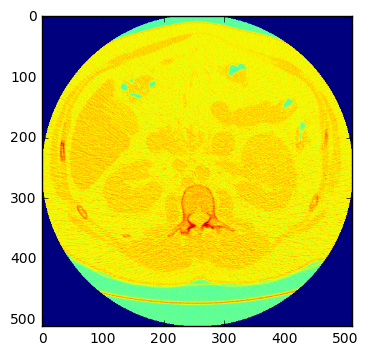

In [12]:
plt.imshow(patient_slice[0][0])


In [13]:
plt.show()


In [14]:
patient_slice[0][0][300]

array([-3024, -3024, -3024, -3024,   121,    37,   -44,   -99,  -111,  -153,  -200,  -224,  -197,
        -214,  -216,  -224,  -278,  -207,  -107,   -90,  -114,   -73,    82,   106,   120,    25,
           8,    10,    -1,   -18,   -87,  -145,   -66,   -37,   -94,  -150,  -175,   -84,   -42,
         -44,   -49,   -43,     8,   -10,   -25,    34,  -105,  -106,   -42,    27,   -10,   -27,
         -64,  -123,    27,    45,    -9,   -42,   -70,    31,    18,   -76,  -103,   -23,  -123,
        -190,  -179,   -75,  -184,  -185,    27,    42,     4,  -143,  -146,  -191,  -151,    29,
         -39,   -21,    -5,  -163,  -160,   -93,    14,   -69,  -167,  -212,  -159,   -83,    12,
          58,   -18,    23,   -37,  -160,  -146,  -186,  -224,  -207,  -150,   -50,    61,   106,
         162,   130,    53,   108,    46,    -2,   -16,    92,   151,   159,   230,   197,    99,
         -78,    -8,    57,   -33,   -76,     5,   121,   -13,   -58,    16,     7,    50,    46,
         174,   267,

In [15]:
patient_slice[2]

array([ 0.625 ,  0.7422,  0.7422])

In [16]:
type(image)

module

In [17]:
image = sitk.ReadImage(data_path + "subset0//1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd")

In [18]:
print (image.GetSize())

(512, 512, 121)


In [19]:
print (image.GetOrigin())
print (image.GetSpacing())
print (image.GetDirection())

print (image.GetNumberOfComponentsPerPixel())

(-198.100006, -195.0, -335.209991)
(0.7617189884185791, 0.7617189884185791, 2.5)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
1


In [20]:
sitk.GetArrayFromImage(image)[0:3].shape

(3, 512, 512)

In [21]:
sitk.GetArrayFromImage(image).shape

(121, 512, 512)

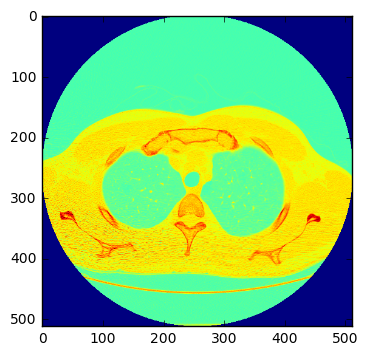

In [22]:
plt.imshow(sitk.GetArrayFromImage(image)[99])

In [23]:
image.GetSpacing()

(0.7617189884185791, 0.7617189884185791, 2.5)

In [24]:
image_array=sitk.GetArrayFromImage(image)

In [25]:
(image_array).shape


(121, 512, 512)

In [26]:
def get_5dslice(d_image,slice_loc):
    slice = sitk.GetArrayFromImage(d_image)[slice_loc-2:slice_loc+3]
    return slice


In [27]:
new_image = get_5dslice(image,91)

In [28]:
def resample_image(image, image_array, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    real_spacing =  image.GetSpacing()
    spacing = np.array(np.roll(real_spacing,1), dtype=np.float32)

    resize_factor = spacing / new_spacing
    print(spacing)
    new_real_shape = image_array.shape * resize_factor
    new_shape = np.round(new_real_shape)
    print(new_shape)
    real_resize_factor = new_shape / image_array.shape
    new_spacing = spacing / real_resize_factor
    print(new_spacing)
    image_array2 = scipy.ndimage.interpolation.zoom(image_array, real_resize_factor, mode='nearest')
    
    return image_array2, new_spacing


In [29]:
%time outcome = resample_image(image,new_image)

[ 2.5     0.7617  0.7617]
[  12.  390.  390.]
[ 1.0417  1.      1.    ]
CPU times: user 1.19 s, sys: 27.6 ms, total: 1.22 s
Wall time: 1.3 s


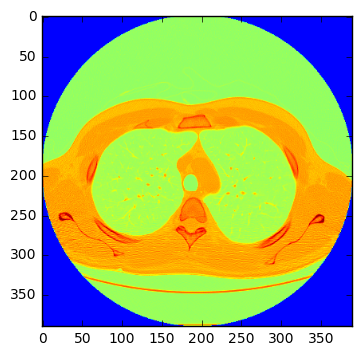

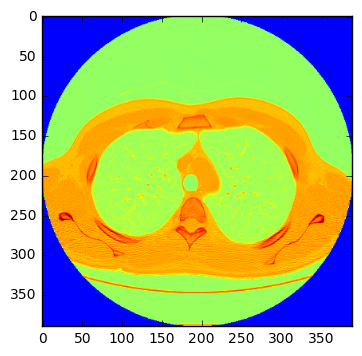

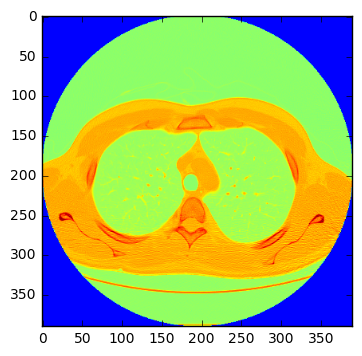

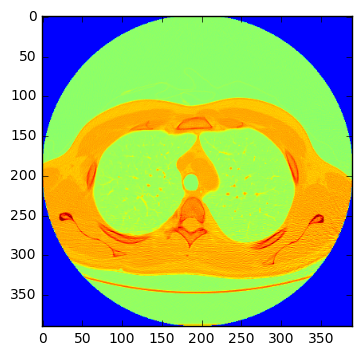

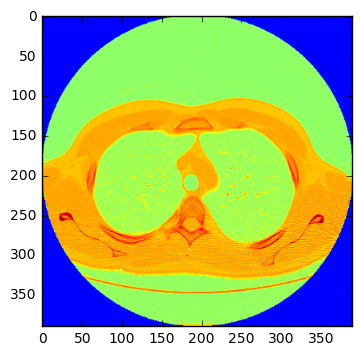

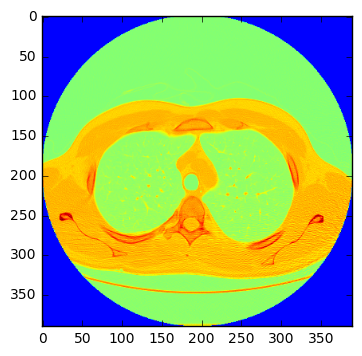

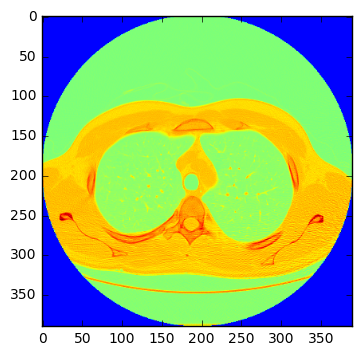

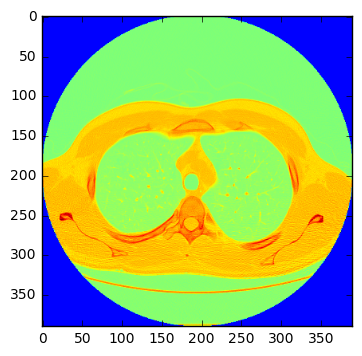

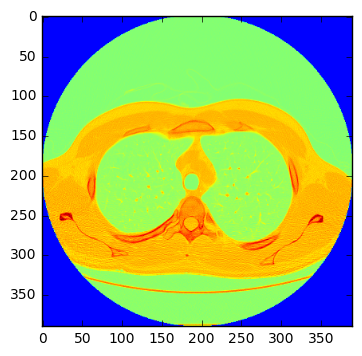

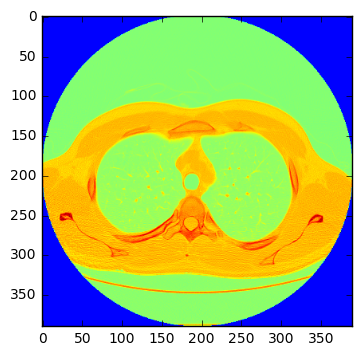

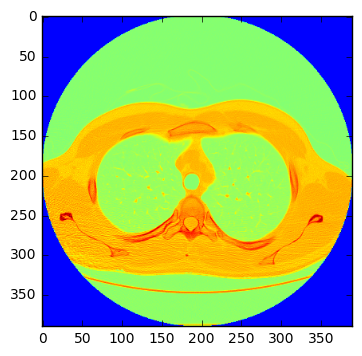

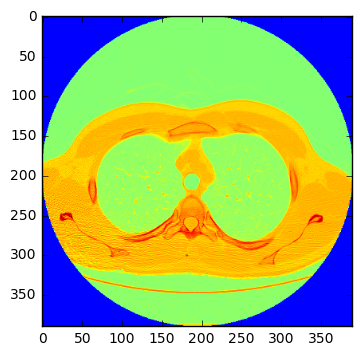

In [30]:
for i in range(12):
    plt.imshow(outcome[0][i])
    plt.show()

In [31]:
def get_3dslice(d_image,slice_loc):
    slice = sitk.GetArrayFromImage(d_image)[slice_loc-1:slice_loc+2]
    return slice

In [32]:
get_3dslice(image,4).shape

(3, 512, 512)

In [33]:
def create_slice_array(image):
    num_layers = image.GetSize()[2]-2
    print(num_layers)
    slice_array = np.zeros((image.GetSize()[2]-2,3,512,512))
    for i in range(num_layers):
        slice =  np.zeros((3,512,512))
        slice_array[i] = get_3dslice(image,i+1)
    slice_array = slice_array.transpose(0,2,3,1)
    return slice_array

In [34]:
%time color_array = create_slice_array(image)

119
CPU times: user 1.99 s, sys: 2.04 s, total: 4.03 s
Wall time: 4.28 s


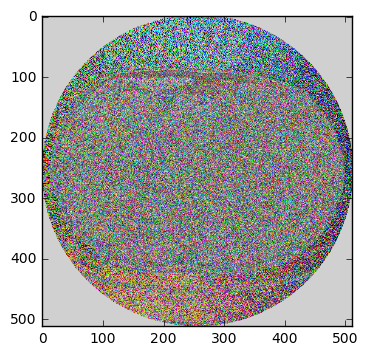

In [35]:
color_array[92].shape
plt.imshow(color_array[0])

In [36]:
candidates.values

array([['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 64.1029275775,
        84.9841485639, -95.26109041459999, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 66.1283826307,
        91.4358740771, -121.999167539, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 58.106059702299994,
        81.3088980717, -97.8160367908, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 67.61451718,
        85.02525992, -109.8084416, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 75.7212243102,
        92.88733103940001, -119.27056405200001, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 57.3694276965,
        83.2399662237, -114.664766642, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 75.2239949525,
        79.4552680171, -121.43016833700001, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.28

In [37]:
annotations.loc[annotations['diameter_mm'].idxmax(),'coordZ']

-109.74672379999998

In [38]:
annotations

seriesuid      coordX  \
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421   
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651   
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017   
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824   
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547   
5     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   90.931713   
6     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   89.540769   
7     1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...   81.509646   
8     1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...  105.055792   
9     1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760... -124.834262   
10    1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985... -106.901301   
11    1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...    2.263816   
12    1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...  -70.550889   
13    1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...  -70.660628   
14    1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085...  -96.439534   
15    1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...  -57.087180   
16    1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065...  -98.135977   
17    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  122.078920   
18    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  100.932273   
19    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  -46.783729   
20    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...  -69.126568   
21    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259... -108.072812   
22    1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...   82.229181   
23    1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896... -100.567944   
24    1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525...   42.574154   
25    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   46.188539   
26    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...   36.392044   
27    1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949...  -38.096020   
28    1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...  136.434059   
29    1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162...  -80.951859   
...                                                 ...         ...   
1156  1.3.6.1.4.1.14519.5.2.1.6279.6001.931383239747...  -87.920377   
1157  1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293...   64.133938   
1158  1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293...  -74.891965   
1159  1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493...  107.405426   
1160  1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251...  -46.949664   
1161  1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209...   40.314795   
1162  1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505...  121.908760   
1163  1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428...  -84.151846   
1164  1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428...  -42.465222   
1165  1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663...  -48.062130   
1166  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308... -112.745883   
1167  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...  -40.211068   
1168  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...   87.076660   
1169  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...   55.972756   
1170  1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308...  109.200675   
1171  1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349...  -72.860803   
1172  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...   35.106203   
1173  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...   56.350667   
1174  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...  -70.913535   
1175  1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561...  -75.558882   
1176  1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033... -109.428509   
1177  1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353... -114.213070   
1178  1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353... -116.037038   
1179  1.3.6.1.4.1.14519.5.2.1.6279.6001.975426625618...   52.996021   
1180  1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707... -104.441975   

In [39]:
annotations['diameter_mm'].max()

32.270030249999998

In [40]:
mhd_file = (data_path + '')

In [41]:
mhdfiles = []
spacing_list = []

for dirName, subdirList, fileList in os.walk(data_path):
    for subdirName in subdirList:
        if subdirName.startswith('sub'):
            print (subdirName)
            for dirName2,subdirList2,fileList2 in os.walk(dirName + subdirName):
                for file in fileList2:
                    if file.endswith('mhd'):
                        mhdfiles.append(dirName2 + '/' +file)
                        templist = (load_itk_spacing(dirName2 + '/' +file))
                        tempfilelist = [dirName2 + '/' + file, file]
                        for x in templist:
                            tempfilelist.append(x)
                        spacing_list.append(tempfilelist)

subset0
subset1
subset2
subset3
subset4
subset5
subset6
subset7
subset8
subset9


In [42]:
spacing_df = pd.DataFrame(spacing_list)

In [43]:
spacing_df.columns = ["file_loc","seriesuid",'dz','dx','dy']

In [44]:
spacing_df['seriesuid'].replace(regex=True,inplace=True,to_replace=r'.mhd',value=r'')


In [45]:
pd.options.display.max_colwidth = 100

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x150e60160>]], dtype=object)

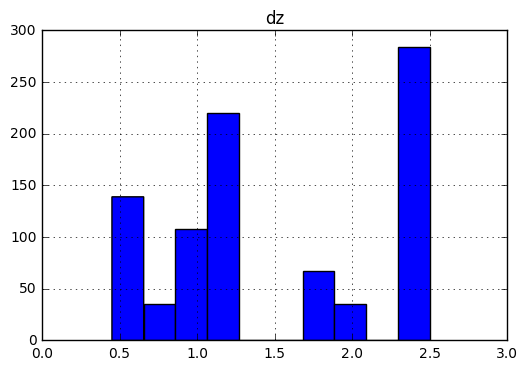

In [46]:
spacing_df.hist(column='dz')

In [47]:
candidates.head()


seriesuid  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886   

      coordX     coordY      coordZ  class  
0  64.102928  84.984149  -95.261090      1  
1  66.128383  91.435874 -121.999168      1  
2  58.106060  81.308898  -97.816037      1  
3  67.614517  85.025260 -109.808442      1  
4  75.721224  92.887331 -119.270564      1

In [48]:
annotations.head()

seriesuid  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   

       coordX      coordY      coordZ  diameter_mm  
0 -128.699421 -175.319272 -298.387506     5.651471  
1  103.783651 -211.925149 -227.121250     4.224708  
2   69.639017 -140.944586  876.374496     5.786348  
3  -24.013824  192.102405 -391.081276     8.143262  
4    2.441547  172.464881 -405.493732    18.545150

In [49]:
candidates_full = pd.read_csv(data_path + "candidates.csv")

In [50]:
candidates_tumor = candidates_full.loc[candidates_full['class'] == 1]

In [51]:
len (candidates_tumor)

1351

In [52]:
candidates_tumor.head()

seriesuid  \
13    1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
78    1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860   
1303  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208   
3050  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   
3052  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405   

          coordX      coordY      coordZ  class  
13    104.164804 -211.685591 -227.011364      1  
78   -128.940000 -175.040000 -297.870000      1  
1303   70.190000 -140.930000  877.680000      1  
3050   89.320000  190.840000 -516.820000      1  
3052   94.930000  153.030000 -429.910000      1

In [53]:
candidates_class1_df = pd.merge(spacing_df,candidates_tumor, on='seriesuid',how='outer').dropna()

In [54]:
candidates_class1_df[candidates_class1_df.seriesuid == '1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886'].head()

file_loc  \
255  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   
256  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   
257  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   
258  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   
259  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...   

                                                            seriesuid   dz  \
255  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   
256  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   
257  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   
258  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   
259  1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886  2.5   

           dx        dy     coordX     coordY      coordZ  class  
255  0.820312  0.820312  64.102928  84.984149  -95.261090    1.0  
256  0.820312  0.820312  66.128383  91.435874 -121.999168    1.0  
257  0.820312  0.820312  58.106060  81.308898  -97.816037    1.0  
258  0.820312  0.820312  67.614517  85.025260 -109.808442    1.0  
259  0.820312  0.820312  75.721224  92.887331 -119.270564    1.0

In [153]:
def get_voxel_coord(Vc, Vw):
    if (Vc-Vw/2) > 0:
        return (Vc-Vw/2)
    else:
        return 0

In [359]:
# get candidates
for   index,row in candidates_class1_df.iterrows():
    numpyImage, numpyOrigin, numpySpacing = load_itk(row[0])
    print (numpyImage.shape)
    print (numpyOrigin)
    print (numpySpacing)
    print (row[0])
    worldCoord =([row[7],row[6],row[5]])
    voxelCoord = world_2_voxel(worldCoord, numpyOrigin, numpySpacing)
    voxelWidth = 224
    print("test getvoxel")
    print("original")
    print(index)
    print(numpyImage[voxelCoord[0],(voxelCoord[1]-voxelWidth/2):(voxelCoord[1]+voxelWidth/2),(get_voxel_coord(voxelCoord[2],voxelWidth)):(voxelCoord[2]+voxelWidth/2)].shape)
    patch = numpyImage[voxelCoord[0],(voxelCoord[1]-voxelWidth/2):(voxelCoord[1]+voxelWidth/2),(get_voxel_coord(voxelCoord[2],voxelWidth)):(voxelCoord[2]+voxelWidth/2)]
    print(patch.shape)
    patch = normalizePlanes(patch)
    print (voxelCoord)
    print ('data')
    print (worldCoord)
    print (voxelCoord)
    print (numpyOrigin)
    outputDir = 'patches/patches1/'
    file_name = (data_path + outputDir + row[1] +'_'+ str(index) +'_'+ str(patch.shape[0]) +'x'+ str(patch.shape[1]) + '.bc')
    print (file_name)
    
    save_array(file_name, patch)
#    plt.imshow(patch*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()
#    full_img = numpyImage[voxelCoord[0]]
#    full_img = normalizePlanes(full_img)
#    plt.imshow(full_img*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()

(119, 512, 512)
[-313.75 -190.   -182.5 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
test getvoxel
original
1
(224, 222)
(224, 222)
[  33.28    347.6343  110.538 ]
data
[-230.55, 68.01, -100.46]
[  33.28    347.6343  110.538 ]
[-313.75 -190.   -182.5 ]
/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_1_224x222.bc


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(161, 512, 512)
[-194.  -108.3 -187.7]
[ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
test getvoxel
original
2
(224, 216)
(224, 216)
[  56.864   339.6328  408.5797]
data
[-122.92, 78.1, 36.54]
[  56.864   339.6328  408.5797]
[-194.  -108.3 -187.7]
/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_2_224x216.bc
(161, 512, 512)
[-194.  -108.3 -187.7]
[ 1.25    0.5488  0.5488]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
test getvoxel
original
3
(224, 202)
(224, 202)
[  67.      292.3867  422.6278]
data
[-110.25, 52.17, 44.25]
[  67.      292.3867  422.6278]
[-194.  -108.3 -187.7]
/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_3_224x202.bc
(161, 512, 512)
[-194.  -108.3 -187.7]
[ 1.25    0.5488  0.5488]
/Volumes/Backups/dat

In [169]:
candidates_class1_df

file_loc  \
1     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978958964468961600487...   
2     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   
3     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   
4     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   
5     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1111721656746612213819205...   
7     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1241544610489291537677438...   
9     /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1262645789317782588903717...   
10    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1280239026512339865923783...   
11    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1290559776373386397416958...   
12    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1304385508908165509947391...   
13    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1349968725834973829540244...   
14    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1349968725834973829540244...   
15    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1349968725834973829540244...   
16    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1349968725834973829540244...   
17    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
18    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
19    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
20    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
21    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819772612...   
23    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1392587778987466933658770...   
25    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1410696617006700429606784...   
28    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1546773963546411502800132...   
29    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1546773963546411502800132...   
30    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1874517152050854036235952...   
31    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1874517152050854036235952...   
32    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1874517152050854036235952...   
33    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1882098896863631598537152...   
34    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1883763498047619882175977...   
35    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1883763498047619882175977...   
36    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1883763498047619882175977...   
...                                                                                                   ...   
1611  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3099019138477141563679817...   
1612  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3114761287319581429819416...   
1613  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3121279337229852048087066...   
1614  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3121279337229852048087066...   
1615  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.3121279337229852048087066...   
1616  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2

In [170]:
candidates_class1_df[0:2]

file_loc  \
1  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978958964468961600487...   
2  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   

                                                          seriesuid    dz  \
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492  2.50   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059  1.25   

         dx        dy  coordX  coordY  coordZ  class  
1  0.742188  0.742188 -100.46   68.01 -230.55    1.0  
2  0.548828  0.548828   36.54   78.10 -122.92    1.0

In [351]:
test_image_good = load_array('/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950_11_224x224.bc')
        

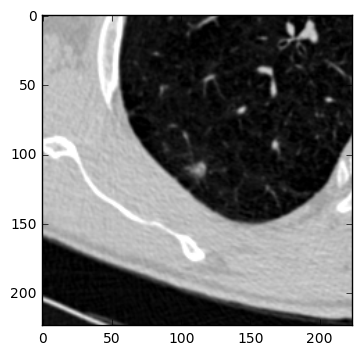

In [355]:
plt.imshow(test_image_good,cmap=plt.cm.gray)

In [356]:
test_image_bad = load_array('/Volumes/Backups/data/LUNA16/patches/patches1/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097_20_224x195.bc')

In [357]:
test_image_bad.shape

(224, 195)

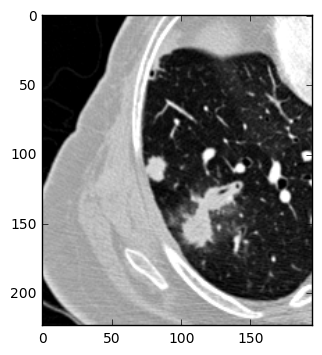

In [358]:
plt.imshow(test_image_bad,cmap=plt.cm.gray)

In [180]:
candidates_class0 = candidates_full.loc[candidates_full['class'] == 0]

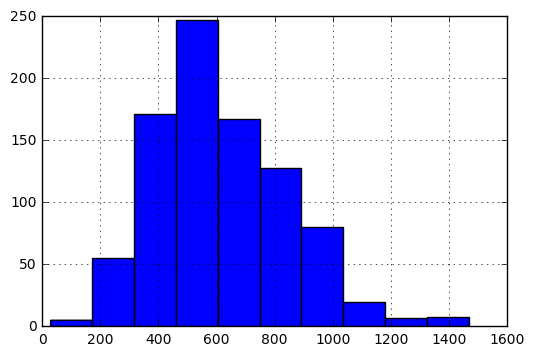

In [298]:
candidates_class0['seriesuid'].value_counts().hist()

In [304]:
spacing_df.head()


file_loc  \
0  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1057566580315150620007448...   
1  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978958964468961600487...   
2  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...   
3  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1111721656746612213819205...   
4  /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1227639138967614943718226...   

                                                          seriesuid     dz  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260  2.500   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492  2.500   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059  1.250   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987  0.625   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720  2.500   

         dx        dy  
0  0.761719  0.761719  
1  0.742188  0.742188  
2  0.548828  0.548828  
3  0.742188  0.742188  
4  0.615234  0.615234

In [306]:
candidates_class0_df = pd.merge( spacing_df[['file_loc','seriesuid']],candidates_class0, on=['seriesuid'],how = 'inner')

In [307]:
len(candidates_class0_df)

549714

In [308]:
candidates_class0_short_df= (candidates_class0_df.sample(n=5000))

In [309]:
candidates_class0_short_df.head(1000)

file_loc  \
254686  /Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.3078353072800280574864133...   
379095  /Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.6184347720734332768742251...   
504231  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.1489353061233278352176597...   
173842  /Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.1602169160758179139535305...   
95298   /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.3152147561573891223765187...   
525720  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.2594534280085077912347306...   
140337  /Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.2353649787752809103676905...   
360748  /Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.2758496016638472515748608...   
231399  /Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.1731011048045339973981374...   
237187  /Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.2048022503863437946139804...   
18052   /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.2190873132610265106289260...   
545510  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.7478034390400917947176265...   
9387    /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1380808888433570478112387...   
51603   /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.8059252693249020555667547...   
378026  /Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.5130236751451664499431772...   
485937  /Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.7668815135338454393351425...   
255438  /Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.3127047713484605020132496...   
434108  /Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.7498715697138686322598746...   
163590  /Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.9391523844938747088503219...   
491649  /Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.9392165683278794625304967...   
109542  /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.9702648650335741909756543...   
389684  /Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.1299820108896244232303942...   
344124  /Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.1687379287293636834232280...   
400097  /Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.1959137066075823474214299...   
463648  /Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.2573835352699911654478229...   
82687   /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2220878119607060964247180...   
380817  /Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.6694358697088831552323184...   
511767  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.1883852863463902028730047...   
351454  /Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.2007259885899595213023204...   
493638  /Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.1098821699638176275598045...   
...                                                                                                     ...   
94601   /Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.3147890758710012366415485...   
217653  /Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.9610634423490059375365972...   
327692  /Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.7507926291004573820998425...   
38540   /Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.3331450944361440853790329...   
161672  /Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496

In [311]:
# get candidates
for   index,row in candidates_class0_short_df.iterrows():
    numpyImage, numpyOrigin, numpySpacing = load_itk(row[0])
    print (numpyImage.shape)
    print (numpyOrigin)
    print (numpySpacing)
    print (row[0])
    worldCoord =([row[4],row[3],row[2]])
    voxelCoord = world_2_voxel(worldCoord, numpyOrigin, numpySpacing)
    voxelWidth = 224
    print("test getvoxel")
    print("original")
    print(index)
    print(numpyImage[voxelCoord[0],(voxelCoord[1]-voxelWidth/2):(voxelCoord[1]+voxelWidth/2),(get_voxel_coord(voxelCoord[2],voxelWidth)):(voxelCoord[2]+voxelWidth/2)].shape)
    patch = numpyImage[voxelCoord[0],(voxelCoord[1]-voxelWidth/2):(voxelCoord[1]+voxelWidth/2),(get_voxel_coord(voxelCoord[2],voxelWidth)):(voxelCoord[2]+voxelWidth/2)]
    print(patch.shape)
    patch = normalizePlanes(patch)
    print (voxelCoord)
    print ('data')
    print (worldCoord)
    print (voxelCoord)
    print (numpyOrigin)
    outputDir = 'patches/patches0/'
    file_name = (data_path + outputDir + row[1] +'_'+ str(index) +'_'+ str(patch.shape[0]) +'x'+ str(patch.shape[1]) + '.bc')
    print (file_name)
    
    %time save_array(file_name, patch)
#    plt.imshow(patch*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()
#    full_img = numpyImage[voxelCoord[0]]
#    full_img = normalizePlanes(full_img)
#    plt.imshow(full_img*255, cmap='gray', vmin=0.,vmax=255.)
#    plt.show()

(133, 512, 512)
[-325.5 -210.  -211. ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377.mhd
test getvoxel
original
254686
(224, 224)
(224, 224)
[  82.564   252.1601  131.645 ]
data
[-119.09, -3.15, -103.01]
[  82.564   252.1601  131.645 ]
[-325.5 -210.  -211. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377_254686_224x224.bc
CPU times: user 1.95 ms, sys: 3.37 ms, total: 5.33 ms
Wall time: 5.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-317.19 -175.3  -153.7 ]
[ 1.25    0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904.mhd
test getvoxel
original
379095
(224, 224)
(224, 224)
[ 121.888   165.3116  193.2263]
data
[-164.83, -67.46, -27.65]
[ 121.888   165.3116  193.2263]
[-317.19 -175.3  -153.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904_379095_224x224.bc
CPU times: user 2.03 ms, sys: 2.29 ms, total: 4.32 ms
Wall time: 5.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-278.745 -170.    -188.2  ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.148935306123327835217659769212.mhd
test getvoxel
original
504231
(224, 224)
(224, 224)
[ 257.016   240.0077  205.011 ]
data
[-118.11, -10.62, -52.06]
[ 257.016   240.0077  205.011 ]
[-278.745 -170.    -188.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148935306123327835217659769212_504231_224x224.bc
CPU times: user 2.14 ms, sys: 2.23 ms, total: 4.37 ms
Wall time: 6.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(201, 512, 512)
[-380.     -361.6387 -184.6387]
[ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.160216916075817913953530562493.mhd
test getvoxel
original
173842
(224, 224)
(224, 224)
[ 121.6966  292.3933  346.768 ]
data
[-160.94615406100002, -150.338820708, 65.9553921296]
[ 121.6966  292.3933  346.768 ]
[-380.     -361.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.160216916075817913953530562493_173842_224x224.bc
CPU times: user 2 ms, sys: 2.26 ms, total: 4.26 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(225, 512, 512)
[-280.  -212.  -206.8]
[ 1.25    0.8281  0.8281]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372.mhd
test getvoxel
original
95298
(224, 224)
(224, 224)
[ 174.5093  288.8333  325.9966]
data
[-61.8634002275, 27.190099769, 63.1658997921]
[ 174.5093  288.8333  325.9966]
[-280.  -212.  -206.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372_95298_224x224.bc
CPU times: user 1.91 ms, sys: 3.64 ms, total: 5.55 ms
Wall time: 6.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-379.39 -143.   -146.5 ]
[ 2.5     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.259453428008507791234730686014.mhd
test getvoxel
original
525720
(224, 224)
(224, 224)
[  53.264   345.1137  342.8453]
data
[-246.23, 70.0, 65.1]
[  53.264   345.1137  342.8453]
[-379.39 -143.   -146.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259453428008507791234730686014_525720_224x224.bc
CPU times: user 1.9 ms, sys: 1.89 ms, total: 3.78 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-324.805 -145.    -144.5  ]
[ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811.mhd
test getvoxel
original
140337
(224, 224)
(224, 224)
[ 183.668   143.4836  155.8423]
data
[-95.22, -63.73, -56.23]
[ 183.668   143.4836  155.8423]
[-324.805 -145.    -144.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811_140337_224x224.bc
CPU times: user 2.38 ms, sys: 2.03 ms, total: 4.41 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-818.3      49.4042 -161.6634]
[ 1.     0.543  0.543]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603.mhd
test getvoxel
original
360748
(224, 224)
(224, 224)
[ 230.77    337.8938  376.5842]
data
[-587.53, 232.87, 42.81]
[ 230.77    337.8938  376.5842]
[-818.3      49.4042 -161.6634]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603_360748_224x224.bc
CPU times: user 2.34 ms, sys: 2.15 ms, total: 4.49 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-288.5 -180.  -174.3]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032.mhd
test getvoxel
original
231399
(224, 213)
(224, 213)
[ 197.008   316.0036  101.0204]
data
[-165.37, 42.19, -103.27]
[ 197.008   316.0036  101.0204]
[-288.5 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032_231399_224x213.bc
CPU times: user 2.05 ms, sys: 1.86 ms, total: 3.91 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(348, 512, 512)
[-372.     -319.1826 -164.1826]
[ 1.      0.6348  0.6348]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.204802250386343794613980417281.mhd
test getvoxel
original
237187
(224, 224)
(224, 224)
[ 212.6     317.8065  372.9607]
data
[-159.4, -117.45, 72.56]
[ 212.6     317.8065  372.9607]
[-372.     -319.1826 -164.1826]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204802250386343794613980417281_237187_224x224.bc
CPU times: user 2 ms, sys: 1.91 ms, total: 3.9 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-681.9   -9.  -152. ]
[ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
test getvoxel
original
18052
(224, 224)
(224, 224)
[ 150.89    221.709   188.5921]
data
[-531.01, 126.97, -36.34]
[ 150.89    221.709   188.5921]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_18052_224x224.bc
CPU times: user 1.95 ms, sys: 2.12 ms, total: 4.06 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(114, 512, 512)
[-320.25 -190.   -177.5 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402.mhd
test getvoxel
original
545510
(224, 210)
(224, 210)
[  73.9848  305.2479   98.5258]
data
[-135.28793123100002, 12.7035549786, -112.07275882399999]
[  73.9848  305.2479   98.5258]
[-320.25 -190.   -177.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402_545510_224x210.bc
CPU times: user 2.41 ms, sys: 2.62 ms, total: 5.03 ms
Wall time: 9.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(295, 512, 512)
[-656.   -39.5 -161.5]
[ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd
test getvoxel
original
9387
(224, 224)
(224, 224)
[ 165.7824  333.9032  344.0355]
data
[-490.217557503, 188.101992156, 73.0085967838]
[ 165.7824  333.9032  344.0355]
[-656.   -39.5 -161.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686_9387_224x224.bc
CPU times: user 1.88 ms, sys: 1.9 ms, total: 3.79 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-382.25 -210.   -213.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd
test getvoxel
original
51603
(224, 224)
(224, 224)
[  42.5     222.2447  200.8748]
data
[-276.0, -27.69, -48.22]
[  42.5     222.2447  200.8748]
[-382.25 -210.   -213.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843_51603_224x224.bc
CPU times: user 1.61 ms, sys: 1.81 ms, total: 3.42 ms
Wall time: 3.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-345.25 -200.   -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490.mhd
test getvoxel
original
378026
(224, 224)
(224, 224)
[  96.692   322.8032  204.4544]
data
[-103.52, 52.19, -40.27]
[  96.692   322.8032  204.4544]
[-345.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490_378026_224x224.bc
CPU times: user 2.35 ms, sys: 2.44 ms, total: 4.79 ms
Wall time: 6.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-353.75 -180.   -192.4 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.766881513533845439335142582269.mhd
test getvoxel
original
485937
(224, 224)
(224, 224)
[ 113.5597  291.2351  217.0515]
data
[-211.8003809, 24.774663915, -39.78568986]
[ 113.5597  291.2351  217.0515]
[-353.75 -180.   -192.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.766881513533845439335142582269_485937_224x224.bc
CPU times: user 1.87 ms, sys: 1.91 ms, total: 3.78 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(249, 512, 512)
[-306.75 -167.7  -215.8 ]
[ 1.25    0.8047  0.8047]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348460502013249647868.mhd
test getvoxel
original
255438
(224, 224)
(224, 224)
[ 171.44    347.4266  326.5365]
data
[-92.45, 111.87, 46.96]
[ 171.44    347.4266  326.5365]
[-306.75 -167.7  -215.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348460502013249647868_255438_224x224.bc
CPU times: user 2.09 ms, sys: 1.88 ms, total: 3.98 ms
Wall time: 4.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(372, 512, 512)
[-183.97 -150.   -149.  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577.mhd
test getvoxel
original
434108
(224, 224)
(224, 224)
[  86.016   231.0142  153.0196]
data
[-130.21, -14.64, -59.34]
[  86.016   231.0142  153.0196]
[-183.97 -150.   -149.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577_434108_224x224.bc
CPU times: user 1.84 ms, sys: 1.75 ms, total: 3.59 ms
Wall time: 3.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(172, 512, 512)
[-343.8    -347.6582 -181.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
test getvoxel
original
163590
(224, 224)
(224, 224)
[ 108.7312  294.7857  182.8812]
data
[-148.0838741, -146.1445246, -56.64176615]
[ 108.7312  294.7857  182.8812]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_163590_224x224.bc
CPU times: user 2.1 ms, sys: 2.18 ms, total: 4.28 ms
Wall time: 5.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-375.25 -216.   -195.3 ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.939216568327879462530496768794.mhd
test getvoxel
original
491649
(224, 224)
(224, 224)
[ 104.72    253.879   319.6832]
data
[-113.45, -7.74, 66.94]
[ 104.72    253.879   319.6832]
[-375.25 -216.   -195.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939216568327879462530496768794_491649_224x224.bc
CPU times: user 2.31 ms, sys: 2.16 ms, total: 4.47 ms
Wall time: 4.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(433, 512, 512)
[-288.075 -128.5   -167.6  ]
[ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.mhd
test getvoxel
original
109542
(224, 224)
(224, 224)
[ 273.2924  220.8305  169.7121]
data
[-117.267266949, -7.733315677969999, -74.7886741525]
[ 273.2924  220.8305  169.7121]
[-288.075 -128.5   -167.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557_109542_224x224.bc
CPU times: user 1.76 ms, sys: 1.83 ms, total: 3.58 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-336.5 -226.  -212. ]
[ 1.25    0.8828  0.8828]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
test getvoxel
original
389684
(224, 224)
(224, 224)
[ 145.4557  245.6963  311.6167]
data
[-154.6803874, -9.096320703, 63.09898417]
[ 145.4557  245.6963  311.6167]
[-336.5 -226.  -212. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528_389684_224x224.bc
CPU times: user 1.88 ms, sys: 1.97 ms, total: 3.85 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(289, 512, 512)
[-340.  -175.5 -210.8]
[ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
test getvoxel
original
344124
(224, 224)
(224, 224)
[  88.8854  341.9451  364.4738]
data
[-228.89323551099997, 85.63387623979999, 67.538435077]
[  88.8854  341.9451  364.4738]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344124_224x224.bc
CPU times: user 3.08 ms, sys: 2.67 ms, total: 5.75 ms
Wall time: 6.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-316.25 -210.   -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613.mhd
test getvoxel
original
400097
(224, 224)
(224, 224)
[  36.2729  369.3982  374.3763]
data
[-225.567826303, 93.0217563084, 97.10540848389999]
[  36.2729  369.3982  374.3763]
[-316.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613_400097_224x224.bc
CPU times: user 2.73 ms, sys: 2.19 ms, total: 4.92 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.945 -180.    -174.3  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959.mhd
test getvoxel
original
463648
(224, 224)
(224, 224)
[  50.9529  293.1736  216.9576]
data
[-223.56273030000003, 26.13769947, -21.75166223]
[  50.9529  293.1736  216.9576]
[-350.945 -180.    -174.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959_463648_224x224.bc
CPU times: user 2.41 ms, sys: 2.39 ms, total: 4.8 ms
Wall time: 5.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-297.59 -140.2  -169.4 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.222087811960706096424718056430.mhd
test getvoxel
original
82687
(224, 224)
(224, 224)
[ 109.008  154.016  118.016]
data
[-229.46, -43.94, -95.64]
[ 109.008  154.016  118.016]
[-297.59 -140.2  -169.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.222087811960706096424718056430_82687_224x224.bc
CPU times: user 2.21 ms, sys: 3.47 ms, total: 5.68 ms
Wall time: 8.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-359. -170. -170.]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131.mhd
test getvoxel
original
380817
(224, 224)
(224, 224)
[  46.252   340.9772  159.4279]
data
[-243.37, 56.43, -64.13]
[  46.252   340.9772  159.4279]
[-359. -170. -170.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131_380817_224x224.bc
CPU times: user 2.07 ms, sys: 2.16 ms, total: 4.22 ms
Wall time: 4.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(381, 512, 512)
[-209.5 -160.  -163.6]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
test getvoxel
original
511767
(224, 209)
(224, 209)
[ 169.008  292.992   97.008]
data
[-103.87, 23.12, -102.97]
[ 169.008  292.992   97.008]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511767_224x209.bc
CPU times: user 1.99 ms, sys: 1.89 ms, total: 3.88 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-318.8    -362.6289 -176.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687.mhd
test getvoxel
original
351454
(224, 224)
(224, 224)
[ 154.2111  244.6806  209.7299]
data
[-41.22, -181.03, -20.97]
[ 154.2111  244.6806  209.7299]
[-318.8    -362.6289 -176.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687_351454_224x224.bc
CPU times: user 2.62 ms, sys: 2.48 ms, total: 5.11 ms
Wall time: 5.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(468, 512, 512)
[-378.5    -291.7305 -151.7305]
[ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
test getvoxel
original
493638
(224, 224)
(224, 224)
[ 146.0143  321.0212  205.0235]
data
[-276.29, -118.68, -41.21]
[ 146.0143  321.0212  205.0235]
[-378.5    -291.7305 -151.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094_493638_224x224.bc
CPU times: user 2.01 ms, sys: 2.08 ms, total: 4.09 ms
Wall time: 22.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(506, 512, 512)
[-304.69 -165.3  -173.1 ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116703382344406837243058680403.mhd
test getvoxel
original
387530
(224, 224)
(224, 224)
[ 201.2855  295.587   318.3384]
data
[-178.88658869999998, 30.98809985, 38.29642609]
[ 201.2855  295.587   318.3384]
[-304.69 -165.3  -173.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116703382344406837243058680403_387530_224x224.bc
CPU times: user 2.03 ms, sys: 1.89 ms, total: 3.93 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.045 -170.    -163.3  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225.mhd
test getvoxel
original
336205
(224, 224)
(224, 224)
[  91.0199  367.9713  221.26  ]
data
[-112.49523496100001, 74.3557570553, -16.3696293177]
[  91.0199  367.9713  221.26  ]
[-340.045 -170.    -163.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225_336205_224x224.bc
CPU times: user 1.99 ms, sys: 2.01 ms, total: 4 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(305, 512, 512)
[-380.  -145.5 -163.2]
[ 1.25    0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.153985109349433321657655488650.mhd
test getvoxel
original
505733
(224, 224)
(224, 224)
[ 131.448   311.9786  298.5847]
data
[-215.69, 83.0, 55.49]
[ 131.448   311.9786  298.5847]
[-380.  -145.5 -163.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153985109349433321657655488650_505733_224x224.bc
CPU times: user 1.88 ms, sys: 1.93 ms, total: 3.81 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(138, 512, 512)
[-383.31 -182.5  -189.3 ]
[ 2.5     0.7129  0.7129]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626.mhd
test getvoxel
original
229313
(224, 213)
(224, 213)
[  54.24    318.4821  101.4474]
data
[-247.710000107, 44.543048651499994, -116.97906727700001]
[  54.24    318.4821  101.4474]
[-383.31 -182.5  -189.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626_229313_224x213.bc
CPU times: user 2.12 ms, sys: 2.3 ms, total: 4.42 ms
Wall time: 5.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.  -211.3 -193.3]
[ 2.5     0.7734  0.7734]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325.mhd
test getvoxel
original
287393
(224, 224)
(224, 224)
[  67.0236  190.8097  185.3687]
data
[-182.44090932900002, -63.72051840859999, -49.928791123500005]
[  67.0236  190.8097  185.3687]
[-350.  -211.3 -193.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325_287393_224x224.bc
CPU times: user 1.76 ms, sys: 1.98 ms, total: 3.74 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(253, 512, 512)
[-307.25 -166.7  -193.1 ]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518.mhd
test getvoxel
original
348893
(224, 224)
(224, 224)
[ 105.4463  290.63    325.3079]
data
[-175.4421749, 49.00207648, 48.3396211]
[ 105.4463  290.63    325.3079]
[-307.25 -166.7  -193.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518_348893_224x224.bc
CPU times: user 2.39 ms, sys: 2.17 ms, total: 4.56 ms
Wall time: 4.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(564, 512, 512)
[-349.02 -180.   -186.2 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185.mhd
test getvoxel
original
250478
(224, 224)
(224, 224)
[ 493.024   320.9956  178.0196]
data
[-40.88, 45.7, -61.03]
[ 493.024   320.9956  178.0196]
[-349.02 -180.   -186.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185_250478_224x224.bc
CPU times: user 1.86 ms, sys: 1.67 ms, total: 3.53 ms
Wall time: 3.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(362, 512, 512)
[-182.785 -160.    -166.2  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294.mhd
test getvoxel
original
161100
(224, 224)
(224, 224)
[ 175.016  300.992  158.016]
data
[-73.4, 28.12, -67.44]
[ 175.016  300.992  158.016]
[-182.785 -160.    -166.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294_161100_224x224.bc
CPU times: user 1.8 ms, sys: 1.98 ms, total: 3.79 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(487, 512, 512)
[-300. -180. -181.]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412.mhd
test getvoxel
original
212744
(224, 224)
(224, 224)
[ 440.016   317.9947  339.9964]
data
[-24.99, 43.59, 58.06]
[ 440.016   317.9947  339.9964]
[-300. -180. -181.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412_212744_224x224.bc
CPU times: user 2.05 ms, sys: 2 ms, total: 4.05 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-677.3     -15.7226 -168.3596]
[ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802.mhd
test getvoxel
original
383581
(224, 224)
(224, 224)
[ 152.791   267.3472  339.4978]
data
[-524.50900355, 155.0245608, 48.468136255]
[ 152.791   267.3472  339.4978]
[-677.3     -15.7226 -168.3596]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802_383581_224x224.bc
CPU times: user 2.04 ms, sys: 2.07 ms, total: 4.11 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(506, 512, 512)
[-564.     -341.6504 -178.6504]
[ 0.7     0.6992  0.6992]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.227796349777753378641347819780.mhd
test getvoxel
original
138024
(224, 224)
(224, 224)
[ 423.0667  291.0603  237.9335]
data
[-267.85333358400004, -138.135557254, -12.2828297729]
[ 423.0667  291.0603  237.9335]
[-564.     -341.6504 -178.6504]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227796349777753378641347819780_138024_224x224.bc
CPU times: user 2.04 ms, sys: 1.98 ms, total: 4.03 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(257, 512, 512)
[-310. -236. -236.]
[ 1.25    0.9219  0.9219]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222.mhd
test getvoxel
original
447719
(224, 224)
(224, 224)
[ 116.16    205.4183  317.2447]
data
[-164.8, -46.63, 56.46]
[ 116.16    205.4183  317.2447]
[-310. -236. -236.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222_447719_224x224.bc
CPU times: user 1.84 ms, sys: 1.78 ms, total: 3.62 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-281.48 -128.   -154.  ]
[ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558.mhd
test getvoxel
original
177675
(224, 224)
(224, 224)
[ 327.008   234.0004  166.0201]
data
[-77.1, 13.68, -53.48]
[ 327.008   234.0004  166.0201]
[-281.48 -128.   -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558_177675_224x224.bc
CPU times: user 1.94 ms, sys: 2.08 ms, total: 4.02 ms
Wall time: 4.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(513, 512, 512)
[-318.575 -150.    -150.5  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338104567770715523699587505022.mhd
test getvoxel
original
317714
(224, 216)
(224, 216)
[ 169.016   126.0202  104.0212]
data
[-212.94, -76.16, -89.55]
[ 169.016   126.0202  104.0212]
[-318.575 -150.    -150.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338104567770715523699587505022_317714_224x216.bc
CPU times: user 1.89 ms, sys: 1.76 ms, total: 3.65 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-295.7 -208.2 -176. ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.965620538050807352935663552285.mhd
test getvoxel
original
218418
(224, 224)
(224, 224)
[ 169.008   318.0057  134.0092]
data
[-190.07, 27.82, -76.54]
[ 169.008   318.0057  134.0092]
[-295.7 -208.2 -176. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.965620538050807352935663552285_218418_224x224.bc
CPU times: user 1.94 ms, sys: 1.97 ms, total: 3.91 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(206, 512, 512)
[-267.5 -230.  -222.2]
[ 1.25    0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428298219623354433437.mhd
test getvoxel
original
383037
(224, 224)
(224, 224)
[ 123.8957  257.9475  334.7126]
data
[-112.63039740000002, 1.7498747669999999, 78.51849792]
[ 123.8957  257.9475  334.7126]
[-267.5 -230.  -222.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428298219623354433437_383037_224x224.bc
CPU times: user 1.91 ms, sys: 1.79 ms, total: 3.7 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(337, 512, 512)
[-373.6    -350.6582 -180.6582]
[ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.206097113343059612247503064658.mhd
test getvoxel
original
455988
(224, 224)
(224, 224)
[ 184.27   139.276  227.34 ]
data
[-189.33, -255.45, -25.25]
[ 184.27   139.276  227.34 ]
[-373.6    -350.6582 -180.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206097113343059612247503064658_455988_224x224.bc
CPU times: user 2.01 ms, sys: 1.95 ms, total: 3.97 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-422.5     -28.0671 -187.6729]
[ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd
test getvoxel
original
30441
(0, 224)
(0, 224)
[  63.21    103.8334  202.5597]
data
[-359.29, 42.71, -49.6]
[  63.21    103.8334  202.5597]
[-422.5     -28.0671 -187.6729]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037_30441_0x224.bc
CPU times: user 2.1 ms, sys: 1.63 ms, total: 3.73 ms
Wall time: 2.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(156, 512, 512)
[-251.475 -165.    -173.4  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230.mhd
test getvoxel
original
149175
(224, 201)
(224, 201)
[  62.3325  221.7737   89.1501]
data
[-126.81, -22.06, -115.94]
[  62.3325  221.7737   89.1501]
[-251.475 -165.    -173.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230_149175_224x201.bc
CPU times: user 2.54 ms, sys: 2.22 ms, total: 4.75 ms
Wall time: 4.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-354.64 -190.7  -180.3 ]
[ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517.mhd
test getvoxel
original
477428
(224, 224)
(224, 224)
[  67.1443  337.0849  142.6263]
data
[-186.779130627, 36.4372447009, -84.19438330979999]
[  67.1443  337.0849  142.6263]
[-354.64 -190.7  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517_477428_224x224.bc
CPU times: user 2.37 ms, sys: 2.18 ms, total: 4.55 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(111, 512, 512)
[-293.75 -167.8  -223.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
test getvoxel
original
61015
(224, 224)
(224, 224)
[  47.781   355.5907  125.162 ]
data
[-174.29748225900002, 110.005258057, -125.41719446]
[  47.781   355.5907  125.162 ]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_61015_224x224.bc
CPU times: user 2.11 ms, sys: 1.96 ms, total: 4.07 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(158, 512, 512)
[-291.16 -163.1  -180.3 ]
[ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896.mhd
test getvoxel
original
104098
(224, 224)
(224, 224)
[  62.29    269.575   199.7769]
data
[-166.58, 31.71, -35.93]
[  62.29    269.575   199.7769]
[-291.16 -163.1  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896_104098_224x224.bc
CPU times: user 1.99 ms, sys: 3.34 ms, total: 5.33 ms
Wall time: 6.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-337.  -171.  -190.3]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333.mhd
test getvoxel
original
123839
(224, 224)
(224, 224)
[ 100.252   359.5648  179.3408]
data
[-86.37, 109.91, -50.19]
[ 100.252   359.5648  179.3408]
[-337.  -171.  -190.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333_123839_224x224.bc
CPU times: user 3.72 ms, sys: 2.56 ms, total: 6.28 ms
Wall time: 9.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-802.1   18.  -162. ]
[ 1.      0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468.mhd
test getvoxel
original
240526
(224, 224)
(224, 224)
[ 226.5246  326.7176  320.4264]
data
[-575.5753844999999, 240.0658651, 55.78985039]
[ 226.5246  326.7176  320.4264]
[-802.1   18.  -162. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468_240526_224x224.bc
CPU times: user 2.42 ms, sys: 2.03 ms, total: 4.45 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(164, 512, 512)
[-348.36 -180.   -170.1 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047.mhd
test getvoxel
original
444800
(220, 224)
(220, 224)
[  84.47    404.4231  196.2525]
data
[-179.42, 104.36, -32.11]
[  84.47    404.4231  196.2525]
[-348.36 -180.   -170.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047_444800_220x224.bc
CPU times: user 1.81 ms, sys: 1.85 ms, total: 3.66 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(270, 512, 512)
[-372.75 -200.   -180.  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.184412674007117333405073397832.mhd
test getvoxel
original
125703
(224, 207)
(224, 207)
[  38.176   349.6391   95.6444]
data
[-325.03, 45.84, -112.75]
[  38.176   349.6391   95.6444]
[-372.75 -200.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.184412674007117333405073397832_125703_224x207.bc
CPU times: user 2.01 ms, sys: 1.91 ms, total: 3.92 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-332.5 -178.5 -163.9]
[ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd
test getvoxel
original
15376
(224, 224)
(224, 224)
[  71.8129  359.8637  135.3311]
data
[-152.967716764, 72.4207226096, -69.5382301229]
[  71.8129  359.8637  135.3311]
[-332.5 -178.5 -163.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830_15376_224x224.bc
CPU times: user 2.03 ms, sys: 2.2 ms, total: 4.23 ms
Wall time: 19.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(208, 512, 512)
[-301.57  -81.5  -129.4 ]
[ 1.25    0.5137  0.5137]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.193408384740507320589857096592.mhd
test getvoxel
original
77987
(224, 224)
(224, 224)
[  94.448   204.8     383.6495]
data
[-183.51, 23.7, 67.67]
[  94.448   204.8     383.6495]
[-301.57  -81.5  -129.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193408384740507320589857096592_77987_224x224.bc
CPU times: user 1.73 ms, sys: 1.78 ms, total: 3.51 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(224, 512, 512)
[-330.5 -180.  -181. ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.307921770358136677021532761235.mhd
test getvoxel
original
365553
(224, 224)
(224, 224)
[ 170.672   334.6916  233.1022]
data
[-117.16, 55.33, -17.1]
[ 170.672   334.6916  233.1022]
[-330.5 -180.  -181. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307921770358136677021532761235_365553_224x224.bc
CPU times: user 1.76 ms, sys: 1.76 ms, total: 3.53 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-279.315 -188.3   -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431.mhd
test getvoxel
original
316034
(224, 224)
(224, 224)
[ 202.008   381.9947  326.0018]
data
[-153.06, 80.29, 49.22]
[ 202.008   381.9947  326.0018]
[-279.315 -188.3   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431_316034_224x224.bc
CPU times: user 1.95 ms, sys: 1.86 ms, total: 3.81 ms
Wall time: 5.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(465, 512, 512)
[-265.795 -155.7   -127.2  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818.mhd
test getvoxel
original
364432
(224, 224)
(224, 224)
[ 144.008   368.9981  363.0077]
data
[-175.79, 60.51, 85.5]
[ 144.008   368.9981  363.0077]
[-265.795 -155.7   -127.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306558074682524259000586270818_364432_224x224.bc
CPU times: user 1.98 ms, sys: 1.69 ms, total: 3.67 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(253, 512, 512)
[-341.54 -133.3  -133.8 ]
[ 1.25    0.6016  0.6016]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296.mhd
test getvoxel
original
147610
(224, 224)
(224, 224)
[ 144.736   309.5275  203.6532]
data
[-160.62, 52.9, -11.29]
[ 144.736   309.5275  203.6532]
[-341.54 -133.3  -133.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296_147610_224x224.bc
CPU times: user 2 ms, sys: 2.16 ms, total: 4.16 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-341.3 -180.  -167. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532.mhd
test getvoxel
original
500106
(224, 224)
(224, 224)
[  39.208   304.8107  306.8018]
data
[-243.28, 34.32, 48.72]
[  39.208   304.8107  306.8018]
[-341.3 -180.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532_500106_224x224.bc
CPU times: user 3.08 ms, sys: 2.55 ms, total: 5.63 ms
Wall time: 26.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(330, 512, 512)
[-359.1    -372.6191 -194.6191]
[ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
test getvoxel
original
387967
(224, 224)
(224, 224)
[ 169.102   372.5581  361.7087]
data
[-189.998024523, -88.83468544610001, 80.9011914158]
[ 169.102   372.5581  361.7087]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_387967_224x224.bc
CPU times: user 1.97 ms, sys: 2.06 ms, total: 4.03 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-361.42 -231.8  -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431.mhd
test getvoxel
original
482090
(224, 224)
(224, 224)
[  81.1263  291.9957  201.7074]
data
[-158.60417111700002, 7.7275683921, -44.5370142962]
[  81.1263  291.9957  201.7074]
[-361.42 -231.8  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431_482090_224x224.bc
CPU times: user 1.87 ms, sys: 2.04 ms, total: 3.91 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-236.455 -152.4   -172.1  ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021.mhd
test getvoxel
original
509957
(224, 224)
(224, 224)
[ 350.008   384.0003  332.0021]
data
[-17.7, 102.6, 48.37]
[ 350.008   384.0003  332.0021]
[-236.455 -152.4   -172.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021_509957_224x224.bc
CPU times: user 1.87 ms, sys: 1.74 ms, total: 3.62 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-291.455 -204.8   -192.9  ]
[ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224.mhd
test getvoxel
original
340726
(224, 204)
(224, 204)
[  63.5167  307.957    92.3418]
data
[-164.421666891, 17.747003105, -126.168666861]
[  63.5167  307.957    92.3418]
[-291.455 -204.8   -192.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224_340726_224x204.bc
CPU times: user 2.43 ms, sys: 2.24 ms, total: 4.67 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-386.5 -186.7 -178.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734.mhd
test getvoxel
original
312006
(224, 224)
(224, 224)
[  77.4     350.6347  302.8195]
data
[-193.0, 59.84, 34.52]
[  77.4     350.6347  302.8195]
[-386.5 -186.7 -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734_312006_224x224.bc
CPU times: user 1.9 ms, sys: 1.97 ms, total: 3.87 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-358.5 -210.  -193. ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309937415860209787179.mhd
test getvoxel
original
107380
(224, 224)
(224, 224)
[ 146.616   215.168   357.6036]
data
[-175.23, -58.71, 58.44]
[ 146.616   215.168   357.6036]
[-358.5 -210.  -193. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309937415860209787179_107380_224x224.bc
CPU times: user 1.83 ms, sys: 3.54 ms, total: 5.37 ms
Wall time: 6.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-300.  -152.4 -153.4]
[ 1.25    0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.292194861362266467652267941663.mhd
test getvoxel
original
363125
(224, 224)
(224, 224)
[ 153.368   239.3272  193.3128]
data
[-108.29, -6.56, -35.6]
[ 153.368   239.3272  193.3128]
[-300.  -152.4 -153.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292194861362266467652267941663_363125_224x224.bc
CPU times: user 1.79 ms, sys: 1.69 ms, total: 3.48 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-311.25 -200.   -207.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
test getvoxel
original
494378
(224, 224)
(224, 224)
[  60.62    205.3504  186.5216]
data
[-159.7, -39.57, -61.78]
[  60.62    205.3504  186.5216]
[-311.25 -200.   -207.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437_494378_224x224.bc
CPU times: user 1.85 ms, sys: 1.96 ms, total: 3.81 ms
Wall time: 4.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(463, 512, 512)
[-299.145 -139.6   -145.8  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524.mhd
test getvoxel
original
161500
(224, 224)
(224, 224)
[ 210.024   296.9939  130.0138]
data
[-167.88, 34.42, -69.62]
[ 210.024   296.9939  130.0138]
[-299.145 -139.6   -145.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524_161500_224x224.bc
CPU times: user 1.87 ms, sys: 1.82 ms, total: 3.69 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-291.385 -158.9   -158.8  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
test getvoxel
original
187771
(224, 224)
(224, 224)
[ 231.8172  399.414   184.3876]
data
[-146.499247312, 75.1318252583, -50.760287785699994]
[ 231.8172  399.414   184.3876]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_187771_224x224.bc
CPU times: user 1.99 ms, sys: 2.01 ms, total: 3.99 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-360. -165. -165.]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
test getvoxel
original
454403
(224, 224)
(224, 224)
[  97.9105  150.7318  294.1997]
data
[-115.22366885, -67.8486647087, 24.6208358915]
[  97.9105  150.7318  294.1997]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757_454403_224x224.bc
CPU times: user 2.02 ms, sys: 1.96 ms, total: 3.98 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(471, 512, 512)
[-335.42 -182.6  -185.7 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296.mhd
test getvoxel
original
525407
(224, 224)
(224, 224)
[ 168.016   163.0151  177.0098]
data
[-230.41, -67.98, -61.24]
[ 168.016   163.0151  177.0098]
[-335.42 -182.6  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296_525407_224x224.bc
CPU times: user 4.57 ms, sys: 3.01 ms, total: 7.58 ms
Wall time: 10.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(109, 512, 512)
[-295.5 -160.3 -185.7]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.339546614783708685476232944897.mhd
test getvoxel
original
260191
(224, 224)
(224, 224)
[  58.8345  314.4641  370.2126]
data
[-148.413793318, 60.807534266000005, 74.6057101255]
[  58.8345  314.4641  370.2126]
[-295.5 -160.3 -185.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339546614783708685476232944897_260191_224x224.bc
CPU times: user 2.17 ms, sys: 2.11 ms, total: 4.28 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(135, 512, 512)
[-322.5 -142.5 -140.7]
[ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.mhd
test getvoxel
original
145397
(224, 224)
(224, 224)
[  90.3563  322.1488  139.8254]
data
[-96.609361908, 36.8212189351, -62.867427874499995]
[  90.3563  322.1488  139.8254]
[-322.5 -142.5 -140.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069_145397_224x224.bc
CPU times: user 3.1 ms, sys: 2.86 ms, total: 5.97 ms
Wall time: 25.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(509, 512, 512)
[-337.74 -180.   -205.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343.mhd
test getvoxel
original
62310
(224, 224)
(224, 224)
[ 205.008   320.9956  307.9964]
data
[-209.61, 45.7, 10.66]
[ 205.008   320.9956  307.9964]
[-337.74 -180.   -205.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343_62310_224x224.bc
CPU times: user 1.8 ms, sys: 2.03 ms, total: 3.83 ms
Wall time: 22.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-343.5 -220.  -253.7]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726.mhd
test getvoxel
original
446252
(224, 224)
(224, 224)
[  92.744   363.003   340.3873]
data
[-111.640000214, 91.955699796, 38.8202997723]
[  92.744   363.003   340.3873]
[-343.5 -220.  -253.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726_446252_224x224.bc
CPU times: user 2.06 ms, sys: 2.16 ms, total: 4.22 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.  -170.  -180.9]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750.mhd
test getvoxel
original
272546
(224, 224)
(224, 224)
[ 112.716   319.8647  330.4209]
data
[-68.21, 42.41, 38.52]
[ 112.716   319.8647  330.4209]
[-350.  -170.  -180.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750_272546_224x224.bc
CPU times: user 1.88 ms, sys: 1.92 ms, total: 3.81 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(118, 512, 512)
[-301.5 -200.  -212.7]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.223650122819238796121876338881.mhd
test getvoxel
original
403705
(224, 224)
(224, 224)
[  41.1963  242.8008  129.8289]
data
[-198.509178987, -10.31187607, -111.271154771]
[  41.1963  242.8008  129.8289]
[-301.5 -200.  -212.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.223650122819238796121876338881_403705_224x224.bc
CPU times: user 2.06 ms, sys: 2.31 ms, total: 4.37 ms
Wall time: 5.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(315, 512, 512)
[-698.3    -102.0215 -227.7871]
[ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
test getvoxel
original
332941
(224, 224)
(224, 224)
[ 168.4834  372.7755  312.3719]
data
[-529.816666885, 207.411280487, 31.505982240799998]
[ 168.4834  372.7755  312.3719]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_332941_224x224.bc
CPU times: user 1.84 ms, sys: 1.83 ms, total: 3.67 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(449, 512, 512)
[-295.7 -190.  -190. ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
test getvoxel
original
363559
(224, 222)
(224, 222)
[ 252.3969  306.6029  110.6976]
data
[-137.951923077, 37.5570040708, -107.841602614]
[ 252.3969  306.6029  110.6976]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_363559_224x222.bc
CPU times: user 2 ms, sys: 1.85 ms, total: 3.85 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-338.  -210.  -212.2]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd
test getvoxel
original
90761
(224, 224)
(224, 224)
[ 104.7775  318.6808  175.6544]
data
[-76.0561499224, 51.4177286703, -68.1086173165]
[ 104.7775  318.6808  175.6544]
[-338.  -210.  -212.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_90761_224x224.bc
CPU times: user 2.24 ms, sys: 3.13 ms, total: 5.37 ms
Wall time: 12.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(291, 512, 512)
[-378.14 -210.   -195.  ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950022352718462251777.mhd
test getvoxel
original
439264
(224, 204)
(224, 204)
[  81.1036  331.4604   92.61  ]
data
[-276.760495707, 61.900943928800004, -119.030919133]
[  81.1036  331.4604   92.61  ]
[-378.14 -210.   -195.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950022352718462251777_439264_224x204.bc
CPU times: user 1.95 ms, sys: 2.51 ms, total: 4.46 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(210, 512, 512)
[-310.75  241.6   244.1 ]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
test getvoxel
original
165074
(224, 314)
(224, 314)
[  84.9669 -187.2026 -310.3118]
data
[-204.54138710200002, 77.0664766146, -28.6348837504]
[  84.9669 -187.2026 -310.3118]
[-310.75  241.6   244.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311_165074_224x314.bc
CPU times: user 2.14 ms, sys: 1.95 ms, total: 4.09 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(249, 512, 512)
[-336.75 -190.6  -245.  ]
[ 1.25    0.9629  0.9629]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689.mhd
test getvoxel
original
162210
(224, 224)
(224, 224)
[ 190.2534  230.8987  311.829 ]
data
[-98.93320210549999, 31.7302773839, 55.2573316414]
[ 190.2534  230.8987  311.829 ]
[-336.75 -190.6  -245.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689_162210_224x224.bc
CPU times: user 2.29 ms, sys: 1.94 ms, total: 4.23 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(178, 512, 512)
[-203.38 -180.   -181.1 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951.mhd
test getvoxel
original
433319
(224, 224)
(224, 224)
[  80.7053  219.1708  142.3767]
data
[-102.49838256299999, -25.895559042800002, -80.9913649283]
[  80.7053  219.1708  142.3767]
[-203.38 -180.   -181.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.664989286137882319237192185951_433319_224x224.bc
CPU times: user 2.07 ms, sys: 1.88 ms, total: 3.95 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(159, 512, 512)
[-331.9    -358.6777 -179.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
test getvoxel
original
459731
(224, 224)
(224, 224)
[  50.4829  339.8322  204.6945]
data
[-241.030769432, -139.64523096899998, -47.745761743]
[  50.4829  339.8322  204.6945]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_459731_224x224.bc
CPU times: user 2.03 ms, sys: 1.83 ms, total: 3.86 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-317.75 -194.3  -210.4 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958.mhd
test getvoxel
original
134301
(224, 224)
(224, 224)
[  67.6111  276.9516  316.9593]
data
[-148.722156446, 22.0684011819, 37.2244524286]
[  67.6111  276.9516  316.9593]
[-317.75 -194.3  -210.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217955041973656886482758642958_134301_224x224.bc
CPU times: user 1.68 ms, sys: 1.71 ms, total: 3.39 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(247, 512, 512)
[-311.75 -178.   -143.2 ]
[ 1.25    0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.900182736599353600185270496549.mhd
test getvoxel
original
436865
(224, 224)
(224, 224)
[ 199.296   236.4071  169.956 ]
data
[-62.63, -26.09, -33.99]
[ 199.296   236.4071  169.956 ]
[-311.75 -178.   -143.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.900182736599353600185270496549_436865_224x224.bc
CPU times: user 2.03 ms, sys: 2 ms, total: 4.02 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(423, 512, 512)
[-352.5    -323.7402 -140.7402]
[ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd
test getvoxel
original
104807
(201, 224)
(201, 224)
[  96.8666  423.0734  180.2566]
data
[-284.693408561, -103.940364826, -47.0913115863]
[  96.8666  423.0734  180.2566]
[-352.5    -323.7402 -140.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476_104807_201x224.bc
CPU times: user 1.86 ms, sys: 3.13 ms, total: 4.98 ms
Wall time: 5.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(136, 512, 512)
[ 1445.      -153.9062  -171.0937]
[ 2.    0.65  0.65]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.188059920088313909273628445208.mhd
test getvoxel
original
449393
(224, 224)
(224, 224)
[  31.5309  358.3177  207.3571]
data
[1508.06173891, 79.0003041293, -36.3116089035]
[  31.5309  358.3177  207.3571]
[ 1445.      -153.9062  -171.0937]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188059920088313909273628445208_449393_224x224.bc
CPU times: user 1.74 ms, sys: 1.69 ms, total: 3.43 ms
Wall time: 3.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-330.  -152.5 -171.5]
[ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
test getvoxel
original
372080
(224, 224)
(224, 224)
[  64.5805  352.41    150.5703]
data
[-249.27441747700001, 83.5872238167, -70.6296249128]
[  64.5805  352.41    150.5703]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_372080_224x224.bc
CPU times: user 2.03 ms, sys: 1.76 ms, total: 3.79 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-345.  -245.2 -229.6]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059.mhd
test getvoxel
original
221767
(224, 224)
(224, 224)
[  97.2997  335.7664  348.0229]
data
[-223.375423042, 49.9070959788, 76.2793835075]
[  97.2997  335.7664  348.0229]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059_221767_224x224.bc
CPU times: user 2.03 ms, sys: 2.04 ms, total: 4.06 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(315, 512, 512)
[-698.3    -102.0215 -227.7871]
[ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
test getvoxel
original
332757
(224, 224)
(224, 224)
[ 151.5434  293.5613  397.029 ]
data
[-546.756666883, 141.657333118, 101.77799976799999]
[ 151.5434  293.5613  397.029 ]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_332757_224x224.bc
CPU times: user 2.79 ms, sys: 2.47 ms, total: 5.26 ms
Wall time: 5.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(501, 512, 512)
[-323.995 -202.6   -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338.mhd
test getvoxel
original
434929
(224, 224)
(224, 224)
[ 117.4914  281.7573  300.5692]
data
[-250.562844077, -4.48938127177, 31.3377481925]
[ 117.4914  281.7573  300.5692]
[-323.995 -202.6   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338_434929_224x224.bc
CPU times: user 2.09 ms, sys: 2.32 ms, total: 4.4 ms
Wall time: 5.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-345.1 -143.  -156. ]
[ 2.5     0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497.mhd
test getvoxel
original
303968
(224, 224)
(224, 224)
[  76.1818  230.2451  139.0366]
data
[-154.64550919799998, -2.2447151822099998, -71.0030295681]
[  76.1818  230.2451  139.0366]
[-345.1 -143.  -156. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497_303968_224x224.bc
CPU times: user 1.64 ms, sys: 1.76 ms, total: 3.4 ms
Wall time: 3.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(320, 512, 512)
[-392.5    -421.1162 -208.1162]
[ 1.      0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516.mhd
test getvoxel
original
286396
(224, 224)
(224, 224)
[ 202.5791  391.4847  175.4789]
data
[-189.920879173, -120.62109303700001, -73.4224538747]
[ 202.5791  391.4847  175.4789]
[-392.5    -421.1162 -208.1162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516_286396_224x224.bc
CPU times: user 2.37 ms, sys: 2.31 ms, total: 4.68 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(251, 512, 512)
[-369.25 -210.   -218.3 ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.189483585244687808087477024767.mhd
test getvoxel
original
234442
(224, 224)
(224, 224)
[  96.0939  307.1809  344.2687]
data
[-249.132684851, 41.984201404400004, 64.1077857775]
[  96.0939  307.1809  344.2687]
[-369.25 -210.   -218.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.189483585244687808087477024767_234442_224x224.bc
CPU times: user 2.04 ms, sys: 1.93 ms, total: 3.97 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-360. -165. -165.]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
test getvoxel
original
453753
(224, 179)
(224, 179)
[  39.188   169.5962  445.6884]
data
[-262.03, -55.69, 122.26]
[  39.188   169.5962  445.6884]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757_453753_224x179.bc
CPU times: user 1.9 ms, sys: 1.71 ms, total: 3.61 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-328.4 -170.  -169. ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
test getvoxel
original
157775
(224, 224)
(224, 224)
[  57.9188  369.2047  113.852 ]
data
[-256.00146490000003, 75.17480086, -93.39521437]
[  57.9188  369.2047  113.852 ]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746_157775_224x224.bc
CPU times: user 1.84 ms, sys: 1.9 ms, total: 3.74 ms
Wall time: 3.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-355.25 -219.   -194.5 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842.mhd
test getvoxel
original
426350
(224, 224)
(224, 224)
[  69.6887  216.4451  351.177 ]
data
[-181.02827024400003, -58.3570411612, 66.1393470341]
[  69.6887  216.4451  351.177 ]
[-355.25 -219.   -194.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842_426350_224x224.bc
CPU times: user 1.78 ms, sys: 1.86 ms, total: 3.63 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(109, 512, 512)
[-280.  -200.  -227.3]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd
test getvoxel
original
39933
(224, 224)
(224, 224)
[  65.8195  354.4415  290.717 ]
data
[-115.45118505299999, 76.9074244305, -0.177372718459]
[  65.8195  354.4415  290.717 ]
[-280.  -200.  -227.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112_39933_224x224.bc
CPU times: user 4.62 ms, sys: 2.96 ms, total: 7.57 ms
Wall time: 8.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-336.25 -190.   -195.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
test getvoxel
original
195217
(224, 224)
(224, 224)
[  49.4648  274.3396  399.1423]
data
[-212.58791489900003, 13.6115875142, 100.53860121700001]
[  49.4648  274.3396  399.1423]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_195217_224x224.bc
CPU times: user 2 ms, sys: 1.78 ms, total: 3.78 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-382.5 -195.6 -182.1]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd
test getvoxel
original
43252
(224, 224)
(224, 224)
[  87.3531  292.1798  215.9824]
data
[-164.117274269, 9.83893794158, -30.237399811]
[  87.3531  292.1798  215.9824]
[-382.5 -195.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273_43252_224x224.bc
CPU times: user 2.02 ms, sys: 2.18 ms, total: 4.2 ms
Wall time: 4.91 ms
(159, 512, 512)
[-331.9    -358.6777 -179.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
test getvoxel
original
459682
(224, 224)
(224, 224)
[  81.0862  334.2019  328.4329]
data
[-185.944907617, -143.274148381, 32.0075145991]
[  81.0862  334.2019  328.4329]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-355.21 -131.   -168.  ]
[ 2.5     0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319009811633846643966578282371.mhd
test getvoxel
original
202745
(224, 193)
(224, 193)
[  38.38    210.5764  431.4585]
data
[-259.26, -2.68, 94.92]
[  38.38    210.5764  431.4585]
[-355.21 -131.   -168.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319009811633846643966578282371_202745_224x193.bc
CPU times: user 1.78 ms, sys: 1.79 ms, total: 3.57 ms
Wall time: 3.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-343.     -279.7266 -124.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.mhd
test getvoxel
original
251918
(224, 224)
(224, 224)
[  95.2667  179.212   208.652 ]
data
[-171.52, -181.72, -10.62]
[  95.2667  179.212   208.652 ]
[-343.     -279.7266 -124.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986_251918_224x224.bc
CPU times: user 2.23 ms, sys: 1.81 ms, total: 4.04 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-505.7    -101.     -172.8333]
[ 1.     0.666  0.666]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.163901773171373940247829492387.mhd
test getvoxel
original
122759
(224, 224)
(224, 224)
[ 191.59    362.7092  172.4334]
data
[-314.11, 140.57, -57.99]
[ 191.59    362.7092  172.4334]
[-505.7    -101.     -172.8333]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163901773171373940247829492387_122759_224x224.bc
CPU times: user 2.2 ms, sys: 2.01 ms, total: 4.21 ms
Wall time: 26.1 ms
(137, 512, 512)
[-360. -165. -165.]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
test getvoxel
original
453620
(224, 224)
(224, 224)
[  97.933   225.7867  395.2919]
data
[-115.16748486200001, -19.473473231, 89.7778838449]
[  97.933   225.7867  395.2919]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.20

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-316.25 -220.   -207.1 ]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd
test getvoxel
original
52958
(224, 224)
(224, 224)
[ 144.352   276.3869  190.7898]
data
[-135.81, 17.52, -43.14]
[ 144.352   276.3869  190.7898]
[-316.25 -220.   -207.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734_52958_224x224.bc
CPU times: user 1.81 ms, sys: 1.7 ms, total: 3.51 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(239, 512, 512)
[-321.765 -150.    -141.1  ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.147325126373007278009743173696.mhd
test getvoxel
original
338301
(224, 224)
(224, 224)
[  51.06    340.9405  117.2479]
data
[-257.94, 49.77, -72.4]
[  51.06    340.9405  117.2479]
[-321.765 -150.    -141.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.147325126373007278009743173696_338301_224x224.bc
CPU times: user 1.89 ms, sys: 1.74 ms, total: 3.63 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-272.75 -200.   -185.  ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764.mhd
test getvoxel
original
80840
(224, 224)
(224, 224)
[ 114.91    355.9989  367.0757]
data
[-129.1124701, 78.12412171, 101.7779068]
[ 114.91    355.9989  367.0757]
[-272.75 -200.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764_80840_224x224.bc
CPU times: user 1.99 ms, sys: 1.7 ms, total: 3.69 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-383.6    -270.7266 -143.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066.mhd
test getvoxel
original
357040
(224, 224)
(224, 224)
[  84.7833  235.532   206.092 ]
data
[-230.99, -141.92, -31.02]
[  84.7833  235.532   206.092 ]
[-383.6    -270.7266 -143.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066_357040_224x224.bc
CPU times: user 1.81 ms, sys: 1.9 ms, total: 3.71 ms
Wall time: 22.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-336.07 -147.9  -153.1 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904.mhd
test getvoxel
original
121583
(224, 210)
(224, 210)
[  45.8295  216.4102   98.1058]
data
[-221.49625722599998, -21.0970292389, -95.6160728411]
[  45.8295  216.4102   98.1058]
[-336.07 -147.9  -153.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904_121583_224x210.bc
CPU times: user 1.98 ms, sys: 2.14 ms, total: 4.11 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-335.21 -195.   -198.1 ]
[ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
test getvoxel
original
271
(224, 224)
(224, 224)
[ 102.8505  277.9323  157.1472]
data
[-78.0838638565, 16.706303418399997, -78.3980365756]
[ 102.8505  277.9323  157.1472]
[-335.21 -195.   -198.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_271_224x224.bc
CPU times: user 2.29 ms, sys: 2.13 ms, total: 4.42 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-333.56 -174.   -181.3 ]
[ 2.5     0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647.mhd
test getvoxel
original
323424
(224, 224)
(224, 224)
[ 104.9444  270.9306  314.6741]
data
[-71.1988891062, 10.1482708946, 32.5801997922]
[ 104.9444  270.9306  314.6741]
[-333.56 -174.   -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647_323424_224x224.bc
CPU times: user 1.88 ms, sys: 2.03 ms, total: 3.9 ms
Wall time: 5.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-325.93 -189.9  -170.6 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.123654356399290048011621921476.mhd
test getvoxel
original
335527
(224, 224)
(224, 224)
[  72.7598  178.0841  149.6816]
data
[-144.030500218, -64.6846002197, -65.355100217]
[  72.7598  178.0841  149.6816]
[-325.93 -189.9  -170.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.123654356399290048011621921476_335527_224x224.bc
CPU times: user 1.85 ms, sys: 1.74 ms, total: 3.59 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-310.  -241.5 -247.2]
[ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
test getvoxel
original
45924
(224, 224)
(224, 224)
[ 189.9264  346.4647  221.7352]
data
[-72.5920456722, 85.3406088895, -38.0241093067]
[ 189.9264  346.4647  221.7352]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_45924_224x224.bc
CPU times: user 1.87 ms, sys: 2.35 ms, total: 4.22 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-357.25 -190.   -208.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.200513183558872708878454294671.mhd
test getvoxel
original
451253
(224, 224)
(224, 224)
[  73.376   340.1246  158.5421]
data
[-173.810072163, 62.4364249748, -91.0319354761]
[  73.376   340.1246  158.5421]
[-357.25 -190.   -208.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200513183558872708878454294671_451253_224x224.bc
CPU times: user 2.31 ms, sys: 2.25 ms, total: 4.56 ms
Wall time: 5.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-377.5 -190.  -180.2]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.741709061958490690246385302477.mhd
test getvoxel
original
268923
(224, 200)
(224, 200)
[  51.008   257.8862   88.805 ]
data
[-249.98, 1.4, -114.29]
[  51.008   257.8862   88.805 ]
[-377.5 -190.  -180.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.741709061958490690246385302477_268923_224x200.bc
CPU times: user 1.65 ms, sys: 1.74 ms, total: 3.4 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(278, 512, 512)
[-361.25 -194.5  -169.5 ]
[ 1.25    0.7109  0.7109]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.170052181746004939527661217512.mhd
test getvoxel
original
346168
(224, 224)
(224, 224)
[ 142.9568  286.0496  309.2867]
data
[-182.5540446, 8.863548545, 50.38369147]
[ 142.9568  286.0496  309.2867]
[-361.25 -194.5  -169.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170052181746004939527661217512_346168_224x224.bc
CPU times: user 1.82 ms, sys: 1.79 ms, total: 3.61 ms
Wall time: 3.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(219, 512, 512)
[-286.5 -220.  -228.8]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.mhd
test getvoxel
original
220842
(224, 224)
(224, 224)
[  13.621   325.6946  368.4939]
data
[-269.473703417, 59.893764811000004, 87.87448419129998]
[  13.621   325.6946  368.4939]
[-286.5 -220.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219_220842_224x224.bc
CPU times: user 1.89 ms, sys: 1.84 ms, total: 3.73 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(305, 512, 512)
[-380.  -145.5 -163.2]
[ 1.25    0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.153985109349433321657655488650.mhd
test getvoxel
original
505275
(224, 189)
(224, 189)
[ 150.544   285.1908   77.5373]
data
[-191.82, 63.38, -106.41]
[ 150.544   285.1908   77.5373]
[-380.  -145.5 -163.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153985109349433321657655488650_505275_224x189.bc
CPU times: user 1.9 ms, sys: 1.85 ms, total: 3.75 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-350.82 -156.4  -167.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572.mhd
test getvoxel
original
135269
(224, 224)
(224, 224)
[  51.336   363.1438  153.0881]
data
[-222.48, 84.75, -65.74]
[  51.336   363.1438  153.0881]
[-350.82 -156.4  -167.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572_135269_224x224.bc
CPU times: user 2.87 ms, sys: 2.31 ms, total: 5.17 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-301.25 -175.4  -152.6 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.276351267409869539593937734609.mhd
test getvoxel
original
416320
(224, 224)
(224, 224)
[  65.176   236.8851  143.5647]
data
[-219.78, -36.6, -68.48]
[  65.176   236.8851  143.5647]
[-301.25 -175.4  -152.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.276351267409869539593937734609_416320_224x224.bc
CPU times: user 1.91 ms, sys: 1.93 ms, total: 3.83 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.5 -180.  -195. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.149041668385192796520281592139.mhd
test getvoxel
original
442441
(224, 224)
(224, 224)
[  84.256   226.1333  325.7316]
data
[-139.86, -21.0, 34.03]
[  84.256   226.1333  325.7316]
[-350.5 -180.  -195. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.149041668385192796520281592139_442441_224x224.bc
CPU times: user 3.8 ms, sys: 2.53 ms, total: 6.33 ms
Wall time: 8.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(376, 512, 512)
[-316.5    -252.7695 -120.7695]
[ 0.7     0.4609  0.4609]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227.mhd
test getvoxel
original
530855
(224, 224)
(224, 224)
[ 204.0143  384.4112  142.8383]
data
[-173.69, -75.58, -54.93]
[ 204.0143  384.4112  142.8383]
[-316.5    -252.7695 -120.7695]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227_530855_224x224.bc
CPU times: user 1.87 ms, sys: 1.68 ms, total: 3.55 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(541, 512, 512)
[-297.025 -150.    -152.6  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530.mhd
test getvoxel
original
514953
(224, 224)
(224, 224)
[ 491.      272.9982  289.0067]
data
[9.85, 9.96, 16.74]
[ 491.      272.9982  289.0067]
[-297.025 -150.    -152.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530_514953_224x224.bc
CPU times: user 2.47 ms, sys: 4.4 ms, total: 6.87 ms
Wall time: 8.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(264, 512, 512)
[-349.26 -193.5  -197.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630.mhd
test getvoxel
original
182792
(224, 224)
(224, 224)
[ 178.064   286.8764  142.464 ]
data
[-126.68, 8.21, -97.53]
[ 178.064   286.8764  142.464 ]
[-349.26 -193.5  -197.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630_182792_224x224.bc
CPU times: user 1.88 ms, sys: 1.73 ms, total: 3.6 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(272, 512, 512)
[-345.41 -168.4  -145.5 ]
[ 1.25    0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.888615810685807330497715730842.mhd
test getvoxel
original
489801
(224, 224)
(224, 224)
[  71.2189  176.6363  369.9222]
data
[-256.38642005, -68.007152085, 64.748621915]
[  71.2189  176.6363  369.9222]
[-345.41 -168.4  -145.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.888615810685807330497715730842_489801_224x224.bc
CPU times: user 2.16 ms, sys: 2 ms, total: 4.16 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-346.75 -180.   -163.4 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308.mhd
test getvoxel
original
334576
(224, 224)
(224, 224)
[  62.1017  354.8786  359.9114]
data
[-191.495853845, 69.523999764, 89.6627168915]
[  62.1017  354.8786  359.9114]
[-346.75 -180.   -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308_334576_224x224.bc
CPU times: user 2.06 ms, sys: 2.13 ms, total: 4.19 ms
Wall time: 39.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-343.     -279.7266 -124.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.mhd
test getvoxel
original
252094
(224, 224)
(224, 224)
[ 127.6724  327.2139  321.6337]
data
[-113.189755429, -100.78147855799999, 51.1668667024]
[ 127.6724  327.2139  321.6337]
[-343.     -279.7266 -124.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986_252094_224x224.bc
CPU times: user 5.28 ms, sys: 3.07 ms, total: 8.36 ms
Wall time: 9.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(113, 512, 512)
[-279.5 -180.  -171.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626.mhd
test getvoxel
original
535094
(224, 224)
(224, 224)
[  66.3843  270.1892  180.2781]
data
[-113.539240776, 9.976767974189999, -44.6419834231]
[  66.3843  270.1892  180.2781]
[-279.5 -180.  -171.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626_535094_224x224.bc
CPU times: user 2.02 ms, sys: 2.02 ms, total: 4.04 ms
Wall time: 4.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-375.5 -143.8 -194.1]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
test getvoxel
original
293674
(224, 224)
(224, 224)
[  67.32    155.877   162.4925]
data
[-207.2, -28.11, -73.5]
[  67.32    155.877   162.4925]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_293674_224x224.bc
CPU times: user 1.98 ms, sys: 1.8 ms, total: 3.77 ms
Wall time: 4.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(267, 512, 512)
[-358.19 -182.6  -172.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285.mhd
test getvoxel
original
474493
(224, 224)
(224, 224)
[ 107.144   287.872   321.7493]
data
[-224.26, 19.81, 53.53]
[ 107.144   287.872   321.7493]
[-358.19 -182.6  -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285_474493_224x224.bc
CPU times: user 2.07 ms, sys: 2.12 ms, total: 4.18 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(181, 512, 512)
[-341.     -391.6191 -207.6191]
[ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
test getvoxel
original
339597
(224, 211)
(224, 211)
[  97.2691  352.6256   99.1405]
data
[-165.915600205, -123.01760022799999, -132.102000213]
[  97.2691  352.6256   99.1405]
[-341.     -391.6191 -207.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019_339597_224x211.bc
CPU times: user 1.8 ms, sys: 1.67 ms, total: 3.46 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(368, 512, 512)
[-423.     -325.6699 -166.6699]
[ 1.      0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236267189733420290986.mhd
test getvoxel
original
421852
(224, 224)
(224, 224)
[ 296.6435  350.024   136.0797]
data
[-126.356481696, -94.5993705842, -76.8360631892]
[ 296.6435  350.024   136.0797]
[-423.     -325.6699 -166.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303066851236267189733420290986_421852_224x224.bc
CPU times: user 1.92 ms, sys: 1.87 ms, total: 3.79 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(197, 512, 512)
[-400.3    -351.6875 -159.6875]
[ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.121824995088859376862458155637.mhd
test getvoxel
original
62797
(224, 198)
(224, 198)
[  80.9444  235.0933  426.3659]
data
[-254.600000214, -204.754166892, 106.791166455]
[  80.9444  235.0933  426.3659]
[-400.3    -351.6875 -159.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121824995088859376862458155637_62797_224x198.bc
CPU times: user 1.58 ms, sys: 1.85 ms, total: 3.44 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(154, 512, 512)
[-406.25 -170.   -153.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952.mhd
test getvoxel
original
326461
(224, 224)
(224, 224)
[  94.6     198.4754  373.7   ]
data
[-169.75, -38.2, 94.76]
[  94.6     198.4754  373.7   ]
[-406.25 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952_326461_224x224.bc
CPU times: user 2.01 ms, sys: 1.83 ms, total: 3.84 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-304.4 -169.  -165.3]
[ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892.mhd
test getvoxel
original
524182
(224, 209)
(224, 209)
[  34.94    329.9557   97.8652]
data
[-217.05, 34.0, -105.09]
[  34.94    329.9557   97.8652]
[-304.4 -169.  -165.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892_524182_224x209.bc
CPU times: user 2.05 ms, sys: 1.75 ms, total: 3.8 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-334.16 -165.   -149.9 ]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
test getvoxel
original
67357
(224, 224)
(224, 224)
[  48.8995  359.4399  191.838 ]
data
[-211.911351572, 66.6701430364, -26.2544623774]
[  48.8995  359.4399  191.838 ]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_67357_224x224.bc
CPU times: user 1.93 ms, sys: 1.91 ms, total: 3.84 ms
Wall time: 5.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(151, 512, 512)
[-295.72 -150.   -164.1 ]
[ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095.mhd
test getvoxel
original
346748
(224, 224)
(224, 224)
[ 106.2489  218.6047  313.5007]
data
[-83.2222990643, -21.911227804299998, 19.5919723054]
[ 106.2489  218.6047  313.5007]
[-295.72 -150.   -164.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095_346748_224x224.bc
CPU times: user 1.68 ms, sys: 1.66 ms, total: 3.35 ms
Wall time: 3.95 ms
(133, 512, 512)
[-350.5 -180.  -195. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.149041668385192796520281592139.mhd
test getvoxel
original
442384
(224, 224)
(224, 224)
[  46.216   346.6524  330.7093]
data
[-234.96, 63.74, 37.53]
[  46.216   346.6524  330.7093]
[-350.5 -180.  -195. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.14904

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(194, 512, 512)
[-438.4    -311.6777 -157.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd
test getvoxel
original
439805
(224, 213)
(224, 213)
[  75.3389  350.0493  411.9858]
data
[-302.79, -86.06, 107.86]
[  75.3389  350.0493  411.9858]
[-438.4    -311.6777 -157.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860_439805_224x213.bc
CPU times: user 1.79 ms, sys: 1.98 ms, total: 3.77 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-343.5 -220.  -253.7]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726.mhd
test getvoxel
original
445907
(224, 224)
(224, 224)
[  76.0701  384.1916  310.1926]
data
[-153.324686424, 110.16463698700001, 12.871740723499999]
[  76.0701  384.1916  310.1926]
[-343.5 -220.  -253.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726_445907_224x224.bc
CPU times: user 2.17 ms, sys: 2.54 ms, total: 4.71 ms
Wall time: 8.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(522, 512, 512)
[-295.17 -195.1  -200.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562.mhd
test getvoxel
original
415014
(224, 224)
(224, 224)
[ 196.016   362.9938  200.0071]
data
[-172.66, 60.13, -60.17]
[ 196.016   362.9938  200.0071]
[-295.17 -195.1  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562_415014_224x224.bc
CPU times: user 3.39 ms, sys: 2.52 ms, total: 5.92 ms
Wall time: 5.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-335.45 -151.5  -142.1 ]
[ 1.25    0.5918  0.5918]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419.mhd
test getvoxel
original
291378
(224, 224)
(224, 224)
[ 175.328   267.2369  203.3975]
data
[-116.29, 6.65, -21.73]
[ 175.328   267.2369  203.3975]
[-335.45 -151.5  -142.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419_291378_224x224.bc
CPU times: user 1.88 ms, sys: 2.05 ms, total: 3.93 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-299.07 -183.1  -204.5 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
test getvoxel
original
244408
(224, 224)
(224, 224)
[ 121.2049  335.1667  193.7339]
data
[-56.6601824772, 52.564110648900005, -68.28084959899999]
[ 121.2049  335.1667  193.7339]
[-299.07 -183.1  -204.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907_244408_224x224.bc
CPU times: user 2.02 ms, sys: 1.92 ms, total: 3.94 ms
Wall time: 4.34 ms
(166, 512, 512)
[-299.07 -183.1  -204.5 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
test getvoxel
original
244811
(224, 191)
(224, 191)
[  75.8844  256.3502   79.3413]
data
[-147.301159633, -2.85375963468, -148.713130621]
[  75.8844  256.3502   79.3413]
[-299.07 -183.1  -204.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-368.5 -219.5 -241. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
test getvoxel
original
305567
(224, 224)
(224, 224)
[  53.3285  375.255   201.0963]
data
[-235.178756683, 102.984786836, -68.1828763708]
[  53.3285  375.255   201.0963]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201_305567_224x224.bc
CPU times: user 2.01 ms, sys: 2.03 ms, total: 4.04 ms
Wall time: 4.43 ms
(194, 512, 512)
[-438.4    -311.6777 -157.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd
test getvoxel
original
439962
(224, 217)
(224, 217)
[  69.0593  354.612   407.2974]
data
[-314.093243471, -83.1192461623, 104.838159233]
[  69.0593  354.612   407.2974]
[-438.4    -311.6777 -157.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-302.165 -166.8   -146.5  ]
[ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229.mhd
test getvoxel
original
359332
(224, 224)
(224, 224)
[  83.4586  340.9572  139.8191]
data
[-135.247766171, 46.2982444418, -59.1130321188]
[  83.4586  340.9572  139.8191]
[-302.165 -166.8   -146.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229_359332_224x224.bc
CPU times: user 2.02 ms, sys: 1.94 ms, total: 3.96 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-800.3      15.9241 -154.3096]
[ 1.      0.5781  0.5781]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd
test getvoxel
original
41687
(224, 224)
(224, 224)
[ 205.62    234.8211  354.6459]
data
[-594.68, 151.68, 50.72]
[ 205.62    234.8211  354.6459]
[-800.3      15.9241 -154.3096]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543_41687_224x224.bc
CPU times: user 2.1 ms, sys: 1.95 ms, total: 4.04 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-334.5 -174.5 -175.5]
[ 1.25    0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919.mhd
test getvoxel
original
214043
(224, 224)
(224, 224)
[  90.936   184.0412  396.8511]
data
[-220.83, -49.05, 95.01]
[  90.936   184.0412  396.8511]
[-334.5 -174.5 -175.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919_214043_224x224.bc
CPU times: user 1.98 ms, sys: 1.89 ms, total: 3.87 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-304.25 -180.   -174.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950.mhd
test getvoxel
original
429333
(224, 224)
(224, 224)
[ 226.016   338.0053  156.0178]
data
[-162.99, 57.66, -65.1]
[ 226.016   338.0053  156.0178]
[-304.25 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950_429333_224x224.bc
CPU times: user 2.04 ms, sys: 1.9 ms, total: 3.94 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(152, 512, 512)
[-266.315 -189.5   -180.1  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233.mhd
test getvoxel
original
469691
(224, 224)
(224, 224)
[  96.9985  194.2808  217.1531]
data
[-72.3179413918, -64.2800061009, -40.1381237396]
[  96.9985  194.2808  217.1531]
[-266.315 -189.5   -180.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233_469691_224x224.bc
CPU times: user 3.02 ms, sys: 2.79 ms, total: 5.81 ms
Wall time: 16.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(284, 512, 512)
[-382.75 -178.7  -149.7 ]
[ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300693623747082239407271583452.mhd
test getvoxel
original
531737
(224, 224)
(224, 224)
[ 121.24   336.112  182.64 ]
data
[-231.2, 31.37, -35.55]
[ 121.24   336.112  182.64 ]
[-382.75 -178.7  -149.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300693623747082239407271583452_531737_224x224.bc
CPU times: user 2.2 ms, sys: 2.43 ms, total: 4.63 ms
Wall time: 13.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(493, 512, 512)
[-401.5    -394.6191 -197.6191]
[ 0.7     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764.mhd
test getvoxel
original
310799
(224, 202)
(224, 202)
[ 215.0143  207.0175  422.005 ]
data
[-250.99, -236.93, 123.83]
[ 215.0143  207.0175  422.005 ]
[-401.5    -394.6191 -197.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764_310799_224x202.bc
CPU times: user 2.16 ms, sys: 1.98 ms, total: 4.14 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-668.5     -74.1806 -186.5121]
[ 1.      0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
test getvoxel
original
128842
(224, 224)
(224, 224)
[ 102.7033  284.303   369.7632]
data
[-565.796715546, 157.92610198100002, 115.36484649799999]
[ 102.7033  284.303   369.7632]
[-668.5     -74.1806 -186.5121]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478_128842_224x224.bc
CPU times: user 1.76 ms, sys: 1.77 ms, total: 3.53 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[ 506.8     -20.7459 -176.0919]
[ 1.     0.627  0.627]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797.mhd
test getvoxel
original
110613
(224, 224)
(224, 224)
[  86.3497  300.6717  204.6522]
data
[593.149668878, 167.76120922799998, -47.7845470867]
[  86.3497  300.6717  204.6522]
[ 506.8     -20.7459 -176.0919]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797_110613_224x224.bc
CPU times: user 2.3 ms, sys: 2.41 ms, total: 4.71 ms
Wall time: 5.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-350.  -175.  -184.3]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534.mhd
test getvoxel
original
194275
(224, 224)
(224, 224)
[  76.5015  334.0653  369.9364]
data
[-158.746311676, 40.3154243639, 54.1355030536]
[  76.5015  334.0653  369.9364]
[-350.  -175.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534_194275_224x224.bc
CPU times: user 2.1 ms, sys: 2.44 ms, total: 4.54 ms
Wall time: 6.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(375, 512, 512)
[-386.6   -296.707 -153.707]
[ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.308655308958459380153492314021.mhd
test getvoxel
original
314265
(224, 210)
(224, 210)
[ 205.38    366.0749   98.1112]
data
[-181.22, -82.21, -96.22]
[ 205.38    366.0749   98.1112]
[-386.6   -296.707 -153.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308655308958459380153492314021_314265_224x210.bc
CPU times: user 2.21 ms, sys: 2.1 ms, total: 4.3 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(285, 512, 512)
[-890.6   -4.5 -193.5]
[ 1.     0.748  0.748]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708.mhd
test getvoxel
original
129416
(224, 224)
(224, 224)
[ 103.31    186.0891  194.3408]
data
[-787.290000228, 134.70333310799998, -48.124000205200005]
[ 103.31    186.0891  194.3408]
[-890.6   -4.5 -193.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708_129416_224x224.bc
CPU times: user 2.01 ms, sys: 2.04 ms, total: 4.04 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-332.98 -177.2  -165.  ]
[ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
test getvoxel
original
156343
(224, 224)
(224, 224)
[  56.624   338.2169  339.2557]
data
[-191.42, 50.7, 63.6]
[  56.624   338.2169  339.2557]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_156343_224x224.bc
CPU times: user 2.07 ms, sys: 2.22 ms, total: 4.28 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-304.25 -200.   -177.1 ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658.mhd
test getvoxel
original
215205
(224, 224)
(224, 224)
[  55.2351  395.9096  355.0404]
data
[-166.162295305, 86.10643748129999, 79.4720768366]
[  55.2351  395.9096  355.0404]
[-304.25 -200.   -177.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658_215205_224x224.bc
CPU times: user 2.21 ms, sys: 2.15 ms, total: 4.37 ms
Wall time: 4.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(239, 512, 512)
[-333.5 -190.5 -209.2]
[ 1.25    0.7949  0.7949]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223.mhd
test getvoxel
original
359810
(224, 224)
(224, 224)
[  82.1178  139.8797  208.1606]
data
[-230.8527841, -79.30655990000001, -43.72859081]
[  82.1178  139.8797  208.1606]
[-333.5 -190.5 -209.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223_359810_224x224.bc
CPU times: user 4.79 ms, sys: 2.78 ms, total: 7.57 ms
Wall time: 9.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-316.25 -210.   -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613.mhd
test getvoxel
original
400078
(224, 224)
(224, 224)
[  45.112   221.3914  173.5315]
data
[-203.47, -28.39, -67.65]
[  45.112   221.3914  173.5315]
[-316.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613_400078_224x224.bc
CPU times: user 1.87 ms, sys: 3.3 ms, total: 5.17 ms
Wall time: 5.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(271, 512, 512)
[-346.  -205.  -162.4]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196.mhd
test getvoxel
original
245156
(213, 224)
(213, 224)
[  75.9734  411.6323  159.3904]
data
[-251.033244788, 84.4289658556, -50.328629900100005]
[  75.9734  411.6323  159.3904]
[-346.  -205.  -162.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196_245156_213x224.bc
CPU times: user 2.52 ms, sys: 2.24 ms, total: 4.76 ms
Wall time: 5.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(267, 512, 512)
[-345.345 -167.6   -139.5  ]
[ 1.25    0.5957  0.5957]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.mhd
test getvoxel
original
36687
(224, 224)
(224, 224)
[ 215.404   238.9446  137.7196]
data
[-76.09, -25.26, -57.46]
[ 215.404   238.9446  137.7196]
[-345.345 -167.6   -139.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359_36687_224x224.bc
CPU times: user 2.38 ms, sys: 2.34 ms, total: 4.72 ms
Wall time: 5.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-360. -165. -165.]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
test getvoxel
original
454618
(224, 209)
(224, 209)
[  58.6643  174.7539   97.7047]
data
[-213.339210638, -52.365683456199996, -102.02626327700001]
[  58.6643  174.7539   97.7047]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757_454618_224x209.bc
CPU times: user 2.28 ms, sys: 2.1 ms, total: 4.38 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-355.21 -131.   -168.  ]
[ 2.5     0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319009811633846643966578282371.mhd
test getvoxel
original
202663
(224, 224)
(224, 224)
[ 120.6408  279.4722  333.7096]
data
[-53.608000201, 39.3033997956, 35.3542998273]
[ 120.6408  279.4722  333.7096]
[-355.21 -131.   -168.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319009811633846643966578282371_202663_224x224.bc
CPU times: user 2.21 ms, sys: 2.07 ms, total: 4.28 ms
Wall time: 4.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-305.  -144.8 -164.6]
[ 2.5     0.5879  0.5879]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064.mhd
test getvoxel
original
236806
(224, 224)
(224, 224)
[  35.548   251.2371  323.8696]
data
[-216.13, 2.9, 25.8]
[  35.548   251.2371  323.8696]
[-305.  -144.8 -164.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064_236806_224x224.bc
CPU times: user 2.31 ms, sys: 2.63 ms, total: 4.94 ms
Wall time: 6.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-332.5 -178.5 -163.9]
[ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd
test getvoxel
original
14986
(224, 224)
(224, 224)
[ 111.6961  316.2186  353.5225]
data
[-53.2597940246, 41.9884513389, 82.5992039061]
[ 111.6961  316.2186  353.5225]
[-332.5 -178.5 -163.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830_14986_224x224.bc
CPU times: user 2.13 ms, sys: 2.2 ms, total: 4.32 ms
Wall time: 5.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(114, 512, 512)
[-320.25 -190.   -177.5 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402.mhd
test getvoxel
original
545912
(224, 224)
(224, 224)
[  84.9306  344.7629  316.6153]
data
[-107.923437722, 38.9439685279, 32.752187274099995]
[  84.9306  344.7629  316.6153]
[-320.25 -190.   -177.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402_545912_224x224.bc
CPU times: user 2.26 ms, sys: 2.37 ms, total: 4.63 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-341. -180. -198.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.240969450540588211676803094518.mhd
test getvoxel
original
140478
(224, 224)
(224, 224)
[  50.16    368.5547  333.696 ]
data
[-215.6, 79.14, 36.63]
[  50.16    368.5547  333.696 ]
[-341. -180. -198.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.240969450540588211676803094518_140478_224x224.bc
CPU times: user 2.43 ms, sys: 2.37 ms, total: 4.8 ms
Wall time: 6.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-330.  -149.  -139.1]
[ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
test getvoxel
original
5206
(224, 224)
(224, 224)
[  74.8139  320.0118  374.8362]
data
[-142.965280909, 29.131670463200003, 69.54921119720001]
[  74.8139  320.0118  374.8362]
[-330.  -149.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514_5206_224x224.bc
CPU times: user 2.12 ms, sys: 2.24 ms, total: 4.36 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-324.805 -145.    -144.5  ]
[ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811.mhd
test getvoxel
original
140027
(224, 224)
(224, 224)
[ 110.652   273.3198  222.6318]
data
[-186.49, 9.81, -18.4]
[ 110.652   273.3198  222.6318]
[-324.805 -145.    -144.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811_140027_224x224.bc
CPU times: user 2.26 ms, sys: 2.11 ms, total: 4.37 ms
Wall time: 5.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-327.75 -186.3  -190.  ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138.mhd
test getvoxel
original
391797
(224, 224)
(224, 224)
[  81.3371  279.5655  245.4681]
data
[-124.407318935, 21.1901563083, -7.816544796960001]
[  81.3371  279.5655  245.4681]
[-327.75 -186.3  -190.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138_391797_224x224.bc
CPU times: user 2.03 ms, sys: 2.08 ms, total: 4.11 ms
Wall time: 4.66 ms
(114, 512, 512)
[-320.25 -190.   -177.5 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402.mhd
test getvoxel
original
545575
(224, 224)
(224, 224)
[  24.4024  371.4739  332.2026]
data
[-259.244094708, 56.6817084472, 43.1031100247]
[  24.4024  371.4739  332.2026]
[-320.25 -190.   -177.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[ 1395.5  -101.5  -169.5]
[ 1.      0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.246758220302211646532176593724.mhd
test getvoxel
original
408712
(224, 224)
(224, 224)
[ 207.48    167.0954  299.9097]
data
[1602.98, 7.83, 26.73]
[ 207.48    167.0954  299.9097]
[ 1395.5  -101.5  -169.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246758220302211646532176593724_408712_224x224.bc
CPU times: user 2.52 ms, sys: 2.87 ms, total: 5.39 ms
Wall time: 7.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(487, 512, 512)
[-295.98 -163.   -143.7 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.328695385904874796172316226975.mhd
test getvoxel
original
316768
(224, 217)
(224, 217)
[ 191.008   281.0024  407.9954]
data
[-176.6, 1.65, 95.36]
[ 191.008   281.0024  407.9954]
[-295.98 -163.   -143.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328695385904874796172316226975_316768_224x217.bc
CPU times: user 2.14 ms, sys: 2.14 ms, total: 4.28 ms
Wall time: 6.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(487, 512, 512)
[-300. -180. -181.]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412.mhd
test getvoxel
original
212811
(224, 224)
(224, 224)
[ 319.008   201.0169  187.008 ]
data
[-100.62, -38.66, -49.51]
[ 319.008   201.0169  187.008 ]
[-300. -180. -181.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.603166427542096384265514998412_212811_224x224.bc
CPU times: user 2.14 ms, sys: 2.38 ms, total: 4.52 ms
Wall time: 22.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(421, 512, 512)
[-312.705 -187.3   -183.6  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818102744511069914832.mhd
test getvoxel
original
151477
(224, 224)
(224, 224)
[ 331.4255  341.7658  182.4421]
data
[-105.564042553, 53.004063829799996, -55.3204277926]
[ 331.4255  341.7658  182.4421]
[-312.705 -187.3   -183.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818102744511069914832_151477_224x224.bc
CPU times: user 2 ms, sys: 2.18 ms, total: 4.18 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-377.5 -200.  -189.1]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992.mhd
test getvoxel
original
318482
(224, 224)
(224, 224)
[  91.0491  195.9429  204.4116]
data
[-149.877272944, -46.9196274699, -29.403418382199998]
[  91.0491  195.9429  204.4116]
[-377.5 -200.  -189.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992_318482_224x224.bc
CPU times: user 2.06 ms, sys: 2.16 ms, total: 4.22 ms
Wall time: 4.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-389.59 -205.   -191.2 ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259018373683540453277752706262.mhd
test getvoxel
original
85970
(224, 224)
(224, 224)
[  79.235   334.5603  213.4858]
data
[-191.502443291, 36.7720430736, -36.9232069316]
[  79.235   334.5603  213.4858]
[-389.59 -205.   -191.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259018373683540453277752706262_85970_224x224.bc
CPU times: user 1.86 ms, sys: 1.88 ms, total: 3.74 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-361.75 -180.   -186.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932.mhd
test getvoxel
original
416692
(224, 224)
(224, 224)
[  65.364   360.5902  375.5378]
data
[-198.34, 73.54, 77.25]
[  65.364   360.5902  375.5378]
[-361.75 -180.   -186.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932_416692_224x224.bc
CPU times: user 1.82 ms, sys: 1.81 ms, total: 3.63 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(436, 512, 512)
[-246.64 -190.4  -171.2 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.247769845138587733933485039556.mhd
test getvoxel
original
85347
(224, 224)
(224, 224)
[ 158.016   272.      158.0089]
data
[-147.88, 0.85, -60.1]
[ 158.016   272.      158.0089]
[-246.64 -190.4  -171.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.247769845138587733933485039556_85347_224x224.bc
CPU times: user 2.1 ms, sys: 2.09 ms, total: 4.19 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-675.5     -42.1387 -171.9009]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130.mhd
test getvoxel
original
196509
(224, 224)
(224, 224)
[ 192.3867  377.7752  181.8583]
data
[-483.113285243, 207.98982104799998, -51.4908634995]
[ 192.3867  377.7752  181.8583]
[-675.5     -42.1387 -171.9009]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130_196509_224x224.bc
CPU times: user 1.83 ms, sys: 1.8 ms, total: 3.63 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(249, 512, 512)
[-336.75 -190.6  -245.  ]
[ 1.25    0.9629  0.9629]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689.mhd
test getvoxel
original
162368
(224, 224)
(224, 224)
[ 172.5507  270.728   194.5782]
data
[-121.06166688399999, 70.0814997839, -57.642400216400006]
[ 172.5507  270.728   194.5782]
[-336.75 -190.6  -245.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689_162368_224x224.bc
CPU times: user 1.97 ms, sys: 1.82 ms, total: 3.79 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(192, 512, 512)
[-405.8   -307.668 -168.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.130036599816889919308975074972.mhd
test getvoxel
original
390023
(224, 216)
(224, 216)
[  52.5735  353.665   104.6605]
data
[-311.16764727, -72.8122943435, -99.16682373280001]
[  52.5735  353.665   104.6605]
[-405.8   -307.668 -168.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130036599816889919308975074972_390023_224x216.bc
CPU times: user 2.17 ms, sys: 2.2 ms, total: 4.37 ms
Wall time: 5.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-363.75 -171.7  -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.271307051432838466826189754230.mhd
test getvoxel
original
415412
(224, 224)
(224, 224)
[  65.376   366.5636  186.2827]
data
[-200.31, 86.04, -49.02]
[  65.376   366.5636  186.2827]
[-363.75 -171.7  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.271307051432838466826189754230_415412_224x224.bc
CPU times: user 1.98 ms, sys: 1.82 ms, total: 3.81 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-387.75 -220.   -229.7 ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.mhd
test getvoxel
original
76699
(224, 224)
(224, 224)
[  55.232   348.9396  150.8422]
data
[-249.67, 79.87, -100.07]
[  55.232   348.9396  150.8422]
[-387.75 -220.   -229.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456_76699_224x224.bc
CPU times: user 2.1 ms, sys: 2.22 ms, total: 4.32 ms
Wall time: 12.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(327, 512, 512)
[-357.     -304.7266 -141.7266]
[ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.394470743585708729682444806008.mhd
test getvoxel
original
321032
(224, 214)
(224, 214)
[ 177.54    204.812   410.8737]
data
[-179.46, -192.72, 82.97]
[ 177.54    204.812   410.8737]
[-357.     -304.7266 -141.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.394470743585708729682444806008_321032_224x214.bc
CPU times: user 2.09 ms, sys: 4.15 ms, total: 6.23 ms
Wall time: 8.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-368.75 -247.   -210.3 ]
[ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.mhd
test getvoxel
original
99719
(224, 224)
(224, 224)
[ 179.664   292.0815  194.1281]
data
[-144.17, -17.1, -57.5]
[ 179.664   292.0815  194.1281]
[-368.75 -247.   -210.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071_99719_224x224.bc
CPU times: user 1.7 ms, sys: 1.83 ms, total: 3.54 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-333.73 -152.   -126.  ]
[ 1.25    0.5938  0.5938]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124.mhd
test getvoxel
original
270821
(224, 224)
(224, 224)
[  95.584   153.3811  365.7095]
data
[-214.25, -60.93, 91.14]
[  95.584   153.3811  365.7095]
[-333.73 -152.   -126.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124_270821_224x224.bc
CPU times: user 2.55 ms, sys: 2.22 ms, total: 4.77 ms
Wall time: 6.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-307.65 -142.6  -138.7 ]
[ 1.25    0.5977  0.5977]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474.mhd
test getvoxel
original
203679
(224, 224)
(224, 224)
[ 128.528   352.6611  386.6438]
data
[-146.99, 68.17, 92.38]
[ 128.528   352.6611  386.6438]
[-307.65 -142.6  -138.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474_203679_224x224.bc
CPU times: user 2.02 ms, sys: 2.17 ms, total: 4.19 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(525, 512, 512)
[-412.     -346.6699 -176.6699]
[ 0.7     0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395.mhd
test getvoxel
original
324455
(224, 224)
(224, 224)
[ 167.0143  281.0091  209.011 ]
data
[-295.09, -161.16, -38.69]
[ 167.0143  281.0091  209.011 ]
[-412.     -346.6699 -176.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395_324455_224x224.bc
CPU times: user 1.89 ms, sys: 1.96 ms, total: 3.85 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-288.5 -180.  -174.3]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032.mhd
test getvoxel
original
231548
(224, 224)
(224, 224)
[ 381.6868  218.469   210.4189]
data
[-49.9457565192, -26.389011679299998, -26.3491895299]
[ 381.6868  218.469   210.4189]
[-288.5 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032_231548_224x224.bc
CPU times: user 1.88 ms, sys: 2.01 ms, total: 3.88 ms
Wall time: 24.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(478, 512, 512)
[-390.5    -311.6953 -160.6953]
[ 0.7     0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989.mhd
test getvoxel
original
231116
(224, 186)
(224, 186)
[ 200.0143  143.0241  438.9995]
data
[-250.49, -224.54, 106.82]
[ 200.0143  143.0241  438.9995]
[-390.5    -311.6953 -160.6953]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989_231116_224x186.bc
CPU times: user 2.28 ms, sys: 1.89 ms, total: 4.17 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(281, 512, 512)
[-811.4     -31.6008 -154.2631]
[ 1.      0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414.mhd
test getvoxel
original
470706
(224, 205)
(224, 205)
[  85.4228  330.7587  419.3911]
data
[-725.977235981, 176.415406303, 109.49462174]
[  85.4228  330.7587  419.3911]
[-811.4     -31.6008 -154.2631]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414_470706_224x205.bc
CPU times: user 3.19 ms, sys: 2.42 ms, total: 5.61 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(461, 512, 512)
[-561.     -347.6797 -171.6797]
[ 0.7     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
test getvoxel
original
150866
(224, 198)
(224, 198)
[ 193.0143  337.0142   86.0093]
data
[-425.89, -131.78, -116.58]
[ 193.0143  337.0142   86.0093]
[-561.     -347.6797 -171.6797]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604_150866_224x198.bc
CPU times: user 2.08 ms, sys: 2.03 ms, total: 4.11 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(413, 512, 512)
[-275.005 -142.4   -151.8  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422.mhd
test getvoxel
original
143596
(224, 224)
(224, 224)
[ 196.008  150.016  242.992]
data
[-152.5, -48.64, 0.07]
[ 196.008  150.016  242.992]
[-275.005 -142.4   -151.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422_143596_224x224.bc
CPU times: user 2.14 ms, sys: 2.32 ms, total: 4.46 ms
Wall time: 6.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-262.395 -190.    -188.   ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332.mhd
test getvoxel
original
519412
(224, 224)
(224, 224)
[ 163.8441  224.7405  121.0913]
data
[-159.992402597, -23.2002925148, -98.12752073629999]
[ 163.8441  224.7405  121.0913]
[-262.395 -190.    -188.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332_519412_224x224.bc
CPU times: user 4.07 ms, sys: 4.42 ms, total: 8.49 ms
Wall time: 11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-404.75 -165.2  -194.1 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.mhd
test getvoxel
original
245610
(224, 224)
(224, 224)
[  97.1042  368.601   158.8935]
data
[-161.989462079, 108.371211893, -76.1711405798]
[  97.1042  368.601   158.8935]
[-404.75 -165.2  -194.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586_245610_224x224.bc
CPU times: user 2.69 ms, sys: 2.52 ms, total: 5.21 ms
Wall time: 6.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(225, 512, 512)
[-280.  -212.  -206.8]
[ 1.25    0.8281  0.8281]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372.mhd
test getvoxel
original
95087
(224, 224)
(224, 224)
[  86.976   251.363   230.1947]
data
[-171.28, -3.84, -16.17]
[  86.976   251.363   230.1947]
[-280.  -212.  -206.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372_95087_224x224.bc
CPU times: user 1.75 ms, sys: 1.86 ms, total: 3.61 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(289, 512, 512)
[-340.  -175.5 -210.8]
[ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
test getvoxel
original
344047
(224, 224)
(224, 224)
[ 197.4779  340.485   228.0036]
data
[-93.15265977840001, 84.5188699891, -36.6800129844]
[ 197.4779  340.485   228.0036]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344047_224x224.bc
CPU times: user 1.9 ms, sys: 2.2 ms, total: 4.1 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(335, 512, 512)
[ 1370.    -67.5  -171.5]
[ 1.     0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633.mhd
test getvoxel
original
304806
(224, 204)
(224, 204)
[ 187.12    261.0558  420.8512]
data
[1557.12, 95.15, 90.71]
[ 187.12    261.0558  420.8512]
[ 1370.    -67.5  -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633_304806_224x204.bc
CPU times: user 2.39 ms, sys: 2.37 ms, total: 4.76 ms
Wall time: 5.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(135, 512, 512)
[-371.5 -168.6 -220.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406.mhd
test getvoxel
original
201279
(224, 224)
(224, 224)
[ 109.9133  314.4977  315.6479]
data
[-96.71682262379998, 77.1013474496, 26.3998951019]
[ 109.9133  314.4977  315.6479]
[-371.5 -168.6 -220.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406_201279_224x224.bc
CPU times: user 1.93 ms, sys: 2.03 ms, total: 3.96 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(264, 512, 512)
[-328.75 -192.8  -156.5 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197.mhd
test getvoxel
original
261393
(224, 224)
(224, 224)
[ 151.664   157.3046  329.3668]
data
[-139.17, -88.34, 62.22]
[ 151.664   157.3046  329.3668]
[-328.75 -192.8  -156.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197_261393_224x224.bc
CPU times: user 2.02 ms, sys: 1.95 ms, total: 3.97 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-327.5    -263.2314 -138.2314]
[ 0.7     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574.mhd
test getvoxel
original
49437
(224, 224)
(224, 224)
[ 230.0143  212.0266  165.0156]
data
[-166.49, -149.35, -49.6]
[ 230.0143  212.0266  165.0156]
[-327.5    -263.2314 -138.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574_49437_224x224.bc
CPU times: user 1.85 ms, sys: 1.97 ms, total: 3.81 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(326, 512, 512)
[-351.    -290.707 -153.707]
[ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.330043769832606379655473292782.mhd
test getvoxel
original
535542
(224, 224)
(224, 224)
[ 199.12    315.8307  205.7677]
data
[-151.88, -105.65, -33.14]
[ 199.12    315.8307  205.7677]
[-351.    -290.707 -153.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330043769832606379655473292782_535542_224x224.bc
CPU times: user 2.61 ms, sys: 2.15 ms, total: 4.76 ms
Wall time: 4.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(351, 512, 512)
[-322.     -295.1787 -148.1787]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099.mhd
test getvoxel
original
398557
(224, 224)
(224, 224)
[ 245.22    327.9114  332.2533]
data
[-76.78, -84.47, 65.32]
[ 245.22    327.9114  332.2533]
[-322.     -295.1787 -148.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099_398557_224x224.bc
CPU times: user 1.86 ms, sys: 1.75 ms, total: 3.61 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(449, 512, 512)
[-295.7 -190.  -190. ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
test getvoxel
original
363956
(224, 224)
(224, 224)
[ 284.016   247.0129  152.01  ]
data
[-118.19, -6.67, -77.18]
[ 284.016   247.0129  152.01  ]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_363956_224x224.bc
CPU times: user 1.87 ms, sys: 1.98 ms, total: 3.86 ms
Wall time: 4.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-324.805 -145.    -144.5  ]
[ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811.mhd
test getvoxel
original
140423
(224, 224)
(224, 224)
[ 184.788   260.9436  116.277 ]
data
[-93.82, 2.8, -78.64]
[ 184.788   260.9436  116.277 ]
[-324.805 -145.    -144.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811_140423_224x224.bc
CPU times: user 2.34 ms, sys: 2.02 ms, total: 4.36 ms
Wall time: 5.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(152, 512, 512)
[-399.  -201.5 -195.3]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd
test getvoxel
original
54191
(224, 224)
(224, 224)
[  62.8121  162.0474  211.0391]
data
[-241.96978734900003, -74.9004809576, -30.425693715700003]
[  62.8121  162.0474  211.0391]
[-399.  -201.5 -195.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235_54191_224x224.bc
CPU times: user 2.67 ms, sys: 2.6 ms, total: 5.28 ms
Wall time: 15.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-310.     -247.7266 -151.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
test getvoxel
original
538154
(224, 224)
(224, 224)
[ 101.5111  345.612   144.652 ]
data
[-127.28, -58.72, -72.62]
[ 101.5111  345.612   144.652 ]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_538154_224x224.bc
CPU times: user 1.66 ms, sys: 1.8 ms, total: 3.46 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(330, 512, 512)
[-371.     -375.6582 -155.6582]
[ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027.mhd
test getvoxel
original
501782
(224, 224)
(224, 224)
[ 234.02    234.508   338.9414]
data
[-136.98, -215.35, 76.04]
[ 234.02    234.508   338.9414]
[-371.     -375.6582 -155.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027_501782_224x224.bc
CPU times: user 2.12 ms, sys: 1.98 ms, total: 4.1 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(186, 512, 512)
[-347.5    -300.6777 -162.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
test getvoxel
original
483607
(224, 224)
(224, 224)
[ 159.7923  251.2599  163.8058]
data
[-59.8739438693, -138.732859357, -57.0998072264]
[ 159.7923  251.2599  163.8058]
[-347.5    -300.6777 -162.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203_483607_224x224.bc
CPU times: user 2.56 ms, sys: 2.13 ms, total: 4.69 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-363.745 -170.    -175.2  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345.mhd
test getvoxel
original
424119
(224, 224)
(224, 224)
[  79.5114  305.7579  322.8454]
data
[-164.966495186, 33.0422371707, 39.1893551231]
[  79.5114  305.7579  322.8454]
[-363.745 -170.    -175.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345_424119_224x224.bc
CPU times: user 2.55 ms, sys: 2.4 ms, total: 4.96 ms
Wall time: 5.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-310.  -181.5 -213. ]
[ 1.25    0.8262  0.8262]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069.mhd
test getvoxel
original
342401
(224, 224)
(224, 224)
[ 113.52    271.2631  327.2079]
data
[-168.1, 42.61, 57.33]
[ 113.52    271.2631  327.2079]
[-310.  -181.5 -213. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069_342401_224x224.bc
CPU times: user 1.95 ms, sys: 2.05 ms, total: 4 ms
Wall time: 5.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(401, 512, 512)
[-265.68 -160.   -151.1 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531.mhd
test getvoxel
original
280916
(224, 173)
(224, 173)
[ 126.5034  181.9048   61.2959]
data
[-186.61537415, -46.3095238095, -112.79005102]
[ 126.5034  181.9048   61.2959]
[-265.68 -160.   -151.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531_280916_224x173.bc
CPU times: user 1.54 ms, sys: 1.45 ms, total: 2.99 ms
Wall time: 3.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-375.5 -143.8 -194.1]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
test getvoxel
original
293698
(224, 224)
(224, 224)
[  83.3265  238.7341  390.9988]
data
[-167.183753454, 33.3855823435, 96.0945913885]
[  83.3265  238.7341  390.9988]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_293698_224x224.bc
CPU times: user 2.22 ms, sys: 2.22 ms, total: 4.44 ms
Wall time: 6.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-313.  -224.7 -211.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.176869045992276345870480098568.mhd
test getvoxel
original
508917
(224, 224)
(224, 224)
[  53.3     302.1824  363.1488]
data
[-179.75, 11.38, 72.51]
[  53.3     302.1824  363.1488]
[-313.  -224.7 -211.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176869045992276345870480098568_508917_224x224.bc
CPU times: user 4.26 ms, sys: 3.41 ms, total: 7.67 ms
Wall time: 8.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(264, 512, 512)
[-328.75 -141.4  -157.9 ]
[ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.283878926524838648426928238498.mhd
test getvoxel
original
466785
(224, 224)
(224, 224)
[ 126.392  162.464  192.72 ]
data
[-170.76, -39.86, -37.45]
[ 126.392  162.464  192.72 ]
[-328.75 -141.4  -157.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283878926524838648426928238498_466785_224x224.bc
CPU times: user 1.53 ms, sys: 1.7 ms, total: 3.22 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(113, 512, 512)
[-279.5 -180.  -171.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626.mhd
test getvoxel
original
534844
(224, 224)
(224, 224)
[  77.78    225.1378  220.16  ]
data
[-85.05, -21.7, -16.6]
[  77.78    225.1378  220.16  ]
[-279.5 -180.  -171.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626_534844_224x224.bc
CPU times: user 2 ms, sys: 2.01 ms, total: 4.01 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(264, 512, 512)
[-349.26 -193.5  -197.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630.mhd
test getvoxel
original
183318
(224, 224)
(224, 224)
[ 206.152   256.0142  200.2347]
data
[-91.57, -13.49, -56.91]
[ 206.152   256.0142  200.2347]
[-349.26 -193.5  -197.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630_183318_224x224.bc
CPU times: user 2.18 ms, sys: 2.09 ms, total: 4.28 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(112, 512, 512)
[-217.93 -150.   -157.3 ]
[ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.306520140119968755187868602181.mhd
test getvoxel
original
475136
(224, 224)
(224, 224)
[  69.698   285.2592  195.1483]
data
[-78.53391419, 17.1442057, -42.95522401]
[  69.698   285.2592  195.1483]
[-217.93 -150.   -157.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306520140119968755187868602181_475136_224x224.bc
CPU times: user 2.94 ms, sys: 2.44 ms, total: 5.39 ms
Wall time: 6.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-325.5 -210.  -211. ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377.mhd
test getvoxel
original
254776
(224, 224)
(224, 224)
[  86.1039  296.1344  372.0896]
data
[-110.24035700299999, 32.9226404142, 94.22960582350001]
[  86.1039  296.1344  372.0896]
[-325.5 -210.  -211. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377_254776_224x224.bc
CPU times: user 1.95 ms, sys: 1.9 ms, total: 3.84 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(281, 512, 512)
[-811.4     -31.6008 -154.2631]
[ 1.      0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414.mhd
test getvoxel
original
471416
(224, 224)
(224, 224)
[ 124.1339  264.3102  189.1563]
data
[-687.2661665, 134.62554540000002, -35.3014962]
[ 124.1339  264.3102  189.1563]
[-811.4     -31.6008 -154.2631]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414_471416_224x224.bc
CPU times: user 2.01 ms, sys: 2.02 ms, total: 4.02 ms
Wall time: 4.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(281, 512, 512)
[-811.4     -31.6008 -154.2631]
[ 1.      0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414.mhd
test getvoxel
original
471471
(224, 212)
(224, 212)
[ 128.5691  364.1493  412.2209]
data
[-682.8309525980001, 197.414999787, 104.98521408]
[ 128.5691  364.1493  412.2209]
[-811.4     -31.6008 -154.2631]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414_471471_224x212.bc
CPU times: user 2.48 ms, sys: 2.7 ms, total: 5.18 ms
Wall time: 34.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-350.  -203.5 -218.1]
[ 1.25   0.834  0.834]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891.mhd
test getvoxel
original
154645
(224, 224)
(224, 224)
[ 147.792   250.5324  173.2048]
data
[-165.26, 5.44, -73.65]
[ 147.792   250.5324  173.2048]
[-350.  -203.5 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891_154645_224x224.bc
CPU times: user 2.53 ms, sys: 3.92 ms, total: 6.46 ms
Wall time: 7.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-241.06 -166.8  -155.3 ]
[ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.814122498113547115932318256859.mhd
test getvoxel
original
488745
(224, 224)
(224, 224)
[  81.3923  261.1784  118.6919]
data
[-78.2754473441, -3.5635164581199996, -81.1175815157]
[  81.3923  261.1784  118.6919]
[-241.06 -166.8  -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.814122498113547115932318256859_488745_224x224.bc
CPU times: user 2.1 ms, sys: 2.34 ms, total: 4.44 ms
Wall time: 4.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(254, 512, 512)
[-343.37 -177.4  -180.  ]
[ 1.25    0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142.mhd
test getvoxel
original
263115
(224, 187)
(224, 187)
[  69.688   183.1046  437.4942]
data
[-256.26, -56.88, 107.96]
[  69.688   183.1046  437.4942]
[-343.37 -177.4  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142_263115_224x187.bc
CPU times: user 1.66 ms, sys: 1.66 ms, total: 3.32 ms
Wall time: 3.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(401, 512, 512)
[-265.68 -160.   -151.1 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531.mhd
test getvoxel
original
281292
(224, 224)
(224, 224)
[ 186.016  386.     332.992]
data
[-149.42, 81.25, 57.02]
[ 186.016  386.     332.992]
[-265.68 -160.   -151.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531_281292_224x224.bc
CPU times: user 2.66 ms, sys: 2.82 ms, total: 5.47 ms
Wall time: 18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-337.535 -170.    -168.   ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640.mhd
test getvoxel
original
88994
(224, 224)
(224, 224)
[  43.722   389.5419  334.6525]
data
[-228.23, 88.68, 54.23]
[  43.722   389.5419  334.6525]
[-337.535 -170.    -168.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640_88994_224x224.bc
CPU times: user 1.92 ms, sys: 1.88 ms, total: 3.8 ms
Wall time: 3.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(230, 512, 512)
[-290.06 -145.   -146.7 ]
[ 1.25    0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.315770913282450940389971401304.mhd
test getvoxel
original
368514
(224, 207)
(224, 207)
[  81.2119  384.9592   95.4401]
data
[-188.54511755400003, 88.08088512299999, -88.91397663229999]
[  81.2119  384.9592   95.4401]
[-290.06 -145.   -146.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315770913282450940389971401304_368514_224x207.bc
CPU times: user 2.19 ms, sys: 1.95 ms, total: 4.14 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(163, 512, 512)
[-345.385 -185.7   -188.9  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479.mhd
test getvoxel
original
397308
(224, 207)
(224, 207)
[  76.3026  348.2523   95.8014]
data
[-192.779848688, 59.1648846409, -121.5396063]
[  76.3026  348.2523   95.8014]
[-345.385 -185.7   -188.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479_397308_224x207.bc
CPU times: user 2.17 ms, sys: 1.84 ms, total: 4 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-324.005 -200.    -194.8  ]
[ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.mhd
test getvoxel
original
26571
(224, 224)
(224, 224)
[ 333.016   296.      385.9968]
data
[-115.87, 31.25, 106.76]
[ 333.016   296.      385.9968]
[-324.005 -200.    -194.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831_26571_224x224.bc
CPU times: user 2.07 ms, sys: 2.06 ms, total: 4.14 ms
Wall time: 5.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-668.5     -74.1806 -186.5121]
[ 1.      0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
test getvoxel
original
128887
(224, 224)
(224, 224)
[  78.965   342.0741  211.9505]
data
[-589.53496755, 205.090810244, -13.474409366500002]
[  78.965   342.0741  211.9505]
[-668.5     -74.1806 -186.5121]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478_128887_224x224.bc
CPU times: user 1.74 ms, sys: 1.82 ms, total: 3.56 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-368.  -200.  -192.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128.mhd
test getvoxel
original
195897
(224, 224)
(224, 224)
[  78.62    216.1152  140.7872]
data
[-171.45, -31.16, -82.21]
[  78.62    216.1152  140.7872]
[-368.  -200.  -192.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128_195897_224x224.bc
CPU times: user 2.3 ms, sys: 1.98 ms, total: 4.28 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-677.3     -15.7226 -168.3596]
[ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802.mhd
test getvoxel
original
383347
(224, 224)
(224, 224)
[ 128.51    211.5994  197.362 ]
data
[-548.79, 119.42, -42.31]
[ 128.51    211.5994  197.362 ]
[-677.3     -15.7226 -168.3596]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802_383347_224x224.bc
CPU times: user 1.77 ms, sys: 1.64 ms, total: 3.41 ms
Wall time: 3.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-378.75 -180.   -177.4 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224.mhd
test getvoxel
original
63491
(224, 224)
(224, 224)
[  55.6681  309.924   331.2872]
data
[-239.57970125, 37.91529057, 55.536317615]
[  55.6681  309.924   331.2872]
[-378.75 -180.   -177.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224_63491_224x224.bc
CPU times: user 1.91 ms, sys: 1.97 ms, total: 3.88 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-360.5 -170.  -182.9]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656.mhd
test getvoxel
original
427977
(224, 224)
(224, 224)
[  81.1017  295.4876  294.8271]
data
[-157.74578335299998, 26.222072072600003, 12.8834748193]
[  81.1017  295.4876  294.8271]
[-360.5 -170.  -182.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656_427977_224x224.bc
CPU times: user 1.81 ms, sys: 1.71 ms, total: 3.53 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-341. -180. -198.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.240969450540588211676803094518.mhd
test getvoxel
original
140833
(224, 224)
(224, 224)
[  90.6427  351.0033  311.5567]
data
[-114.39326264, 66.79919483329999, 21.0633192225]
[  90.6427  351.0033  311.5567]
[-341. -180. -198.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.240969450540588211676803094518_140833_224x224.bc
CPU times: user 2.09 ms, sys: 2.08 ms, total: 4.18 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-272.75 -200.   -185.  ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764.mhd
test getvoxel
original
81353
(224, 224)
(224, 224)
[ 173.7665  309.8908  197.4283]
data
[-55.541845056599996, 42.1021966352, -30.759167019299998]
[ 173.7665  309.8908  197.4283]
[-272.75 -200.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764_81353_224x224.bc
CPU times: user 1.89 ms, sys: 1.75 ms, total: 3.64 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(199, 512, 512)
[-386.4    -263.7168 -137.7168]
[ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.233001470265230594739708503198.mhd
test getvoxel
original
406962
(224, 224)
(224, 224)
[  85.6096  231.1701  363.9522]
data
[-232.30275935, -132.78060555, 68.4280104777]
[  85.6096  231.1701  363.9522]
[-386.4    -263.7168 -137.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233001470265230594739708503198_406962_224x224.bc
CPU times: user 4.24 ms, sys: 2.8 ms, total: 7.04 ms
Wall time: 26.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-319.25 -191.8  -176.2 ]
[ 1.25    0.7207  0.7207]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266.mhd
test getvoxel
original
130421
(224, 224)
(224, 224)
[ 169.9803  351.7529  218.6432]
data
[-106.77460385, 61.709402761199996, -18.623208725]
[ 169.9803  351.7529  218.6432]
[-319.25 -191.8  -176.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266_130421_224x224.bc
CPU times: user 1.66 ms, sys: 1.61 ms, total: 3.27 ms
Wall time: 3.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(372, 512, 512)
[-211.46 -150.   -148.4 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296.mhd
test getvoxel
original
302106
(224, 224)
(224, 224)
[ 119.008   142.0116  177.0153]
data
[-137.08, -66.79, -44.68]
[ 119.008   142.0116  177.0153]
[-211.46 -150.   -148.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296_302106_224x224.bc
CPU times: user 1.85 ms, sys: 2 ms, total: 3.85 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(567, 512, 512)
[-353.715 -180.    -170.7  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.145510611155363050427743946446.mhd
test getvoxel
original
503282
(224, 224)
(224, 224)
[ 377.016   281.9982  213.0204]
data
[-118.08, 18.28, -20.92]
[ 377.016   281.9982  213.0204]
[-353.715 -180.    -170.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145510611155363050427743946446_503282_224x224.bc
CPU times: user 1.96 ms, sys: 2.01 ms, total: 3.97 ms
Wall time: 4.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-337.48 -148.1  -161.6 ]
[ 2.5     0.6191  0.6191]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904813468115158375647.mhd
test getvoxel
original
141672
(224, 224)
(224, 224)
[  93.324   222.0334  231.0944]
data
[-104.17, -10.63, -18.52]
[  93.324   222.0334  231.0944]
[-337.48 -148.1  -161.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904813468115158375647_141672_224x224.bc
CPU times: user 1.65 ms, sys: 1.8 ms, total: 3.45 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(179, 512, 512)
[-337.48 -175.   -175.5 ]
[ 2.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.152684536713461901635595118048.mhd
test getvoxel
original
68409
(224, 224)
(224, 224)
[  49.5146  288.6921  175.3494]
data
[-238.450869781, 22.3481997854, -55.632191517299994]
[  49.5146  288.6921  175.3494]
[-337.48 -175.   -175.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.152684536713461901635595118048_68409_224x224.bc
CPU times: user 1.68 ms, sys: 1.79 ms, total: 3.47 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-336.25 -190.   -195.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
test getvoxel
original
194730
(224, 224)
(224, 224)
[  76.6543  311.3005  384.7205]
data
[-144.614189409, 41.043494369499996, 89.8349538288]
[  76.6543  311.3005  384.7205]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_194730_224x224.bc
CPU times: user 2.02 ms, sys: 2.11 ms, total: 4.13 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(114, 512, 512)
[-283.5 -224.9 -180. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156.mhd
test getvoxel
original
211347
(224, 224)
(224, 224)
[  30.713   289.3253  339.8628]
data
[-206.717391522, -21.4681654444, 58.9660519577]
[  30.713   289.3253  339.8628]
[-283.5 -224.9 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156_211347_224x224.bc
CPU times: user 2.36 ms, sys: 2.43 ms, total: 4.8 ms
Wall time: 5.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(157, 512, 512)
[ 716.7    -309.6875 -170.6875]
[ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
test getvoxel
original
275967
(224, 224)
(224, 224)
[  72.2275  224.7024  164.3944]
data
[846.70956779, -169.248524799, -67.940990845]
[  72.2275  224.7024  164.3944]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_275967_224x224.bc
CPU times: user 1.81 ms, sys: 2.03 ms, total: 3.84 ms
Wall time: 4.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-308.25  180.    145.3 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689.mhd
test getvoxel
original
172166
(224, 414)
(224, 414)
[ 174.552  -304.7964 -210.1618]
data
[-90.06, -34.31, -2.47]
[ 174.552  -304.7964 -210.1618]
[-308.25  180.    145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689_172166_224x414.bc
CPU times: user 3 ms, sys: 2.29 ms, total: 5.29 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-370. -200. -231.]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.228511122591230092662900221600.mhd
test getvoxel
original
243186
(224, 224)
(224, 224)
[  95.584   287.8336  161.408 ]
data
[-250.52, 24.87, -104.9]
[  95.584   287.8336  161.408 ]
[-370. -200. -231.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.228511122591230092662900221600_243186_224x224.bc
CPU times: user 1.73 ms, sys: 1.69 ms, total: 3.42 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-291.385 -158.9   -158.8  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
test getvoxel
original
187706
(224, 224)
(224, 224)
[ 380.008   255.0099  277.9987]
data
[-53.88, -9.48, 4.09]
[ 380.008   255.0099  277.9987]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_187706_224x224.bc
CPU times: user 3.04 ms, sys: 2.24 ms, total: 5.28 ms
Wall time: 7.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-768.8     -7.838 -149.007]
[ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785.mhd
test getvoxel
original
517153
(224, 224)
(224, 224)
[ 197.8672  338.2278  267.7013]
data
[-570.93286965, 198.93016255400002, 14.646368596099999]
[ 197.8672  338.2278  267.7013]
[-768.8     -7.838 -149.007]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785_517153_224x224.bc
CPU times: user 2.06 ms, sys: 2.1 ms, total: 4.16 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-316.25 -220.   -207.1 ]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd
test getvoxel
original
53091
(224, 224)
(224, 224)
[ 106.2414  218.8549  384.1792]
data
[-183.44819609400002, -31.9215888782, 123.05399979100001]
[ 106.2414  218.8549  384.1792]
[-316.25 -220.   -207.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734_53091_224x224.bc
CPU times: user 2.39 ms, sys: 2.09 ms, total: 4.48 ms
Wall time: 29.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(519, 512, 512)
[-305.705 -182.6   -166.5  ]
[ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488.mhd
test getvoxel
original
475651
(224, 170)
(224, 170)
[ 128.1656  341.726   454.5013]
data
[-225.601496815, 37.6530153868, 126.440206228]
[ 128.1656  341.726   454.5013]
[-305.705 -182.6   -166.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488_475651_224x170.bc
CPU times: user 1.73 ms, sys: 2.97 ms, total: 4.7 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(371, 512, 512)
[-753.1   10.  -187. ]
[ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692.mhd
test getvoxel
original
518386
(224, 224)
(224, 224)
[ 150.09   299.011  320.   ]
data
[-603.01, 209.73, 26.75]
[ 150.09   299.011  320.   ]
[-753.1   10.  -187. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692_518386_224x224.bc
CPU times: user 1.86 ms, sys: 1.75 ms, total: 3.6 ms
Wall time: 3.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-375.25 -210.   -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015.mhd
test getvoxel
original
501715
(224, 224)
(224, 224)
[ 133.0975  311.27    303.1382]
data
[-42.5063382265, 45.3385518747, 38.6678842795]
[ 133.0975  311.27    303.1382]
[-375.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015_501715_224x224.bc
CPU times: user 2.46 ms, sys: 2.28 ms, total: 4.74 ms
Wall time: 9.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(162, 512, 512)
[-321.8   -296.707 -163.707]
[ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101.mhd
test getvoxel
original
342487
(224, 224)
(224, 224)
[  30.6583  393.5817  123.3682]
data
[-266.615000107, -66.0927242435, -91.42100010729999]
[  30.6583  393.5817  123.3682]
[-321.8   -296.707 -163.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101_342487_224x224.bc
CPU times: user 1.83 ms, sys: 1.97 ms, total: 3.8 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-382.5 -187.1 -182.4]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd
test getvoxel
original
37751
(224, 224)
(224, 224)
[ 105.3135  312.6847  356.772 ]
data
[-119.216254084, 57.1849496354, 96.32816759200001]
[ 105.3135  312.6847  356.772 ]
[-382.5 -187.1 -182.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488_37751_224x224.bc
CPU times: user 2.13 ms, sys: 1.91 ms, total: 4.04 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-734.9       1.8232 -146.4588]
[ 1.      0.6777  0.6777]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.151764021165118974848436095034.mhd
test getvoxel
original
339990
(224, 224)
(224, 224)
[ 131.2471  321.62    301.8605]
data
[-603.65297045, 219.796069114, 58.122436429]
[ 131.2471  321.62    301.8605]
[-734.9       1.8232 -146.4588]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.151764021165118974848436095034_339990_224x224.bc
CPU times: user 1.81 ms, sys: 1.85 ms, total: 3.66 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-335.75 -235.   -229.  ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.294120933998772507043263238704.mhd
test getvoxel
original
419508
(224, 224)
(224, 224)
[  96.592   202.2051  185.0764]
data
[-94.27, -61.23, -69.95]
[  96.592   202.2051  185.0764]
[-335.75 -235.   -229.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294120933998772507043263238704_419508_224x224.bc
CPU times: user 1.88 ms, sys: 2.03 ms, total: 3.91 ms
Wall time: 4.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(270, 512, 512)
[-366.  -204.4 -160.3]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.292994770358625142596171316474.mhd
test getvoxel
original
530006
(224, 224)
(224, 224)
[ 230.152   243.0578  204.2169]
data
[-78.31, -33.5, -16.71]
[ 230.152   243.0578  204.2169]
[-366.  -204.4 -160.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292994770358625142596171316474_530006_224x224.bc
CPU times: user 1.91 ms, sys: 1.74 ms, total: 3.66 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(321, 512, 512)
[-657.        9.4804 -120.0495]
[ 1.      0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
test getvoxel
original
110091
(224, 224)
(224, 224)
[ 286.67    340.9194  161.0365]
data
[-370.33, 199.25, -30.41]
[ 286.67    340.9194  161.0365]
[-657.        9.4804 -120.0495]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405_110091_224x224.bc
CPU times: user 2.05 ms, sys: 1.86 ms, total: 3.91 ms
Wall time: 22.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-310.     -247.7266 -151.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
test getvoxel
original
538264
(224, 224)
(224, 224)
[  74.1833  216.332   202.252 ]
data
[-176.47, -129.42, -41.12]
[  74.1833  216.332   202.252 ]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_538264_224x224.bc
CPU times: user 1.77 ms, sys: 1.95 ms, total: 3.72 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(225, 512, 512)
[-295.7 -167.2 -153.6]
[ 1.25    0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.144943344795414353192059796098.mhd
test getvoxel
original
66191
(224, 210)
(224, 210)
[  95.1472  308.7806  414.4568]
data
[-176.76602586799999, 29.4064715885, 110.29252288299999]
[  95.1472  308.7806  414.4568]
[-295.7 -167.2 -153.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144943344795414353192059796098_66191_224x210.bc
CPU times: user 2.03 ms, sys: 1.99 ms, total: 4.02 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(372, 512, 512)
[-183.97 -150.   -149.  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577.mhd
test getvoxel
original
434747
(224, 212)
(224, 212)
[ 220.016   328.004   100.0106]
data
[-46.46, 42.19, -90.4]
[ 220.016   328.004   100.0106]
[-183.97 -150.   -149.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577_434747_224x212.bc
CPU times: user 1.88 ms, sys: 1.76 ms, total: 3.64 ms
Wall time: 3.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-305.08 -197.9  -204.7 ]
[ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104936931957809623059.mhd
test getvoxel
original
70023
(224, 224)
(224, 224)
[ 179.024   227.008   319.0016]
data
[-193.19, -20.55, 44.52]
[ 179.024   227.008   319.0016]
[-305.08 -197.9  -204.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104936931957809623059_70023_224x224.bc
CPU times: user 1.82 ms, sys: 1.88 ms, total: 3.7 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-354.5 -230.  -230. ]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527.mhd
test getvoxel
original
125426
(224, 224)
(224, 224)
[  69.1824  293.9676  164.3758]
data
[-181.544030034, 34.1116605411, -82.3185634437]
[  69.1824  293.9676  164.3758]
[-354.5 -230.  -230. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527_125426_224x224.bc
CPU times: user 2.15 ms, sys: 2.17 ms, total: 4.32 ms
Wall time: 18.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.  -171.7 -166. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192.mhd
test getvoxel
original
74765
(224, 224)
(224, 224)
[  74.0631  321.7774  199.3875]
data
[-154.842253715, 54.5497391782, -25.805642467600002]
[  74.0631  321.7774  199.3875]
[-340.  -171.7 -166. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192_74765_224x224.bc
CPU times: user 1.94 ms, sys: 1.9 ms, total: 3.84 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-279.315 -188.3   -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431.mhd
test getvoxel
original
315806
(224, 210)
(224, 210)
[ 184.7352  249.4471  414.8341]
data
[-163.855513834, -12.9075060277, 111.680250692]
[ 184.7352  249.4471  414.8341]
[-279.315 -188.3   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431_315806_224x210.bc
CPU times: user 2.22 ms, sys: 2.32 ms, total: 4.55 ms
Wall time: 5.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(116, 512, 512)
[-284.25 -180.   -170.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083.mhd
test getvoxel
original
256516
(224, 224)
(224, 224)
[  28.228   365.568   338.6738]
data
[-213.68, 77.04, 67.93]
[  28.228   365.568   338.6738]
[-284.25 -180.   -170.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083_256516_224x224.bc
CPU times: user 2.03 ms, sys: 1.88 ms, total: 3.91 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(268, 512, 512)
[-338.985 -203.5   -169.2  ]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953.mhd
test getvoxel
original
73035
(224, 224)
(224, 224)
[ 179.3367  218.0918  314.1141]
data
[-114.8141435, -41.63489243, 63.93171077]
[ 179.3367  218.0918  314.1141]
[-338.985 -203.5   -169.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953_73035_224x224.bc
CPU times: user 3.36 ms, sys: 2.34 ms, total: 5.7 ms
Wall time: 5.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-335.58 -148.   -155.3 ]
[ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.114195693932194925962391697338.mhd
test getvoxel
original
222541
(224, 224)
(224, 224)
[ 130.9654  235.7415  193.4683]
data
[-171.87321430000003, -0.6615714285000001, -34.382285715]
[ 130.9654  235.7415  193.4683]
[-335.58 -148.   -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114195693932194925962391697338_222541_224x224.bc
CPU times: user 1.78 ms, sys: 1.86 ms, total: 3.64 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(276, 512, 512)
[-700.6     -11.1473 -182.9705]
[ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169.mhd
test getvoxel
original
517736
(224, 224)
(224, 224)
[ 160.13    187.4785  387.0071]
data
[-540.47, 108.59, 64.2]
[ 160.13    187.4785  387.0071]
[-700.6     -11.1473 -182.9705]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169_517736_224x224.bc
CPU times: user 2.12 ms, sys: 1.84 ms, total: 3.95 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-327.  140.  195.]
[ 1.25    0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.219349715895470349269596532320.mhd
test getvoxel
original
187338
(224, 309)
(224, 309)
[ 154.616  -294.1373 -315.2737]
data
[-133.73, -84.05, -45.15]
[ 154.616  -294.1373 -315.2737]
[-327.  140.  195.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219349715895470349269596532320_187338_224x309.bc
CPU times: user 3.35 ms, sys: 2.72 ms, total: 6.07 ms
Wall time: 7.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(172, 512, 512)
[-343.8    -347.6582 -181.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
test getvoxel
original
163778
(224, 224)
(224, 224)
[  91.5842  324.8412  193.2025]
data
[-178.948394662, -125.598789205, -49.586167187200004]
[  91.5842  324.8412  193.2025]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_163778_224x224.bc
CPU times: user 2.21 ms, sys: 2.16 ms, total: 4.37 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-842.4     -42.2851 -160.5586]
[ 1.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.266581250778073944645044950856.mhd
test getvoxel
original
414144
(224, 224)
(224, 224)
[  92.6519  220.5364  362.716 ]
data
[-749.74812522, 99.8574247769, 73.22319978510001]
[  92.6519  220.5364  362.716 ]
[-842.4     -42.2851 -160.5586]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.266581250778073944645044950856_414144_224x224.bc
CPU times: user 1.79 ms, sys: 1.77 ms, total: 3.55 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(315, 512, 512)
[-698.3    -102.0215 -227.7871]
[ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
test getvoxel
original
332944
(224, 224)
(224, 224)
[ 182.8538  339.4968  130.5814]
data
[-515.446270633, 179.78734479099998, -119.394342902]
[ 182.8538  339.4968  130.5814]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_332944_224x224.bc
CPU times: user 2.03 ms, sys: 1.95 ms, total: 3.98 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-342.75 -114.4  -164.2 ]
[ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825.mhd
test getvoxel
original
76043
(224, 224)
(224, 224)
[ 171.44    226.3218  362.3549]
data
[-128.45, 13.79, 41.04]
[ 171.44    226.3218  362.3549]
[-342.75 -114.4  -164.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825_76043_224x224.bc
CPU times: user 2.37 ms, sys: 4.05 ms, total: 6.42 ms
Wall time: 8.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(436, 512, 512)
[-266.625 -180.    -154.1  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.392861216720727557882279374324.mhd
test getvoxel
original
539262
(224, 224)
(224, 224)
[ 185.0851  294.9858  356.8576]
data
[-150.946808511, 27.4118765957, 96.8155159574]
[ 185.0851  294.9858  356.8576]
[-266.625 -180.    -154.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.392861216720727557882279374324_539262_224x224.bc
CPU times: user 2.31 ms, sys: 2.11 ms, total: 4.42 ms
Wall time: 5.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(198, 512, 512)
[-395.1   -318.668 -171.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.304700823314998198591652152637.mhd
test getvoxel
original
254270
(224, 224)
(224, 224)
[ 113.2611  315.66    181.5913]
data
[-191.23, -109.05, -51.08]
[ 113.2611  315.66    181.5913]
[-395.1   -318.668 -171.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.304700823314998198591652152637_254270_224x224.bc
CPU times: user 1.76 ms, sys: 1.81 ms, total: 3.57 ms
Wall time: 3.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(113, 512, 512)
[-295.25 -190.   -214.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276.mhd
test getvoxel
original
100279
(224, 224)
(224, 224)
[  96.0155  324.7643  158.3525]
data
[-55.211194228100005, 51.0361386024, -97.1726569315]
[  96.0155  324.7643  158.3525]
[-295.25 -190.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276_100279_224x224.bc
CPU times: user 2.27 ms, sys: 1.98 ms, total: 4.24 ms
Wall time: 28.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(239, 512, 512)
[-333.5 -190.5 -209.2]
[ 1.25    0.7949  0.7949]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223.mhd
test getvoxel
original
359842
(224, 216)
(224, 216)
[ 138.3062  247.6509  408.474 ]
data
[-160.617300107, 6.363169893759999, 115.504999892]
[ 138.3062  247.6509  408.474 ]
[-333.5 -190.5 -209.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223_359842_224x216.bc
CPU times: user 2.26 ms, sys: 2.02 ms, total: 4.28 ms
Wall time: 5.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(247, 512, 512)
[-243.27 -198.2  -174.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.218476624578721885561483687176.mhd
test getvoxel
original
242711
(224, 224)
(224, 224)
[ 100.496   209.1947  384.4978]
data
[-117.65, -51.11, 95.55]
[ 100.496   209.1947  384.4978]
[-243.27 -198.2  -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.218476624578721885561483687176_242711_224x224.bc
CPU times: user 2.05 ms, sys: 2.38 ms, total: 4.43 ms
Wall time: 5.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-557.5     -75.1802 -164.4929]
[ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
test getvoxel
original
8491
(224, 224)
(224, 224)
[ 170.32    334.4036  126.6027]
data
[-387.18, 173.01, -70.53]
[ 170.32    334.4036  126.6027]
[-557.5     -75.1802 -164.4929]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097_8491_224x224.bc
CPU times: user 2.67 ms, sys: 2.23 ms, total: 4.9 ms
Wall time: 5.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-333.73 -152.   -126.  ]
[ 1.25    0.5938  0.5938]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124.mhd
test getvoxel
original
270856
(224, 224)
(224, 224)
[  71.968   376.3368  217.0611]
data
[-243.77, 71.45, 2.88]
[  71.968   376.3368  217.0611]
[-333.73 -152.   -126.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124_270856_224x224.bc
CPU times: user 1.98 ms, sys: 1.92 ms, total: 3.9 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-375.75 -190.   -186.9 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588.mhd
test getvoxel
original
212156
(224, 224)
(224, 224)
[  84.7629  306.9341  240.1647]
data
[-163.84285736799998, 37.8027926557, -8.65263594171]
[  84.7629  306.9341  240.1647]
[-375.75 -190.   -186.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588_212156_224x224.bc
CPU times: user 1.88 ms, sys: 1.78 ms, total: 3.66 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(257, 512, 512)
[-339.905 -180.5   -178.9  ]
[ 1.25   0.627  0.627]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.141345499716190654505508410197.mhd
test getvoxel
original
502866
(224, 224)
(224, 224)
[ 111.676   278.3781  358.8467]
data
[-200.31, -5.97, 46.08]
[ 111.676   278.3781  358.8467]
[-339.905 -180.5   -178.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141345499716190654505508410197_502866_224x224.bc
CPU times: user 1.81 ms, sys: 1.94 ms, total: 3.74 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(375, 512, 512)
[-386.6   -296.707 -153.707]
[ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.308655308958459380153492314021.mhd
test getvoxel
original
314184
(224, 224)
(224, 224)
[ 136.69    299.0883  199.7944]
data
[-249.91, -121.46, -36.64]
[ 136.69    299.0883  199.7944]
[-386.6   -296.707 -153.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308655308958459380153492314021_314184_224x224.bc
CPU times: user 2.32 ms, sys: 2.27 ms, total: 4.6 ms
Wall time: 4.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(449, 512, 512)
[-295.7 -190.  -190. ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
test getvoxel
original
364293
(224, 224)
(224, 224)
[ 202.9088  275.0265  118.9427]
data
[-168.882034221, 14.121339658800002, -101.722134507]
[ 202.9088  275.0265  118.9427]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_364293_224x224.bc
CPU times: user 2.3 ms, sys: 2.13 ms, total: 4.44 ms
Wall time: 5.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(204, 512, 512)
[-473.4    -317.6777 -165.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768.mhd
test getvoxel
original
37103
(224, 221)
(224, 221)
[  95.1778  314.1783  403.2973]
data
[-302.08, -115.18, 94.26]
[  95.1778  314.1783  403.2973]
[-473.4    -317.6777 -165.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768_37103_224x221.bc
CPU times: user 2.04 ms, sys: 2.04 ms, total: 4.09 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-337.  -171.  -190.3]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333.mhd
test getvoxel
original
123896
(224, 224)
(224, 224)
[  57.0117  275.0405  126.738 ]
data
[-194.47080686400002, 43.87538972310001, -91.28592688459999]
[  57.0117  275.0405  126.738 ]
[-337.  -171.  -190.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333_123896_224x224.bc
CPU times: user 1.91 ms, sys: 1.94 ms, total: 3.85 ms
Wall time: 4.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(275, 512, 512)
[-693.5     -25.3823 -167.9882]
[ 1.      0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011.mhd
test getvoxel
original
509298
(224, 224)
(224, 224)
[  86.3     303.3749  177.7844]
data
[-607.2, 174.3, -50.97]
[  86.3     303.3749  177.7844]
[-693.5     -25.3823 -167.9882]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011_509298_224x224.bc
CPU times: user 2.65 ms, sys: 2.24 ms, total: 4.9 ms
Wall time: 5.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(320, 512, 512)
[-734.3     -25.8266 -182.0306]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069.mhd
test getvoxel
original
511991
(224, 224)
(224, 224)
[  57.55    364.9648  317.3503]
data
[-676.75, 215.82, 28.09]
[  57.55    364.9648  317.3503]
[-734.3     -25.8266 -182.0306]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069_511991_224x224.bc
CPU times: user 2.04 ms, sys: 1.93 ms, total: 3.97 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(214, 512, 512)
[-237.75 -225.   -216.2 ]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228.mhd
test getvoxel
original
384181
(224, 224)
(224, 224)
[  60.1026  305.2488  365.7223]
data
[-162.6217241, 43.28496777, 105.2355361]
[  60.1026  305.2488  365.7223]
[-237.75 -225.   -216.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228_384181_224x224.bc
CPU times: user 1.89 ms, sys: 2.03 ms, total: 3.92 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-413.25 -196.6  -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561.mhd
test getvoxel
original
102172
(224, 224)
(224, 224)
[  94.568   288.8676  351.6302]
data
[-176.83, 6.51, 67.24]
[  94.568   288.8676  351.6302]
[-413.25 -196.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561_102172_224x224.bc
CPU times: user 2.01 ms, sys: 1.96 ms, total: 3.97 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(256, 512, 512)
[-309.705 -203.9   -196.7  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.200558451375970945040979397866.mhd
test getvoxel
original
79357
(224, 206)
(224, 206)
[  73.9107  357.9949   94.9294]
data
[-217.316598175, 47.8151729919, -129.952752794]
[  73.9107  357.9949   94.9294]
[-309.705 -203.9   -196.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200558451375970945040979397866_79357_224x206.bc
CPU times: user 1.93 ms, sys: 3.75 ms, total: 5.69 ms
Wall time: 6.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-355.25 -180.   -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
test getvoxel
original
257772
(224, 224)
(224, 224)
[  83.9359  324.0699  155.6339]
data
[-145.410156452, 47.861656035900005, -70.569943976]
[  83.9359  324.0699  155.6339]
[-355.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585_257772_224x224.bc
CPU times: user 2.38 ms, sys: 2.07 ms, total: 4.45 ms
Wall time: 5.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(151, 512, 512)
[-295.72 -150.   -164.1 ]
[ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095.mhd
test getvoxel
original
346847
(224, 224)
(224, 224)
[  52.3933  175.0312  200.0524]
data
[-190.93337232, -47.442563015, -46.8817211421]
[  52.3933  175.0312  200.0524]
[-295.72 -150.   -164.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171682845383273105440297561095_346847_224x224.bc
CPU times: user 1.84 ms, sys: 1.85 ms, total: 3.68 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(235, 512, 512)
[-314.23 -146.4  -133.3 ]
[ 1.25    0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.215640837032688688030770057224.mhd
test getvoxel
original
402315
(224, 224)
(224, 224)
[ 103.0049  315.6555  333.3421]
data
[-185.4738571, 23.14141387, 45.74106969]
[ 103.0049  315.6555  333.3421]
[-314.23 -146.4  -133.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215640837032688688030770057224_402315_224x224.bc
CPU times: user 1.97 ms, sys: 2.21 ms, total: 4.18 ms
Wall time: 5.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(465, 512, 512)
[-279.095 -196.6   -188.8  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd
test getvoxel
original
35055
(224, 224)
(224, 224)
[ 127.9086  347.2794  121.4716]
data
[-199.152142857, 47.58085, -103.390276786]
[ 127.9086  347.2794  121.4716]
[-279.095 -196.6   -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490_35055_224x224.bc
CPU times: user 2.25 ms, sys: 2.05 ms, total: 4.3 ms
Wall time: 5.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-379.  -255.2 -220. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
test getvoxel
original
115466
(224, 224)
(224, 224)
[ 117.9823  351.1655  297.584 ]
data
[-84.04434803310001, 46.5828215263, 35.7362563036]
[ 117.9823  351.1655  297.584 ]
[-379.  -255.2 -220. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568_115466_224x224.bc
CPU times: user 2.24 ms, sys: 2.25 ms, total: 4.49 ms
Wall time: 5.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(146, 512, 512)
[-415.31 -202.5  -186.7 ]
[ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904.mhd
test getvoxel
original
324076
(224, 224)
(224, 224)
[  80.8737  346.5697  130.63  ]
data
[-213.125625231, 51.335299786899995, -91.0237189742]
[  80.8737  346.5697  130.63  ]
[-415.31 -202.5  -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904_324076_224x224.bc
CPU times: user 2.47 ms, sys: 2.17 ms, total: 4.65 ms
Wall time: 5.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-350.  -120.  -127.5]
[ 2.5     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.240630002689062442926543993263.mhd
test getvoxel
original
355418
(224, 224)
(224, 224)
[  99.732   195.8583  199.6983]
data
[-100.67, -12.89, -18.29]
[  99.732   195.8583  199.6983]
[-350.  -120.  -127.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.240630002689062442926543993263_355418_224x224.bc
CPU times: user 1.68 ms, sys: 1.81 ms, total: 3.49 ms
Wall time: 3.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(385, 512, 512)
[-430.     -355.1318 -185.1318]
[ 1.      0.7363  0.7363]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676008763729469324839.mhd
test getvoxel
original
442214
(224, 224)
(224, 224)
[ 261.2057  288.9264  325.6076]
data
[-168.7943449, -142.38719419999998, 54.62217463]
[ 261.2057  288.9264  325.6076]
[-430.     -355.1318 -185.1318]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676008763729469324839_442214_224x224.bc
CPU times: user 1.98 ms, sys: 2.05 ms, total: 4.03 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(682, 512, 512)
[-405.     -268.2314 -130.2314]
[ 0.5     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424.mhd
test getvoxel
original
136194
(224, 211)
(224, 211)
[ 303.02    207.0183  413.9966]
data
[-253.49, -157.04, 92.13]
[ 303.02    207.0183  413.9966]
[-405.     -268.2314 -130.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424_136194_224x211.bc
CPU times: user 1.91 ms, sys: 2.04 ms, total: 3.96 ms
Wall time: 54.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(348, 512, 512)
[-372.     -319.1826 -164.1826]
[ 1.      0.6348  0.6348]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.204802250386343794613980417281.mhd
test getvoxel
original
237313
(224, 224)
(224, 224)
[ 225.23    325.5258  214.0831]
data
[-146.77, -112.55, -28.29]
[ 225.23    325.5258  214.0831]
[-372.     -319.1826 -164.1826]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204802250386343794613980417281_237313_224x224.bc
CPU times: user 4.17 ms, sys: 3.03 ms, total: 7.2 ms
Wall time: 6.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-390.  -233.  -242.5]
[ 1.25    0.9492  0.9492]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
test getvoxel
original
22403
(224, 224)
(224, 224)
[ 164.9792  281.2614  201.3474]
data
[-183.776047349, 33.9787034731, -51.3772494167]
[ 164.9792  281.2614  201.3474]
[-390.  -233.  -242.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_22403_224x224.bc
CPU times: user 1.87 ms, sys: 2.05 ms, total: 3.93 ms
Wall time: 5.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-309.75 -202.5  -222.2 ]
[ 1.25   0.791  0.791]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058.mhd
test getvoxel
original
233107
(224, 157)
(224, 157)
[  47.784   382.6724   45.195 ]
data
[-250.02, 100.2, -186.45]
[  47.784   382.6724   45.195 ]
[-309.75 -202.5  -222.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058_233107_224x157.bc
CPU times: user 1.55 ms, sys: 1.65 ms, total: 3.2 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-324.29 -143.9  -152.7 ]
[ 2.5     0.5762  0.5762]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.130765375502800983459674173881.mhd
test getvoxel
original
337046
(224, 224)
(224, 224)
[  91.836   305.2561  378.2204]
data
[-94.7, 31.98, 65.22]
[  91.836   305.2561  378.2204]
[-324.29 -143.9  -152.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130765375502800983459674173881_337046_224x224.bc
CPU times: user 2.38 ms, sys: 2.24 ms, total: 4.63 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-315.17 -172.5  -169.5 ]
[ 1.25    0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.154837327827713479309898027966.mhd
test getvoxel
original
287908
(224, 222)
(224, 222)
[ 107.392   274.7289  110.3249]
data
[-180.93, 12.62, -95.16]
[ 107.392   274.7289  110.3249]
[-315.17 -172.5  -169.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154837327827713479309898027966_287908_224x222.bc
CPU times: user 2.5 ms, sys: 2.65 ms, total: 5.15 ms
Wall time: 10.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-331.5 -165.7 -157.4]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957.mhd
test getvoxel
original
281909
(224, 224)
(224, 224)
[  61.1002  263.2356  240.2629]
data
[-178.749390456, -1.17774411207, -7.23567093865]
[  61.1002  263.2356  240.2629]
[-331.5 -165.7 -157.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957_281909_224x224.bc
CPU times: user 1.77 ms, sys: 2.1 ms, total: 3.87 ms
Wall time: 5.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-387.25 -180.   -175.3 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176.mhd
test getvoxel
original
537452
(224, 224)
(224, 224)
[  78.3849  351.6582  392.2683]
data
[-191.287860301, 67.2596788038, 100.51367962399999]
[  78.3849  351.6582  392.2683]
[-387.25 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176_537452_224x224.bc
CPU times: user 2.28 ms, sys: 2.63 ms, total: 4.91 ms
Wall time: 13.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-366.49 -195.   -206.5 ]
[ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787.mhd
test getvoxel
original
496776
(224, 224)
(224, 224)
[  83.7964  304.575   214.3104]
data
[-156.998922, 37.00056701, -43.25568589]
[  83.7964  304.575   214.3104]
[-366.49 -195.   -206.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787_496776_224x224.bc
CPU times: user 2.83 ms, sys: 2.52 ms, total: 5.35 ms
Wall time: 5.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-353.25 -190.   -184.3 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720.mhd
test getvoxel
original
291848
(224, 224)
(224, 224)
[  86.512   236.1801  190.8277]
data
[-136.97, -14.71, -42.67]
[  86.512   236.1801  190.8277]
[-353.25 -190.   -184.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720_291848_224x224.bc
CPU times: user 2.26 ms, sys: 2.51 ms, total: 4.77 ms
Wall time: 6.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-708.6    -81.155 -196.465]
[ 1.      0.8047  0.8047]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518.mhd
test getvoxel
original
533714
(224, 224)
(224, 224)
[ 110.7079  300.0871  339.7371]
data
[-597.892138575, 160.32134569299998, 76.9172595351]
[ 110.7079  300.0871  339.7371]
[-708.6    -81.155 -196.465]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518_533714_224x224.bc
CPU times: user 2.16 ms, sys: 2.21 ms, total: 4.38 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(320, 512, 512)
[-392.5    -421.1162 -208.1162]
[ 1.      0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516.mhd
test getvoxel
original
286960
(224, 224)
(224, 224)
[ 193.4429  373.7588  227.1622]
data
[-199.057111329, -134.227111326, -33.7514668704]
[ 193.4429  373.7588  227.1622]
[-392.5    -421.1162 -208.1162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516_286960_224x224.bc
CPU times: user 1.82 ms, sys: 2.19 ms, total: 4.01 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(487, 512, 512)
[-292.31 -180.   -177.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
test getvoxel
original
296800
(224, 224)
(224, 224)
[ 219.008   290.0053  182.016 ]
data
[-155.43, 23.91, -49.92]
[ 219.008   290.0053  182.016 ]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296800_224x224.bc
CPU times: user 1.84 ms, sys: 1.95 ms, total: 3.79 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(253, 512, 512)
[-307.25 -166.7  -193.1 ]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518.mhd
test getvoxel
original
349105
(224, 224)
(224, 224)
[  56.8315  317.0781  115.0586]
data
[-236.210628951, 68.631547627, -107.704904436]
[  56.8315  317.0781  115.0586]
[-307.25 -166.7  -193.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518_349105_224x224.bc
CPU times: user 2.44 ms, sys: 2.21 ms, total: 4.65 ms
Wall time: 5.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-348.  -160.  -183.3]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872.mhd
test getvoxel
original
331508
(224, 224)
(224, 224)
[  30.144  309.216  140.064]
data
[-272.64, 33.26, -95.76]
[  30.144  309.216  140.064]
[-348.  -160.  -183.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872_331508_224x224.bc
CPU times: user 2.31 ms, sys: 1.8 ms, total: 4.11 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-303.25 -151.   -161.9 ]
[ 1.25    0.5898  0.5898]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.226456162308124493341905600418.mhd
test getvoxel
original
82905
(223, 224)
(223, 224)
[ 140.448   401.5299  146.1403]
data
[-127.69, 85.84, -75.7]
[ 140.448   401.5299  146.1403]
[-303.25 -151.   -161.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226456162308124493341905600418_82905_223x224.bc
CPU times: user 2.11 ms, sys: 3.14 ms, total: 5.25 ms
Wall time: 12.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-345.  -245.2 -229.6]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314.mhd
test getvoxel
original
193955
(224, 224)
(224, 224)
[ 143.6452  245.649   192.5669]
data
[-165.44353069999997, -29.29759176, -60.35179720000001]
[ 143.6452  245.649   192.5669]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314_193955_224x224.bc
CPU times: user 2.94 ms, sys: 3.35 ms, total: 6.29 ms
Wall time: 7.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-305.89 -148.   -176.8 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329.mhd
test getvoxel
original
349614
(159, 224)
(159, 224)
[ 137.712   465.5439  153.0881]
data
[-133.75, 161.15, -75.14]
[ 137.712   465.5439  153.0881]
[-305.89 -148.   -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329_349614_159x224.bc
CPU times: user 3.12 ms, sys: 2.26 ms, total: 5.38 ms
Wall time: 12.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-336.07 -147.9  -153.1 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904.mhd
test getvoxel
original
121565
(224, 224)
(224, 224)
[  65.0196  330.4724  362.8404]
data
[-173.521066114, 45.7363469164, 59.501985498500005]
[  65.0196  330.4724  362.8404]
[-336.07 -147.9  -153.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159521777966998275980367008904_121565_224x224.bc
CPU times: user 2.13 ms, sys: 2.06 ms, total: 4.19 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(489, 512, 512)
[-405.5    -268.7168 -145.7168]
[ 0.7     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.339039410276356623209709113755.mhd
test getvoxel
original
428855
(224, 224)
(224, 224)
[ 195.0143  291.0222  157.0195]
data
[-268.99, -103.88, -56.78]
[ 195.0143  291.0222  157.0195]
[-405.5    -268.7168 -145.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339039410276356623209709113755_428855_224x224.bc
CPU times: user 2.07 ms, sys: 2.19 ms, total: 4.26 ms
Wall time: 5.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-708.6    -81.155 -196.465]
[ 1.      0.8047  0.8047]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518.mhd
test getvoxel
original
533585
(224, 224)
(224, 224)
[  68.4409  335.0178  142.2776]
data
[-640.159091139, 188.429636155, -81.9759365533]
[  68.4409  335.0178  142.2776]
[-708.6    -81.155 -196.465]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518_533585_224x224.bc
CPU times: user 1.79 ms, sys: 1.75 ms, total: 3.53 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-317.125 -174.9   -154.9  ]
[ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.478062284228419671253422844986.mhd
test getvoxel
original
480374
(224, 224)
(224, 224)
[  97.9945  341.2777  323.9447]
data
[-194.631912672, 45.0640626187, 53.8923824591]
[  97.9945  341.2777  323.9447]
[-317.125 -174.9   -154.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.478062284228419671253422844986_480374_224x224.bc
CPU times: user 2.09 ms, sys: 2.11 ms, total: 4.19 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-390.6    -297.6973 -155.6973]
[ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100.mhd
test getvoxel
original
71106
(224, 224)
(224, 224)
[ 120.3389  218.9498  196.9338]
data
[-173.99, -165.13, -36.46]
[ 120.3389  218.9498  196.9338]
[-390.6    -297.6973 -155.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100_71106_224x224.bc
CPU times: user 1.86 ms, sys: 2.01 ms, total: 3.88 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-254.215 -160.    -148.1  ]
[ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869.mhd
test getvoxel
original
151719
(224, 217)
(224, 217)
[  18.8375  349.3     105.4298]
data
[-216.540000212, 58.3124997795, -82.2063526665]
[  18.8375  349.3     105.4298]
[-254.215 -160.    -148.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869_151719_224x217.bc
CPU times: user 1.94 ms, sys: 1.75 ms, total: 3.68 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-294.75 -180.   -186.7 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183.mhd
test getvoxel
original
331031
(224, 224)
(224, 224)
[  79.9834  391.0483  302.5446]
data
[-94.7916116783, 94.9558118716, 26.026708155500003]
[  79.9834  391.0483  302.5446]
[-294.75 -180.   -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_331031_224x224.bc
CPU times: user 2.19 ms, sys: 2.02 ms, total: 4.21 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-787.8  -15.5 -179.5]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804.mhd
test getvoxel
original
547139
(224, 215)
(224, 215)
[ 191.7     262.3434  409.3886]
data
[-596.1, 158.2, 91.56]
[ 191.7     262.3434  409.3886]
[-787.8  -15.5 -179.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804_547139_224x215.bc
CPU times: user 2.53 ms, sys: 2.08 ms, total: 4.61 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(275, 512, 512)
[-693.5     -25.3823 -167.9882]
[ 1.      0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011.mhd
test getvoxel
original
509413
(224, 224)
(224, 224)
[ 126.99    249.0756  184.1654]
data
[-566.51, 138.56, -46.77]
[ 126.99    249.0756  184.1654]
[-693.5     -25.3823 -167.9882]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011_509413_224x224.bc
CPU times: user 1.86 ms, sys: 1.83 ms, total: 3.69 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-318.43 -173.6  -169.5 ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.156322145453198768801776721493.mhd
test getvoxel
original
120246
(224, 224)
(224, 224)
[ 345.024   265.9993  207.0138]
data
[-102.79, 3.04, -32.03]
[ 345.024   265.9993  207.0138]
[-318.43 -173.6  -169.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156322145453198768801776721493_120246_224x224.bc
CPU times: user 1.81 ms, sys: 2.12 ms, total: 3.93 ms
Wall time: 23.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(268, 512, 512)
[-338.51 -145.5  -162.7 ]
[ 1.25    0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.205993750485568250373835565680.mhd
test getvoxel
original
237443
(224, 204)
(224, 204)
[  99.456   228.2536   92.5471]
data
[-214.19, -15.77, -110.1]
[  99.456   228.2536   92.5471]
[-338.51 -145.5  -162.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205993750485568250373835565680_237443_224x204.bc
CPU times: user 2.09 ms, sys: 1.96 ms, total: 4.05 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-311.25 -200.   -207.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
test getvoxel
original
494422
(224, 224)
(224, 224)
[  87.684   287.8336  179.3408]
data
[-92.04, 24.87, -67.39]
[  87.684   287.8336  179.3408]
[-311.25 -200.   -207.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437_494422_224x224.bc
CPU times: user 2.08 ms, sys: 2.21 ms, total: 4.29 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[ 560.4    -320.9175 -194.5873]
[ 1.      0.6309  0.6309]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295517122002429068974.mhd
test getvoxel
original
320588
(224, 211)
(224, 211)
[ 110.75    313.2195   99.9705]
data
[671.15, -123.32, -131.52]
[ 110.75    313.2195   99.9705]
[ 560.4    -320.9175 -194.5873]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295517122002429068974_320588_224x211.bc
CPU times: user 2 ms, sys: 1.91 ms, total: 3.91 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(285, 512, 512)
[-316.61 -142.2  -155.2 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335.mhd
test getvoxel
original
492428
(224, 224)
(224, 224)
[ 149.0761  318.0593  325.3344]
data
[-130.264915817, 44.162997642700006, 35.4257639523]
[ 149.0761  318.0593  325.3344]
[-316.61 -142.2  -155.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335_492428_224x224.bc
CPU times: user 1.98 ms, sys: 2 ms, total: 3.98 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(163, 512, 512)
[-345.385 -185.7   -188.9  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479.mhd
test getvoxel
original
396590
(224, 193)
(224, 193)
[  68.9984  330.1766   81.962 ]
data
[-207.388114971, 46.4554161877, -131.270475627]
[  68.9984  330.1766   81.962 ]
[-345.385 -185.7   -188.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479_396590_224x193.bc
CPU times: user 2 ms, sys: 1.9 ms, total: 3.9 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-312.5 -158.  -163.4]
[ 1.25    0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.111496024928645603833332252962.mhd
test getvoxel
original
385371
(224, 224)
(224, 224)
[  86.5163  177.2245  358.229 ]
data
[-204.35463435, -48.61918511, 57.69462584]
[  86.5163  177.2245  358.229 ]
[-312.5 -158.  -163.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111496024928645603833332252962_385371_224x224.bc
CPU times: user 2.03 ms, sys: 1.78 ms, total: 3.82 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-289.36 -127.6  -155.3 ]
[ 1.25    0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756.mhd
test getvoxel
original
142897
(224, 224)
(224, 224)
[ 161.28  340.48  394.24]
data
[-87.76, 58.6, 60.3]
[ 161.28  340.48  394.24]
[-289.36 -127.6  -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756_142897_224x224.bc
CPU times: user 2.04 ms, sys: 1.89 ms, total: 3.94 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(270, 512, 512)
[-362.89 -159.2  -143.6 ]
[ 1.25    0.6035  0.6035]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.mhd
test getvoxel
original
495411
(224, 176)
(224, 176)
[  75.8727  330.5251   64.7513]
data
[-268.049104258, 40.2771628139, -104.52154933899999]
[  75.8727  330.5251   64.7513]
[-362.89 -159.2  -143.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402_495411_224x176.bc
CPU times: user 1.91 ms, sys: 1.85 ms, total: 3.76 ms
Wall time: 3.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(206, 512, 512)
[-267.5 -230.  -222.2]
[ 1.25    0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428298219623354433437.mhd
test getvoxel
original
383035
(224, 224)
(224, 224)
[  72.6075  320.1946  327.2487]
data
[-176.740647, 57.67500083, 71.81265474]
[  72.6075  320.1946  327.2487]
[-267.5 -230.  -222.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428298219623354433437_383035_224x224.bc
CPU times: user 2.17 ms, sys: 2.26 ms, total: 4.43 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-332.5 -124.  -144.4]
[ 2.5     0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306.mhd
test getvoxel
original
252871
(224, 224)
(224, 224)
[  80.5794  325.5815  217.2349]
data
[-131.051408668, 46.4217279512, -30.690995990900003]
[  80.5794  325.5815  217.2349]
[-332.5 -124.  -144.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306_252871_224x224.bc
CPU times: user 2.12 ms, sys: 2.05 ms, total: 4.17 ms
Wall time: 43.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-800.3      15.9241 -154.3096]
[ 1.      0.5781  0.5781]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd
test getvoxel
original
41682
(224, 183)
(224, 183)
[  84.22    292.9227   71.4372]
data
[-716.08, 185.27, -113.01]
[  84.22    292.9227   71.4372]
[-800.3      15.9241 -154.3096]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543_41682_224x183.bc
CPU times: user 1.97 ms, sys: 1.93 ms, total: 3.9 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-818.3      49.4042 -161.6634]
[ 1.     0.543  0.543]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603.mhd
test getvoxel
original
360859
(224, 224)
(224, 224)
[ 158.0424  205.8876  395.2323]
data
[-660.257612949, 161.194764741, 52.9353283479]
[ 158.0424  205.8876  395.2323]
[-818.3      49.4042 -161.6634]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603_360859_224x224.bc
CPU times: user 1.9 ms, sys: 1.93 ms, total: 3.82 ms
Wall time: 4.47 ms
(240, 512, 512)
[-305.89 -148.   -176.8 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329.mhd
test getvoxel
original
349807
(174, 224)
(174, 224)
[  83.192   450.7711  122.4735]
data
[-201.9, 151.34, -95.47]
[  83.192   450.7711  122.4735]
[-305.89 -148.   -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-316.25 -220.   -207.1 ]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd
test getvoxel
original
52840
(224, 224)
(224, 224)
[  93.7898  322.1133  297.3804]
data
[-199.01271951299998, 56.81610329310001, 48.4613173181]
[  93.7898  322.1133  297.3804]
[-316.25 -220.   -207.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734_52840_224x224.bc
CPU times: user 1.83 ms, sys: 1.85 ms, total: 3.69 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(116, 512, 512)
[-326.51 -150.3  -156.  ]
[ 2.5     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.329326052298830421573852261436.mhd
test getvoxel
original
257935
(224, 224)
(224, 224)
[ 103.868   304.6564  198.0944]
data
[-66.84, 34.16, -36.06]
[ 103.868   304.6564  198.0944]
[-326.51 -150.3  -156.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329326052298830421573852261436_257935_224x224.bc
CPU times: user 1.81 ms, sys: 1.99 ms, total: 3.8 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(267, 512, 512)
[-358.19 -182.6  -172.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285.mhd
test getvoxel
original
474451
(224, 224)
(224, 224)
[ 201.376   345.6427  194.2613]
data
[-106.47, 60.43, -36.11]
[ 201.376   345.6427  194.2613]
[-358.19 -182.6  -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305887072264491016857673607285_474451_224x224.bc
CPU times: user 2.24 ms, sys: 2.44 ms, total: 4.68 ms
Wall time: 5.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(113, 512, 512)
[-279.5 -180.  -171.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626.mhd
test getvoxel
original
535159
(224, 224)
(224, 224)
[  77.4723  284.1977  338.4977]
data
[-85.81919558, 19.82647406, 66.60619104]
[  77.4723  284.1977  338.4977]
[-279.5 -180.  -171.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626_535159_224x224.bc
CPU times: user 2.18 ms, sys: 1.98 ms, total: 4.16 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(183, 512, 512)
[ 694.9   -307.668 -164.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.269075535958871753309238331179.mhd
test getvoxel
original
195546
(224, 224)
(224, 224)
[ 115.1056  270.2727  383.2139]
data
[902.09, -128.19, 89.81]
[ 115.1056  270.2727  383.2139]
[ 694.9   -307.668 -164.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269075535958871753309238331179_195546_224x224.bc
CPU times: user 1.76 ms, sys: 1.9 ms, total: 3.66 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-312.25 -186.5  -178.7 ]
[ 1.25    0.7285  0.7285]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391.mhd
test getvoxel
original
167918
(224, 205)
(224, 205)
[ 135.198   221.6945   93.0133]
data
[-143.252500107, -24.9920407342, -110.938328224]
[ 135.198   221.6945   93.0133]
[-312.25 -186.5  -178.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391_167918_224x205.bc
CPU times: user 2.34 ms, sys: 2.05 ms, total: 4.4 ms
Wall time: 22.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-378.  -152.9 -191.2]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929.mhd
test getvoxel
original
408173
(224, 224)
(224, 224)
[  69.7114  275.8918  310.886 ]
data
[-203.7215642, 46.47488061, 33.46367014]
[  69.7114  275.8918  310.886 ]
[-378.  -152.9 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929_408173_224x224.bc
CPU times: user 2.2 ms, sys: 2.18 ms, total: 4.38 ms
Wall time: 5.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(200, 512, 512)
[-632.2      24.4086 -135.    ]
[ 1.      0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd
test getvoxel
original
53774
(224, 224)
(224, 224)
[ 128.43    322.1806  193.8531]
data
[-503.77, 193.05, -33.53]
[ 128.43    322.1806  193.8531]
[-632.2      24.4086 -135.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444_53774_224x224.bc
CPU times: user 4.46 ms, sys: 2.9 ms, total: 7.35 ms
Wall time: 9.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-354.64 -190.7  -180.3 ]
[ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517.mhd
test getvoxel
original
477269
(224, 224)
(224, 224)
[  71.3036  256.1736  195.4003]
data
[-176.38102384599998, -18.0830530028, -48.6338093475]
[  71.3036  256.1736  195.4003]
[-354.64 -190.7  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517_477269_224x224.bc
CPU times: user 1.97 ms, sys: 2.09 ms, total: 4.06 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-333.73 -152.   -126.  ]
[ 1.25    0.5938  0.5938]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124.mhd
test getvoxel
original
270797
(224, 224)
(224, 224)
[ 100.1681  351.3669  172.2427]
data
[-208.51991275, 56.624114055, -23.730885945]
[ 100.1681  351.3669  172.2427]
[-333.73 -152.   -126.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124_270797_224x224.bc
CPU times: user 2 ms, sys: 1.91 ms, total: 3.91 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-345.1 -143.  -156. ]
[ 2.5     0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497.mhd
test getvoxel
original
304130
(224, 224)
(224, 224)
[  61.4455  346.1845  340.62  ]
data
[-191.48620711599997, 68.6322825435, 52.230575646700004]
[  61.4455  346.1845  340.62  ]
[-345.1 -143.  -156. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497_304130_224x224.bc
CPU times: user 1.8 ms, sys: 1.7 ms, total: 3.5 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(301, 512, 512)
[-356.5 -175.  -151.2]
[ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.mhd
test getvoxel
original
173408
(224, 224)
(224, 224)
[ 147.136   319.4879  180.2386]
data
[-172.58, 43.4, -27.99]
[ 147.136   319.4879  180.2386]
[-356.5 -175.  -151.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280_173408_224x224.bc
CPU times: user 1.78 ms, sys: 1.77 ms, total: 3.56 ms
Wall time: 4.08 ms
(200, 512, 512)
[-632.2      24.4086 -135.    ]
[ 1.      0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd
test getvoxel
original
53804
(224, 224)
(224, 224)
[ 158.8671  364.3622  217.7756]
data
[-473.332874357, 215.129466965, -21.0080584906]
[ 158.8671  364.3622  217.7756]
[-632.2      24.4086 -135.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(471, 512, 512)
[-275.74 -148.4  -154.7 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.mhd
test getvoxel
original
25755
(224, 224)
(224, 224)
[ 161.008   276.0019  235.0249]
data
[-175.11, 13.32, -16.99]
[ 161.008   276.0019  235.0249]
[-275.74 -148.4  -154.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767_25755_224x224.bc
CPU times: user 1.96 ms, sys: 3.12 ms, total: 5.08 ms
Wall time: 6.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-368.5 -219.5 -241. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
test getvoxel
original
305072
(224, 224)
(224, 224)
[ 109.548   245.4109  332.6371]
data
[-94.63, -8.6, 44.86]
[ 109.548   245.4109  332.6371]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201_305072_224x224.bc
CPU times: user 1.76 ms, sys: 2 ms, total: 3.76 ms
Wall time: 5.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-350.85 -150.   -148.5 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786.mhd
test getvoxel
original
290115
(224, 224)
(224, 224)
[  71.676   306.244   376.8146]
data
[-171.66, 29.44, 72.29]
[  71.676   306.244   376.8146]
[-350.85 -150.   -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786_290115_224x224.bc
CPU times: user 2.17 ms, sys: 1.92 ms, total: 4.09 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-924.7      41.0718 -165.8117]
[ 1.      0.5723  0.5723]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
test getvoxel
original
11887
(224, 224)
(224, 224)
[  47.73    335.6102  211.915 ]
data
[-876.97, 233.13, -44.54]
[  47.73    335.6102  211.915 ]
[-924.7      41.0718 -165.8117]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_11887_224x224.bc
CPU times: user 2.45 ms, sys: 2.52 ms, total: 4.97 ms
Wall time: 6.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-310.  -241.5 -247.2]
[ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
test getvoxel
original
46287
(224, 224)
(224, 224)
[ 168.3364  268.3339  315.8458]
data
[-99.579546, 11.635208031500001, 50.756014835]
[ 168.3364  268.3339  315.8458]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_46287_224x224.bc
CPU times: user 1.84 ms, sys: 1.85 ms, total: 3.68 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(285, 512, 512)
[-154.21 -214.6  -193.  ]
[ 1.25    0.7793  0.7793]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.299476369290630280560355838785.mhd
test getvoxel
original
313348
(224, 224)
(224, 224)
[ 155.968   278.0455  132.2859]
data
[40.75, 2.08, -89.91]
[ 155.968   278.0455  132.2859]
[-154.21 -214.6  -193.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299476369290630280560355838785_313348_224x224.bc
CPU times: user 1.81 ms, sys: 2.01 ms, total: 3.81 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-310.25 -177.4  -153.5 ]
[ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.mhd
test getvoxel
original
19610
(224, 224)
(224, 224)
[ 187.608   308.4838  378.1158]
data
[-75.74, 24.44, 93.9]
[ 187.608   308.4838  378.1158]
[-310.25 -177.4  -153.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304_19610_224x224.bc
CPU times: user 2.15 ms, sys: 2.01 ms, total: 4.15 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(138, 512, 512)
[-350.  -170.  -158.4]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727.mhd
test getvoxel
original
264909
(224, 216)
(224, 216)
[  37.9042  176.0156  408.8633]
data
[-255.23944975900002, -59.9902524945, 97.1395640043]
[  37.9042  176.0156  408.8633]
[-350.  -170.  -158.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727_264909_224x216.bc
CPU times: user 1.96 ms, sys: 1.81 ms, total: 3.77 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(224, 512, 512)
[-320.  -180.  -174.3]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.475325201787910087416720919680.mhd
test getvoxel
original
377169
(224, 224)
(224, 224)
[ 126.2653  327.3294  291.5569]
data
[-162.1683784, 50.15350663, 30.70093426]
[ 126.2653  327.3294  291.5569]
[-320.  -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.475325201787910087416720919680_377169_224x224.bc
CPU times: user 2.03 ms, sys: 2.24 ms, total: 4.27 ms
Wall time: 9.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-282.23 -174.8  -184.6 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216.mhd
test getvoxel
original
523148
(224, 187)
(224, 187)
[  75.3008  259.3375  437.3965]
data
[-188.10406564, 7.5466921212, 122.944382961]
[  75.3008  259.3375  437.3965]
[-282.23 -174.8  -184.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216_523148_224x187.bc
CPU times: user 1.88 ms, sys: 1.86 ms, total: 3.74 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.945 -180.    -174.3  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959.mhd
test getvoxel
original
463664
(224, 224)
(224, 224)
[  55.798   337.6782  165.3618]
data
[-211.45, 57.43, -58.03]
[  55.798   337.6782  165.3618]
[-350.945 -180.    -174.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959_463664_224x224.bc
CPU times: user 3.81 ms, sys: 2.55 ms, total: 6.36 ms
Wall time: 6.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.  -171.7 -166. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192.mhd
test getvoxel
original
74748
(224, 224)
(224, 224)
[  84.838   235.4612  137.734 ]
data
[-127.90509575200001, -6.141334609179999, -69.1557658319]
[  84.838   235.4612  137.734 ]
[-340.  -171.7 -166. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192_74748_224x224.bc
CPU times: user 2.03 ms, sys: 1.81 ms, total: 3.83 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-332.98 -177.2  -165.  ]
[ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
test getvoxel
original
156224
(224, 224)
(224, 224)
[  45.3986  400.1712  191.8527]
data
[-219.48353669, 92.44657427889999, -35.7242793778]
[  45.3986  400.1712  191.8527]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_156224_224x224.bc
CPU times: user 2.15 ms, sys: 1.95 ms, total: 4.09 ms
Wall time: 30.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(223, 512, 512)
[-289.  -200.  -193.3]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.276710697414087561012670296643.mhd
test getvoxel
original
250850
(224, 224)
(224, 224)
[ 118.528   364.0448  169.4848]
data
[-140.84, 84.41, -60.89]
[ 118.528   364.0448  169.4848]
[-289.  -200.  -193.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.276710697414087561012670296643_250850_224x224.bc
CPU times: user 2.25 ms, sys: 2.01 ms, total: 4.25 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(116, 512, 512)
[-322.5 -176.  -168.6]
[ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.184019785706727365023450012318.mhd
test getvoxel
original
76993
(224, 224)
(224, 224)
[  31.9558  371.6131  143.316 ]
data
[-242.610581497, 64.9680743108, -75.6684605678]
[  31.9558  371.6131  143.316 ]
[-322.5 -176.  -168.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.184019785706727365023450012318_76993_224x224.bc
CPU times: user 1.87 ms, sys: 1.85 ms, total: 3.72 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-383.75 -218.6  -212.9 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800.mhd
test getvoxel
original
278910
(224, 224)
(224, 224)
[  95.488   280.6528  158.72  ]
data
[-145.03, 0.66, -88.9]
[  95.488   280.6528  158.72  ]
[-383.75 -218.6  -212.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800_278910_224x224.bc
CPU times: user 1.88 ms, sys: 1.91 ms, total: 3.79 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-350.  -120.  -127.5]
[ 2.5     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.240630002689062442926543993263.mhd
test getvoxel
original
355285
(224, 224)
(224, 224)
[  47.6462  331.7773  166.8952]
data
[-230.88443514, 61.440704688900006, -36.2291746783]
[  47.6462  331.7773  166.8952]
[-350.  -120.  -127.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.240630002689062442926543993263_355285_224x224.bc
CPU times: user 3.36 ms, sys: 2.79 ms, total: 6.15 ms
Wall time: 6.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(682, 512, 512)
[-405.     -268.2314 -130.2314]
[ 0.5     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424.mhd
test getvoxel
original
135440
(224, 194)
(224, 194)
[ 336.02    148.0172  430.995 ]
data
[-236.99, -188.73, 101.26]
[ 336.02    148.0172  430.995 ]
[-405.     -268.2314 -130.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424_135440_224x194.bc
CPU times: user 2.05 ms, sys: 1.89 ms, total: 3.94 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(186, 512, 512)
[-390.    -295.707 -160.707]
[ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293122177107846044795.mhd
test getvoxel
original
520300
(224, 190)
(224, 190)
[  87.5333  301.4776  434.2392]
data
[-232.44, -119.06, 93.73]
[  87.5333  301.4776  434.2392]
[-390.    -295.707 -160.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293122177107846044795_520300_224x190.bc
CPU times: user 1.95 ms, sys: 1.85 ms, total: 3.8 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-304.25 -200.   -177.1 ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658.mhd
test getvoxel
original
215228
(224, 224)
(224, 224)
[  37.192   326.7945  378.1882]
data
[-211.27, 36.16, 96.2]
[  37.192   326.7945  378.1882]
[-304.25 -200.   -177.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658_215228_224x224.bc
CPU times: user 1.91 ms, sys: 1.83 ms, total: 3.74 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-380.81 -205.   -185.  ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.mhd
test getvoxel
original
10007
(224, 224)
(224, 224)
[  62.892   238.2654  368.8771]
data
[-223.580063955, -32.8160454184, 81.5712857651]
[  62.892   238.2654  368.8771]
[-380.81 -205.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526_10007_224x224.bc
CPU times: user 1.94 ms, sys: 1.84 ms, total: 3.78 ms
Wall time: 5.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-365.25 -170.   -170.  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671.mhd
test getvoxel
original
184733
(224, 224)
(224, 224)
[  72.4564  138.2423  276.9393]
data
[-184.10891325900002, -78.1985480253, 13.9048828248]
[  72.4564  138.2423  276.9393]
[-365.25 -170.   -170.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671_184733_224x224.bc
CPU times: user 1.84 ms, sys: 1.84 ms, total: 3.69 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(197, 512, 512)
[-273.25 -220.   -238.1 ]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
test getvoxel
original
8033
(224, 224)
(224, 224)
[  51.3602  259.0542  112.5696]
data
[-209.04979359200001, 2.62473779161, -141.360471272]
[  51.3602  259.0542  112.5696]
[-273.25 -220.   -238.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441_8033_224x224.bc
CPU times: user 3.48 ms, sys: 2.47 ms, total: 5.95 ms
Wall time: 6.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(461, 512, 512)
[-285.1 -209.3 -218.1]
[ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.248425363469507808613979846863.mhd
test getvoxel
original
409579
(224, 224)
(224, 224)
[ 106.016   371.9936  365.0048]
data
[-218.84, 81.32, 67.06]
[ 106.016   371.9936  365.0048]
[-285.1 -209.3 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248425363469507808613979846863_409579_224x224.bc
CPU times: user 2.16 ms, sys: 2.01 ms, total: 4.17 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(442, 512, 512)
[-277.485 -160.    -162.1  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
test getvoxel
original
292458
(224, 224)
(224, 224)
[ 271.016  340.     143.008]
data
[-108.1, 52.5, -72.72]
[ 271.016  340.     143.008]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292458_224x224.bc
CPU times: user 2.1 ms, sys: 2.08 ms, total: 4.17 ms
Wall time: 5.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(383, 512, 512)
[-381.5   -332.668 -160.668]
[ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329.mhd
test getvoxel
original
205443
(224, 224)
(224, 224)
[ 168.36    400.1099  186.8619]
data
[-213.14, -66.97, -36.58]
[ 168.36    400.1099  186.8619]
[-381.5   -332.668 -160.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329_205443_224x224.bc
CPU times: user 1.72 ms, sys: 2.07 ms, total: 3.8 ms
Wall time: 9.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(271, 512, 512)
[-346.  -205.  -162.4]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196.mhd
test getvoxel
original
245190
(224, 224)
(224, 224)
[ 169.456   301.824   357.6035]
data
[-134.18, 7.22, 89.04]
[ 169.456   301.824   357.6035]
[-346.  -205.  -162.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196_245190_224x224.bc
CPU times: user 1.69 ms, sys: 1.84 ms, total: 3.53 ms
Wall time: 3.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-436.5    -320.6973 -156.6973]
[ 0.7     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103.mhd
test getvoxel
original
381672
(224, 224)
(224, 224)
[ 324.5257  286.4862  191.4331]
data
[-209.3320185, -147.23884719999998, -40.79048642]
[ 324.5257  286.4862  191.4331]
[-436.5    -320.6973 -156.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103_381672_224x224.bc
CPU times: user 2.15 ms, sys: 1.98 ms, total: 4.14 ms
Wall time: 4.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(315, 512, 512)
[-698.3    -102.0215 -227.7871]
[ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
test getvoxel
original
333061
(224, 224)
(224, 224)
[ 216.3891  352.3665  212.1814]
data
[-481.910919752, 190.470264155, -51.659988723299996]
[ 216.3891  352.3665  212.1814]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_333061_224x224.bc
CPU times: user 1.79 ms, sys: 1.79 ms, total: 3.58 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-315.25 -138.5  -176.8 ]
[ 1.25    0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143.mhd
test getvoxel
original
85675
(224, 224)
(224, 224)
[ 150.3468  260.6588  166.4466]
data
[-127.316538669, 60.048745950299995, -50.014464342]
[ 150.3468  260.6588  166.4466]
[-315.25 -138.5  -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_85675_224x224.bc
CPU times: user 2.11 ms, sys: 3.32 ms, total: 5.43 ms
Wall time: 5.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(183, 512, 512)
[ 1250.5     -239.2578  -258.789 ]
[ 2.     0.946  0.946]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969.mhd
test getvoxel
original
192465
(224, 224)
(224, 224)
[  57.2171  356.789   185.8956]
data
[1364.93411193, 98.26455118450001, -82.93179459439999]
[  57.2171  356.789   185.8956]
[ 1250.5     -239.2578  -258.789 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969_192465_224x224.bc
CPU times: user 2.29 ms, sys: 2.26 ms, total: 4.56 ms
Wall time: 43.5 ms
(116, 512, 512)
[-322.5 -176.  -168.6]
[ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.184019785706727365023450012318.mhd
test getvoxel
original
77123
(224, 224)
(224, 224)
[  65.1916  167.6556  167.8597]
data
[-159.521101138, -67.28571396550001, -59.7534142973]
[  65.1916  167.6556  167.8597]
[-322.5 -176.  -168.6]
/Volumes/Backups/data/LUNA16/patches/pat

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-303.5 -190.  -190. ]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.133378195429627807109985347209.mhd
test getvoxel
original
116181
(224, 224)
(224, 224)
[ 162.232   214.447   358.9657]
data
[-100.71, -30.84, 76.42]
[ 162.232   214.447   358.9657]
[-303.5 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.133378195429627807109985347209_116181_224x224.bc
CPU times: user 1.97 ms, sys: 1.94 ms, total: 3.91 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(516, 512, 512)
[-301.46 -210.   -210.  ]
[ 0.625   0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd
test getvoxel
original
44291
(224, 207)
(224, 207)
[ 140.4316  327.0089  417.8837]
data
[-213.690235043, 58.2493035845, 132.79502896]
[ 140.4316  327.0089  417.8837]
[-301.46 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281_44291_224x207.bc
CPU times: user 1.85 ms, sys: 1.9 ms, total: 3.75 ms
Wall time: 5.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-332.5 -178.5 -163.9]
[ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd
test getvoxel
original
15413
(224, 204)
(224, 204)
[  41.7358  289.551   420.7485]
data
[-228.16045359999998, 23.394079888, 129.47363709799998]
[  41.7358  289.551   420.7485]
[-332.5 -178.5 -163.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830_15413_224x204.bc
CPU times: user 2.12 ms, sys: 2.18 ms, total: 4.29 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(413, 512, 512)
[-275.005 -142.4   -151.8  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422.mhd
test getvoxel
original
143755
(224, 224)
(224, 224)
[ 292.3375  375.4906  343.4875]
data
[-92.2940625, 92.281640625, 62.8796875]
[ 292.3375  375.4906  343.4875]
[-275.005 -142.4   -151.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422_143755_224x224.bc
CPU times: user 2.24 ms, sys: 2.1 ms, total: 4.34 ms
Wall time: 5.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(411, 512, 512)
[-661.5      26.5429 -181.5   ]
[ 1.      0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300392272203629213913702120739.mhd
test getvoxel
original
531255
(224, 174)
(224, 174)
[ 129.2256  303.975    62.3732]
data
[-532.274429445, 225.43280343799998, -140.689415749]
[ 129.2256  303.975    62.3732]
[-661.5      26.5429 -181.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300392272203629213913702120739_531255_224x174.bc
CPU times: user 2.56 ms, sys: 1.99 ms, total: 4.55 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-237.24 -143.6  -171.  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
test getvoxel
original
56689
(224, 220)
(224, 220)
[  63.0874  297.0588  404.4564]
data
[-111.065194027, 53.6654307945, 97.58412380969999]
[  63.0874  297.0588  404.4564]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56689_224x220.bc
CPU times: user 2.14 ms, sys: 2.28 ms, total: 4.42 ms
Wall time: 24.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(270, 512, 512)
[-362.89 -159.2  -143.6 ]
[ 1.25    0.6035  0.6035]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.mhd
test getvoxel
original
496232
(224, 224)
(224, 224)
[ 184.1857  399.802   181.8434]
data
[-132.657941393, 82.0868703758, -33.8546237471]
[ 184.1857  399.802   181.8434]
[-362.89 -159.2  -143.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402_496232_224x224.bc
CPU times: user 1.92 ms, sys: 1.71 ms, total: 3.63 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-254.925 -199.1   -209.6  ]
[ 0.625   0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200.mhd
test getvoxel
original
390852
(224, 224)
(224, 224)
[ 210.008   139.0145  231.017 ]
data
[-123.67, -93.21, -33.63]
[ 210.008   139.0145  231.017 ]
[-254.925 -199.1   -209.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200_390852_224x224.bc
CPU times: user 2.02 ms, sys: 1.63 ms, total: 3.65 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-366.25 -200.   -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210.mhd
test getvoxel
original
181444
(224, 224)
(224, 224)
[  64.7011  257.0826  207.5383]
data
[-204.497310679, 0.8458118478100001, -37.8607255739]
[  64.7011  257.0826  207.5383]
[-366.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210_181444_224x224.bc
CPU times: user 1.94 ms, sys: 1.92 ms, total: 3.86 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(509, 512, 512)
[-292.35 -151.5  -170.7 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756.mhd
test getvoxel
original
188994
(224, 224)
(224, 224)
[ 364.016   288.9956  390.9973]
data
[-64.84, 51.7, 104.22]
[ 364.016   288.9956  390.9973]
[-292.35 -151.5  -170.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756_188994_224x224.bc
CPU times: user 2.12 ms, sys: 2.05 ms, total: 4.17 ms
Wall time: 4.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-325.5 -210.  -211. ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377.mhd
test getvoxel
original
255085
(224, 224)
(224, 224)
[  93.8632  285.2851  175.9737]
data
[-90.84193562370001, 24.022813871599997, -66.64669152020001]
[  93.8632  285.2851  175.9737]
[-325.5 -210.  -211. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377_255085_224x224.bc
CPU times: user 1.94 ms, sys: 1.92 ms, total: 3.86 ms
Wall time: 20 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(567, 512, 512)
[-353.715 -180.    -170.7  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.145510611155363050427743946446.mhd
test getvoxel
original
503158
(224, 214)
(224, 214)
[ 115.8093  395.7697  102.8732]
data
[-281.33415467599997, 98.27560449639999, -98.3672729317]
[ 115.8093  395.7697  102.8732]
[-353.715 -180.    -170.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145510611155363050427743946446_503158_224x214.bc
CPU times: user 1.9 ms, sys: 1.68 ms, total: 3.57 ms
Wall time: 3.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(136, 512, 512)
[ 1288.5     -188.2812  -184.375 ]
[ 2.     0.741  0.741]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249.mhd
test getvoxel
original
441309
(224, 224)
(224, 224)
[  63.6615  233.8011  384.7848]
data
[1415.82290664, -15.0345755101, 100.75050828]
[  63.6615  233.8011  384.7848]
[ 1288.5     -188.2812  -184.375 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249_441309_224x224.bc
CPU times: user 2.05 ms, sys: 2.26 ms, total: 4.31 ms
Wall time: 4.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-310.25 -177.4  -153.5 ]
[ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.mhd
test getvoxel
original
19874
(224, 224)
(224, 224)
[ 108.4835  348.9138  371.7396]
data
[-174.64557264400003, 50.8932319493, 89.72809110690001]
[ 108.4835  348.9138  371.7396]
[-310.25 -177.4  -153.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304_19874_224x224.bc
CPU times: user 2.11 ms, sys: 1.95 ms, total: 4.06 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-337.48 -148.1  -161.6 ]
[ 2.5     0.6191  0.6191]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904813468115158375647.mhd
test getvoxel
original
141927
(224, 224)
(224, 224)
[  66.26    277.5297  207.3034]
data
[-171.83, 23.73, -33.25]
[  66.26    277.5297  207.3034]
[-337.48 -148.1  -161.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904813468115158375647_141927_224x224.bc
CPU times: user 1.71 ms, sys: 1.79 ms, total: 3.5 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(312, 512, 512)
[-349.    -319.668 -162.668]
[ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.142485715518010940961688015191.mhd
test getvoxel
original
117854
(224, 224)
(224, 224)
[ 187.91   213.26   127.756]
data
[-161.09, -178.05, -77.83]
[ 187.91   213.26   127.756]
[-349.    -319.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142485715518010940961688015191_117854_224x224.bc
CPU times: user 1.69 ms, sys: 1.75 ms, total: 3.43 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-351. -195. -180.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507.mhd
test getvoxel
original
259489
(224, 224)
(224, 224)
[  65.6045  307.5143  183.96  ]
data
[-186.98883000200001, 21.2209717075, -50.653153400200004]
[  65.6045  307.5143  183.96  ]
[-351. -195. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507_259489_224x224.bc
CPU times: user 2 ms, sys: 2.23 ms, total: 4.23 ms
Wall time: 35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(194, 512, 512)
[-438.4    -311.6777 -157.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd
test getvoxel
original
439942
(224, 224)
(224, 224)
[ 114.9804  365.2643  115.5724]
data
[-231.43534503200001, -76.2534726159, -83.1876795298]
[ 114.9804  365.2643  115.5724]
[-438.4    -311.6777 -157.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860_439942_224x224.bc
CPU times: user 1.92 ms, sys: 2.34 ms, total: 4.27 ms
Wall time: 39.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(400, 512, 512)
[-911.95     26.813  -131.4532]
[ 0.75    0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038.mhd
test getvoxel
original
327505
(224, 224)
(224, 224)
[ 179.0133  251.0071  185.0278]
data
[-777.69, 159.18, -33.88]
[ 179.0133  251.0071  185.0278]
[-911.95     26.813  -131.4532]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038_327505_224x224.bc
CPU times: user 1.85 ms, sys: 2 ms, total: 3.85 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-316.25 -210.   -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613.mhd
test getvoxel
original
400645
(224, 224)
(224, 224)
[  74.8394  326.6968  212.3851]
data
[-129.151449488, 57.9933505118, -35.7779248514]
[  74.8394  326.6968  212.3851]
[-316.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613_400645_224x224.bc
CPU times: user 1.95 ms, sys: 1.99 ms, total: 3.94 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(474, 512, 512)
[-251.515 -160.    -167.8  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.mhd
test getvoxel
original
35283
(224, 224)
(224, 224)
[ 240.8386  275.934   199.3174]
data
[-100.99085190000001, 12.45877633, -43.226625299999995]
[ 240.8386  275.934   199.3174]
[-251.515 -160.    -167.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596_35283_224x224.bc
CPU times: user 1.95 ms, sys: 2.08 ms, total: 4.03 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(465, 512, 512)
[-301.875 -150.    -153.2  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112.mhd
test getvoxel
original
308309
(224, 224)
(224, 224)
[ 211.027   251.8018  177.0637]
data
[-169.98310810799998, -2.45973433768, -49.4516514428]
[ 211.027   251.8018  177.0637]
[-301.875 -150.    -153.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112_308309_224x224.bc
CPU times: user 2.15 ms, sys: 2.02 ms, total: 4.17 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(330, 512, 512)
[-359.1    -372.6191 -194.6191]
[ 1.      0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559.mhd
test getvoxel
original
388013
(224, 224)
(224, 224)
[ 256.8476  223.8991  308.7629]
data
[-102.252350094, -202.071007167, 40.5713730714]
[ 256.8476  223.8991  308.7629]
[-359.1    -372.6191 -194.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125124219978170516876304987559_388013_224x224.bc
CPU times: user 1.91 ms, sys: 1.76 ms, total: 3.67 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-320.  -195.9 -201.6]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.mhd
test getvoxel
original
83728
(224, 224)
(224, 224)
[  97.0727  288.3838  321.3878]
data
[-198.659077948, -4.395255312250001, 11.8214116036]
[  97.0727  288.3838  321.3878]
[-320.  -195.9 -201.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066_83728_224x224.bc
CPU times: user 3.74 ms, sys: 3.96 ms, total: 7.71 ms
Wall time: 9.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(164, 512, 512)
[-298.4 -135.  -149. ]
[ 2.      0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450.mhd
test getvoxel
original
235919
(218, 224)
(218, 224)
[ 106.3862  406.6473  377.4196]
data
[-85.62750010069999, 79.44298322569999, 50.0299832312]
[ 106.3862  406.6473  377.4196]
[-298.4 -135.  -149. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450_235919_218x224.bc
CPU times: user 1.84 ms, sys: 1.7 ms, total: 3.53 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(201, 512, 512)
[-419.     -356.6289 -196.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135.mhd
test getvoxel
original
314869
(224, 224)
(224, 224)
[ 176.185   253.8503  389.7127]
data
[-101.866923295, -168.224384831, 92.6109767042]
[ 176.185   253.8503  389.7127]
[-419.     -356.6289 -196.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135_314869_224x224.bc
CPU times: user 1.94 ms, sys: 1.99 ms, total: 3.93 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-368.  -200.  -192.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128.mhd
test getvoxel
original
195831
(224, 224)
(224, 224)
[  73.548   211.6224  365.8368]
data
[-184.13, -34.67, 93.61]
[  73.548   211.6224  365.8368]
[-368.  -200.  -192.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128_195831_224x224.bc
CPU times: user 2.08 ms, sys: 2.12 ms, total: 4.2 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(219, 512, 512)
[-286.5 -220.  -228.8]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.mhd
test getvoxel
original
220795
(224, 224)
(224, 224)
[ 152.5866  351.3729  317.1837]
data
[-95.7668035036, 81.9611047011, 43.779742411899996]
[ 152.5866  351.3729  317.1837]
[-286.5 -220.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219_220795_224x224.bc
CPU times: user 2.05 ms, sys: 1.94 ms, total: 3.99 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-315.25 -180.   -183.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.248357157975955379661896491341.mhd
test getvoxel
original
246608
(224, 224)
(224, 224)
[  53.8864  357.7582  392.47  ]
data
[-180.533976118, 71.5487335131, 92.7554600275]
[  53.8864  357.7582  392.47  ]
[-315.25 -180.   -183.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248357157975955379661896491341_246608_224x224.bc
CPU times: user 3.19 ms, sys: 2.38 ms, total: 5.57 ms
Wall time: 6.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-361.42 -231.8  -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431.mhd
test getvoxel
original
481952
(224, 224)
(224, 224)
[  86.6999  260.6476  377.4943]
data
[-144.67029962700002, -17.987661308299998, 99.66307523520001]
[  86.6999  260.6476  377.4943]
[-361.42 -231.8  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431_481952_224x224.bc
CPU times: user 1.98 ms, sys: 2.09 ms, total: 4.08 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-360.21 -197.8  -196.3 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.285926554490515269336267972830.mhd
test getvoxel
original
311718
(224, 224)
(224, 224)
[  69.152   220.9081  172.0804]
data
[-187.32997509999998, -33.8446948, -68.584008275]
[  69.152   220.9081  172.0804]
[-360.21 -197.8  -196.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.285926554490515269336267972830_311718_224x224.bc
CPU times: user 2.53 ms, sys: 2.47 ms, total: 4.99 ms
Wall time: 7.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[ 755.8       7.0348 -152.8955]
[ 1.      0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474.mhd
test getvoxel
original
382364
(224, 224)
(224, 224)
[ 240.7     322.3212  345.8844]
data
[996.5, 188.97, 42.34]
[ 240.7     322.3212  345.8844]
[ 755.8       7.0348 -152.8955]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474_382364_224x224.bc
CPU times: user 2.23 ms, sys: 1.88 ms, total: 4.12 ms
Wall time: 4.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(151, 512, 512)
[-396.  -220.  -217.4]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.mhd
test getvoxel
original
32392
(224, 224)
(224, 224)
[ 117.76    310.6211  372.5847]
data
[-101.6, 46.94, 102.79]
[ 117.76    310.6211  372.5847]
[-396.  -220.  -217.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718_32392_224x224.bc
CPU times: user 2.4 ms, sys: 2.64 ms, total: 5.03 ms
Wall time: 7.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(369, 512, 512)
[-225.7 -180.  -180. ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.mhd
test getvoxel
original
29083
(224, 224)
(224, 224)
[ 213.024   228.0107  185.0169]
data
[-92.56, -19.68, -49.91]
[ 213.024   228.0107  185.0169]
[-225.7 -180.  -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827_29083_224x224.bc
CPU times: user 2.04 ms, sys: 2.16 ms, total: 4.2 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(423, 512, 512)
[-250.74 -147.1  -174.7 ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762.mhd
test getvoxel
original
238519
(224, 224)
(224, 224)
[ 132.016   364.996   191.0213]
data
[-168.23, 95.28, -47.85]
[ 132.016   364.996   191.0213]
[-250.74 -147.1  -174.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762_238519_224x224.bc
CPU times: user 2.56 ms, sys: 2.17 ms, total: 4.73 ms
Wall time: 5.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(170, 512, 512)
[-324.2 -193.6 -209.8]
[ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321.mhd
test getvoxel
original
260978
(224, 224)
(224, 224)
[ 131.7135  284.5811  364.8607]
data
[-60.7729731855, 17.6126665323, 60.995224111000006]
[ 131.7135  284.5811  364.8607]
[-324.2 -193.6 -209.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321_260978_224x224.bc
CPU times: user 2.08 ms, sys: 1.98 ms, total: 4.07 ms
Wall time: 20.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-924.7      41.0718 -165.8117]
[ 1.      0.5723  0.5723]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
test getvoxel
original
11554
(224, 222)
(224, 222)
[  91.94    242.524   110.2489]
data
[-832.76, 179.86, -102.72]
[  91.94    242.524   110.2489]
[-924.7      41.0718 -165.8117]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_11554_224x222.bc
CPU times: user 1.95 ms, sys: 1.74 ms, total: 3.69 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(310, 512, 512)
[-436.   -26.5 -178.5]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
test getvoxel
original
152598
(224, 224)
(224, 224)
[ 213.3927  157.6442  356.1571]
data
[-222.607294645, 74.798691035, 50.3587581338]
[ 213.3927  157.6442  356.1571]
[-436.   -26.5 -178.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179_152598_224x224.bc
CPU times: user 2.04 ms, sys: 2.06 ms, total: 4.1 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-302.165 -166.8   -146.5  ]
[ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229.mhd
test getvoxel
original
359505
(224, 224)
(224, 224)
[  84.7061  313.822   302.9418]
data
[-132.7528006, 29.33874926, 42.83860177]
[  84.7061  313.822   302.9418]
[-302.165 -166.8   -146.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229_359505_224x224.bc
CPU times: user 2.09 ms, sys: 1.99 ms, total: 4.08 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(456, 512, 512)
[-368.5    -323.7207 -142.7207]
[ 0.7     0.5586  0.5586]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606.mhd
test getvoxel
original
117678
(224, 199)
(224, 199)
[ 305.0143  272.0236   87.0234]
data
[-154.99, -171.77, -94.11]
[ 305.0143  272.0236   87.0234]
[-368.5    -323.7207 -142.7207]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606_117678_224x199.bc
CPU times: user 2.14 ms, sys: 2.16 ms, total: 4.3 ms
Wall time: 5.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(682, 512, 512)
[-405.     -268.2314 -130.2314]
[ 0.5     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424.mhd
test getvoxel
original
135604
(224, 224)
(224, 224)
[ 380.02    228.0196  179.0165]
data
[-214.99, -145.76, -34.08]
[ 380.02    228.0196  179.0165]
[-405.     -268.2314 -130.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424_135604_224x224.bc
CPU times: user 2.05 ms, sys: 2.07 ms, total: 4.12 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(351, 512, 512)
[-322.     -295.1787 -148.1787]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099.mhd
test getvoxel
original
398071
(224, 224)
(224, 224)
[ 250.12    256.0136  177.5795]
data
[-71.88, -130.67, -34.07]
[ 250.12    256.0136  177.5795]
[-322.     -295.1787 -148.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099_398071_224x224.bc
CPU times: user 2.07 ms, sys: 2.21 ms, total: 4.28 ms
Wall time: 4.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(327, 512, 512)
[-325.3   -322.668 -162.668]
[ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.167661207884826429102690781600.mhd
test getvoxel
original
505911
(224, 224)
(224, 224)
[  95.3279  298.3384  217.5389]
data
[-229.97214206099997, -124.552650859, -18.208535682]
[  95.3279  298.3384  217.5389]
[-325.3   -322.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167661207884826429102690781600_505911_224x224.bc
CPU times: user 2.01 ms, sys: 2.03 ms, total: 4.04 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-345.1 -143.  -156. ]
[ 2.5     0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497.mhd
test getvoxel
original
303909
(224, 224)
(224, 224)
[  67.0046  265.3533  341.5024]
data
[-177.5886081, 19.21788153, 52.77000429]
[  67.0046  265.3533  341.5024]
[-345.1 -143.  -156. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497_303909_224x224.bc
CPU times: user 2.07 ms, sys: 2.27 ms, total: 4.34 ms
Wall time: 4.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(442, 512, 512)
[-277.485 -160.    -162.1  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
test getvoxel
original
292384
(224, 209)
(224, 209)
[ 283.016  240.016   97.008]
data
[-100.6, -9.99, -101.47]
[ 283.016  240.016   97.008]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292384_224x209.bc
CPU times: user 2.02 ms, sys: 1.93 ms, total: 3.95 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-285.  -208.  -222.6]
[ 1.25    0.7734  0.7734]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.286217539434358186648717203667.mhd
test getvoxel
original
362578
(224, 224)
(224, 224)
[ 200.56    232.0031  324.4216]
data
[-34.3, -28.56, 28.32]
[ 200.56    232.0031  324.4216]
[-285.  -208.  -222.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286217539434358186648717203667_362578_224x224.bc
CPU times: user 2.55 ms, sys: 2.19 ms, total: 4.74 ms
Wall time: 6.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-341.5 -147.9 -167.6]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
test getvoxel
original
166197
(224, 224)
(224, 224)
[ 110.9824  294.0569  202.3748]
data
[-64.0439254577, 58.8587427781, -25.3052263944]
[ 110.9824  294.0569  202.3748]
[-341.5 -147.9 -167.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275_166197_224x224.bc
CPU times: user 2.54 ms, sys: 2.85 ms, total: 5.39 ms
Wall time: 12.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-385.5 -169.6 -182.1]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679.mhd
test getvoxel
original
358021
(224, 224)
(224, 224)
[  66.138   267.4877  341.3383]
data
[-220.15497651200002, 18.4772691663, 57.9034898248]
[  66.138   267.4877  341.3383]
[-385.5 -169.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679_358021_224x224.bc
CPU times: user 1.82 ms, sys: 1.87 ms, total: 3.69 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-380. -190. -190.]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394.mhd
test getvoxel
original
417412
(224, 224)
(224, 224)
[ 115.16    232.8655  316.9278]
data
[-92.1, -17.17, 45.22]
[ 115.16    232.8655  316.9278]
[-380. -190. -190.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394_417412_224x224.bc
CPU times: user 1.9 ms, sys: 1.79 ms, total: 3.69 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-331.65 -134.   -130.9 ]
[ 2.5     0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215104063467523905369326175410.mhd
test getvoxel
original
516369
(224, 224)
(224, 224)
[  46.184   376.9883  393.0169]
data
[-216.19, 63.33, 74.82]
[  46.184   376.9883  393.0169]
[-331.65 -134.   -130.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215104063467523905369326175410_516369_224x224.bc
CPU times: user 2.11 ms, sys: 1.99 ms, total: 4.1 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(490, 512, 512)
[-319.34 -160.3  -163.4 ]
[ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.205852555362702089950453265567.mhd
test getvoxel
original
185913
(224, 224)
(224, 224)
[ 252.2712  254.934   347.2587]
data
[-161.670483491, 4.01289079345, 60.4189954889]
[ 252.2712  254.934   347.2587]
[-319.34 -160.3  -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205852555362702089950453265567_185913_224x224.bc
CPU times: user 2.01 ms, sys: 2.41 ms, total: 4.42 ms
Wall time: 9.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(163, 512, 512)
[-293.055 -170.    -165.3  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.664409965623578819357819577077.mhd
test getvoxel
original
432734
(224, 221)
(224, 221)
[  86.0807  308.1516  403.5233]
data
[-120.89349579200001, 34.6317519969, 102.664468813]
[  86.0807  308.1516  403.5233]
[-293.055 -170.    -165.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.664409965623578819357819577077_432734_224x221.bc
CPU times: user 2 ms, sys: 1.9 ms, total: 3.9 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(186, 512, 512)
[-347.5    -300.6777 -162.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
test getvoxel
original
483698
(224, 224)
(224, 224)
[  85.2555  269.6902  323.4558]
data
[-194.04006909999998, -126.85396909999999, 45.7996516]
[  85.2555  269.6902  323.4558]
[-347.5    -300.6777 -162.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203_483698_224x224.bc
CPU times: user 2.08 ms, sys: 1.95 ms, total: 4.04 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-347.  -199.8 -211.7]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588.mhd
test getvoxel
original
298889
(224, 224)
(224, 224)
[ 178.672   292.8191  207.7644]
data
[-123.659998172, 51.8414032362, -33.1525035932]
[ 178.672   292.8191  207.7644]
[-347.  -199.8 -211.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588_298889_224x224.bc
CPU times: user 1.93 ms, sys: 1.7 ms, total: 3.63 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(237, 512, 512)
[-290.  -213.  -240.3]
[ 1.25    0.8711  0.8711]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085.mhd
test getvoxel
original
394905
(224, 224)
(224, 224)
[  56.2306  333.4348  125.3511]
data
[-219.711712533, 77.4530888621, -131.107424853]
[  56.2306  333.4348  125.3511]
[-290.  -213.  -240.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085_394905_224x224.bc
CPU times: user 2.45 ms, sys: 2.33 ms, total: 4.78 ms
Wall time: 22.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(298, 512, 512)
[-296.1    -313.7266 -135.7266]
[ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207.mhd
test getvoxel
original
538396
(224, 224)
(224, 224)
[ 248.8206  392.8717  166.2389]
data
[-47.2794394426, -98.8748787004, -44.8146899467]
[ 248.8206  392.8717  166.2389]
[-296.1    -313.7266 -135.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207_538396_224x224.bc
CPU times: user 2.18 ms, sys: 1.9 ms, total: 4.07 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-297.59 -140.2  -169.4 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.222087811960706096424718056430.mhd
test getvoxel
original
82537
(224, 222)
(224, 222)
[ 133.008  360.     110.016]
data
[-214.46, 84.8, -100.64]
[ 133.008  360.     110.016]
[-297.59 -140.2  -169.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.222087811960706096424718056430_82537_224x222.bc
CPU times: user 2.02 ms, sys: 3.26 ms, total: 5.28 ms
Wall time: 5.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(281, 512, 512)
[-330.  -199.  -206.9]
[ 1.25    0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463.mhd
test getvoxel
original
427538
(224, 224)
(224, 224)
[ 133.496   285.2135  139.1832]
data
[-163.13, 33.85, -93.27]
[ 133.496   285.2135  139.1832]
[-330.  -199.  -206.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463_427538_224x224.bc
CPU times: user 2.38 ms, sys: 2.03 ms, total: 4.41 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(301, 512, 512)
[-356.5 -175.  -151.2]
[ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.mhd
test getvoxel
original
173152
(224, 224)
(224, 224)
[ 222.4438  268.9631  300.843 ]
data
[-78.44529498, 8.861530692, 54.45445528]
[ 222.4438  268.9631  300.843 ]
[-356.5 -175.  -151.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280_173152_224x224.bc
CPU times: user 1.96 ms, sys: 1.8 ms, total: 3.76 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-237.24 -143.6  -171.  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
test getvoxel
original
56406
(224, 224)
(224, 224)
[  98.5     215.3715  347.317 ]
data
[-40.24, -0.58, 59.64]
[  98.5     215.3715  347.317 ]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56406_224x224.bc
CPU times: user 4.21 ms, sys: 2.85 ms, total: 7.06 ms
Wall time: 6.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-316.  -170.  -173.1]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379722740629083782428.mhd
test getvoxel
original
113645
(224, 224)
(224, 224)
[ 100.6     222.7653  177.363 ]
data
[-64.5, -22.07, -55.32]
[ 100.6     222.7653  177.363 ]
[-316.  -170.  -173.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379722740629083782428_113645_224x224.bc
CPU times: user 2.08 ms, sys: 2.11 ms, total: 4.19 ms
Wall time: 34.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-422.5     -28.0671 -187.6729]
[ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd
test getvoxel
original
30339
(224, 224)
(224, 224)
[  47.8843  150.7305  383.106 ]
data
[-374.615693617, 74.6769866913, 73.4677107141]
[  47.8843  150.7305  383.106 ]
[-422.5     -28.0671 -187.6729]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037_30339_224x224.bc
CPU times: user 1.93 ms, sys: 1.93 ms, total: 3.86 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(135, 512, 512)
[-371.5 -168.6 -220.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406.mhd
test getvoxel
original
201536
(224, 224)
(224, 224)
[  45.0289  354.479   134.5784]
data
[-258.92786188, 108.33674696, -115.06060053200001]
[  45.0289  354.479   134.5784]
[-371.5 -168.6 -220.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406_201536_224x224.bc
CPU times: user 2.28 ms, sys: 2.44 ms, total: 4.72 ms
Wall time: 7.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(328, 512, 512)
[ 1604.      -142.0309  -162.8162]
[ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd
test getvoxel
original
58496
(224, 224)
(224, 224)
[ 187.0951  327.705   202.789 ]
data
[1791.09512798, 101.18759468200001, -12.3088181652]
[ 187.0951  327.705   202.789 ]
[ 1604.      -142.0309  -162.8162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375_58496_224x224.bc
CPU times: user 2.72 ms, sys: 2.35 ms, total: 5.06 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(487, 512, 512)
[-292.31 -180.   -177.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
test getvoxel
original
296503
(224, 224)
(224, 224)
[ 157.008   136.0071  167.0115]
data
[-194.18, -84.37, -60.47]
[ 157.008   136.0071  167.0115]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296503_224x224.bc
CPU times: user 1.99 ms, sys: 1.79 ms, total: 3.79 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(490, 512, 512)
[-311.875 -180.    -174.9  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.179943248049071805421192715219.mhd
test getvoxel
original
447877
(224, 224)
(224, 224)
[ 281.0566  375.3143  183.8297]
data
[-136.214622642, 83.8928584906, -45.6447485849]
[ 281.0566  375.3143  183.8297]
[-311.875 -180.    -174.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179943248049071805421192715219_447877_224x224.bc
CPU times: user 2.35 ms, sys: 2.27 ms, total: 4.62 ms
Wall time: 4.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-368.5 -212.6 -207.9]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
test getvoxel
original
294381
(224, 224)
(224, 224)
[  74.392   353.012   368.3964]
data
[-182.52, 76.98, 94.3]
[  74.392   353.012   368.3964]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_294381_224x224.bc
CPU times: user 2.09 ms, sys: 2.16 ms, total: 4.25 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(285, 512, 512)
[-890.6   -4.5 -193.5]
[ 1.     0.748  0.748]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708.mhd
test getvoxel
original
130013
(224, 224)
(224, 224)
[ 125.9453  277.4991  147.826 ]
data
[-764.6546577419999, 203.082328557, -82.9192057239]
[ 125.9453  277.4991  147.826 ]
[-890.6   -4.5 -193.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199220738144407033276946096708_130013_224x224.bc
CPU times: user 2.16 ms, sys: 1.94 ms, total: 4.1 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-335.75 -235.   -229.  ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.294120933998772507043263238704.mhd
test getvoxel
original
419661
(224, 224)
(224, 224)
[  66.46    354.6531  356.2822]
data
[-169.6, 69.78, 77.18]
[  66.46    354.6531  356.2822]
[-335.75 -235.   -229.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294120933998772507043263238704_419661_224x224.bc
CPU times: user 2.25 ms, sys: 2.09 ms, total: 4.34 ms
Wall time: 42.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-284.8 -155.  -146.7]
[ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.199282854229880908602362094937.mhd
test getvoxel
original
400919
(224, 224)
(224, 224)
[ 338.016   276.0009  396.0071]
data
[-73.54, 12.11, 93.07]
[ 338.016   276.0009  396.0071]
[-284.8 -155.  -146.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199282854229880908602362094937_400919_224x224.bc
CPU times: user 2.03 ms, sys: 1.91 ms, total: 3.94 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-842.4     -42.2851 -160.5586]
[ 1.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.266581250778073944645044950856.mhd
test getvoxel
original
414017
(224, 224)
(224, 224)
[ 122.5167  356.53    307.5928]
data
[-719.883333549, 187.509555342, 37.6945886711]
[ 122.5167  356.53    307.5928]
[-842.4     -42.2851 -160.5586]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.266581250778073944645044950856_414017_224x224.bc
CPU times: user 1.91 ms, sys: 1.91 ms, total: 3.82 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(421, 512, 512)
[-312.705 -187.3   -183.6  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818102744511069914832.mhd
test getvoxel
original
151467
(224, 224)
(224, 224)
[ 204.2867  369.9009  163.7924]
data
[-185.02581911299998, 72.7865574232, -68.43350938569999]
[ 204.2867  369.9009  163.7924]
[-312.705 -187.3   -183.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818102744511069914832_151467_224x224.bc
CPU times: user 3.84 ms, sys: 2.88 ms, total: 6.72 ms
Wall time: 6.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(192, 512, 512)
[-341.3    -291.7168 -148.7168]
[ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.569096986145782511000054443951.mhd
test getvoxel
original
378764
(224, 224)
(224, 224)
[  96.3944  225.0978  178.0997]
data
[-167.79, -164.22, -47.84]
[  96.3944  225.0978  178.0997]
[-341.3    -291.7168 -148.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.569096986145782511000054443951_378764_224x224.bc
CPU times: user 1.65 ms, sys: 1.79 ms, total: 3.44 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-337.535 -170.    -168.   ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640.mhd
test getvoxel
original
88641
(224, 192)
(224, 192)
[  67.2802  330.8043  432.0404]
data
[-169.334449001, 49.674572320900005, 118.901652506]
[  67.2802  330.8043  432.0404]
[-337.535 -170.    -168.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640_88641_224x192.bc
CPU times: user 1.79 ms, sys: 1.8 ms, total: 3.6 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-312.25 -186.5  -178.7 ]
[ 1.25    0.7285  0.7285]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391.mhd
test getvoxel
original
167709
(224, 224)
(224, 224)
[ 171.48    292.5674  192.5009]
data
[-97.9, 26.64, -38.46]
[ 171.48    292.5674  192.5009]
[-312.25 -186.5  -178.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391_167709_224x224.bc
CPU times: user 2.14 ms, sys: 1.97 ms, total: 4.11 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(525, 512, 512)
[-412.     -346.6699 -176.6699]
[ 0.7     0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395.mhd
test getvoxel
original
324533
(224, 224)
(224, 224)
[ 462.5525  222.378   156.6796]
data
[-88.21324223030001, -199.865683654, -73.2368885392]
[ 462.5525  222.378   156.6796]
[-412.     -346.6699 -176.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395_324533_224x224.bc
CPU times: user 2.13 ms, sys: 1.9 ms, total: 4.03 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(142, 512, 512)
[-378.19 -196.5  -199.1 ]
[ 2.5     0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.167500254299688235071950909530.mhd
test getvoxel
original
395258
(224, 224)
(224, 224)
[ 112.704   311.2127  125.9546]
data
[-96.43, 42.38, -102.42]
[ 112.704   311.2127  125.9546]
[-378.19 -196.5  -199.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167500254299688235071950909530_395258_224x224.bc
CPU times: user 1.92 ms, sys: 1.82 ms, total: 3.75 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(289, 512, 512)
[-340.  -175.5 -210.8]
[ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
test getvoxel
original
344712
(224, 224)
(224, 224)
[ 173.9156  273.8815  351.0014]
data
[-122.60555577, 33.6556164508, 57.2499220134]
[ 173.9156  273.8815  351.0014]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344712_224x224.bc
CPU times: user 2.27 ms, sys: 3.09 ms, total: 5.37 ms
Wall time: 14.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(200, 512, 512)
[-632.2      24.4086 -135.    ]
[ 1.      0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd
test getvoxel
original
53490
(219, 224)
(219, 224)
[  49.13    405.0558  348.9051]
data
[-583.07, 236.43, 47.63]
[  49.13    405.0558  348.9051]
[-632.2      24.4086 -135.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444_53490_219x224.bc
CPU times: user 4.01 ms, sys: 3.26 ms, total: 7.27 ms
Wall time: 6.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(263, 512, 512)
[-556.8     -21.639  -152.4585]
[ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948.mhd
test getvoxel
original
139586
(224, 224)
(224, 224)
[ 134.67    340.9754  175.2523]
data
[-422.13, 204.79, -36.08]
[ 134.67    340.9754  175.2523]
[-556.8     -21.639  -152.4585]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948_139586_224x224.bc
CPU times: user 2.04 ms, sys: 2.34 ms, total: 4.39 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-258.26 -156.7  -129.8 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204.mhd
test getvoxel
original
549396
(224, 210)
(224, 210)
[ 191.127   153.8405  414.9849]
data
[-138.805634921, -66.5590085145, 113.355396911]
[ 191.127   153.8405  414.9849]
[-258.26 -156.7  -129.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204_549396_224x210.bc
CPU times: user 3.05 ms, sys: 2.65 ms, total: 5.7 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(153, 512, 512)
[-416.5 -198.3 -202.4]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.307946352302138765071461362398.mhd
test getvoxel
original
423496
(224, 224)
(224, 224)
[  77.9697  186.3154  374.6706]
data
[-221.57565809999997, -60.0189317796, 75.6760050381]
[  77.9697  186.3154  374.6706]
[-416.5 -198.3 -202.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307946352302138765071461362398_423496_224x224.bc
CPU times: user 2.22 ms, sys: 2.35 ms, total: 4.57 ms
Wall time: 5.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(392, 512, 512)
[-720.75    -32.7547 -161.6402]
[ 0.75    0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd
test getvoxel
original
50251
(224, 224)
(224, 224)
[ 160.0133  187.0048  177.0082]
data
[-600.74, 86.68, -48.59]
[ 160.0133  187.0048  177.0082]
[-720.75    -32.7547 -161.6402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345_50251_224x224.bc
CPU times: user 2.22 ms, sys: 2.29 ms, total: 4.51 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-294.75 -180.   -186.7 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183.mhd
test getvoxel
original
331082
(224, 224)
(224, 224)
[  28.5811  380.9535  322.0253]
data
[-223.297191225, 87.857960459, 39.7240514695]
[  28.5811  380.9535  322.0253]
[-294.75 -180.   -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_331082_224x224.bc
CPU times: user 2.06 ms, sys: 2.31 ms, total: 4.37 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-307.65 -142.6  -138.7 ]
[ 1.25    0.5977  0.5977]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474.mhd
test getvoxel
original
203093
(224, 224)
(224, 224)
[  55.4101  356.5683  201.5303]
data
[-238.38741629900002, 70.5051836774, -18.2541961995]
[  55.4101  356.5683  201.5303]
[-307.65 -142.6  -138.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474_203093_224x224.bc
CPU times: user 1.75 ms, sys: 2.17 ms, total: 3.92 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(115, 512, 512)
[-337.  -140.1 -180. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115.mhd
test getvoxel
original
266465
(224, 224)
(224, 224)
[  79.2186  189.7112  180.6934]
data
[-138.953488589, -6.70935137771, -52.949949054399994]
[  79.2186  189.7112  180.6934]
[-337.  -140.1 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115_266465_224x224.bc
CPU times: user 2.24 ms, sys: 2.3 ms, total: 4.54 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(176, 512, 512)
[-361.     -381.6289 -179.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
test getvoxel
original
373454
(224, 189)
(224, 189)
[  44.2613  153.9925  435.1135]
data
[-281.329646241, -267.337601977, 143.306867039]
[  44.2613  153.9925  435.1135]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373454_224x189.bc
CPU times: user 1.91 ms, sys: 2.1 ms, total: 4.01 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-368.5 -219.5 -241. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
test getvoxel
original
305289
(224, 224)
(224, 224)
[  94.4094  163.7638  232.6941]
data
[-132.476536528, -78.7655214435, -41.0285214316]
[  94.4094  163.7638  232.6941]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201_305289_224x224.bc
CPU times: user 2.07 ms, sys: 2.06 ms, total: 4.13 ms
Wall time: 31.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(372, 512, 512)
[-211.46 -150.   -148.4 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296.mhd
test getvoxel
original
301832
(224, 171)
(224, 171)
[  65.0997  245.4226  453.1951]
data
[-170.77267313, -6.197584025580001, 117.144249891]
[  65.0997  245.4226  453.1951]
[-211.46 -150.   -148.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296_301832_224x171.bc
CPU times: user 1.67 ms, sys: 1.6 ms, total: 3.27 ms
Wall time: 3.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(682, 512, 512)
[-405.     -268.2314 -130.2314]
[ 0.5     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424.mhd
test getvoxel
original
135412
(224, 224)
(224, 224)
[ 190.5284  212.4542  316.9778]
data
[-309.735785953, -154.120297851, 40.0203239236]
[ 190.5284  212.4542  316.9778]
[-405.     -268.2314 -130.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424_135412_224x224.bc
CPU times: user 1.79 ms, sys: 2.01 ms, total: 3.79 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(237, 512, 512)
[-290.  -213.  -240.3]
[ 1.25    0.8711  0.8711]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085.mhd
test getvoxel
original
394642
(224, 224)
(224, 224)
[  99.1246  327.7521  278.0209]
data
[-166.09423930000003, 72.50287349, 1.8822993069999998]
[  99.1246  327.7521  278.0209]
[-290.  -213.  -240.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163217526257871051722166468085_394642_224x224.bc
CPU times: user 2.06 ms, sys: 2.09 ms, total: 4.14 ms
Wall time: 21.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(198, 512, 512)
[-141.1    -310.6484 -179.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.206539885154775002929031534291.mhd
test getvoxel
original
80295
(224, 224)
(224, 224)
[  51.2394  346.1888  120.7612]
data
[-48.869125897299995, -67.2344417487, -94.7382461182]
[  51.2394  346.1888  120.7612]
[-141.1    -310.6484 -179.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206539885154775002929031534291_80295_224x224.bc
CPU times: user 2.13 ms, sys: 1.98 ms, total: 4.11 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-404.75 -165.2  -194.1 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.mhd
test getvoxel
original
245648
(224, 224)
(224, 224)
[  97.74    282.4487  197.4432]
data
[-160.4, 44.43, -47.56]
[  97.74    282.4487  197.4432]
[-404.75 -165.2  -194.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586_245648_224x224.bc
CPU times: user 2.08 ms, sys: 2.14 ms, total: 4.22 ms
Wall time: 5.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-342.62 -166.9  -181.  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546.mhd
test getvoxel
original
319072
(224, 224)
(224, 224)
[  63.6659  236.4541  140.1737]
data
[-183.45526993200002, -9.87981764394, -87.9159504334]
[  63.6659  236.4541  140.1737]
[-342.62 -166.9  -181.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546_319072_224x224.bc
CPU times: user 2.05 ms, sys: 2.24 ms, total: 4.29 ms
Wall time: 48.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(548, 512, 512)
[-198.18 -170.   -174.7 ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545.mhd
test getvoxel
original
222716
(224, 224)
(224, 224)
[ 502.      305.9955  297.0054]
data
[115.57, 33.2, 22.53]
[ 502.      305.9955  297.0054]
[-198.18 -170.   -174.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545_222716_224x224.bc
CPU times: user 2.22 ms, sys: 2.19 ms, total: 4.41 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-332.25 -169.6  -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551.mhd
test getvoxel
original
91979
(224, 224)
(224, 224)
[  48.9941  280.7814  199.5335]
data
[-209.764832745, 27.8244265739, -39.703026054]
[  48.9941  280.7814  199.5335]
[-332.25 -169.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551_91979_224x224.bc
CPU times: user 1.92 ms, sys: 1.91 ms, total: 3.83 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-348.8    -338.6484 -183.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455.mhd
test getvoxel
original
540734
(224, 224)
(224, 224)
[  66.3722  192.268   170.3516]
data
[-229.33, -203.46, -63.87]
[  66.3722  192.268   170.3516]
[-348.8    -338.6484 -183.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455_540734_224x224.bc
CPU times: user 2.7 ms, sys: 2.29 ms, total: 4.99 ms
Wall time: 6.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-415.6    -335.6484 -190.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.118140393257625250121502185026.mhd
test getvoxel
original
279602
(224, 224)
(224, 224)
[ 120.4846  262.3659  182.2473]
data
[-198.727777993, -151.172444658, -62.5058224364]
[ 120.4846  262.3659  182.2473]
[-415.6    -335.6484 -190.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.118140393257625250121502185026_279602_224x224.bc
CPU times: user 2.58 ms, sys: 3.27 ms, total: 5.86 ms
Wall time: 44.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(111, 512, 512)
[-312.75 -159.8  -171.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.300136985030081433029390459071.mhd
test getvoxel
original
472578
(224, 224)
(224, 224)
[  43.1749  185.7912  141.4589]
data
[-204.81267253, -29.1655828808, -71.5366966519]
[  43.1749  185.7912  141.4589]
[-312.75 -159.8  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300136985030081433029390459071_472578_224x224.bc
CPU times: user 2.45 ms, sys: 2.47 ms, total: 4.92 ms
Wall time: 5.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(326, 512, 512)
[-366.6    -320.6777 -160.6777]
[ 1.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288.mhd
test getvoxel
original
96272
(224, 224)
(224, 224)
[ 210.33    151.1141  275.0181]
data
[-156.27, -223.28, 16.58]
[ 210.33    151.1141  275.0181]
[-366.6    -320.6777 -160.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288_96272_224x224.bc
CPU times: user 4.47 ms, sys: 4.51 ms, total: 8.99 ms
Wall time: 10.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-307.73 -137.5  -150.6 ]
[ 2.5    0.584  0.584]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048654494439256263785.mhd
test getvoxel
original
73522
(224, 224)
(224, 224)
[  36.9367  315.648   359.761 ]
data
[-215.388366766, 46.833408928800004, 59.4946531815]
[  36.9367  315.648   359.761 ]
[-307.73 -137.5  -150.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048654494439256263785_73522_224x224.bc
CPU times: user 2.37 ms, sys: 2.39 ms, total: 4.76 ms
Wall time: 41.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-318.8    -362.6289 -176.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687.mhd
test getvoxel
original
351714
(224, 224)
(224, 224)
[  76.1333  337.2583  191.783 ]
data
[-181.76, -112.32, -34.29]
[  76.1333  337.2583  191.783 ]
[-318.8    -362.6289 -176.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200725988589959521302320481687_351714_224x224.bc
CPU times: user 2.08 ms, sys: 2.36 ms, total: 4.45 ms
Wall time: 5.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(413, 512, 512)
[-285.9 -190.4 -160.8]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.293593766328917170359373773080.mhd
test getvoxel
original
199836
(224, 224)
(224, 224)
[ 222.016   158.0089  304.9956]
data
[-147.14, -79.3, 53.65]
[ 222.016   158.0089  304.9956]
[-285.9 -190.4 -160.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293593766328917170359373773080_199836_224x224.bc
CPU times: user 2.44 ms, sys: 2.57 ms, total: 5 ms
Wall time: 5.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-353.75 -180.8  -193.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334.mhd
test getvoxel
original
285571
(224, 171)
(224, 171)
[  33.863   254.3783  453.8423]
data
[-269.092465957, 17.933045539800002, 161.264301142]
[  33.863   254.3783  453.8423]
[-353.75 -180.8  -193.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334_285571_224x171.bc
CPU times: user 1.69 ms, sys: 1.99 ms, total: 3.69 ms
Wall time: 21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(506, 512, 512)
[-304.69 -172.7  -167.  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.mhd
test getvoxel
original
86931
(224, 224)
(224, 224)
[ 368.016   360.0071  199.0116]
data
[-74.68, 80.43, -27.07]
[ 368.016   360.0071  199.0116]
[-304.69 -172.7  -167.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498_86931_224x224.bc
CPU times: user 2.05 ms, sys: 2.29 ms, total: 4.33 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(148, 512, 512)
[-404.  -220.  -225.7]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758.mhd
test getvoxel
original
371327
(224, 224)
(224, 224)
[ 102.872   307.1998  212.197 ]
data
[-146.82000024299998, 43.99979975, -43.34320022439999]
[ 102.872   307.1998  212.197 ]
[-404.  -220.  -225.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758_371327_224x224.bc
CPU times: user 1.79 ms, sys: 2.17 ms, total: 3.96 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-338.75 -180.   -174.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481.mhd
test getvoxel
original
376125
(224, 224)
(224, 224)
[  49.316   240.0711  367.5591]
data
[-215.46, -11.2, 83.64]
[  49.316   240.0711  367.5591]
[-338.75 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481_376125_224x224.bc
CPU times: user 2 ms, sys: 2.4 ms, total: 4.4 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-319.25 -191.8  -176.2 ]
[ 1.25    0.7207  0.7207]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266.mhd
test getvoxel
original
130150
(224, 224)
(224, 224)
[ 158.7869  359.2057  122.928 ]
data
[-120.76639365700001, 67.0806325656, -87.6054329918]
[ 158.7869  359.2057  122.928 ]
[-319.25 -191.8  -176.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266_130150_224x224.bc
CPU times: user 1.89 ms, sys: 2.2 ms, total: 4.1 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(330, 512, 512)
[-371.     -375.6582 -155.6582]
[ 1.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027.mhd
test getvoxel
original
502245
(214, 204)
(214, 204)
[ 168.86   410.636   92.172]
data
[-202.14, -94.95, -92.65]
[ 168.86   410.636   92.172]
[-371.     -375.6582 -155.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139577698050713461261415990027_502245_214x204.bc
CPU times: user 1.87 ms, sys: 2.2 ms, total: 4.07 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(209, 512, 512)
[-279.75 -177.5  -145.4 ]
[ 1.25    0.6934  0.6934]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd
test getvoxel
original
19238
(224, 224)
(224, 224)
[  69.2077  194.0656  362.8969]
data
[-193.240420792, -42.9428684444, 106.21784184100001]
[  69.2077  194.0656  362.8969]
[-279.75 -177.5  -145.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223_19238_224x224.bc
CPU times: user 2.09 ms, sys: 2.31 ms, total: 4.41 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(445, 512, 512)
[-861.6  -37.  -174. ]
[ 0.75    0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133894061547290922949.mhd
test getvoxel
original
75120
(224, 216)
(224, 216)
[ 156.0133  271.0049  408.0018]
data
[-744.59, 146.14, 101.72]
[ 156.0133  271.0049  408.0018]
[-861.6  -37.  -174. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133894061547290922949_75120_224x216.bc
CPU times: user 2.92 ms, sys: 3.5 ms, total: 6.42 ms
Wall time: 9.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.045 -170.    -163.3  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225.mhd
test getvoxel
original
336702
(224, 224)
(224, 224)
[  92.426   215.3714  223.8195]
data
[-108.98, -26.98, -14.67]
[  92.426   215.3714  223.8195]
[-340.045 -170.    -163.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225_336702_224x224.bc
CPU times: user 2.6 ms, sys: 3.03 ms, total: 5.63 ms
Wall time: 6.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-331.25 -205.7  -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.187803155574314810830688534991.mhd
test getvoxel
original
399380
(224, 224)
(224, 224)
[  69.4088  242.1962  164.925 ]
data
[-157.72810673200001, -16.4842262499, -71.152351697]
[  69.4088  242.1962  164.925 ]
[-331.25 -205.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187803155574314810830688534991_399380_224x224.bc
CPU times: user 2.01 ms, sys: 2.54 ms, total: 4.55 ms
Wall time: 22.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(465, 512, 512)
[-301.875 -150.    -153.2  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112.mhd
test getvoxel
original
308184
(224, 204)
(224, 204)
[ 317.1421  240.0997  420.3881]
data
[-103.661213768, -9.31646910321, 93.121355871]
[ 317.1421  240.0997  420.3881]
[-301.875 -150.    -153.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112_308184_224x204.bc
CPU times: user 1.88 ms, sys: 1.76 ms, total: 3.64 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-369.5 -207.5 -177.1]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011.mhd
test getvoxel
original
361536
(224, 224)
(224, 224)
[  53.208   304.1817  131.3145]
data
[-236.48, 18.26, -79.64]
[  53.208   304.1817  131.3145]
[-369.5 -207.5 -177.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011_361536_224x224.bc
CPU times: user 1.98 ms, sys: 1.9 ms, total: 3.88 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-334.16 -165.   -149.9 ]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
test getvoxel
original
67079
(224, 224)
(224, 224)
[  89.416   200.0369  379.3766]
data
[-110.62, -36.07, 94.62]
[  89.416   200.0369  379.3766]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_67079_224x224.bc
CPU times: user 2.11 ms, sys: 2.49 ms, total: 4.6 ms
Wall time: 5.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-325.  -170.5 -234.8]
[ 1.25    0.8223  0.8223]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228.mhd
test getvoxel
original
204815
(224, 224)
(224, 224)
[  69.104   281.1256  126.0906]
data
[-238.62, 60.66, -131.12]
[  69.104   281.1256  126.0906]
[-325.  -170.5 -234.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228_204815_224x224.bc
CPU times: user 2.1 ms, sys: 2.03 ms, total: 4.14 ms
Wall time: 26.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-368.5 -212.6 -207.9]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
test getvoxel
original
294412
(224, 224)
(224, 224)
[  96.9148  308.104   209.5076]
data
[-126.213047491, 40.1414513027, -36.0383840685]
[  96.9148  308.104   209.5076]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_294412_224x224.bc
CPU times: user 2.01 ms, sys: 2.04 ms, total: 4.05 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-301.73 -160.   -161.5 ]
[ 0.625   0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.259124675432205040899951626253.mhd
test getvoxel
original
464598
(224, 224)
(224, 224)
[ 124.016   239.9963  331.9953]
data
[-224.22, 4.06, 65.45]
[ 124.016   239.9963  331.9953]
[-301.73 -160.   -161.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259124675432205040899951626253_464598_224x224.bc
CPU times: user 1.71 ms, sys: 2 ms, total: 3.71 ms
Wall time: 18.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-331.04 -192.9  -185.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.171667800241622018839592854574.mhd
test getvoxel
original
175916
(224, 224)
(224, 224)
[ 176.264   292.8498  375.5378]
data
[-110.71, 13.01, 78.35]
[ 176.264   292.8498  375.5378]
[-331.04 -192.9  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171667800241622018839592854574_175916_224x224.bc
CPU times: user 2.09 ms, sys: 2.01 ms, total: 4.1 ms
Wall time: 19.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-352.25 -250.   -247.4 ]
[ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157.mhd
test getvoxel
original
300701
(224, 224)
(224, 224)
[  64.2828  231.2015  390.2777]
data
[-191.54302347700002, -24.2174211451, 133.730371864]
[  64.2828  231.2015  390.2777]
[-352.25 -250.   -247.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157_300701_224x224.bc
CPU times: user 1.85 ms, sys: 1.76 ms, total: 3.62 ms
Wall time: 3.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(383, 512, 512)
[-381.5   -332.668 -160.668]
[ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329.mhd
test getvoxel
original
204998
(224, 224)
(224, 224)
[ 233.6     169.9809  152.0308]
data
[-147.9, -219.79, -59.71]
[ 233.6     169.9809  152.0308]
[-381.5   -332.668 -160.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329_204998_224x224.bc
CPU times: user 1.8 ms, sys: 1.95 ms, total: 3.75 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-258.26 -156.7  -129.8 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204.mhd
test getvoxel
original
549326
(224, 214)
(224, 214)
[ 203.0257  156.8967  102.7016]
data
[-131.368974359, -64.7682746428, -69.62324510090001]
[ 203.0257  156.8967  102.7016]
[-258.26 -156.7  -129.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204_549326_224x214.bc
CPU times: user 2.01 ms, sys: 2.3 ms, total: 4.31 ms
Wall time: 127 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(503, 512, 512)
[-318.505 -180.    -188.8  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644.mhd
test getvoxel
original
246933
(224, 224)
(224, 224)
[ 231.016   284.9991  345.0027]
data
[-174.12, 20.39, 53.78]
[ 231.016   284.9991  345.0027]
[-318.505 -180.    -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644_246933_224x224.bc
CPU times: user 1.88 ms, sys: 2.07 ms, total: 3.94 ms
Wall time: 5.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-327.37 -138.5  -140.1 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.308153138776443962077214577161.mhd
test getvoxel
original
366076
(224, 224)
(224, 224)
[  98.564   223.7097  293.0856]
data
[-80.96, -7.42, 31.63]
[  98.564   223.7097  293.0856]
[-327.37 -138.5  -140.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308153138776443962077214577161_366076_224x224.bc
CPU times: user 1.86 ms, sys: 2.22 ms, total: 4.07 ms
Wall time: 4.76 ms
(143, 512, 512)
[-352.25 -250.   -247.4 ]
[ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157.mhd
test getvoxel
original
300738
(224, 224)
(224, 224)
[  71.4331  204.9388  359.6622]
data
[-173.66734415, -49.8645950359, 103.832431515]
[  71.4331  204.9388  359.6622]
[-352.25 -250.   -247.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-344.27 -170.4  -185.5 ]
[ 2.5     0.6719  0.6719]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.153181766344026020914478182395.mhd
test getvoxel
original
442900
(224, 224)
(224, 224)
[  57.6223  314.3876  168.2864]
data
[-200.21423652299998, 40.8291914386, -72.4325803484]
[  57.6223  314.3876  168.2864]
[-344.27 -170.4  -185.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153181766344026020914478182395_442900_224x224.bc
CPU times: user 1.77 ms, sys: 1.97 ms, total: 3.74 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(509, 512, 512)
[-292.35 -151.5  -170.7 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756.mhd
test getvoxel
original
189102
(224, 224)
(224, 224)
[ 180.9243  241.0108  385.0151]
data
[-179.27232055099998, 17.9607500885, 100.013761947]
[ 180.9243  241.0108  385.0151]
[-292.35 -151.5  -170.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756_189102_224x224.bc
CPU times: user 2.35 ms, sys: 2.3 ms, total: 4.65 ms
Wall time: 5.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-336.25 -190.   -195.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
test getvoxel
original
194915
(224, 224)
(224, 224)
[  78.295   292.2863  333.5342]
data
[-140.51253816, 26.9313821656, 51.84508085229999]
[  78.295   292.2863  333.5342]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_194915_224x224.bc
CPU times: user 1.89 ms, sys: 1.78 ms, total: 3.68 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(315, 512, 512)
[-698.3    -102.0215 -227.7871]
[ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
test getvoxel
original
332692
(224, 224)
(224, 224)
[  60.1944  367.5542  219.8511]
data
[-638.105652396, 203.077260645, -45.293521993599995]
[  60.1944  367.5542  219.8511]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_332692_224x224.bc
CPU times: user 2.29 ms, sys: 3 ms, total: 5.29 ms
Wall time: 31 ms
(133, 512, 512)
[-340.045 -170.    -163.3  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225.mhd
test getvoxel
original
336804
(224, 224)
(224, 224)
[  96.654   254.4341  279.748 ]
data
[-98.41, -1.04, 22.47]
[  96.654   254.4341  279.748 ]
[-340.045 -170.    -163.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(138, 512, 512)
[-362.25 -156.5  -174.1 ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245349763807614756148761326488.mhd
test getvoxel
original
303106
(224, 224)
(224, 224)
[  33.209   292.4373  228.9703]
data
[-279.22741957, 54.8315997769, -8.63320343505]
[  33.209   292.4373  228.9703]
[-362.25 -156.5  -174.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245349763807614756148761326488_303106_224x224.bc
CPU times: user 2.45 ms, sys: 2.2 ms, total: 4.65 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(276, 512, 512)
[-825.2      23.1456 -141.8407]
[ 1.      0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd
test getvoxel
original
16861
(224, 224)
(224, 224)
[ 196.3679  328.0081  326.0186]
data
[-628.8320342000001, 225.5881465, 59.373943795]
[ 196.3679  328.0081  326.0186]
[-825.2      23.1456 -141.8407]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074_16861_224x224.bc
CPU times: user 2.29 ms, sys: 2.02 ms, total: 4.31 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[ 506.8     -20.7459 -176.0919]
[ 1.     0.627  0.627]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797.mhd
test getvoxel
original
110950
(224, 224)
(224, 224)
[ 186.67    283.954   230.3073]
data
[693.47, 157.28, -31.7]
[ 186.67    283.954   230.3073]
[ 506.8     -20.7459 -176.0919]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797_110950_224x224.bc
CPU times: user 2.79 ms, sys: 2.86 ms, total: 5.65 ms
Wall time: 142 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(196, 512, 512)
[-173.75 -150.   -164.  ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd
test getvoxel
original
60235
(224, 224)
(224, 224)
[ 174.0499  347.2221  280.4251]
data
[43.81241167899999, 53.450602986599996, 0.31170977538]
[ 174.0499  347.2221  280.4251]
[-173.75 -150.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171_60235_224x224.bc
CPU times: user 2.25 ms, sys: 2.6 ms, total: 4.85 ms
Wall time: 10.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-373.75 -180.   -189.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.261700367741314729940340271960.mhd
test getvoxel
original
412939
(224, 224)
(224, 224)
[  86.0341  224.4027  167.4743]
data
[-158.66486508100002, -22.2168623863, -72.04462725260001]
[  86.0341  224.4027  167.4743]
[-373.75 -180.   -189.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.261700367741314729940340271960_412939_224x224.bc
CPU times: user 1.8 ms, sys: 2.09 ms, total: 3.89 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(230, 512, 512)
[-297.5 -187.5 -187.5]
[ 1.25    0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065300889765026303943.mhd
test getvoxel
original
332437
(224, 224)
(224, 224)
[  64.112   331.1206  358.8778]
data
[-217.36, 55.02, 75.35]
[  64.112   331.1206  358.8778]
[-297.5 -187.5 -187.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065300889765026303943_332437_224x224.bc
CPU times: user 2.18 ms, sys: 2.28 ms, total: 4.46 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-342.62 -166.9  -181.  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546.mhd
test getvoxel
original
319275
(224, 216)
(224, 216)
[  45.2934  219.1529  104.5372]
data
[-229.38653408, -21.368908602, -111.58081297700001]
[  45.2934  219.1529  104.5372]
[-342.62 -166.9  -181.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785618956575597613546_319275_224x216.bc
CPU times: user 1.97 ms, sys: 2.03 ms, total: 4 ms
Wall time: 5.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(308, 512, 512)
[-329.1   -318.707 -154.707]
[ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.140239815496047437552471323962.mhd
test getvoxel
original
285167
(224, 188)
(224, 188)
[ 123.49    221.3325  436.6285]
data
[-205.61, -189.02, 101.13]
[ 123.49    221.3325  436.6285]
[-329.1   -318.707 -154.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140239815496047437552471323962_285167_224x188.bc
CPU times: user 1.66 ms, sys: 1.85 ms, total: 3.51 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(199, 512, 512)
[ 737.6    -385.6191 -192.6191]
[ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.334022941831199910030220864961.mhd
test getvoxel
original
206175
(224, 224)
(224, 224)
[ 138.5222  328.1777  314.3669]
data
[986.94, -135.64, 46.84]
[ 138.5222  328.1777  314.3669]
[ 737.6    -385.6191 -192.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334022941831199910030220864961_206175_224x224.bc
CPU times: user 1.93 ms, sys: 2.15 ms, total: 4.07 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-666.6     -75.8013 -225.6506]
[ 1.     0.834  0.834]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286087278137462774930.mhd
test getvoxel
original
210299
(224, 224)
(224, 224)
[  91.3251  320.9431  190.835 ]
data
[-575.274845628, 191.860212415, -66.4972693336]
[  91.3251  320.9431  190.835 ]
[-666.6     -75.8013 -225.6506]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286087278137462774930_210299_224x224.bc
CPU times: user 4.33 ms, sys: 2.78 ms, total: 7.11 ms
Wall time: 6.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(219, 512, 512)
[-408.4    -340.6484 -184.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174935793360491516757154875981.mhd
test getvoxel
original
290555
(224, 224)
(224, 224)
[ 196.7556  285.8929  183.2938]
data
[-54.24, -139.63, -55.77]
[ 196.7556  285.8929  183.2938]
[-408.4    -340.6484 -184.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174935793360491516757154875981_290555_224x224.bc
CPU times: user 2.32 ms, sys: 2.05 ms, total: 4.37 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(493, 512, 512)
[-401.5    -394.6191 -197.6191]
[ 0.7     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764.mhd
test getvoxel
original
310507
(217, 224)
(217, 224)
[ 286.6735  407.4244  378.2007]
data
[-200.828529634, -84.2763047786, 90.463428624]
[ 286.6735  407.4244  378.2007]
[-401.5    -394.6191 -197.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764_310507_217x224.bc
CPU times: user 1.71 ms, sys: 1.78 ms, total: 3.48 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(152, 512, 512)
[-266.315 -189.5   -180.1  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233.mhd
test getvoxel
original
469910
(224, 224)
(224, 224)
[ 144.9217  291.4142  324.8581]
data
[23.528457729499998, -1.6744902311, 29.281135948699998]
[ 144.9217  291.4142  324.8581]
[-266.315 -189.5   -180.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233_469910_224x224.bc
CPU times: user 2.14 ms, sys: 2.37 ms, total: 4.51 ms
Wall time: 4.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-369.5 -207.5 -177.1]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011.mhd
test getvoxel
original
361669
(224, 224)
(224, 224)
[  75.3073  266.5375  353.7634]
data
[-181.231787291, -9.67906332605, 85.4589081677]
[  75.3073  266.5375  353.7634]
[-369.5 -207.5 -177.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011_361669_224x224.bc
CPU times: user 2.04 ms, sys: 2.98 ms, total: 5.02 ms
Wall time: 17.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-343.5 -220.  -253.7]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726.mhd
test getvoxel
original
446241
(224, 224)
(224, 224)
[  63.1224  377.1814  193.7511]
data
[-185.69393962200002, 104.14030585200001, -87.195134559]
[  63.1224  377.1814  193.7511]
[-343.5 -220.  -253.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726_446241_224x224.bc
CPU times: user 2.41 ms, sys: 3.61 ms, total: 6.02 ms
Wall time: 8.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-333.25 -180.   -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819.mhd
test getvoxel
original
207483
(224, 224)
(224, 224)
[  44.56    202.1769  347.6274]
data
[-221.850000226, -37.8443335544, 64.4255109091]
[  44.56    202.1769  347.6274]
[-333.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819_207483_224x224.bc
CPU times: user 2.18 ms, sys: 2.79 ms, total: 4.97 ms
Wall time: 6.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-305.95 -150.5  -153.9 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872.mhd
test getvoxel
original
171220
(224, 224)
(224, 224)
[ 101.5107  244.2161  297.2374]
data
[-52.17320628, -7.404505109, 20.2626882]
[ 101.5107  244.2161  297.2374]
[-305.95 -150.5  -153.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145474881373882284343459153872_171220_224x224.bc
CPU times: user 1.9 ms, sys: 2.42 ms, total: 4.32 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(404, 512, 512)
[-242.835 -180.    -163.9  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780.mhd
test getvoxel
original
51920
(224, 224)
(224, 224)
[ 145.016   168.0071  364.9991]
data
[-152.2, -61.87, 92.74]
[ 145.016   168.0071  364.9991]
[-242.835 -180.    -163.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780_51920_224x224.bc
CPU times: user 2.36 ms, sys: 2.81 ms, total: 5.18 ms
Wall time: 32.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(557, 512, 512)
[-319.295 -180.    -172.7  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632.mhd
test getvoxel
original
156602
(224, 224)
(224, 224)
[ 425.7054  261.8525  325.9687]
data
[-53.2291085271, 4.115068953490001, 56.4967726744]
[ 425.7054  261.8525  325.9687]
[-319.295 -180.    -172.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632_156602_224x224.bc
CPU times: user 1.99 ms, sys: 2.39 ms, total: 4.39 ms
Wall time: 9.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(487, 512, 512)
[-292.31 -180.   -177.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
test getvoxel
original
296540
(224, 224)
(224, 224)
[ 206.829   308.3022  175.5778]
data
[-163.041843575, 36.7750015363, -54.4468372905]
[ 206.829   308.3022  175.5778]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296540_224x224.bc
CPU times: user 2.08 ms, sys: 2.3 ms, total: 4.38 ms
Wall time: 4.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(176, 512, 512)
[-361.     -381.6289 -179.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
test getvoxel
original
374042
(224, 178)
(224, 178)
[  61.0697  295.9102  446.1813]
data
[-251.074561618, -162.008087932, 151.521298032]
[  61.0697  295.9102  446.1813]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_374042_224x178.bc
CPU times: user 1.51 ms, sys: 1.96 ms, total: 3.47 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(158, 512, 512)
[ 1395.      -174.2187  -157.0312]
[ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
test getvoxel
original
543962
(224, 155)
(224, 155)
[  47.155   282.1041   43.1822]
data
[1489.31, 22.69, -126.89]
[  47.155   282.1041   43.1822]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543962_224x155.bc
CPU times: user 1.29 ms, sys: 1.79 ms, total: 3.08 ms
Wall time: 2.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-924.7      41.0718 -165.8117]
[ 1.      0.5723  0.5723]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
test getvoxel
original
11821
(224, 224)
(224, 224)
[ 166.4221  205.8038  216.3562]
data
[-758.2778790039999, 158.846272537, -41.9984335272]
[ 166.4221  205.8038  216.3562]
[-924.7      41.0718 -165.8117]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_11821_224x224.bc
CPU times: user 2.72 ms, sys: 2.39 ms, total: 5.11 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-301.25 -175.4  -152.6 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.276351267409869539593937734609.mhd
test getvoxel
original
416154
(224, 224)
(224, 224)
[ 131.6449  289.2788  318.042 ]
data
[-136.6938285, -5.90053697, 33.75290083]
[ 131.6449  289.2788  318.042 ]
[-301.25 -175.4  -152.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.276351267409869539593937734609_416154_224x224.bc
CPU times: user 1.74 ms, sys: 2.59 ms, total: 4.32 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(156, 512, 512)
[-251.475 -165.    -173.4  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230.mhd
test getvoxel
original
149291
(224, 224)
(224, 224)
[  98.3659  326.199   164.7709]
data
[-54.7431866257, 45.245364413699996, -67.2000482707]
[  98.3659  326.199   164.7709]
[-251.475 -165.    -173.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230_149291_224x224.bc
CPU times: user 2.16 ms, sys: 2.25 ms, total: 4.41 ms
Wall time: 21.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-374.74 -191.5  -200.4 ]
[ 2.5    0.748  0.748]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664749879526003668137.mhd
test getvoxel
original
77516
(224, 224)
(224, 224)
[  79.368   214.3582  190.9639]
data
[-176.32, -31.15, -57.55]
[  79.368   214.3582  190.9639]
[-374.74 -191.5  -200.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664749879526003668137_77516_224x224.bc
CPU times: user 1.62 ms, sys: 1.9 ms, total: 3.52 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-325.  -170.5 -234.8]
[ 1.25    0.8223  0.8223]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228.mhd
test getvoxel
original
204787
(224, 224)
(224, 224)
[ 182.584   284.543   161.8698]
data
[-96.77, 63.47, -101.7]
[ 182.584   284.543   161.8698]
[-325.  -170.5 -234.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228_204787_224x224.bc
CPU times: user 4.36 ms, sys: 3.16 ms, total: 7.52 ms
Wall time: 24.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(452, 512, 512)
[-336.82 -180.   -183.6 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349005937536597225349.mhd
test getvoxel
original
217593
(224, 224)
(224, 224)
[ 102.0504  382.8483  112.8532]
data
[-273.03852518, 89.19022248200001, -104.250073291]
[ 102.0504  382.8483  112.8532]
[-336.82 -180.   -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349005937536597225349_217593_224x224.bc
CPU times: user 2.12 ms, sys: 2.2 ms, total: 4.32 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(274, 512, 512)
[-356.47 -133.6  -151.3 ]
[ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd
test getvoxel
original
7679
(224, 224)
(224, 224)
[ 184.168   213.9186  325.4046]
data
[-126.26, -1.99, 48.9]
[ 184.168   213.9186  325.4046]
[-356.47 -133.6  -151.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843_7679_224x224.bc
CPU times: user 1.79 ms, sys: 2.2 ms, total: 3.99 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(264, 512, 512)
[-349.26 -193.5  -197.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630.mhd
test getvoxel
original
182934
(224, 200)
(224, 200)
[ 117.4     217.1591   88.6613]
data
[-202.51, -40.81, -135.36]
[ 117.4     217.1591   88.6613]
[-349.26 -193.5  -197.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895588720702176009630_182934_224x200.bc
CPU times: user 2.18 ms, sys: 2.54 ms, total: 4.72 ms
Wall time: 5.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-325.  -180.  -171.2]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223.mhd
test getvoxel
original
306921
(224, 224)
(224, 224)
[  52.2692  238.5589  173.1191]
data
[-194.32688194099998, -12.2632851857, -49.47565399649999]
[  52.2692  238.5589  173.1191]
[-325.  -180.  -171.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223_306921_224x224.bc
CPU times: user 2.27 ms, sys: 2.78 ms, total: 5.05 ms
Wall time: 5.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-305.89 -148.   -176.8 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329.mhd
test getvoxel
original
349721
(224, 224)
(224, 224)
[ 231.9953  370.7168  147.2993]
data
[-15.89592244, 98.17897958, -78.98413745]
[ 231.9953  370.7168  147.2993]
[-305.89 -148.   -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329_349721_224x224.bc
CPU times: user 2.2 ms, sys: 2.1 ms, total: 4.3 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-346.  -170.  -153.4]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.227707494413800460340110762069.mhd
test getvoxel
original
405498
(224, 207)
(224, 207)
[  59.0475  268.5784  417.4842]
data
[-198.3813025, 8.352695697, 123.83539669999999]
[  59.0475  268.5784  417.4842]
[-346.  -170.  -153.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227707494413800460340110762069_405498_224x207.bc
CPU times: user 2.6 ms, sys: 2.45 ms, total: 5.05 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(152, 512, 512)
[-399.  -201.5 -195.3]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd
test getvoxel
original
54603
(224, 224)
(224, 224)
[  31.4211  359.7062  196.2806]
data
[-320.447368672, 79.52050502739999, -41.9558107139]
[  31.4211  359.7062  196.2806]
[-399.  -201.5 -195.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235_54603_224x224.bc
CPU times: user 4.45 ms, sys: 3.38 ms, total: 7.83 ms
Wall time: 8.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(383, 512, 512)
[-381.5   -332.668 -160.668]
[ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329.mhd
test getvoxel
original
205365
(224, 224)
(224, 224)
[ 308.65    294.5475  313.5367]
data
[-72.85, -137.07, 47.54]
[ 308.65    294.5475  313.5367]
[-381.5   -332.668 -160.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329_205365_224x224.bc
CPU times: user 1.87 ms, sys: 2.12 ms, total: 3.99 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-323.23 -137.2  -146.5 ]
[ 2.5     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd
test getvoxel
original
23356
(224, 224)
(224, 224)
[  30.1482  250.4077  385.5651]
data
[-247.859577679, 17.3486055592, 91.4661603449]
[  30.1482  250.4077  385.5651]
[-323.23 -137.2  -146.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860_23356_224x224.bc
CPU times: user 1.85 ms, sys: 2.12 ms, total: 3.97 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-357.25 -167.   -208.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228.mhd
test getvoxel
original
306310
(224, 224)
(224, 224)
[  81.7998  316.7161  188.3468]
data
[-152.750598991, 80.4344870126, -61.0540353429]
[  81.7998  316.7161  188.3468]
[-357.25 -167.   -208.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228_306310_224x224.bc
CPU times: user 1.84 ms, sys: 2.05 ms, total: 3.89 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(362, 512, 512)
[-182.785 -160.    -166.2  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294.mhd
test getvoxel
original
160733
(224, 221)
(224, 221)
[ 118.008  310.992  404.   ]
data
[-109.03, 34.37, 86.3]
[ 118.008  310.992  404.   ]
[-182.785 -160.    -166.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294_160733_224x221.bc
CPU times: user 2.07 ms, sys: 2.78 ms, total: 4.85 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(155, 512, 512)
[-290.175 -180.    -186.8  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145.mhd
test getvoxel
original
298365
(224, 224)
(224, 224)
[ 121.9478  340.6367  166.2274]
data
[-46.2794394575, 59.510203538199995, -69.92134786390001]
[ 121.9478  340.6367  166.2274]
[-290.175 -180.    -186.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145_298365_224x224.bc
CPU times: user 1.84 ms, sys: 2.17 ms, total: 4.01 ms
Wall time: 4.2 ms
(155, 512, 512)
[-290.175 -180.    -186.8  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145.mhd
test getvoxel
original
298292
(224, 214)
(224, 214)
[  57.1666  201.6493  410.4569]
data
[-175.841783445, -38.2153274895, 101.802511684]
[  57.1666  201.6493  410.4569]
[-290.175 -180.    -186.8  ]
/Volumes/Backups/data/LUNA16/patches/pat

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(260, 512, 512)
[-725.8  -17.  -167. ]
[ 1.      0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914.mhd
test getvoxel
original
325477
(224, 224)
(224, 224)
[  75.7569  354.022   342.2966]
data
[-650.04313747, 212.561123933, 54.957950159700005]
[  75.7569  354.022   342.2966]
[-725.8  -17.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914_325477_224x224.bc
CPU times: user 1.79 ms, sys: 2.23 ms, total: 4.02 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(293, 512, 512)
[-335.25 -155.3  -175.7 ]
[ 1.25    0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249032660919473722154870746474.mhd
test getvoxel
original
409900
(224, 224)
(224, 224)
[ 223.408   301.7175  220.4646]
data
[-55.99, 52.72, -23.7]
[ 223.408   301.7175  220.4646]
[-335.25 -155.3  -175.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249032660919473722154870746474_409900_224x224.bc
CPU times: user 1.99 ms, sys: 2.33 ms, total: 4.31 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(487, 512, 512)
[-295.98 -163.   -143.7 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.328695385904874796172316226975.mhd
test getvoxel
original
316996
(224, 224)
(224, 224)
[ 393.6019  299.8896  359.8429]
data
[-49.9788425926, 12.716695317100001, 67.1456285589]
[ 393.6019  299.8896  359.8429]
[-295.98 -163.   -143.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328695385904874796172316226975_316996_224x224.bc
CPU times: user 2.07 ms, sys: 2.27 ms, total: 4.34 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-237.24 -143.6  -171.  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
test getvoxel
original
56233
(224, 224)
(224, 224)
[  67.5045  306.9667  344.9819]
data
[-102.23094975, 60.24492897, 58.08938027]
[  67.5045  306.9667  344.9819]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56233_224x224.bc
CPU times: user 1.97 ms, sys: 2.27 ms, total: 4.24 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-341.99 -146.   -155.9 ]
[ 2.5     0.5703  0.5703]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.811825890493256320617655474043.mhd
test getvoxel
original
271827
(224, 224)
(224, 224)
[  84.6771  263.2093  139.6974]
data
[-130.297143065, 4.11145407564, -76.2289145001]
[  84.6771  263.2093  139.6974]
[-341.99 -146.   -155.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.811825890493256320617655474043_271827_224x224.bc
CPU times: user 1.96 ms, sys: 2.66 ms, total: 4.62 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-371.25 -194.5  -173.3 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.214252223927572015414741039150.mhd
test getvoxel
original
401809
(224, 224)
(224, 224)
[  87.0341  381.7846  360.701 ]
data
[-153.664649901, 73.94227239760001, 80.3179029692]
[  87.0341  381.7846  360.701 ]
[-371.25 -194.5  -173.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.214252223927572015414741039150_401809_224x224.bc
CPU times: user 2.57 ms, sys: 2.64 ms, total: 5.21 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(392, 512, 512)
[-720.75    -32.7547 -161.6402]
[ 0.75    0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd
test getvoxel
original
49834
(224, 224)
(224, 224)
[ 130.0133  375.0044  397.998 ]
data
[-623.24, 206.75, 92.55]
[ 130.0133  375.0044  397.998 ]
[-720.75    -32.7547 -161.6402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345_49834_224x224.bc
CPU times: user 1.91 ms, sys: 2.26 ms, total: 4.17 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(381, 512, 512)
[-209.5 -160.  -163.6]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
test getvoxel
original
511775
(224, 199)
(224, 199)
[ 115.008  312.      87.008]
data
[-137.62, 35.0, -109.22]
[ 115.008  312.      87.008]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511775_224x199.bc
CPU times: user 1.83 ms, sys: 2.1 ms, total: 3.93 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(248, 512, 512)
[-357.75 -173.5  -169.4 ]
[ 1.25    0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.286647622786041008124419915089.mhd
test getvoxel
original
90200
(224, 202)
(224, 202)
[  44.336   317.0942   90.195 ]
data
[-302.33, 55.65, -104.22]
[  44.336   317.0942   90.195 ]
[-357.75 -173.5  -169.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286647622786041008124419915089_90200_224x202.bc
CPU times: user 2.07 ms, sys: 3.56 ms, total: 5.63 ms
Wall time: 6.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(264, 512, 512)
[-328.75 -141.4  -157.9 ]
[ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.283878926524838648426928238498.mhd
test getvoxel
original
466679
(224, 224)
(224, 224)
[ 135.376  299.136  196.08 ]
data
[-159.53, 45.56, -35.35]
[ 135.376  299.136  196.08 ]
[-328.75 -141.4  -157.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283878926524838648426928238498_466679_224x224.bc
CPU times: user 3.48 ms, sys: 3.01 ms, total: 6.5 ms
Wall time: 6.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(474, 512, 512)
[-268.485 -160.    -135.   ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.483655032093002252444764787700.mhd
test getvoxel
original
430326
(212, 224)
(212, 224)
[ 313.016  412.     185.008]
data
[-72.85, 97.5, -19.37]
[ 313.016  412.     185.008]
[-268.485 -160.    -135.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.483655032093002252444764787700_430326_212x224.bc
CPU times: user 1.79 ms, sys: 2.19 ms, total: 3.98 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-357. -180. -179.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
test getvoxel
original
131030
(224, 224)
(224, 224)
[  62.3145  368.4743  162.9611]
data
[-201.21380343, 79.0834789757, -64.41798346729999]
[  62.3145  368.4743  162.9611]
[-357. -180. -179.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305_131030_224x224.bc
CPU times: user 1.85 ms, sys: 2.2 ms, total: 4.04 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-324.25 -190.   -193.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510.mhd
test getvoxel
original
409229
(224, 224)
(224, 224)
[  67.5219  393.8303  167.1097]
data
[-155.445321879, 102.29611323399999, -69.67317626100001]
[  67.5219  393.8303  167.1097]
[-324.25 -190.   -193.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.248360766706804179966476685510_409229_224x224.bc
CPU times: user 2.04 ms, sys: 2.09 ms, total: 4.13 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(148, 512, 512)
[-285.765 -180.    -182.6  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970.mhd
test getvoxel
original
521379
(224, 187)
(224, 187)
[  52.1282  260.6207   75.7699]
data
[-181.508564593, 3.2489013944400003, -129.32430718]
[  52.1282  260.6207   75.7699]
[-285.765 -180.    -182.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970_521379_224x187.bc
CPU times: user 1.95 ms, sys: 2.23 ms, total: 4.18 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-337.75 -230.   -230.  ]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247.mhd
test getvoxel
original
497949
(224, 224)
(224, 224)
[  77.6348  318.5188  185.3316]
data
[-143.662951677, 56.1693987436, -63.4910644838]
[  77.6348  318.5188  185.3316]
[-337.75 -230.   -230.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247_497949_224x224.bc
CPU times: user 2.16 ms, sys: 2.75 ms, total: 4.91 ms
Wall time: 6.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-331.65 -134.   -130.9 ]
[ 2.5     0.5234  0.5234]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215104063467523905369326175410.mhd
test getvoxel
original
516173
(224, 224)
(224, 224)
[  43.088   196.5276  204.5514]
data
[-223.93, -31.13, -23.83]
[  43.088   196.5276  204.5514]
[-331.65 -134.   -130.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215104063467523905369326175410_516173_224x224.bc
CPU times: user 1.72 ms, sys: 2.23 ms, total: 3.96 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-390.  -233.  -242.5]
[ 1.25    0.9492  0.9492]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
test getvoxel
original
22838
(224, 224)
(224, 224)
[ 121.1331  257.5333  312.5582]
data
[-238.583607195, 11.4555149272, 54.1861355662]
[ 121.1331  257.5333  312.5582]
[-390.  -233.  -242.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_22838_224x224.bc
CPU times: user 1.92 ms, sys: 2.25 ms, total: 4.17 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(95, 512, 512)
[-251.75 -203.4  -220.  ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131.mhd
test getvoxel
original
147086
(224, 224)
(224, 224)
[  17.252   309.8065  367.6975]
data
[-208.62, 62.84, 95.99]
[  17.252   309.8065  367.6975]
[-251.75 -203.4  -220.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131_147086_224x224.bc
CPU times: user 2.12 ms, sys: 2.32 ms, total: 4.44 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-299.07 -183.1  -204.5 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
test getvoxel
original
244515
(224, 224)
(224, 224)
[  85.465   239.0756  133.4898]
data
[-128.14, -15.0, -110.64]
[  85.465   239.0756  133.4898]
[-299.07 -183.1  -204.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907_244515_224x224.bc
CPU times: user 1.81 ms, sys: 2.21 ms, total: 4.02 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(400, 512, 512)
[-911.95     26.813  -131.4532]
[ 0.75    0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038.mhd
test getvoxel
original
327093
(224, 224)
(224, 224)
[ 142.0133  126.0033  346.0044]
data
[-805.44, 93.26, 51.01]
[ 142.0133  126.0033  346.0044]
[-911.95     26.813  -131.4532]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038_327093_224x224.bc
CPU times: user 2.14 ms, sys: 1.87 ms, total: 4.01 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(278, 512, 512)
[-341.  -180.  -177.4]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559.mhd
test getvoxel
original
482569
(224, 224)
(224, 224)
[ 179.728   175.3316  363.5769]
data
[-116.34, -56.72, 78.24]
[ 179.728   175.3316  363.5769]
[-341.  -180.  -177.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559_482569_224x224.bc
CPU times: user 2.27 ms, sys: 2.07 ms, total: 4.34 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(452, 512, 512)
[-255.71 -180.   -180.  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.980362852713685276785310240144.mhd
test getvoxel
original
330050
(224, 224)
(224, 224)
[ 301.008   155.008   328.0071]
data
[-67.58, -71.01, 50.63]
[ 301.008   155.008   328.0071]
[-255.71 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.980362852713685276785310240144_330050_224x224.bc
CPU times: user 2.05 ms, sys: 2.18 ms, total: 4.23 ms
Wall time: 4.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(260, 512, 512)
[-318.5 -145.3 -160.8]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.908250781706513856628130123235.mhd
test getvoxel
original
437588
(224, 224)
(224, 224)
[ 111.192   222.1369  198.2436]
data
[-179.51, 10.89, -21.41]
[ 111.192   222.1369  198.2436]
[-318.5 -145.3 -160.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.908250781706513856628130123235_437588_224x224.bc
CPU times: user 2.06 ms, sys: 2.35 ms, total: 4.41 ms
Wall time: 6.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-333.25 -240.   -225.  ]
[ 2.5     0.9375  0.9375]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907.mhd
test getvoxel
original
269828
(224, 224)
(224, 224)
[  52.6828  228.1527  201.6752]
data
[-201.542973196, -26.1068002146, -35.9295380542]
[  52.6828  228.1527  201.6752]
[-333.25 -240.   -225.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907_269828_224x224.bc
CPU times: user 1.72 ms, sys: 1.85 ms, total: 3.57 ms
Wall time: 3.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(118, 512, 512)
[-301.5 -200.  -212.7]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.223650122819238796121876338881.mhd
test getvoxel
original
403386
(224, 224)
(224, 224)
[  31.8181  293.8936  161.7621]
data
[-221.954830465, 29.604405258200003, -86.3233626273]
[  31.8181  293.8936  161.7621]
[-301.5 -200.  -212.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.223650122819238796121876338881_403386_224x224.bc
CPU times: user 1.69 ms, sys: 1.92 ms, total: 3.61 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(235, 512, 512)
[-845.7     -94.8734 -207.4494]
[ 1.      0.8027  0.8027]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951.mhd
test getvoxel
original
273046
(224, 224)
(224, 224)
[ 125.935   297.1137  382.9054]
data
[-719.765056372, 143.62995485, 99.9219481204]
[ 125.935   297.1137  382.9054]
[-845.7     -94.8734 -207.4494]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951_273046_224x224.bc
CPU times: user 2.16 ms, sys: 2.2 ms, total: 4.35 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-331.25 -180.   -193.5 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603.mhd
test getvoxel
original
65496
(224, 224)
(224, 224)
[  82.2567  315.5192  175.0783]
data
[-125.608333555, 41.849466448, -70.3981002093]
[  82.2567  315.5192  175.0783]
[-331.25 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140527383975300992150799777603_65496_224x224.bc
CPU times: user 1.82 ms, sys: 1.82 ms, total: 3.64 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-363.595 -205.4   -181.4  ]
[ 1.25    0.7656  0.7656]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.228934821089041845791238006047.mhd
test getvoxel
original
405875
(224, 224)
(224, 224)
[ 186.06    290.351   192.3526]
data
[-131.02, 16.9, -34.13]
[ 186.06    290.351   192.3526]
[-363.595 -205.4   -181.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.228934821089041845791238006047_405875_224x224.bc
CPU times: user 1.78 ms, sys: 1.85 ms, total: 3.62 ms
Wall time: 4.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-800.3      15.9241 -154.3096]
[ 1.      0.5781  0.5781]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd
test getvoxel
original
41518
(224, 210)
(224, 210)
[ 106.68    136.78     98.0577]
data
[-693.62, 95.0, -97.62]
[ 106.68    136.78     98.0577]
[-800.3      15.9241 -154.3096]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543_41518_224x210.bc
CPU times: user 5.68 ms, sys: 4.09 ms, total: 9.77 ms
Wall time: 11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(483, 512, 512)
[ 872.     -306.6914 -168.6914]
[ 0.7     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd
test getvoxel
original
6615
(224, 224)
(224, 224)
[ 324.4382  248.966   347.266 ]
data
[1099.106702, -153.0326821, 45.63680054]
[ 324.4382  248.966   347.266 ]
[ 872.     -306.6914 -168.6914]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950_6615_224x224.bc
CPU times: user 2.15 ms, sys: 2.36 ms, total: 4.51 ms
Wall time: 7.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(421, 512, 512)
[-385.    -353.666 -164.666]
[ 0.7    0.668  0.668]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.244590453955380448651329424024.mhd
test getvoxel
original
246178
(224, 224)
(224, 224)
[ 347.0143  342.016   365.9992]
data
[-142.09, -125.21, 79.81]
[ 347.0143  342.016   365.9992]
[-385.    -353.666 -164.666]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244590453955380448651329424024_246178_224x224.bc
CPU times: user 1.8 ms, sys: 1.99 ms, total: 3.79 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-390.  -233.  -242.5]
[ 1.25    0.9492  0.9492]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
test getvoxel
original
23089
(224, 222)
(224, 222)
[  84.1205  235.9689  402.4885]
data
[-284.849418828, -9.013832756869999, 139.54969745100001]
[  84.1205  235.9689  402.4885]
[-390.  -233.  -242.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_23089_224x222.bc
CPU times: user 2.84 ms, sys: 2.08 ms, total: 4.92 ms
Wall time: 6.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-358.5 -210.  -193. ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309937415860209787179.mhd
test getvoxel
original
107613
(224, 189)
(224, 189)
[ 122.464   224.1422   77.7102]
data
[-205.42, -52.4, -138.36]
[ 122.464   224.1422   77.7102]
[-358.5 -210.  -193. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309937415860209787179_107613_224x189.bc
CPU times: user 1.85 ms, sys: 3.62 ms, total: 5.47 ms
Wall time: 6.24 ms
(133, 512, 512)
[-333.25 -240.   -225.  ]
[ 2.5     0.9375  0.9375]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907.mhd
test getvoxel
original
269887
(224, 224)
(224, 224)
[  76.5594  294.6441  329.2424]
data
[-141.85157817700002, 36.2288625917, 83.6647282491]
[  76.5594  294.6441  329.2424]
[-333.25 -240.   -225.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.7794

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(421, 512, 512)
[-385.    -353.666 -164.666]
[ 0.7    0.668  0.668]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.244590453955380448651329424024.mhd
test getvoxel
original
246276
(201, 224)
(201, 224)
[ 274.0143  423.0078  155.0163]
data
[-193.19, -71.11, -61.12]
[ 274.0143  423.0078  155.0163]
[-385.    -353.666 -164.666]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244590453955380448651329424024_246276_201x224.bc
CPU times: user 1.67 ms, sys: 2.24 ms, total: 3.91 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-286.51 -125.   -139.6 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
test getvoxel
original
132841
(224, 193)
(224, 193)
[ 308.3547  301.9418   81.7384]
data
[-93.7883430233, 51.919165514300005, -91.70635212030001]
[ 308.3547  301.9418   81.7384]
[-286.51 -125.   -139.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982_132841_224x193.bc
CPU times: user 1.9 ms, sys: 2.1 ms, total: 4 ms
Wall time: 4.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(442, 512, 512)
[-277.485 -160.    -162.1  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
test getvoxel
original
292182
(224, 224)
(224, 224)
[  77.016  366.     362.   ]
data
[-229.35, 68.75, 64.15]
[  77.016  366.     362.   ]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292182_224x224.bc
CPU times: user 2.32 ms, sys: 2.34 ms, total: 4.65 ms
Wall time: 111 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(201, 512, 512)
[-419.     -356.6289 -196.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135.mhd
test getvoxel
original
314825
(224, 224)
(224, 224)
[ 170.255   297.0133  250.4091]
data
[-112.541083005, -136.18931866, -10.7784059192]
[ 170.255   297.0133  250.4091]
[-419.     -356.6289 -196.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135_314825_224x224.bc
CPU times: user 1.98 ms, sys: 2.4 ms, total: 4.38 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-384. -210. -196.]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613.mhd
test getvoxel
original
68949
(224, 224)
(224, 224)
[  61.712   269.2512  177.7982]
data
[-229.72, 10.87, -50.15]
[  61.712   269.2512  177.7982]
[-384. -210. -196.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613_68949_224x224.bc
CPU times: user 2.03 ms, sys: 2.66 ms, total: 4.69 ms
Wall time: 53.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(195, 512, 512)
[-272.01 -155.6  -173.3 ]
[ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021.mhd
test getvoxel
original
131820
(224, 224)
(224, 224)
[  78.12    160.8922  135.8973]
data
[-174.36, -51.9, -85.71]
[  78.12    160.8922  135.8973]
[-272.01 -155.6  -173.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021_131820_224x224.bc
CPU times: user 2.02 ms, sys: 2.33 ms, total: 4.35 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-385.5 -169.6 -182.1]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679.mhd
test getvoxel
original
357742
(224, 224)
(224, 224)
[ 101.624   267.9467  254.0231]
data
[-131.44, 18.8, -3.49]
[ 101.624   267.9467  254.0231]
[-385.5 -169.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679_357742_224x224.bc
CPU times: user 2.24 ms, sys: 2.51 ms, total: 4.75 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(501, 512, 512)
[-323.995 -202.6   -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338.mhd
test getvoxel
original
434934
(224, 224)
(224, 224)
[ 158.117   242.961   365.0965]
data
[-225.171844927, -31.7680380164, 76.7084873366]
[ 158.117   242.961   365.0965]
[-323.995 -202.6   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338_434934_224x224.bc
CPU times: user 1.69 ms, sys: 1.88 ms, total: 3.57 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-312.5 -158.  -163.4]
[ 1.25    0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.111496024928645603833332252962.mhd
test getvoxel
original
385200
(224, 224)
(224, 224)
[ 123.568   203.2282  325.8164]
data
[-158.04, -32.57, 37.69]
[ 123.568   203.2282  325.8164]
[-312.5 -158.  -163.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111496024928645603833332252962_385200_224x224.bc
CPU times: user 2.16 ms, sys: 2.2 ms, total: 4.37 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-310. -250. -250.]
[ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302.mhd
test getvoxel
original
348073
(224, 224)
(224, 224)
[  52.6941  335.5562  190.8669]
data
[-178.26473705, 77.6914313633, -63.6066686355]
[  52.6941  335.5562  190.8669]
[-310. -250. -250.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302_348073_224x224.bc
CPU times: user 2.09 ms, sys: 1.98 ms, total: 4.07 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-342.75 -114.4  -164.2 ]
[ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825.mhd
test getvoxel
original
76026
(224, 224)
(224, 224)
[ 142.208   173.162   212.7273]
data
[-164.99, -16.32, -43.71]
[ 142.208   173.162   212.7273]
[-342.75 -114.4  -164.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825_76026_224x224.bc
CPU times: user 1.97 ms, sys: 3.02 ms, total: 4.98 ms
Wall time: 22.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(236, 512, 512)
[-304.5 -180.  -182.6]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.390513733720659266816639651938.mhd
test getvoxel
original
261959
(224, 224)
(224, 224)
[  87.104   339.6693  212.1813]
data
[-195.62, 58.83, -33.41]
[  87.104   339.6693  212.1813]
[-304.5 -180.  -182.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.390513733720659266816639651938_261959_224x224.bc
CPU times: user 1.94 ms, sys: 2.75 ms, total: 4.69 ms
Wall time: 5.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-383.75 -190.1  -181.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359.mhd
test getvoxel
original
448441
(224, 224)
(224, 224)
[  65.416   320.1152  147.072 ]
data
[-220.21, 59.99, -66.4]
[  65.416   320.1152  147.072 ]
[-383.75 -190.1  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359_448441_224x224.bc
CPU times: user 2.02 ms, sys: 2.13 ms, total: 4.15 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-355.21 -131.   -168.  ]
[ 2.5     0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319009811633846643966578282371.mhd
test getvoxel
original
202966
(224, 220)
(224, 220)
[  46.156   172.4754  108.8007]
data
[-239.820027313, -25.8978061767, -101.699569341]
[  46.156   172.4754  108.8007]
[-355.21 -131.   -168.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319009811633846643966578282371_202966_224x220.bc
CPU times: user 2.73 ms, sys: 3.92 ms, total: 6.66 ms
Wall time: 25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-380.5 -150.8 -177.8]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286.mhd
test getvoxel
original
114116
(224, 224)
(224, 224)
[  52.4397  196.5449  170.0351]
data
[-249.400854909, -20.2819976499, -64.8861797088]
[  52.4397  196.5449  170.0351]
[-380.5 -150.8 -177.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286_114116_224x224.bc
CPU times: user 1.89 ms, sys: 2.21 ms, total: 4.1 ms
Wall time: 4.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-337.5 -170.  -170. ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572.mhd
test getvoxel
original
478147
(224, 224)
(224, 224)
[  92.516   228.0359  193.2048]
data
[-106.21, -18.57, -41.7]
[  92.516   228.0359  193.2048]
[-337.5 -170.  -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572_478147_224x224.bc
CPU times: user 2.17 ms, sys: 2.56 ms, total: 4.73 ms
Wall time: 4.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(150, 512, 512)
[-414.75 -200.   -208.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
test getvoxel
original
84582
(224, 224)
(224, 224)
[  94.844   217.0112  277.0688]
data
[-177.64, -30.46, 8.16]
[  94.844   217.0112  277.0688]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84582_224x224.bc
CPU times: user 1.96 ms, sys: 2.14 ms, total: 4.1 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-375.25 -210.   -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015.mhd
test getvoxel
original
501625
(224, 224)
(224, 224)
[  65.3678  310.7747  192.2227]
data
[-211.830576993, 44.9322536148, -52.317408051]
[  65.3678  310.7747  192.2227]
[-375.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015_501625_224x224.bc
CPU times: user 2.08 ms, sys: 2.35 ms, total: 4.43 ms
Wall time: 29.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(172, 512, 512)
[-343.8    -347.6582 -181.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
test getvoxel
original
163788
(224, 224)
(224, 224)
[  44.1778  386.06    174.092 ]
data
[-264.28, -83.75, -62.65]
[  44.1778  386.06    174.092 ]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_163788_224x224.bc
CPU times: user 1.99 ms, sys: 2.49 ms, total: 4.48 ms
Wall time: 4.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(164, 512, 512)
[-348.36 -180.   -170.1 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047.mhd
test getvoxel
original
444955
(224, 224)
(224, 224)
[ 106.4926  272.0594  135.6223]
data
[-135.37489697, 11.291752458800001, -74.740561879]
[ 106.4926  272.0594  135.6223]
[-348.36 -180.   -170.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047_444955_224x224.bc
CPU times: user 1.8 ms, sys: 2.38 ms, total: 4.18 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(210, 512, 512)
[-402.2    -363.6484 -194.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.182798854785392200340436516930.mhd
test getvoxel
original
350424
(224, 224)
(224, 224)
[ 169.9492  286.5772  322.7031]
data
[-96.2915256257, -162.148830726, 32.252196395300004]
[ 169.9492  286.5772  322.7031]
[-402.2    -363.6484 -194.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.182798854785392200340436516930_350424_224x224.bc
CPU times: user 1.98 ms, sys: 2.46 ms, total: 4.44 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(503, 512, 512)
[-318.505 -180.    -188.8  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644.mhd
test getvoxel
original
246931
(224, 224)
(224, 224)
[ 315.016   306.0053  214.016 ]
data
[-121.62, 35.16, -38.32]
[ 315.016   306.0053  214.016 ]
[-318.505 -180.    -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644_246931_224x224.bc
CPU times: user 2.04 ms, sys: 2.09 ms, total: 4.13 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-329.25 -160.   -154.3 ]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370116976238911317774.mhd
test getvoxel
original
166906
(224, 224)
(224, 224)
[  94.5428  216.9733  219.4556]
data
[-92.8929825627, -24.3917033147, -17.140241335]
[  94.5428  216.9733  219.4556]
[-329.25 -160.   -154.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370116976238911317774_166906_224x224.bc
CPU times: user 1.64 ms, sys: 2.1 ms, total: 3.74 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-348.8    -338.6484 -183.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455.mhd
test getvoxel
original
540360
(224, 224)
(224, 224)
[ 129.6167  235.0911  368.5667]
data
[-115.49, -173.35, 75.5]
[ 129.6167  235.0911  368.5667]
[-348.8    -338.6484 -183.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455_540360_224x224.bc
CPU times: user 1.78 ms, sys: 2.04 ms, total: 3.82 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-332.98 -177.2  -165.  ]
[ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
test getvoxel
original
156236
(224, 224)
(224, 224)
[  51.552   380.8835  157.1469]
data
[-204.1, 79.45, -59.11]
[  51.552   380.8835  157.1469]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_156236_224x224.bc
CPU times: user 2.02 ms, sys: 2.31 ms, total: 4.33 ms
Wall time: 37.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(281, 512, 512)
[-330.  -199.  -206.9]
[ 1.25    0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463.mhd
test getvoxel
original
427076
(224, 224)
(224, 224)
[  94.8823  291.3478  153.3539]
data
[-211.397076608, 38.8580668248, -81.7009496436]
[  94.8823  291.3478  153.3539]
[-330.  -199.  -206.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463_427076_224x224.bc
CPU times: user 2.21 ms, sys: 2.54 ms, total: 4.75 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(308, 512, 512)
[-329.1   -318.707 -154.707]
[ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.140239815496047437552471323962.mhd
test getvoxel
original
285307
(224, 206)
(224, 206)
[  85.255   373.2515  418.0941]
data
[-243.845, -100.005, 90.27]
[  85.255   373.2515  418.0941]
[-329.1   -318.707 -154.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140239815496047437552471323962_285307_224x206.bc
CPU times: user 1.69 ms, sys: 2.3 ms, total: 3.99 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-291.385 -158.9   -158.8  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
test getvoxel
original
187599
(224, 224)
(224, 224)
[ 226.05    382.4143  372.0934]
data
[-150.10375, 65.1710432468, 59.223668063199995]
[ 226.05    382.4143  372.0934]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_187599_224x224.bc
CPU times: user 2.17 ms, sys: 2.29 ms, total: 4.46 ms
Wall time: 106 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-311.25 -200.   -207.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
test getvoxel
original
494221
(224, 224)
(224, 224)
[  60.336   327.2832  375.7056]
data
[-160.41, 55.69, 86.02]
[  60.336   327.2832  375.7056]
[-311.25 -200.   -207.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437_494221_224x224.bc
CPU times: user 1.88 ms, sys: 2.08 ms, total: 3.96 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(148, 512, 512)
[-404.  -220.  -225.7]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758.mhd
test getvoxel
original
371576
(224, 224)
(224, 224)
[  80.1847  295.8569  227.5555]
data
[-203.538254506, 34.251998084499995, -30.144478994099998]
[  80.1847  295.8569  227.5555]
[-404.  -220.  -225.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758_371576_224x224.bc
CPU times: user 4.4 ms, sys: 3.76 ms, total: 8.16 ms
Wall time: 8.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(230, 512, 512)
[-297.5 -187.5 -187.5]
[ 1.25    0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065300889765026303943.mhd
test getvoxel
original
332276
(224, 224)
(224, 224)
[  41.056   324.4305  156.003 ]
data
[-246.18, 50.12, -73.24]
[  41.056   324.4305  156.003 ]
[-297.5 -187.5 -187.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065300889765026303943_332276_224x224.bc
CPU times: user 1.98 ms, sys: 2.23 ms, total: 4.21 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-315.5 -210.  -221.4]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.436403998650924660479049012235.mhd
test getvoxel
original
540219
(224, 224)
(224, 224)
[  60.3634  285.3677  218.3661]
data
[-164.591620335, 24.0905316288, -42.2716974194]
[  60.3634  285.3677  218.3661]
[-315.5 -210.  -221.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.436403998650924660479049012235_540219_224x224.bc
CPU times: user 2.14 ms, sys: 2.42 ms, total: 4.55 ms
Wall time: 4.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(249, 512, 512)
[-336.75 -190.6  -245.  ]
[ 1.25    0.9629  0.9629]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689.mhd
test getvoxel
original
162249
(224, 224)
(224, 224)
[ 148.2778  270.2024  336.1221]
data
[-151.40277800299998, 69.5754812502, 78.64889607159999]
[ 148.2778  270.2024  336.1221]
[-336.75 -190.6  -245.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689_162249_224x224.bc
CPU times: user 1.96 ms, sys: 2.25 ms, total: 4.21 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(253, 512, 512)
[-307.25 -166.7  -193.1 ]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518.mhd
test getvoxel
original
348877
(224, 224)
(224, 224)
[  90.807   257.4015  358.0622]
data
[-193.74130456400002, 24.3402823944, 72.64942152270001]
[  90.807   257.4015  358.0622]
[-307.25 -166.7  -193.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518_348877_224x224.bc
CPU times: user 1.76 ms, sys: 2.34 ms, total: 4.1 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-268.12 -180.   -176.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053.mhd
test getvoxel
original
274731
(224, 224)
(224, 224)
[ 198.016   316.0036  348.0035]
data
[-144.36, 42.19, 67.79]
[ 198.016   316.0036  348.0035]
[-268.12 -180.   -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053_274731_224x224.bc
CPU times: user 2.15 ms, sys: 2.19 ms, total: 4.34 ms
Wall time: 24.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(154, 512, 512)
[-406.25 -170.   -153.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952.mhd
test getvoxel
original
326439
(224, 224)
(224, 224)
[ 124.9495  252.4045  316.3935]
data
[-93.87623546, -2.387773697, 56.70488473]
[ 124.9495  252.4045  316.3935]
[-406.25 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952_326439_224x224.bc
CPU times: user 1.89 ms, sys: 2.06 ms, total: 3.95 ms
Wall time: 4.04 ms
(117, 512, 512)
[-311.25 -200.   -207.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
test getvoxel
original
494453
(224, 224)
(224, 224)
[  88.7675  273.4921  148.0679]
data
[-89.33115037120001, 13.665694580699999, -91.8219203709]
[  88.7675  273.4921  148.0679]
[-311.25 -200.   -207.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-384. -210. -196.]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613.mhd
test getvoxel
original
68948
(224, 224)
(224, 224)
[  66.9514  239.7378  335.4685]
data
[-216.62158611700002, -13.3402204831, 79.1888526413]
[  66.9514  239.7378  335.4685]
[-384. -210. -196.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613_68948_224x224.bc
CPU times: user 2.12 ms, sys: 2.41 ms, total: 4.53 ms
Wall time: 5.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-380.03 -167.6  -165.  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.252814707117018427472206147014.mhd
test getvoxel
original
358244
(224, 224)
(224, 224)
[ 182.3965  256.0502  174.6569]
data
[-152.03432775, 12.435324005, -42.19434624]
[ 182.3965  256.0502  174.6569]
[-380.03 -167.6  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252814707117018427472206147014_358244_224x224.bc
CPU times: user 1.84 ms, sys: 2.44 ms, total: 4.28 ms
Wall time: 5.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-304.25 -164.   -214.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd
test getvoxel
original
27876
(224, 224)
(224, 224)
[  99.9993  319.4521  322.9411]
data
[-179.250926128, 60.6147713999, 12.3679306116]
[  99.9993  319.4521  322.9411]
[-304.25 -164.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523_27876_224x224.bc
CPU times: user 1.99 ms, sys: 2.23 ms, total: 4.22 ms
Wall time: 26.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-360.5 -170.  -182.9]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656.mhd
test getvoxel
original
428303
(224, 224)
(224, 224)
[  66.4573  195.1353  392.3874]
data
[-194.35669313, -40.4180474583, 77.6695982138]
[  66.4573  195.1353  392.3874]
[-360.5 -170.  -182.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656_428303_224x224.bc
CPU times: user 2.22 ms, sys: 2.46 ms, total: 4.68 ms
Wall time: 5.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(331, 512, 512)
[ 147.5    -277.752  -122.7519]
[ 0.5     0.4961  0.4961]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681.mhd
test getvoxel
original
108673
(224, 224)
(224, 224)
[  19.64    359.694   383.6411]
data
[157.32, -99.31, 67.57]
[  19.64    359.694   383.6411]
[ 147.5    -277.752  -122.7519]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681_108673_224x224.bc
CPU times: user 1.84 ms, sys: 1.94 ms, total: 3.78 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(455, 512, 512)
[-462.5    -318.6836 -163.6836]
[ 0.7     0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639.mhd
test getvoxel
original
179791
(224, 224)
(224, 224)
[  73.0143  387.0081  169.0131]
data
[-411.39, -73.78, -56.73]
[  73.0143  387.0081  169.0131]
[-462.5    -318.6836 -163.6836]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639_179791_224x224.bc
CPU times: user 1.94 ms, sys: 2.04 ms, total: 3.99 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-353.25 -200.   -210.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291.mhd
test getvoxel
original
507971
(224, 224)
(224, 224)
[ 110.7609  324.6603  147.862 ]
data
[-76.3477311828, 53.6408226284, -94.4828122209]
[ 110.7609  324.6603  147.862 ]
[-353.25 -200.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291_507971_224x224.bc
CPU times: user 2.34 ms, sys: 2.5 ms, total: 4.84 ms
Wall time: 5.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-787.8  -15.5 -179.5]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804.mhd
test getvoxel
original
546997
(224, 224)
(224, 224)
[ 202.94    243.2982  332.1657]
data
[-584.86, 145.59, 40.43]
[ 202.94    243.2982  332.1657]
[-787.8  -15.5 -179.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804_546997_224x224.bc
CPU times: user 4.16 ms, sys: 2.54 ms, total: 6.7 ms
Wall time: 8.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(372, 512, 512)
[-183.97 -150.   -149.  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577.mhd
test getvoxel
original
434526
(224, 224)
(224, 224)
[ 156.016   382.9928  148.0191]
data
[-86.46, 74.41, -62.27]
[ 156.016   382.9928  148.0191]
[-183.97 -150.   -149.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577_434526_224x224.bc
CPU times: user 1.97 ms, sys: 2.15 ms, total: 4.11 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-383.75 -218.6  -212.9 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800.mhd
test getvoxel
original
279309
(224, 207)
(224, 207)
[  50.42    208.0384   95.9616]
data
[-257.7, -56.07, -137.93]
[  50.42    208.0384   95.9616]
[-383.75 -218.6  -212.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800_279309_224x207.bc
CPU times: user 1.68 ms, sys: 2.23 ms, total: 3.92 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(158, 512, 512)
[-291.16 -163.1  -180.3 ]
[ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896.mhd
test getvoxel
original
104349
(224, 224)
(224, 224)
[ 106.3592  286.7153  205.0908]
data
[-78.4415385691, 44.0965293795, -32.089868073699996]
[ 106.3592  286.7153  205.0908]
[-291.16 -163.1  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896_104349_224x224.bc
CPU times: user 2.05 ms, sys: 3.41 ms, total: 5.46 ms
Wall time: 5.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-343.  -230.  -236.7]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
test getvoxel
original
450127
(224, 224)
(224, 224)
[  95.9206  343.9247  208.177 ]
data
[-103.19844981, 78.9950362324, -49.6659056406]
[  95.9206  343.9247  208.177 ]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_450127_224x224.bc
CPU times: user 2.34 ms, sys: 2.63 ms, total: 4.98 ms
Wall time: 5.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(254, 512, 512)
[-343.37 -177.4  -180.  ]
[ 1.25    0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142.mhd
test getvoxel
original
263274
(224, 224)
(224, 224)
[ 203.992   316.1487  168.2004]
data
[-88.38, 30.69, -69.29]
[ 203.992   316.1487  168.2004]
[-343.37 -177.4  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142_263274_224x224.bc
CPU times: user 2.07 ms, sys: 2.15 ms, total: 4.22 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-390.6    -297.6973 -155.6973]
[ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100.mhd
test getvoxel
original
71302
(224, 224)
(224, 224)
[  83.6111  319.7312  223.5908]
data
[-240.1, -104.11, -20.32]
[  83.6111  319.7312  223.5908]
[-390.6    -297.6973 -155.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100_71302_224x224.bc
CPU times: user 2.12 ms, sys: 2.54 ms, total: 4.66 ms
Wall time: 36.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-414.5 -190.  -184.3]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325.mhd
test getvoxel
original
424901
(224, 224)
(224, 224)
[  29.028   342.905   183.2689]
data
[-341.93, 64.5, -48.28]
[  29.028   342.905   183.2689]
[-414.5 -190.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325_424901_224x224.bc
CPU times: user 2.14 ms, sys: 2.24 ms, total: 4.38 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(343, 512, 512)
[ -25.     -331.2002 -162.2002]
[ 1.      0.5996  0.5996]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668.mhd
test getvoxel
original
441588
(224, 224)
(224, 224)
[ 213.94    250.1799  344.8415]
data
[188.94, -181.19, 44.57]
[ 213.94    250.1799  344.8415]
[ -25.     -331.2002 -162.2002]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668_441588_224x224.bc
CPU times: user 1.77 ms, sys: 2.26 ms, total: 4.04 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-338.75 -180.   -174.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481.mhd
test getvoxel
original
376214
(224, 224)
(224, 224)
[  56.488   289.7654  210.6461]
data
[-197.529881873, 23.7412926795, -26.6894937087]
[  56.488   289.7654  210.6461]
[-338.75 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481_376214_224x224.bc
CPU times: user 2.23 ms, sys: 2.62 ms, total: 4.85 ms
Wall time: 5.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-291.455 -204.8   -192.9  ]
[ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224.mhd
test getvoxel
original
341120
(224, 173)
(224, 173)
[  42.6004  335.6652   61.3202]
data
[-206.25422300099999, 37.7704424481, -148.586547714]
[  42.6004  335.6652   61.3202]
[-291.455 -204.8   -192.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224_341120_224x173.bc
CPU times: user 1.72 ms, sys: 2.18 ms, total: 3.9 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-336.5 -226.  -212. ]
[ 1.25    0.8828  0.8828]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
test getvoxel
original
389572
(224, 224)
(224, 224)
[ 110.048   269.8876  130.1976]
data
[-198.94, 12.26, -97.06]
[ 110.048   269.8876  130.1976]
[-336.5 -226.  -212. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528_389572_224x224.bc
CPU times: user 1.92 ms, sys: 2.65 ms, total: 4.57 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-345.75 -200.   -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.206028343897359374907954580114.mhd
test getvoxel
original
455457
(224, 224)
(224, 224)
[ 103.3366  310.8037  231.9401]
data
[-87.4084906855, 42.8153885574, -18.79678124]
[ 103.3366  310.8037  231.9401]
[-345.75 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206028343897359374907954580114_455457_224x224.bc
CPU times: user 2.1 ms, sys: 2.45 ms, total: 4.55 ms
Wall time: 39.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(157, 512, 512)
[-275.84 -180.   -174.3 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd
test getvoxel
original
36503
(224, 224)
(224, 224)
[  92.585   237.0844  339.6693]
data
[-90.67, -13.3, 64.53]
[  92.585   237.0844  339.6693]
[-275.84 -180.   -174.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321_36503_224x224.bc
CPU times: user 1.83 ms, sys: 2.02 ms, total: 3.85 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(251, 512, 512)
[-369.25 -210.   -218.3 ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.189483585244687808087477024767.mhd
test getvoxel
original
234367
(224, 224)
(224, 224)
[  99.4     241.908   165.8393]
data
[-245.0, -11.56, -82.26]
[  99.4     241.908   165.8393]
[-369.25 -210.   -218.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.189483585244687808087477024767_234367_224x224.bc
CPU times: user 2.13 ms, sys: 2.52 ms, total: 4.65 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(248, 512, 512)
[-356.25 -180.   -189.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570.mhd
test getvoxel
original
214580
(224, 224)
(224, 224)
[ 126.256   179.3138  203.2213]
data
[-198.43, -53.92, -46.91]
[ 126.256   179.3138  203.2213]
[-356.25 -180.   -189.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570_214580_224x224.bc
CPU times: user 2.16 ms, sys: 2.31 ms, total: 4.46 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.945 -180.    -174.3  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959.mhd
test getvoxel
original
463766
(224, 224)
(224, 224)
[ 101.5565  299.2378  203.4402]
data
[-97.0537806937, 30.4015607723, -31.2560880072]
[ 101.5565  299.2378  203.4402]
[-350.945 -180.    -174.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959_463766_224x224.bc
CPU times: user 1.9 ms, sys: 2.19 ms, total: 4.09 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-361.  -160.  -136.1]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
test getvoxel
original
18991
(224, 224)
(224, 224)
[ 104.0658  352.1033  293.8671]
data
[-100.83546166100001, 60.0645793576, 47.566932429]
[ 104.0658  352.1033  293.8671]
[-361.  -160.  -136.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179_18991_224x224.bc
CPU times: user 2.39 ms, sys: 2.89 ms, total: 5.28 ms
Wall time: 6.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(153, 512, 512)
[-270.695 -211.3   -216.   ]
[ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282.mhd
test getvoxel
original
529026
(224, 224)
(224, 224)
[  78.6896  299.4662  229.1375]
data
[-113.31583356200001, 10.9602431186, -45.9369335424]
[  78.6896  299.4662  229.1375]
[-270.695 -211.3   -216.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.291156498203266896953765649282_529026_224x224.bc
CPU times: user 3.42 ms, sys: 3.35 ms, total: 6.77 ms
Wall time: 7.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-366.27 -180.   -185.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394.mhd
test getvoxel
original
224881
(224, 224)
(224, 224)
[  66.5616  380.3087  180.4031]
data
[-199.865876498, 87.4045647267, -58.154084751499994]
[  66.5616  380.3087  180.4031]
[-366.27 -180.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394_224881_224x224.bc
CPU times: user 2.04 ms, sys: 2.64 ms, total: 4.68 ms
Wall time: 5.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(152, 512, 512)
[-399.  -201.5 -195.3]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd
test getvoxel
original
54915
(224, 224)
(224, 224)
[  62.0156  355.4284  346.5155]
data
[-243.96097581599997, 76.1783997735, 75.4152290369]
[  62.0156  355.4284  346.5155]
[-399.  -201.5 -195.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235_54915_224x224.bc
CPU times: user 1.93 ms, sys: 2.27 ms, total: 4.2 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-332.  -200.  -219.7]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.603126300703296693942875967838.mhd
test getvoxel
original
542676
(224, 224)
(224, 224)
[  98.876   182.0416  324.5952]
data
[-84.81, -57.78, 33.89]
[  98.876   182.0416  324.5952]
[-332.  -200.  -219.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.603126300703296693942875967838_542676_224x224.bc
CPU times: user 1.99 ms, sys: 2.35 ms, total: 4.35 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(113, 512, 512)
[-295.25 -190.   -214.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276.mhd
test getvoxel
original
100037
(224, 224)
(224, 224)
[  61.716   168.1649  248.4546]
data
[-140.96, -65.19, -30.3]
[  61.716   168.1649  248.4546]
[-295.25 -190.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276_100037_224x224.bc
CPU times: user 2.13 ms, sys: 2.18 ms, total: 4.31 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-359.  -185.5 -191.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666.mhd
test getvoxel
original
481490
(224, 203)
(224, 203)
[  54.0018  203.6978  421.8744]
data
[-223.995609945, -26.3611075018, 138.38934127299999]
[  54.0018  203.6978  421.8744]
[-359.  -185.5 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666_481490_224x203.bc
CPU times: user 1.86 ms, sys: 2.14 ms, total: 4 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-345.  -245.2 -229.6]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314.mhd
test getvoxel
original
193911
(224, 224)
(224, 224)
[ 212.5788  256.0266  349.1276]
data
[-79.2764708198, -20.176657089000003, 77.25038215869999]
[ 212.5788  256.0266  349.1276]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314_193911_224x224.bc
CPU times: user 2.57 ms, sys: 3.07 ms, total: 5.64 ms
Wall time: 30.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-675.5     -42.1387 -171.9009]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130.mhd
test getvoxel
original
196732
(224, 224)
(224, 224)
[ 100.536   360.4203  223.0818]
data
[-574.964035304, 196.498999785, -24.1963809042]
[ 100.536   360.4203  223.0818]
[-675.5     -42.1387 -171.9009]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130_196732_224x224.bc
CPU times: user 2.2 ms, sys: 2.98 ms, total: 5.18 ms
Wall time: 25.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(328, 512, 512)
[ 1604.      -142.0309  -162.8162]
[ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd
test getvoxel
original
58399
(224, 200)
(224, 200)
[ 111.8424  257.0409  424.9707]
data
[1715.84238557, 48.741586587700006, 152.59167491600002]
[ 111.8424  257.0409  424.9707]
[ 1604.      -142.0309  -162.8162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375_58399_224x200.bc
CPU times: user 2.03 ms, sys: 2.04 ms, total: 4.07 ms
Wall time: 3.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(458, 512, 512)
[-260.475 -163.4   -174.8  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522.mhd
test getvoxel
original
386836
(224, 224)
(224, 224)
[  97.016   358.9973  184.0071]
data
[-199.84, 89.02, -45.42]
[  97.016   358.9973  184.0071]
[-260.475 -163.4   -174.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522_386836_224x224.bc
CPU times: user 1.95 ms, sys: 2.03 ms, total: 3.98 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-380.5 -150.8 -177.8]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286.mhd
test getvoxel
original
114049
(224, 224)
(224, 224)
[  88.2151  279.2316  329.9798]
data
[-159.96233180000002, 34.62709272, 41.32702274]
[  88.2151  279.2316  329.9798]
[-380.5 -150.8 -177.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286_114049_224x224.bc
CPU times: user 2.33 ms, sys: 2.92 ms, total: 5.25 ms
Wall time: 6.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-325.  -180.  -171.2]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223.mhd
test getvoxel
original
307665
(224, 224)
(224, 224)
[  52.4525  302.4269  213.1579]
data
[-193.868847163, 32.643898827, -21.3233493414]
[  52.4525  302.4269  213.1579]
[-325.  -180.  -171.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223_307665_224x224.bc
CPU times: user 2.77 ms, sys: 4.24 ms, total: 7.01 ms
Wall time: 8.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(179, 512, 512)
[-357.9    -352.6582 -182.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.261678072503577216586082745513.mhd
test getvoxel
original
247950
(224, 224)
(224, 224)
[  77.89    307.1445  363.549 ]
data
[-217.69806775, -142.69614330000002, 65.86163241]
[  77.89    307.1445  363.549 ]
[-357.9    -352.6582 -182.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.261678072503577216586082745513_247950_224x224.bc
CPU times: user 2.18 ms, sys: 2.89 ms, total: 5.07 ms
Wall time: 73.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-367.75  150.4   168.1 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.414288023902112119945238126594.mhd
test getvoxel
original
374146
(224, 496)
(224, 496)
[ 137.16   -295.8364 -128.4978]
data
[-196.3, -57.61, 77.75]
[ 137.16   -295.8364 -128.4978]
[-367.75  150.4   168.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.414288023902112119945238126594_374146_224x496.bc
CPU times: user 3.19 ms, sys: 2.83 ms, total: 6.02 ms
Wall time: 6.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(513, 512, 512)
[-331.845 -180.    -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.238019241099704094018548301753.mhd
test getvoxel
original
407292
(224, 224)
(224, 224)
[ 302.008   339.0009  288.9956]
data
[-143.09, 58.36, 23.2]
[ 302.008   339.0009  288.9956]
[-331.845 -180.    -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238019241099704094018548301753_407292_224x224.bc
CPU times: user 2.5 ms, sys: 2.63 ms, total: 5.12 ms
Wall time: 5.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-328.4 -170.  -169. ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
test getvoxel
original
158363
(224, 224)
(224, 224)
[ 101.3101  317.6272  175.9957]
data
[-201.762396034, 40.9241669848, -52.127943452]
[ 101.3101  317.6272  175.9957]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746_158363_224x224.bc
CPU times: user 1.7 ms, sys: 2.09 ms, total: 3.8 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(242, 512, 512)
[-412.25 -180.   -172.2 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.652347820272212119124022644822.mhd
test getvoxel
original
379691
(224, 203)
(224, 203)
[  48.296   354.6169  421.3476]
data
[-351.88, 69.34, 124.06]
[  48.296   354.6169  421.3476]
[-412.25 -180.   -172.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.652347820272212119124022644822_379691_224x203.bc
CPU times: user 1.83 ms, sys: 2.02 ms, total: 3.86 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-301.73 -160.   -161.5 ]
[ 0.625   0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.259124675432205040899951626253.mhd
test getvoxel
original
464451
(224, 224)
(224, 224)
[ 262.016   152.0201  159.0125]
data
[-137.97, -56.08, -52.8]
[ 262.016   152.0201  159.0125]
[-301.73 -160.   -161.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259124675432205040899951626253_464451_224x224.bc
CPU times: user 2.04 ms, sys: 2.84 ms, total: 4.89 ms
Wall time: 5.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(326, 512, 512)
[-366.6    -320.6777 -160.6777]
[ 1.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288.mhd
test getvoxel
original
96415
(224, 224)
(224, 224)
[ 273.43    294.5982  332.6413]
data
[-93.17, -130.8, 53.72]
[ 273.43    294.5982  332.6413]
[-366.6    -320.6777 -160.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288_96415_224x224.bc
CPU times: user 1.97 ms, sys: 1.93 ms, total: 3.9 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[ 755.8       7.0348 -152.8955]
[ 1.      0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474.mhd
test getvoxel
original
382545
(224, 224)
(224, 224)
[ 135.44    394.2315  376.8702]
data
[891.24, 229.56, 59.83]
[ 135.44    394.2315  376.8702]
[ 755.8       7.0348 -152.8955]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474_382545_224x224.bc
CPU times: user 2.22 ms, sys: 2.34 ms, total: 4.56 ms
Wall time: 30.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(320, 512, 512)
[-734.3     -25.8266 -182.0306]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069.mhd
test getvoxel
original
512090
(224, 224)
(224, 224)
[ 147.38    308.8864  196.7811]
data
[-586.92, 178.69, -51.74]
[ 147.38    308.8864  196.7811]
[-734.3     -25.8266 -182.0306]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069_512090_224x224.bc
CPU times: user 1.99 ms, sys: 2.37 ms, total: 4.36 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(154, 512, 512)
[-298.58 -175.   -179.7 ]
[ 2.      0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538.mhd
test getvoxel
original
321746
(224, 224)
(224, 224)
[ 125.525   296.9599  182.2866]
data
[-47.53, 28.0, -55.09]
[ 125.525   296.9599  182.2866]
[-298.58 -175.   -179.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.413896555982844732694353377538_321746_224x224.bc
CPU times: user 1.96 ms, sys: 2.15 ms, total: 4.11 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(208, 512, 512)
[-301.57  -81.5  -129.4 ]
[ 1.25    0.5137  0.5137]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.193408384740507320589857096592.mhd
test getvoxel
original
78166
(224, 224)
(224, 224)
[  89.0044  356.0924  218.5171]
data
[-190.31451623400002, 101.414680539, -17.1538678431]
[  89.0044  356.0924  218.5171]
[-301.57  -81.5  -129.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193408384740507320589857096592_78166_224x224.bc
CPU times: user 1.96 ms, sys: 2.31 ms, total: 4.27 ms
Wall time: 4.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(179, 512, 512)
[-344.4   -328.668 -167.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.671278273674156798801285503514.mhd
test getvoxel
original
483334
(224, 224)
(224, 224)
[ 157.9917  259.1026  317.5419]
data
[-60.0150164, -156.6076813, 43.19971536]
[ 157.9917  259.1026  317.5419]
[-344.4   -328.668 -167.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.671278273674156798801285503514_483334_224x224.bc
CPU times: user 2.3 ms, sys: 1.95 ms, total: 4.24 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-364.05 -206.5  -195.  ]
[ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.120196332569034738680965284519.mhd
test getvoxel
original
279916
(224, 224)
(224, 224)
[  43.116   356.6538  325.3956]
data
[-256.26, 65.17, 52.86]
[  43.116   356.6538  325.3956]
[-364.05 -206.5  -195.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.120196332569034738680965284519_279916_224x224.bc
CPU times: user 1.85 ms, sys: 3.02 ms, total: 4.88 ms
Wall time: 5.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-368.75 -247.   -210.3 ]
[ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.mhd
test getvoxel
original
99535
(224, 224)
(224, 224)
[ 168.1902  256.3257  312.6165]
data
[-158.5122007, -45.24372534, 35.76325704]
[ 168.1902  256.3257  312.6165]
[-368.75 -247.   -210.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071_99535_224x224.bc
CPU times: user 3.57 ms, sys: 4.38 ms, total: 7.95 ms
Wall time: 15.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-237.24 -143.6  -171.  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
test getvoxel
original
56119
(224, 224)
(224, 224)
[  64.7537  377.2755  173.0721]
data
[-107.73263980799999, 106.93429318700001, -56.0693606214]
[  64.7537  377.2755  173.0721]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56119_224x224.bc
CPU times: user 2.33 ms, sys: 2.8 ms, total: 5.13 ms
Wall time: 18.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-379.  -255.2 -220. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
test getvoxel
original
115308
(224, 224)
(224, 224)
[ 101.0669  304.9634  370.4391]
data
[-126.332710471, 6.87789856891, 98.34612223040001]
[ 101.0669  304.9634  370.4391]
[-379.  -255.2 -220. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568_115308_224x224.bc
CPU times: user 2.93 ms, sys: 3.25 ms, total: 6.18 ms
Wall time: 16.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-310.  -181.5 -213. ]
[ 1.25    0.8262  0.8262]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069.mhd
test getvoxel
original
342235
(224, 224)
(224, 224)
[ 144.0247  330.9766  218.1341]
data
[-129.969117837, 91.9435645081, -32.7836884529]
[ 144.0247  330.9766  218.1341]
[-310.  -181.5 -213. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069_342235_224x224.bc
CPU times: user 1.78 ms, sys: 2.26 ms, total: 4.04 ms
Wall time: 4.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-384. -210. -196.]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613.mhd
test getvoxel
original
68872
(224, 224)
(224, 224)
[  41.144   344.4665  155.5749]
data
[-281.14, 72.57, -68.38]
[  41.144   344.4665  155.5749]
[-384. -210. -196.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613_68872_224x224.bc
CPU times: user 1.97 ms, sys: 2.05 ms, total: 4.02 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(320, 512, 512)
[-392.5    -421.1162 -208.1162]
[ 1.      0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516.mhd
test getvoxel
original
286741
(224, 224)
(224, 224)
[ 209.0082  268.6581  389.9581]
data
[-183.491791265, -214.900119626, 91.2070803991]
[ 209.0082  268.6581  389.9581]
[-392.5    -421.1162 -208.1162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516_286741_224x224.bc
CPU times: user 1.69 ms, sys: 2.13 ms, total: 3.82 ms
Wall time: 9.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(348, 512, 512)
[-355.1    -272.7461 -137.7461]
[ 1.      0.5078  0.5078]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.175318131822744218104175746898.mhd
test getvoxel
original
446862
(224, 173)
(224, 173)
[ 142.44    328.4797  451.2809]
data
[-212.66, -105.94, 91.42]
[ 142.44    328.4797  451.2809]
[-355.1    -272.7461 -137.7461]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.175318131822744218104175746898_446862_224x173.bc
CPU times: user 1.66 ms, sys: 1.73 ms, total: 3.39 ms
Wall time: 24.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-328.2 -174.3 -138.4]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.447468612991222399440694673357.mhd
test getvoxel
original
429817
(224, 224)
(224, 224)
[  59.6495  304.8475  307.2538]
data
[-179.0763081, 22.18368602, 59.63461832]
[  59.6495  304.8475  307.2538]
[-328.2 -174.3 -138.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.447468612991222399440694673357_429817_224x224.bc
CPU times: user 4.17 ms, sys: 2.75 ms, total: 6.92 ms
Wall time: 6.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(201, 512, 512)
[-380.     -361.6387 -184.6387]
[ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.160216916075817913953530562493.mhd
test getvoxel
original
173687
(224, 224)
(224, 224)
[  99.1389  340.3813  319.0295]
data
[-201.55, -115.66, 45.91]
[  99.1389  340.3813  319.0295]
[-380.     -361.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.160216916075817913953530562493_173687_224x224.bc
CPU times: user 2.31 ms, sys: 2.14 ms, total: 4.45 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(179, 512, 512)
[-342.9    -279.6973 -160.6973]
[ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.296066944953051278419805374238.mhd
test getvoxel
original
469977
(224, 224)
(224, 224)
[  47.7625  299.3579  320.3652]
data
[-256.9275129, -98.44542218, 33.27384143]
[  47.7625  299.3579  320.3652]
[-342.9    -279.6973 -160.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.296066944953051278419805374238_469977_224x224.bc
CPU times: user 2.13 ms, sys: 2 ms, total: 4.14 ms
Wall time: 30.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(217, 512, 512)
[-334.  180.  180.]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778.mhd
test getvoxel
original
123263
(224, 263)
(224, 263)
[  98.9    -229.6453 -361.2376]
data
[-210.375000226, 18.5306324807, -73.9951740046]
[  98.9    -229.6453 -361.2376]
[-334.  180.  180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778_123263_224x263.bc
CPU times: user 2.39 ms, sys: 2.08 ms, total: 4.47 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(368, 512, 512)
[  37.5    -297.1885 -168.1885]
[ 1.     0.623  0.623]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.mhd
test getvoxel
original
144931
(224, 224)
(224, 224)
[ 214.49    366.856   375.8441]
data
[251.99, -68.62, 65.98]
[ 214.49    366.856   375.8441]
[  37.5    -297.1885 -168.1885]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786_144931_224x224.bc
CPU times: user 2.95 ms, sys: 2.48 ms, total: 5.43 ms
Wall time: 8.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(369, 512, 512)
[-225.7 -180.  -180. ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.mhd
test getvoxel
original
29001
(224, 218)
(224, 218)
[  94.016   192.0142  406.0018]
data
[-166.94, -44.99, 105.47]
[  94.016   192.0142  406.0018]
[-225.7 -180.  -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827_29001_224x218.bc
CPU times: user 2.01 ms, sys: 2 ms, total: 4.01 ms
Wall time: 31.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(461, 512, 512)
[-561.     -347.6797 -171.6797]
[ 0.7     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
test getvoxel
original
150931
(224, 224)
(224, 224)
[ 387.0143  300.019   328.0073]
data
[-290.09, -155.48, 38.45]
[ 387.0143  300.019   328.0073]
[-561.     -347.6797 -171.6797]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604_150931_224x224.bc
CPU times: user 2.1 ms, sys: 2.3 ms, total: 4.39 ms
Wall time: 5.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-331.5 -165.7 -157.4]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957.mhd
test getvoxel
original
281614
(224, 224)
(224, 224)
[  87.524   365.3147  130.4884]
data
[-112.689937321, 62.621689224499995, -75.84477521069999]
[  87.524   365.3147  130.4884]
[-331.5 -165.7 -157.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957_281614_224x224.bc
CPU times: user 2 ms, sys: 1.97 ms, total: 3.98 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-307.61 -165.   -180.  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217589936421986638139451480826.mhd
test getvoxel
original
132192
(224, 224)
(224, 224)
[  89.328   320.7538  333.696 ]
data
[-195.95, 60.53, 54.63]
[  89.328   320.7538  333.696 ]
[-307.61 -165.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217589936421986638139451480826_132192_224x224.bc
CPU times: user 2.25 ms, sys: 2.76 ms, total: 5.01 ms
Wall time: 29.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(152, 512, 512)
[-266.315 -189.5   -180.1  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233.mhd
test getvoxel
original
469297
(224, 216)
(224, 216)
[  67.4412  331.3223  104.4114]
data
[-131.432539477, 24.047527016300002, -112.80360754200001]
[  67.4412  331.3223  104.4114]
[-266.315 -189.5   -180.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233_469297_224x216.bc
CPU times: user 1.86 ms, sys: 1.87 ms, total: 3.74 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(150, 512, 512)
[-414.75 -200.   -208.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
test getvoxel
original
84806
(224, 224)
(224, 224)
[  45.312   288.7296  282.4576]
data
[-301.47, 25.57, 12.37]
[  45.312   288.7296  282.4576]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84806_224x224.bc
CPU times: user 2.08 ms, sys: 2.17 ms, total: 4.25 ms
Wall time: 24.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(445, 512, 512)
[-861.6  -37.  -174. ]
[ 0.75    0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133894061547290922949.mhd
test getvoxel
original
74963
(224, 180)
(224, 180)
[ 272.0133  337.0025  444.0046]
data
[-657.59, 190.74, 126.05]
[ 272.0133  337.0025  444.0046]
[-861.6  -37.  -174. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133894061547290922949_74963_224x180.bc
CPU times: user 1.62 ms, sys: 3.33 ms, total: 4.96 ms
Wall time: 5.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-375.75 -210.   -207.9 ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.336225579776978874775723463327.mhd
test getvoxel
original
207181
(224, 224)
(224, 224)
[  87.8965  253.8555  338.2858]
data
[-156.008717948, -1.7592471149900002, 69.59989208489999]
[  87.8965  253.8555  338.2858]
[-375.75 -210.   -207.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336225579776978874775723463327_207181_224x224.bc
CPU times: user 2.11 ms, sys: 2.46 ms, total: 4.57 ms
Wall time: 5.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-336.25 -175.8  -202.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.200841000324240313648595016964.mhd
test getvoxel
original
295755
(224, 224)
(224, 224)
[  86.0425  223.4037  181.514 ]
data
[-121.143865249, -9.99246217594, -67.9824928684]
[  86.0425  223.4037  181.514 ]
[-336.25 -175.8  -202.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200841000324240313648595016964_295755_224x224.bc
CPU times: user 2.06 ms, sys: 2.73 ms, total: 4.79 ms
Wall time: 5.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(182, 512, 512)
[-355.8    -304.6875 -159.6875]
[ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623.mhd
test getvoxel
original
309711
(224, 224)
(224, 224)
[  98.4278  377.58    386.524 ]
data
[-178.63, -68.7, 81.89]
[  98.4278  377.58    386.524 ]
[-355.8    -304.6875 -159.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623_309711_224x224.bc
CPU times: user 1.66 ms, sys: 2.14 ms, total: 3.81 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-350.  -203.5 -218.1]
[ 1.25   0.834  0.834]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891.mhd
test getvoxel
original
154629
(224, 224)
(224, 224)
[ 151.059   298.8485  165.3383]
data
[-161.176282268, 45.734871570600006, -80.2105130381]
[ 151.059   298.8485  165.3383]
[-350.  -203.5 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891_154629_224x224.bc
CPU times: user 1.99 ms, sys: 2.65 ms, total: 4.64 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-262.395 -190.    -188.   ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332.mhd
test getvoxel
original
519503
(224, 224)
(224, 224)
[ 332.1686  228.3575  238.7744]
data
[-54.78959185, -20.51579346, -10.78448345]
[ 332.1686  228.3575  238.7744]
[-262.395 -190.    -188.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332_519503_224x224.bc
CPU times: user 2.03 ms, sys: 2.46 ms, total: 4.49 ms
Wall time: 14.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(204, 512, 512)
[-473.4    -317.6777 -165.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768.mhd
test getvoxel
original
37371
(224, 224)
(224, 224)
[ 118.9722  291.34    194.603 ]
data
[-259.25, -129.9, -40.25]
[ 118.9722  291.34    194.603 ]
[-473.4    -317.6777 -165.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768_37371_224x224.bc
CPU times: user 2.02 ms, sys: 2.41 ms, total: 4.43 ms
Wall time: 5.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-368.5 -212.6 -207.9]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
test getvoxel
original
293982
(224, 224)
(224, 224)
[ 101.2971  304.7758  298.0021]
data
[-115.25726235299999, 37.411280566500004, 36.5547408596]
[ 101.2971  304.7758  298.0021]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_293982_224x224.bc
CPU times: user 1.79 ms, sys: 1.9 ms, total: 3.69 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-325.5 -210.  -211. ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377.mhd
test getvoxel
original
254661
(224, 224)
(224, 224)
[ 112.436   323.0966  322.2432]
data
[-44.41, 55.04, 53.34]
[ 112.436   323.0966  322.2432]
[-325.5 -210.  -211. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377_254661_224x224.bc
CPU times: user 1.88 ms, sys: 1.98 ms, total: 3.86 ms
Wall time: 4.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-379.  -210.  -228.8]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264.mhd
test getvoxel
original
507012
(224, 224)
(224, 224)
[  91.5302  351.9197  176.6027]
data
[-150.17454567, 78.683945238, -83.9306547596]
[  91.5302  351.9197  176.6027]
[-379.  -210.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264_507012_224x224.bc
CPU times: user 2.21 ms, sys: 2.45 ms, total: 4.67 ms
Wall time: 5.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-317.19 -175.3  -153.7 ]
[ 1.25    0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904.mhd
test getvoxel
original
379480
(224, 224)
(224, 224)
[ 164.568   370.3108  339.1922]
data
[-111.48, 66.27, 67.57]
[ 164.568   370.3108  339.1922]
[-317.19 -175.3  -153.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904_379480_224x224.bc
CPU times: user 3.34 ms, sys: 2.51 ms, total: 5.86 ms
Wall time: 5.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-310. -250. -250.]
[ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302.mhd
test getvoxel
original
347880
(224, 224)
(224, 224)
[  88.596   338.8549  214.1233]
data
[-88.5100002229, 80.9127997295, -40.8953002198]
[  88.596   338.8549  214.1233]
[-310. -250. -250.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302_347880_224x224.bc
CPU times: user 1.86 ms, sys: 2.37 ms, total: 4.24 ms
Wall time: 4.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(325, 512, 512)
[-838.1  -45.  -201. ]
[ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.mhd
test getvoxel
original
40420
(224, 224)
(224, 224)
[  91.26    329.9712  177.5488]
data
[-746.84, 212.79, -62.29]
[  91.26    329.9712  177.5488]
[-838.1  -45.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874_40420_224x224.bc
CPU times: user 2 ms, sys: 2 ms, total: 3.99 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-355.25 -180.   -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
test getvoxel
original
257459
(224, 224)
(224, 224)
[  49.6248  329.1149  317.5201]
data
[-231.18800750000003, 51.40890285, 43.25630262]
[  49.6248  329.1149  317.5201]
[-355.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585_257459_224x224.bc
CPU times: user 2.09 ms, sys: 2 ms, total: 4.09 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-347.  -199.8 -211.7]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588.mhd
test getvoxel
original
298693
(224, 224)
(224, 224)
[ 122.7021  361.7768  155.833 ]
data
[-193.622436115, 111.10192542600001, -77.7810079121]
[ 122.7021  361.7768  155.833 ]
[-347.  -199.8 -211.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588_298693_224x224.bc
CPU times: user 1.85 ms, sys: 1.9 ms, total: 3.75 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-377.5 -200.  -189.1]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992.mhd
test getvoxel
original
318290
(224, 224)
(224, 224)
[  93.108   338.063   178.2977]
data
[-144.72988524299998, 64.1117204732, -49.804933543900006]
[  93.108   338.063   178.2977]
[-377.5 -200.  -189.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992_318290_224x224.bc
CPU times: user 1.85 ms, sys: 2.31 ms, total: 4.16 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-330.89 -190.   -180.6 ]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470.mhd
test getvoxel
original
387928
(224, 224)
(224, 224)
[  97.12    239.9527  386.3577]
data
[-209.49, -11.91, 106.15]
[  97.12    239.9527  386.3577]
[-330.89 -190.   -180.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470_387928_224x224.bc
CPU times: user 2.25 ms, sys: 2.34 ms, total: 4.59 ms
Wall time: 4.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-361.  -160.  -136.1]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd
test getvoxel
original
18936
(224, 224)
(224, 224)
[ 104.7    394.368  159.104]
data
[-99.25, 86.48, -36.66]
[ 104.7    394.368  159.104]
[-361.  -160.  -136.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179_18936_224x224.bc
CPU times: user 1.76 ms, sys: 2.15 ms, total: 3.91 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-864.9     -30.7003 -145.0386]
[ 1.      0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898.mhd
test getvoxel
original
248528
(184, 224)
(184, 224)
[ 105.15    440.4305  345.7391]
data
[-759.75, 249.73, 75.1]
[ 105.15    440.4305  345.7391]
[-864.9     -30.7003 -145.0386]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898_248528_184x224.bc
CPU times: user 1.96 ms, sys: 2.15 ms, total: 4.11 ms
Wall time: 3.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(138, 512, 512)
[-362.25 -156.5  -174.1 ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245349763807614756148761326488.mhd
test getvoxel
original
303051
(224, 224)
(224, 224)
[  98.576   337.4496  164.8641]
data
[-115.81, 87.36, -54.96]
[  98.576   337.4496  164.8641]
[-362.25 -156.5  -174.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245349763807614756148761326488_303051_224x224.bc
CPU times: user 2.21 ms, sys: 2.6 ms, total: 4.81 ms
Wall time: 5.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-350.85 -150.   -148.5 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786.mhd
test getvoxel
original
289752
(224, 224)
(224, 224)
[  88.324   265.5742  324.1811]
data
[-130.04, 5.61, 41.45]
[  88.324   265.5742  324.1811]
[-350.85 -150.   -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786_289752_224x224.bc
CPU times: user 1.95 ms, sys: 2.02 ms, total: 3.97 ms
Wall time: 8.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-325.57 -118.5  -151.9 ]
[ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.230078008964732806419498631442.mhd
test getvoxel
original
138847
(224, 199)
(224, 199)
[  49.3     280.5219  425.1933]
data
[-202.32, 37.65, 84.78]
[  49.3     280.5219  425.1933]
[-325.57 -118.5  -151.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230078008964732806419498631442_138847_224x199.bc
CPU times: user 2.85 ms, sys: 3.09 ms, total: 5.93 ms
Wall time: 10.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(257, 512, 512)
[-310.  -200.  -188.1]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.613212850444255764524630781782.mhd
test getvoxel
original
432263
(224, 224)
(224, 224)
[ 161.4652  333.4345  191.4491]
data
[-108.168458159, 60.495739968, -38.5303946063]
[ 161.4652  333.4345  191.4491]
[-310.  -200.  -188.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.613212850444255764524630781782_432263_224x224.bc
CPU times: user 1.83 ms, sys: 2.14 ms, total: 3.97 ms
Wall time: 4.13 ms
(217, 512, 512)
[-334.  180.  180.]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778.mhd
test getvoxel
original
123751
(224, 223)
(224, 223)
[  74.8457 -312.1409 -401.3413]
data
[-240.44289012299998, -39.4740878524, -102.193124578]
[  74.8457 -312.1409 -401.3413]
[-334.  180.  180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.627

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(115, 512, 512)
[-300.95 -131.8  -150.  ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.308183340111270052562662456038.mhd
test getvoxel
original
92922
(224, 224)
(224, 224)
[  79.3415  278.7563  201.3636]
data
[-102.596144493, 31.533906970500002, -32.0134379148]
[  79.3415  278.7563  201.3636]
[-300.95 -131.8  -150.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308183340111270052562662456038_92922_224x224.bc
CPU times: user 1.78 ms, sys: 2.06 ms, total: 3.84 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-326.5    -296.7168 -144.7168]
[ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864.mhd
test getvoxel
original
431986
(224, 224)
(224, 224)
[  70.3111  395.7703  373.4895]
data
[-199.94, -72.55, 66.83]
[  70.3111  395.7703  373.4895]
[-326.5    -296.7168 -144.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864_431986_224x224.bc
CPU times: user 4.9 ms, sys: 3.52 ms, total: 8.42 ms
Wall time: 11.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-330.  -149.  -139.1]
[ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
test getvoxel
original
5216
(224, 224)
(224, 224)
[  81.925   208.5219  129.9845]
data
[-125.187500201, -32.928150203099996, -66.745300205]
[  81.925   208.5219  129.9845]
[-330.  -149.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514_5216_224x224.bc
CPU times: user 1.87 ms, sys: 1.9 ms, total: 3.78 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(465, 512, 512)
[-301.875 -150.    -153.2  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112.mhd
test getvoxel
original
308277
(224, 224)
(224, 224)
[ 188.008   289.0067  316.0061]
data
[-184.37, 19.34, 31.96]
[ 188.008   289.0067  316.0061]
[-301.875 -150.    -153.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112_308277_224x224.bc
CPU times: user 1.84 ms, sys: 1.83 ms, total: 3.67 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(310, 512, 512)
[-436.   -26.5 -178.5]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
test getvoxel
original
153241
(224, 224)
(224, 224)
[ 186.0789  279.8173  334.2957]
data
[-249.921136105, 153.304504762, 36.3110803804]
[ 186.0789  279.8173  334.2957]
[-436.   -26.5 -178.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179_153241_224x224.bc
CPU times: user 2.24 ms, sys: 4.01 ms, total: 6.24 ms
Wall time: 7.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(278, 512, 512)
[-640.9  -82.  -201. ]
[ 1.      0.8125  0.8125]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290.mhd
test getvoxel
original
326248
(224, 210)
(224, 210)
[  73.0749  240.7275  414.7143]
data
[-567.82510567, 113.591126392, 135.955366853]
[  73.0749  240.7275  414.7143]
[-640.9  -82.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290_326248_224x210.bc
CPU times: user 2.29 ms, sys: 2.41 ms, total: 4.7 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-310.94 -144.   -158.  ]
[ 2.5     0.5625  0.5625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.253317247142837717905329340520.mhd
test getvoxel
original
462632
(224, 224)
(224, 224)
[ 109.72    275.3067  295.2356]
data
[-36.64, 10.86, 8.07]
[ 109.72    275.3067  295.2356]
[-310.94 -144.   -158.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253317247142837717905329340520_462632_224x224.bc
CPU times: user 2.1 ms, sys: 2.19 ms, total: 4.29 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-360. -165. -165.]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
test getvoxel
original
454628
(224, 224)
(224, 224)
[  89.5492  154.993   341.9961]
data
[-136.12687523600002, -65.1022002345, 55.4270747728]
[  89.5492  154.993   341.9961]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757_454628_224x224.bc
CPU times: user 1.92 ms, sys: 2.3 ms, total: 4.22 ms
Wall time: 4.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-367.75  150.4   168.1 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.414288023902112119945238126594.mhd
test getvoxel
original
374359
(224, 223)
(224, 223)
[ 126.48   -228.096  -401.4222]
data
[-209.65, -9.98, -114.15]
[ 126.48   -228.096  -401.4222]
[-367.75  150.4   168.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.414288023902112119945238126594_374359_224x223.bc
CPU times: user 2.12 ms, sys: 2.23 ms, total: 4.35 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(181, 512, 512)
[-341.     -391.6191 -207.6191]
[ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
test getvoxel
original
339763
(224, 224)
(224, 224)
[  58.1512  367.7638  384.3005]
data
[-236.3278494, -111.48658635, 85.10975432]
[  58.1512  367.7638  384.3005]
[-341.     -391.6191 -207.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019_339763_224x224.bc
CPU times: user 1.88 ms, sys: 2.59 ms, total: 4.47 ms
Wall time: 5.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-303.08 -180.   -173.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.262873069163227096134627700599.mhd
test getvoxel
original
465061
(224, 224)
(224, 224)
[ 160.7417  283.796   232.2884]
data
[-102.1528621, 19.54403409, -10.47219066]
[ 160.7417  283.796   232.2884]
[-303.08 -180.   -173.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.262873069163227096134627700599_465061_224x224.bc
CPU times: user 1.74 ms, sys: 2.13 ms, total: 3.87 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(155, 512, 512)
[-290.175 -180.    -186.8  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145.mhd
test getvoxel
original
297828
(224, 224)
(224, 224)
[  90.2158  336.1882  357.5441]
data
[-109.743342431, 56.382300261800005, 64.5981625278]
[  90.2158  336.1882  357.5441]
[-290.175 -180.    -186.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145_297828_224x224.bc
CPU times: user 2.09 ms, sys: 2.38 ms, total: 4.47 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.5 -174.8 -193.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.178680586845223339579041794709.mhd
test getvoxel
original
232878
(224, 224)
(224, 224)
[  96.656   340.6649  170.3538]
data
[-98.86, 64.73, -73.62]
[  96.656   340.6649  170.3538]
[-340.5 -174.8 -193.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.178680586845223339579041794709_232878_224x224.bc
CPU times: user 1.84 ms, sys: 2.11 ms, total: 3.95 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(269, 512, 512)
[-350.25 -244.5  -231.2 ]
[ 1.25   0.877  0.877]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.622243923620914676263059698181.mhd
test getvoxel
original
482807
(224, 224)
(224, 224)
[ 150.5986  317.4729  182.9877]
data
[-162.001771866, 33.908830503400004, -70.72839785720001]
[ 150.5986  317.4729  182.9877]
[-350.25 -244.5  -231.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.622243923620914676263059698181_482807_224x224.bc
CPU times: user 1.75 ms, sys: 2.11 ms, total: 3.86 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-360.52 -176.6  -195.4 ]
[ 2.5     0.7266  0.7266]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.802595762867498341201607992711.mhd
test getvoxel
original
106397
(224, 224)
(224, 224)
[  51.7993  256.9907  354.7599]
data
[-231.021639552, 10.1196624313, 62.3550931328]
[  51.7993  256.9907  354.7599]
[-360.52 -176.6  -195.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.802595762867498341201607992711_106397_224x224.bc
CPU times: user 1.76 ms, sys: 2.37 ms, total: 4.14 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-286.51 -125.   -139.6 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
test getvoxel
original
133086
(224, 224)
(224, 224)
[ 243.9753  350.9445  360.9016]
data
[-134.025432099, 80.6317074269, 71.865965073]
[ 243.9753  350.9445  360.9016]
[-286.51 -125.   -139.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982_133086_224x224.bc
CPU times: user 2.22 ms, sys: 2.83 ms, total: 5.05 ms
Wall time: 4.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(341, 512, 512)
[-378.     -388.6289 -203.6289]
[ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.323426705628838942177546503237.mhd
test getvoxel
original
425543
(224, 224)
(224, 224)
[ 219.7584  341.9074  182.0768]
data
[-158.241588998, -134.869532927, -68.49377311]
[ 219.7584  341.9074  182.0768]
[-378.     -388.6289 -203.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323426705628838942177546503237_425543_224x224.bc
CPU times: user 1.99 ms, sys: 2.21 ms, total: 4.2 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-380.75 -200.   -211.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567903628160652715124.mhd
test getvoxel
original
369881
(224, 224)
(224, 224)
[  45.344   296.7936  178.4448]
data
[-267.39, 31.87, -71.79]
[  45.344   296.7936  178.4448]
[-380.75 -200.   -211.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567903628160652715124_369881_224x224.bc
CPU times: user 2.4 ms, sys: 3.05 ms, total: 5.45 ms
Wall time: 8.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(474, 512, 512)
[-298.465 -131.8   -148.4  ]
[ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421.mhd
test getvoxel
original
120059
(224, 224)
(224, 224)
[ 297.1622  347.0141  139.0186]
data
[-112.738648649, 91.8613216867, -58.7981976086]
[ 297.1622  347.0141  139.0186]
[-298.465 -131.8   -148.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421_120059_224x224.bc
CPU times: user 2.12 ms, sys: 2.28 ms, total: 4.41 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(278, 512, 512)
[-341.  -180.  -177.4]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559.mhd
test getvoxel
original
482612
(224, 217)
(224, 217)
[ 192.64    295.8507  105.6   ]
data
[-100.2, 28.02, -103.15]
[ 192.64    295.8507  105.6   ]
[-341.  -180.  -177.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559_482612_224x217.bc
CPU times: user 2.08 ms, sys: 2.34 ms, total: 4.42 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-322.84 -149.2  -140.9 ]
[ 2.5     0.5625  0.5625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.108193664222196923321844991231.mhd
test getvoxel
original
440455
(224, 202)
(224, 202)
[  77.568   226.7378   90.9511]
data
[-128.92, -21.66, -89.74]
[  77.568   226.7378   90.9511]
[-322.84 -149.2  -140.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108193664222196923321844991231_440455_224x202.bc
CPU times: user 2.1 ms, sys: 2.42 ms, total: 4.52 ms
Wall time: 41.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(633, 512, 512)
[-344.5    -268.2295 -139.2295]
[ 0.5    0.541  0.541]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609.mhd
test getvoxel
original
277745
(224, 224)
(224, 224)
[ 225.02    230.0109  203.0246]
data
[-231.99, -143.79, -29.39]
[ 225.02    230.0109  203.0246]
[-344.5    -268.2295 -139.2295]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609_277745_224x224.bc
CPU times: user 1.96 ms, sys: 2.28 ms, total: 4.24 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(167, 512, 512)
[-338.8   -327.668 -162.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660.mhd
test getvoxel
original
191441
(224, 224)
(224, 224)
[ 150.0201  325.3357  148.7502]
data
[-68.7637932957, -111.62475881200001, -63.8885519217]
[ 150.0201  325.3357  148.7502]
[-338.8   -327.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660_191441_224x224.bc
CPU times: user 1.9 ms, sys: 2.52 ms, total: 4.42 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(158, 512, 512)
[ 1395.      -174.2187  -157.0312]
[ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
test getvoxel
original
543964
(224, 224)
(224, 224)
[  45.395   394.5397  116.463 ]
data
[1485.79, 101.17, -75.74]
[  45.395   394.5397  116.463 ]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543964_224x224.bc
CPU times: user 1.94 ms, sys: 2.25 ms, total: 4.19 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-404.21 -195.   -185.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.701514276942509393419164159551.mhd
test getvoxel
original
484659
(224, 224)
(224, 224)
[  97.7138  263.8899  366.8252]
data
[-159.925454739, -9.45238812353, 72.1239452726]
[  97.7138  263.8899  366.8252]
[-404.21 -195.   -185.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.701514276942509393419164159551_484659_224x224.bc
CPU times: user 1.74 ms, sys: 2.15 ms, total: 3.89 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-346.75 -180.   -163.4 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308.mhd
test getvoxel
original
335330
(224, 224)
(224, 224)
[  75.6997  296.9062  192.108 ]
data
[-157.500753102, 28.7621518009, -28.324038987199998]
[  75.6997  296.9062  192.108 ]
[-346.75 -180.   -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308_335330_224x224.bc
CPU times: user 2.05 ms, sys: 2.54 ms, total: 4.59 ms
Wall time: 29.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-588.3  -83.  -201. ]
[ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
test getvoxel
original
14039
(224, 224)
(224, 224)
[ 201.8734  330.4456  367.0341]
data
[-386.426564801, 175.16062289400003, 85.7453772125]
[ 201.8734  330.4456  367.0341]
[-588.3  -83.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_14039_224x224.bc
CPU times: user 2.2 ms, sys: 2.17 ms, total: 4.38 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(254, 512, 512)
[-343.37 -177.4  -180.  ]
[ 1.25    0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142.mhd
test getvoxel
original
263106
(224, 224)
(224, 224)
[  65.6377  331.2596  209.8335]
data
[-261.32288176099996, 40.6360729086, -41.8869726529]
[  65.6377  331.2596  209.8335]
[-343.37 -177.4  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142_263106_224x224.bc
CPU times: user 1.92 ms, sys: 2.4 ms, total: 4.32 ms
Wall time: 5.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-393.3   -319.668 -147.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.219254430927834326484477690403.mhd
test getvoxel
original
457315
(224, 224)
(224, 224)
[ 169.9419  298.6315  187.3525]
data
[-87.4045456631, -121.358000199, -23.254182061399998]
[ 169.9419  298.6315  187.3525]
[-393.3   -319.668 -147.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219254430927834326484477690403_457315_224x224.bc
CPU times: user 2.17 ms, sys: 2.27 ms, total: 4.44 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(252, 512, 512)
[-358.25 -185.5  -201.  ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.550599855064600241623943717588.mhd
test getvoxel
original
430738
(224, 185)
(224, 185)
[  76.3333  268.7457   73.1541]
data
[-262.83339715799997, 24.4575845005, -143.84835896299998]
[  76.3333  268.7457   73.1541]
[-358.25 -185.5  -201.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.550599855064600241623943717588_430738_224x185.bc
CPU times: user 1.97 ms, sys: 2.6 ms, total: 4.57 ms
Wall time: 29.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-300.  -152.4 -153.4]
[ 1.25    0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.292194861362266467652267941663.mhd
test getvoxel
original
363120
(224, 224)
(224, 224)
[ 121.352   268.0779  119.68  ]
data
[-148.31, 10.96, -80.47]
[ 121.352   268.0779  119.68  ]
[-300.  -152.4 -153.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292194861362266467652267941663_363120_224x224.bc
CPU times: user 2.11 ms, sys: 3.53 ms, total: 5.63 ms
Wall time: 26.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-308.25  180.    145.3 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689.mhd
test getvoxel
original
171737
(224, 457)
(224, 457)
[  79.144  -225.1236 -167.3529]
data
[-209.32, 21.71, 27.63]
[  79.144  -225.1236 -167.3529]
[-308.25  180.    145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689_171737_224x457.bc
CPU times: user 3.15 ms, sys: 3.37 ms, total: 6.53 ms
Wall time: 50.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-383.75 -190.1  -181.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359.mhd
test getvoxel
original
448450
(224, 224)
(224, 224)
[  82.9254  296.1915  198.7106]
data
[-176.4365675, 41.29957514, -26.05732019]
[  82.9254  296.1915  198.7106]
[-383.75 -190.1  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183982839679953938397312236359_448450_224x224.bc
CPU times: user 2.15 ms, sys: 2.89 ms, total: 5.03 ms
Wall time: 6.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(229, 512, 512)
[-301.  -167.5 -161.8]
[ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd
test getvoxel
original
45463
(224, 224)
(224, 224)
[  86.448   306.3441  385.6047]
data
[-192.94, 32.94, 90.5]
[  86.448   306.3441  385.6047]
[-301.  -167.5 -161.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896_45463_224x224.bc
CPU times: user 1.78 ms, sys: 2.14 ms, total: 3.92 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(381, 512, 512)
[-209.5 -160.  -163.6]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
test getvoxel
original
511624
(224, 224)
(224, 224)
[ 300.016  288.992  179.008]
data
[-21.99, 20.62, -51.72]
[ 300.016  288.992  179.008]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511624_224x224.bc
CPU times: user 4.56 ms, sys: 3.12 ms, total: 7.67 ms
Wall time: 8.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(113, 512, 512)
[-279.5 -180.  -171.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626.mhd
test getvoxel
original
535245
(224, 224)
(224, 224)
[  50.0478  245.1744  114.3062]
data
[-154.380392411, -7.61173556339, -91.02841202139999]
[  50.0478  245.1744  114.3062]
[-279.5 -180.  -171.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626_535245_224x224.bc
CPU times: user 3.02 ms, sys: 2.77 ms, total: 5.79 ms
Wall time: 6.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-340.86 -107.4  -118.9 ]
[ 1.25    0.5254  0.5254]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd
test getvoxel
original
28617
(224, 209)
(224, 209)
[  82.088   325.3387   97.3561]
data
[-238.25, 63.53, -67.75]
[  82.088   325.3387   97.3561]
[-340.86 -107.4  -118.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663_28617_224x209.bc
CPU times: user 1.99 ms, sys: 2.11 ms, total: 4.1 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(500, 512, 512)
[-299.995 -158.7   -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.171177995014336749670107905732.mhd
test getvoxel
original
396434
(224, 224)
(224, 224)
[ 182.008   170.0124  200.0071]
data
[-186.24, -39.16, -39.37]
[ 182.008   170.0124  200.0071]
[-299.995 -158.7   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171177995014336749670107905732_396434_224x224.bc
CPU times: user 1.84 ms, sys: 2.09 ms, total: 3.93 ms
Wall time: 18.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(298, 512, 512)
[-296.1    -313.7266 -135.7266]
[ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207.mhd
test getvoxel
original
538672
(224, 224)
(224, 224)
[ 149.8884  204.7824  396.0597]
data
[-146.211628273, -201.736187195, 80.8685747194]
[ 149.8884  204.7824  396.0597]
[-296.1    -313.7266 -135.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207_538672_224x224.bc
CPU times: user 1.77 ms, sys: 2.48 ms, total: 4.25 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(509, 512, 512)
[-292.35 -151.5  -170.7 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756.mhd
test getvoxel
original
188666
(224, 199)
(224, 199)
[ 155.008   190.0089   87.0116]
data
[-195.47, -17.9, -109.52]
[ 155.008   190.0089   87.0116]
[-292.35 -151.5  -170.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756_188666_224x199.bc
CPU times: user 2.31 ms, sys: 2.45 ms, total: 4.76 ms
Wall time: 25.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-320.  -195.9 -201.6]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.mhd
test getvoxel
original
83630
(224, 224)
(224, 224)
[ 231.32    291.3734  220.6571]
data
[-30.85, -2.41, -55.07]
[ 231.32    291.3734  220.6571]
[-320.  -195.9 -201.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066_83630_224x224.bc
CPU times: user 2.13 ms, sys: 2.32 ms, total: 4.45 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-236.455 -152.4   -172.1  ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021.mhd
test getvoxel
original
509663
(224, 211)
(224, 211)
[  87.016   379.9946  413.9975]
data
[-182.07, 99.94, 102.82]
[  87.016   379.9946  413.9975]
[-236.455 -152.4   -172.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929819295877506541021_509663_224x211.bc
CPU times: user 1.73 ms, sys: 1.94 ms, total: 3.66 ms
Wall time: 3.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(284, 512, 512)
[-382.75 -178.7  -149.7 ]
[ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300693623747082239407271583452.mhd
test getvoxel
original
531927
(224, 224)
(224, 224)
[  94.304  345.072  345.072]
data
[-264.87, 36.97, 65.97]
[  94.304  345.072  345.072]
[-382.75 -178.7  -149.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300693623747082239407271583452_531927_224x224.bc
CPU times: user 1.9 ms, sys: 2.06 ms, total: 3.96 ms
Wall time: 22.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-353.75 -180.8  -193.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334.mhd
test getvoxel
original
285408
(224, 224)
(224, 224)
[  70.2301  137.2904  314.2881]
data
[-178.17468540000002, -73.5418938487, 52.2375937476]
[  70.2301  137.2904  314.2881]
[-353.75 -180.8  -193.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334_285408_224x224.bc
CPU times: user 2.21 ms, sys: 1.96 ms, total: 4.17 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(318, 512, 512)
[ 969.5    -365.1484 -179.6484]
[ 1.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.301462380687644451483231621986.mhd
test getvoxel
original
473329
(224, 224)
(224, 224)
[ 128.46    264.9862  166.3693]
data
[1097.96, -178.83, -62.67]
[ 128.46    264.9862  166.3693]
[ 969.5    -365.1484 -179.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.301462380687644451483231621986_473329_224x224.bc
CPU times: user 1.84 ms, sys: 2.09 ms, total: 3.92 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-359.75 -169.1  -176.9 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd
test getvoxel
original
13323
(224, 224)
(224, 224)
[  48.256   150.4285  295.8507]
data
[-239.11, -63.33, 31.12]
[  48.256   150.4285  295.8507]
[-359.75 -169.1  -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748_13323_224x224.bc
CPU times: user 2.58 ms, sys: 2.96 ms, total: 5.54 ms
Wall time: 8.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-355.25 -219.   -194.5 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842.mhd
test getvoxel
original
426881
(224, 224)
(224, 224)
[  94.5158  306.9473  191.2241]
data
[-118.96059624799999, 8.81259189871, -52.5757492229]
[  94.5158  306.9473  191.2241]
[-355.25 -219.   -194.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842_426881_224x224.bc
CPU times: user 2.07 ms, sys: 2.45 ms, total: 4.52 ms
Wall time: 4.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(277, 512, 512)
[-335.  -225.  -215.7]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796.mhd
test getvoxel
original
375111
(224, 219)
(224, 219)
[ 111.1513  255.5256  107.391 ]
data
[-196.060821108, -0.416988764259, -121.313423091]
[ 111.1513  255.5256  107.391 ]
[-335.  -225.  -215.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796_375111_224x219.bc
CPU times: user 2.4 ms, sys: 2.09 ms, total: 4.49 ms
Wall time: 4.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(202, 512, 512)
[-366.8    -314.7168 -155.7168]
[ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366.mhd
test getvoxel
original
64500
(224, 224)
(224, 224)
[  57.6469  217.9854  351.6748]
data
[-263.03550415, -191.2485264, 43.47397906]
[  57.6469  217.9854  351.6748]
[-366.8    -314.7168 -155.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366_64500_224x224.bc
CPU times: user 1.85 ms, sys: 1.97 ms, total: 3.81 ms
Wall time: 32.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(163, 512, 512)
[-345.385 -185.7   -188.9  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479.mhd
test getvoxel
original
396539
(224, 224)
(224, 224)
[  50.3475  255.0187  314.7662]
data
[-244.69, -6.39, 32.42]
[  50.3475  255.0187  314.7662]
[-345.385 -185.7   -188.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174692377730646477496286081479_396539_224x224.bc
CPU times: user 2.18 ms, sys: 2.73 ms, total: 4.91 ms
Wall time: 10.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-379.  -210.  -228.8]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264.mhd
test getvoxel
original
506424
(224, 224)
(224, 224)
[  70.1963  351.1057  305.1924]
data
[-203.50935494599997, 78.0162321509, 21.5529844106]
[  70.1963  351.1057  305.1924]
[-379.  -210.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264_506424_224x224.bc
CPU times: user 2.24 ms, sys: 2.73 ms, total: 4.97 ms
Wall time: 7.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(289, 512, 512)
[-340.  -175.5 -210.8]
[ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
test getvoxel
original
345066
(224, 224)
(224, 224)
[ 113.8654  308.735   333.8496]
data
[-197.66823349999999, 60.27223587, 44.15161247]
[ 113.8654  308.735   333.8496]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_345066_224x224.bc
CPU times: user 1.94 ms, sys: 2.2 ms, total: 4.13 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-305.89 -148.   -176.8 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329.mhd
test getvoxel
original
350334
(215, 178)
(215, 178)
[ 206.848   409.6003  446.5547]
data
[-47.33, 124.0, 119.74]
[ 206.848   409.6003  446.5547]
[-305.89 -148.   -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329_350334_215x178.bc
CPU times: user 1.84 ms, sys: 1.98 ms, total: 3.82 ms
Wall time: 3.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(525, 512, 512)
[-412.     -346.6699 -176.6699]
[ 0.7     0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395.mhd
test getvoxel
original
324539
(224, 142)
(224, 142)
[ 238.1053  256.8149   30.8151]
data
[-245.326316005, -177.131955489, -156.327111501]
[ 238.1053  256.8149   30.8151]
[-412.     -346.6699 -176.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395_324539_224x142.bc
CPU times: user 2.01 ms, sys: 2.15 ms, total: 4.16 ms
Wall time: 4.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(513, 512, 512)
[-338.5 -154.1 -173.7]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824.mhd
test getvoxel
original
183710
(224, 224)
(224, 224)
[ 266.016   170.0125  209.0098]
data
[-172.24, -34.56, -26.74]
[ 266.016   170.0125  209.0098]
[-338.5 -154.1 -173.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824_183710_224x224.bc
CPU times: user 1.74 ms, sys: 1.85 ms, total: 3.59 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-337.25 -180.   -200.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845.mhd
test getvoxel
original
31432
(224, 224)
(224, 224)
[  69.8103  217.6283  186.5763]
data
[-162.724152756, -26.980068011300002, -69.0135663162]
[  69.8103  217.6283  186.5763]
[-337.25 -180.   -200.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845_31432_224x224.bc
CPU times: user 3.4 ms, sys: 2.81 ms, total: 6.21 ms
Wall time: 28.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(326, 512, 512)
[-351.    -290.707 -153.707]
[ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.330043769832606379655473292782.mhd
test getvoxel
original
535366
(224, 224)
(224, 224)
[ 157.5444  144.6617  225.4198]
data
[-193.455555782, -205.94433354900002, -21.6251113136]
[ 157.5444  144.6617  225.4198]
[-351.    -290.707 -153.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330043769832606379655473292782_535366_224x224.bc
CPU times: user 1.82 ms, sys: 2.14 ms, total: 3.96 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-326.5    -296.7168 -144.7168]
[ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864.mhd
test getvoxel
original
431589
(224, 224)
(224, 224)
[ 123.0477  295.1681  391.717 ]
data
[-105.014117751, -129.531764813, 77.1541351914]
[ 123.0477  295.1681  391.717 ]
[-326.5    -296.7168 -144.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864_431589_224x224.bc
CPU times: user 1.96 ms, sys: 3.14 ms, total: 5.1 ms
Wall time: 9.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(408, 512, 512)
[-314.5    -284.7344 -139.7344]
[ 0.7     0.5312  0.5312]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378.mhd
test getvoxel
original
216550
(224, 175)
(224, 175)
[ 265.0143  305.0247   63.0106]
data
[-128.99, -122.69, -106.26]
[ 265.0143  305.0247   63.0106]
[-314.5    -284.7344 -139.7344]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378_216550_224x175.bc
CPU times: user 1.62 ms, sys: 2.6 ms, total: 4.22 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(111, 512, 512)
[-293.75 -167.8  -223.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
test getvoxel
original
60862
(224, 224)
(224, 224)
[  42.3642  304.2774  138.6101]
data
[-187.839473889, 69.9166962777, -114.91087740799999]
[  42.3642  304.2774  138.6101]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_60862_224x224.bc
CPU times: user 1.93 ms, sys: 2.37 ms, total: 4.3 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-305.  -144.8 -164.6]
[ 2.5     0.5879  0.5879]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064.mhd
test getvoxel
original
236645
(224, 224)
(224, 224)
[  73.636   295.2928  348.8742]
data
[-120.91, 28.8, 40.5]
[  73.636   295.2928  348.8742]
[-305.  -144.8 -164.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064_236645_224x224.bc
CPU times: user 4.16 ms, sys: 3.92 ms, total: 8.07 ms
Wall time: 11.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(191, 512, 512)
[-394.     -364.6582 -168.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.292057261351416339496913597985.mhd
test getvoxel
original
199160
(224, 197)
(224, 197)
[  71.0944  314.38     85.004 ]
data
[-266.03, -149.75, -110.55]
[  71.0944  314.38     85.004 ]
[-394.     -364.6582 -168.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292057261351416339496913597985_199160_224x197.bc
CPU times: user 1.7 ms, sys: 2.34 ms, total: 4.04 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-317.19 -175.3  -153.7 ]
[ 1.25    0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904.mhd
test getvoxel
original
379234
(224, 224)
(224, 224)
[ 116.272   158.8732  196.4454]
data
[-171.85, -71.66, -25.55]
[ 116.272   158.8732  196.4454]
[-317.19 -175.3  -153.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904_379234_224x224.bc
CPU times: user 2.09 ms, sys: 2.68 ms, total: 4.78 ms
Wall time: 6.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(328, 512, 512)
[ 1604.      -142.0309  -162.8162]
[ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375.mhd
test getvoxel
original
58857
(224, 224)
(224, 224)
[ 107.23    344.7928  147.3836]
data
[1711.23, 113.87, -53.43]
[ 107.23    344.7928  147.3836]
[ 1604.      -142.0309  -162.8162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982792863757268101375_58857_224x224.bc
CPU times: user 2.44 ms, sys: 2.65 ms, total: 5.09 ms
Wall time: 25.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-368.5 -219.5 -241. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
test getvoxel
original
304964
(224, 224)
(224, 224)
[  59.424   252.7535  200.576 ]
data
[-219.94, -2.29, -68.63]
[  59.424   252.7535  200.576 ]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201_304964_224x224.bc
CPU times: user 1.8 ms, sys: 2.3 ms, total: 4.1 ms
Wall time: 32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-330.46 -163.   -161.4 ]
[ 2.5     0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.193721075067404532739943086458.mhd
test getvoxel
original
512512
(224, 224)
(224, 224)
[  50.0263  262.0745  217.9645]
data
[-205.394168963, 3.86783098421, -22.6178702869]
[  50.0263  262.0745  217.9645]
[-330.46 -163.   -161.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193721075067404532739943086458_512512_224x224.bc
CPU times: user 1.92 ms, sys: 2.29 ms, total: 4.21 ms
Wall time: 5.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(157, 512, 512)
[ 716.7    -309.6875 -170.6875]
[ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
test getvoxel
original
276060
(224, 201)
(224, 201)
[  49.2111  298.028    89.644 ]
data
[805.28, -123.42, -114.66]
[  49.2111  298.028    89.644 ]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_276060_224x201.bc
CPU times: user 1.91 ms, sys: 2.34 ms, total: 4.26 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-343.     -279.7266 -124.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.mhd
test getvoxel
original
252197
(224, 165)
(224, 165)
[  61.3     193.292   459.5137]
data
[-232.66, -174.02, 126.57]
[  61.3     193.292   459.5137]
[-343.     -279.7266 -124.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986_252197_224x165.bc
CPU times: user 3.58 ms, sys: 3.44 ms, total: 7.02 ms
Wall time: 7.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(158, 512, 512)
[-291.16 -163.1  -180.3 ]
[ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896.mhd
test getvoxel
original
104089
(224, 224)
(224, 224)
[  73.2003  261.5892  315.0387]
data
[-144.7593555, 25.93903119, 47.36460357]
[  73.2003  261.5892  315.0387]
[-291.16 -163.1  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.690929968028676628605553365896_104089_224x224.bc
CPU times: user 2.46 ms, sys: 3.16 ms, total: 5.61 ms
Wall time: 6.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(148, 512, 512)
[-285.765 -180.    -182.6  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970.mhd
test getvoxel
original
521513
(224, 224)
(224, 224)
[ 108.274   265.3821  342.778 ]
data
[-69.2170087044, 6.59677326301, 58.415749693]
[ 108.274   265.3821  342.778 ]
[-285.765 -180.    -182.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970_521513_224x224.bc
CPU times: user 2.31 ms, sys: 2.93 ms, total: 5.25 ms
Wall time: 31.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-377.5 -200.  -189.1]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992.mhd
test getvoxel
original
318156
(224, 224)
(224, 224)
[  91.6284  261.5847  366.1391]
data
[-148.428889106, 4.363079787809999, 96.9461775595]
[  91.6284  261.5847  366.1391]
[-377.5 -200.  -189.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992_318156_224x224.bc
CPU times: user 2.05 ms, sys: 2.58 ms, total: 4.63 ms
Wall time: 5.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(423, 512, 512)
[-352.5    -323.7402 -140.7402]
[ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd
test getvoxel
original
105160
(224, 219)
(224, 219)
[ 346.0143  238.0227  107.02  ]
data
[-110.29, -200.08, -85.14]
[ 346.0143  238.0227  107.02  ]
[-352.5    -323.7402 -140.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476_105160_224x219.bc
CPU times: user 1.9 ms, sys: 3.42 ms, total: 5.32 ms
Wall time: 5.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(256, 512, 512)
[-325.  -162.  -211.8]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572911414226912429210.mhd
test getvoxel
original
528725
(224, 224)
(224, 224)
[ 170.672   268.1088  335.36  ]
data
[-111.66, 47.46, 50.2]
[ 170.672   268.1088  335.36  ]
[-325.  -162.  -211.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572911414226912429210_528725_224x224.bc
CPU times: user 2.02 ms, sys: 2.01 ms, total: 4.03 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(497, 512, 512)
[-322.  -172.7 -180.5]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012.mhd
test getvoxel
original
421259
(224, 224)
(224, 224)
[ 177.3406  228.8765  198.9842]
data
[-211.162101594, -11.7711901394, -40.5892551793]
[ 177.3406  228.8765  198.9842]
[-322.  -172.7 -180.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012_421259_224x224.bc
CPU times: user 2.02 ms, sys: 2.37 ms, total: 4.4 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-367.  -200.7 -185.2]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770.mhd
test getvoxel
original
315229
(224, 224)
(224, 224)
[ 108.208   370.5458  141.4684]
data
[-96.48, 59.84, -85.73]
[ 108.208   370.5458  141.4684]
[-367.  -200.7 -185.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770_315229_224x224.bc
CPU times: user 2.11 ms, sys: 2.78 ms, total: 4.89 ms
Wall time: 43.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-336.41 -153.   -174.9 ]
[ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213.mhd
test getvoxel
original
394001
(224, 224)
(224, 224)
[  62.6699  293.0256  167.0455]
data
[-179.735223, 37.00891319, -66.58133395]
[  62.6699  293.0256  167.0455]
[-336.41 -153.   -174.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213_394001_224x224.bc
CPU times: user 2.22 ms, sys: 2.4 ms, total: 4.61 ms
Wall time: 23.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-864.9     -30.7003 -145.0386]
[ 1.      0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898.mhd
test getvoxel
original
248413
(224, 224)
(224, 224)
[ 168.23    233.4317  312.7104]
data
[-696.67, 117.93, 54.07]
[ 168.23    233.4317  312.7104]
[-864.9     -30.7003 -145.0386]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898_248413_224x224.bc
CPU times: user 2.1 ms, sys: 2.46 ms, total: 4.56 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-281.48 -128.   -154.  ]
[ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558.mhd
test getvoxel
original
177961
(224, 224)
(224, 224)
[ 226.016   215.9979  127.009 ]
data
[-140.22, 2.78, -77.1]
[ 226.016   215.9979  127.009 ]
[-281.48 -128.   -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558_177961_224x224.bc
CPU times: user 1.89 ms, sys: 2.47 ms, total: 4.37 ms
Wall time: 13.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-345.  -135.5 -155.7]
[ 2.5     0.5684  0.5684]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386.mhd
test getvoxel
original
390549
(224, 224)
(224, 224)
[  40.3549  212.7257  312.8803]
data
[-244.11273800900003, -14.595424116099998, 22.1283201958]
[  40.3549  212.7257  312.8803]
[-345.  -135.5 -155.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131150737314367975651717513386_390549_224x224.bc
CPU times: user 1.99 ms, sys: 2.31 ms, total: 4.3 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-327.25 -173.8  -182.1 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062.mhd
test getvoxel
original
209184
(224, 224)
(224, 224)
[  70.448   200.2347  392.4622]
data
[-151.13, -33.01, 93.85]
[  70.448   200.2347  392.4622]
[-327.25 -173.8  -182.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062_209184_224x224.bc
CPU times: user 1.96 ms, sys: 2.36 ms, total: 4.32 ms
Wall time: 5.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-386.39 -194.   -194.8 ]
[ 2.5     0.7578  0.7578]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649.mhd
test getvoxel
original
412309
(224, 224)
(224, 224)
[  89.664   257.8476  120.1617]
data
[-162.23, 1.4, -103.74]
[  89.664   257.8476  120.1617]
[-386.39 -194.   -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649_412309_224x224.bc
CPU times: user 1.9 ms, sys: 2.26 ms, total: 4.16 ms
Wall time: 5.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(474, 512, 512)
[-298.465 -131.8   -148.4  ]
[ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421.mhd
test getvoxel
original
119992
(224, 224)
(224, 224)
[ 277.016   171.0081  384.0001]
data
[-125.33, -21.58, 99.1]
[ 277.016   171.0081  384.0001]
[-298.465 -131.8   -148.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421_119992_224x224.bc
CPU times: user 2.11 ms, sys: 2.99 ms, total: 5.09 ms
Wall time: 12.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-399.5 -200.  -199.5]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013538481395497694975.mhd
test getvoxel
original
234478
(224, 196)
(224, 196)
[  38.0868  278.4958   84.0826]
data
[-304.28301907599996, 17.574813746700002, -133.810471911]
[  38.0868  278.4958   84.0826]
[-399.5 -200.  -199.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013538481395497694975_234478_224x196.bc
CPU times: user 1.97 ms, sys: 2.39 ms, total: 4.35 ms
Wall time: 5.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-335.75 -235.   -229.  ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.294120933998772507043263238704.mhd
test getvoxel
original
419530
(224, 224)
(224, 224)
[  72.376   331.8225  342.4233]
data
[-154.81, 50.16, 65.27]
[  72.376   331.8225  342.4233]
[-335.75 -235.   -229.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294120933998772507043263238704_419530_224x224.bc
CPU times: user 2.45 ms, sys: 2.8 ms, total: 5.25 ms
Wall time: 5.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(218, 512, 512)
[-272.75 -210.   -240.  ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
test getvoxel
original
452918
(224, 224)
(224, 224)
[ 161.0473  252.8704  158.0051]
data
[-71.4408229863, -2.5674027275499998, -110.38649393600001]
[ 161.0473  252.8704  158.0051]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_452918_224x224.bc
CPU times: user 2.15 ms, sys: 2.2 ms, total: 4.35 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(158, 512, 512)
[ 1395.      -174.2187  -157.0312]
[ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
test getvoxel
original
543045
(224, 224)
(224, 224)
[  78.825   140.5569  305.188 ]
data
[1552.65, -76.11, 55.99]
[  78.825   140.5569  305.188 ]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543045_224x224.bc
CPU times: user 2.78 ms, sys: 2.44 ms, total: 5.22 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-341.5 -147.9 -167.6]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
test getvoxel
original
166391
(224, 224)
(224, 224)
[  85.5538  195.0787  235.3878]
data
[-127.615441391, -10.7352649134, -2.0929531573299998]
[  85.5538  195.0787  235.3878]
[-341.5 -147.9 -167.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275_166391_224x224.bc
CPU times: user 2.42 ms, sys: 3.56 ms, total: 5.98 ms
Wall time: 60.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-375.25 -210.   -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015.mhd
test getvoxel
original
501369
(224, 224)
(224, 224)
[  42.1454  313.6684  240.9149]
data
[-269.886440926, 47.305996374399996, -12.3745900352]
[  42.1454  313.6684  240.9149]
[-375.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138813197521718693188313387015_501369_224x224.bc
CPU times: user 4.72 ms, sys: 4.31 ms, total: 9.03 ms
Wall time: 13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-320.  -151.5 -147.5]
[ 1.25    0.5527  0.5527]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191617711875409989053242965150.mhd
test getvoxel
original
179847
(224, 224)
(224, 224)
[ 176.408   325.7082  211.657 ]
data
[-99.49, 28.53, -30.51]
[ 176.408   325.7082  211.657 ]
[-320.  -151.5 -147.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191617711875409989053242965150_179847_224x224.bc
CPU times: user 2.15 ms, sys: 2.91 ms, total: 5.06 ms
Wall time: 5.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-321.31 -170.   -158.8 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592.mhd
test getvoxel
original
489307
(224, 224)
(224, 224)
[  95.464   287.1419  124.5817]
data
[-82.65, 20.68, -76.07]
[  95.464   287.1419  124.5817]
[-321.31 -170.   -158.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592_489307_224x224.bc
CPU times: user 2.65 ms, sys: 2.89 ms, total: 5.53 ms
Wall time: 6.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(522, 512, 512)
[-295.17 -195.1  -200.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562.mhd
test getvoxel
original
414647
(224, 224)
(224, 224)
[ 258.016   264.0071  196.0107]
data
[-133.91, -9.47, -62.98]
[ 258.016   264.0071  196.0107]
[-295.17 -195.1  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562_414647_224x224.bc
CPU times: user 1.81 ms, sys: 2.13 ms, total: 3.94 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-330.  -152.5 -171.5]
[ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
test getvoxel
original
371807
(224, 224)
(224, 224)
[  89.84    191.2312  152.57  ]
data
[-217.7, -24.39, -69.29]
[  89.84    191.2312  152.57  ]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_371807_224x224.bc
CPU times: user 2.01 ms, sys: 2.25 ms, total: 4.27 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(583, 512, 512)
[-360.905 -159.8   -177.4  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.301582691063019848479942618641.mhd
test getvoxel
original
313838
(224, 221)
(224, 221)
[ 114.008   170.0124  109.0133]
data
[-289.65, -40.26, -100.75]
[ 114.008   170.0124  109.0133]
[-360.905 -159.8   -177.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.301582691063019848479942618641_313838_224x221.bc
CPU times: user 2.35 ms, sys: 2.11 ms, total: 4.46 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-347.  -199.8 -211.7]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588.mhd
test getvoxel
original
298676
(224, 224)
(224, 224)
[ 159.9558  300.4232  208.7146]
data
[-147.05527799, 58.3761775663, -32.3359223696]
[ 159.9558  300.4232  208.7146]
[-347.  -199.8 -211.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588_298676_224x224.bc
CPU times: user 1.99 ms, sys: 2.31 ms, total: 4.29 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(215, 512, 512)
[-440.2    -327.6289 -190.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.141430002307216644912805017227.mhd
test getvoxel
original
225198
(224, 224)
(224, 224)
[  65.1667  341.031   186.1105]
data
[-322.9, -74.52, -52.5]
[  65.1667  341.031   186.1105]
[-440.2    -327.6289 -190.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141430002307216644912805017227_225198_224x224.bc
CPU times: user 3.59 ms, sys: 4.45 ms, total: 8.03 ms
Wall time: 39.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(369, 512, 512)
[-225.7 -180.  -180. ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.mhd
test getvoxel
original
29156
(224, 224)
(224, 224)
[ 166.7667  285.0121  187.0343]
data
[-121.47083333299999, 20.3991471739, -48.4915184783]
[ 166.7667  285.0121  187.0343]
[-225.7 -180.  -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827_29156_224x224.bc
CPU times: user 1.95 ms, sys: 2.84 ms, total: 4.79 ms
Wall time: 5.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.  -118.7 -143.7]
[ 2.5     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.331211682377519763144559212009.mhd
test getvoxel
original
97165
(224, 211)
(224, 211)
[  90.0529  311.2963  413.7135]
data
[-114.867647269, 57.620123314, 90.6298291966]
[  90.0529  311.2963  413.7135]
[-340.  -118.7 -143.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.331211682377519763144559212009_97165_224x211.bc
CPU times: user 1.98 ms, sys: 2.75 ms, total: 4.73 ms
Wall time: 5.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-379.  -255.2 -220. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
test getvoxel
original
115309
(224, 224)
(224, 224)
[  60.9969  297.13    305.1497]
data
[-226.50769252, 0.146090001007, 42.2380410491]
[  60.9969  297.13    305.1497]
[-379.  -255.2 -220. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568_115309_224x224.bc
CPU times: user 2.02 ms, sys: 2.38 ms, total: 4.39 ms
Wall time: 5.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(155, 512, 512)
[-290.175 -180.    -186.8  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145.mhd
test getvoxel
original
297907
(224, 170)
(224, 170)
[  34.453   197.3941  454.0015]
data
[-221.26897612099998, -41.207258848, 132.41982308]
[  34.453   197.3941  454.0015]
[-290.175 -180.    -186.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145_297907_224x170.bc
CPU times: user 1.62 ms, sys: 2 ms, total: 3.62 ms
Wall time: 45.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(519, 512, 512)
[-259.265 -150.4   -184.6  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.227885601428639043345478571594.mhd
test getvoxel
original
138504
(224, 224)
(224, 224)
[ 324.008   152.0213  236.0178]
data
[-56.76, -43.51, -18.65]
[ 324.008   152.0213  236.0178]
[-259.265 -150.4   -184.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227885601428639043345478571594_138504_224x224.bc
CPU times: user 4 ms, sys: 2.97 ms, total: 6.96 ms
Wall time: 6.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-329.2 -150.  -139.1]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.670107649586205629860363487713.mhd
test getvoxel
original
267933
(224, 224)
(224, 224)
[ 148.392   197.3929  193.8089]
data
[-143.71, -34.34, -25.54]
[ 148.392   197.3929  193.8089]
[-329.2 -150.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.670107649586205629860363487713_267933_224x224.bc
CPU times: user 1.73 ms, sys: 2.07 ms, total: 3.8 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-386.5 -186.7 -178.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734.mhd
test getvoxel
original
312301
(224, 224)
(224, 224)
[  76.272   361.5858  175.3315]
data
[-195.82, 67.54, -55.12]
[  76.272   361.5858  175.3315]
[-386.5 -186.7 -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734_312301_224x224.bc
CPU times: user 2.05 ms, sys: 2.57 ms, total: 4.62 ms
Wall time: 4.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(221, 512, 512)
[-268.  -159.  -147.9]
[ 1.25    0.6211  0.6211]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.mhd
test getvoxel
original
21993
(224, 224)
(224, 224)
[  87.168   278.5569  387.9445]
data
[-159.04, 14.01, 93.05]
[  87.168   278.5569  387.9445]
[-268.  -159.  -147.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986_21993_224x224.bc
CPU times: user 1.91 ms, sys: 2.38 ms, total: 4.29 ms
Wall time: 5.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-351.59 -171.3  -169.7 ]
[ 1.25    0.6895  0.6895]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.190298296009658115773239776160.mhd
test getvoxel
original
127342
(224, 224)
(224, 224)
[  62.312   376.893   137.1522]
data
[-273.7, 88.55, -75.14]
[  62.312   376.893   137.1522]
[-351.59 -171.3  -169.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190298296009658115773239776160_127342_224x224.bc
CPU times: user 2.1 ms, sys: 2.51 ms, total: 4.61 ms
Wall time: 5.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-350.  -120.  -127.5]
[ 2.5     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.240630002689062442926543993263.mhd
test getvoxel
original
355750
(224, 220)
(224, 220)
[  62.3203  306.5268  108.7961]
data
[-194.19924264099998, 47.631833129700006, -68.00215778270001]
[  62.3203  306.5268  108.7961]
[-350.  -120.  -127.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.240630002689062442926543993263_355750_224x220.bc
CPU times: user 2.07 ms, sys: 2.48 ms, total: 4.54 ms
Wall time: 41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-272.75 -200.   -185.  ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764.mhd
test getvoxel
original
81408
(224, 196)
(224, 196)
[ 100.7043  288.3216   84.2557]
data
[-146.86956542, 25.2512258362, -119.175261064]
[ 100.7043  288.3216   84.2557]
[-272.75 -200.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764_81408_224x196.bc
CPU times: user 1.84 ms, sys: 2 ms, total: 3.84 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-336.25 -190.   -195.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
test getvoxel
original
195106
(224, 224)
(224, 224)
[ 104.9204  292.5953  154.7685]
data
[-73.9491230148, 27.160741878099998, -80.8326967188]
[ 104.9204  292.5953  154.7685]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_195106_224x224.bc
CPU times: user 2 ms, sys: 2.1 ms, total: 4.1 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(224, 512, 512)
[-330.5 -180.  -181. ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.307921770358136677021532761235.mhd
test getvoxel
original
365223
(224, 224)
(224, 224)
[ 113.1918  351.9446  364.0147]
data
[-189.010199824, 67.4610373735, 74.9478340566]
[ 113.1918  351.9446  364.0147]
[-330.5 -180.  -181. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307921770358136677021532761235_365223_224x224.bc
CPU times: user 2.06 ms, sys: 2.38 ms, total: 4.44 ms
Wall time: 31.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(116, 512, 512)
[-284.25 -180.   -170.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083.mhd
test getvoxel
original
256508
(224, 224)
(224, 224)
[  52.22    186.2827  351.6302]
data
[-153.7, -49.02, 77.04]
[  52.22    186.2827  351.6302]
[-284.25 -180.   -170.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083_256508_224x224.bc
CPU times: user 2 ms, sys: 2.33 ms, total: 4.33 ms
Wall time: 5.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-367.    -317.707 -149.707]
[ 0.7     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616.mhd
test getvoxel
original
407628
(224, 182)
(224, 182)
[ 210.0143  295.0093  442.9944]
data
[-219.99, -144.85, 109.86]
[ 210.0143  295.0093  442.9944]
[-367.    -317.707 -149.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242624386080831911167122628616_407628_224x182.bc
CPU times: user 1.41 ms, sys: 1.85 ms, total: 3.26 ms
Wall time: 3.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(301, 512, 512)
[-314.     -304.7266 -144.7266]
[ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
test getvoxel
original
93596
(224, 224)
(224, 224)
[ 214.71    378.892   368.6337]
data
[-99.29, -97.52, 56.87]
[ 214.71    378.892   368.6337]
[-314.     -304.7266 -144.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131_93596_224x224.bc
CPU times: user 1.81 ms, sys: 1.98 ms, total: 3.8 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(468, 512, 512)
[-378.5    -291.7305 -151.7305]
[ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
test getvoxel
original
493244
(224, 164)
(224, 164)
[ 326.0143  243.0154  460.0032]
data
[-150.29, -160.73, 96.24]
[ 326.0143  243.0154  460.0032]
[-378.5    -291.7305 -151.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094_493244_224x164.bc
CPU times: user 1.4 ms, sys: 1.79 ms, total: 3.19 ms
Wall time: 3.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(445, 512, 512)
[-861.6  -37.  -174. ]
[ 0.75    0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133894061547290922949.mhd
test getvoxel
original
75087
(224, 224)
(224, 224)
[ 369.0133  278.9956  339.0002]
data
[-584.84, 151.54, 55.09]
[ 369.0133  278.9956  339.0002]
[-861.6  -37.  -174. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133894061547290922949_75087_224x224.bc
CPU times: user 1.85 ms, sys: 3.27 ms, total: 5.12 ms
Wall time: 5.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-347.96 -165.9  -176.8 ]
[ 2.5     0.6562  0.6562]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152.mhd
test getvoxel
original
351243
(224, 224)
(224, 224)
[  76.6682  225.3874  200.1482]
data
[-156.289479143, -17.9894961047, -45.45276229979999]
[  76.6682  225.3874  200.1482]
[-347.96 -165.9  -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190937805243443708408459490152_351243_224x224.bc
CPU times: user 1.62 ms, sys: 2.05 ms, total: 3.68 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-355.25 -180.   -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
test getvoxel
original
257142
(224, 224)
(224, 224)
[  89.328   268.9564  154.4107]
data
[-131.93, 9.11, -71.43]
[  89.328   268.9564  154.4107]
[-355.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585_257142_224x224.bc
CPU times: user 1.84 ms, sys: 2.12 ms, total: 3.96 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-375.75 -190.   -186.9 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588.mhd
test getvoxel
original
211992
(224, 188)
(224, 188)
[  52.6111  294.5123  436.4419]
data
[-244.222368636, 28.583478736100002, 137.02194716399998]
[  52.6111  294.5123  436.4419]
[-375.75 -190.   -186.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588_211992_224x188.bc
CPU times: user 1.73 ms, sys: 1.85 ms, total: 3.58 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(320, 512, 512)
[-392.5    -421.1162 -208.1162]
[ 1.      0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516.mhd
test getvoxel
original
286590
(205, 224)
(205, 224)
[ 232.3587  419.7772  158.9141]
data
[-160.14130457299999, -98.9044349907, -86.13723500020001]
[ 232.3587  419.7772  158.9141]
[-392.5    -421.1162 -208.1162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516_286590_205x224.bc
CPU times: user 1.71 ms, sys: 2.01 ms, total: 3.71 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(176, 512, 512)
[-361.     -381.6289 -179.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
test getvoxel
original
373353
(224, 187)
(224, 187)
[  65.226   258.0891  437.93  ]
data
[-243.59327486599997, -190.07836910400002, 145.397229955]
[  65.226   258.0891  437.93  ]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373353_224x187.bc
CPU times: user 1.6 ms, sys: 2.13 ms, total: 3.73 ms
Wall time: 3.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(310, 512, 512)
[-436.   -26.5 -178.5]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
test getvoxel
original
153219
(224, 206)
(224, 206)
[ 223.74    223.3191   94.79  ]
data
[-212.26, 117.0, -117.59]
[ 223.74    223.3191   94.79  ]
[-436.   -26.5 -178.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179_153219_224x206.bc
CPU times: user 1.71 ms, sys: 1.99 ms, total: 3.71 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(351, 512, 512)
[-322.     -295.1787 -148.1787]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099.mhd
test getvoxel
original
398113
(224, 224)
(224, 224)
[  87.4027  318.4781  369.2529]
data
[-234.59734063099998, -90.53162785389999, 89.0951572151]
[  87.4027  318.4781  369.2529]
[-322.     -295.1787 -148.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099_398113_224x224.bc
CPU times: user 2.1 ms, sys: 2.19 ms, total: 4.3 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-340.86 -107.4  -118.9 ]
[ 1.25    0.5254  0.5254]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd
test getvoxel
original
28292
(224, 224)
(224, 224)
[ 144.496   300.0052  209.3489]
data
[-160.24, 50.22, -8.91]
[ 144.496   300.0052  209.3489]
[-340.86 -107.4  -118.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663_28292_224x224.bc
CPU times: user 1.73 ms, sys: 2.16 ms, total: 3.89 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-325.5 -210.  -211. ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377.mhd
test getvoxel
original
255035
(224, 224)
(224, 224)
[  81.3467  223.7664  302.4676]
data
[-122.13333355600001, -26.441755783, 37.117799774699996]
[  81.3467  223.7664  302.4676]
[-325.5 -210.  -211. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377_255035_224x224.bc
CPU times: user 1.83 ms, sys: 2.03 ms, total: 3.86 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-321.8   -320.668 -170.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
test getvoxel
original
128306
(224, 224)
(224, 224)
[  95.2465  292.8381  343.2867]
data
[-150.3563691, -126.20514399999999, 57.29585525]
[  95.2465  292.8381  343.2867]
[-321.8   -320.668 -170.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301_128306_224x224.bc
CPU times: user 2.27 ms, sys: 2.22 ms, total: 4.49 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-336.75 -212.6  -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932699509516219450076.mhd
test getvoxel
original
148623
(223, 224)
(223, 224)
[  67.7249  401.2992  337.3418]
data
[-167.43783805799998, 69.5634808728, 57.1934538437]
[  67.7249  401.2992  337.3418]
[-336.75 -212.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932699509516219450076_148623_223x224.bc
CPU times: user 2.15 ms, sys: 2.24 ms, total: 4.39 ms
Wall time: 5.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(335, 512, 512)
[ 1370.    -67.5  -171.5]
[ 1.     0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633.mhd
test getvoxel
original
304274
(224, 224)
(224, 224)
[ 142.27    253.1912  210.4497]
data
[1512.27, 90.25, -40.38]
[ 142.27    253.1912  210.4497]
[ 1370.    -67.5  -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633_304274_224x224.bc
CPU times: user 1.73 ms, sys: 2.18 ms, total: 3.91 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(230, 512, 512)
[-290.5 -182.8 -195.6]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701.mhd
test getvoxel
original
507060
(224, 224)
(224, 224)
[  17.3726  373.6184  330.0589]
data
[-268.78430678, 94.49510488979999, 49.365768394499995]
[  17.3726  373.6184  330.0589]
[-290.5 -182.8 -195.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701_507060_224x224.bc
CPU times: user 1.94 ms, sys: 2.06 ms, total: 4.01 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(423, 512, 512)
[-250.74 -147.1  -174.7 ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762.mhd
test getvoxel
original
238255
(224, 215)
(224, 215)
[ 239.0615  305.6096  409.6769]
data
[-101.326564171, 55.8437456717, 97.3508867517]
[ 239.0615  305.6096  409.6769]
[-250.74 -147.1  -174.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.209269973797560820442292189762_238255_224x215.bc
CPU times: user 2.01 ms, sys: 2.16 ms, total: 4.17 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-376.75 -200.   -208.8 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032.mhd
test getvoxel
original
63999
(224, 224)
(224, 224)
[  76.5586  246.5889  133.7781]
data
[-185.35345935599997, -7.352403415760001, -104.28583675700001]
[  76.5586  246.5889  133.7781]
[-376.75 -200.   -208.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032_63999_224x224.bc
CPU times: user 1.79 ms, sys: 2.22 ms, total: 4.01 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(320, 512, 512)
[-392.5    -421.1162 -208.1162]
[ 1.      0.7676  0.7676]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516.mhd
test getvoxel
original
286842
(224, 218)
(224, 218)
[ 201.4417  345.467   106.3839]
data
[-191.058257104, -155.943266269, -126.45828459]
[ 201.4417  345.467   106.3839]
[-392.5    -421.1162 -208.1162]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143782059748737055784173697516_286842_224x218.bc
CPU times: user 1.7 ms, sys: 1.95 ms, total: 3.64 ms
Wall time: 3.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-321.78 -139.5  -134.8 ]
[ 2.5     0.5449  0.5449]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.151669338315069779994664893123.mhd
test getvoxel
original
393404
(224, 219)
(224, 219)
[  19.448   379.5039  405.2323]
data
[-273.16, 67.3, 86.02]
[  19.448   379.5039  405.2323]
[-321.78 -139.5  -134.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.151669338315069779994664893123_393404_224x219.bc
CPU times: user 2.34 ms, sys: 2.4 ms, total: 4.74 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-337.25 -180.   -200.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845.mhd
test getvoxel
original
30918
(224, 224)
(224, 224)
[  55.48    318.7484  128.512 ]
data
[-198.55, 44.12, -109.84]
[  55.48    318.7484  128.512 ]
[-337.25 -180.   -200.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845_30918_224x224.bc
CPU times: user 1.84 ms, sys: 1.96 ms, total: 3.8 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-331.25 -205.7  -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.187803155574314810830688534991.mhd
test getvoxel
original
399863
(224, 224)
(224, 224)
[  93.3098  245.4124  354.9964]
data
[-97.9755130125, -13.971543799200001, 77.340912637]
[  93.3098  245.4124  354.9964]
[-331.25 -205.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187803155574314810830688534991_399863_224x224.bc
CPU times: user 2.03 ms, sys: 2.41 ms, total: 4.43 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-380.81 -205.   -185.  ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.mhd
test getvoxel
original
10183
(224, 224)
(224, 224)
[  98.596   348.1186  182.3136]
data
[-134.32, 46.57, -53.25]
[  98.596   348.1186  182.3136]
[-380.81 -205.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526_10183_224x224.bc
CPU times: user 1.83 ms, sys: 2.01 ms, total: 3.84 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-325.  -170.5 -234.8]
[ 1.25    0.8223  0.8223]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228.mhd
test getvoxel
original
204404
(224, 224)
(224, 224)
[ 187.4434  304.1006  273.3147]
data
[-90.6957461333, 79.55154828069999, -10.0626503377]
[ 187.4434  304.1006  273.3147]
[-325.  -170.5 -234.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228_204404_224x224.bc
CPU times: user 1.73 ms, sys: 2.14 ms, total: 3.87 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(419, 512, 512)
[-377.5    -326.6738 -170.6738]
[ 0.7     0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192.mhd
test getvoxel
original
450652
(224, 224)
(224, 224)
[ 224.0143  367.021   206.0169]
data
[-220.69, -87.25, -36.28]
[ 224.0143  367.021   206.0169]
[-377.5    -326.6738 -170.6738]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192_450652_224x224.bc
CPU times: user 1.72 ms, sys: 2.1 ms, total: 3.82 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(172, 512, 512)
[-343.8    -347.6582 -181.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
test getvoxel
original
163584
(224, 224)
(224, 224)
[  94.6056  353.292   344.0614]
data
[-173.51, -106.15, 53.54]
[  94.6056  353.292   344.0614]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_163584_224x224.bc
CPU times: user 1.87 ms, sys: 2.09 ms, total: 3.96 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(529, 512, 512)
[-315.78 -142.6  -171.1 ]
[ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.141511313712034597336182402384.mhd
test getvoxel
original
225663
(224, 224)
(224, 224)
[ 473.024   314.0045  188.0195]
data
[-20.14, 47.52, -57.26]
[ 473.024   314.0045  188.0195]
[-315.78 -142.6  -171.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141511313712034597336182402384_225663_224x224.bc
CPU times: user 1.89 ms, sys: 2.1 ms, total: 3.99 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(301, 512, 512)
[-356.5 -175.  -151.2]
[ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.mhd
test getvoxel
original
173325
(224, 224)
(224, 224)
[ 111.34    346.3171  221.5175]
data
[-217.32500010599998, 61.7402811303, 0.22800613885600002]
[ 111.34    346.3171  221.5175]
[-356.5 -175.  -151.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280_173325_224x224.bc
CPU times: user 3.51 ms, sys: 2.73 ms, total: 6.24 ms
Wall time: 6.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-341.3 -180.  -167. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532.mhd
test getvoxel
original
500376
(224, 224)
(224, 224)
[  83.7936  276.0957  364.3805]
data
[-131.815897609, 14.1297731553, 89.2050408125]
[  83.7936  276.0957  364.3805]
[-341.3 -180.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532_500376_224x224.bc
CPU times: user 1.63 ms, sys: 2.17 ms, total: 3.8 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(326, 512, 512)
[-506.6    -277.7266 -135.7266]
[ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.197987940182806628828566429132.mhd
test getvoxel
original
78786
(224, 224)
(224, 224)
[ 206.83   185.612  131.852]
data
[-299.77, -176.22, -63.62]
[ 206.83   185.612  131.852]
[-506.6    -277.7266 -135.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.197987940182806628828566429132_78786_224x224.bc
CPU times: user 2.4 ms, sys: 4.01 ms, total: 6.42 ms
Wall time: 10.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-335.45 -151.5  -142.1 ]
[ 1.25    0.5918  0.5918]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419.mhd
test getvoxel
original
291439
(224, 224)
(224, 224)
[ 142.176   271.9683  390.2014]
data
[-157.73, 9.45, 88.82]
[ 142.176   271.9683  390.2014]
[-335.45 -151.5  -142.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176638348958425792989125209419_291439_224x224.bc
CPU times: user 1.77 ms, sys: 2.23 ms, total: 3.99 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(260, 512, 512)
[-359.56 -143.   -161.7 ]
[ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579.mhd
test getvoxel
original
71993
(224, 224)
(224, 224)
[ 128.04    319.7157  354.9869]
data
[-199.51, 53.7, 56.7]
[ 128.04    319.7157  354.9869]
[-359.56 -143.   -161.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579_71993_224x224.bc
CPU times: user 1.82 ms, sys: 2.16 ms, total: 3.98 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-708.6    -81.155 -196.465]
[ 1.      0.8047  0.8047]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518.mhd
test getvoxel
original
533718
(224, 224)
(224, 224)
[ 221.235   380.6272  320.2301]
data
[-487.365000221, 225.130999798, 61.2201998155]
[ 221.235   380.6272  320.2301]
[-708.6    -81.155 -196.465]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311476128731958142981941696518_533718_224x224.bc
CPU times: user 1.78 ms, sys: 2.21 ms, total: 3.99 ms
Wall time: 4.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-357. -180. -179.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
test getvoxel
original
130819
(224, 224)
(224, 224)
[  94.2111  365.863   190.2378]
data
[-121.472340635, 77.2474274586, -45.2390257441]
[  94.2111  365.863   190.2378]
[-357. -180. -179.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305_130819_224x224.bc
CPU times: user 1.93 ms, sys: 2 ms, total: 3.92 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-336.5 -226.  -212. ]
[ 1.25    0.8828  0.8828]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
test getvoxel
original
389602
(224, 224)
(224, 224)
[ 229.64    268.3017  228.6217]
data
[-49.45, 10.86, -10.17]
[ 229.64    268.3017  228.6217]
[-336.5 -226.  -212. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528_389602_224x224.bc
CPU times: user 1.94 ms, sys: 2.14 ms, total: 4.07 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(214, 512, 512)
[-290.75 -210.   -210.  ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060268166151738328001.mhd
test getvoxel
original
369713
(224, 224)
(224, 224)
[ 152.784   232.5091  227.3769]
data
[-99.77, -19.27, -23.48]
[ 152.784   232.5091  227.3769]
[-290.75 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060268166151738328001_369713_224x224.bc
CPU times: user 1.98 ms, sys: 1.87 ms, total: 3.85 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(156, 512, 512)
[-251.475 -165.    -173.4  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230.mhd
test getvoxel
original
148764
(224, 201)
(224, 201)
[  60.4024  306.3088  423.6919]
data
[-130.670155918, 32.4255160452, 99.6825475381]
[  60.4024  306.3088  423.6919]
[-251.475 -165.    -173.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230_148764_224x201.bc
CPU times: user 1.9 ms, sys: 1.82 ms, total: 3.72 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-304.4 -169.  -165.3]
[ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892.mhd
test getvoxel
original
523623
(224, 217)
(224, 217)
[  34.096   345.8846  407.3247]
data
[-219.16, 43.8, 85.3]
[  34.096   345.8846  407.3247]
[-304.4 -169.  -165.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892_523623_224x217.bc
CPU times: user 1.93 ms, sys: 2.05 ms, total: 3.98 ms
Wall time: 4.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(118, 512, 512)
[-301.5 -200.  -212.7]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.223650122819238796121876338881.mhd
test getvoxel
original
403690
(224, 224)
(224, 224)
[  94.7217  258.9817  199.1558]
data
[-64.6956595823, 2.32945710601, -57.109538452399995]
[  94.7217  258.9817  199.1558]
[-301.5 -200.  -212.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.223650122819238796121876338881_403690_224x224.bc
CPU times: user 1.9 ms, sys: 2.08 ms, total: 3.98 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(146, 512, 512)
[-415.31 -202.5  -186.7 ]
[ 2.5     0.7324  0.7324]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904.mhd
test getvoxel
original
323918
(224, 224)
(224, 224)
[  47.3564  341.0842  351.6173]
data
[-296.91902800099996, 47.317591462399996, 70.83224422949999]
[  47.3564  341.0842  351.6173]
[-415.31 -202.5  -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.596908385953413160131451426904_323918_224x224.bc
CPU times: user 1.82 ms, sys: 2 ms, total: 3.82 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(487, 512, 512)
[-292.31 -180.   -177.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
test getvoxel
original
296412
(224, 224)
(224, 224)
[ 229.008   310.9973  207.0187]
data
[-149.18, 38.67, -32.34]
[ 229.008   310.9973  207.0187]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_296412_224x224.bc
CPU times: user 2.04 ms, sys: 2.4 ms, total: 4.44 ms
Wall time: 6.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(463, 512, 512)
[-299.145 -139.6   -145.8  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524.mhd
test getvoxel
original
161442
(224, 224)
(224, 224)
[ 325.016   148.0191  262.0073]
data
[-96.01, -52.87, 7.72]
[ 325.016   148.0191  262.0073]
[-299.145 -139.6   -145.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524_161442_224x224.bc
CPU times: user 1.82 ms, sys: 2.19 ms, total: 4.01 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-366.25 -200.   -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210.mhd
test getvoxel
original
181887
(224, 224)
(224, 224)
[  37.2     335.36    217.9072]
data
[-273.25, 62.0, -29.76]
[  37.2     335.36    217.9072]
[-366.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.197063290812663596858124411210_181887_224x224.bc
CPU times: user 1.77 ms, sys: 1.97 ms, total: 3.74 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(458, 512, 512)
[-260.475 -163.4   -174.8  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522.mhd
test getvoxel
original
386721
(224, 224)
(224, 224)
[ 178.008   376.0071  346.9938]
data
[-149.22, 100.98, 69.18]
[ 178.008   376.0071  346.9938]
[-260.475 -163.4   -174.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522_386721_224x224.bc
CPU times: user 2.09 ms, sys: 2.09 ms, total: 4.18 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(111, 512, 512)
[-293.75 -167.8  -223.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
test getvoxel
original
60448
(224, 224)
(224, 224)
[  56.776   370.3296  332.6592]
data
[-151.81, 121.52, 36.69]
[  56.776   370.3296  332.6592]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_60448_224x224.bc
CPU times: user 1.86 ms, sys: 2.21 ms, total: 4.06 ms
Wall time: 70 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-314.  -172.2 -180. ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.247060297988514823071467295949.mhd
test getvoxel
original
461457
(224, 224)
(224, 224)
[ 171.76    236.0889  297.8418]
data
[-99.3, -6.2, 29.42]
[ 171.76    236.0889  297.8418]
[-314.  -172.2 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.247060297988514823071467295949_461457_224x224.bc
CPU times: user 1.81 ms, sys: 2.09 ms, total: 3.9 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(372, 512, 512)
[-183.97 -150.   -149.  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577.mhd
test getvoxel
original
434130
(224, 224)
(224, 224)
[ 146.016   375.9954  128.017 ]
data
[-92.71, 70.31, -73.99]
[ 146.016   375.9954  128.017 ]
[-183.97 -150.   -149.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577_434130_224x224.bc
CPU times: user 2.8 ms, sys: 2.32 ms, total: 5.12 ms
Wall time: 4.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(421, 512, 512)
[-385.    -353.666 -164.666]
[ 0.7    0.668  0.668]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.244590453955380448651329424024.mhd
test getvoxel
original
246058
(224, 224)
(224, 224)
[ 225.4352  309.9788  169.2135]
data
[-227.19538335, -146.6098749, -51.63670831]
[ 225.4352  309.9788  169.2135]
[-385.    -353.666 -164.666]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244590453955380448651329424024_246058_224x224.bc
CPU times: user 1.67 ms, sys: 2.03 ms, total: 3.7 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-802.1   18.  -162. ]
[ 1.      0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468.mhd
test getvoxel
original
239979
(224, 224)
(224, 224)
[ 299.51    329.6515  200.9011]
data
[-502.59, 242.06, -25.45]
[ 299.51    329.6515  200.9011]
[-802.1   18.  -162. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468_239979_224x224.bc
CPU times: user 1.97 ms, sys: 2.07 ms, total: 4.04 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(376, 512, 512)
[-316.5    -252.7695 -120.7695]
[ 0.7     0.4609  0.4609]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227.mhd
test getvoxel
original
530347
(224, 223)
(224, 223)
[ 152.0143  148.9129  401.0946]
data
[-210.09, -184.13, 64.11]
[ 152.0143  148.9129  401.0946]
[-316.5    -252.7695 -120.7695]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300270516469599170290456821227_530347_224x223.bc
CPU times: user 1.69 ms, sys: 2.11 ms, total: 3.8 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(276, 512, 512)
[-700.6     -11.1473 -182.9705]
[ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169.mhd
test getvoxel
original
518114
(222, 224)
(222, 224)
[ 101.14    402.3619  137.0665]
data
[-599.46, 245.83, -95.43]
[ 101.14    402.3619  137.0665]
[-700.6     -11.1473 -182.9705]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169_518114_222x224.bc
CPU times: user 1.89 ms, sys: 1.99 ms, total: 3.88 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(682, 512, 512)
[-405.     -268.2314 -130.2314]
[ 0.5     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424.mhd
test getvoxel
original
135676
(224, 224)
(224, 224)
[ 347.02    312.0248  124.0184]
data
[-231.49, -100.64, -63.62]
[ 347.02    312.0248  124.0184]
[-405.     -268.2314 -130.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424_135676_224x224.bc
CPU times: user 1.79 ms, sys: 1.98 ms, total: 3.77 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-378.75 -180.   -177.4 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224.mhd
test getvoxel
original
63538
(224, 224)
(224, 224)
[ 124.8129  269.8682  319.1645]
data
[-66.7176415304, 9.75107682864, 47.0125654373]
[ 124.8129  269.8682  319.1645]
[-378.75 -180.   -177.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224_63538_224x224.bc
CPU times: user 1.76 ms, sys: 2.14 ms, total: 3.89 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-347.25 -174.4  -145.3 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd
test getvoxel
original
26853
(224, 224)
(224, 224)
[ 137.088   312.2173  221.3204]
data
[-175.89, 8.54, -15.62]
[ 137.088   312.2173  221.3204]
[-347.25 -174.4  -145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111_26853_224x224.bc
CPU times: user 1.75 ms, sys: 1.87 ms, total: 3.63 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-355.  -185.  -186.3]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051.mhd
test getvoxel
original
295526
(224, 224)
(224, 224)
[ 120.092   241.4703  240.5017]
data
[-54.77, -10.5, -12.5]
[ 120.092   241.4703  240.5017]
[-355.  -185.  -186.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051_295526_224x224.bc
CPU times: user 1.78 ms, sys: 1.87 ms, total: 3.64 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-388.75 -200.2  -185.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103.mhd
test getvoxel
original
70479
(224, 224)
(224, 224)
[  80.9348  388.5175  368.5239]
data
[-186.41300019, 72.9763997994, 73.9183997858]
[  80.9348  388.5175  368.5239]
[-388.75 -200.2  -185.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103_70479_224x224.bc
CPU times: user 2.08 ms, sys: 2.37 ms, total: 4.45 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(335, 512, 512)
[ 1370.    -67.5  -171.5]
[ 1.     0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633.mhd
test getvoxel
original
304425
(224, 224)
(224, 224)
[ 203.24    226.1788  327.4553]
data
[1573.24, 73.42, 32.52]
[ 203.24    226.1788  327.4553]
[ 1370.    -67.5  -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246225645401227472829175288633_304425_224x224.bc
CPU times: user 1.63 ms, sys: 2.11 ms, total: 3.74 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.  -118.7 -143.7]
[ 2.5     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.331211682377519763144559212009.mhd
test getvoxel
original
97113
(224, 224)
(224, 224)
[  48.7927  269.2273  400.5273]
data
[-218.018181976, 33.791981591399995, 83.1610725558]
[  48.7927  269.2273  400.5273]
[-340.  -118.7 -143.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.331211682377519763144559212009_97113_224x224.bc
CPU times: user 2.24 ms, sys: 3.32 ms, total: 5.56 ms
Wall time: 36.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(253, 512, 512)
[-341.54 -133.3  -133.8 ]
[ 1.25    0.6016  0.6016]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296.mhd
test getvoxel
original
148028
(224, 224)
(224, 224)
[ 123.424   276.9457  152.4531]
data
[-187.26, 33.3, -42.09]
[ 123.424   276.9457  152.4531]
[-341.54 -133.3  -133.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296_148028_224x224.bc
CPU times: user 1.95 ms, sys: 2.6 ms, total: 4.55 ms
Wall time: 5.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-338.48 -166.9  -161.5 ]
[ 1.25    0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.710845873679853791427022019413.mhd
test getvoxel
original
215036
(224, 224)
(224, 224)
[ 143.936   331.4873  145.3366]
data
[-158.56, 37.69, -71.8]
[ 143.936   331.4873  145.3366]
[-338.48 -166.9  -161.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.710845873679853791427022019413_215036_224x224.bc
CPU times: user 1.89 ms, sys: 2.09 ms, total: 3.98 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-320.  -195.9 -201.6]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.mhd
test getvoxel
original
83627
(224, 224)
(224, 224)
[ 234.688   271.315   308.2543]
data
[-26.64, -15.73, 3.1]
[ 234.688   271.315   308.2543]
[-320.  -195.9 -201.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066_83627_224x224.bc
CPU times: user 2.03 ms, sys: 2.12 ms, total: 4.15 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-343.  -230.  -236.7]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
test getvoxel
original
450478
(224, 224)
(224, 224)
[  55.0566  322.9933  349.1443]
data
[-205.358598936, 60.1894271852, 76.9844622189]
[  55.0566  322.9933  349.1443]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_450478_224x224.bc
CPU times: user 1.92 ms, sys: 2.14 ms, total: 4.06 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(519, 512, 512)
[-305.705 -182.6   -166.5  ]
[ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488.mhd
test getvoxel
original
475595
(224, 224)
(224, 224)
[ 412.024   322.9946  364.9941]
data
[-48.19, 25.58, 68.75]
[ 412.024   322.9946  364.9941]
[-305.705 -182.6   -166.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317613170669207528926259976488_475595_224x224.bc
CPU times: user 1.88 ms, sys: 1.68 ms, total: 3.56 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-268.12 -180.   -176.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053.mhd
test getvoxel
original
274948
(224, 224)
(224, 224)
[ 166.1794  210.9122  201.7365]
data
[-164.257881679, -31.7023497137, -35.054024141199996]
[ 166.1794  210.9122  201.7365]
[-268.12 -180.   -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053_274948_224x224.bc
CPU times: user 2.06 ms, sys: 1.84 ms, total: 3.9 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(190, 512, 512)
[-373.2    -333.6289 -205.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.957384617596077920906744920611.mhd
test getvoxel
original
439004
(224, 224)
(224, 224)
[ 166.1792  258.9993  200.8   ]
data
[-74.07739151850001, -141.40286977899999, -56.5976654313]
[ 166.1792  258.9993  200.8   ]
[-373.2    -333.6289 -205.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.957384617596077920906744920611_439004_224x224.bc
CPU times: user 1.92 ms, sys: 1.99 ms, total: 3.91 ms
Wall time: 26.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-687.3     -55.1979 -176.4857]
[ 1.      0.7168  0.7168]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664.mhd
test getvoxel
original
311086
(224, 224)
(224, 224)
[  69.3739  313.7355  217.6062]
data
[-617.9261064230001, 169.686672337, -20.5062350143]
[  69.3739  313.7355  217.6062]
[-687.3     -55.1979 -176.4857]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664_311086_224x224.bc
CPU times: user 1.93 ms, sys: 2.16 ms, total: 4.1 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(115, 512, 512)
[-300.95 -131.8  -150.  ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.308183340111270052562662456038.mhd
test getvoxel
original
93052
(224, 204)
(224, 204)
[  18.608   313.412    92.1258]
data
[-254.43, 51.84, -96.02]
[  18.608   313.412    92.1258]
[-300.95 -131.8  -150.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308183340111270052562662456038_93052_224x204.bc
CPU times: user 1.88 ms, sys: 1.94 ms, total: 3.82 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(292, 512, 512)
[-323.365 -171.2   -164.   ]
[ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466052855396410079250.mhd
test getvoxel
original
122040
(224, 224)
(224, 224)
[ 127.476   316.3385  372.8603]
data
[-164.02, 32.69, 76.32]
[ 127.476   316.3385  372.8603]
[-323.365 -171.2   -164.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159996104466052855396410079250_122040_224x224.bc
CPU times: user 2.13 ms, sys: 2.27 ms, total: 4.4 ms
Wall time: 4.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(541, 512, 512)
[-297.025 -150.    -152.6  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530.mhd
test getvoxel
original
514739
(224, 211)
(224, 211)
[ 357.016   225.0238   99.0207]
data
[-73.89, -18.15, -94.58]
[ 357.016   225.0238   99.0207]
[-297.025 -150.    -152.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.196251645377731223510086726530_514739_224x211.bc
CPU times: user 1.84 ms, sys: 2.08 ms, total: 3.92 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-397.06 -185.5  -181.3 ]
[ 2.5     0.7246  0.7246]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136.mhd
test getvoxel
original
532841
(224, 183)
(224, 183)
[  62.1795  312.9222  441.872 ]
data
[-241.61135157400003, 41.2462322233, 138.884432212]
[  62.1795  312.9222  441.872 ]
[-397.06 -185.5  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136_532841_224x183.bc
CPU times: user 1.65 ms, sys: 2.15 ms, total: 3.8 ms
Wall time: 3.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(269, 512, 512)
[-350.25 -244.5  -231.2 ]
[ 1.25   0.877  0.877]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.622243923620914676263059698181.mhd
test getvoxel
original
482799
(224, 224)
(224, 224)
[  63.0447  318.5269  390.8612]
data
[-271.444091129, 34.833136130700005, 111.56690890200001]
[  63.0447  318.5269  390.8612]
[-350.25 -244.5  -231.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.622243923620914676263059698181_482799_224x224.bc
CPU times: user 2.38 ms, sys: 2.07 ms, total: 4.45 ms
Wall time: 29.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(235, 512, 512)
[-845.7     -94.8734 -207.4494]
[ 1.      0.8027  0.8027]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951.mhd
test getvoxel
original
273266
(224, 224)
(224, 224)
[  90.1037  291.4795  400.0522]
data
[-755.5962812060001, 139.107222927, 113.68628903]
[  90.1037  291.4795  400.0522]
[-845.7     -94.8734 -207.4494]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951_273266_224x224.bc
CPU times: user 1.82 ms, sys: 1.86 ms, total: 3.68 ms
Wall time: 20.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-375.5 -143.8 -194.1]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
test getvoxel
original
293333
(224, 224)
(224, 224)
[  60.159   266.8653  195.5024]
data
[-225.10240985, 54.26423473649999, -49.0004616503]
[  60.159   266.8653  195.5024]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_293333_224x224.bc
CPU times: user 3.02 ms, sys: 3.27 ms, total: 6.29 ms
Wall time: 46.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-353.25 -190.   -184.3 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720.mhd
test getvoxel
original
291594
(224, 224)
(224, 224)
[  65.376   319.2857  396.7459]
data
[-189.81, 46.97, 110.16]
[  65.376   319.2857  396.7459]
[-353.25 -190.   -184.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720_291594_224x224.bc
CPU times: user 1.93 ms, sys: 1.93 ms, total: 3.86 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-363.  -180.  -178.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
test getvoxel
original
514079
(224, 224)
(224, 224)
[  83.476   312.7751  235.0933]
data
[-154.31, 39.92, -13.1]
[  83.476   312.7751  235.0933]
[-363.  -180.  -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809_514079_224x224.bc
CPU times: user 1.9 ms, sys: 1.79 ms, total: 3.69 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(474, 512, 512)
[-298.465 -131.8   -148.4  ]
[ 0.625   0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421.mhd
test getvoxel
original
119547
(224, 224)
(224, 224)
[ 178.6259  131.7352  153.1558]
data
[-186.82380137, -46.892605976999995, -49.6863624728]
[ 178.6259  131.7352  153.1558]
[-298.465 -131.8   -148.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421_119547_224x224.bc
CPU times: user 2.16 ms, sys: 2.04 ms, total: 4.19 ms
Wall time: 151 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-313.8 -161.5 -163. ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.558286136379689377915919180358.mhd
test getvoxel
original
542269
(224, 217)
(224, 217)
[  84.272   344.5245  105.2842]
data
[-208.46, 40.37, -101.31]
[  84.272   344.5245  105.2842]
[-313.8 -161.5 -163. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.558286136379689377915919180358_542269_224x217.bc
CPU times: user 1.93 ms, sys: 2.34 ms, total: 4.28 ms
Wall time: 27.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(219, 512, 512)
[-408.4    -340.6484 -184.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174935793360491516757154875981.mhd
test getvoxel
original
290782
(224, 224)
(224, 224)
[ 132.7333  162.3871  288.8653]
data
[-169.48, -226.47, 18.46]
[ 132.7333  162.3871  288.8653]
[-408.4    -340.6484 -184.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174935793360491516757154875981_290782_224x224.bc
CPU times: user 1.99 ms, sys: 2.01 ms, total: 4 ms
Wall time: 24.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-380.5 -150.8 -177.8]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286.mhd
test getvoxel
original
114397
(224, 191)
(224, 191)
[  34.0399  279.2136   79.9928]
data
[-295.40036253, 34.615131665, -124.679797318]
[  34.0399  279.2136   79.9928]
[-380.5 -150.8 -177.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286_114397_224x191.bc
CPU times: user 1.73 ms, sys: 2.14 ms, total: 3.87 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(471, 512, 512)
[-335.42 -182.6  -185.7 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296.mhd
test getvoxel
original
524825
(224, 224)
(224, 224)
[ 120.016   375.9929  153.0169]
data
[-260.41, 81.77, -78.11]
[ 120.016   375.9929  153.0169]
[-335.42 -182.6  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254929810944557499537650429296_524825_224x224.bc
CPU times: user 1.85 ms, sys: 2.18 ms, total: 4.04 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-348.8    -338.6484 -183.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455.mhd
test getvoxel
original
540476
(224, 224)
(224, 224)
[  38.2667  342.6822  130.5009]
data
[-279.92, -97.7, -91.89]
[  38.2667  342.6822  130.5009]
[-348.8    -338.6484 -183.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455_540476_224x224.bc
CPU times: user 1.96 ms, sys: 2.34 ms, total: 4.3 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-357.25 -167.   -208.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228.mhd
test getvoxel
original
306431
(224, 224)
(224, 224)
[  86.1793  201.0593  173.2226]
data
[-141.801750244, -9.92240022393, -72.8698502384]
[  86.1793  201.0593  173.2226]
[-357.25 -167.   -208.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228_306431_224x224.bc
CPU times: user 1.99 ms, sys: 2.27 ms, total: 4.27 ms
Wall time: 21.4 ms
(121, 512, 512)
[-397.06 -185.5  -181.3 ]
[ 2.5     0.7246  0.7246]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136.mhd
test getvoxel
original
532516
(224, 224)
(224, 224)
[  28.8133  342.4962  353.2313]
data
[-325.026722768, 62.67587023, 74.6545497826]
[  28.8133  342.4962  353.2313]
[-397.06 -185.5  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.1451

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-327.25 -173.8  -182.1 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062.mhd
test getvoxel
original
208910
(224, 224)
(224, 224)
[  66.504   223.1467  177.3227]
data
[-160.99, -16.9, -57.42]
[  66.504   223.1467  177.3227]
[-327.25 -173.8  -182.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062_208910_224x224.bc
CPU times: user 1.6 ms, sys: 2.16 ms, total: 3.75 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-404.75 -165.2  -194.1 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.mhd
test getvoxel
original
245817
(224, 224)
(224, 224)
[  85.6786  381.8151  326.5266]
data
[-190.553584403, 118.17861634399999, 48.2441076793]
[  85.6786  381.8151  326.5266]
[-404.75 -165.2  -194.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586_245817_224x224.bc
CPU times: user 1.85 ms, sys: 3.3 ms, total: 5.15 ms
Wall time: 5.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-385.5 -169.6 -182.1]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679.mhd
test getvoxel
original
358035
(224, 224)
(224, 224)
[ 117.2253  251.2249  366.5004]
data
[-92.4368423073, 7.042492418010001, 75.5955576808]
[ 117.2253  251.2249  366.5004]
[-385.5 -169.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679_358035_224x224.bc
CPU times: user 2 ms, sys: 2.16 ms, total: 4.17 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(208, 512, 512)
[-286.75 -185.   -167.1 ]
[ 1.25    0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586.mhd
test getvoxel
original
343478
(224, 224)
(224, 224)
[ 176.528   339.3869  297.6935]
data
[-66.09, 60.26, 48.03]
[ 176.528   339.3869  297.6935]
[-286.75 -185.   -167.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586_343478_224x224.bc
CPU times: user 1.81 ms, sys: 1.84 ms, total: 3.65 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-307.61 -165.   -180.  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217589936421986638139451480826.mhd
test getvoxel
original
132273
(224, 224)
(224, 224)
[  96.632   363.5769  386.4889]
data
[-186.82, 90.64, 91.75]
[  96.632   363.5769  386.4889]
[-307.61 -165.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217589936421986638139451480826_132273_224x224.bc
CPU times: user 1.87 ms, sys: 2.09 ms, total: 3.96 ms
Wall time: 16.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(468, 512, 512)
[-378.5    -291.7305 -151.7305]
[ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
test getvoxel
original
493365
(224, 224)
(224, 224)
[ 236.0143  260.0264  119.0223]
data
[-213.29, -151.56, -87.57]
[ 236.0143  260.0264  119.0223]
[-378.5    -291.7305 -151.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094_493365_224x224.bc
CPU times: user 1.66 ms, sys: 2.18 ms, total: 3.84 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(375, 512, 512)
[-214.75 -160.   -153.3 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.149893110752986700464921264055.mhd
test getvoxel
original
338699
(224, 224)
(224, 224)
[ 233.008  185.008  144.016]
data
[-69.12, -44.37, -63.29]
[ 233.008  185.008  144.016]
[-214.75 -160.   -153.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.149893110752986700464921264055_338699_224x224.bc
CPU times: user 2 ms, sys: 2.57 ms, total: 4.58 ms
Wall time: 6.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-337.535 -170.    -168.   ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640.mhd
test getvoxel
original
88561
(224, 224)
(224, 224)
[  73.823   294.0638  335.9236]
data
[-152.9775873, 25.27662529, 55.074135535]
[  73.823   294.0638  335.9236]
[-337.535 -170.    -168.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640_88561_224x224.bc
CPU times: user 1.68 ms, sys: 2.01 ms, total: 3.7 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(442, 512, 512)
[-277.485 -160.    -162.1  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
test getvoxel
original
292519
(224, 172)
(224, 172)
[ 180.1048  295.8871  452.2016]
data
[-164.919475806, 24.929435483899997, 120.526008065]
[ 180.1048  295.8871  452.2016]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292519_224x172.bc
CPU times: user 1.42 ms, sys: 1.58 ms, total: 3 ms
Wall time: 2.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-341.5 -147.9 -167.6]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
test getvoxel
original
166648
(224, 222)
(224, 222)
[  75.52    248.0355  402.432 ]
data
[-152.7, 26.5, 115.36]
[  75.52    248.0355  402.432 ]
[-341.5 -147.9 -167.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275_166648_224x222.bc
CPU times: user 1.96 ms, sys: 1.87 ms, total: 3.83 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(487, 512, 512)
[-292.31 -180.   -177.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218.mhd
test getvoxel
original
297007
(224, 224)
(224, 224)
[ 199.2893  327.5876  297.2233]
data
[-167.754214876, 50.335045971099994, 31.0851706612]
[ 199.2893  327.5876  297.2233]
[-292.31 -180.   -177.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218_297007_224x224.bc
CPU times: user 1.75 ms, sys: 2.26 ms, total: 4.01 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(277, 512, 512)
[-335.  -225.  -215.7]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796.mhd
test getvoxel
original
374733
(224, 224)
(224, 224)
[ 197.7942  256.7353  358.9064]
data
[-87.7572035987, 0.646203729652, 99.7450026095]
[ 197.7942  256.7353  358.9064]
[-335.  -225.  -215.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796_374733_224x224.bc
CPU times: user 1.92 ms, sys: 2.11 ms, total: 4.03 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-330.46 -163.   -161.4 ]
[ 2.5     0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.193721075067404532739943086458.mhd
test getvoxel
original
512572
(224, 224)
(224, 224)
[  77.6     190.5079  375.4718]
data
[-136.46, -41.7, 77.67]
[  77.6     190.5079  375.4718]
[-330.46 -163.   -161.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193721075067404532739943086458_512572_224x224.bc
CPU times: user 1.72 ms, sys: 2.05 ms, total: 3.77 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-284.76 -176.2  -161.2 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925.mhd
test getvoxel
original
420057
(224, 224)
(224, 224)
[ 120.0897  334.0953  196.3641]
data
[-134.647879015, 45.659999797299996, -30.802060806900002]
[ 120.0897  334.0953  196.3641]
[-284.76 -176.2  -161.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925_420057_224x224.bc
CPU times: user 1.82 ms, sys: 2.12 ms, total: 3.94 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-387.25 -180.   -175.3 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176.mhd
test getvoxel
original
536964
(224, 224)
(224, 224)
[  58.7925  302.0262  215.4431]
data
[-240.268822702, 32.3621903098, -23.8165928967]
[  58.7925  302.0262  215.4431]
[-387.25 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176_536964_224x224.bc
CPU times: user 1.71 ms, sys: 2.12 ms, total: 3.84 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(295, 512, 512)
[-656.   -39.5 -161.5]
[ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd
test getvoxel
original
8919
(224, 224)
(224, 224)
[ 222.2008  202.9818  282.9957]
data
[-433.799242635, 98.86062402559999, 31.4013361465]
[ 222.2008  202.9818  282.9957]
[-656.   -39.5 -161.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686_8919_224x224.bc
CPU times: user 1.91 ms, sys: 2.08 ms, total: 3.99 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-297.75 -215.   -229.  ]
[ 1.25    0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033132458296975008261.mhd
test getvoxel
original
256046
(224, 224)
(224, 224)
[  29.76    349.6624  380.8833]
data
[-260.55, 99.15, 113.2]
[  29.76    349.6624  380.8833]
[-297.75 -215.   -229.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033132458296975008261_256046_224x224.bc
CPU times: user 2.26 ms, sys: 2.16 ms, total: 4.41 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-345.25 -200.   -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490.mhd
test getvoxel
original
377441
(224, 224)
(224, 224)
[ 104.868   320.1152  344.32  ]
data
[-83.08, 50.09, 69.0]
[ 104.868   320.1152  344.32  ]
[-345.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490_377441_224x224.bc
CPU times: user 1.81 ms, sys: 2.06 ms, total: 3.87 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.045 -170.    -163.3  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225.mhd
test getvoxel
original
336807
(224, 224)
(224, 224)
[  80.31    340.9772  318.8106]
data
[-139.27, 56.43, 48.41]
[  80.31    340.9772  318.8106]
[-340.045 -170.    -163.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225_336807_224x224.bc
CPU times: user 1.81 ms, sys: 2.09 ms, total: 3.9 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[ 1444.5     -101.6145  -210.6123]
[ 1.      0.7441  0.7441]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.mhd
test getvoxel
original
29603
(224, 224)
(224, 224)
[ 250.23    241.8823  175.0775]
data
[1694.73, 78.38, -80.33]
[ 250.23    241.8823  175.0775]
[ 1444.5     -101.6145  -210.6123]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495_29603_224x224.bc
CPU times: user 2.36 ms, sys: 2.02 ms, total: 4.37 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(506, 512, 512)
[-304.69 -172.7  -167.  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.mhd
test getvoxel
original
86721
(224, 224)
(224, 224)
[ 141.1026  247.8269  399.8786]
data
[-216.50089743599997, 1.5533052884600003, 114.164612981]
[ 141.1026  247.8269  399.8786]
[-304.69 -172.7  -167.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498_86721_224x224.bc
CPU times: user 1.97 ms, sys: 2.1 ms, total: 4.08 ms
Wall time: 4.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(225, 512, 512)
[-280.  -212.  -206.8]
[ 1.25    0.8281  0.8281]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372.mhd
test getvoxel
original
95090
(224, 224)
(224, 224)
[ 110.4856  330.8304  316.2082]
data
[-141.893000224, 61.9688997847, 55.05989979899999]
[ 110.4856  330.8304  316.2082]
[-280.  -212.  -206.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372_95090_224x224.bc
CPU times: user 1.71 ms, sys: 3.29 ms, total: 5 ms
Wall time: 6.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.  -118.7 -143.7]
[ 2.5     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.331211682377519763144559212009.mhd
test getvoxel
original
96971
(224, 224)
(224, 224)
[  86.2123  280.06    141.6922]
data
[-124.469230971, 39.9276459418, -63.4446617285]
[  86.2123  280.06    141.6922]
[-340.  -118.7 -143.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.331211682377519763144559212009_96971_224x224.bc
CPU times: user 1.92 ms, sys: 2.66 ms, total: 4.58 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(509, 512, 512)
[-310.36 -180.   -180.  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.136830368929967292376608088362.mhd
test getvoxel
original
337815
(224, 224)
(224, 224)
[ 343.0109  283.4987  342.3668]
data
[-95.97819796, 19.33502404, 60.726658655]
[ 343.0109  283.4987  342.3668]
[-310.36 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.136830368929967292376608088362_337815_224x224.bc
CPU times: user 1.93 ms, sys: 2.25 ms, total: 4.18 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(315, 512, 512)
[-698.3    -102.0215 -227.7871]
[ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
test getvoxel
original
332956
(224, 224)
(224, 224)
[ 290.9469  319.62    362.7597]
data
[-407.35312520599996, 163.288062286, 73.33174981149999]
[ 290.9469  319.62    362.7597]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_332956_224x224.bc
CPU times: user 1.93 ms, sys: 2.01 ms, total: 3.94 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(218, 512, 512)
[-272.75 -210.   -240.  ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
test getvoxel
original
453315
(224, 224)
(224, 224)
[  79.7743  250.5711  367.2862]
data
[-173.03218584099997, -4.45353554081, 61.289266857799994]
[  79.7743  250.5711  367.2862]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453315_224x224.bc
CPU times: user 1.95 ms, sys: 1.99 ms, total: 3.94 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(295, 512, 512)
[-656.   -39.5 -161.5]
[ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd
test getvoxel
original
9358
(224, 224)
(224, 224)
[ 161.87    285.8104  122.3665]
data
[-494.13, 155.32, -78.09]
[ 161.87    285.8104  122.3665]
[-656.   -39.5 -161.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686_9358_224x224.bc
CPU times: user 1.95 ms, sys: 1.87 ms, total: 3.83 ms
Wall time: 3.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(162, 512, 512)
[-321.8   -296.707 -163.707]
[ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101.mhd
test getvoxel
original
342859
(224, 224)
(224, 224)
[ 125.3111  306.2563  163.9032]
data
[-96.24, -117.26, -67.67]
[ 125.3111  306.2563  163.9032]
[-321.8   -296.707 -163.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101_342859_224x224.bc
CPU times: user 1.83 ms, sys: 2.06 ms, total: 3.88 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(138, 512, 512)
[-383.31 -182.5  -189.3 ]
[ 2.5     0.7129  0.7129]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626.mhd
test getvoxel
original
228534
(224, 224)
(224, 224)
[  71.2119  381.9169  137.1943]
data
[-205.28021298099998, 89.76510333030001, -91.4954257475]
[  71.2119  381.9169  137.1943]
[-383.31 -182.5  -189.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626_228534_224x224.bc
CPU times: user 1.77 ms, sys: 2.05 ms, total: 3.83 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-312.25 -195.3  -194.8 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.193808128386712859512130599234.mhd
test getvoxel
original
78498
(224, 224)
(224, 224)
[  77.0181  343.1158  374.8258]
data
[-119.70486746899999, 72.7591838559, 98.03265641969999]
[  77.0181  343.1158  374.8258]
[-312.25 -195.3  -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193808128386712859512130599234_78498_224x224.bc
CPU times: user 1.82 ms, sys: 2.06 ms, total: 3.88 ms
Wall time: 3.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-332.25 -169.6  -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551.mhd
test getvoxel
original
91930
(224, 224)
(224, 224)
[ 108.536   313.1821  150.7125]
data
[-60.910000193100004, 50.6061331184, -74.03026688279999]
[ 108.536   313.1821  150.7125]
[-332.25 -169.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551_91930_224x224.bc
CPU times: user 2.34 ms, sys: 2.33 ms, total: 4.67 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-338.  -210.  -212.2]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd
test getvoxel
original
91334
(224, 224)
(224, 224)
[  63.4308  303.2511  339.6515]
data
[-179.422943774, 38.7605153521, 66.42019427609999]
[  63.4308  303.2511  339.6515]
[-338.  -210.  -212.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_91334_224x224.bc
CPU times: user 1.76 ms, sys: 2 ms, total: 3.77 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(264, 512, 512)
[-328.75 -192.8  -156.5 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197.mhd
test getvoxel
original
261357
(224, 224)
(224, 224)
[ 132.008   214.3173  397.9899]
data
[-163.74, -50.48, 107.79]
[ 132.008   214.3173  397.9899]
[-328.75 -192.8  -156.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197_261357_224x224.bc
CPU times: user 1.75 ms, sys: 2.13 ms, total: 3.88 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-323.2 -161.1 -176.2]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202476538079060560282495099956.mhd
test getvoxel
original
184229
(224, 224)
(224, 224)
[  33.8898  299.3073  339.9308]
data
[-238.475555772, 37.658577569, 49.535110896000006]
[  33.8898  299.3073  339.9308]
[-323.2 -161.1 -176.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202476538079060560282495099956_184229_224x224.bc
CPU times: user 1.69 ms, sys: 2.09 ms, total: 3.78 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(321, 512, 512)
[-657.        9.4804 -120.0495]
[ 1.      0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
test getvoxel
original
109884
(224, 224)
(224, 224)
[ 224.71    329.0572  216.7987]
data
[-432.29000021400003, 192.646999787, 0.6294997689890001]
[ 224.71    329.0572  216.7987]
[-657.        9.4804 -120.0495]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405_109884_224x224.bc
CPU times: user 1.87 ms, sys: 1.99 ms, total: 3.87 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(114, 512, 512)
[-320.25 -190.   -177.5 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402.mhd
test getvoxel
original
545913
(224, 224)
(224, 224)
[  72.524   279.763   384.2563]
data
[-138.94, -4.22, 77.67]
[  72.524   279.763   384.2563]
[-320.25 -190.   -177.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402_545913_224x224.bc
CPU times: user 1.96 ms, sys: 2.31 ms, total: 4.26 ms
Wall time: 6.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-376.75 -200.   -208.8 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032.mhd
test getvoxel
original
63926
(224, 224)
(224, 224)
[  76.352   269.9008  116.5824]
data
[-185.87, 10.86, -117.72]
[  76.352   269.9008  116.5824]
[-376.75 -200.   -208.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032_63926_224x224.bc
CPU times: user 1.98 ms, sys: 2.26 ms, total: 4.24 ms
Wall time: 22.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-362.75 -200.   -191.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290.mhd
test getvoxel
original
88091
(224, 224)
(224, 224)
[ 111.638   270.8571  315.7706]
data
[-83.65497360479999, 11.6071142923, 55.4957762275]
[ 111.638   270.8571  315.7706]
[-362.75 -200.   -191.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290_88091_224x224.bc
CPU times: user 2.19 ms, sys: 3.3 ms, total: 5.48 ms
Wall time: 47.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(733, 512, 512)
[-441.     -332.6816 -168.6816]
[ 0.5     0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
test getvoxel
original
42286
(224, 224)
(224, 224)
[ 502.02    161.0156  305.0038]
data
[-189.99, -230.16, 25.52]
[ 502.02    161.0156  305.0038]
[-441.     -332.6816 -168.6816]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410_42286_224x224.bc
CPU times: user 1.97 ms, sys: 2.62 ms, total: 4.59 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-399.25 -212.1  -220.9 ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.153732973534937692357111055819.mhd
test getvoxel
original
443827
(224, 224)
(224, 224)
[  30.172   353.012   207.7136]
data
[-323.82, 77.48, -50.51]
[  30.172   353.012   207.7136]
[-399.25 -212.1  -220.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153732973534937692357111055819_443827_224x224.bc
CPU times: user 1.79 ms, sys: 2.22 ms, total: 4.01 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(446, 512, 512)
[ 697.     -273.7246 -145.7246]
[ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd
test getvoxel
original
226558
(224, 215)
(224, 215)
[ 168.      284.0231  103.0257]
data
[814.6, -117.29, -88.98]
[ 168.      284.0231  103.0257]
[ 697.     -273.7246 -145.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782_226558_224x215.bc
CPU times: user 2.22 ms, sys: 2.77 ms, total: 4.99 ms
Wall time: 8.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-787.8  -15.5 -179.5]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804.mhd
test getvoxel
original
547193
(224, 224)
(224, 224)
[ 144.66    334.2801  150.232 ]
data
[-643.14, 205.83, -80.03]
[ 144.66    334.2801  150.232 ]
[-787.8  -15.5 -179.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804_547193_224x224.bc
CPU times: user 1.9 ms, sys: 2.01 ms, total: 3.9 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-296.5 -176.7 -200. ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968.mhd
test getvoxel
original
155577
(224, 224)
(224, 224)
[ 107.2908  319.6114  385.5117]
data
[-162.386468111, 72.9964337247, 101.18099612]
[ 107.2908  319.6114  385.5117]
[-296.5 -176.7 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968_155577_224x224.bc
CPU times: user 1.89 ms, sys: 2.4 ms, total: 4.28 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.5 -180.  -195. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.149041668385192796520281592139.mhd
test getvoxel
original
442400
(224, 224)
(224, 224)
[ 106.516   293.8453  300.8284]
data
[-84.21, 26.61, 16.52]
[ 106.516   293.8453  300.8284]
[-350.5 -180.  -195. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.149041668385192796520281592139_442400_224x224.bc
CPU times: user 1.79 ms, sys: 1.94 ms, total: 3.73 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(215, 512, 512)
[-440.2    -327.6289 -190.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.141430002307216644912805017227.mhd
test getvoxel
original
225467
(224, 224)
(224, 224)
[ 167.6701  279.0397  318.8496]
data
[-138.39375021700002, -120.52912521799999, 46.0172747946]
[ 167.6701  279.0397  318.8496]
[-440.2    -327.6289 -190.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141430002307216644912805017227_225467_224x224.bc
CPU times: user 1.85 ms, sys: 1.9 ms, total: 3.76 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(181, 512, 512)
[-349.     -349.6387 -178.6387]
[ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.314789075871001236641548593165.mhd
test getvoxel
original
94601
(224, 224)
(224, 224)
[  73.5995  205.8637  386.6495]
data
[-216.52083356, -200.870000225, 100.776033107]
[  73.5995  205.8637  386.6495]
[-349.     -349.6387 -178.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314789075871001236641548593165_94601_224x224.bc
CPU times: user 2.36 ms, sys: 2.05 ms, total: 4.41 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(452, 512, 512)
[-336.82 -180.   -183.6 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349005937536597225349.mhd
test getvoxel
original
217653
(224, 224)
(224, 224)
[ 307.008   209.0098  377.0027]
data
[-144.94, -33.04, 81.48]
[ 307.008   209.0098  377.0027]
[-336.82 -180.   -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.961063442349005937536597225349_217653_224x224.bc
CPU times: user 1.81 ms, sys: 1.99 ms, total: 3.8 ms
Wall time: 8.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(400, 512, 512)
[-911.95     26.813  -131.4532]
[ 0.75    0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038.mhd
test getvoxel
original
327692
(224, 224)
(224, 224)
[ 305.2079  200.032   228.9469]
data
[-683.044117175, 132.298610306, -10.7195108124]
[ 305.2079  200.032   228.9469]
[-911.95     26.813  -131.4532]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.750792629100457382099842515038_327692_224x224.bc
CPU times: user 1.74 ms, sys: 2.22 ms, total: 3.95 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-382.5 -187.1 -182.4]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd
test getvoxel
original
38540
(224, 224)
(224, 224)
[  59.1938  290.2163  284.4425]
data
[-234.515454751, 39.6315088701, 39.8206725022]
[  59.1938  290.2163  284.4425]
[-382.5 -187.1 -182.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488_38540_224x224.bc
CPU times: user 2.12 ms, sys: 2.32 ms, total: 4.44 ms
Wall time: 23.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(463, 512, 512)
[-299.145 -139.6   -145.8  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524.mhd
test getvoxel
original
161672
(224, 224)
(224, 224)
[ 309.016   244.0019  400.9981]
data
[-106.01, 3.37, 89.16]
[ 309.016   244.0019  400.9981]
[-299.145 -139.6   -145.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524_161672_224x224.bc
CPU times: user 1.89 ms, sys: 2.11 ms, total: 4 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-380. -190. -190.]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394.mhd
test getvoxel
original
418445
(224, 224)
(224, 224)
[  68.125   251.2525  350.8842]
data
[-209.687508108, -3.5234289008, 70.4220701359]
[  68.125   251.2525  350.8842]
[-380. -190. -190.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394_418445_224x224.bc
CPU times: user 1.78 ms, sys: 2.18 ms, total: 3.96 ms
Wall time: 25.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(445, 512, 512)
[-297.37 -207.   -190.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286422846896797433168187085942.mhd
test getvoxel
original
467116
(224, 224)
(224, 224)
[ 244.016   269.0133  360.0071]
data
[-144.86, -17.85, 62.23]
[ 244.016   269.0133  360.0071]
[-297.37 -207.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286422846896797433168187085942_467116_224x224.bc
CPU times: user 1.75 ms, sys: 1.99 ms, total: 3.74 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-328.4 -170.  -169. ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
test getvoxel
original
158364
(224, 224)
(224, 224)
[ 124.8733  323.1783  309.9214]
data
[-172.30838730000002, 44.61043191, 36.80700581]
[ 124.8733  323.1783  309.9214]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746_158364_224x224.bc
CPU times: user 1.87 ms, sys: 2.26 ms, total: 4.12 ms
Wall time: 5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-384. -210. -196.]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613.mhd
test getvoxel
original
69019
(224, 224)
(224, 224)
[ 101.9508  249.9257  318.6578]
data
[-129.123004909, -4.98295796458, 65.39879039649999]
[ 101.9508  249.9257  318.6578]
[-384. -210. -196.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613_69019_224x224.bc
CPU times: user 1.85 ms, sys: 2.15 ms, total: 4.01 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(445, 512, 512)
[-297.37 -207.   -190.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286422846896797433168187085942.mhd
test getvoxel
original
467188
(224, 224)
(224, 224)
[ 372.016   263.0116  329.9982]
data
[-64.86, -22.07, 41.13]
[ 372.016   263.0116  329.9982]
[-297.37 -207.   -190.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286422846896797433168187085942_467188_224x224.bc
CPU times: user 1.79 ms, sys: 2.09 ms, total: 3.88 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-368.5 -212.6 -207.9]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
test getvoxel
original
294051
(224, 224)
(224, 224)
[  83.412   196.6081  339.3343]
data
[-159.97, -51.32, 70.46]
[  83.412   196.6081  339.3343]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_294051_224x224.bc
CPU times: user 1.74 ms, sys: 2.11 ms, total: 3.85 ms
Wall time: 22.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-334.16 -165.   -149.9 ]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.mhd
test getvoxel
original
66923
(224, 224)
(224, 224)
[  99.852   209.8115  322.8549]
data
[-84.53, -29.77, 58.19]
[  99.852   209.8115  322.8549]
[-334.16 -165.   -149.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509_66923_224x224.bc
CPU times: user 1.69 ms, sys: 2.07 ms, total: 3.76 ms
Wall time: 4.1 ms
(138, 512, 512)
[-383.31 -182.5  -189.3 ]
[ 2.5     0.7129  0.7129]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677057223126714881626.mhd
test getvoxel
original
229311
(215, 224)
(215, 224)
[  63.0884  409.9005  166.1607]
data
[-225.589060044, 109.71440319700001, -70.8455711498]
[  63.0884  409.9005  166.1607]
[-383.31 -182.5  -189.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.15

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(107, 512, 512)
[-280.  -120.  -150.3]
[ 2.5     0.5312  0.5312]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.398955972049286139436103068984.mhd
test getvoxel
original
209995
(224, 224)
(224, 224)
[  42.352   324.6118  219.0682]
data
[-174.12, 52.45, -33.92]
[  42.352   324.6118  219.0682]
[-280.  -120.  -150.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.398955972049286139436103068984_209995_224x224.bc
CPU times: user 1.87 ms, sys: 2.28 ms, total: 4.14 ms
Wall time: 5.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(372, 512, 512)
[-183.97 -150.   -149.  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577.mhd
test getvoxel
original
434417
(224, 224)
(224, 224)
[  29.0444  377.6777  306.9117]
data
[-165.817222222, 71.2956952766, 30.831214137899998]
[  29.0444  377.6777  306.9117]
[-183.97 -150.   -149.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.749871569713868632259874663577_434417_224x224.bc
CPU times: user 2.01 ms, sys: 2.02 ms, total: 4.03 ms
Wall time: 4.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-319.25 -191.8  -176.2 ]
[ 1.25    0.7207  0.7207]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266.mhd
test getvoxel
original
130334
(224, 224)
(224, 224)
[  84.28    227.3475  120.4796]
data
[-213.9, -27.95, -89.37]
[  84.28    227.3475  120.4796]
[-319.25 -191.8  -176.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266_130334_224x224.bc
CPU times: user 1.82 ms, sys: 2.33 ms, total: 4.15 ms
Wall time: 19.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-383.6    -270.7266 -143.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066.mhd
test getvoxel
original
357070
(224, 224)
(224, 224)
[ 183.2979  291.4871  198.8408]
data
[-53.6637616856, -111.319550665, -34.9855103237]
[ 183.2979  291.4871  198.8408]
[-383.6    -270.7266 -143.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066_357070_224x224.bc
CPU times: user 2 ms, sys: 2.13 ms, total: 4.13 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(362, 512, 512)
[-182.785 -160.    -166.2  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294.mhd
test getvoxel
original
160398
(224, 224)
(224, 224)
[ 190.008  298.992  214.016]
data
[-64.03, 26.87, -32.44]
[ 190.008  298.992  214.016]
[-182.785 -160.    -166.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294_160398_224x224.bc
CPU times: user 1.69 ms, sys: 1.87 ms, total: 3.56 ms
Wall time: 4.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-345.  -245.2 -229.6]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059.mhd
test getvoxel
original
221432
(224, 224)
(224, 224)
[ 172.0631  227.6286  211.3394]
data
[-129.921154062, -45.1358315793, -43.852541638199995]
[ 172.0631  227.6286  211.3394]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059_221432_224x224.bc
CPU times: user 1.78 ms, sys: 1.87 ms, total: 3.65 ms
Wall time: 28.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(423, 512, 512)
[-352.5    -323.7402 -140.7402]
[ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd
test getvoxel
original
105028
(224, 205)
(224, 205)
[ 239.0143  237.0218  419.9944]
data
[-185.19, -200.6, 77.46]
[ 239.0143  237.0218  419.9944]
[-352.5    -323.7402 -140.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476_105028_224x205.bc
CPU times: user 1.73 ms, sys: 3.01 ms, total: 4.75 ms
Wall time: 5.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-400.5 -190.  -205.5]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129.mhd
test getvoxel
original
404361
(224, 224)
(224, 224)
[  83.6109  280.3119  364.5031]
data
[-191.47278721400002, 18.0441181653, 65.02983261850001]
[  83.6109  280.3119  364.5031]
[-400.5 -190.  -205.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129_404361_224x224.bc
CPU times: user 1.88 ms, sys: 2.11 ms, total: 4 ms
Wall time: 39.3 ms
(255, 512, 512)
[-328.4 -170.  -169. ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
test getvoxel
original
158335
(224, 222)
(224, 222)
[ 121.4138  338.4706  110.9496]
data
[-176.632761955, 54.765469816999996, -95.322577835]
[ 121.4138  338.4706  110.9496]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 2.69 ms, sys: 2.27 ms, total: 4.96 ms
Wall time: 27.1 ms
(133, 512, 512)
[-360.5 -170.  -182.9]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656.mhd
test getvoxel
original
427780
(224, 224)
(224, 224)
[  86.792   222.7653  351.5334]
data
[-143.52, -22.07, 50.54]
[  86.792   222.7653  351.5334]
[-360.5 -170.  -182.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656_427780_224x224.bc
CPU times: user 1.85 ms, sys: 1.86 ms, total: 3.71 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-288.5 -180.  -174.3]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032.mhd
test getvoxel
original
231712
(224, 224)
(224, 224)
[ 353.8556  267.7228  390.4995]
data
[-67.3402777778, 8.2425675, 100.2699625]
[ 353.8556  267.7228  390.4995]
[-288.5 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032_231712_224x224.bc
CPU times: user 1.85 ms, sys: 1.81 ms, total: 3.66 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-286.51 -125.   -139.6 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
test getvoxel
original
132532
(224, 148)
(224, 148)
[  76.6259  284.9659   36.7554]
data
[-238.618843537, 41.9723676504, -118.063611432]
[  76.6259  284.9659   36.7554]
[-286.51 -125.   -139.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982_132532_224x148.bc
CPU times: user 1.36 ms, sys: 1.49 ms, total: 2.84 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(417, 512, 512)
[-250.005 -191.5   -192.5  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446.mhd
test getvoxel
original
367280
(224, 224)
(224, 224)
[ 308.1267  341.8332  125.3674]
data
[-57.4258333333, 48.8514875, -104.3510625]
[ 308.1267  341.8332  125.3674]
[-250.005 -191.5   -192.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446_367280_224x224.bc
CPU times: user 1.92 ms, sys: 1.68 ms, total: 3.6 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-332.25 -169.6  -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551.mhd
test getvoxel
original
92160
(224, 210)
(224, 210)
[  58.296   270.9476   98.6311]
data
[-186.51, 20.91, -110.65]
[  58.296   270.9476   98.6311]
[-332.25 -169.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551_92160_224x210.bc
CPU times: user 2.06 ms, sys: 3.28 ms, total: 5.34 ms
Wall time: 31.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-316.25 -210.   -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613.mhd
test getvoxel
original
400194
(224, 224)
(224, 224)
[  43.9746  385.8343  308.9718]
data
[-206.31341484400002, 106.504555881, 43.453287588900004]
[  43.9746  385.8343  308.9718]
[-316.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613_400194_224x224.bc
CPU times: user 1.8 ms, sys: 2.38 ms, total: 4.18 ms
Wall time: 6.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-330.46 -163.   -161.4 ]
[ 2.5     0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.193721075067404532739943086458.mhd
test getvoxel
original
512502
(224, 224)
(224, 224)
[  74.1175  273.722   135.3665]
data
[-145.166319919, 11.2840130202, -75.2095600548]
[  74.1175  273.722   135.3665]
[-330.46 -163.   -161.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193721075067404532739943086458_512502_224x224.bc
CPU times: user 1.65 ms, sys: 1.86 ms, total: 3.51 ms
Wall time: 4.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-299.75 -157.6  -164.3 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401.mhd
test getvoxel
original
189891
(224, 224)
(224, 224)
[ 175.4257  226.9145  193.5408]
data
[-80.4678179045, -6.9146852958, -35.7769173431]
[ 175.4257  226.9145  193.5408]
[-299.75 -157.6  -164.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401_189891_224x224.bc
CPU times: user 1.96 ms, sys: 1.95 ms, total: 3.91 ms
Wall time: 33.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(272, 512, 512)
[-354.5 -180.2 -214.4]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.mhd
test getvoxel
original
169770
(224, 224)
(224, 224)
[ 249.539   267.1928  183.378 ]
data
[-42.576219719899996, 18.1072878248, -78.2990270441]
[ 249.539   267.1928  183.378 ]
[-354.5 -180.2 -214.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084_169770_224x224.bc
CPU times: user 2.18 ms, sys: 1.93 ms, total: 4.11 ms
Wall time: 16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-380.5 -150.8 -177.8]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286.mhd
test getvoxel
original
114386
(224, 220)
(224, 220)
[  45.372   302.9837  108.7549]
data
[-267.07, 50.4, -105.58]
[  45.372   302.9837  108.7549]
[-380.5 -150.8 -177.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286_114386_224x220.bc
CPU times: user 1.69 ms, sys: 1.71 ms, total: 3.39 ms
Wall time: 3.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(272, 512, 512)
[-585.8     -48.2291 -184.    ]
[ 1.      0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169.mhd
test getvoxel
original
190897
(224, 224)
(224, 224)
[ 256.707   295.315   298.0048]
data
[-329.092944999, 151.339183845, 17.3860484243]
[ 256.707   295.315   298.0048]
[-585.8     -48.2291 -184.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169_190897_224x224.bc
CPU times: user 2.16 ms, sys: 1.96 ms, total: 4.12 ms
Wall time: 6.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-817.2     -36.1953 -166.4391]
[ 1.      0.7109  0.7109]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865.mhd
test getvoxel
original
23854
(224, 200)
(224, 200)
[ 124.92    258.469    88.7969]
data
[-692.28, 147.56, -103.31]
[ 124.92    258.469    88.7969]
[-817.2     -36.1953 -166.4391]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865_23854_224x200.bc
CPU times: user 1.76 ms, sys: 1.84 ms, total: 3.59 ms
Wall time: 29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-385.5 -169.6 -182.1]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679.mhd
test getvoxel
original
357754
(224, 224)
(224, 224)
[  62.8976  340.8622  391.9062]
data
[-228.256000214, 70.0687331193, 93.4590664704]
[  62.8976  340.8622  391.9062]
[-385.5 -169.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.251215764736737018371915284679_357754_224x224.bc
CPU times: user 1.83 ms, sys: 1.88 ms, total: 3.71 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(321, 512, 512)
[-657.        9.4804 -120.0495]
[ 1.      0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd
test getvoxel
original
110265
(224, 224)
(224, 224)
[ 136.852   317.8385  177.3452]
data
[-520.147969751, 186.40225359299998, -21.3319469032]
[ 136.852   317.8385  177.3452]
[-657.        9.4804 -120.0495]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405_110265_224x224.bc
CPU times: user 1.94 ms, sys: 1.76 ms, total: 3.69 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-301.73 -160.   -161.5 ]
[ 0.625   0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.259124675432205040899951626253.mhd
test getvoxel
original
464787
(224, 224)
(224, 224)
[ 168.016   261.0029  300.9974]
data
[-196.72, 18.42, 44.26]
[ 168.016   261.0029  300.9974]
[-301.73 -160.   -161.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259124675432205040899951626253_464787_224x224.bc
CPU times: user 1.68 ms, sys: 1.86 ms, total: 3.54 ms
Wall time: 5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-340.86 -107.4  -118.9 ]
[ 1.25    0.5254  0.5254]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd
test getvoxel
original
28715
(224, 224)
(224, 224)
[ 181.6     307.9992  140.01  ]
data
[-113.86, 54.42, -45.34]
[ 181.6     307.9992  140.01  ]
[-340.86 -107.4  -118.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663_28715_224x224.bc
CPU times: user 1.83 ms, sys: 1.93 ms, total: 3.76 ms
Wall time: 5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(278, 512, 512)
[-640.9  -82.  -201. ]
[ 1.      0.8125  0.8125]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290.mhd
test getvoxel
original
326166
(224, 224)
(224, 224)
[ 136.2     243.0646  355.1262]
data
[-504.7, 115.49, 87.54]
[ 136.2     243.0646  355.1262]
[-640.9  -82.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290_326166_224x224.bc
CPU times: user 2.16 ms, sys: 1.94 ms, total: 4.1 ms
Wall time: 26.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-294.75 -180.   -186.7 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183.mhd
test getvoxel
original
331355
(224, 206)
(224, 206)
[  18.6003  310.3794   94.7141]
data
[-248.249180546, 38.235516177, -120.104180516]
[  18.6003  310.3794   94.7141]
[-294.75 -180.   -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_331355_224x206.bc
CPU times: user 1.88 ms, sys: 2.03 ms, total: 3.91 ms
Wall time: 50.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(152, 512, 512)
[-399.  -201.5 -195.3]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd
test getvoxel
original
54710
(224, 224)
(224, 224)
[  89.6317  264.7415  380.6601]
data
[-174.92075493099998, 5.32931318419, 102.09066393]
[  89.6317  264.7415  380.6601]
[-399.  -201.5 -195.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235_54710_224x224.bc
CPU times: user 1.67 ms, sys: 2.02 ms, total: 3.69 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-399.5 -200.  -199.5]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013538481395497694975.mhd
test getvoxel
original
234485
(224, 224)
(224, 224)
[  38.7832  337.2111  133.5538]
data
[-302.54188055599997, 63.4461690089, -95.1610685911]
[  38.7832  337.2111  133.5538]
[-399.5 -200.  -199.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013538481395497694975_234485_224x224.bc
CPU times: user 1.82 ms, sys: 1.81 ms, total: 3.63 ms
Wall time: 4.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(301, 512, 512)
[-430.75 -192.5  -184.7 ]
[ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582.mhd
test getvoxel
original
206005
(224, 224)
(224, 224)
[  97.8832  320.3381  313.9054]
data
[-308.39605905400003, 48.37917629060001, 51.342117440299994]
[  97.8832  320.3381  313.9054]
[-430.75 -192.5  -184.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324567010179873305471925391582_206005_224x224.bc
CPU times: user 1.81 ms, sys: 1.94 ms, total: 3.75 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(186, 512, 512)
[-347.5    -300.6777 -162.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
test getvoxel
original
483754
(224, 224)
(224, 224)
[ 101.9944  266.3451  189.1572]
data
[-163.91, -129.01, -40.76]
[ 101.9944  266.3451  189.1572]
[-347.5    -300.6777 -162.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203_483754_224x224.bc
CPU times: user 1.79 ms, sys: 1.7 ms, total: 3.49 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(561, 512, 512)
[-281.245 -194.5   -169.6  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.119806527488108718706404165837.mhd
test getvoxel
original
223240
(224, 224)
(224, 224)
[ 371.016   355.0009  316.0036]
data
[-49.36, 55.11, 52.59]
[ 371.016   355.0009  316.0036]
[-281.245 -194.5   -169.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.119806527488108718706404165837_223240_224x224.bc
CPU times: user 1.95 ms, sys: 2.04 ms, total: 4 ms
Wall time: 31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(224, 512, 512)
[-330.5 -180.  -181. ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.307921770358136677021532761235.mhd
test getvoxel
original
365534
(224, 217)
(224, 217)
[  88.152   293.8453  407.4098]
data
[-220.31, 26.61, 105.46]
[  88.152   293.8453  407.4098]
[-330.5 -180.  -181. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.307921770358136677021532761235_365534_224x217.bc
CPU times: user 1.92 ms, sys: 1.85 ms, total: 3.77 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(253, 512, 512)
[-341.54 -133.3  -133.8 ]
[ 1.25    0.6016  0.6016]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296.mhd
test getvoxel
original
147910
(224, 224)
(224, 224)
[ 164.656   205.9804  328.1457]
data
[-135.72, -9.39, 63.6]
[ 164.656   205.9804  328.1457]
[-341.54 -133.3  -133.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296_147910_224x224.bc
CPU times: user 1.79 ms, sys: 1.85 ms, total: 3.64 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(289, 512, 512)
[-340.  -175.5 -210.8]
[ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
test getvoxel
original
344901
(224, 224)
(224, 224)
[ 204.272   300.9669  311.9664]
data
[-84.66, 54.34, 27.44]
[ 204.272   300.9669  311.9664]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344901_224x224.bc
CPU times: user 1.94 ms, sys: 2.26 ms, total: 4.2 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(195, 512, 512)
[-272.01 -155.6  -173.3 ]
[ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021.mhd
test getvoxel
original
131681
(224, 224)
(224, 224)
[ 109.592   231.5637  178.2847]
data
[-135.02, -6.35, -58.39]
[ 109.592   231.5637  178.2847]
[-272.01 -155.6  -173.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021_131681_224x224.bc
CPU times: user 1.66 ms, sys: 1.69 ms, total: 3.35 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-397.06 -185.5  -181.3 ]
[ 2.5     0.7246  0.7246]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136.mhd
test getvoxel
original
532699
(224, 224)
(224, 224)
[  34.0065  383.9371  352.5987]
data
[-312.043815232, 92.7042622006, 74.19620845520001]
[  34.0065  383.9371  352.5987]
[-397.06 -185.5  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136_532699_224x224.bc
CPU times: user 1.85 ms, sys: 1.85 ms, total: 3.7 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-325.  -233.  -236.9]
[ 1.25    0.9102  0.9102]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861.mhd
test getvoxel
original
363023
(224, 224)
(224, 224)
[  26.98    278.69    112.8937]
data
[-291.27500029, 20.6513604875, -134.14915276]
[  26.98    278.69    112.8937]
[-325.  -233.  -236.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861_363023_224x224.bc
CPU times: user 2.3 ms, sys: 1.72 ms, total: 4.02 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(567, 512, 512)
[-325.75 -190.   -187.4 ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.291539125579672469833850180824.mhd
test getvoxel
original
312711
(224, 224)
(224, 224)
[ 138.016   324.0015  120.01  ]
data
[-239.49, 50.47, -98.33]
[ 138.016   324.0015  120.01  ]
[-325.75 -190.   -187.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.291539125579672469833850180824_312711_224x224.bc
CPU times: user 1.85 ms, sys: 1.63 ms, total: 3.49 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-313.  -224.7 -211.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.176869045992276345870480098568.mhd
test getvoxel
original
508978
(224, 224)
(224, 224)
[  49.2845  288.9078  118.8316]
data
[-189.78873261900003, 1.00918568421, -118.36284530399999]
[  49.2845  288.9078  118.8316]
[-313.  -224.7 -211.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176869045992276345870480098568_508978_224x224.bc
CPU times: user 2.23 ms, sys: 1.98 ms, total: 4.21 ms
Wall time: 33.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(557, 512, 512)
[-319.295 -180.    -172.7  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632.mhd
test getvoxel
original
156848
(224, 224)
(224, 224)
[ 129.016   326.0018  319.0044]
data
[-238.66, 49.22, 51.6]
[ 129.016   326.0018  319.0044]
[-319.295 -180.    -172.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632_156848_224x224.bc
CPU times: user 2.01 ms, sys: 2.1 ms, total: 4.11 ms
Wall time: 26.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-310.  -241.5 -247.2]
[ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
test getvoxel
original
45977
(224, 224)
(224, 224)
[ 124.648   259.3392  205.1075]
data
[-154.19, 3.15, -53.71]
[ 124.648   259.3392  205.1075]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_45977_224x224.bc
CPU times: user 1.64 ms, sys: 1.74 ms, total: 3.38 ms
Wall time: 3.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(404, 512, 512)
[-242.835 -180.    -163.9  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780.mhd
test getvoxel
original
52363
(224, 190)
(224, 190)
[ 101.3626  266.4102  434.7068]
data
[-179.483351648, 7.319691538460001, 141.753206044]
[ 101.3626  266.4102  434.7068]
[-242.835 -180.    -163.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780_52363_224x190.bc
CPU times: user 1.78 ms, sys: 2.29 ms, total: 4.07 ms
Wall time: 5.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-333.25 -180.   -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819.mhd
test getvoxel
original
207595
(224, 224)
(224, 224)
[  91.1976  253.9904  386.6822]
data
[-105.25604445299999, -1.41298858771, 91.88594297680001]
[  91.1976  253.9904  386.6822]
[-333.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819_207595_224x224.bc
CPU times: user 1.98 ms, sys: 2.17 ms, total: 4.15 ms
Wall time: 50.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(348, 512, 512)
[-355.1    -272.7461 -137.7461]
[ 1.      0.5078  0.5078]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.175318131822744218104175746898.mhd
test getvoxel
original
447178
(224, 224)
(224, 224)
[ 234.35    386.4342  115.9406]
data
[-120.75, -76.51, -78.87]
[ 234.35    386.4342  115.9406]
[-355.1    -272.7461 -137.7461]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.175318131822744218104175746898_447178_224x224.bc
CPU times: user 1.85 ms, sys: 1.83 ms, total: 3.67 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(417, 512, 512)
[-250.005 -191.5   -192.5  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446.mhd
test getvoxel
original
366362
(224, 224)
(224, 224)
[ 284.52    372.8639  179.1041]
data
[-72.18, 70.669925, -66.567425]
[ 284.52    372.8639  179.1041]
[-250.005 -191.5   -192.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446_366362_224x224.bc
CPU times: user 1.89 ms, sys: 1.73 ms, total: 3.62 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(176, 512, 512)
[-361.     -381.6289 -179.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756.mhd
test getvoxel
original
373483
(224, 224)
(224, 224)
[  74.15    243.7375  202.1712]
data
[-227.53, -200.73, -29.58]
[  74.15    243.7375  202.1712]
[-361.     -381.6289 -179.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404457313935200882843898832756_373483_224x224.bc
CPU times: user 1.9 ms, sys: 2.14 ms, total: 4.04 ms
Wall time: 5.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-384. -210. -196.]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613.mhd
test getvoxel
original
68941
(224, 224)
(224, 224)
[  97.2169  355.0741  332.3437]
data
[-140.957692523, 81.271538217, 76.6255690165]
[  97.2169  355.0741  332.3437]
[-384. -210. -196.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613_68941_224x224.bc
CPU times: user 1.9 ms, sys: 2.11 ms, total: 4 ms
Wall time: 10.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(259, 512, 512)
[-360.75 -142.1  -180.  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
test getvoxel
original
178845
(224, 224)
(224, 224)
[ 132.6     291.8542  326.7271]
data
[-195.0, 63.11, 49.73]
[ 132.6     291.8542  326.7271]
[-360.75 -142.1  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029_178845_224x224.bc
CPU times: user 1.75 ms, sys: 3.18 ms, total: 4.92 ms
Wall time: 10.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(148, 512, 512)
[-404.  -220.  -225.7]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758.mhd
test getvoxel
original
371720
(224, 224)
(224, 224)
[ 116.7276  328.6768  283.6078]
data
[-112.18106639, 62.4566380286, 18.0254494973]
[ 116.7276  328.6768  283.6078]
[-404.  -220.  -225.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758_371720_224x224.bc
CPU times: user 1.79 ms, sys: 2.23 ms, total: 4.02 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-386. -180. -180.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746.mhd
test getvoxel
original
249330
(224, 224)
(224, 224)
[  83.3496  256.6217  322.4526]
data
[-177.626102583, 0.437103828703, 46.724464591499995]
[  83.3496  256.6217  322.4526]
[-386. -180. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746_249330_224x224.bc
CPU times: user 2.03 ms, sys: 1.75 ms, total: 3.78 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-305.  -144.8 -164.6]
[ 2.5     0.5879  0.5879]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064.mhd
test getvoxel
original
236567
(224, 220)
(224, 220)
[  31.894   322.3969  108.0314]
data
[-225.26492913, 44.734254765699994, -101.08931300200001]
[  31.894   322.3969  108.0314]
[-305.  -144.8 -164.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064_236567_224x220.bc
CPU times: user 1.89 ms, sys: 1.67 ms, total: 3.56 ms
Wall time: 4.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-241.06 -166.8  -155.3 ]
[ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.814122498113547115932318256859.mhd
test getvoxel
original
488680
(224, 224)
(224, 224)
[ 116.6533  310.1988  159.9539]
data
[-7.75347848322, 27.0742389114, -55.3288045608]
[ 116.6533  310.1988  159.9539]
[-241.06 -166.8  -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.814122498113547115932318256859_488680_224x224.bc
CPU times: user 1.87 ms, sys: 1.91 ms, total: 3.78 ms
Wall time: 4.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-343.     -279.7266 -124.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.mhd
test getvoxel
original
252281
(224, 224)
(224, 224)
[  67.5444  313.612   163.852 ]
data
[-221.42, -108.22, -35.12]
[  67.5444  313.612   163.852 ]
[-343.     -279.7266 -124.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986_252281_224x224.bc
CPU times: user 1.86 ms, sys: 1.83 ms, total: 3.69 ms
Wall time: 40.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(525, 512, 512)
[-412.     -346.6699 -176.6699]
[ 0.7     0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395.mhd
test getvoxel
original
324669
(224, 224)
(224, 224)
[ 213.0143  295.0209  377.0015]
data
[-262.89, -151.91, 72.21]
[ 213.0143  295.0209  377.0015]
[-412.     -346.6699 -176.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395_324669_224x224.bc
CPU times: user 2.6 ms, sys: 2.18 ms, total: 4.79 ms
Wall time: 5.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-377.5 -200.  -189.1]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992.mhd
test getvoxel
original
318423
(224, 224)
(224, 224)
[  54.7097  245.5608  157.0335]
data
[-240.725874345, -8.1556414604, -66.4176142236]
[  54.7097  245.5608  157.0335]
[-377.5 -200.  -189.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992_318423_224x224.bc
CPU times: user 1.87 ms, sys: 1.94 ms, total: 3.81 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-375.5 -143.8 -194.1]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868.mhd
test getvoxel
original
292991
(224, 224)
(224, 224)
[  69.4336  295.1063  360.3424]
data
[-201.9159075, 75.22430922, 73.34182533]
[  69.4336  295.1063  360.3424]
[-375.5 -143.8 -194.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188265424231150847356515802868_292991_224x224.bc
CPU times: user 2.02 ms, sys: 2 ms, total: 4.02 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(381, 512, 512)
[-276.4 -153.2 -156.9]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290.mhd
test getvoxel
original
262437
(224, 224)
(224, 224)
[  87.4474  375.5526  350.6158]
data
[-221.745394737, 81.5203947368, 62.234868421099996]
[  87.4474  375.5526  350.6158]
[-276.4 -153.2 -156.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290_262437_224x224.bc
CPU times: user 1.89 ms, sys: 1.87 ms, total: 3.76 ms
Wall time: 3.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-337.48 -157.5  -166.4 ]
[ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
test getvoxel
original
3333
(224, 207)
(224, 207)
[  33.6868  259.846    95.3667]
data
[-253.26297896900002, 2.366106138, -107.72712785]
[  33.6868  259.846    95.3667]
[-337.48 -157.5  -166.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720_3333_224x207.bc
CPU times: user 1.83 ms, sys: 1.71 ms, total: 3.53 ms
Wall time: 3.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(181, 512, 512)
[-339.585 -172.8   -170.7  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002460665752357657094.mhd
test getvoxel
original
368803
(224, 224)
(224, 224)
[  91.0325  254.3865  221.7737]
data
[-157.52, -8.84, -27.76]
[  91.0325  254.3865  221.7737]
[-339.585 -172.8   -170.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002460665752357657094_368803_224x224.bc
CPU times: user 1.79 ms, sys: 1.85 ms, total: 3.64 ms
Wall time: 43.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(135, 512, 512)
[-322.5 -142.5 -140.7]
[ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.mhd
test getvoxel
original
145587
(224, 224)
(224, 224)
[  92.7667  347.3632  296.9797]
data
[-90.5833410273, 50.8565724306, 24.611056138800002]
[  92.7667  347.3632  296.9797]
[-322.5 -142.5 -140.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069_145587_224x224.bc
CPU times: user 1.79 ms, sys: 1.93 ms, total: 3.72 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-378.  -152.9 -191.2]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929.mhd
test getvoxel
original
408155
(224, 224)
(224, 224)
[  74.392   152.2578  129.9512]
data
[-192.02, -42.87, -97.29]
[  74.392   152.2578  129.9512]
[-378.  -152.9 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245546033414728092794968890929_408155_224x224.bc
CPU times: user 2.01 ms, sys: 1.85 ms, total: 3.86 ms
Wall time: 5.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-338.  -210.  -212.2]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd
test getvoxel
original
90755
(224, 224)
(224, 224)
[  82.274   251.1022  324.3494]
data
[-132.314878913, -4.017808666680001, 53.8677286259]
[  82.274   251.1022  324.3494]
[-338.  -210.  -212.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_90755_224x224.bc
CPU times: user 1.93 ms, sys: 2.01 ms, total: 3.94 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(301, 512, 512)
[-314.     -304.7266 -144.7266]
[ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
test getvoxel
original
93551
(224, 224)
(224, 224)
[ 224.53   166.412  180.492]
data
[-89.47, -213.72, -46.02]
[ 224.53   166.412  180.492]
[-314.     -304.7266 -144.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131_93551_224x224.bc
CPU times: user 2.14 ms, sys: 2.34 ms, total: 4.48 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(436, 512, 512)
[-266.625 -180.    -154.1  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.392861216720727557882279374324.mhd
test getvoxel
original
539421
(224, 224)
(224, 224)
[ 185.547   380.9503  325.2481]
data
[-150.658149171, 87.8557129834, 74.5900350829]
[ 185.547   380.9503  325.2481]
[-266.625 -180.    -154.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.392861216720727557882279374324_539421_224x224.bc
CPU times: user 2.47 ms, sys: 1.99 ms, total: 4.45 ms
Wall time: 4.48 ms
(133, 512, 512)
[-377.5 -200.  -189.1]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992.mhd
test getvoxel
original
318595
(224, 224)
(224, 224)
[  53.8024  299.105   222.7153]
data
[-242.994096157, 33.6757935162, -15.1037035385]
[  53.8024  299.105   222.7153]
[-377.5 -200.  -189.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.145

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-353.25 -200.   -210.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291.mhd
test getvoxel
original
508282
(224, 224)
(224, 224)
[  95.528   219.6992  217.9072]
data
[-114.43, -28.36, -39.76]
[  95.528   219.6992  217.9072]
[-353.25 -200.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291_508282_224x224.bc
CPU times: user 2.1 ms, sys: 1.99 ms, total: 4.1 ms
Wall time: 39.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(501, 512, 512)
[-323.995 -202.6   -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338.mhd
test getvoxel
original
434939
(224, 224)
(224, 224)
[ 347.016   208.0142  144.0142]
data
[-107.11, -56.34, -78.74]
[ 347.016   208.0142  144.0142]
[-323.995 -202.6   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.771831598853841017505646275338_434939_224x224.bc
CPU times: user 1.89 ms, sys: 1.98 ms, total: 3.87 ms
Wall time: 27.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(237, 512, 512)
[-340.195 -164.3   -172.6  ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.143813757344903170810482790787.mhd
test getvoxel
original
392666
(224, 212)
(224, 212)
[  82.6063  186.1953  100.4893]
data
[-236.93711131900002, -40.6547779896, -105.86888908200001]
[  82.6063  186.1953  100.4893]
[-340.195 -164.3   -172.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143813757344903170810482790787_392666_224x212.bc
CPU times: user 2.09 ms, sys: 2.06 ms, total: 4.15 ms
Wall time: 4.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(150, 512, 512)
[-414.75 -200.   -208.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
test getvoxel
original
84643
(224, 224)
(224, 224)
[  80.212   364.0448  336.256 ]
data
[-214.22, 84.41, 54.4]
[  80.212   364.0448  336.256 ]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84643_224x224.bc
CPU times: user 1.89 ms, sys: 1.74 ms, total: 3.63 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(509, 512, 512)
[-337.74 -180.   -205.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343.mhd
test getvoxel
original
62018
(224, 224)
(224, 224)
[ 336.5683  249.6547  322.381 ]
data
[-127.3848212, -4.461509146, 20.77416159]
[ 336.5683  249.6547  322.381 ]
[-337.74 -180.   -205.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343_62018_224x224.bc
CPU times: user 1.79 ms, sys: 1.86 ms, total: 3.65 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(252, 512, 512)
[-330.4 -180.  -174.3]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244.mhd
test getvoxel
original
359077
(224, 224)
(224, 224)
[  61.184   132.4942  116.5653]
data
[-253.92, -86.84, -92.34]
[  61.184   132.4942  116.5653]
[-330.4 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254473943359963613733707320244_359077_224x224.bc
CPU times: user 1.87 ms, sys: 1.7 ms, total: 3.57 ms
Wall time: 3.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(545, 512, 512)
[-333.81 -198.5  -205.2 ]
[ 0.625   0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd
test getvoxel
original
45433
(222, 224)
(222, 224)
[ 286.8469  402.6899  347.1812]
data
[-154.530673877, 92.5062563846, 45.6926150542]
[ 286.8469  402.6899  347.1812]
[-333.81 -198.5  -205.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547_45433_222x224.bc
CPU times: user 1.95 ms, sys: 2.88 ms, total: 4.83 ms
Wall time: 16.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-318.33 -150.   -155.  ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176.mhd
test getvoxel
original
31498
(224, 224)
(224, 224)
[  67.588   367.2573  375.62  ]
data
[-149.36, 65.19, 65.09]
[  67.588   367.2573  375.62  ]
[-318.33 -150.   -155.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176_31498_224x224.bc
CPU times: user 1.9 ms, sys: 2.29 ms, total: 4.19 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(155, 512, 512)
[-290.175 -180.    -186.8  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145.mhd
test getvoxel
original
298157
(224, 224)
(224, 224)
[  77.2995  295.0737  190.871 ]
data
[-135.576084, 27.47370427, -52.59382622]
[  77.2995  295.0737  190.871 ]
[-290.175 -180.    -186.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219281726101239572270900838145_298157_224x224.bc
CPU times: user 1.75 ms, sys: 1.76 ms, total: 3.52 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(183, 512, 512)
[ 694.9   -307.668 -164.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.269075535958871753309238331179.mhd
test getvoxel
original
195604
(224, 224)
(224, 224)
[  61.1326  331.1169  341.52  ]
data
[804.938741497, -87.7856293527, 62.1226487937]
[  61.1326  331.1169  341.52  ]
[ 694.9   -307.668 -164.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269075535958871753309238331179_195604_224x224.bc
CPU times: user 2.3 ms, sys: 2.01 ms, total: 4.31 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(490, 512, 512)
[-281.89 -185.2  -169.6 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229960820686439513664996214638.mhd
test getvoxel
original
522106
(212, 224)
(212, 224)
[ 295.0073  412.0658  191.1101]
data
[-97.51043795620001, 104.53379069299999, -35.2257405109]
[ 295.0073  412.0658  191.1101]
[-281.89 -185.2  -169.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229960820686439513664996214638_522106_212x224.bc
CPU times: user 2 ms, sys: 1.85 ms, total: 3.85 ms
Wall time: 13.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(513, 512, 512)
[-338.5 -154.1 -173.7]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824.mhd
test getvoxel
original
183511
(224, 224)
(224, 224)
[ 432.016   265.0027  204.0178]
data
[-68.49, 32.23, -30.25]
[ 432.016   265.0027  204.0178]
[-338.5 -154.1 -173.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824_183511_224x224.bc
CPU times: user 1.86 ms, sys: 2.18 ms, total: 4.04 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-351. -195. -180.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507.mhd
test getvoxel
original
259137
(224, 224)
(224, 224)
[  96.592   301.824   223.1467]
data
[-109.52, 17.22, -23.1]
[  96.592   301.824   223.1467]
[-351. -195. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507_259137_224x224.bc
CPU times: user 1.83 ms, sys: 1.73 ms, total: 3.55 ms
Wall time: 3.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-354.5 -230.  -230. ]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527.mhd
test getvoxel
original
124786
(224, 224)
(224, 224)
[ 117.0859  306.8749  310.5614]
data
[-61.785353755299994, 45.708042214399995, 49.0201634169]
[ 117.0859  306.8749  310.5614]
[-354.5 -230.  -230. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527_124786_224x224.bc
CPU times: user 1.86 ms, sys: 1.69 ms, total: 3.55 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(136, 512, 512)
[-380.48 -153.5  -164.8 ]
[ 2.5     0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.692598144815688523679745963696.mhd
test getvoxel
original
159052
(224, 224)
(224, 224)
[  86.448   231.0653  389.4296]
data
[-164.36, -4.12, 86.96]
[  86.448   231.0653  389.4296]
[-380.48 -153.5  -164.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.692598144815688523679745963696_159052_224x224.bc
CPU times: user 1.92 ms, sys: 1.95 ms, total: 3.87 ms
Wall time: 50 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(157, 512, 512)
[-275.84 -180.   -174.3 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd
test getvoxel
original
35997
(224, 224)
(224, 224)
[  92.585   333.696   390.4711]
data
[-90.67, 54.63, 100.25]
[  92.585   333.696   390.4711]
[-275.84 -180.   -174.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321_35997_224x224.bc
CPU times: user 1.84 ms, sys: 1.65 ms, total: 3.48 ms
Wall time: 3.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(633, 512, 512)
[-344.5    -268.2295 -139.2295]
[ 0.5    0.541  0.541]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609.mhd
test getvoxel
original
277675
(224, 224)
(224, 224)
[ 398.02    210.0115  173.0255]
data
[-145.49, -154.61, -45.62]
[ 398.02    210.0115  173.0255]
[-344.5    -268.2295 -139.2295]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609_277675_224x224.bc
CPU times: user 2 ms, sys: 1.92 ms, total: 3.92 ms
Wall time: 23.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-328.25 -180.   -172.7 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.309901913847714156367981722205.mhd
test getvoxel
original
533219
(224, 224)
(224, 224)
[  45.5055  307.8615  123.6006]
data
[-214.486363842, 36.4651361548, -85.7933184535]
[  45.5055  307.8615  123.6006]
[-328.25 -180.   -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309901913847714156367981722205_533219_224x224.bc
CPU times: user 2.08 ms, sys: 1.82 ms, total: 3.9 ms
Wall time: 3.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-303.08 -180.   -173.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.262873069163227096134627700599.mhd
test getvoxel
original
465326
(224, 224)
(224, 224)
[  83.648   154.4107  218.1689]
data
[-198.52, -71.43, -20.4]
[  83.648   154.4107  218.1689]
[-303.08 -180.   -173.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.262873069163227096134627700599_465326_224x224.bc
CPU times: user 2.3 ms, sys: 2.36 ms, total: 4.66 ms
Wall time: 5.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-337.49 -160.   -160.  ]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904.mhd
test getvoxel
original
300228
(224, 224)
(224, 224)
[  59.212  159.104  359.632]
data
[-189.46, -60.56, 64.77]
[  59.212  159.104  359.632]
[-337.49 -160.   -160.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229171189693734694696158152904_300228_224x224.bc
CPU times: user 1.89 ms, sys: 1.89 ms, total: 3.78 ms
Wall time: 23.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(199, 512, 512)
[ 737.6    -385.6191 -192.6191]
[ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.334022941831199910030220864961.mhd
test getvoxel
original
206310
(224, 207)
(224, 207)
[  98.3148  284.9166   95.7514]
data
[914.56666645, -168.592833535, -119.683500202]
[  98.3148  284.9166   95.7514]
[ 737.6    -385.6191 -192.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334022941831199910030220864961_206310_224x207.bc
CPU times: user 1.71 ms, sys: 1.7 ms, total: 3.41 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-345.72 -200.   -199.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954.mhd
test getvoxel
original
486535
(224, 224)
(224, 224)
[ 118.9906  301.8672  303.8026]
data
[-48.2434148415, 35.8337705172, 37.845765642399996]
[ 118.9906  301.8672  303.8026]
[-345.72 -200.   -199.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954_486535_224x224.bc
CPU times: user 1.99 ms, sys: 1.82 ms, total: 3.81 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(170, 512, 512)
[-324.2 -193.6 -209.8]
[ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321.mhd
test getvoxel
original
260563
(224, 224)
(224, 224)
[  65.0829  284.7587  370.8493]
data
[-194.0342983, 17.744493300000002, 65.43992073]
[  65.0829  284.7587  370.8493]
[-324.2 -193.6 -209.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321_260563_224x224.bc
CPU times: user 1.67 ms, sys: 1.89 ms, total: 3.56 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-386.5 -186.7 -178.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734.mhd
test getvoxel
original
311928
(224, 213)
(224, 213)
[  48.5155  296.2949  101.5511]
data
[-265.211203513, 21.632348914, -106.99689234]
[  48.5155  296.2949  101.5511]
[-386.5 -186.7 -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290135156874098366424871975734_311928_224x213.bc
CPU times: user 2 ms, sys: 1.96 ms, total: 3.96 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-360.52 -176.6  -195.4 ]
[ 2.5     0.7266  0.7266]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.802595762867498341201607992711.mhd
test getvoxel
original
106204
(224, 224)
(224, 224)
[  86.2354  317.6123  319.6893]
data
[-144.93149977, 54.1650262789, 36.8740776808]
[  86.2354  317.6123  319.6893]
[-360.52 -176.6  -195.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.802595762867498341201607992711_106204_224x224.bc
CPU times: user 2.92 ms, sys: 2.41 ms, total: 5.33 ms
Wall time: 6.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(179, 512, 512)
[-356.9   -306.668 -165.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.138904664700896606480369521124.mhd
test getvoxel
original
284514
(224, 224)
(224, 224)
[  99.2778  274.4892  365.2638]
data
[-178.2, -124.39, 76.89]
[  99.2778  274.4892  365.2638]
[-356.9   -306.668 -165.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138904664700896606480369521124_284514_224x224.bc
CPU times: user 1.92 ms, sys: 2.27 ms, total: 4.19 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-675.5     -42.1387 -171.9009]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130.mhd
test getvoxel
original
197060
(224, 207)
(224, 207)
[  84.1382  359.3817  417.964 ]
data
[-591.361842316, 195.811280487, 104.83695243700001]
[  84.1382  359.3817  417.964 ]
[-675.5     -42.1387 -171.9009]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130_197060_224x207.bc
CPU times: user 1.58 ms, sys: 1.67 ms, total: 3.25 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(195, 512, 512)
[-272.01 -155.6  -173.3 ]
[ 1.25    0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021.mhd
test getvoxel
original
131764
(224, 224)
(224, 224)
[ 126.448   133.7251  338.0753]
data
[-113.95, -69.41, 44.6]
[ 126.448   133.7251  338.0753]
[-272.01 -155.6  -173.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216526102138308489357443843021_131764_224x224.bc
CPU times: user 1.97 ms, sys: 1.83 ms, total: 3.79 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-326.335 -131.3   -160.4  ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534.mhd
test getvoxel
original
471997
(224, 214)
(224, 214)
[  67.42    362.4616  410.3165]
data
[-242.06, 81.08, 80.02]
[  67.42    362.4616  410.3165]
[-326.335 -131.3   -160.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534_471997_224x214.bc
CPU times: user 1.77 ms, sys: 1.68 ms, total: 3.45 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-802.1   18.  -162. ]
[ 1.      0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468.mhd
test getvoxel
original
240124
(224, 224)
(224, 224)
[ 164.84    284.3366  161.7508]
data
[-637.26, 211.26, -52.06]
[ 164.84    284.3366  161.7508]
[-802.1   18.  -162. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468_240124_224x224.bc
CPU times: user 1.8 ms, sys: 1.67 ms, total: 3.47 ms
Wall time: 3.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-390.  -233.  -242.5]
[ 1.25    0.9492  0.9492]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
test getvoxel
original
22317
(224, 224)
(224, 224)
[ 151.592   210.5731  339.1209]
data
[-200.51, -33.12, 79.4]
[ 151.592   210.5731  339.1209]
[-390.  -233.  -242.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_22317_224x224.bc
CPU times: user 1.89 ms, sys: 1.69 ms, total: 3.59 ms
Wall time: 3.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(557, 512, 512)
[-319.295 -180.    -172.7  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632.mhd
test getvoxel
original
157009
(224, 221)
(224, 221)
[ 222.008   147.0151  403.9964]
data
[-180.54, -76.63, 111.36]
[ 222.008   147.0151  403.9964]
[-319.295 -180.    -172.7  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.557875302364105947813979213632_157009_224x221.bc
CPU times: user 2.34 ms, sys: 2.02 ms, total: 4.35 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(509, 512, 512)
[-337.74 -180.   -205.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343.mhd
test getvoxel
original
62035
(224, 224)
(224, 224)
[ 137.1964  350.9559  166.3564]
data
[-251.992232143, 66.7658604911, -88.9306339286]
[ 137.1964  350.9559  166.3564]
[-337.74 -180.   -205.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343_62035_224x224.bc
CPU times: user 1.96 ms, sys: 3.49 ms, total: 5.45 ms
Wall time: 5.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-311.25 -200.   -207.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
test getvoxel
original
494509
(224, 224)
(224, 224)
[  76.4664  186.1983  317.6944]
data
[-120.084072817, -54.5325856944, 40.6987626921]
[  76.4664  186.1983  317.6944]
[-311.25 -200.   -207.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437_494509_224x224.bc
CPU times: user 2.73 ms, sys: 2.88 ms, total: 5.61 ms
Wall time: 6.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-304.25 -180.   -174.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950.mhd
test getvoxel
original
429423
(224, 224)
(224, 224)
[ 218.016   164.0107  218.0124]
data
[-167.99, -64.68, -21.51]
[ 218.016   164.0107  218.0124]
[-304.25 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950_429423_224x224.bc
CPU times: user 2.22 ms, sys: 2.54 ms, total: 4.76 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-677.3     -15.7226 -168.3596]
[ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802.mhd
test getvoxel
original
383834
(224, 224)
(224, 224)
[ 124.3     319.0411  335.4924]
data
[-553.0, 188.04, 45.91]
[ 124.3     319.0411  335.4924]
[-677.3     -15.7226 -168.3596]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802_383834_224x224.bc
CPU times: user 2.68 ms, sys: 2.35 ms, total: 5.03 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(493, 512, 512)
[-401.5    -394.6191 -197.6191]
[ 0.7     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764.mhd
test getvoxel
original
310707
(224, 224)
(224, 224)
[ 246.0143  327.0093  156.0145]
data
[-229.29, -145.53, -78.78]
[ 246.0143  327.0093  156.0145]
[-401.5    -394.6191 -197.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764_310707_224x224.bc
CPU times: user 2.27 ms, sys: 2.73 ms, total: 5 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(535, 512, 512)
[-343.2 -191.3 -179.3]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.187966156856911682643615997798.mhd
test getvoxel
original
126724
(224, 224)
(224, 224)
[ 122.016   371.9984  334.005 ]
data
[-266.94, 55.73, 42.5]
[ 122.016   371.9984  334.005 ]
[-343.2 -191.3 -179.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187966156856911682643615997798_126724_224x224.bc
CPU times: user 2.57 ms, sys: 2.74 ms, total: 5.31 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-803.9  -39.  -171. ]
[ 1.      0.7148  0.7148]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.315187221221054114974341475212.mhd
test getvoxel
original
367927
(224, 224)
(224, 224)
[ 146.51    269.7373  329.5685]
data
[-657.39, 153.82, 64.59]
[ 146.51    269.7373  329.5685]
[-803.9  -39.  -171. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315187221221054114974341475212_367927_224x224.bc
CPU times: user 1.73 ms, sys: 2.17 ms, total: 3.89 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-304.25 -200.   -177.1 ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658.mhd
test getvoxel
original
215247
(224, 224)
(224, 224)
[  69.308   379.1569  209.4634]
data
[-130.98, 74.0, -25.73]
[  69.308   379.1569  209.4634]
[-304.25 -200.   -177.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658_215247_224x224.bc
CPU times: user 1.89 ms, sys: 2.02 ms, total: 3.92 ms
Wall time: 4.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-401.5 -180.  -172.2]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707.mhd
test getvoxel
original
544883
(224, 224)
(224, 224)
[  45.372   316.7573  393.4578]
data
[-288.07, 42.72, 104.45]
[  45.372   316.7573  393.4578]
[-401.5 -180.  -172.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707_544883_224x224.bc
CPU times: user 2.3 ms, sys: 2.24 ms, total: 4.54 ms
Wall time: 4.26 ms
(117, 512, 512)
[-311.25 -200.   -207.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.112767175295249119452142211437.mhd
test getvoxel
original
494731
(224, 224)
(224, 224)
[  84.6282  254.4475  147.4607]
data
[-99.6794050314, -1.2128861983499999, -92.29630017790001]
[  84.6282  254.4475  147.4607]
[-311.25 -200.   -207.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-380.25 -208.4  -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268.mhd
test getvoxel
original
227714
(224, 224)
(224, 224)
[ 108.704   273.5179  345.3198]
data
[-108.49, 15.97, 73.27]
[ 108.704   273.5179  345.3198]
[-380.25 -208.4  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146987333806092287055399155268_227714_224x224.bc
CPU times: user 2.02 ms, sys: 2.14 ms, total: 4.16 ms
Wall time: 5.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-286.51 -125.   -139.6 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
test getvoxel
original
133321
(224, 166)
(224, 166)
[  54.016   192.0169   54.016 ]
data
[-252.75, -12.49, -107.95]
[  54.016   192.0169   54.016 ]
[-286.51 -125.   -139.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982_133321_224x166.bc
CPU times: user 1.54 ms, sys: 1.89 ms, total: 3.43 ms
Wall time: 3.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(259, 512, 512)
[-360.75 -142.1  -180.  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
test getvoxel
original
178592
(224, 201)
(224, 201)
[  84.2047  294.6268   89.3744]
data
[-255.494182593, 65.0594507243, -117.158591392]
[  84.2047  294.6268   89.3744]
[-360.75 -142.1  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029_178592_224x201.bc
CPU times: user 1.75 ms, sys: 2.21 ms, total: 3.96 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(268, 512, 512)
[-325.75 -207.4  -183.6 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.205523326998654833765855998037.mhd
test getvoxel
original
297062
(224, 224)
(224, 224)
[ 185.8438  260.4314  200.4358]
data
[-93.44524682, -24.28415271, -42.66861649]
[ 185.8438  260.4314  200.4358]
[-325.75 -207.4  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205523326998654833765855998037_297062_224x224.bc
CPU times: user 2.04 ms, sys: 2.23 ms, total: 4.27 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-325.  -233.  -236.9]
[ 1.25    0.9102  0.9102]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861.mhd
test getvoxel
original
363019
(224, 224)
(224, 224)
[  98.4182  196.8173  189.7088]
data
[-201.97719003, -53.8655138104, -64.2353800449]
[  98.4182  196.8173  189.7088]
[-325.  -233.  -236.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.290410217650314119074833254861_363019_224x224.bc
CPU times: user 1.79 ms, sys: 2.14 ms, total: 3.93 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-366.27 -180.   -185.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394.mhd
test getvoxel
original
224792
(224, 195)
(224, 195)
[  47.38    221.1556  429.3262]
data
[-247.82, -24.5, 116.87]
[  47.38    221.1556  429.3262]
[-366.27 -180.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394_224792_224x195.bc
CPU times: user 1.92 ms, sys: 2.38 ms, total: 4.29 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-380. -190. -190.]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394.mhd
test getvoxel
original
417928
(224, 224)
(224, 224)
[ 108.964   354.2499  301.3388]
data
[-107.59, 72.92, 33.65]
[ 108.964   354.2499  301.3388]
[-380. -190. -190.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394_417928_224x224.bc
CPU times: user 1.82 ms, sys: 1.98 ms, total: 3.81 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-299.75 -157.6  -164.3 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401.mhd
test getvoxel
original
189415
(224, 224)
(224, 224)
[ 129.3497  190.8826  206.6696]
data
[-138.062931244, -30.842138129899997, -27.058551945599998]
[ 129.3497  190.8826  206.6696]
[-299.75 -157.6  -164.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401_189415_224x224.bc
CPU times: user 1.89 ms, sys: 2.04 ms, total: 3.93 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-325.  -170.5 -234.8]
[ 1.25    0.8223  0.8223]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228.mhd
test getvoxel
original
204365
(224, 224)
(224, 224)
[ 182.584   291.3534  252.1812]
data
[-96.77, 69.07, -27.44]
[ 182.584   291.3534  252.1812]
[-325.  -170.5 -234.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228_204365_224x224.bc
CPU times: user 1.72 ms, sys: 2.09 ms, total: 3.82 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(413, 512, 512)
[-258.885 -171.7   -150.4  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831.mhd
test getvoxel
original
111531
(224, 224)
(224, 224)
[ 274.6555  235.5103  191.9354]
data
[-87.22533613450001, -6.10679411765, -15.4454493697]
[ 274.6555  235.5103  191.9354]
[-258.885 -171.7   -150.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831_111531_224x224.bc
CPU times: user 1.69 ms, sys: 1.98 ms, total: 3.67 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(152, 512, 512)
[-266.315 -189.5   -180.1  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233.mhd
test getvoxel
original
469512
(224, 224)
(224, 224)
[  83.3925  294.5863  382.6348]
data
[-99.53, 0.37, 66.52]
[  83.3925  294.5863  382.6348]
[-266.315 -189.5   -180.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233_469512_224x224.bc
CPU times: user 2.03 ms, sys: 2.64 ms, total: 4.66 ms
Wall time: 39.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-282.23 -174.8  -184.6 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216.mhd
test getvoxel
original
522983
(224, 203)
(224, 203)
[  90.292   331.1829   91.7359]
data
[-169.365000205, 58.062955350299994, -120.098185424]
[  90.292   331.1829   91.7359]
[-282.23 -174.8  -184.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216_522983_224x203.bc
CPU times: user 1.72 ms, sys: 2.08 ms, total: 3.8 ms
Wall time: 3.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-332.98 -177.2  -165.  ]
[ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
test getvoxel
original
156466
(224, 224)
(224, 224)
[  54.5547  334.2146  291.9913]
data
[-196.593198485, 48.003172310100005, 31.751913788400003]
[  54.5547  334.2146  291.9913]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_156466_224x224.bc
CPU times: user 1.86 ms, sys: 2.07 ms, total: 3.93 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(421, 512, 512)
[-312.705 -187.3   -183.6  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818102744511069914832.mhd
test getvoxel
original
151351
(224, 224)
(224, 224)
[ 173.016   148.0107  390.0018]
data
[-204.57, -83.23, 90.62]
[ 173.016   148.0107  390.0018]
[-312.705 -187.3   -183.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323753921818102744511069914832_151351_224x224.bc
CPU times: user 2.57 ms, sys: 2.91 ms, total: 5.47 ms
Wall time: 5.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-304.4 -169.  -165.3]
[ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892.mhd
test getvoxel
original
523844
(224, 224)
(224, 224)
[  62.794   320.2834  400.5698]
data
[-147.415116487, 28.049264912199998, 81.1441905012]
[  62.794   320.2834  400.5698]
[-304.4 -169.  -165.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892_523844_224x224.bc
CPU times: user 1.83 ms, sys: 1.95 ms, total: 3.78 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(456, 512, 512)
[-368.5    -323.7207 -142.7207]
[ 0.7     0.5586  0.5586]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606.mhd
test getvoxel
original
117136
(222, 224)
(222, 224)
[ 357.0143  402.0108  315.9912]
data
[-118.59, -99.16, 33.79]
[ 357.0143  402.0108  315.9912]
[-368.5    -323.7207 -142.7207]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606_117136_222x224.bc
CPU times: user 1.9 ms, sys: 2.11 ms, total: 4 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(308, 512, 512)
[-353.5    -355.6484 -199.6484]
[ 1.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.187694838527128312070807533473.mhd
test getvoxel
original
511074
(224, 224)
(224, 224)
[ 214.      368.5809  349.6369]
data
[-139.5, -96.49, 46.19]
[ 214.      368.5809  349.6369]
[-353.5    -355.6484 -199.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187694838527128312070807533473_511074_224x224.bc
CPU times: user 1.87 ms, sys: 2.18 ms, total: 4.05 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(203, 512, 512)
[-410.1    -351.6582 -181.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.129650136453746261130135157590.mhd
test getvoxel
original
498982
(224, 224)
(224, 224)
[ 142.4944  301.068   397.3094]
data
[-153.61, -145.85, 89.94]
[ 142.4944  301.068   397.3094]
[-410.1    -351.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129650136453746261130135157590_498982_224x224.bc
CPU times: user 1.78 ms, sys: 2.58 ms, total: 4.36 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-330.  -152.5 -171.5]
[ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
test getvoxel
original
372301
(224, 224)
(224, 224)
[ 140.0938  271.2145  116.307 ]
data
[-154.882798379, 29.1925786672, -93.5833855278]
[ 140.0938  271.2145  116.307 ]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_372301_224x224.bc
CPU times: user 2.57 ms, sys: 2.58 ms, total: 5.16 ms
Wall time: 5.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-355.  -185.  -186.3]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051.mhd
test getvoxel
original
295043
(224, 224)
(224, 224)
[  98.668   184.2509  154.1951]
data
[-108.33, -51.85, -74.87]
[  98.668   184.2509  154.1951]
[-355.  -185.  -186.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051_295043_224x224.bc
CPU times: user 1.84 ms, sys: 2.1 ms, total: 3.95 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(248, 512, 512)
[-356.25 -180.   -189.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570.mhd
test getvoxel
original
214375
(224, 224)
(224, 224)
[  12.1955  357.641   142.069 ]
data
[-341.005620395, 71.4663145284, -89.90770564649999]
[  12.1955  357.641   142.069 ]
[-356.25 -180.   -189.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570_214375_224x224.bc
CPU times: user 2.01 ms, sys: 2.21 ms, total: 4.23 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-864.9     -30.7003 -145.0386]
[ 1.      0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898.mhd
test getvoxel
original
248539
(218, 224)
(218, 224)
[ 177.35    406.3024  144.253 ]
data
[-687.55, 228.0, -53.19]
[ 177.35    406.3024  144.253 ]
[-864.9     -30.7003 -145.0386]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898_248539_218x224.bc
CPU times: user 1.81 ms, sys: 2.11 ms, total: 3.92 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-327.25 -173.8  -182.1 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062.mhd
test getvoxel
original
209046
(224, 224)
(224, 224)
[  64.532   329.7138  131.4987]
data
[-165.92, 58.03, -89.64]
[  64.532   329.7138  131.4987]
[-327.25 -173.8  -182.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062_209046_224x224.bc
CPU times: user 1.91 ms, sys: 2.09 ms, total: 3.99 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(115, 512, 512)
[-300.95 -131.8  -150.  ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.308183340111270052562662456038.mhd
test getvoxel
original
93165
(224, 224)
(224, 224)
[  99.4853  260.4802  291.6855]
data
[-52.23678846, 20.82521969, 20.90958986]
[  99.4853  260.4802  291.6855]
[-300.95 -131.8  -150.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308183340111270052562662456038_93165_224x224.bc
CPU times: user 1.8 ms, sys: 3.04 ms, total: 4.84 ms
Wall time: 7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(214, 512, 512)
[-237.75 -225.   -216.2 ]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228.mhd
test getvoxel
original
384110
(224, 224)
(224, 224)
[  80.9436  213.1895  369.0302]
data
[-136.570454747, -37.6265002129, 108.142863408]
[  80.9436  213.1895  369.0302]
[-237.75 -225.   -216.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228_384110_224x224.bc
CPU times: user 2.22 ms, sys: 3 ms, total: 5.22 ms
Wall time: 6.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(564, 512, 512)
[-349.02 -180.   -186.2 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185.mhd
test getvoxel
original
250210
(224, 202)
(224, 202)
[ 239.024   280.0071  422.9973]
data
[-199.63, 16.88, 111.22]
[ 239.024   280.0071  422.9973]
[-349.02 -180.   -186.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185_250210_224x202.bc
CPU times: user 1.76 ms, sys: 2.15 ms, total: 3.91 ms
Wall time: 3.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-337.24 -177.   -186.9 ]
[ 2.5     0.6914  0.6914]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.235217371152464582553341729176.mhd
test getvoxel
original
354741
(224, 224)
(224, 224)
[  59.48    147.0193  188.5867]
data
[-188.54, -75.35, -56.51]
[  59.48    147.0193  188.5867]
[-337.24 -177.   -186.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235217371152464582553341729176_354741_224x224.bc
CPU times: user 1.85 ms, sys: 2.21 ms, total: 4.06 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(522, 512, 512)
[-295.17 -195.1  -200.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562.mhd
test getvoxel
original
414839
(224, 224)
(224, 224)
[ 147.9904  248.8294  364.3194]
data
[-202.67600259, -20.141864476600002, 55.3620489364]
[ 147.9904  248.8294  364.3194]
[-295.17 -195.1  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562_414839_224x224.bc
CPU times: user 1.72 ms, sys: 2.12 ms, total: 3.84 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-261.455 -154.    -165.4  ]
[ 2.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878.mhd
test getvoxel
original
282835
(224, 224)
(224, 224)
[  39.2433  290.7017  169.8107]
data
[-182.9684674, 22.01085811, -62.58491152]
[  39.2433  290.7017  169.8107]
[-261.455 -154.    -165.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.133132722052053001903031735878_282835_224x224.bc
CPU times: user 1.88 ms, sys: 2.22 ms, total: 4.1 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(256, 512, 512)
[-359.  -206.  -191.9]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.330643702676971528301859647742.mhd
test getvoxel
original
535872
(224, 224)
(224, 224)
[ 187.5219  280.1232  233.8491]
data
[-124.5976123, -9.038393706, -27.47487516]
[ 187.5219  280.1232  233.8491]
[-359.  -206.  -191.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330643702676971528301859647742_535872_224x224.bc
CPU times: user 1.88 ms, sys: 2.03 ms, total: 3.91 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(468, 512, 512)
[-293.375 -131.5   -163.6  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212.mhd
test getvoxel
original
467723
(224, 224)
(224, 224)
[ 124.008  356.     173.008]
data
[-215.87, 91.0, -55.47]
[ 124.008  356.     173.008]
[-293.375 -131.5   -163.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.286627485198831346082954437212_467723_224x224.bc
CPU times: user 1.92 ms, sys: 2.11 ms, total: 4.02 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(274, 512, 512)
[-356.47 -133.6  -151.3 ]
[ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd
test getvoxel
original
7552
(224, 224)
(224, 224)
[ 235.824   299.2357  378.8802]
data
[-61.69, 50.5, 81.8]
[ 235.824   299.2357  378.8802]
[-356.47 -133.6  -151.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843_7552_224x224.bc
CPU times: user 2.15 ms, sys: 2.2 ms, total: 4.35 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(208, 512, 512)
[-286.75 -185.   -167.1 ]
[ 1.25    0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586.mhd
test getvoxel
original
343263
(224, 224)
(224, 224)
[ 164.9059  163.3598  286.8512]
data
[-80.6176188012, -66.9470299419, 40.1947297214]
[ 164.9059  163.3598  286.8512]
[-286.75 -185.   -167.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586_343263_224x224.bc
CPU times: user 1.84 ms, sys: 2.01 ms, total: 3.85 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-360. -165. -165.]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757.mhd
test getvoxel
original
453974
(224, 224)
(224, 224)
[  69.3556  351.2602  131.2264]
data
[-186.611029635, 61.3980938627, -80.4205354847]
[  69.3556  351.2602  131.2264]
[-360. -165. -165.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204566802718283633558802774757_453974_224x224.bc
CPU times: user 1.78 ms, sys: 2.07 ms, total: 3.85 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-343.  -230.  -236.7]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
test getvoxel
original
450404
(224, 221)
(224, 221)
[  53.1385  332.7525  403.831 ]
data
[-210.15380302900002, 68.9574688045, 126.117126545]
[  53.1385  332.7525  403.831 ]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_450404_224x221.bc
CPU times: user 1.98 ms, sys: 2.06 ms, total: 4.04 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-327.37 -138.5  -140.1 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.308153138776443962077214577161.mhd
test getvoxel
original
365976
(224, 224)
(224, 224)
[  70.6652  212.5185  375.4284]
data
[-150.706979377, -13.9773127125, 79.8777706161]
[  70.6652  212.5185  375.4284]
[-327.37 -138.5  -140.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.308153138776443962077214577161_365976_224x224.bc
CPU times: user 1.7 ms, sys: 2.11 ms, total: 3.8 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-436.5    -320.6973 -156.6973]
[ 0.7     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103.mhd
test getvoxel
original
381516
(224, 224)
(224, 224)
[ 368.0143  345.0174  357.0081]
data
[-178.89, -111.8, 59.46]
[ 368.0143  345.0174  357.0081]
[-436.5    -320.6973 -156.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103_381516_224x224.bc
CPU times: user 1.89 ms, sys: 2.14 ms, total: 4.03 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-373.75  160.5   196.  ]
[ 1.25   0.627  0.627]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053.mhd
test getvoxel
original
119344
(224, 466)
(224, 466)
[  91.0128 -239.4196 -158.8063]
data
[-259.98405819, 10.3951668763, 96.4358987589]
[  91.0128 -239.4196 -158.8063]
[-373.75  160.5   196.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053_119344_224x466.bc
CPU times: user 2.46 ms, sys: 3.11 ms, total: 5.57 ms
Wall time: 5.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-350.33 -180.   -175.3 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256.mhd
test getvoxel
original
127554
(224, 224)
(224, 224)
[  85.148   329.7138  114.56  ]
data
[-137.46, 51.83, -94.75]
[  85.148   329.7138  114.56  ]
[-350.33 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256_127554_224x224.bc
CPU times: user 1.91 ms, sys: 2.07 ms, total: 3.98 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(210, 512, 512)
[-310.75  241.6   244.1 ]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
test getvoxel
original
165006
(224, 281)
(224, 281)
[ 136.5117 -286.55   -343.6792]
data
[-140.110368, -10.25052909, -57.96168305]
[ 136.5117 -286.55   -343.6792]
[-310.75  241.6   244.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311_165006_224x281.bc
CPU times: user 2.32 ms, sys: 2.27 ms, total: 4.59 ms
Wall time: 4.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(474, 512, 512)
[-251.515 -160.    -167.8  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.mhd
test getvoxel
original
35341
(224, 224)
(224, 224)
[ 264.024  318.     344.992]
data
[-86.5, 38.75, 47.82]
[ 264.024  318.     344.992]
[-251.515 -160.    -167.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596_35341_224x224.bc
CPU times: user 1.87 ms, sys: 1.79 ms, total: 3.66 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(195, 512, 512)
[-385.2    -326.6387 -184.6387]
[ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
test getvoxel
original
4511
(224, 224)
(224, 224)
[ 135.4061  361.0446  340.7764]
data
[-141.46908418, -65.7275521237, 61.6255089445]
[ 135.4061  361.0446  340.7764]
[-385.2    -326.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565_4511_224x224.bc
CPU times: user 1.81 ms, sys: 1.72 ms, total: 3.53 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-320.25 -165.   -165.  ]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.254138388912084634057282064266.mhd
test getvoxel
original
358652
(224, 224)
(224, 224)
[  85.3988  278.7099  175.0393]
data
[-106.75297479999999, 14.63718979, -52.18171583]
[  85.3988  278.7099  175.0393]
[-320.25 -165.   -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254138388912084634057282064266_358652_224x224.bc
CPU times: user 2.11 ms, sys: 1.87 ms, total: 3.98 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(419, 512, 512)
[-377.5    -326.6738 -170.6738]
[ 0.7     0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192.mhd
test getvoxel
original
450978
(224, 224)
(224, 224)
[ 369.0143  244.0183  175.021 ]
data
[-119.19, -167.49, -56.5]
[ 369.0143  244.0183  175.021 ]
[-377.5    -326.6738 -170.6738]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.198016798894102791158686961192_450978_224x224.bc
CPU times: user 1.73 ms, sys: 1.82 ms, total: 3.55 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(425, 512, 512)
[-361.5    -278.7305 -145.7305]
[ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377.mhd
test getvoxel
original
302862
(224, 224)
(224, 224)
[ 251.0143  350.0159  368.0101]
data
[-185.79, -90.05, 52.65]
[ 251.0143  350.0159  368.0101]
[-361.5    -278.7305 -145.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377_302862_224x224.bc
CPU times: user 1.84 ms, sys: 2.25 ms, total: 4.09 ms
Wall time: 4.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(268, 512, 512)
[-649.5   55.  -107. ]
[ 1.      0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.216252660192313507027754194207.mhd
test getvoxel
original
241170
(224, 224)
(224, 224)
[ 102.9603  167.3088  162.0596]
data
[-546.539724011, 145.189914517, -19.6397595921]
[ 102.9603  167.3088  162.0596]
[-649.5   55.  -107. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216252660192313507027754194207_241170_224x224.bc
CPU times: user 2.05 ms, sys: 1.75 ms, total: 3.8 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(257, 512, 512)
[-344.74 -147.5  -145.4 ]
[ 1.25    0.5762  0.5762]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.126704785377921920210612476953.mhd
test getvoxel
original
115558
(224, 224)
(224, 224)
[ 169.472   207.9761  333.2338]
data
[-132.9, -27.67, 46.6]
[ 169.472   207.9761  333.2338]
[-344.74 -147.5  -145.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126704785377921920210612476953_115558_224x224.bc
CPU times: user 1.61 ms, sys: 1.7 ms, total: 3.31 ms
Wall time: 3.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(442, 512, 512)
[-277.485 -160.    -162.1  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
test getvoxel
original
292301
(224, 170)
(224, 170)
[ 232.024  282.     454.   ]
data
[-132.47, 16.25, 121.65]
[ 232.024  282.     454.   ]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292301_224x170.bc
CPU times: user 1.42 ms, sys: 1.51 ms, total: 2.93 ms
Wall time: 3.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-258.26 -156.7  -129.8 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204.mhd
test getvoxel
original
549131
(224, 222)
(224, 222)
[ 229.008   221.0131  402.9949]
data
[-115.13, -27.2, 106.33]
[ 229.008   221.0131  402.9949]
[-258.26 -156.7  -129.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204_549131_224x222.bc
CPU times: user 3.7 ms, sys: 2.62 ms, total: 6.32 ms
Wall time: 5.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(242, 512, 512)
[-412.25 -180.   -172.2 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.652347820272212119124022644822.mhd
test getvoxel
original
379984
(224, 224)
(224, 224)
[ 143.184   163.3707  272.9387]
data
[-233.27, -65.13, 19.71]
[ 143.184   163.3707  272.9387]
[-412.25 -180.   -172.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.652347820272212119124022644822_379984_224x224.bc
CPU times: user 2.23 ms, sys: 1.76 ms, total: 3.98 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-316.25 -210.   -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613.mhd
test getvoxel
original
400640
(224, 224)
(224, 224)
[  37.217   338.3328  162.9105]
data
[-223.20758147200002, 67.5384820543, -76.3625792873]
[  37.217   338.3328  162.9105]
[-316.25 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.195913706607582347421429908613_400640_224x224.bc
CPU times: user 1.78 ms, sys: 1.79 ms, total: 3.57 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-353.25 -190.   -184.3 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720.mhd
test getvoxel
original
291799
(224, 224)
(224, 224)
[  74.7635  318.5542  339.6785]
data
[-166.3412612, 46.427087835, 67.80532385]
[  74.7635  318.5542  339.6785]
[-353.25 -190.   -184.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720_291799_224x224.bc
CPU times: user 1.92 ms, sys: 2.27 ms, total: 4.19 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-294.75 -180.   -186.7 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183.mhd
test getvoxel
original
330947
(224, 224)
(224, 224)
[  41.1993  298.9124  115.7084]
data
[-191.75175025, 30.1727497897, -105.342500225]
[  41.1993  298.9124  115.7084]
[-294.75 -180.   -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_330947_224x224.bc
CPU times: user 1.78 ms, sys: 1.73 ms, total: 3.51 ms
Wall time: 3.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-376.75 -200.   -208.8 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032.mhd
test getvoxel
original
64099
(224, 224)
(224, 224)
[  76.6854  276.9948  329.5391]
data
[-185.036522265, 16.4022088822, 48.652443130900004]
[  76.6854  276.9948  329.5391]
[-376.75 -200.   -208.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032_64099_224x224.bc
CPU times: user 1.86 ms, sys: 1.76 ms, total: 3.62 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-366.49 -195.   -206.5 ]
[ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787.mhd
test getvoxel
original
496343
(224, 224)
(224, 224)
[  94.4011  323.4695  325.6322]
data
[-130.48722239399999, 51.3928776023, 41.5402109049]
[  94.4011  323.4695  325.6322]
[-366.49 -195.   -206.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787_496343_224x224.bc
CPU times: user 1.89 ms, sys: 1.89 ms, total: 3.79 ms
Wall time: 5.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(456, 512, 512)
[-368.5    -323.7207 -142.7207]
[ 0.7     0.5586  0.5586]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606.mhd
test getvoxel
original
117131
(224, 224)
(224, 224)
[ 351.0143  377.0194  168.0124]
data
[-122.79, -113.12, -48.87]
[ 351.0143  377.0194  168.0124]
[-368.5    -323.7207 -142.7207]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606_117131_224x224.bc
CPU times: user 1.84 ms, sys: 1.81 ms, total: 3.65 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(278, 512, 512)
[-640.9  -82.  -201. ]
[ 1.      0.8125  0.8125]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290.mhd
test getvoxel
original
325895
(224, 202)
(224, 202)
[  81.7994  300.2044  422.4592]
data
[-559.1006385119999, 161.916106169, 142.248127448]
[  81.7994  300.2044  422.4592]
[-640.9  -82.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290_325895_224x202.bc
CPU times: user 1.93 ms, sys: 2.7 ms, total: 4.63 ms
Wall time: 6.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-331.5 -165.7 -157.4]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957.mhd
test getvoxel
original
281496
(224, 224)
(224, 224)
[  69.32   317.056  339.472]
data
[-158.2, 32.46, 54.77]
[  69.32   317.056  339.472]
[-331.5 -165.7 -157.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957_281496_224x224.bc
CPU times: user 1.94 ms, sys: 2.62 ms, total: 4.56 ms
Wall time: 5.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(590, 512, 512)
[-564.4     -32.1304 -193.5   ]
[ 0.45   0.627  0.627]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490470394602288565775.mhd
test getvoxel
original
356689
(224, 224)
(224, 224)
[ 223.3854  304.1917  186.9984]
data
[-463.87660484, 158.583572668, -76.2607395476]
[ 223.3854  304.1917  186.9984]
[-564.4     -32.1304 -193.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490470394602288565775_356689_224x224.bc
CPU times: user 2.02 ms, sys: 2.58 ms, total: 4.61 ms
Wall time: 30.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-354.64 -190.7  -180.3 ]
[ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517.mhd
test getvoxel
original
477087
(224, 224)
(224, 224)
[  85.732   225.8291  134.2628]
data
[-140.31, -38.53, -89.83]
[  85.732   225.8291  134.2628]
[-354.64 -190.7  -180.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.339484970190920330170416228517_477087_224x224.bc
CPU times: user 1.81 ms, sys: 2.25 ms, total: 4.05 ms
Wall time: 27.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.045 -170.    -163.3  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225.mhd
test getvoxel
original
336592
(224, 224)
(224, 224)
[ 102.8573  317.56    393.8934]
data
[-82.9016669007, 40.8795442325, 98.2696664358]
[ 102.8573  317.56    393.8934]
[-340.045 -170.    -163.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225_336592_224x224.bc
CPU times: user 2 ms, sys: 2.05 ms, total: 4.05 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-305.  -144.8 -164.6]
[ 2.5     0.5879  0.5879]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064.mhd
test getvoxel
original
236359
(224, 224)
(224, 224)
[  57.556   220.296   394.1207]
data
[-161.11, -15.29, 67.1]
[  57.556   220.296   394.1207]
[-305.  -144.8 -164.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064_236359_224x224.bc
CPU times: user 1.85 ms, sys: 2.2 ms, total: 4.05 ms
Wall time: 4.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-422.5     -28.0671 -187.6729]
[ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd
test getvoxel
original
30513
(0, 224)
(0, 224)
[  71.5457   74.8285  214.8495]
data
[-350.954348034, 22.939078054099998, -41.2228002129]
[  71.5457   74.8285  214.8495]
[-422.5     -28.0671 -187.6729]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037_30513_0x224.bc
CPU times: user 560 µs, sys: 1 ms, total: 1.56 ms
Wall time: 1.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(235, 512, 512)
[-845.7     -94.8734 -207.4494]
[ 1.      0.8027  0.8027]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951.mhd
test getvoxel
original
273597
(224, 224)
(224, 224)
[ 135.8339  346.4214  177.5674]
data
[-709.8661019130001, 183.21094893900002, -64.9099086869]
[ 135.8339  346.4214  177.5674]
[-845.7     -94.8734 -207.4494]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897684031374557757145405000951_273597_224x224.bc
CPU times: user 2.03 ms, sys: 2.2 ms, total: 4.23 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-361.42 -231.8  -210.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431.mhd
test getvoxel
original
482351
(224, 224)
(224, 224)
[ 100.92    296.6067  346.1732]
data
[-109.12, 11.51, 73.97]
[ 100.92    296.6067  346.1732]
[-361.42 -231.8  -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.518487185634324801733841260431_482351_224x224.bc
CPU times: user 1.89 ms, sys: 2.17 ms, total: 4.07 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-780.2      29.4645 -153.0945]
[ 1.      0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.226383054119800793308721198594.mhd
test getvoxel
original
137566
(224, 224)
(224, 224)
[ 169.24    270.0421  389.9443]
data
[-610.96, 204.57, 99.76]
[ 169.24    270.0421  389.9443]
[-780.2      29.4645 -153.0945]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226383054119800793308721198594_137566_224x224.bc
CPU times: user 1.86 ms, sys: 2.27 ms, total: 4.12 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(262, 512, 512)
[-326.75 -165.   -142.2 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031.mhd
test getvoxel
original
322581
(224, 193)
(224, 193)
[  89.776   245.2478  431.8546]
data
[-214.53, -21.3, 110.84]
[  89.776   245.2478  431.8546]
[-326.75 -165.   -142.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031_322581_224x193.bc
CPU times: user 1.73 ms, sys: 2.05 ms, total: 3.78 ms
Wall time: 3.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(267, 512, 512)
[-357.72 -192.5  -183.6 ]
[ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526.mhd
test getvoxel
original
370594
(224, 224)
(224, 224)
[ 218.208   309.6204  165.0901]
data
[-84.96, 40.32, -59.46]
[ 218.208   309.6204  165.0901]
[-357.72 -192.5  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526_370594_224x224.bc
CPU times: user 2.05 ms, sys: 2.52 ms, total: 4.56 ms
Wall time: 30.3 ms
(123, 512, 512)
[-305.  -144.8 -164.6]
[ 2.5     0.5879  0.5879]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064.mhd
test getvoxel
original
236431
(224, 223)
(224, 223)
[  47.4     273.8603  111.9425]
data
[-186.5, 16.2, -98.79]
[  47.4     273.8603  111.9425]
[-305.  -144.8 -164.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064_236431_

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-376.75 -200.   -208.8 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032.mhd
test getvoxel
original
64011
(224, 224)
(224, 224)
[  51.276  335.36   342.528]
data
[-248.56, 62.0, 58.8]
[  51.276  335.36   342.528]
[-376.75 -200.   -208.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032_64011_224x224.bc
CPU times: user 1.71 ms, sys: 2.02 ms, total: 3.73 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-335.25 -162.9  -183.6 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd
test getvoxel
original
50496
(224, 224)
(224, 224)
[  61.2481  317.4294  294.4676]
data
[-182.129695721, 60.292553058, 23.447501325900003]
[  61.2481  317.4294  294.4676]
[-335.25 -162.9  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114_50496_224x224.bc
CPU times: user 1.76 ms, sys: 2.27 ms, total: 4.03 ms
Wall time: 22.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(764, 512, 512)
[-432.     -335.1768 -173.1768]
[ 0.5     0.6465  0.6465]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.162845309248822193437735868939.mhd
test getvoxel
original
174198
(224, 211)
(224, 211)
[ 336.099   269.1734  413.7213]
data
[-263.950483092, -161.16037166700002, 94.2876174364]
[ 336.099   269.1734  413.7213]
[-432.     -335.1768 -173.1768]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162845309248822193437735868939_174198_224x211.bc
CPU times: user 1.81 ms, sys: 2.03 ms, total: 3.84 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(260, 512, 512)
[-733.4     -12.4961 -151.5754]
[ 1.     0.584  0.584]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.663019255629770796363333877035.mhd
test getvoxel
original
102912
(224, 224)
(224, 224)
[ 114.24    183.4571  328.5455]
data
[-619.16, 94.64, 40.29]
[ 114.24    183.4571  328.5455]
[-733.4     -12.4961 -151.5754]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.663019255629770796363333877035_102912_224x224.bc
CPU times: user 2.17 ms, sys: 2.35 ms, total: 4.53 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-328.4 -170.  -169. ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746.mhd
test getvoxel
original
158417
(224, 224)
(224, 224)
[ 119.648   220.6571  393.7584]
data
[-178.84, -23.47, 92.48]
[ 119.648   220.6571  393.7584]
[-328.4 -170.  -169. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947752229712087113746_158417_224x224.bc
CPU times: user 1.83 ms, sys: 1.99 ms, total: 3.82 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(181, 512, 512)
[-341.     -391.6191 -207.6191]
[ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
test getvoxel
original
339045
(224, 224)
(224, 224)
[ 114.8632  245.6985  116.0588]
data
[-134.24622662299998, -204.465981356, -119.21500021799999]
[ 114.8632  245.6985  116.0588]
[-341.     -391.6191 -207.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019_339045_224x224.bc
CPU times: user 1.86 ms, sys: 2.27 ms, total: 4.13 ms
Wall time: 31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(210, 512, 512)
[-310.75  241.6   244.1 ]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
test getvoxel
original
165046
(224, 254)
(224, 254)
[ 153.18   -261.649  -370.3484]
data
[-119.275000214, 11.635166883499998, -81.4013886745]
[ 153.18   -261.649  -370.3484]
[-310.75  241.6   244.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311_165046_224x254.bc
CPU times: user 2.26 ms, sys: 2.25 ms, total: 4.52 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(162, 512, 512)
[-245.75 -170.2  -174.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.212608679077007918190529579976.mhd
test getvoxel
original
516033
(224, 224)
(224, 224)
[  85.0291  334.8997  193.499 ]
data
[-139.463584075, 65.2763691525, -38.7460048979]
[  85.0291  334.8997  193.499 ]
[-245.75 -170.2  -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.212608679077007918190529579976_516033_224x224.bc
CPU times: user 1.83 ms, sys: 2.26 ms, total: 4.09 ms
Wall time: 4.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-350.82 -156.4  -167.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572.mhd
test getvoxel
original
134457
(224, 224)
(224, 224)
[  84.6599  168.4298  331.2857]
data
[-139.170184719, -44.5521791831, 52.5942285647]
[  84.6599  168.4298  331.2857]
[-350.82 -156.4  -167.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572_134457_224x224.bc
CPU times: user 1.78 ms, sys: 2.22 ms, total: 4 ms
Wall time: 23.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[ 506.8     -20.7459 -176.0919]
[ 1.     0.627  0.627]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797.mhd
test getvoxel
original
111254
(224, 176)
(224, 176)
[  72.98    204.5701  448.2821]
data
[579.78, 107.51, 104.96]
[  72.98    204.5701  448.2821]
[ 506.8     -20.7459 -176.0919]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797_111254_224x176.bc
CPU times: user 1.64 ms, sys: 1.78 ms, total: 3.42 ms
Wall time: 2.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-310.  -241.5 -247.2]
[ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
test getvoxel
original
46182
(224, 224)
(224, 224)
[  78.7904  221.1121  378.8702]
data
[-211.511989495, -32.9118862953, 110.21066651299999]
[  78.7904  221.1121  378.8702]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_46182_224x224.bc
CPU times: user 2.11 ms, sys: 2.59 ms, total: 4.7 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-317.19 -175.3  -153.7 ]
[ 1.25    0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904.mhd
test getvoxel
original
379087
(224, 206)
(224, 206)
[ 126.376   238.3099   94.4747]
data
[-159.22, -19.84, -92.07]
[ 126.376   238.3099   94.4747]
[-317.19 -175.3  -153.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904_379087_224x206.bc
CPU times: user 1.79 ms, sys: 2.11 ms, total: 3.9 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-350.  -175.  -184.3]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534.mhd
test getvoxel
original
194282
(224, 224)
(224, 224)
[  93.3553  283.5922  159.264 ]
data
[-116.611745169, 7.783976771130001, -81.6494210188]
[  93.3553  283.5922  159.264 ]
[-350.  -175.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268589491017129166376960414534_194282_224x224.bc
CPU times: user 1.82 ms, sys: 2.24 ms, total: 4.06 ms
Wall time: 6.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-342.885 -190.    -169.3  ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826.mhd
test getvoxel
original
410279
(224, 224)
(224, 224)
[ 117.6753  327.1688  321.1821]
data
[-48.6966506896, 52.8207250408, 69.0775017213]
[ 117.6753  327.1688  321.1821]
[-342.885 -190.    -169.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826_410279_224x224.bc
CPU times: user 1.99 ms, sys: 2.06 ms, total: 4.06 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-404.75 -165.2  -194.1 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586.mhd
test getvoxel
original
245652
(224, 224)
(224, 224)
[  94.924   268.2743  317.3994]
data
[-167.44, 33.91, 41.47]
[  94.924   268.2743  317.3994]
[-404.75 -165.2  -194.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.242761658169703141430370511586_245652_224x224.bc
CPU times: user 1.83 ms, sys: 2.07 ms, total: 3.9 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-373.75 -180.   -189.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.261700367741314729940340271960.mhd
test getvoxel
original
413319
(224, 224)
(224, 224)
[  80.8444  269.8275  315.6385]
data
[-171.639065549, 9.72245620624, 32.1333256786]
[  80.8444  269.8275  315.6385]
[-373.75 -180.   -189.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.261700367741314729940340271960_413319_224x224.bc
CPU times: user 1.92 ms, sys: 2.3 ms, total: 4.23 ms
Wall time: 24.8 ms
(131, 512, 512)
[-376.75 -200.   -208.8 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032.mhd
test getvoxel
original
64160
(224, 224)
(224, 224)
[  67.5584  279.9296  387.1708]
data
[-207.85393721900002, 18.6950089318, 93.67721868049999]
[  67.5584  279.9296  387.1708]
[-376.75 -200.   -208.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(372, 512, 512)
[-211.46 -150.   -148.4 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296.mhd
test getvoxel
original
302179
(224, 224)
(224, 224)
[ 194.016   216.0126  367.0013]
data
[-90.2, -23.43, 66.64]
[ 194.016   216.0126  367.0013]
[-211.46 -150.   -148.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238855414831158993232534884296_302179_224x224.bc
CPU times: user 1.73 ms, sys: 2.12 ms, total: 3.85 ms
Wall time: 29.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-345.25 -200.   -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490.mhd
test getvoxel
original
377948
(224, 224)
(224, 224)
[ 109.6732  288.0714  137.0231]
data
[-71.06705445060001, 25.0558129696, -92.9506979062]
[ 109.6732  288.0714  137.0231]
[-345.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.513023675145166449943177283490_377948_224x224.bc
CPU times: user 2.01 ms, sys: 2.16 ms, total: 4.17 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(458, 512, 512)
[-289.89 -150.   -155.7 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935.mhd
test getvoxel
original
495138
(224, 224)
(224, 224)
[ 213.008   152.0127  199.0142]
data
[-156.76, -60.93, -39.09]
[ 213.008   152.0127  199.0142]
[-289.89 -150.   -155.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114914167428485563471327801935_495138_224x224.bc
CPU times: user 1.83 ms, sys: 2.35 ms, total: 4.18 ms
Wall time: 14.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(417, 512, 512)
[-250.005 -191.5   -192.5  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446.mhd
test getvoxel
original
366950
(224, 224)
(224, 224)
[ 185.504   256.1485  165.4186]
data
[-134.06497576700002, -11.395571769000002, -76.1900256866]
[ 185.504   256.1485  165.4186]
[-250.005 -191.5   -192.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309955999522338651429118207446_366950_224x224.bc
CPU times: user 1.74 ms, sys: 2.26 ms, total: 4 ms
Wall time: 4.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-337.75 -230.   -230.  ]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247.mhd
test getvoxel
original
497345
(224, 224)
(224, 224)
[  72.3859  297.4137  299.0037]
data
[-156.78536609999998, 37.20773648, 38.63626185]
[  72.3859  297.4137  299.0037]
[-337.75 -230.   -230.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247_497345_224x224.bc
CPU times: user 1.77 ms, sys: 2.05 ms, total: 3.82 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-864.9     -30.7003 -145.0386]
[ 1.      0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898.mhd
test getvoxel
original
248257
(224, 224)
(224, 224)
[  46.27    369.9598  378.7679]
data
[-818.63, 204.86, 96.13]
[  46.27    369.9598  378.7679]
[-864.9     -30.7003 -145.0386]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898_248257_224x224.bc
CPU times: user 2.01 ms, sys: 2.26 ms, total: 4.28 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(371, 512, 512)
[-753.1   10.  -187. ]
[ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692.mhd
test getvoxel
original
519270
(224, 169)
(224, 169)
[ 150.4533  251.9288   57.4549]
data
[-602.646676403, 178.280592378, -148.621922085]
[ 150.4533  251.9288   57.4549]
[-753.1   10.  -187. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692_519270_224x169.bc
CPU times: user 1.49 ms, sys: 1.77 ms, total: 3.26 ms
Wall time: 3.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-390.6    -297.6973 -155.6973]
[ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100.mhd
test getvoxel
original
71212
(224, 224)
(224, 224)
[  84.3944  178.4027  154.0745]
data
[-238.69, -189.68, -62.41]
[  84.3944  178.4027  154.0745]
[-390.6    -297.6973 -155.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100_71212_224x224.bc
CPU times: user 2.03 ms, sys: 2.15 ms, total: 4.17 ms
Wall time: 4.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(260, 512, 512)
[-733.4     -12.4961 -151.5754]
[ 1.     0.584  0.584]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.663019255629770796363333877035.mhd
test getvoxel
original
102787
(224, 224)
(224, 224)
[ 138.07    217.0368  173.8838]
data
[-595.33, 114.25, -50.03]
[ 138.07    217.0368  173.8838]
[-733.4     -12.4961 -151.5754]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.663019255629770796363333877035_102787_224x224.bc
CPU times: user 2.05 ms, sys: 2.22 ms, total: 4.28 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(112, 512, 512)
[-217.93 -150.   -157.3 ]
[ 2.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.306520140119968755187868602181.mhd
test getvoxel
original
475146
(224, 224)
(224, 224)
[  38.395   294.2803  366.0626]
data
[-141.14, 22.43, 57.19]
[  38.395   294.2803  366.0626]
[-217.93 -150.   -157.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306520140119968755187868602181_475146_224x224.bc
CPU times: user 1.84 ms, sys: 2.07 ms, total: 3.92 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-368.75 -247.   -210.3 ]
[ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.mhd
test getvoxel
original
99651
(224, 222)
(224, 222)
[ 122.4     300.0855  110.4294]
data
[-215.75, -10.8, -123.38]
[ 122.4     300.0855  110.4294]
[-368.75 -247.   -210.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071_99651_224x222.bc
CPU times: user 1.97 ms, sys: 2.24 ms, total: 4.21 ms
Wall time: 20.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(157, 512, 512)
[-275.84 -180.   -174.3 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd
test getvoxel
original
36583
(224, 224)
(224, 224)
[  98.6625  256.0887  184.401 ]
data
[-78.514909725, 0.062397808, -44.643019845]
[  98.6625  256.0887  184.401 ]
[-275.84 -180.   -174.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321_36583_224x224.bc
CPU times: user 1.7 ms, sys: 2.09 ms, total: 3.79 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-350.85 -150.   -148.5 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786.mhd
test getvoxel
original
289744
(224, 224)
(224, 224)
[  44.3465  248.0992  295.0076]
data
[-239.983754111, -4.62925255496, 24.356163836799997]
[  44.3465  248.0992  295.0076]
[-350.85 -150.   -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786_289744_224x224.bc
CPU times: user 1.76 ms, sys: 2.17 ms, total: 3.92 ms
Wall time: 5.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-332.5 -178.5 -163.9]
[ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd
test getvoxel
original
15236
(224, 224)
(224, 224)
[  71.6648  363.6434  163.5742]
data
[-153.33795403, 75.05620507020001, -49.8452569808]
[  71.6648  363.6434  163.5742]
[-332.5 -178.5 -163.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830_15236_224x224.bc
CPU times: user 1.97 ms, sys: 2.53 ms, total: 4.5 ms
Wall time: 5.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-299.75 -157.6  -164.3 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401.mhd
test getvoxel
original
189818
(224, 224)
(224, 224)
[ 138.74    175.3631  343.3761]
data
[-126.325000207, -41.1480002141, 63.72299978229999]
[ 138.74    175.3631  343.3761]
[-299.75 -157.6  -164.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401_189818_224x224.bc
CPU times: user 2.08 ms, sys: 2.27 ms, total: 4.36 ms
Wall time: 4.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-399.25 -212.1  -220.9 ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.153732973534937692357111055819.mhd
test getvoxel
original
443056
(224, 224)
(224, 224)
[  83.5884  370.7193  357.2916]
data
[-190.279007851, 92.0055173541, 72.19057842229999]
[  83.5884  370.7193  357.2916]
[-399.25 -212.1  -220.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153732973534937692357111055819_443056_224x224.bc
CPU times: user 1.89 ms, sys: 2.36 ms, total: 4.24 ms
Wall time: 40.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(289, 512, 512)
[-340.  -175.5 -210.8]
[ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
test getvoxel
original
344463
(224, 224)
(224, 224)
[ 158.816   181.688   329.4084]
data
[-141.48, -36.75, 40.76]
[ 158.816   181.688   329.4084]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344463_224x224.bc
CPU times: user 2.4 ms, sys: 2.12 ms, total: 4.52 ms
Wall time: 5.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-357.5 -220.  -223. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
test getvoxel
original
47297
(224, 224)
(224, 224)
[  86.512   236.4393  354.6531]
data
[-141.22, -16.81, 81.78]
[  86.512   236.4393  354.6531]
[-357.5 -220.  -223. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998_47297_224x224.bc
CPU times: user 2.39 ms, sys: 2.41 ms, total: 4.8 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-319.25 -191.8  -176.2 ]
[ 1.25    0.7207  0.7207]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266.mhd
test getvoxel
original
130470
(224, 224)
(224, 224)
[ 134.28    361.411   363.3536]
data
[-151.4, 68.67, 85.67]
[ 134.28    361.411   363.3536]
[-319.25 -191.8  -176.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266_130470_224x224.bc
CPU times: user 2.19 ms, sys: 3.31 ms, total: 5.51 ms
Wall time: 20 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(446, 512, 512)
[ 697.     -273.7246 -145.7246]
[ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd
test getvoxel
original
226209
(224, 224)
(224, 224)
[ 234.      219.0245  155.0245]
data
[860.8, -153.09, -60.34]
[ 234.      219.0245  155.0245]
[ 697.     -273.7246 -145.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782_226209_224x224.bc
CPU times: user 1.95 ms, sys: 2.88 ms, total: 4.83 ms
Wall time: 158 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-325.12 -170.   -153.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100620385482151095585000946543.mhd
test getvoxel
original
165898
(224, 224)
(224, 224)
[  76.3859  329.7629  153.1215]
data
[-134.155135342, 48.9830132987, -51.7178380705]
[  76.3859  329.7629  153.1215]
[-325.12 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100620385482151095585000946543_165898_224x224.bc
CPU times: user 1.79 ms, sys: 2.15 ms, total: 3.94 ms
Wall time: 20.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(371, 512, 512)
[-753.1   10.  -187. ]
[ 1.     0.668  0.668]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692.mhd
test getvoxel
original
518687
(224, 223)
(224, 223)
[ 272.82    244.4575  111.2327]
data
[-480.28, 173.29, -112.7]
[ 272.82    244.4575  111.2327]
[-753.1   10.  -187. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692_518687_224x223.bc
CPU times: user 2.05 ms, sys: 2.25 ms, total: 4.3 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-313.75 -168.1  -183.6 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.897279226481700053115245043064.mhd
test getvoxel
original
436508
(224, 224)
(224, 224)
[ 123.008   384.4978  195.2569]
data
[-159.99, 102.25, -46.31]
[ 123.008   384.4978  195.2569]
[-313.75 -168.1  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.897279226481700053115245043064_436508_224x224.bc
CPU times: user 1.82 ms, sys: 2.19 ms, total: 4.01 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(159, 512, 512)
[-331.9    -358.6777 -179.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
test getvoxel
original
460479
(224, 224)
(224, 224)
[ 110.8472  241.0865  334.3284]
data
[-132.375116507, -203.289953713, 35.8073509539]
[ 110.8472  241.0865  334.3284]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_460479_224x224.bc
CPU times: user 1.66 ms, sys: 2.11 ms, total: 3.77 ms
Wall time: 22.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(446, 512, 512)
[ 697.     -273.7246 -145.7246]
[ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd
test getvoxel
original
226667
(224, 224)
(224, 224)
[ 281.5221  267.9727  331.4594]
data
[894.0654372000001, -126.13025090000001, 36.83702851]
[ 281.5221  267.9727  331.4594]
[ 697.     -273.7246 -145.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782_226667_224x224.bc
CPU times: user 1.83 ms, sys: 2.14 ms, total: 3.97 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-304.4 -169.  -165.3]
[ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892.mhd
test getvoxel
original
524159
(224, 224)
(224, 224)
[  96.648  339.058  201.403]
data
[-62.78, 39.6, -41.39]
[  96.648  339.058  201.403]
[-304.4 -169.  -165.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892_524159_224x224.bc
CPU times: user 1.76 ms, sys: 2.22 ms, total: 3.97 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-324.29 -143.9  -152.7 ]
[ 2.5     0.5762  0.5762]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.130765375502800983459674173881.mhd
test getvoxel
original
337427
(224, 224)
(224, 224)
[  65.1795  191.1738  194.5635]
data
[-161.341153937, -33.75100094, -40.5979305671]
[  65.1795  191.1738  194.5635]
[-324.29 -143.9  -152.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130765375502800983459674173881_337427_224x224.bc
CPU times: user 1.79 ms, sys: 2.1 ms, total: 3.88 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(305, 512, 512)
[-385.  -226.5 -211.1]
[ 1.25    0.8066  0.8066]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.330425234131526435132846006585.mhd
test getvoxel
original
258747
(224, 210)
(224, 210)
[  60.3427  326.5214  414.0234]
data
[-309.57161039700003, 36.885564185999996, 122.86827098399999]
[  60.3427  326.5214  414.0234]
[-385.  -226.5 -211.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330425234131526435132846006585_258747_224x210.bc
CPU times: user 1.97 ms, sys: 2.23 ms, total: 4.2 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-281.865 -140.4   -161.3  ]
[ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.686193079844756926365065559979.mhd
test getvoxel
original
434017
(224, 224)
(224, 224)
[ 168.008   365.9973  177.0198]
data
[-176.86, 81.2, -54.12]
[ 168.008   365.9973  177.0198]
[-281.865 -140.4   -161.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.686193079844756926365065559979_434017_224x224.bc
CPU times: user 1.72 ms, sys: 1.96 ms, total: 3.68 ms
Wall time: 3.87 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-338.75 -180.   -174.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481.mhd
test getvoxel
original
376438
(224, 224)
(224, 224)
[  85.8066  291.812   242.7681]
data
[-124.233393727, 25.180290393099998, -4.103701303809999]
[  85.8066  291.812   242.7681]
[-338.75 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.465032801496479029639448332481_376438_224x224.bc
CPU times: user 2.1 ms, sys: 2.21 ms, total: 4.31 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-364.5 -196.  -215.2]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd
test getvoxel
original
52726
(224, 224)
(224, 224)
[  72.7975  222.1305  364.4058]
data
[-182.50628166200002, -13.783682626700001, 83.7264580763]
[  72.7975  222.1305  364.4058]
[-364.5 -196.  -215.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371_52726_224x224.bc
CPU times: user 1.8 ms, sys: 2.26 ms, total: 4.06 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(199, 512, 512)
[-386.4    -263.7168 -137.7168]
[ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.233001470265230594739708503198.mhd
test getvoxel
original
407124
(224, 224)
(224, 224)
[  64.7778  150.8931  112.5637]
data
[-269.8, -178.25, -73.96]
[  64.7778  150.8931  112.5637]
[-386.4    -263.7168 -137.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233001470265230594739708503198_407124_224x224.bc
CPU times: user 2.25 ms, sys: 1.85 ms, total: 4.1 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(217, 512, 512)
[-334.  180.  180.]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778.mhd
test getvoxel
original
123009
(224, 232)
(224, 232)
[  62.408  -266.9369 -392.448 ]
data
[-255.99, -7.69, -95.94]
[  62.408  -266.9369 -392.448 ]
[-334.  180.  180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778_123009_224x232.bc
CPU times: user 1.91 ms, sys: 2.07 ms, total: 3.98 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(182, 512, 512)
[-355.8    -304.6875 -159.6875]
[ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623.mhd
test getvoxel
original
309525
(224, 224)
(224, 224)
[ 119.5167  196.076   165.82  ]
data
[-140.67, -182.14, -56.05]
[ 119.5167  196.076   165.82  ]
[-355.8    -304.6875 -159.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.262736997975960398949912434623_309525_224x224.bc
CPU times: user 1.97 ms, sys: 1.89 ms, total: 3.85 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(490, 512, 512)
[-311.875 -180.    -174.9  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.179943248049071805421192715219.mhd
test getvoxel
original
447802
(224, 224)
(224, 224)
[ 230.1262  391.9027  365.8538]
data
[-168.046116505, 95.55658543690001, 82.3409531553]
[ 230.1262  391.9027  365.8538]
[-311.875 -180.    -174.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179943248049071805421192715219_447802_224x224.bc
CPU times: user 1.87 ms, sys: 1.98 ms, total: 3.86 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-298.775 -143.1   -180.6  ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
test getvoxel
original
2458
(224, 224)
(224, 224)
[ 344.024   306.9977  135.0197]
data
[-83.76, 84.75, -80.39]
[ 344.024   306.9977  135.0197]
[-298.775 -143.1   -180.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987_2458_224x224.bc
CPU times: user 1.9 ms, sys: 1.96 ms, total: 3.86 ms
Wall time: 25.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-345.72 -200.   -199.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954.mhd
test getvoxel
original
486637
(224, 224)
(224, 224)
[  45.936   319.2192  201.7664]
data
[-230.88, 49.39, -41.87]
[  45.936   319.2192  201.7664]
[-345.72 -200.   -199.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954_486637_224x224.bc
CPU times: user 1.89 ms, sys: 2.29 ms, total: 4.18 ms
Wall time: 46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(420, 512, 512)
[-249.995 -180.    -166.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.265570697208310960298668720669.mhd
test getvoxel
original
526379
(224, 224)
(224, 224)
[ 217.016   227.0151  358.0018]
data
[-114.36, -20.38, 85.72]
[ 217.016   227.0151  358.0018]
[-249.995 -180.    -166.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265570697208310960298668720669_526379_224x224.bc
CPU times: user 1.76 ms, sys: 2.13 ms, total: 3.9 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-310. -250. -250.]
[ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302.mhd
test getvoxel
original
347869
(224, 224)
(224, 224)
[  87.964   341.8114  358.3285]
data
[-90.09, 83.8, 99.93]
[  87.964   341.8114  358.3285]
[-310. -250. -250.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302_347869_224x224.bc
CPU times: user 1.98 ms, sys: 2.22 ms, total: 4.2 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(468, 512, 512)
[-378.5    -291.7305 -151.7305]
[ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
test getvoxel
original
493915
(224, 224)
(224, 224)
[ 379.0143  316.0125  310.002 ]
data
[-113.19, -121.38, 15.38]
[ 379.0143  316.0125  310.002 ]
[-378.5    -291.7305 -151.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094_493915_224x224.bc
CPU times: user 1.97 ms, sys: 1.91 ms, total: 3.88 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-924.7      41.0718 -165.8117]
[ 1.      0.5723  0.5723]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd
test getvoxel
original
11280
(224, 224)
(224, 224)
[  49.13    394.4115  112.7128]
data
[-875.57, 266.78, -101.31]
[  49.13    394.4115  112.7128]
[-924.7      41.0718 -165.8117]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762_11280_224x224.bc
CPU times: user 1.71 ms, sys: 2.02 ms, total: 3.72 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(172, 512, 512)
[-373.8   -325.668 -172.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.771741891125176943862272696845.mhd
test getvoxel
original
547745
(224, 224)
(224, 224)
[  82.4889  211.1518  168.9268]
data
[-225.32, -185.45, -60.49]
[  82.4889  211.1518  168.9268]
[-373.8   -325.668 -172.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.771741891125176943862272696845_547745_224x224.bc
CPU times: user 1.74 ms, sys: 2.06 ms, total: 3.79 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-343.  -230.  -236.7]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928.mhd
test getvoxel
original
450420
(224, 224)
(224, 224)
[  63.9765  294.8497  165.3567]
data
[-183.058672221, 34.9042056216, -88.1372626051]
[  63.9765  294.8497  165.3567]
[-343.  -230.  -236.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194766721609772924944646251928_450420_224x224.bc
CPU times: user 2.09 ms, sys: 2.34 ms, total: 4.44 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(186, 512, 512)
[-390.    -295.707 -160.707]
[ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293122177107846044795.mhd
test getvoxel
original
520505
(224, 224)
(224, 224)
[  89.1303  167.8     387.2472]
data
[-229.565534203, -197.386708968, 66.1956308764]
[  89.1303  167.8     387.2472]
[-390.    -295.707 -160.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229096941293122177107846044795_520505_224x224.bc
CPU times: user 1.99 ms, sys: 2.29 ms, total: 4.28 ms
Wall time: 42.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(456, 512, 512)
[-368.5    -323.7207 -142.7207]
[ 0.7     0.5586  0.5586]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606.mhd
test getvoxel
original
117357
(224, 212)
(224, 212)
[ 262.0143  279.0234  100.0203]
data
[-185.09, -167.86, -86.85]
[ 262.0143  279.0234  100.0203]
[-368.5    -323.7207 -142.7207]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606_117357_224x212.bc
CPU times: user 1.71 ms, sys: 2.02 ms, total: 3.73 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-382.5 -195.6 -182.1]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd
test getvoxel
original
43578
(224, 224)
(224, 224)
[  83.64    167.3671  202.2258]
data
[-173.4, -77.92, -39.91]
[  83.64    167.3671  202.2258]
[-382.5 -195.6 -182.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273_43578_224x224.bc
CPU times: user 2.42 ms, sys: 2.46 ms, total: 4.88 ms
Wall time: 4.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(474, 512, 512)
[-244.375 -159.6   -197.4  ]
[ 0.625   0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.205615524269596458818376243313.mhd
test getvoxel
original
297774
(224, 224)
(224, 224)
[ 177.016   168.0191  221.018 ]
data
[-133.74, -38.18, -37.68]
[ 177.016   168.0191  221.018 ]
[-244.375 -159.6   -197.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.205615524269596458818376243313_297774_224x224.bc
CPU times: user 1.95 ms, sys: 2.24 ms, total: 4.19 ms
Wall time: 27.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(210, 512, 512)
[-310.75  241.6   244.1 ]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
test getvoxel
original
164909
(224, 329)
(224, 329)
[  44.3948 -213.8452 -295.1393]
data
[-255.25655299999997, 53.65014832, -15.29965994]
[  44.3948 -213.8452 -295.1393]
[-310.75  241.6   244.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311_164909_224x329.bc
CPU times: user 2.39 ms, sys: 2.49 ms, total: 4.87 ms
Wall time: 33.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-336.25 -190.   -195.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
test getvoxel
original
195230
(224, 224)
(224, 224)
[  99.4272  183.2316  220.0701]
data
[-87.682045643, -54.007691136800005, -32.3666002185]
[  99.4272  183.2316  220.0701]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_195230_224x224.bc
CPU times: user 1.86 ms, sys: 2.15 ms, total: 4 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(249, 512, 512)
[-336.75 -190.6  -245.  ]
[ 1.25    0.9629  0.9629]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689.mhd
test getvoxel
original
162167
(224, 224)
(224, 224)
[ 167.0445  207.3303  326.1188]
data
[-127.94432389100001, 9.0364618637, 69.0168509921]
[ 167.0445  207.3303  326.1188]
[-336.75 -190.6  -245.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689_162167_224x224.bc
CPU times: user 2.23 ms, sys: 2.27 ms, total: 4.5 ms
Wall time: 19.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-348. -206. -200.]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.614147706162329660656328811671.mhd
test getvoxel
original
213421
(224, 224)
(224, 224)
[  49.7844  287.5982  212.2456]
data
[-223.53910278799998, 18.6860720913, -34.1831386734]
[  49.7844  287.5982  212.2456]
[-348. -206. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.614147706162329660656328811671_213421_224x224.bc
CPU times: user 2.48 ms, sys: 3.24 ms, total: 5.72 ms
Wall time: 11.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(142, 512, 512)
[-364.5 -197.1 -236.9]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111.mhd
test getvoxel
original
264625
(224, 224)
(224, 224)
[  82.2263  210.5638  153.6145]
data
[-158.934261469, -24.371963743200002, -110.88820465200001]
[  82.2263  210.5638  153.6145]
[-364.5 -197.1 -236.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111_264625_224x224.bc
CPU times: user 1.74 ms, sys: 2.06 ms, total: 3.8 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(392, 512, 512)
[-720.75    -32.7547 -161.6402]
[ 0.75    0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd
test getvoxel
original
49720
(224, 224)
(224, 224)
[ 315.0133  339.0078  113.016 ]
data
[-484.49, 183.76, -89.46]
[ 315.0133  339.0078  113.016 ]
[-720.75    -32.7547 -161.6402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345_49720_224x224.bc
CPU times: user 1.85 ms, sys: 2.16 ms, total: 4.01 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(138, 512, 512)
[-371. -200. -200.]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
test getvoxel
original
528379
(224, 206)
(224, 206)
[  52.5893  250.2881  418.9248]
data
[-239.52666691099998, -4.4624557951999995, 127.28499977799999]
[  52.5893  250.2881  418.9248]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_528379_224x206.bc
CPU times: user 2.55 ms, sys: 2.92 ms, total: 5.47 ms
Wall time: 7.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(152, 512, 512)
[-266.315 -189.5   -180.1  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233.mhd
test getvoxel
original
469301
(224, 224)
(224, 224)
[  65.2688  281.1334  371.8066]
data
[-135.777500143, -8.300802280720001, 59.5408933706]
[  65.2688  281.1334  371.8066]
[-266.315 -189.5   -180.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.292049618819567427252971059233_469301_224x224.bc
CPU times: user 1.77 ms, sys: 2.17 ms, total: 3.94 ms
Wall time: 4.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-287.75 -155.4  -185.7 ]
[ 1.25    0.7285  0.7285]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428.mhd
test getvoxel
original
59462
(224, 224)
(224, 224)
[ 120.6262  334.3246  333.9386]
data
[-136.967222443, 88.16078867899999, 57.5795886736]
[ 120.6262  334.3246  333.9386]
[-287.75 -155.4  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428_59462_224x224.bc
CPU times: user 1.9 ms, sys: 2.03 ms, total: 3.93 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-347.25 -174.4  -145.3 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd
test getvoxel
original
26851
(224, 224)
(224, 224)
[ 142.704   151.9444  241.6638]
data
[-168.87, -85.37, -3.7]
[ 142.704   151.9444  241.6638]
[-347.25 -174.4  -145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111_26851_224x224.bc
CPU times: user 2.59 ms, sys: 3.69 ms, total: 6.28 ms
Wall time: 95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(449, 512, 512)
[-228.78 -128.9  -162.1 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.mhd
test getvoxel
original
118362
(224, 224)
(224, 224)
[ 207.024  211.008  191.008]
data
[-99.39, 2.98, -42.72]
[ 207.024  211.008  191.008]
[-228.78 -128.9  -162.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636_118362_224x224.bc
CPU times: user 1.66 ms, sys: 2.49 ms, total: 4.15 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(548, 512, 512)
[-278.57 -225.   -190.6 ]
[ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.250481236093201801255751845296.mhd
test getvoxel
original
524332
(224, 224)
(224, 224)
[ 179.6237  119.172   225.86  ]
data
[-166.305215054, -131.896841398, -14.146906989200001]
[ 179.6237  119.172   225.86  ]
[-278.57 -225.   -190.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250481236093201801255751845296_524332_224x224.bc
CPU times: user 1.89 ms, sys: 2.13 ms, total: 4.02 ms
Wall time: 5.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(115, 512, 512)
[-270.75 -216.7  -216.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.150097650621090951325113116280.mhd
test getvoxel
original
505198
(224, 224)
(224, 224)
[  38.336   330.7888  332.4954]
data
[-174.91, 54.65, 56.75]
[  38.336   330.7888  332.4954]
[-270.75 -216.7  -216.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150097650621090951325113116280_505198_224x224.bc
CPU times: user 1.9 ms, sys: 2.26 ms, total: 4.16 ms
Wall time: 35.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-313.75 -190.   -182.5 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
test getvoxel
original
1153
(224, 224)
(224, 224)
[  37.8749  269.7341  220.0393]
data
[-219.062715034, 10.1933891253, -19.189481635699998]
[  37.8749  269.7341  220.0393]
[-313.75 -190.   -182.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_1153_224x224.bc
CPU times: user 1.87 ms, sys: 1.96 ms, total: 3.83 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-254.215 -160.    -148.1  ]
[ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869.mhd
test getvoxel
original
152116
(224, 224)
(224, 224)
[  16.7686  349.8159  120.6219]
data
[-220.677701465, 58.634950579, -72.7112927008]
[  16.7686  349.8159  120.6219]
[-254.215 -160.    -148.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869_152116_224x224.bc
CPU times: user 1.84 ms, sys: 2.03 ms, total: 3.86 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-278.745 -170.    -188.2  ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.148935306123327835217659769212.mhd
test getvoxel
original
504154
(224, 224)
(224, 224)
[ 223.1268  177.227   192.1291]
data
[-139.290722714, -52.3102633667, -60.614330618800004]
[ 223.1268  177.227   192.1291]
[-278.745 -170.    -188.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148935306123327835217659769212_504154_224x224.bc
CPU times: user 1.96 ms, sys: 2.23 ms, total: 4.19 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-334.25 -190.2  -194.8 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.mhd
test getvoxel
original
25480
(224, 224)
(224, 224)
[ 101.4165  321.2447  196.017 ]
data
[-80.70875113, 60.77244004, -41.66173893]
[ 101.4165  321.2447  196.017 ]
[-334.25 -190.2  -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430_25480_224x224.bc
CPU times: user 1.85 ms, sys: 2.21 ms, total: 4.05 ms
Wall time: 4.17 ms
(139, 512, 512)
[-334.25 -190.2  -194.8 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.mhd
test getvoxel
original
25182
(224, 224)
(224, 224)
[ 115.91    386.5241  299.3077]
data
[-44.4750001971, 111.771949794, 39.034149774]
[ 115.91    386.5241  299.3077]
[-334.25 -190.2  -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-385.25 -217.2  -200.7 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209008719031293531091.mhd
test getvoxel
original
438299
(224, 224)
(224, 224)
[  39.9412  371.0701  151.1016]
data
[-285.397092389, 72.69850370270001, -82.6518401921]
[  39.9412  371.0701  151.1016]
[-385.25 -217.2  -200.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.944888107209008719031293531091_438299_224x224.bc
CPU times: user 1.94 ms, sys: 2.04 ms, total: 3.98 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(506, 512, 512)
[-304.69 -172.7  -167.  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.mhd
test getvoxel
original
86900
(224, 224)
(224, 224)
[ 298.9585  330.0264  300.0304]
data
[-117.840943396, 59.349798113199995, 43.9588514151]
[ 298.9585  330.0264  300.0304]
[-304.69 -172.7  -167.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498_86900_224x224.bc
CPU times: user 2.61 ms, sys: 2.63 ms, total: 5.24 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-328.2 -174.3 -138.4]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.447468612991222399440694673357.mhd
test getvoxel
original
429904
(224, 221)
(224, 221)
[  41.5646  214.3781  403.494 ]
data
[-224.28858151900002, -36.126661463299996, 121.66440115799999]
[  41.5646  214.3781  403.494 ]
[-328.2 -174.3 -138.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.447468612991222399440694673357_429904_224x221.bc
CPU times: user 1.72 ms, sys: 2.03 ms, total: 3.75 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(218, 512, 512)
[-272.75 -210.   -240.  ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
test getvoxel
original
452992
(224, 224)
(224, 224)
[ 156.7402  227.6065  212.0879]
data
[-76.82474463279999, -23.291643166500002, -66.02174873770001]
[ 156.7402  227.6065  212.0879]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_452992_224x224.bc
CPU times: user 2.14 ms, sys: 2.17 ms, total: 4.31 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-342.89 -170.   -155.5 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.341557859428950960906150406596.mhd
test getvoxel
original
372748
(224, 224)
(224, 224)
[ 158.1039  160.0729  200.6595]
data
[-145.26011190100002, -63.7016902188, -22.2496140013]
[ 158.1039  160.0729  200.6595]
[-342.89 -170.   -155.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.341557859428950960906150406596_372748_224x224.bc
CPU times: user 2.46 ms, sys: 2.29 ms, total: 4.75 ms
Wall time: 26.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(347, 512, 512)
[-308.6    -347.6875 -151.6875]
[ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556.mhd
test getvoxel
original
143917
(220, 224)
(220, 224)
[ 121.28   404.46   203.916]
data
[-187.32, -94.9, -24.24]
[ 121.28   404.46   203.916]
[-308.6    -347.6875 -151.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556_143917_220x224.bc
CPU times: user 1.75 ms, sys: 2.03 ms, total: 3.78 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-803.9  -39.  -171. ]
[ 1.      0.7148  0.7148]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.315187221221054114974341475212.mhd
test getvoxel
original
367838
(205, 224)
(205, 224)
[ 240.      419.8052  306.74  ]
data
[-563.8999993, 261.0951267, 48.27118303]
[ 240.      419.8052  306.74  ]
[-803.9  -39.  -171. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315187221221054114974341475212_367838_205x224.bc
CPU times: user 1.92 ms, sys: 2.71 ms, total: 4.64 ms
Wall time: 30.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(239, 512, 512)
[-333.5 -190.5 -209.2]
[ 1.25    0.7949  0.7949]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223.mhd
test getvoxel
original
359919
(224, 224)
(224, 224)
[  26.0923  358.9608  122.3424]
data
[-300.88457860000005, 94.84581690000002, -111.9473439]
[  26.0923  358.9608  122.3424]
[-333.5 -190.5 -209.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223_359919_224x224.bc
CPU times: user 2.16 ms, sys: 2.06 ms, total: 4.22 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(733, 512, 512)
[-441.     -332.6816 -168.6816]
[ 0.5     0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
test getvoxel
original
42088
(224, 221)
(224, 221)
[ 303.02    361.0097  403.0063]
data
[-289.49, -102.82, 87.92]
[ 303.02    361.0097  403.0063]
[-441.     -332.6816 -168.6816]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410_42088_224x221.bc
CPU times: user 1.96 ms, sys: 2.26 ms, total: 4.22 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(420, 512, 512)
[-249.995 -180.    -166.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.265570697208310960298668720669.mhd
test getvoxel
original
526613
(224, 224)
(224, 224)
[ 155.016   177.0098  192.0142]
data
[-153.11, -55.54, -30.99]
[ 155.016   177.0098  192.0142]
[-249.995 -180.    -166.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265570697208310960298668720669_526613_224x224.bc
CPU times: user 2.36 ms, sys: 2.58 ms, total: 4.94 ms
Wall time: 4.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(154, 512, 512)
[-406.25 -170.   -153.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952.mhd
test getvoxel
original
326526
(224, 224)
(224, 224)
[ 114.588   195.3131  286.0877]
data
[-119.78, -40.3, 36.58]
[ 114.588   195.3131  286.0877]
[-406.25 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952_326526_224x224.bc
CPU times: user 2 ms, sys: 2.1 ms, total: 4.1 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-326.5    -296.7168 -144.7168]
[ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864.mhd
test getvoxel
original
431390
(224, 205)
(224, 205)
[  67.4051  305.9888   93.1413]
data
[-205.170859115, -123.402822301, -91.9610063483]
[  67.4051  305.9888   93.1413]
[-326.5    -296.7168 -144.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.592821488053137951302246128864_431390_224x205.bc
CPU times: user 1.95 ms, sys: 2.22 ms, total: 4.16 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(590, 512, 512)
[-564.4     -32.1304 -193.5   ]
[ 0.45   0.627  0.627]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490470394602288565775.mhd
test getvoxel
original
356686
(224, 224)
(224, 224)
[ 159.6415  288.4078  363.6469]
data
[-492.561363855, 148.687817988, 34.4895907182]
[ 159.6415  288.4078  363.6469]
[-564.4     -32.1304 -193.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490470394602288565775_356686_224x224.bc
CPU times: user 1.81 ms, sys: 1.89 ms, total: 3.7 ms
Wall time: 16.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(270, 512, 512)
[-372.75 -200.   -180.  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.184412674007117333405073397832.mhd
test getvoxel
original
125973
(224, 224)
(224, 224)
[  93.1111  264.5233  333.7166]
data
[-256.36112923400003, -14.0070518301, 54.644464301199996]
[  93.1111  264.5233  333.7166]
[-372.75 -200.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.184412674007117333405073397832_125973_224x224.bc
CPU times: user 1.73 ms, sys: 2 ms, total: 3.73 ms
Wall time: 4.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(281, 512, 512)
[-330.  -199.  -206.9]
[ 1.25    0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463.mhd
test getvoxel
original
427555
(224, 224)
(224, 224)
[ 101.0907  258.1462  131.3728]
data
[-203.63667336400002, 11.7520991394, -99.6464670991]
[ 101.0907  258.1462  131.3728]
[-330.  -199.  -206.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463_427555_224x224.bc
CPU times: user 2.47 ms, sys: 3.31 ms, total: 5.78 ms
Wall time: 21.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-325.83 -180.   -168.6 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398.mhd
test getvoxel
original
235138
(224, 224)
(224, 224)
[  83.08    200.2347  173.3405]
data
[-221.98, -39.21, -46.72]
[  83.08    200.2347  173.3405]
[-325.83 -180.   -168.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398_235138_224x224.bc
CPU times: user 1.72 ms, sys: 2.09 ms, total: 3.81 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-345.72 -200.   -199.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954.mhd
test getvoxel
original
486764
(224, 224)
(224, 224)
[  70.1702  310.8478  335.4975]
data
[-170.29458767399998, 42.8498407213, 62.607396484]
[  70.1702  310.8478  335.4975]
[-345.72 -200.   -199.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954_486764_224x224.bc
CPU times: user 1.79 ms, sys: 2.05 ms, total: 3.84 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(369, 512, 512)
[-225.7 -180.  -180. ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.mhd
test getvoxel
original
29030
(224, 224)
(224, 224)
[ 185.024   171.008   142.0089]
data
[-110.06, -59.76, -80.15]
[ 185.024   171.008   142.0089]
[-225.7 -180.  -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827_29030_224x224.bc
CPU times: user 1.97 ms, sys: 2.57 ms, total: 4.54 ms
Wall time: 30 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-281.48 -128.   -154.  ]
[ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558.mhd
test getvoxel
original
177980
(224, 224)
(224, 224)
[ 317.008   310.0076  207.0131]
data
[-83.35, 59.7, -28.66]
[ 317.008   310.0076  207.0131]
[-281.48 -128.   -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558_177980_224x224.bc
CPU times: user 1.89 ms, sys: 2.59 ms, total: 4.48 ms
Wall time: 12.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(257, 512, 512)
[-310. -236. -236.]
[ 1.25    0.9219  0.9219]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222.mhd
test getvoxel
original
447496
(224, 224)
(224, 224)
[ 163.856   326.3675  149.12  ]
data
[-105.18, 64.87, -98.53]
[ 163.856   326.3675  149.12  ]
[-310. -236. -236.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177086402277715068525592995222_447496_224x224.bc
CPU times: user 1.87 ms, sys: 1.87 ms, total: 3.74 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-366.5 -190.  -207.3]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd
test getvoxel
original
46600
(224, 224)
(224, 224)
[  71.576   216.3333  176.6668]
data
[-187.56, -29.44, -76.18]
[  71.576   216.3333  176.6668]
[-366.5 -190.  -207.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975_46600_224x224.bc
CPU times: user 1.83 ms, sys: 2.1 ms, total: 3.93 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-306.75 -155.2  -187.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054243719452635194040.mhd
test getvoxel
original
251880
(224, 224)
(224, 224)
[  56.324   198.2436  145.4507]
data
[-165.94, -15.81, -84.93]
[  56.324   198.2436  145.4507]
[-306.75 -155.2  -187.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054243719452635194040_251880_224x224.bc
CPU times: user 1.81 ms, sys: 2.17 ms, total: 3.99 ms
Wall time: 24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(135, 512, 512)
[-371.5 -168.6 -220.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406.mhd
test getvoxel
original
201328
(224, 224)
(224, 224)
[  31.7797  298.5044  115.4331]
data
[-292.050819901, 64.6065833432, -130.017901859]
[  31.7797  298.5044  115.4331]
[-371.5 -168.6 -220.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406_201328_224x224.bc
CPU times: user 2.13 ms, sys: 2.07 ms, total: 4.2 ms
Wall time: 5.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-315.5 -210.  -221.4]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.436403998650924660479049012235.mhd
test getvoxel
original
539858
(224, 224)
(224, 224)
[  70.8042  268.6017  342.4535]
data
[-138.489406549, 10.3371633416, 59.5187078507]
[  70.8042  268.6017  342.4535]
[-315.5 -210.  -221.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.436403998650924660479049012235_539858_224x224.bc
CPU times: user 1.77 ms, sys: 2.05 ms, total: 3.82 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-310.     -247.7266 -151.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
test getvoxel
original
538037
(224, 224)
(224, 224)
[  42.95   307.212  204.812]
data
[-232.69, -79.72, -39.72]
[  42.95   307.212  204.812]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_538037_224x224.bc
CPU times: user 2 ms, sys: 2.14 ms, total: 4.14 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-354.75 -238.   -203.3 ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.230491296081537726468075344411.mhd
test getvoxel
original
522527
(224, 224)
(224, 224)
[  81.3672  233.2845  338.4886]
data
[-151.331907794, -46.633907798500005, 74.3662998959]
[  81.3672  233.2845  338.4886]
[-354.75 -238.   -203.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230491296081537726468075344411_522527_224x224.bc
CPU times: user 2.14 ms, sys: 2.72 ms, total: 4.86 ms
Wall time: 45.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-681.9   -9.  -152. ]
[ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
test getvoxel
original
17524
(224, 224)
(224, 224)
[  75.9624  365.8808  160.8264]
data
[-605.937651237, 215.38781854200002, -53.3681908532]
[  75.9624  365.8808  160.8264]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_17524_224x224.bc
CPU times: user 1.83 ms, sys: 2.12 ms, total: 3.94 ms
Wall time: 4.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-282.23 -174.8  -184.6 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216.mhd
test getvoxel
original
523525
(224, 224)
(224, 224)
[ 171.489   303.3158  305.0817]
data
[-67.8687115, 38.46889628, 29.9105984]
[ 171.489   303.3158  305.0817]
[-282.23 -174.8  -184.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237215747217294006286437405216_523525_224x224.bc
CPU times: user 1.9 ms, sys: 2.24 ms, total: 4.14 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(230, 512, 512)
[-290.5 -182.8 -195.6]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701.mhd
test getvoxel
original
507480
(224, 224)
(224, 224)
[  45.7474  351.4143  386.7257]
data
[-233.31573542900003, 78.0154528285, 91.4231557822]
[  45.7474  351.4143  386.7257]
[-290.5 -182.8 -195.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701_507480_224x224.bc
CPU times: user 2.08 ms, sys: 2.21 ms, total: 4.28 ms
Wall time: 4.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(109, 512, 512)
[-275.75 -127.   -161.3 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084.mhd
test getvoxel
original
328604
(224, 217)
(224, 217)
[  70.6     312.2173  105.2842]
data
[-99.25, 55.94, -99.61]
[  70.6     312.2173  105.2842]
[-275.75 -127.   -161.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084_328604_224x217.bc
CPU times: user 2.05 ms, sys: 2.02 ms, total: 4.06 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-332.25 -200.   -200.  ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896.mhd
test getvoxel
original
461920
(224, 224)
(224, 224)
[ 145.952   324.5952  182.0416]
data
[-149.81, 53.59, -57.78]
[ 145.952   324.5952  182.0416]
[-332.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896_461920_224x224.bc
CPU times: user 1.91 ms, sys: 1.97 ms, total: 3.88 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(208, 512, 512)
[-286.75 -185.   -167.1 ]
[ 1.25    0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586.mhd
test getvoxel
original
343077
(224, 224)
(224, 224)
[  49.22    355.5496  342.9713]
data
[-225.225000215, 71.9400759313, 80.7502777672]
[  49.22    355.5496  342.9713]
[-286.75 -185.   -167.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167237290696350215427953159586_343077_224x224.bc
CPU times: user 1.94 ms, sys: 2.35 ms, total: 4.3 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-300.  -187.  -190.7]
[ 1.25    0.7305  0.7305]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.252634638822000832774167856951.mhd
test getvoxel
original
141512
(224, 224)
(224, 224)
[ 117.448   327.9126  197.5306]
data
[-153.19, 52.53, -46.41]
[ 117.448   327.9126  197.5306]
[-300.  -187.  -190.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252634638822000832774167856951_141512_224x224.bc
CPU times: user 1.89 ms, sys: 1.83 ms, total: 3.72 ms
Wall time: 4.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-349.5 -250.  -237.3]
[ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd
test getvoxel
original
15909
(224, 224)
(224, 224)
[  68.1511  322.0385  348.1536]
data
[-179.122222433, 64.49055163130001, 102.69355164]
[  68.1511  322.0385  348.1536]
[-349.5 -250.  -237.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196_15909_224x224.bc
CPU times: user 2.3 ms, sys: 2.48 ms, total: 4.78 ms
Wall time: 4.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(268, 512, 512)
[-338.985 -203.5   -169.2  ]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953.mhd
test getvoxel
original
73218
(224, 209)
(224, 209)
[  89.86    162.8083  415.4664]
data
[-226.66000023200002, -82.6656163608, 139.154161075]
[  89.86    162.8083  415.4664]
[-338.985 -203.5   -169.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.169128136262002764211589185953_73218_224x209.bc
CPU times: user 2.11 ms, sys: 2 ms, total: 4.11 ms
Wall time: 20.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-864.9     -30.7003 -145.0386]
[ 1.      0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898.mhd
test getvoxel
original
248162
(224, 224)
(224, 224)
[  77.11    297.2903  395.2901]
data
[-787.79, 158.59, 106.65]
[  77.11    297.2903  395.2901]
[-864.9     -30.7003 -145.0386]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265775376735520890308424143898_248162_224x224.bc
CPU times: user 2.21 ms, sys: 1.97 ms, total: 4.18 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-353.25 -200.   -210.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291.mhd
test getvoxel
original
507810
(224, 224)
(224, 224)
[  87.9291  327.5149  391.1615]
data
[-133.427288344, 55.870981141499996, 95.59489131549999]
[  87.9291  327.5149  391.1615]
[-353.25 -200.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291_507810_224x224.bc
CPU times: user 1.9 ms, sys: 1.66 ms, total: 3.57 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-368.5 -219.5 -241. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
test getvoxel
original
305387
(224, 224)
(224, 224)
[  99.1206  319.4249  257.2185]
data
[-120.69843771299999, 55.005737284300004, -19.9528877277]
[  99.1206  319.4249  257.2185]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201_305387_224x224.bc
CPU times: user 1.73 ms, sys: 1.85 ms, total: 3.58 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(235, 512, 512)
[-294.5 -201.  -185.4]
[ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.138894439026794145866157853158.mhd
test getvoxel
original
284149
(224, 224)
(224, 224)
[  68.6    391.008  129.984]
data
[-208.75, 43.38, -104.16]
[  68.6    391.008  129.984]
[-294.5 -201.  -185.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138894439026794145866157853158_284149_224x224.bc
CPU times: user 1.89 ms, sys: 1.9 ms, total: 3.79 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-367.  -200.7 -185.2]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770.mhd
test getvoxel
original
315024
(224, 224)
(224, 224)
[  47.0362  291.0919  331.3341]
data
[-249.40946902599998, 3.97402822982, 47.7693073883]
[  47.0362  291.0919  331.3341]
[-367.  -200.7 -185.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770_315024_224x224.bc
CPU times: user 1.99 ms, sys: 1.97 ms, total: 3.96 ms
Wall time: 44.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(148, 512, 512)
[-285.765 -180.    -182.6  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970.mhd
test getvoxel
original
521533
(224, 218)
(224, 218)
[  50.4618  263.0202  406.9295]
data
[-184.841315993, 4.93608351176, 103.522322856]
[  50.4618  263.0202  406.9295]
[-285.765 -180.    -182.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970_521533_224x218.bc
CPU times: user 2 ms, sys: 2.04 ms, total: 4.04 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(164, 512, 512)
[-298.4 -135.  -149. ]
[ 2.      0.5273  0.5273]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450.mhd
test getvoxel
original
235922
(224, 224)
(224, 224)
[  97.3957  334.4612  228.2514]
data
[-103.608659431, 41.3760874963, -28.6329851302]
[  97.3957  334.4612  228.2514]
[-298.4 -135.  -149. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450_235922_224x224.bc
CPU times: user 1.69 ms, sys: 1.71 ms, total: 3.39 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-298.775 -143.1   -180.6  ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
test getvoxel
original
2718
(224, 224)
(224, 224)
[ 195.016   310.0023  342.9994]
data
[-176.89, 86.98, 73.97]
[ 195.016   310.0023  342.9994]
[-298.775 -143.1   -180.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987_2718_224x224.bc
CPU times: user 1.9 ms, sys: 1.7 ms, total: 3.59 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-377.5 -200.  -189.1]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992.mhd
test getvoxel
original
318356
(224, 190)
(224, 190)
[  40.9804  259.4071  434.287 ]
data
[-275.04891327400003, 2.66179543319, 150.186695457]
[  40.9804  259.4071  434.287 ]
[-377.5 -200.  -189.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338114620394879648539943280992_318356_224x190.bc
CPU times: user 1.88 ms, sys: 1.94 ms, total: 3.82 ms
Wall time: 21.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(284, 512, 512)
[-382.75 -178.7  -149.7 ]
[ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300693623747082239407271583452.mhd
test getvoxel
original
532082
(224, 224)
(224, 224)
[  74.096  349.552  163.584]
data
[-290.13, 39.77, -47.46]
[  74.096  349.552  163.584]
[-382.75 -178.7  -149.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300693623747082239407271583452_532082_224x224.bc
CPU times: user 1.9 ms, sys: 1.84 ms, total: 3.74 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(151, 512, 512)
[-410.  -199.9 -214.7]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668.mhd
test getvoxel
original
480872
(224, 224)
(224, 224)
[  73.3132  295.5815  200.8458]
data
[-226.71704936900002, 42.5690456842, -49.9437576024]
[  73.3132  295.5815  200.8458]
[-410.  -199.9 -214.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.486999111981013268988489262668_480872_224x224.bc
CPU times: user 1.65 ms, sys: 1.88 ms, total: 3.53 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(305, 512, 512)
[-385.  -226.5 -211.1]
[ 1.25    0.8066  0.8066]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.330425234131526435132846006585.mhd
test getvoxel
original
258769
(224, 224)
(224, 224)
[ 233.672   198.2047  213.8498]
data
[-92.91, -66.62, -38.6]
[ 233.672   198.2047  213.8498]
[-385.  -226.5 -211.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330425234131526435132846006585_258769_224x224.bc
CPU times: user 2.05 ms, sys: 2.39 ms, total: 4.45 ms
Wall time: 6.3 ms
(127, 512, 512)
[-306.75 -155.2  -187.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054243719452635194040.mhd
test getvoxel
original
251213
(224, 224)
(224, 224)
[  73.5047  337.8487  115.4711]
data
[-122.98817055100001, 82.3498830805, -106.00940400799999]
[  73.5047  337.8487  115.4711]
[-306.75 -155.2  -187.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.2

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-357.25 -167.   -208.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228.mhd
test getvoxel
original
306152
(224, 224)
(224, 224)
[  69.068   208.0384  192.7936]
data
[-184.58, -4.47, -57.58]
[  69.068   208.0384  192.7936]
[-357.25 -167.   -208.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228_306152_224x224.bc
CPU times: user 2.95 ms, sys: 2.13 ms, total: 5.09 ms
Wall time: 5.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-342.5 -135.  -168.1]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350.mhd
test getvoxel
original
97830
(224, 224)
(224, 224)
[ 126.296   324.1811  380.4157]
data
[-184.63, 54.95, 54.8]
[ 126.296   324.1811  380.4157]
[-342.5 -135.  -168.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350_97830_224x224.bc
CPU times: user 1.72 ms, sys: 3.19 ms, total: 4.91 ms
Wall time: 7.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(239, 512, 512)
[-333.5 -190.5 -209.2]
[ 1.25    0.7949  0.7949]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223.mhd
test getvoxel
original
359748
(224, 224)
(224, 224)
[ 114.0491  134.8209  348.1243]
data
[-190.9386488, -83.32789427, 67.53164304]
[ 114.0491  134.8209  348.1243]
[-333.5 -190.5 -209.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223_359748_224x224.bc
CPU times: user 1.88 ms, sys: 2.34 ms, total: 4.22 ms
Wall time: 17.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(219, 512, 512)
[-408.4    -340.6484 -184.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174935793360491516757154875981.mhd
test getvoxel
original
290508
(224, 224)
(224, 224)
[ 103.3023  288.5244  180.0482]
data
[-222.4559367, -137.7796964, -58.05201786]
[ 103.3023  288.5244  180.0482]
[-408.4    -340.6484 -184.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174935793360491516757154875981_290508_224x224.bc
CPU times: user 1.64 ms, sys: 2.11 ms, total: 3.74 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-325.  -170.5 -234.8]
[ 1.25    0.8223  0.8223]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228.mhd
test getvoxel
original
204551
(224, 224)
(224, 224)
[ 171.2619  244.487   346.3792]
data
[-110.922619285, 30.533366451, 50.01580455479999]
[ 171.2619  244.487   346.3792]
[-325.  -170.5 -234.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228_204551_224x224.bc
CPU times: user 1.78 ms, sys: 2.08 ms, total: 3.86 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(172, 512, 512)
[-343.8    -347.6582 -181.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
test getvoxel
original
164293
(224, 186)
(224, 186)
[  82.7249  222.7854  438.1688]
data
[-194.895132984, -195.36350462, 117.871256456]
[  82.7249  222.7854  438.1688]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_164293_224x186.bc
CPU times: user 1.68 ms, sys: 2.14 ms, total: 3.81 ms
Wall time: 3.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-304.25 -200.   -177.1 ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658.mhd
test getvoxel
original
215472
(224, 224)
(224, 224)
[  84.8766  272.6987  313.1061]
data
[-92.0585141, -2.9326366439999996, 49.16797181]
[  84.8766  272.6987  313.1061]
[-304.25 -200.   -177.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658_215472_224x224.bc
CPU times: user 1.85 ms, sys: 2.25 ms, total: 4.1 ms
Wall time: 5.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-270.5    -344.6973 -155.6973]
[ 1.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.306788423710427765311352901943.mhd
test getvoxel
original
150271
(224, 224)
(224, 224)
[ 191.37    177.2466  178.4027]
data
[-79.13, -237.38, -47.68]
[ 191.37    177.2466  178.4027]
[-270.5    -344.6973 -155.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306788423710427765311352901943_150271_224x224.bc
CPU times: user 2.03 ms, sys: 2.41 ms, total: 4.44 ms
Wall time: 24.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-365.25 -170.   -170.  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671.mhd
test getvoxel
original
184744
(224, 224)
(224, 224)
[  91.472   254.4341  155.1963]
data
[-136.57, -1.04, -66.94]
[  91.472   254.4341  155.1963]
[-365.25 -170.   -170.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654363010377298352671_184744_224x224.bc
CPU times: user 1.79 ms, sys: 2.03 ms, total: 3.82 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(545, 512, 512)
[-333.81 -198.5  -205.2 ]
[ 0.625   0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd
test getvoxel
original
45237
(224, 187)
(224, 187)
[ 266.7093  302.3624   75.9601]
data
[-167.116670282, 20.0040186479, -150.307007844]
[ 266.7093  302.3624   75.9601]
[-333.81 -198.5  -205.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547_45237_224x187.bc
CPU times: user 1.63 ms, sys: 2.04 ms, total: 3.67 ms
Wall time: 3.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(413, 512, 512)
[-275.005 -142.4   -151.8  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422.mhd
test getvoxel
original
143306
(224, 224)
(224, 224)
[ 321.5307  369.9317  329.7702]
data
[-74.0482952311, 88.8072885939, 54.3063483284]
[ 321.5307  369.9317  329.7702]
[-275.005 -142.4   -151.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422_143306_224x224.bc
CPU times: user 2.08 ms, sys: 2.21 ms, total: 4.29 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(285, 512, 512)
[-316.61 -142.2  -155.2 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335.mhd
test getvoxel
original
492206
(224, 224)
(224, 224)
[ 173.368   185.4292  349.3032]
data
[-99.9, -33.55, 49.47]
[ 173.368   185.4292  349.3032]
[-316.61 -142.2  -155.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335_492206_224x224.bc
CPU times: user 1.96 ms, sys: 2.23 ms, total: 4.19 ms
Wall time: 24.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-359.5 -181.3 -200. ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680.mhd
test getvoxel
original
415886
(224, 224)
(224, 224)
[ 101.644  336.256  342.528]
data
[-105.39, 81.4, 67.6]
[ 101.644  336.256  342.528]
[-359.5 -181.3 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680_415886_224x224.bc
CPU times: user 2.26 ms, sys: 2.49 ms, total: 4.75 ms
Wall time: 41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(442, 512, 512)
[-277.485 -160.    -162.1  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
test getvoxel
original
292474
(224, 224)
(224, 224)
[ 340.9931  323.1458  281.8333]
data
[-64.3643402778, 41.9661458333, 14.0458333333]
[ 340.9931  323.1458  281.8333]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292474_224x224.bc
CPU times: user 1.94 ms, sys: 2.24 ms, total: 4.17 ms
Wall time: 26.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(214, 512, 512)
[-237.75 -225.   -216.2 ]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228.mhd
test getvoxel
original
384438
(224, 224)
(224, 224)
[  86.504   303.0472  370.836 ]
data
[-129.62, 41.35, 109.73]
[  86.504   303.0472  370.836 ]
[-237.75 -225.   -216.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228_384438_224x224.bc
CPU times: user 1.95 ms, sys: 2.23 ms, total: 4.18 ms
Wall time: 28.8 ms
(127, 512, 512)
[-306.75 -155.2  -187.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054243719452635194040.mhd
test getvoxel
original
251102
(224, 224)
(224, 224)
[  76.5336  314.8576  387.444 ]
data
[-115.416037949, 66.1842827959, 85.2215507303]
[  76.5336  314.8576  387.444 ]
[-306.75 -155.2  -187.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.2875

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-350.82 -156.4  -167.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572.mhd
test getvoxel
original
135298
(224, 201)
(224, 201)
[  55.5102  254.7118   89.3244]
data
[-212.044510032, 12.7444687854, -108.083019819]
[  55.5102  254.7118   89.3244]
[-350.82 -156.4  -167.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572_135298_224x201.bc
CPU times: user 1.7 ms, sys: 2 ms, total: 3.7 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-363.745 -170.    -175.2  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345.mhd
test getvoxel
original
424087
(224, 224)
(224, 224)
[  52.9265  264.275   287.559 ]
data
[-231.42878468700002, 5.4949791480400005, 15.7569829243]
[  52.9265  264.275   287.559 ]
[-363.745 -170.    -175.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345_424087_224x224.bc
CPU times: user 1.95 ms, sys: 2.29 ms, total: 4.25 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-323.23 -137.2  -146.5 ]
[ 2.5     0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd
test getvoxel
original
23578
(224, 224)
(224, 224)
[  75.0036  305.6923  215.5011]
data
[-135.720947549, 51.4696155652, -13.495337013499999]
[  75.0036  305.6923  215.5011]
[-323.23 -137.2  -146.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860_23578_224x224.bc
CPU times: user 1.88 ms, sys: 1.94 ms, total: 3.82 ms
Wall time: 4.11 ms
(147, 512, 512)
[-368.5 -219.5 -241. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.246589849815292078281051154201.mhd
test getvoxel
original
305006
(224, 181)
(224, 181)
[  41.0416  316.7605  443.6568]
data
[-265.895901871, 52.7160702675, 140.267524388]
[  41.0416  316.7605  443.6568]
[-368.5 -219.5 -241. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-361.75 -180.   -186.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932.mhd
test getvoxel
original
416724
(224, 224)
(224, 224)
[ 100.7149  291.2737  377.2588]
data
[-109.962794865, 24.801794375900002, 78.4600698117]
[ 100.7149  291.2737  377.2588]
[-361.75 -180.   -186.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932_416724_224x224.bc
CPU times: user 2 ms, sys: 2.14 ms, total: 4.15 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(208, 512, 512)
[-301.57  -81.5  -129.4 ]
[ 1.25    0.5137  0.5137]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.193408384740507320589857096592.mhd
test getvoxel
original
78097
(224, 224)
(224, 224)
[  86.2784  243.1358  134.5735]
data
[-193.722018179, 43.3920697711, -60.2733519139]
[  86.2784  243.1358  134.5735]
[-301.57  -81.5  -129.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193408384740507320589857096592_78097_224x224.bc
CPU times: user 1.76 ms, sys: 2.27 ms, total: 4.03 ms
Wall time: 21.1 ms
(214, 512, 512)
[-237.75 -225.   -216.2 ]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228.mhd
test getvoxel
original
384446
(224, 224)
(224, 224)
[  91.1417  234.9607  354.0205]
data
[-123.82291688299999, -18.4916043835, 94.95077061459999]
[  91.1417  234.9607  354.0205]
[-237.75 -225.   -216.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(270, 512, 512)
[-362.89 -159.2  -143.6 ]
[ 1.25    0.6035  0.6035]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402.mhd
test getvoxel
original
495883
(224, 224)
(224, 224)
[ 194.012   272.9301  169.2614]
data
[-120.375000163, 5.517662014330001, -41.448022453600004]
[ 194.012   272.9301  169.2614]
[-362.89 -159.2  -143.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121108220866971173712229588402_495883_224x224.bc
CPU times: user 1.66 ms, sys: 2.08 ms, total: 3.75 ms
Wall time: 29.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(345, 512, 512)
[-376.5    -292.2295 -136.2295]
[ 1.     0.541  0.541]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299.mhd
test getvoxel
original
399060
(224, 224)
(224, 224)
[  90.47    312.4115  197.0359]
data
[-286.03, -123.21, -29.63]
[  90.47    312.4115  197.0359]
[-376.5    -292.2295 -136.2295]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299_399060_224x224.bc
CPU times: user 2.07 ms, sys: 2.3 ms, total: 4.37 ms
Wall time: 26.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-310.5 -170.  -177.5]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.mhd
test getvoxel
original
24937
(224, 224)
(224, 224)
[  65.412   332.5292  225.9277]
data
[-146.97, 50.82, -27.47]
[  65.412   332.5292  225.9277]
[-310.5 -170.  -177.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682_24937_224x224.bc
CPU times: user 1.95 ms, sys: 1.85 ms, total: 3.8 ms
Wall time: 4.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-310.     -247.7266 -151.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
test getvoxel
original
537890
(224, 224)
(224, 224)
[ 143.2889  270.092   346.8737]
data
[-52.08, -100.02, 37.97]
[ 143.2889  270.092   346.8737]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_537890_224x224.bc
CPU times: user 1.77 ms, sys: 1.71 ms, total: 3.48 ms
Wall time: 3.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-320.  -195.9 -201.6]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.mhd
test getvoxel
original
83703
(224, 224)
(224, 224)
[  98.264   309.3084  210.0858]
data
[-197.17, 9.5, -62.09]
[  98.264   309.3084  210.0858]
[-320.  -195.9 -201.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066_83703_224x224.bc
CPU times: user 3.69 ms, sys: 4.27 ms, total: 7.96 ms
Wall time: 6.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(116, 512, 512)
[-322.5 -176.  -168.6]
[ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.184019785706727365023450012318.mhd
test getvoxel
original
77107
(224, 224)
(224, 224)
[  56.7909  278.5833  320.1279]
data
[-180.52286977400001, 4.643978597159999, 38.9830951505]
[  56.7909  278.5833  320.1279]
[-322.5 -176.  -168.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.184019785706727365023450012318_77107_224x224.bc
CPU times: user 1.57 ms, sys: 1.77 ms, total: 3.34 ms
Wall time: 3.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(331, 512, 512)
[ 147.5    -277.752  -122.7519]
[ 0.5     0.4961  0.4961]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681.mhd
test getvoxel
original
108588
(224, 224)
(224, 224)
[  58.7487  180.4545  148.5982]
data
[176.874358762, -188.229615604, -49.0333078944]
[  58.7487  180.4545  148.5982]
[ 147.5    -277.752  -122.7519]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681_108588_224x224.bc
CPU times: user 1.8 ms, sys: 1.89 ms, total: 3.69 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(167, 512, 512)
[-338.8   -327.668 -162.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660.mhd
test getvoxel
original
191396
(224, 224)
(224, 224)
[ 138.4495  248.965   188.9212]
data
[-89.590945089, -162.33963802899999, -37.2124726398]
[ 138.4495  248.965   188.9212]
[-338.8   -327.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244681063194071446501270815660_191396_224x224.bc
CPU times: user 2.06 ms, sys: 1.85 ms, total: 3.91 ms
Wall time: 46.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-245.255 -175.    -170.8  ]
[ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.125356649712550043958727288500.mhd
test getvoxel
original
168620
(224, 224)
(224, 224)
[  62.364   272.3839  182.2866]
data
[-167.3, 11.2, -46.19]
[  62.364   272.3839  182.2866]
[-245.255 -175.    -170.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125356649712550043958727288500_168620_224x224.bc
CPU times: user 1.81 ms, sys: 2.48 ms, total: 4.29 ms
Wall time: 25.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(455, 512, 512)
[-462.5    -318.6836 -163.6836]
[ 0.7     0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639.mhd
test getvoxel
original
179312
(224, 217)
(224, 217)
[ 343.0143  277.023   105.0131]
data
[-222.39, -143.38, -97.23]
[ 343.0143  277.023   105.0131]
[-462.5    -318.6836 -163.6836]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191266041369462391833537519639_179312_224x217.bc
CPU times: user 3.25 ms, sys: 2.39 ms, total: 5.63 ms
Wall time: 5.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-305.08 -197.9  -204.7 ]
[ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104936931957809623059.mhd
test getvoxel
original
70174
(224, 224)
(224, 224)
[ 182.016   288.9984  180.0192]
data
[-191.32, 27.88, -64.06]
[ 182.016   288.9984  180.0192]
[-305.08 -197.9  -204.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162207236104936931957809623059_70174_224x224.bc
CPU times: user 2.11 ms, sys: 1.91 ms, total: 4.02 ms
Wall time: 30 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(324, 512, 512)
[-339.     -324.1396 -176.1396]
[ 1.      0.7207  0.7207]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257515388956260258681136624817.mhd
test getvoxel
original
464276
(224, 224)
(224, 224)
[  75.05    278.8383  160.3152]
data
[-263.95, -123.18, -60.6]
[  75.05    278.8383  160.3152]
[-339.     -324.1396 -176.1396]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257515388956260258681136624817_464276_224x224.bc
CPU times: user 2.11 ms, sys: 1.98 ms, total: 4.09 ms
Wall time: 9.7 ms
(132, 512, 512)
[-350.82 -156.4  -167.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.220205300714852483483213840572.mhd
test getvoxel
original
135142
(224, 197)
(224, 197)
[  72.492   285.0336  427.5504]
data
[-169.59, 32.88, 116.52]
[  72.492   285.0336  427.5504]
[-350.82 -156.4  -167.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.22020530071485

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-360.5 -170.  -182.9]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656.mhd
test getvoxel
original
427907
(224, 224)
(224, 224)
[  59.46    280.8021  118.257 ]
data
[-211.85, 16.47, -104.37]
[  59.46    280.8021  118.257 ]
[-360.5 -170.  -182.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656_427907_224x224.bc
CPU times: user 1.88 ms, sys: 1.77 ms, total: 3.65 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-348.8    -338.6484 -183.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455.mhd
test getvoxel
original
541164
(224, 224)
(224, 224)
[  89.4644  326.5999  210.1748]
data
[-187.764054275, -109.00786507299999, -35.8693029169]
[  89.4644  326.5999  210.1748]
[-348.8    -338.6484 -183.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455_541164_224x224.bc
CPU times: user 1.76 ms, sys: 1.72 ms, total: 3.48 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(545, 512, 512)
[-333.81 -198.5  -205.2 ]
[ 0.625   0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd
test getvoxel
original
45131
(224, 224)
(224, 224)
[ 243.6843  307.4691  151.1936]
data
[-181.5073045, 23.69436912, -95.93901714]
[ 243.6843  307.4691  151.1936]
[-333.81 -198.5  -205.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547_45131_224x224.bc
CPU times: user 1.9 ms, sys: 2.28 ms, total: 4.18 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(392, 512, 512)
[-720.75    -32.7547 -161.6402]
[ 0.75    0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd
test getvoxel
original
50138
(224, 224)
(224, 224)
[ 108.0133  262.0042  162.0083]
data
[-639.74, 134.58, -58.17]
[ 108.0133  262.0042  162.0083]
[-720.75    -32.7547 -161.6402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345_50138_224x224.bc
CPU times: user 1.72 ms, sys: 1.86 ms, total: 3.58 ms
Wall time: 41.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(426, 512, 512)
[-240.945 -140.    -142.1  ]
[ 0.625   0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.850739282072340578344345230132.mhd
test getvoxel
original
217165
(224, 224)
(224, 224)
[ 180.008   334.0069  337.9932]
data
[-128.44, 42.66, 42.74]
[ 180.008   334.0069  337.9932]
[-240.945 -140.    -142.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.850739282072340578344345230132_217165_224x224.bc
CPU times: user 1.85 ms, sys: 1.77 ms, total: 3.61 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-336.25 -175.8  -202.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.200841000324240313648595016964.mhd
test getvoxel
original
295744
(224, 224)
(224, 224)
[  58.296   270.1741  206.8883]
data
[-190.51, 24.72, -49.15]
[  58.296   270.1741  206.8883]
[-336.25 -175.8  -202.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200841000324240313648595016964_295744_224x224.bc
CPU times: user 1.7 ms, sys: 1.84 ms, total: 3.55 ms
Wall time: 5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(195, 512, 512)
[-364.7    -331.6289 -208.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd
test getvoxel
original
14773
(224, 220)
(224, 220)
[  55.6035  239.4834  404.5238]
data
[-264.613636589, -153.887293145, 91.6036068549]
[  55.6035  239.4834  404.5238]
[-364.7    -331.6289 -208.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326_14773_224x220.bc
CPU times: user 1.99 ms, sys: 1.77 ms, total: 3.76 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(672, 512, 512)
[-380.5    -319.1963 -163.1963]
[ 0.5     0.6074  0.6074]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
test getvoxel
original
5635
(224, 224)
(224, 224)
[ 200.02    233.0115  229.011 ]
data
[-280.49, -177.66, -24.09]
[ 200.02    233.0115  229.011 ]
[-380.5    -319.1963 -163.1963]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354_5635_224x224.bc
CPU times: user 2.55 ms, sys: 2.19 ms, total: 4.74 ms
Wall time: 4.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(157, 512, 512)
[ 716.7    -309.6875 -170.6875]
[ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208.mhd
test getvoxel
original
275729
(224, 224)
(224, 224)
[  97.2444  301.388   197.196 ]
data
[891.74, -121.32, -47.44]
[  97.2444  301.388   197.196 ]
[ 716.7    -309.6875 -170.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208_275729_224x224.bc
CPU times: user 1.94 ms, sys: 1.93 ms, total: 3.87 ms
Wall time: 26.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-557.5     -75.1802 -164.4929]
[ 1.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd
test getvoxel
original
8571
(224, 224)
(224, 224)
[ 172.42    305.1253  363.6856]
data
[-385.08, 151.28, 105.43]
[ 172.42    305.1253  363.6856]
[-557.5     -75.1802 -164.4929]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097_8571_224x224.bc
CPU times: user 2.11 ms, sys: 2.44 ms, total: 4.55 ms
Wall time: 22.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-768.8     -7.838 -149.007]
[ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785.mhd
test getvoxel
original
517225
(224, 224)
(224, 224)
[ 261.2591  335.1816  356.6018]
data
[-507.540995479, 197.067952392, 68.9937215795]
[ 261.2591  335.1816  356.6018]
[-768.8     -7.838 -149.007]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785_517225_224x224.bc
CPU times: user 2.36 ms, sys: 2.37 ms, total: 4.73 ms
Wall time: 31.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-333.73 -152.   -126.  ]
[ 1.25    0.5938  0.5938]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124.mhd
test getvoxel
original
271017
(224, 224)
(224, 224)
[ 177.0864  276.5556  217.6887]
data
[-112.37205959999999, 12.20486111, 3.2526847080000003]
[ 177.0864  276.5556  217.6887]
[-333.73 -152.   -126.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124_271017_224x224.bc
CPU times: user 1.65 ms, sys: 1.75 ms, total: 3.4 ms
Wall time: 3.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-350.  -203.5 -218.1]
[ 1.25   0.834  0.834]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891.mhd
test getvoxel
original
154032
(224, 224)
(224, 224)
[ 143.0878  309.2755  311.6781]
data
[-171.140311218, 54.4307892563, 41.8345213093]
[ 143.0878  309.2755  311.6781]
[-350.  -203.5 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891_154032_224x224.bc
CPU times: user 1.76 ms, sys: 1.69 ms, total: 3.44 ms
Wall time: 3.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-359.  -185.5 -191.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666.mhd
test getvoxel
original
481724
(224, 224)
(224, 224)
[  82.32    331.3049  164.0132]
data
[-153.200000203, 73.331961043, -63.064663044]
[  82.32    331.3049  164.0132]
[-359.  -185.5 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666_481724_224x224.bc
CPU times: user 1.95 ms, sys: 1.84 ms, total: 3.79 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-342.5 -135.  -168.1]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350.mhd
test getvoxel
original
97760
(224, 224)
(224, 224)
[ 185.232   240.4521  318.2077]
data
[-110.96, 5.89, 18.35]
[ 185.232   240.4521  318.2077]
[-342.5 -135.  -168.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350_97760_224x224.bc
CPU times: user 2.08 ms, sys: 3.42 ms, total: 5.5 ms
Wall time: 6.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(256, 512, 512)
[-359.  -206.  -191.9]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.330643702676971528301859647742.mhd
test getvoxel
original
535798
(224, 198)
(224, 198)
[  56.712   172.3449   86.6702]
data
[-288.11, -84.82, -130.96]
[  56.712   172.3449   86.6702]
[-359.  -206.  -191.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330643702676971528301859647742_535798_224x198.bc
CPU times: user 1.86 ms, sys: 1.71 ms, total: 3.58 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(195, 512, 512)
[-385.2    -326.6387 -184.6387]
[ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
test getvoxel
original
4181
(224, 224)
(224, 224)
[  77.5889  315.3383  322.7857]
data
[-245.540000215, -98.75750021309999, 48.624449791]
[  77.5889  315.3383  322.7857]
[-385.2    -326.6387 -184.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565_4181_224x224.bc
CPU times: user 2.08 ms, sys: 1.88 ms, total: 3.96 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-294.   144.8  136.6]
[ 1.25    0.7012  0.7012]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451437522065941162930.mhd
test getvoxel
original
168148
(224, 487)
(224, 487)
[ 133.6083 -304.4675 -137.6633]
data
[-126.989577026, -68.68404963100001, 40.074344738200004]
[ 133.6083 -304.4675 -137.6633]
[-294.   144.8  136.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.123697637451437522065941162930_168148_224x487.bc
CPU times: user 2.86 ms, sys: 3.28 ms, total: 6.15 ms
Wall time: 46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(272, 512, 512)
[-354.5 -180.2 -214.4]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.mhd
test getvoxel
original
169365
(224, 224)
(224, 224)
[  92.3666  364.702   387.8309]
data
[-239.041771372, 90.477478189, 73.4434609163]
[  92.3666  364.702   387.8309]
[-354.5 -180.2 -214.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084_169365_224x224.bc
CPU times: user 2.53 ms, sys: 1.93 ms, total: 4.46 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-341.5 -147.9 -167.6]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
test getvoxel
original
166221
(224, 206)
(224, 206)
[  52.8303  211.6406   94.1297]
data
[-209.424365424, 0.9098191291009999, -101.415065635]
[  52.8303  211.6406   94.1297]
[-341.5 -147.9 -167.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275_166221_224x206.bc
CPU times: user 1.81 ms, sys: 1.9 ms, total: 3.7 ms
Wall time: 5.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-340.86 -107.4  -118.9 ]
[ 1.25    0.5254  0.5254]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd
test getvoxel
original
28716
(224, 224)
(224, 224)
[ 158.552   276.004   117.3602]
data
[-142.67, 37.61, -57.24]
[ 158.552   276.004   117.3602]
[-340.86 -107.4  -118.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663_28716_224x224.bc
CPU times: user 1.81 ms, sys: 1.86 ms, total: 3.67 ms
Wall time: 18.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-237.24 -143.6  -171.  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
test getvoxel
original
56437
(224, 224)
(224, 224)
[  37.9086  283.4224  396.3316]
data
[-161.422836026, 44.610056514300005, 92.1887460438]
[  37.9086  283.4224  396.3316]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56437_224x224.bc
CPU times: user 1.87 ms, sys: 2.12 ms, total: 3.98 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(326, 512, 512)
[-366.6    -320.6777 -160.6777]
[ 1.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288.mhd
test getvoxel
original
96461
(224, 224)
(224, 224)
[ 164.76    268.5172  307.6309]
data
[-201.84, -147.61, 37.6]
[ 164.76    268.5172  307.6309]
[-366.6    -320.6777 -160.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288_96461_224x224.bc
CPU times: user 1.82 ms, sys: 2.23 ms, total: 4.04 ms
Wall time: 29.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-325.12 -170.   -153.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100620385482151095585000946543.mhd
test getvoxel
original
165803
(224, 207)
(224, 207)
[  88.516   285.0336   95.0212]
data
[-103.83, 19.28, -90.3]
[  88.516   285.0336   95.0212]
[-325.12 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100620385482151095585000946543_165803_224x207.bc
CPU times: user 1.85 ms, sys: 2.18 ms, total: 4.03 ms
Wall time: 5.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(411, 512, 512)
[-661.5      26.5429 -181.5   ]
[ 1.      0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.300392272203629213913702120739.mhd
test getvoxel
original
531457
(224, 224)
(224, 224)
[ 169.74    366.3277  152.1175]
data
[-491.76, 266.23, -81.97]
[ 169.74    366.3277  152.1175]
[-661.5      26.5429 -181.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300392272203629213913702120739_531457_224x224.bc
CPU times: user 2 ms, sys: 2.15 ms, total: 4.15 ms
Wall time: 25.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(281, 512, 512)
[-330.  -199.  -206.9]
[ 1.25    0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463.mhd
test getvoxel
original
427043
(224, 224)
(224, 224)
[ 143.9075  165.8783  322.6727]
data
[-150.115631553, -63.575928506400004, 56.53190157939999]
[ 143.9075  165.8783  322.6727]
[-330.  -199.  -206.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463_427043_224x224.bc
CPU times: user 2.19 ms, sys: 2.29 ms, total: 4.48 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(529, 512, 512)
[-315.78 -142.6  -171.1 ]
[ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.141511313712034597336182402384.mhd
test getvoxel
original
225506
(224, 224)
(224, 224)
[ 231.008   123.0121  208.0206]
data
[-171.4, -68.12, -45.15]
[ 231.008   123.0121  208.0206]
[-315.78 -142.6  -171.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141511313712034597336182402384_225506_224x224.bc
CPU times: user 1.96 ms, sys: 1.92 ms, total: 3.88 ms
Wall time: 30.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(509, 512, 512)
[-292.35 -151.5  -170.7 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756.mhd
test getvoxel
original
189080
(224, 224)
(224, 224)
[ 201.0222  338.9466  384.0528]
data
[-166.711111111, 86.82185, 99.33715]
[ 201.0222  338.9466  384.0528]
[-292.35 -151.5  -170.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756_189080_224x224.bc
CPU times: user 2.31 ms, sys: 2.35 ms, total: 4.67 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-397.5 -220.7 -206.7]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610.mhd
test getvoxel
original
219409
(224, 224)
(224, 224)
[ 104.74    368.5376  165.0048]
data
[-135.65, 67.22, -77.79]
[ 104.74    368.5376  165.0048]
[-397.5 -220.7 -206.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.970428941353693253759289796610_219409_224x224.bc
CPU times: user 2.03 ms, sys: 2.18 ms, total: 4.2 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(436, 512, 512)
[-266.625 -180.    -154.1  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.392861216720727557882279374324.mhd
test getvoxel
original
539540
(224, 224)
(224, 224)
[ 273.016   328.0071  206.0089]
data
[-95.99, 50.63, -9.25]
[ 273.016   328.0071  206.0089]
[-266.625 -180.    -154.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.392861216720727557882279374324_539540_224x224.bc
CPU times: user 1.76 ms, sys: 2.09 ms, total: 3.86 ms
Wall time: 30 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(217, 512, 512)
[-334.  180.  180.]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778.mhd
test getvoxel
original
123688
(224, 6)
(224, 6)
[ 146.1322 -394.2592 -105.2232]
data
[-151.3346988, -97.2134807, 106.0149074]
[ 146.1322 -394.2592 -105.2232]
[-334.  180.  180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778_123688_224x6.bc
CPU times: user 897 µs, sys: 1.34 ms, total: 2.24 ms
Wall time: 22.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(545, 512, 512)
[-333.81 -198.5  -205.2 ]
[ 0.625   0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd
test getvoxel
original
45225
(224, 224)
(224, 224)
[  72.016   358.9951  173.0145]
data
[-288.8, 60.93, -80.17]
[  72.016   358.9951  173.0145]
[-333.81 -198.5  -205.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547_45225_224x224.bc
CPU times: user 1.75 ms, sys: 2.1 ms, total: 3.85 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(115, 512, 512)
[-337.  -140.1 -180. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115.mhd
test getvoxel
original
265597
(224, 205)
(224, 205)
[  46.7961  315.0979   93.2525]
data
[-220.00975629299998, 81.45322662689999, -114.43182948799999]
[  46.7961  315.0979   93.2525]
[-337.  -140.1 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115_265597_224x205.bc
CPU times: user 1.8 ms, sys: 2.06 ms, total: 3.86 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-291.385 -158.9   -158.8  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292.mhd
test getvoxel
original
187770
(224, 224)
(224, 224)
[ 166.16    118.88    265.7605]
data
[-187.535, -89.2436770668, -3.0808415313700004]
[ 166.16    118.88    265.7605]
[-291.385 -158.9   -158.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615446398900698431118292_187770_224x224.bc
CPU times: user 1.78 ms, sys: 2.29 ms, total: 4.07 ms
Wall time: 36.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(465, 512, 512)
[-301.875 -150.    -153.2  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112.mhd
test getvoxel
original
308787
(224, 224)
(224, 224)
[ 221.016   400.9981  316.0061]
data
[-163.74, 84.96, 31.96]
[ 221.016   400.9981  316.0061]
[-301.875 -150.    -153.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112_308787_224x224.bc
CPU times: user 1.88 ms, sys: 3.32 ms, total: 5.2 ms
Wall time: 5.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-342.98 -159.5  -148.6 ]
[ 2.5    0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702.mhd
test getvoxel
original
283289
(224, 224)
(224, 224)
[  50.0943  145.5934  333.33  ]
data
[-217.744158265, -68.78846460300001, 59.080264541800005]
[  50.0943  145.5934  333.33  ]
[-342.98 -159.5  -148.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702_283289_224x224.bc
CPU times: user 1.76 ms, sys: 2.08 ms, total: 3.84 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-269.885 -159.6   -201.6  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.145283812746259413053188838096.mhd
test getvoxel
original
227209
(224, 224)
(224, 224)
[ 103.3785  271.853   139.553 ]
data
[-63.1279295076, 20.9272283715, -108.928161834]
[ 103.3785  271.853   139.553 ]
[-269.885 -159.6   -201.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.145283812746259413053188838096_227209_224x224.bc
CPU times: user 1.9 ms, sys: 2.1 ms, total: 4 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(158, 512, 512)
[ 1395.      -174.2187  -157.0312]
[ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
test getvoxel
original
543381
(224, 215)
(224, 215)
[  36.595   385.4996  103.4115]
data
[1468.19, 94.86, -84.85]
[  36.595   385.4996  103.4115]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543381_224x215.bc
CPU times: user 1.83 ms, sys: 2.1 ms, total: 3.94 ms
Wall time: 3.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-310. -250. -250.]
[ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302.mhd
test getvoxel
original
348026
(224, 224)
(224, 224)
[  81.8578  248.7626  327.5862]
data
[-105.355450471, -7.06788269101, 69.9082827152]
[  81.8578  248.7626  327.5862]
[-310. -250. -250.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174168737938619557573021395302_348026_224x224.bc
CPU times: user 1.82 ms, sys: 2.15 ms, total: 3.98 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(513, 512, 512)
[-338.5 -154.1 -173.7]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824.mhd
test getvoxel
original
183569
(224, 224)
(224, 224)
[ 232.016   263.9929  335.0044]
data
[-193.49, 31.52, 61.85]
[ 232.016   263.9929  335.0044]
[-338.5 -154.1 -173.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824_183569_224x224.bc
CPU times: user 1.73 ms, sys: 2.1 ms, total: 3.83 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-336.5 -226.  -212. ]
[ 1.25    0.8828  0.8828]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
test getvoxel
original
389363
(224, 224)
(224, 224)
[ 137.043   305.6026  184.6736]
data
[-165.19619762899998, 43.7896580396, -48.967934157399995]
[ 137.043   305.6026  184.6736]
[-336.5 -226.  -212. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528_389363_224x224.bc
CPU times: user 1.73 ms, sys: 2.2 ms, total: 3.93 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-740.8      -1.2858 -137.1425]
[ 1.      0.6074  0.6074]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.119304665257760307862874140576.mhd
test getvoxel
original
333829
(224, 224)
(224, 224)
[ 158.42    302.1225  320.5721]
data
[-582.38, 182.23, 57.58]
[ 158.42    302.1225  320.5721]
[-740.8      -1.2858 -137.1425]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.119304665257760307862874140576_333829_224x224.bc
CPU times: user 1.93 ms, sys: 2.21 ms, total: 4.14 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-307.65 -142.6  -138.7 ]
[ 1.25    0.5977  0.5977]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474.mhd
test getvoxel
original
203511
(224, 224)
(224, 224)
[ 171.744   311.6509  366.716 ]
data
[-92.97, 43.66, 80.47]
[ 171.744   311.6509  366.716 ]
[-307.65 -142.6  -138.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474_203511_224x224.bc
CPU times: user 2.11 ms, sys: 2.2 ms, total: 4.3 ms
Wall time: 25.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-380. -190. -190.]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394.mhd
test getvoxel
original
418674
(224, 224)
(224, 224)
[  62.4311  300.5074  337.4203]
data
[-223.92213019999997, 33.03299053, 60.42927589]
[  62.4311  300.5074  337.4203]
[-380. -190. -190.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394_418674_224x224.bc
CPU times: user 2.03 ms, sys: 2.42 ms, total: 4.45 ms
Wall time: 52.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 512, 512)
[-376.    -310.167 -187.167]
[ 1.     0.666  0.666]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.780558315515979171413904604168.mhd
test getvoxel
original
270143
(224, 224)
(224, 224)
[ 234.4     181.8981  127.2297]
data
[-141.6, -189.02, -102.43]
[ 234.4     181.8981  127.2297]
[-376.    -310.167 -187.167]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.780558315515979171413904604168_270143_224x224.bc
CPU times: user 1.88 ms, sys: 2.31 ms, total: 4.19 ms
Wall time: 26.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-330.  -152.5 -171.5]
[ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832.mhd
test getvoxel
original
372016
(224, 224)
(224, 224)
[ 229.64    244.5061  312.4244]
data
[-42.95, 11.3, 37.8]
[ 229.64    244.5061  312.4244]
[-330.  -152.5 -171.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338447145504282422142824032832_372016_224x224.bc
CPU times: user 1.94 ms, sys: 2.2 ms, total: 4.14 ms
Wall time: 26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-284.76 -176.2  -161.2 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925.mhd
test getvoxel
original
420377
(224, 224)
(224, 224)
[ 177.632   226.9818  367.3753]
data
[-62.72, -25.47, 82.76]
[ 177.632   226.9818  367.3753]
[-284.76 -176.2  -161.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925_420377_224x224.bc
CPU times: user 1.82 ms, sys: 2.11 ms, total: 3.93 ms
Wall time: 3.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(310, 512, 512)
[-436.   -26.5 -178.5]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
test getvoxel
original
152854
(224, 224)
(224, 224)
[ 197.9401  311.0652  215.3429]
data
[-238.05988140000002, 173.3837106, -40.125355400000004]
[ 197.9401  311.0652  215.3429]
[-436.   -26.5 -178.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179_152854_224x224.bc
CPU times: user 1.96 ms, sys: 2.13 ms, total: 4.09 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(463, 512, 512)
[-299.145 -139.6   -145.8  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524.mhd
test getvoxel
original
161259
(224, 224)
(224, 224)
[ 171.016   173.0217  144.0255]
data
[-192.26, -38.22, -61.41]
[ 171.016   173.0217  144.0255]
[-299.145 -139.6   -145.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524_161259_224x224.bc
CPU times: user 1.75 ms, sys: 2.15 ms, total: 3.9 ms
Wall time: 42.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-666.6     -75.8013 -225.6506]
[ 1.     0.834  0.834]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286087278137462774930.mhd
test getvoxel
original
210598
(224, 224)
(224, 224)
[  57.44    295.2301  219.2219]
data
[-609.160000202, 170.415999784, -42.8230002284]
[  57.44    295.2301  219.2219]
[-666.6     -75.8013 -225.6506]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286087278137462774930_210598_224x224.bc
CPU times: user 1.82 ms, sys: 2.07 ms, total: 3.88 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-342.5 -135.  -168.1]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350.mhd
test getvoxel
original
97516
(224, 224)
(224, 224)
[ 239.12    291.891   331.3661]
data
[-43.6, 36.03, 26.06]
[ 239.12    291.891   331.3661]
[-342.5 -135.  -168.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350_97516_224x224.bc
CPU times: user 1.89 ms, sys: 2.08 ms, total: 3.97 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(214, 512, 512)
[-290.75 -210.   -210.  ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060268166151738328001.mhd
test getvoxel
original
369606
(224, 224)
(224, 224)
[ 138.744   256.4268  155.5749]
data
[-117.32, 0.35, -82.38]
[ 138.744   256.4268  155.5749]
[-290.75 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.321935195060268166151738328001_369606_224x224.bc
CPU times: user 2.18 ms, sys: 2.6 ms, total: 4.77 ms
Wall time: 29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(590, 512, 512)
[-564.4     -32.1304 -193.5   ]
[ 0.45   0.627  0.627]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490470394602288565775.mhd
test getvoxel
original
356881
(224, 224)
(224, 224)
[ 389.2     296.2428  214.6572]
data
[-389.26, 153.6, -58.92]
[ 389.2     296.2428  214.6572]
[-564.4     -32.1304 -193.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.247816269490470394602288565775_356881_224x224.bc
CPU times: user 1.85 ms, sys: 2.25 ms, total: 4.1 ms
Wall time: 28.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-313.75 -190.   -182.5 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
test getvoxel
original
1218
(224, 224)
(224, 224)
[  54.992   172.8807  198.3864]
data
[-176.27, -61.69, -35.26]
[  54.992   172.8807  198.3864]
[-313.75 -190.   -182.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_1218_224x224.bc
CPU times: user 2.21 ms, sys: 2.72 ms, total: 4.93 ms
Wall time: 44.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-345.  -245.2 -229.6]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059.mhd
test getvoxel
original
221803
(224, 224)
(224, 224)
[ 115.5944  353.2761  199.2653]
data
[-200.50700022900003, 65.2964997964, -54.4645002042]
[ 115.5944  353.2761  199.2653]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.104780906131535625872840889059_221803_224x224.bc
CPU times: user 1.86 ms, sys: 2.23 ms, total: 4.09 ms
Wall time: 4.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(503, 512, 512)
[-318.505 -180.    -188.8  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644.mhd
test getvoxel
original
247061
(224, 224)
(224, 224)
[ 370.008   272.9956  194.0196]
data
[-87.25, 11.95, -52.38]
[ 370.008   272.9956  194.0196]
[-318.505 -180.    -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644_247061_224x224.bc
CPU times: user 1.79 ms, sys: 2.26 ms, total: 4.05 ms
Wall time: 5.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-363.  -180.  -178.4]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd
test getvoxel
original
514160
(224, 224)
(224, 224)
[  87.946   323.611   327.2454]
data
[-143.135000231, 47.538999780699996, 51.694399781099996]
[  87.946   323.611   327.2454]
[-363.  -180.  -178.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809_514160_224x224.bc
CPU times: user 1.94 ms, sys: 2.14 ms, total: 4.08 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-289.36 -127.6  -155.3 ]
[ 1.25    0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756.mhd
test getvoxel
original
142610
(224, 223)
(224, 223)
[  95.536  336.64   401.92 ]
data
[-169.94, 56.5, 64.5]
[  95.536  336.64   401.92 ]
[-289.36 -127.6  -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756_142610_224x223.bc
CPU times: user 2.19 ms, sys: 2.49 ms, total: 4.69 ms
Wall time: 22.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-245.255 -175.    -170.8  ]
[ 1.25    0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.125356649712550043958727288500.mhd
test getvoxel
original
169175
(224, 224)
(224, 224)
[  95.9383  330.9029  197.3354]
data
[-125.33206764, 51.203257950200005, -35.9026930385]
[  95.9383  330.9029  197.3354]
[-245.255 -175.    -170.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.125356649712550043958727288500_169175_224x224.bc
CPU times: user 1.82 ms, sys: 2.03 ms, total: 3.85 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-431.4     -96.6445 -194.2355]
[ 1.      0.7695  0.7695]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.910607280658963002048724648683.mhd
test getvoxel
original
108024
(224, 224)
(224, 224)
[  76.8783  271.8041  173.3266]
data
[-354.52167651599996, 112.517219435, -60.8553146721]
[  76.8783  271.8041  173.3266]
[-431.4     -96.6445 -194.2355]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910607280658963002048724648683_108024_224x224.bc
CPU times: user 1.85 ms, sys: 2.18 ms, total: 4.03 ms
Wall time: 36.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(497, 512, 512)
[-322.  -172.7 -180.5]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012.mhd
test getvoxel
original
421583
(224, 224)
(224, 224)
[ 179.5896  368.1206  213.7949]
data
[-209.756514658, 86.1347664495, -30.1754394951]
[ 179.5896  368.1206  213.7949]
[-322.  -172.7 -180.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012_421583_224x224.bc
CPU times: user 1.82 ms, sys: 3.56 ms, total: 5.39 ms
Wall time: 5.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-380.12 -215.7  -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602.mhd
test getvoxel
original
317559
(224, 224)
(224, 224)
[  80.1317  172.0511  207.4628]
data
[-179.79078673, -81.28508335020001, -37.9197125842]
[  80.1317  172.0511  207.4628]
[-380.12 -215.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602_317559_224x224.bc
CPU times: user 1.78 ms, sys: 2.2 ms, total: 3.99 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-681.9   -9.  -152. ]
[ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
test getvoxel
original
17826
(224, 206)
(224, 206)
[ 107.38    315.4344   94.8668]
data
[-574.52, 184.45, -93.82]
[ 107.38    315.4344   94.8668]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_17826_224x206.bc
CPU times: user 1.86 ms, sys: 2.1 ms, total: 3.96 ms
Wall time: 22.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(559, 512, 512)
[-442.5    -375.6543 -180.6543]
[ 0.7     0.6914  0.6914]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211071908915618528829547301883.mhd
test getvoxel
original
239154
(193, 224)
(193, 224)
[ 384.0143  431.0119  344.0008]
data
[-173.69, -77.65, 57.19]
[ 384.0143  431.0119  344.0008]
[-442.5    -375.6543 -180.6543]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211071908915618528829547301883_239154_193x224.bc
CPU times: user 1.82 ms, sys: 2.32 ms, total: 4.14 ms
Wall time: 39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(196, 512, 512)
[-173.75 -150.   -164.  ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd
test getvoxel
original
60094
(224, 224)
(224, 224)
[ 178.592   354.0989  373.2306]
data
[49.49, 57.48, 54.69]
[ 178.592   354.0989  373.2306]
[-173.75 -150.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171_60094_224x224.bc
CPU times: user 1.92 ms, sys: 2.14 ms, total: 4.07 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(161, 512, 512)
[-298.015 -170.    -170.5  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.149463915556499304732434215056.mhd
test getvoxel
original
172665
(224, 224)
(224, 224)
[ 123.1589  325.8176  158.016 ]
data
[-51.6972224345, 46.3631109079, -65.5675557913]
[ 123.1589  325.8176  158.016 ]
[-298.015 -170.    -170.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.149463915556499304732434215056_172665_224x224.bc
CPU times: user 1.97 ms, sys: 1.98 ms, total: 3.95 ms
Wall time: 24.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-333.25 -240.   -225.  ]
[ 2.5     0.9375  0.9375]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907.mhd
test getvoxel
original
269846
(224, 224)
(224, 224)
[  40.3    135.296  174.912]
data
[-232.5, -113.16, -61.02]
[  40.3    135.296  174.912]
[-333.25 -240.   -225.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907_269846_224x224.bc
CPU times: user 2.02 ms, sys: 2.2 ms, total: 4.21 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(461, 512, 512)
[-274.67 -137.   -155.2 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.193964947698259739624715468431.mhd
test getvoxel
original
513456
(224, 224)
(224, 224)
[ 307.008   183.0228  301.9944]
data
[-82.79, -29.76, 21.75]
[ 307.008   183.0228  301.9944]
[-274.67 -137.   -155.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.193964947698259739624715468431_513456_224x224.bc
CPU times: user 1.83 ms, sys: 2.09 ms, total: 3.92 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-380.5 -150.8 -177.8]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286.mhd
test getvoxel
original
113968
(224, 224)
(224, 224)
[ 132.0084  283.4783  344.6321]
data
[-50.479054263900004, 37.4471430237, 51.0570808638]
[ 132.0084  283.4783  344.6321]
[-380.5 -150.8 -177.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121993590721161347818774929286_113968_224x224.bc
CPU times: user 3.22 ms, sys: 2.72 ms, total: 5.93 ms
Wall time: 6.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-272.75 -200.   -185.  ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764.mhd
test getvoxel
original
81255
(224, 224)
(224, 224)
[ 117.2435  150.6337  188.8144]
data
[-126.195670624, -82.3174102748, -37.4887789737]
[ 117.2435  150.6337  188.8144]
[-272.75 -200.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764_81255_224x224.bc
CPU times: user 2.07 ms, sys: 2.12 ms, total: 4.2 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-305.89 -148.   -176.8 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329.mhd
test getvoxel
original
349875
(161, 224)
(161, 224)
[  35.416   463.4356  176.3088]
data
[-261.62, 159.75, -59.72]
[  35.416   463.4356  176.3088]
[-305.89 -148.   -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329_349875_161x224.bc
CPU times: user 1.51 ms, sys: 1.75 ms, total: 3.26 ms
Wall time: 2.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-320.25 -165.   -165.  ]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.254138388912084634057282064266.mhd
test getvoxel
original
358426
(224, 224)
(224, 224)
[  57.448   320.6828  392.4249]
data
[-176.63, 41.69, 87.93]
[  57.448   320.6828  392.4249]
[-320.25 -165.   -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254138388912084634057282064266_358426_224x224.bc
CPU times: user 2.17 ms, sys: 2.07 ms, total: 4.24 ms
Wall time: 5.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-297.75 -215.   -229.  ]
[ 1.25    0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033132458296975008261.mhd
test getvoxel
original
256178
(224, 224)
(224, 224)
[  26.553   356.5033  127.7178]
data
[-264.558762553, 105.296086926, -114.253485311]
[  26.553   356.5033  127.7178]
[-297.75 -215.   -229.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033132458296975008261_256178_224x224.bc
CPU times: user 2.02 ms, sys: 1.99 ms, total: 4.01 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-316.  -170.  -173.1]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379722740629083782428.mhd
test getvoxel
original
113190
(224, 224)
(224, 224)
[  76.5378  313.2112  264.3266]
data
[-124.65547191200001, 37.9916563863, 2.42927167752]
[  76.5378  313.2112  264.3266]
[-316.  -170.  -173.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117383608379722740629083782428_113190_224x224.bc
CPU times: user 1.85 ms, sys: 2.07 ms, total: 3.92 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(301, 512, 512)
[-314.     -304.7266 -144.7266]
[ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131.mhd
test getvoxel
original
93471
(224, 224)
(224, 224)
[ 230.15   385.292  211.212]
data
[-83.85, -94.02, -29.22]
[ 230.15   385.292  211.212]
[-314.     -304.7266 -144.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309672797925724868457151381131_93471_224x224.bc
CPU times: user 1.76 ms, sys: 2 ms, total: 3.76 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(522, 512, 512)
[-295.17 -195.1  -200.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562.mhd
test getvoxel
original
414418
(224, 224)
(224, 224)
[ 280.016   281.0027  145.0098]
data
[-120.16, 2.48, -98.84]
[ 280.016   281.0027  145.0098]
[-295.17 -195.1  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562_414418_224x224.bc
CPU times: user 1.81 ms, sys: 2.21 ms, total: 4.02 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-357.5 -220.  -223. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
test getvoxel
original
47455
(224, 224)
(224, 224)
[  79.3208  335.386   377.8272]
data
[-159.197878177, 68.2223077436, 101.695252036]
[  79.3208  335.386   377.8272]
[-357.5 -220.  -223. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998_47455_224x224.bc
CPU times: user 2.38 ms, sys: 2.99 ms, total: 5.37 ms
Wall time: 5.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-314.  -172.2 -180. ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.247060297988514823071467295949.mhd
test getvoxel
original
461548
(224, 224)
(224, 224)
[  79.152   369.5502  168.3627]
data
[-215.06, 87.64, -61.62]
[  79.152   369.5502  168.3627]
[-314.  -172.2 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.247060297988514823071467295949_461548_224x224.bc
CPU times: user 1.85 ms, sys: 2.04 ms, total: 3.88 ms
Wall time: 3.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.5 -180.  -195. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.149041668385192796520281592139.mhd
test getvoxel
original
442414
(224, 224)
(224, 224)
[  45.088   248.0498  204.2169]
data
[-237.78, -5.59, -51.41]
[  45.088   248.0498  204.2169]
[-350.5 -180.  -195. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.149041668385192796520281592139_442414_224x224.bc
CPU times: user 1.94 ms, sys: 1.94 ms, total: 3.88 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(183, 512, 512)
[ 1250.5     -239.2578  -258.789 ]
[ 2.     0.946  0.946]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969.mhd
test getvoxel
original
192796
(224, 224)
(224, 224)
[  64.9998  247.149   237.721 ]
data
[1380.49954935, -5.45485607118, -33.9049191332]
[  64.9998  247.149   237.721 ]
[ 1250.5     -239.2578  -258.789 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.254254303842550572473665729969_192796_224x224.bc
CPU times: user 2.16 ms, sys: 2.23 ms, total: 4.39 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(115, 512, 512)
[-270.75 -216.7  -216.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.150097650621090951325113116280.mhd
test getvoxel
original
504667
(224, 224)
(224, 224)
[  52.9363  244.2325  196.4546]
data
[-138.409230971, -16.3531232803, -54.845969455900004]
[  52.9363  244.2325  196.4546]
[-270.75 -216.7  -216.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150097650621090951325113116280_504667_224x224.bc
CPU times: user 1.99 ms, sys: 2.07 ms, total: 4.06 ms
Wall time: 5.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(529, 512, 512)
[-296.13 -170.   -177.3 ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.799582546798528864710752164515.mhd
test getvoxel
original
271170
(224, 224)
(224, 224)
[ 275.008   337.0017  161.0091]
data
[-124.25, 53.79, -70.38]
[ 275.008   337.0017  161.0091]
[-296.13 -170.   -177.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.799582546798528864710752164515_271170_224x224.bc
CPU times: user 2.03 ms, sys: 2.02 ms, total: 4.05 ms
Wall time: 4.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(263, 512, 512)
[-556.8     -21.639  -152.4585]
[ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948.mhd
test getvoxel
original
139285
(224, 224)
(224, 224)
[ 123.44    167.8441  168.9276]
data
[-433.36, 89.82, -40.28]
[ 123.44    167.8441  168.9276]
[-556.8     -21.639  -152.4585]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560365924176679652948_139285_224x224.bc
CPU times: user 2.05 ms, sys: 2.04 ms, total: 4.1 ms
Wall time: 3.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(513, 512, 512)
[-318.575 -150.    -150.5  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.338104567770715523699587505022.mhd
test getvoxel
original
317824
(224, 224)
(224, 224)
[ 354.008   157.0132  238.0115]
data
[-97.32, -58.0, -11.04]
[ 354.008   157.0132  238.0115]
[-318.575 -150.    -150.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.338104567770715523699587505022_317824_224x224.bc
CPU times: user 1.78 ms, sys: 1.9 ms, total: 3.67 ms
Wall time: 4.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-302.165 -166.8   -146.5  ]
[ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229.mhd
test getvoxel
original
359339
(224, 224)
(224, 224)
[ 117.5267  270.9985  282.501 ]
data
[-67.1116219468, 2.5740814251099997, 30.0631495244]
[ 117.5267  270.9985  282.501 ]
[-302.165 -166.8   -146.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229_359339_224x224.bc
CPU times: user 1.88 ms, sys: 2.06 ms, total: 3.94 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-332.25 -200.   -200.  ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896.mhd
test getvoxel
original
462077
(224, 224)
(224, 224)
[ 142.7461  283.0463  316.0979]
data
[-153.8173385, 21.129890875, 46.951458335]
[ 142.7461  283.0463  316.0979]
[-332.25 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249314567767437206995861966896_462077_224x224.bc
CPU times: user 2.15 ms, sys: 3.19 ms, total: 5.33 ms
Wall time: 5.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-359.5 -181.3 -200. ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680.mhd
test getvoxel
original
415485
(224, 224)
(224, 224)
[  60.9542  332.5221  337.1686]
data
[-207.11438377599998, 78.4828942999, 63.412988832299995]
[  60.9542  332.5221  337.1686]
[-359.5 -181.3 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680_415485_224x224.bc
CPU times: user 2.07 ms, sys: 2.11 ms, total: 4.17 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(260, 512, 512)
[-266.     -309.6875 -154.6875]
[ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754.mhd
test getvoxel
original
98064
(224, 199)
(224, 199)
[ 154.19   242.012  425.74 ]
data
[-111.81, -158.43, 111.4]
[ 154.19   242.012  425.74 ]
[-266.     -309.6875 -154.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754_98064_224x199.bc
CPU times: user 1.74 ms, sys: 2.04 ms, total: 3.79 ms
Wall time: 3.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-310.94 -144.   -158.  ]
[ 2.5     0.5625  0.5625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.253317247142837717905329340520.mhd
test getvoxel
original
462444
(224, 224)
(224, 224)
[  41.748   231.7333  150.7556]
data
[-206.57, -13.65, -73.2]
[  41.748   231.7333  150.7556]
[-310.94 -144.   -158.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.253317247142837717905329340520_462444_224x224.bc
CPU times: user 1.7 ms, sys: 2.1 ms, total: 3.8 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(217, 512, 512)
[-334.  180.  180.]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778.mhd
test getvoxel
original
123641
(222, 174)
(222, 174)
[  25.872  -402.4178 -450.2329]
data
[-301.66, -102.95, -136.57]
[  25.872  -402.4178 -450.2329]
[-334.  180.  180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172845185165807139298420209778_123641_222x174.bc
CPU times: user 1.49 ms, sys: 1.74 ms, total: 3.24 ms
Wall time: 2.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-287.75 -155.4  -185.7 ]
[ 1.25    0.7285  0.7285]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428.mhd
test getvoxel
original
59408
(224, 224)
(224, 224)
[ 121.2571  233.5906  344.572 ]
data
[-136.178595868, 14.7745245199, 65.3261814426]
[ 121.2571  233.5906  344.572 ]
[-287.75 -155.4  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428_59408_224x224.bc
CPU times: user 2.02 ms, sys: 2.21 ms, total: 4.23 ms
Wall time: 4.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(285, 512, 512)
[-316.61 -142.2  -155.2 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335.mhd
test getvoxel
original
492189
(224, 224)
(224, 224)
[ 210.7515  293.3653  334.441 ]
data
[-53.17056944, 29.69388583, 40.76170952]
[ 210.7515  293.3653  334.441 ]
[-316.61 -142.2  -155.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084993415992563148335_492189_224x224.bc
CPU times: user 1.83 ms, sys: 2.12 ms, total: 3.94 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(567, 512, 512)
[-325.75 -190.   -187.4 ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.291539125579672469833850180824.mhd
test getvoxel
original
312515
(224, 224)
(224, 224)
[ 375.1436  273.967   162.8454]
data
[-91.28522099450001, 13.3350449377, -66.5381300266]
[ 375.1436  273.967   162.8454]
[-325.75 -190.   -187.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.291539125579672469833850180824_312515_224x224.bc
CPU times: user 1.99 ms, sys: 2.27 ms, total: 4.27 ms
Wall time: 4.46 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-310.  -241.5 -247.2]
[ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
test getvoxel
original
46487
(224, 224)
(224, 224)
[ 154.5434  272.9821  202.3708]
data
[-116.820767779, 16.0201585007, -56.2916830099]
[ 154.5434  272.9821  202.3708]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_46487_224x224.bc
CPU times: user 1.76 ms, sys: 2.03 ms, total: 3.78 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(733, 512, 512)
[-441.     -332.6816 -168.6816]
[ 0.5     0.6367  0.6367]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd
test getvoxel
original
42050
(224, 224)
(224, 224)
[ 205.02    379.0082  320.0026]
data
[-338.49, -91.36, 35.07]
[ 205.02    379.0082  320.0026]
[-441.     -332.6816 -168.6816]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410_42050_224x224.bc
CPU times: user 1.75 ms, sys: 2.05 ms, total: 3.8 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-336.5 -226.  -212. ]
[ 1.25    0.8828  0.8828]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
test getvoxel
original
389279
(224, 224)
(224, 224)
[ 131.2338  208.3743  389.244 ]
data
[-172.45774874, -42.044657527300004, 131.62928634899998]
[ 131.2338  208.3743  389.244 ]
[-336.5 -226.  -212. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528_389279_224x224.bc
CPU times: user 2 ms, sys: 2.19 ms, total: 4.19 ms
Wall time: 4.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(497, 512, 512)
[-322.  -172.7 -180.5]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012.mhd
test getvoxel
original
421409
(224, 224)
(224, 224)
[ 244.016   380.0036  323.9964]
data
[-169.49, 94.49, 47.31]
[ 244.016   380.0036  323.9964]
[-322.  -172.7 -180.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297433269262659217151107535012_421409_224x224.bc
CPU times: user 1.8 ms, sys: 2.04 ms, total: 3.84 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-358.5 -210.  -193. ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309937415860209787179.mhd
test getvoxel
original
107376
(224, 224)
(224, 224)
[ 153.36    313.7707  142.464 ]
data
[-166.8, 10.62, -92.83]
[ 153.36    313.7707  142.464 ]
[-358.5 -210.  -193. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309937415860209787179_107376_224x224.bc
CPU times: user 1.96 ms, sys: 3.95 ms, total: 5.91 ms
Wall time: 6.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(343, 512, 512)
[ -25.     -331.2002 -162.2002]
[ 1.      0.5996  0.5996]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668.mhd
test getvoxel
original
441791
(224, 224)
(224, 224)
[ 238.49    356.5491  313.2709]
data
[213.49, -117.41, 25.64]
[ 238.49    356.5491  313.2709]
[ -25.     -331.2002 -162.2002]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668_441791_224x224.bc
CPU times: user 1.68 ms, sys: 2.12 ms, total: 3.8 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-367.75 -195.5  -213.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.454273545863197752384437758130.mhd
test getvoxel
original
479245
(224, 224)
(224, 224)
[  97.6681  270.9196  299.4274]
data
[-123.579768538, 16.155974893699998, 20.427641370299998]
[  97.6681  270.9196  299.4274]
[-367.75 -195.5  -213.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.454273545863197752384437758130_479245_224x224.bc
CPU times: user 1.82 ms, sys: 2.15 ms, total: 3.97 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(164, 512, 512)
[-348.36 -180.   -170.1 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047.mhd
test getvoxel
original
445517
(224, 224)
(224, 224)
[ 104.504   219.6561  183.8207]
data
[-139.352092158, -25.5542710448, -40.8510812117]
[ 104.504   219.6561  183.8207]
[-348.36 -180.   -170.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047_445517_224x224.bc
CPU times: user 1.63 ms, sys: 2.09 ms, total: 3.72 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-319.25 -191.8  -176.2 ]
[ 1.25    0.7207  0.7207]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266.mhd
test getvoxel
original
130143
(224, 224)
(224, 224)
[  53.376   347.8132  222.4911]
data
[-252.53, 58.87, -15.85]
[  53.376   347.8132  222.4911]
[-319.25 -191.8  -176.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199975006921901879512837687266_130143_224x224.bc
CPU times: user 1.85 ms, sys: 2.24 ms, total: 4.09 ms
Wall time: 4.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(157, 512, 512)
[-312.935 -154.4   -146.6  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd
test getvoxel
original
12080
(224, 224)
(224, 224)
[  39.1858  395.6236  154.4189]
data
[-234.563494822, 108.318586522, -44.0563048488]
[  39.1858  395.6236  154.4189]
[-312.935 -154.4   -146.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509_12080_224x224.bc
CPU times: user 2.17 ms, sys: 2.2 ms, total: 4.37 ms
Wall time: 4.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-404.21 -195.   -185.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.701514276942509393419164159551.mhd
test getvoxel
original
484139
(224, 224)
(224, 224)
[  96.408   374.5422  158.3929]
data
[-163.19, 68.35, -74.43]
[  96.408   374.5422  158.3929]
[-404.21 -195.   -185.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.701514276942509393419164159551_484139_224x224.bc
CPU times: user 1.92 ms, sys: 2.17 ms, total: 4.09 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-380.12 -215.7  -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602.mhd
test getvoxel
original
317212
(224, 224)
(224, 224)
[  68.9779  306.6362  161.2783]
data
[-207.675297784, 23.8595318689, -74.0013274424]
[  68.9779  306.6362  161.2783]
[-380.12 -215.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602_317212_224x224.bc
CPU times: user 1.72 ms, sys: 2.04 ms, total: 3.77 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(186, 512, 512)
[-347.5    -300.6777 -162.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
test getvoxel
original
484013
(224, 224)
(224, 224)
[ 124.6556  266.3451  378.2869]
data
[-123.12, -129.01, 81.14]
[ 124.6556  266.3451  378.2869]
[-347.5    -300.6777 -162.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203_484013_224x224.bc
CPU times: user 1.81 ms, sys: 2.13 ms, total: 3.94 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(276, 512, 512)
[-700.6     -11.1473 -182.9705]
[ 1.      0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169.mhd
test getvoxel
original
518035
(224, 224)
(224, 224)
[ 165.75    322.3365  218.188 ]
data
[-534.85, 194.72, -43.62]
[ 165.75    322.3365  218.188 ]
[-700.6     -11.1473 -182.9705]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169_518035_224x224.bc
CPU times: user 2.36 ms, sys: 2.23 ms, total: 4.58 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(312, 512, 512)
[-349.    -319.668 -162.668]
[ 1.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.142485715518010940961688015191.mhd
test getvoxel
original
118078
(224, 224)
(224, 224)
[ 157.057   288.2361  298.5184]
data
[-191.943035061, -128.26118431, 35.5669053037]
[ 157.057   288.2361  298.5184]
[-349.    -319.668 -162.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142485715518010940961688015191_118078_224x224.bc
CPU times: user 1.84 ms, sys: 1.96 ms, total: 3.8 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(114, 512, 512)
[-320.25 -190.   -177.5 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402.mhd
test getvoxel
original
545503
(224, 224)
(224, 224)
[  64.34    282.9404  200.5987]
data
[-159.4, -2.11, -44.29]
[  64.34    282.9404  200.5987]
[-320.25 -190.   -177.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.747803439040091794717626507402_545503_224x224.bc
CPU times: user 2.24 ms, sys: 2.26 ms, total: 4.5 ms
Wall time: 5.37 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-336.25 -190.   -195.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
test getvoxel
original
194954
(224, 224)
(224, 224)
[  79.8675  222.9621  349.8811]
data
[-136.58117430299998, -24.520229771900002, 63.977559704899996]
[  79.8675  222.9621  349.8811]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_194954_224x224.bc
CPU times: user 1.71 ms, sys: 2.09 ms, total: 3.8 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.  -211.3 -193.3]
[ 2.5     0.7734  0.7734]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325.mhd
test getvoxel
original
287231
(224, 224)
(224, 224)
[ 108.7907  307.5687  203.6612]
data
[-78.0232878871, 26.585272387800003, -35.7806591211]
[ 108.7907  307.5687  203.6612]
[-350.  -211.3 -193.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325_287231_224x224.bc
CPU times: user 1.7 ms, sys: 2.15 ms, total: 3.85 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-588.3  -83.  -201. ]
[ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
test getvoxel
original
14317
(224, 224)
(224, 224)
[ 223.5967  274.8914  192.7706]
data
[-364.703312523, 131.758914599, -50.397940910699994]
[ 223.5967  274.8914  192.7706]
[-588.3  -83.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_14317_224x224.bc
CPU times: user 1.93 ms, sys: 2.09 ms, total: 4.02 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(219, 512, 512)
[-286.5 -220.  -228.8]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.mhd
test getvoxel
original
221097
(224, 224)
(224, 224)
[ 100.4497  369.9683  210.4096]
data
[-160.937931258, 97.94150324530001, -47.9792174395]
[ 100.4497  369.9683  210.4096]
[-286.5 -220.  -228.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219_221097_224x224.bc
CPU times: user 2.19 ms, sys: 2.3 ms, total: 4.49 ms
Wall time: 4.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(147, 512, 512)
[-380.75 -200.   -211.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567903628160652715124.mhd
test getvoxel
original
370114
(224, 224)
(224, 224)
[  71.532   133.6192  245.696 ]
data
[-201.92, -95.61, -19.25]
[  71.532   133.6192  245.696 ]
[-380.75 -200.   -211.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329404588567903628160652715124_370114_224x224.bc
CPU times: user 2.44 ms, sys: 2.53 ms, total: 4.96 ms
Wall time: 16.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-818.3      49.4042 -161.6634]
[ 1.     0.543  0.543]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603.mhd
test getvoxel
original
361084
(224, 224)
(224, 224)
[ 239.89    363.6964  345.6248]
data
[-578.41, 246.88, 26.0]
[ 239.89    363.6964  345.6248]
[-818.3      49.4042 -161.6634]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603_361084_224x224.bc
CPU times: user 2.52 ms, sys: 2.68 ms, total: 5.2 ms
Wall time: 9.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(442, 512, 512)
[-277.485 -160.    -162.1  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
test getvoxel
original
291923
(224, 224)
(224, 224)
[ 288.8607  265.1946  212.1346]
data
[-96.94705031, 5.746641509, -29.515880499999998]
[ 288.8607  265.1946  212.1346]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_291923_224x224.bc
CPU times: user 1.61 ms, sys: 2 ms, total: 3.61 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(206, 512, 512)
[-401.     -354.6484 -167.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684.mhd
test getvoxel
original
369302
(212, 224)
(212, 224)
[  39.2862  412.6673  161.8892]
data
[-330.284893824, -64.4917704158, -53.8200683175]
[  39.2862  412.6673  161.8892]
[-401.     -354.6484 -167.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316911475886263032009840828684_369302_212x224.bc
CPU times: user 1.74 ms, sys: 2.42 ms, total: 4.16 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-341.3 -180.  -167. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532.mhd
test getvoxel
original
500761
(224, 224)
(224, 224)
[  53.279   354.1021  326.399 ]
data
[-208.102469345, 68.97804588439999, 62.4992763199]
[  53.279   354.1021  326.399 ]
[-341.3 -180.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532_500761_224x224.bc
CPU times: user 2.35 ms, sys: 2.61 ms, total: 4.96 ms
Wall time: 5.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(259, 512, 512)
[-360.75 -142.1  -180.  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029.mhd
test getvoxel
original
178988
(224, 224)
(224, 224)
[ 101.5587  148.5975  200.7469]
data
[-233.801670325, -37.6173926716, -38.8498639424]
[ 101.5587  148.5975  200.7469]
[-360.75 -142.1  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179730018513720561213088132029_178988_224x224.bc
CPU times: user 1.89 ms, sys: 2.13 ms, total: 4.02 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-360.5 -170.  -182.9]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656.mhd
test getvoxel
original
427641
(224, 224)
(224, 224)
[  70.9939  188.3258  179.8352]
data
[-183.015191825, -44.9399897241, -63.4782710096]
[  70.9939  188.3258  179.8352]
[-360.5 -170.  -182.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336198008634390022174744544656_427641_224x224.bc
CPU times: user 1.78 ms, sys: 2.12 ms, total: 3.9 ms
Wall time: 4.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-299.75 -157.6  -164.3 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401.mhd
test getvoxel
original
189699
(224, 206)
(224, 206)
[ 149.1515  313.5693  418.5295]
data
[-113.31059342200001, 50.6294574117, 113.62952520200001]
[ 149.1515  313.5693  418.5295]
[-299.75 -157.6  -164.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237428977311365557972720635401_189699_224x206.bc
CPU times: user 1.84 ms, sys: 1.95 ms, total: 3.79 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(381, 512, 512)
[-209.5 -160.  -163.6]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
test getvoxel
original
511617
(224, 224)
(224, 224)
[ 184.016  386.     328.992]
data
[-94.49, 81.25, 42.02]
[ 184.016  386.     328.992]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511617_224x224.bc
CPU times: user 2.72 ms, sys: 2.89 ms, total: 5.61 ms
Wall time: 5.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(275, 512, 512)
[-679.8  -59.  -201. ]
[ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd
test getvoxel
original
13147
(224, 224)
(224, 224)
[  49.12    356.8768  350.6048]
data
[-630.68, 219.81, 72.91]
[  49.12    356.8768  350.6048]
[-679.8  -59.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227_13147_224x224.bc
CPU times: user 2.13 ms, sys: 2.12 ms, total: 4.25 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-370.1 -171.7 -205. ]
[ 2.5    0.752  0.752]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537.mhd
test getvoxel
original
276577
(224, 211)
(224, 211)
[  47.5977  277.7003   99.865 ]
data
[-251.1058149, 37.1175882795, -129.906237019]
[  47.5977  277.7003   99.865 ]
[-370.1 -171.7 -205. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537_276577_224x211.bc
CPU times: user 1.98 ms, sys: 2.19 ms, total: 4.16 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(449, 512, 512)
[-239.68 -160.   -143.4 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.156579001330474859527530187095.mhd
test getvoxel
original
120910
(224, 224)
(224, 224)
[ 407.008  284.992  293.008]
data
[14.7, 18.12, 39.73]
[ 407.008  284.992  293.008]
[-239.68 -160.   -143.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156579001330474859527530187095_120910_224x224.bc
CPU times: user 2.11 ms, sys: 2.28 ms, total: 4.39 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(136, 512, 512)
[ 1288.5     -188.2812  -184.375 ]
[ 2.     0.741  0.741]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249.mhd
test getvoxel
original
441364
(224, 224)
(224, 224)
[ 109.8634  271.7217  195.3147]
data
[1508.22670432, 13.064590703699999, -39.646841136599996]
[ 109.8634  271.7217  195.3147]
[ 1288.5     -188.2812  -184.375 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249_441364_224x224.bc
CPU times: user 2.04 ms, sys: 3.92 ms, total: 5.96 ms
Wall time: 7.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-279.315 -188.3   -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431.mhd
test getvoxel
original
316015
(224, 224)
(224, 224)
[ 208.3875  135.2205  193.7091]
data
[-149.072825719, -93.2230862944, -43.7982819797]
[ 208.3875  135.2205  193.7091]
[-279.315 -188.3   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323899724653546164058849558431_316015_224x224.bc
CPU times: user 1.93 ms, sys: 1.99 ms, total: 3.91 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-325.75 -169.7  -154.  ]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171.mhd
test getvoxel
original
354484
(224, 224)
(224, 224)
[  70.42   289.056  118.768]
data
[-149.7, 10.96, -79.77]
[  70.42   289.056  118.768]
[-325.75 -169.7  -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171_354484_224x224.bc
CPU times: user 2.07 ms, sys: 2.09 ms, total: 4.16 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-394.5 -220.  -199.3]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249.mhd
test getvoxel
original
493038
(224, 224)
(224, 224)
[ 111.8941  276.5283  181.0268]
data
[-114.764772944, 17.6414916041, -43.730109294799995]
[ 111.8941  276.5283  181.0268]
[-394.5 -220.  -199.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408431413578140925249_493038_224x224.bc
CPU times: user 1.87 ms, sys: 1.91 ms, total: 3.78 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[ -42.5 -165.  -165. ]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd
test getvoxel
original
42608
(224, 224)
(224, 224)
[  61.12    214.1712  152.2037]
data
[110.3, -26.96, -66.9]
[  61.12    214.1712  152.2037]
[ -42.5 -165.  -165. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145_42608_224x224.bc
CPU times: user 1.79 ms, sys: 2.17 ms, total: 3.96 ms
Wall time: 4.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-431.4     -96.6445 -194.2355]
[ 1.      0.7695  0.7695]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.910607280658963002048724648683.mhd
test getvoxel
original
108141
(224, 224)
(224, 224)
[ 113.88    327.9718  142.1327]
data
[-317.52, 155.74, -84.86]
[ 113.88    327.9718  142.1327]
[-431.4     -96.6445 -194.2355]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910607280658963002048724648683_108141_224x224.bc
CPU times: user 1.89 ms, sys: 1.99 ms, total: 3.88 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-359.  -185.5 -191.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666.mhd
test getvoxel
original
481390
(224, 209)
(224, 209)
[  53.9428  295.1825  415.5873]
data
[-224.14300538, 45.1113251549, 133.47761117299999]
[  53.9428  295.1825  415.5873]
[-359.  -185.5 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666_481390_224x209.bc
CPU times: user 1.97 ms, sys: 2.29 ms, total: 4.26 ms
Wall time: 5.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-370. -200. -231.]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.228511122591230092662900221600.mhd
test getvoxel
original
243122
(224, 224)
(224, 224)
[ 102.896   321.0112  266.3296]
data
[-241.38, 50.79, -22.93]
[ 102.896   321.0112  266.3296]
[-370. -200. -231.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.228511122591230092662900221600_243122_224x224.bc
CPU times: user 1.82 ms, sys: 2.02 ms, total: 3.83 ms
Wall time: 3.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(522, 512, 512)
[-295.17 -195.1  -200.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562.mhd
test getvoxel
original
414725
(224, 205)
(224, 205)
[ 326.016   242.0196  419.0009]
data
[-91.41, -24.93, 93.81]
[ 326.016   242.0196  419.0009]
[-295.17 -195.1  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562_414725_224x205.bc
CPU times: user 1.78 ms, sys: 2.13 ms, total: 3.91 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-326.335 -131.3   -160.4  ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534.mhd
test getvoxel
original
471849
(224, 224)
(224, 224)
[ 126.964   260.7785  337.3394]
data
[-167.63, 21.5, 37.26]
[ 126.964   260.7785  337.3394]
[-326.335 -131.3   -160.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534_471849_224x224.bc
CPU times: user 1.69 ms, sys: 2.03 ms, total: 3.73 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(583, 512, 512)
[-360.905 -159.8   -177.4  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.301582691063019848479942618641.mhd
test getvoxel
original
313671
(224, 224)
(224, 224)
[ 451.016   297.9982  201.0169]
data
[-79.02, 49.73, -36.06]
[ 451.016   297.9982  201.0169]
[-360.905 -159.8   -177.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.301582691063019848479942618641_313671_224x224.bc
CPU times: user 1.91 ms, sys: 2.04 ms, total: 3.95 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-344.03 -190.9  -187.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.337005960787660957389988207064.mhd
test getvoxel
original
536926
(224, 224)
(224, 224)
[ 152.12    226.1333  367.5591]
data
[-153.88, -31.9, 70.64]
[ 152.12    226.1333  367.5591]
[-344.03 -190.9  -187.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.337005960787660957389988207064_536926_224x224.bc
CPU times: user 1.75 ms, sys: 2.07 ms, total: 3.82 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(500, 512, 512)
[-299.995 -158.7   -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.171177995014336749670107905732.mhd
test getvoxel
original
396406
(224, 224)
(224, 224)
[ 332.008   320.9956  152.0071]
data
[-92.49, 67.0, -73.12]
[ 332.008   320.9956  152.0071]
[-299.995 -158.7   -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.171177995014336749670107905732_396406_224x224.bc
CPU times: user 2.18 ms, sys: 2.36 ms, total: 4.54 ms
Wall time: 4.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-381.75 -200.   -208.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.mhd
test getvoxel
original
136918
(220, 224)
(220, 224)
[  94.025   404.0977  190.9998]
data
[-146.687607062, 115.701290385, -59.081429273400005]
[  94.025   404.0977  190.9998]
[-381.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593_136918_220x224.bc
CPU times: user 1.82 ms, sys: 2.11 ms, total: 3.93 ms
Wall time: 3.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-317.19 -175.3  -153.7 ]
[ 1.25    0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904.mhd
test getvoxel
original
379245
(224, 224)
(224, 224)
[ 184.792   262.9901  317.7158]
data
[-86.2, -3.74, 53.56]
[ 184.792   262.9901  317.7158]
[-317.19 -175.3  -153.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.618434772073433276874225174904_379245_224x224.bc
CPU times: user 1.79 ms, sys: 2.5 ms, total: 4.29 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-436.5    -320.6973 -156.6973]
[ 0.7     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103.mhd
test getvoxel
original
381833
(224, 224)
(224, 224)
[ 511.0143  310.0197  189.0226]
data
[-78.79, -132.99, -42.25]
[ 511.0143  310.0197  189.0226]
[-436.5    -320.6973 -156.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.803987517543436570820681016103_381833_224x224.bc
CPU times: user 1.97 ms, sys: 2.17 ms, total: 4.14 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-352.25 -250.   -247.4 ]
[ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157.mhd
test getvoxel
original
300687
(224, 224)
(224, 224)
[ 113.2736  290.8505  349.9568]
data
[-69.0659294127, 34.0335564317, 94.3545316683]
[ 113.2736  290.8505  349.9568]
[-352.25 -250.   -247.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.234400932423244218697302970157_300687_224x224.bc
CPU times: user 1.85 ms, sys: 2.04 ms, total: 3.88 ms
Wall time: 4.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-337.  -171.  -190.3]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333.mhd
test getvoxel
original
124271
(224, 224)
(224, 224)
[  71.4004  293.6068  179.3467]
data
[-158.49911077299998, 58.3802917107, -50.185426089799996]
[  71.4004  293.6068  179.3467]
[-337.  -171.  -190.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333_124271_224x224.bc
CPU times: user 1.88 ms, sys: 2.23 ms, total: 4.11 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-347.  -199.8 -211.7]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588.mhd
test getvoxel
original
299316
(224, 224)
(224, 224)
[ 197.619   352.6486  176.7594]
data
[-99.9763045632, 103.25742153799999, -59.7973958683]
[ 197.619   352.6486  176.7594]
[-347.  -199.8 -211.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588_299316_224x224.bc
CPU times: user 1.92 ms, sys: 2.15 ms, total: 4.08 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-256.395 -180.    -180.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.208511362832825683639135205368.mhd
test getvoxel
original
186119
(224, 224)
(224, 224)
[  60.6508  337.6557  322.4445]
data
[-218.488211207, 57.4141931034, 46.7187882543]
[  60.6508  337.6557  322.4445]
[-256.395 -180.    -180.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.208511362832825683639135205368_186119_224x224.bc
CPU times: user 2.32 ms, sys: 2.26 ms, total: 4.58 ms
Wall time: 5.56 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(115, 512, 512)
[-337.  -140.1 -180. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115.mhd
test getvoxel
original
266250
(224, 224)
(224, 224)
[  75.544   224.128   289.8631]
data
[-148.14, 17.49, 23.81]
[  75.544   224.128   289.8631]
[-337.  -140.1 -180. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.463214953282361219537913355115_266250_224x224.bc
CPU times: user 1.77 ms, sys: 2.17 ms, total: 3.94 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-327.25 -173.8  -182.1 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062.mhd
test getvoxel
original
208860
(224, 224)
(224, 224)
[ 108.772   286.8764  303.8151]
data
[-55.32, 27.91, 31.52]
[ 108.772   286.8764  303.8151]
[-327.25 -173.8  -182.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.367204840301639918160517361062_208860_224x224.bc
CPU times: user 1.84 ms, sys: 2.48 ms, total: 4.32 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-336.25 -190.   -195.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
test getvoxel
original
195245
(224, 224)
(224, 224)
[  94.7369  295.7589  155.0274]
data
[-99.40774299739999, 29.5086766954, -80.6405569118]
[  94.7369  295.7589  155.0274]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_195245_224x224.bc
CPU times: user 1.95 ms, sys: 2.03 ms, total: 3.97 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-505.7    -101.     -172.8333]
[ 1.     0.666  0.666]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.163901773171373940247829492387.mhd
test getvoxel
original
122746
(224, 224)
(224, 224)
[ 162.2345  310.7751  324.8091]
data
[-343.46552725, 105.98108799999999, 43.494599855]
[ 162.2345  310.7751  324.8091]
[-505.7    -101.     -172.8333]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.163901773171373940247829492387_122746_224x224.bc
CPU times: user 1.85 ms, sys: 1.95 ms, total: 3.81 ms
Wall time: 3.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-359. -170. -170.]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131.mhd
test getvoxel
original
380827
(224, 224)
(224, 224)
[  49.352   370.5377  346.2628]
data
[-235.62, 76.06, 59.94]
[  49.352   370.5377  346.2628]
[-359. -170. -170.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131_380827_224x224.bc
CPU times: user 1.99 ms, sys: 1.99 ms, total: 3.99 ms
Wall time: 4.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(381, 512, 512)
[-276.4 -153.2 -156.9]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290.mhd
test getvoxel
original
262471
(224, 224)
(224, 224)
[ 148.016  377.008  393.008]
data
[-183.89, 82.43, 88.73]
[ 148.016  377.008  393.008]
[-276.4 -153.2 -156.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.401389720232123950202941034290_262471_224x224.bc
CPU times: user 2.12 ms, sys: 2.14 ms, total: 4.26 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-299.07 -183.1  -204.5 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
test getvoxel
original
244774
(224, 224)
(224, 224)
[  40.4364  393.5154  346.7408]
data
[-218.19714296200002, 93.59051308059999, 39.302155935100004]
[  40.4364  393.5154  346.7408]
[-299.07 -183.1  -204.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907_244774_224x224.bc
CPU times: user 2.31 ms, sys: 2.46 ms, total: 4.77 ms
Wall time: 5.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-768.8     -7.838 -149.007]
[ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785.mhd
test getvoxel
original
516811
(224, 219)
(224, 219)
[  92.      329.885   405.4729]
data
[-676.8, 193.83, 98.87]
[  92.      329.885   405.4729]
[-768.8     -7.838 -149.007]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785_516811_224x219.bc
CPU times: user 2.05 ms, sys: 2.14 ms, total: 4.19 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(315, 512, 512)
[-698.3    -102.0215 -227.7871]
[ 1.      0.8301  0.8301]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387.mhd
test getvoxel
original
332627
(224, 224)
(224, 224)
[ 243.0935  281.5657  373.1566]
data
[-455.20656587, 131.70000988799998, 81.96198968270001]
[ 243.0935  281.5657  373.1566]
[-698.3    -102.0215 -227.7871]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261056772902616195387_332627_224x224.bc
CPU times: user 1.82 ms, sys: 2.53 ms, total: 4.35 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-351. -195. -180.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507.mhd
test getvoxel
original
259329
(224, 224)
(224, 224)
[  61.0761  319.2944  238.6545]
data
[-198.30966898, 29.5038919471, -12.1960285842]
[  61.0761  319.2944  238.6545]
[-351. -195. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507_259329_224x224.bc
CPU times: user 1.85 ms, sys: 2.09 ms, total: 3.94 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(136, 512, 512)
[ 1288.5     -188.2812  -184.375 ]
[ 2.     0.741  0.741]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249.mhd
test getvoxel
original
441193
(224, 211)
(224, 211)
[  61.3303  197.7234  413.354 ]
data
[1411.16052611, -41.7681844238, 121.92031557600001]
[  61.3303  197.7234  413.354 ]
[ 1288.5     -188.2812  -184.375 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249_441193_224x211.bc
CPU times: user 1.83 ms, sys: 1.91 ms, total: 3.74 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(286, 512, 512)
[-855.9     -25.4578 -185.0363]
[ 1.      0.6719  0.6719]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.224465398054769500989828256685.mhd
test getvoxel
original
299766
(224, 224)
(224, 224)
[  58.455   281.354   319.3529]
data
[-797.4449842619999, 163.576858945, 29.5289119392]
[  58.455   281.354   319.3529]
[-855.9     -25.4578 -185.0363]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.224465398054769500989828256685_299766_224x224.bc
CPU times: user 1.64 ms, sys: 1.93 ms, total: 3.57 ms
Wall time: 4.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(541, 512, 512)
[-295.61 -208.3  -206.2 ]
[ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521.mhd
test getvoxel
original
346348
(224, 224)
(224, 224)
[ 218.016   151.0144  174.016 ]
data
[-159.35, -90.32, -70.25]
[ 218.016   151.0144  174.016 ]
[-295.61 -208.3  -206.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521_346348_224x224.bc
CPU times: user 1.9 ms, sys: 2.25 ms, total: 4.15 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(256, 512, 512)
[-359.  -206.  -191.9]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.330643702676971528301859647742.mhd
test getvoxel
original
535988
(224, 224)
(224, 224)
[ 180.216   171.3493  290.8587]
data
[-133.73, -85.52, 12.61]
[ 180.216   171.3493  290.8587]
[-359.  -206.  -191.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.330643702676971528301859647742_535988_224x224.bc
CPU times: user 1.95 ms, sys: 2.06 ms, total: 4.01 ms
Wall time: 4.43 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-377.5 -190.  -180.2]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.741709061958490690246385302477.mhd
test getvoxel
original
268885
(224, 224)
(224, 224)
[  83.412   321.1855  208.7746]
data
[-168.97, 48.38, -25.25]
[  83.412   321.1855  208.7746]
[-377.5 -190.  -180.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.741709061958490690246385302477_268885_224x224.bc
CPU times: user 1.72 ms, sys: 2.19 ms, total: 3.91 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-285.03 -142.4  -139.2 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.213022585153512920098588556742.mhd
test getvoxel
original
131391
(224, 174)
(224, 174)
[  68.0179  223.9643  450.1012]
data
[-242.51883928599997, -2.42232142857, 142.11324404799998]
[  68.0179  223.9643  450.1012]
[-285.03 -142.4  -139.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213022585153512920098588556742_131391_224x174.bc
CPU times: user 1.78 ms, sys: 3.28 ms, total: 5.06 ms
Wall time: 4.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-345.75 -200.   -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.206028343897359374907954580114.mhd
test getvoxel
original
455510
(224, 224)
(224, 224)
[  45.936   355.0848  138.9952]
data
[-230.91, 77.41, -91.41]
[  45.936   355.0848  138.9952]
[-345.75 -200.   -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.206028343897359374907954580114_455510_224x224.bc
CPU times: user 1.96 ms, sys: 2.49 ms, total: 4.45 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-338.  -210.  -212.2]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd
test getvoxel
original
91445
(224, 224)
(224, 224)
[  62.0179  168.257   205.1297]
data
[-182.95527447900002, -71.9767500043, -43.929626371000005]
[  62.0179  168.257   205.1297]
[-338.  -210.  -212.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_91445_224x224.bc
CPU times: user 1.9 ms, sys: 2.12 ms, total: 4.02 ms
Wall time: 21.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(441, 512, 512)
[-348.5    -271.7402 -134.7402]
[ 0.7     0.5195  0.5195]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.439153572396640163898529626096.mhd
test getvoxel
original
322097
(224, 224)
(224, 224)
[ 253.0143  308.0281  162.0119]
data
[-171.39, -111.71, -50.57]
[ 253.0143  308.0281  162.0119]
[-348.5    -271.7402 -134.7402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.439153572396640163898529626096_322097_224x224.bc
CPU times: user 1.8 ms, sys: 2.18 ms, total: 3.98 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(183, 512, 512)
[ 694.9   -307.668 -164.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.269075535958871753309238331179.mhd
test getvoxel
original
195711
(224, 224)
(224, 224)
[  65.773   351.5254  333.2131]
data
[813.291406038, -74.2331252179, 56.606327910699996]
[  65.773   351.5254  333.2131]
[ 694.9   -307.668 -164.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269075535958871753309238331179_195711_224x224.bc
CPU times: user 1.77 ms, sys: 2.13 ms, total: 3.9 ms
Wall time: 23.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(248, 512, 512)
[-356.25 -180.   -189.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570.mhd
test getvoxel
original
214791
(224, 224)
(224, 224)
[ 125.128   154.4107  258.0053]
data
[-199.84, -71.43, -8.39]
[ 125.128   154.4107  258.0053]
[-356.25 -180.   -189.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570_214791_224x224.bc
CPU times: user 2.13 ms, sys: 2.18 ms, total: 4.3 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-390.6    -297.6973 -155.6973]
[ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100.mhd
test getvoxel
original
71413
(224, 224)
(224, 224)
[ 108.6167  360.2783  216.6376]
data
[-195.09, -79.56, -24.53]
[ 108.6167  360.2783  216.6376]
[-390.6    -297.6973 -155.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100_71413_224x224.bc
CPU times: user 1.78 ms, sys: 2.16 ms, total: 3.94 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-340.  -118.7 -143.7]
[ 2.5     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.331211682377519763144559212009.mhd
test getvoxel
original
97360
(224, 224)
(224, 224)
[  84.536   300.5265  129.8715]
data
[-128.66, 51.52, -70.14]
[  84.536   300.5265  129.8715]
[-340.  -118.7 -143.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.331211682377519763144559212009_97360_224x224.bc
CPU times: user 1.82 ms, sys: 2.05 ms, total: 3.87 ms
Wall time: 4.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-802.1   18.  -162. ]
[ 1.      0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468.mhd
test getvoxel
original
240110
(224, 224)
(224, 224)
[ 162.8597  301.1113  329.8107]
data
[-639.240227733, 222.66160956, 62.1682078411]
[ 162.8597  301.1113  329.8107]
[-802.1   18.  -162. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468_240110_224x224.bc
CPU times: user 1.85 ms, sys: 2.04 ms, total: 3.88 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-325.  -180.  -171.2]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223.mhd
test getvoxel
original
307217
(224, 224)
(224, 224)
[  74.8925  213.7749  340.295 ]
data
[-137.768627705, -29.689513312600003, 68.0699008572]
[  74.8925  213.7749  340.295 ]
[-325.  -180.  -171.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257840703452266097926250569223_307217_224x224.bc
CPU times: user 1.81 ms, sys: 2.14 ms, total: 3.95 ms
Wall time: 24.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-297.59 -140.2  -169.4 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.222087811960706096424718056430.mhd
test getvoxel
original
82556
(224, 224)
(224, 224)
[ 228.1284  296.3349  333.279 ]
data
[-155.00975309999998, 45.00933333, 38.89938272]
[ 228.1284  296.3349  333.279 ]
[-297.59 -140.2  -169.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.222087811960706096424718056430_82556_224x224.bc
CPU times: user 2.54 ms, sys: 2.45 ms, total: 4.99 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-346.75 -180.   -163.4 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308.mhd
test getvoxel
original
334886
(224, 224)
(224, 224)
[  58.332   256.9956  185.2871]
data
[-200.92, 0.7, -33.12]
[  58.332   256.9956  185.2871]
[-346.75 -180.   -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308_334886_224x224.bc
CPU times: user 1.97 ms, sys: 2.22 ms, total: 4.19 ms
Wall time: 44.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-345.1 -143.  -156. ]
[ 2.5     0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497.mhd
test getvoxel
original
304189
(224, 224)
(224, 224)
[  49.0888  307.6365  164.7025]
data
[-222.37809934400002, 45.0668080453, -55.31274153020001]
[  49.0888  307.6365  164.7025]
[-345.1 -143.  -156. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.245391706475696258069508046497_304189_224x224.bc
CPU times: user 1.81 ms, sys: 2.24 ms, total: 4.05 ms
Wall time: 30.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-326.335 -131.3   -160.4  ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534.mhd
test getvoxel
original
472304
(224, 224)
(224, 224)
[ 130.332   228.4884  147.1657]
data
[-163.42, 2.58, -74.17]
[ 130.332   228.4884  147.1657]
[-326.335 -131.3   -160.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534_472304_224x224.bc
CPU times: user 1.67 ms, sys: 2.26 ms, total: 3.93 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(260, 512, 512)
[-733.4     -12.4961 -151.5754]
[ 1.     0.584  0.584]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.663019255629770796363333877035.mhd
test getvoxel
original
102420
(224, 224)
(224, 224)
[  85.51    322.5533  365.7211]
data
[-647.89, 175.87, 62.0]
[  85.51    322.5533  365.7211]
[-733.4     -12.4961 -151.5754]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.663019255629770796363333877035_102420_224x224.bc
CPU times: user 2 ms, sys: 3.38 ms, total: 5.38 ms
Wall time: 5.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(305, 512, 512)
[-715.8 -118.5 -226.5]
[ 1.     0.834  0.834]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168985655485163461062675655739.mhd
test getvoxel
original
345310
(224, 224)
(224, 224)
[ 132.2515  339.3093  343.3227]
data
[-583.5484856769999, 164.478682001, 59.825761724799996]
[ 132.2515  339.3093  343.3227]
[-715.8 -118.5 -226.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168985655485163461062675655739_345310_224x224.bc
CPU times: user 1.95 ms, sys: 2.14 ms, total: 4.09 ms
Wall time: 11.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.945 -180.    -174.3  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959.mhd
test getvoxel
original
463915
(224, 224)
(224, 224)
[  97.078   218.1689  363.5769]
data
[-108.25, -26.6, 81.34]
[  97.078   218.1689  363.5769]
[-350.945 -180.    -174.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959_463915_224x224.bc
CPU times: user 1.83 ms, sys: 2.13 ms, total: 3.96 ms
Wall time: 4.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-350.33 -180.   -175.3 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256.mhd
test getvoxel
original
127600
(224, 224)
(224, 224)
[  59.212   117.5609  386.4889]
data
[-202.3, -97.34, 96.45]
[  59.212   117.5609  386.4889]
[-350.33 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256_127600_224x224.bc
CPU times: user 4.76 ms, sys: 3.14 ms, total: 7.9 ms
Wall time: 9.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[ 755.8       7.0348 -152.8955]
[ 1.      0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474.mhd
test getvoxel
original
382762
(224, 224)
(224, 224)
[ 196.49    207.0237  368.1892]
data
[952.29, 123.89, 54.93]
[ 196.49    207.0237  368.1892]
[ 755.8       7.0348 -152.8955]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474_382762_224x224.bc
CPU times: user 2.09 ms, sys: 2.27 ms, total: 4.36 ms
Wall time: 24.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(490, 512, 512)
[-281.89 -185.2  -169.6 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229960820686439513664996214638.mhd
test getvoxel
original
521633
(224, 224)
(224, 224)
[ 263.008   278.9973  352.    ]
data
[-117.51, 10.97, 77.9]
[ 263.008   278.9973  352.    ]
[-281.89 -185.2  -169.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229960820686439513664996214638_521633_224x224.bc
CPU times: user 2.03 ms, sys: 2.63 ms, total: 4.66 ms
Wall time: 5.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(110, 512, 512)
[-296.76 -159.3  -172.9 ]
[ 2.5     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
test getvoxel
original
160189
(224, 224)
(224, 224)
[  62.8591  195.7127  368.0336]
data
[-139.61235317700002, -33.9215355181, 62.871523331599995]
[  62.8591  195.7127  368.0336]
[-296.76 -159.3  -172.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739_160189_224x224.bc
CPU times: user 1.61 ms, sys: 2.26 ms, total: 3.87 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(270, 512, 512)
[-697.1   18.  -210. ]
[ 1.      0.6719  0.6719]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.226152078193253087875725735761.mhd
test getvoxel
original
458076
(224, 224)
(224, 224)
[  69.284   272.3403  367.881 ]
data
[-627.815940241, 200.978610507, 37.1700316099]
[  69.284   272.3403  367.881 ]
[-697.1   18.  -210. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.226152078193253087875725735761_458076_224x224.bc
CPU times: user 1.69 ms, sys: 3.23 ms, total: 4.92 ms
Wall time: 5.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(111, 512, 512)
[-293.75 -167.8  -223.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
test getvoxel
original
60925
(224, 224)
(224, 224)
[  89.631   346.1693  301.8509]
data
[-69.6725808594, 102.644766444, 12.621019943599999]
[  89.631   346.1693  301.8509]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_60925_224x224.bc
CPU times: user 1.8 ms, sys: 2.01 ms, total: 3.81 ms
Wall time: 20 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(164, 512, 512)
[-348.36 -180.   -170.1 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047.mhd
test getvoxel
original
444924
(224, 224)
(224, 224)
[  78.485   184.2916  172.3449]
data
[-191.39, -50.42, -48.92]
[  78.485   184.2916  172.3449]
[-348.36 -180.   -170.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047_444924_224x224.bc
CPU times: user 1.77 ms, sys: 2.04 ms, total: 3.82 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-304.25 -200.   -177.1 ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658.mhd
test getvoxel
original
215365
(224, 224)
(224, 224)
[  85.648   212.3832  226.9268]
data
[-90.13, -46.52, -13.11]
[  85.648   212.3832  226.9268]
[-304.25 -200.   -177.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658_215365_224x224.bc
CPU times: user 1.98 ms, sys: 2.19 ms, total: 4.18 ms
Wall time: 54.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(449, 512, 512)
[-295.7 -190.  -190. ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
test getvoxel
original
363901
(224, 224)
(224, 224)
[ 247.028   289.3048  296.5768]
data
[-141.307526008, 24.7185435545, 30.1157391086]
[ 247.028   289.3048  296.5768]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_363901_224x224.bc
CPU times: user 1.8 ms, sys: 2.15 ms, total: 3.95 ms
Wall time: 5.39 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(465, 512, 512)
[-301.875 -150.    -153.2  ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112.mhd
test getvoxel
original
308950
(224, 197)
(224, 197)
[ 218.2828  220.5374   85.004 ]
data
[-165.44823232299998, -20.7787727828, -103.39293506]
[ 218.2828  220.5374   85.004 ]
[-301.875 -150.    -153.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.258220324170977900491673635112_308950_224x197.bc
CPU times: user 1.76 ms, sys: 2.17 ms, total: 3.92 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(159, 512, 512)
[-331.9    -358.6777 -179.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856.mhd
test getvoxel
original
460317
(224, 224)
(224, 224)
[  62.1222  300.044   179.3827]
data
[-220.08, -165.29, -64.06]
[  62.1222  300.044   179.3827]
[-331.9    -358.6777 -179.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241083615484551649610616348856_460317_224x224.bc
CPU times: user 1.81 ms, sys: 2.05 ms, total: 3.86 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(170, 512, 512)
[-324.2 -193.6 -209.8]
[ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321.mhd
test getvoxel
original
260473
(224, 224)
(224, 224)
[  97.5     239.9527  205.002 ]
data
[-129.2, -15.51, -57.65]
[  97.5     239.9527  205.002 ]
[-324.2 -193.6 -209.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321_260473_224x224.bc
CPU times: user 1.89 ms, sys: 2.17 ms, total: 4.06 ms
Wall time: 20.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(421, 512, 512)
[-385.    -353.666 -164.666]
[ 0.7    0.668  0.668]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.244590453955380448651329424024.mhd
test getvoxel
original
246279
(224, 224)
(224, 224)
[ 191.0143  305.0083  386.0001]
data
[-251.29, -149.93, 93.17]
[ 191.0143  305.0083  386.0001]
[-385.    -353.666 -164.666]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244590453955380448651329424024_246279_224x224.bc
CPU times: user 1.74 ms, sys: 2.13 ms, total: 3.87 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(310, 512, 512)
[-436.   -26.5 -178.5]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
test getvoxel
original
153179
(224, 224)
(224, 224)
[ 184.47    357.3106  371.4723]
data
[-251.53, 203.1, 60.2]
[ 184.47    357.3106  371.4723]
[-436.   -26.5 -178.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179_153179_224x224.bc
CPU times: user 1.89 ms, sys: 2.05 ms, total: 3.94 ms
Wall time: 4.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(516, 512, 512)
[-301.46 -210.   -210.  ]
[ 0.625   0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd
test getvoxel
original
44131
(224, 224)
(224, 224)
[ 225.024   203.0081  194.0115]
data
[-160.82, -43.47, -50.85]
[ 225.024   203.0081  194.0115]
[-301.46 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281_44131_224x224.bc
CPU times: user 1.7 ms, sys: 2.16 ms, total: 3.87 ms
Wall time: 6.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(111, 512, 512)
[-312.75 -159.8  -171.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.300136985030081433029390459071.mhd
test getvoxel
original
473043
(224, 224)
(224, 224)
[  81.7533  326.6419  318.6603]
data
[-108.36675875200001, 69.8700654789, 53.058023835]
[  81.7533  326.6419  318.6603]
[-312.75 -159.8  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300136985030081433029390459071_473043_224x224.bc
CPU times: user 2.35 ms, sys: 2.46 ms, total: 4.81 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-668.5     -74.1806 -186.5121]
[ 1.      0.8164  0.8164]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.mhd
test getvoxel
original
128863
(224, 224)
(224, 224)
[ 127.763   266.1923  154.5669]
data
[-540.737037264, 143.14038667100002, -60.322726966000005]
[ 127.763   266.1923  154.5669]
[-668.5     -74.1806 -186.5121]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478_128863_224x224.bc
CPU times: user 2.02 ms, sys: 2.62 ms, total: 4.64 ms
Wall time: 34.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-401.5 -180.  -172.2]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707.mhd
test getvoxel
original
544936
(224, 224)
(224, 224)
[  36.7225  359.1542  339.1248]
data
[-309.693872074, 72.53029282, 66.2471295856]
[  36.7225  359.1542  339.1248]
[-401.5 -180.  -172.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707_544936_224x224.bc
CPU times: user 1.98 ms, sys: 2.38 ms, total: 4.35 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(257, 512, 512)
[-310.  -218.  -226.3]
[ 1.25    0.8516  0.8516]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.241717018262666382493757419144.mhd
test getvoxel
original
355927
(224, 224)
(224, 224)
[ 128.1991  203.1102  354.0481]
data
[-149.751136579, -45.0390729427, 75.1938815907]
[ 128.1991  203.1102  354.0481]
[-310.  -218.  -226.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241717018262666382493757419144_355927_224x224.bc
CPU times: user 1.89 ms, sys: 2.1 ms, total: 3.99 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(682, 512, 512)
[-405.     -268.2314 -130.2314]
[ 0.5     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424.mhd
test getvoxel
original
136054
(224, 177)
(224, 177)
[ 388.02    303.0136   65.0174]
data
[-210.99, -105.48, -95.31]
[ 388.02    303.0136   65.0174]
[-405.     -268.2314 -130.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424_136054_224x177.bc
CPU times: user 1.65 ms, sys: 2.02 ms, total: 3.67 ms
Wall time: 4.41 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(268, 512, 512)
[-649.5   55.  -107. ]
[ 1.      0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.216252660192313507027754194207.mhd
test getvoxel
original
241864
(224, 224)
(224, 224)
[ 207.67    287.1838  204.0209]
data
[-441.83, 209.81, 2.98]
[ 207.67    287.1838  204.0209]
[-649.5   55.  -107. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216252660192313507027754194207_241864_224x224.bc
CPU times: user 1.94 ms, sys: 2.05 ms, total: 3.99 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-347.  -199.8 -211.7]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588.mhd
test getvoxel
original
298647
(224, 224)
(224, 224)
[ 173.2115  302.403   326.5665]
data
[-130.485606293, 60.077566438199995, 68.9431179786]
[ 173.2115  302.403   326.5665]
[-347.  -199.8 -211.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219428004988664846407984058588_298647_224x224.bc
CPU times: user 1.89 ms, sys: 1.99 ms, total: 3.87 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(148, 512, 512)
[-285.765 -180.    -182.6  ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970.mhd
test getvoxel
original
521548
(224, 187)
(224, 187)
[  48.9356  203.2424  437.235 ]
data
[-187.893816411, -37.0951703535, 124.830825319]
[  48.9356  203.2424  437.235 ]
[-285.765 -180.    -182.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970_521548_224x187.bc
CPU times: user 1.57 ms, sys: 1.91 ms, total: 3.48 ms
Wall time: 3.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-397.06 -185.5  -181.3 ]
[ 2.5     0.7246  0.7246]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136.mhd
test getvoxel
original
532550
(224, 224)
(224, 224)
[  95.4056  245.8058  141.9627]
data
[-158.546062016, -7.38690541713, -78.432557209]
[  95.4056  245.8058  141.9627]
[-397.06 -185.5  -181.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306140003699110313373771452136_532550_224x224.bc
CPU times: user 1.92 ms, sys: 2.28 ms, total: 4.2 ms
Wall time: 49.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(516, 512, 512)
[-301.46 -210.   -210.  ]
[ 0.625   0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd
test getvoxel
original
44241
(224, 224)
(224, 224)
[ 117.      393.8572  136.9813]
data
[-228.335, 113.085804939, -97.6326049698]
[ 117.      393.8572  136.9813]
[-301.46 -210.   -210.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281_44241_224x224.bc
CPU times: user 2.19 ms, sys: 2.35 ms, total: 4.54 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(308, 512, 512)
[-329.1   -318.707 -154.707]
[ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.140239815496047437552471323962.mhd
test getvoxel
original
285245
(224, 224)
(224, 224)
[ 133.31    153.1341  354.0941]
data
[-195.79, -228.98, 52.77]
[ 133.31    153.1341  354.0941]
[-329.1   -318.707 -154.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140239815496047437552471323962_285245_224x224.bc
CPU times: user 2.09 ms, sys: 2.23 ms, total: 4.32 ms
Wall time: 29.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(270, 512, 512)
[-357.75  115.7   200.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.170825539570536865106681134236.mhd
test getvoxel
original
395947
(224, 470)
(224, 470)
[  91.6495 -320.49   -154.2058]
data
[-243.18812225, -109.64451965, 92.274015885]
[  91.6495 -320.49   -154.2058]
[-357.75  115.7   200.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170825539570536865106681134236_395947_224x470.bc
CPU times: user 3.01 ms, sys: 3.69 ms, total: 6.7 ms
Wall time: 46.4 ms
(111, 512, 512)
[-293.75 -167.8  -223.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
test getvoxel
original
60778
(224, 224)
(224, 224)
[  38.692   385.0258  334.7674]
data
[-197.019928592, 133.00138881799998, 38.3370585086]
[  38.692   385.0258  334.7674]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.145

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


CPU times: user 3.69 ms, sys: 3.6 ms, total: 7.29 ms
Wall time: 26.6 ms
(113, 512, 512)
[-321.915 -192.7   -172.5  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.616033753016904899083676284739.mhd
test getvoxel
original
101663
(202, 224)
(202, 224)
[  72.426   422.3431  218.1689]
data
[-140.85, 104.26, -19.1]
[  72.426   422.3431  218.1689]
[-321.915 -192.7   -172.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.616033753016904899083676284739_101663_202x224.bc
CPU times: user 1.59 ms, sys: 1.61 ms, total: 3.2 ms
Wall time: 3.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-380.12 -215.7  -200.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602.mhd
test getvoxel
original
317649
(224, 224)
(224, 224)
[ 114.756   306.6624  156.928 ]
data
[-93.23, 23.88, -77.4]
[ 114.756   306.6624  156.928 ]
[-380.12 -215.7  -200.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334184846571549530235084187602_317649_224x224.bc
CPU times: user 1.79 ms, sys: 2.07 ms, total: 3.87 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-361.18 -188.   -186.4 ]
[ 2.5     0.7344  0.7344]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616.mhd
test getvoxel
original
103464
(224, 224)
(224, 224)
[  89.0166  331.2945  324.9104]
data
[-138.638441833, 55.294397235699996, 52.20608551310001]
[  89.0166  331.2945  324.9104]
[-361.18 -188.   -186.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616_103464_224x224.bc
CPU times: user 1.85 ms, sys: 2.3 ms, total: 4.14 ms
Wall time: 24.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(151, 512, 512)
[-396.  -220.  -217.4]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.mhd
test getvoxel
original
32861
(224, 193)
(224, 193)
[  59.5479  244.2983  431.4412]
data
[-247.130263428, -10.056121286, 153.36978930700002]
[  59.5479  244.2983  431.4412]
[-396.  -220.  -217.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718_32861_224x193.bc
CPU times: user 1.72 ms, sys: 2.21 ms, total: 3.93 ms
Wall time: 4.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-337.48 -157.5  -166.4 ]
[ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
test getvoxel
original
3126
(224, 223)
(224, 223)
[  27.06    320.8535  401.6358]
data
[-269.83, 39.9, 80.7]
[  27.06    320.8535  401.6358]
[-337.48 -157.5  -166.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720_3126_224x223.bc
CPU times: user 2.02 ms, sys: 2.13 ms, total: 4.15 ms
Wall time: 4.29 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-310.25 -177.4  -153.5 ]
[ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.mhd
test getvoxel
original
19803
(224, 224)
(224, 224)
[ 141.5398  147.5792  311.0994]
data
[-133.32521480399998, -80.8393890535, 50.05137618649999]
[ 141.5398  147.5792  311.0994]
[-310.25 -177.4  -153.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304_19803_224x224.bc
CPU times: user 2.15 ms, sys: 2.55 ms, total: 4.7 ms
Wall time: 6.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-345.  -245.2 -229.6]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314.mhd
test getvoxel
original
193765
(224, 224)
(224, 224)
[  79.758  249.381  227.34 ]
data
[-245.30248115700002, -26.0175154654, -29.789469672800003]
[  79.758  249.381  227.34 ]
[-345.  -245.2 -229.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.264090899378396711987322794314_193765_224x224.bc
CPU times: user 1.72 ms, sys: 2.05 ms, total: 3.77 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-307.65 -142.6  -138.7 ]
[ 1.25    0.5977  0.5977]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474.mhd
test getvoxel
original
203332
(224, 224)
(224, 224)
[ 114.1102  353.0638  180.585 ]
data
[-165.012237403, 68.41069281819999, -30.7722776694]
[ 114.1102  353.0638  180.585 ]
[-307.65 -142.6  -138.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474_203332_224x224.bc
CPU times: user 1.95 ms, sys: 2.14 ms, total: 4.09 ms
Wall time: 3.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(484, 512, 512)
[-254.925 -199.1   -209.6  ]
[ 0.625   0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200.mhd
test getvoxel
original
391010
(224, 216)
(224, 216)
[ 268.4864  246.428   104.4675]
data
[-87.12102941180001, -11.3910971917, -130.025112992]
[ 268.4864  246.428   104.4675]
[-254.925 -199.1   -209.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139889514693390832525232698200_391010_224x216.bc
CPU times: user 1.78 ms, sys: 1.88 ms, total: 3.65 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(199, 512, 512)
[ 737.6    -385.6191 -192.6191]
[ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.334022941831199910030220864961.mhd
test getvoxel
original
206272
(224, 224)
(224, 224)
[  84.2833  352.0711  209.5907]
data
[889.31, -117.44, -32.97]
[  84.2833  352.0711  209.5907]
[ 737.6    -385.6191 -192.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334022941831199910030220864961_206272_224x224.bc
CPU times: user 1.83 ms, sys: 2.09 ms, total: 3.92 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-378.75 -180.   -177.4 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224.mhd
test getvoxel
original
63216
(224, 224)
(224, 224)
[  67.8934  266.4176  356.6289]
data
[-209.01650749799998, 7.32487511261, 73.3546809328]
[  67.8934  266.4176  356.6289]
[-378.75 -180.   -177.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128059192202504367870633619224_63216_224x224.bc
CPU times: user 2.14 ms, sys: 2.17 ms, total: 4.31 ms
Wall time: 4.26 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-361.75 -180.   -186.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932.mhd
test getvoxel
original
416618
(224, 224)
(224, 224)
[ 108.0742  281.5849  299.1298]
data
[-91.5644884084, 17.9893546847, 23.5256523583]
[ 108.0742  281.5849  299.1298]
[-361.75 -180.   -186.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932_416618_224x224.bc
CPU times: user 2.05 ms, sys: 2.46 ms, total: 4.5 ms
Wall time: 27.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-288.5 -180.  -174.3]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032.mhd
test getvoxel
original
231886
(224, 224)
(224, 224)
[ 188.016   163.0151  172.0178]
data
[-170.99, -65.38, -53.35]
[ 188.016   163.0151  172.0178]
[-288.5 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032_231886_224x224.bc
CPU times: user 1.9 ms, sys: 2.21 ms, total: 4.11 ms
Wall time: 4.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(248, 512, 512)
[-356.25 -180.   -189.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570.mhd
test getvoxel
original
214376
(224, 224)
(224, 224)
[  86.66    364.0267  126.7383]
data
[-247.925000192, 75.95628867180001, -100.687111338]
[  86.66    364.0267  126.7383]
[-356.25 -180.   -189.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570_214376_224x224.bc
CPU times: user 1.86 ms, sys: 2.02 ms, total: 3.88 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(156, 512, 512)
[-251.475 -165.    -173.4  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230.mhd
test getvoxel
original
149123
(224, 224)
(224, 224)
[  82.4075  340.2474  222.8597]
data
[-86.66, 54.3, -29.76]
[  82.4075  340.2474  222.8597]
[-251.475 -165.    -173.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230_149123_224x224.bc
CPU times: user 2.82 ms, sys: 2.75 ms, total: 5.57 ms
Wall time: 6.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-343.5 -220.  -253.7]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726.mhd
test getvoxel
original
445682
(224, 224)
(224, 224)
[  72.6937  344.7711  207.9795]
data
[-161.76576530000003, 76.287659639, -74.9676198621]
[  72.6937  344.7711  207.9795]
[-343.5 -220.  -253.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.172243743899615313644757844726_445682_224x224.bc
CPU times: user 1.75 ms, sys: 2.08 ms, total: 3.83 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(442, 512, 512)
[-277.485 -160.    -162.1  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100.mhd
test getvoxel
original
292307
(224, 224)
(224, 224)
[ 333.016  294.992  312.992]
data
[-69.35, 24.37, 33.52]
[ 333.016  294.992  312.992]
[-277.485 -160.    -162.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183056151780567460322586876100_292307_224x224.bc
CPU times: user 1.77 ms, sys: 2.11 ms, total: 3.88 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-355.21 -131.   -168.  ]
[ 2.5     0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319009811633846643966578282371.mhd
test getvoxel
original
202519
(224, 224)
(224, 224)
[  52.7718  264.6451  168.817 ]
data
[-223.280444074, 30.2680843739, -65.127134853]
[  52.7718  264.6451  168.817 ]
[-355.21 -131.   -168.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319009811633846643966578282371_202519_224x224.bc
CPU times: user 1.84 ms, sys: 2.08 ms, total: 3.92 ms
Wall time: 4.25 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(150, 512, 512)
[-414.75 -200.   -208.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
test getvoxel
original
84661
(224, 224)
(224, 224)
[  89.4697  285.8927  221.7893]
data
[-191.0758182, 23.353673399999998, -35.02710655]
[  89.4697  285.8927  221.7893]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84661_224x224.bc
CPU times: user 2.05 ms, sys: 2.13 ms, total: 4.18 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(519, 512, 512)
[-299.485 -139.2   -188.1  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.mhd
test getvoxel
original
84090
(224, 224)
(224, 224)
[ 361.016  272.     167.008]
data
[-73.85, 30.8, -83.72]
[ 361.016  272.     167.008]
[-299.485 -139.2   -188.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596_84090_224x224.bc
CPU times: user 1.99 ms, sys: 35.6 ms, total: 37.6 ms
Wall time: 49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(605, 512, 512)
[-348.56 -168.1  -175.3 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.168605638657404145360275453085.mhd
test getvoxel
original
72496
(224, 224)
(224, 224)
[ 291.9079  146.4226  270.5504]
data
[-166.117531381, -65.1466384937, 14.930740847300001]
[ 291.9079  146.4226  270.5504]
[-348.56 -168.1  -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168605638657404145360275453085_72496_224x224.bc
CPU times: user 2.09 ms, sys: 2.22 ms, total: 4.31 ms
Wall time: 23.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-336.41 -153.   -174.9 ]
[ 2.5     0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213.mhd
test getvoxel
original
394517
(224, 224)
(224, 224)
[  80.1657  318.4772  345.1426]
data
[-135.995751512, 53.512715328999995, 48.90359253020001]
[  80.1657  318.4772  345.1426]
[-336.41 -153.   -174.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.159665703190517688573100822213_394517_224x224.bc
CPU times: user 1.98 ms, sys: 2.24 ms, total: 4.22 ms
Wall time: 24.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-388.75 -200.2  -185.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103.mhd
test getvoxel
original
70632
(224, 207)
(224, 207)
[  56.3632  353.4367   95.4822]
data
[-247.841975525, 48.3102146051, -118.06408663100001]
[  56.3632  353.4367   95.4822]
[-388.75 -200.2  -185.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.162718361851587451505896742103_70632_224x207.bc
CPU times: user 1.92 ms, sys: 2.16 ms, total: 4.09 ms
Wall time: 10.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(113, 512, 512)
[-295.25 -190.   -214.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276.mhd
test getvoxel
original
100566
(224, 224)
(224, 224)
[  64.536   200.2727  347.6343]
data
[-133.91, -41.36, 43.31]
[  64.536   200.2727  347.6343]
[-295.25 -190.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276_100566_224x224.bc
CPU times: user 1.91 ms, sys: 2.23 ms, total: 4.14 ms
Wall time: 5.08 ms
(156, 512, 512)
[-251.475 -165.    -173.4  ]
[ 2.      0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230.mhd
test getvoxel
original
149746
(224, 224)
(224, 224)
[  25.6982  335.3106  202.3888]
data
[-200.07852133400002, 51.118081464, -42.954145286000006]
[  25.6982  335.3106  202.3888]
[-251.475 -165.    -173.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-681.9   -9.  -152. ]
[ 1.      0.6133  0.6133]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd
test getvoxel
original
17929
(224, 224)
(224, 224)
[ 144.57    142.8545  203.4466]
data
[-537.33, 78.61, -27.23]
[ 144.57    142.8545  203.4466]
[-681.9   -9.  -152. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729_17929_224x224.bc
CPU times: user 1.92 ms, sys: 1.93 ms, total: 3.85 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-337.75 -230.   -230.  ]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247.mhd
test getvoxel
original
497876
(224, 224)
(224, 224)
[  33.7133  333.4166  342.0605]
data
[-253.466666889, 69.5541331195, 77.3201331186]
[  33.7133  333.4166  342.0605]
[-337.75 -230.   -230.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247_497876_224x224.bc
CPU times: user 1.86 ms, sys: 2.17 ms, total: 4.03 ms
Wall time: 5.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-304.25 -164.   -214.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd
test getvoxel
original
27868
(224, 202)
(224, 202)
[  52.808   263.9644   90.6667]
data
[-238.24, 21.6, -150.95]
[  52.808   263.9644   90.6667]
[-304.25 -164.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523_27868_224x202.bc
CPU times: user 2.41 ms, sys: 3.06 ms, total: 5.47 ms
Wall time: 18.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-366.49 -195.   -206.5 ]
[ 2.5     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787.mhd
test getvoxel
original
496861
(224, 224)
(224, 224)
[  76.5222  347.0491  344.1792]
data
[-175.1845398, 69.3539113799, 55.6678578692]
[  76.5222  347.0491  344.1792]
[-366.49 -195.   -206.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.121805476976020513950614465787_496861_224x224.bc
CPU times: user 1.87 ms, sys: 2.26 ms, total: 4.13 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-341.3 -180.  -167. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532.mhd
test getvoxel
original
499801
(224, 224)
(224, 224)
[  91.205   330.5423  145.6659]
data
[-113.287482985, 52.412575879799995, -64.5786882498]
[  91.205   330.5423  145.6659]
[-341.3 -180.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532_499801_224x224.bc
CPU times: user 1.87 ms, sys: 2.21 ms, total: 4.08 ms
Wall time: 4.18 ms
(124, 512, 512)
[-337.48 -157.5  -166.4 ]
[ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
test getvoxel
original
3342
(224, 224)
(224, 224)
[  75.532   212.7808  185.4741]
data
[-148.65, -26.59, -52.29]
[  75.532   212.7808  185.4741]
[-337.48 -157.5  -166.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.12276

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-262.395 -190.    -188.   ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332.mhd
test getvoxel
original
519648
(224, 224)
(224, 224)
[ 304.024   179.0113  181.0188]
data
[-72.38, -57.14, -53.65]
[ 304.024   179.0113  181.0188]
[-262.395 -190.    -188.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332_519648_224x224.bc
CPU times: user 2.64 ms, sys: 2.98 ms, total: 5.63 ms
Wall time: 8.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(580, 512, 512)
[-275.55    4.   -157.  ]
[ 0.45    0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421.mhd
test getvoxel
original
478567
(224, 224)
(224, 224)
[ 188.1778  297.7032  291.9061]
data
[-190.87, 184.25, 19.74]
[ 188.1778  297.7032  291.9061]
[-275.55    4.   -157.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421_478567_224x224.bc
CPU times: user 2.2 ms, sys: 2.11 ms, total: 4.31 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(215, 512, 512)
[-440.2    -327.6289 -190.6289]
[ 1.8     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.141430002307216644912805017227.mhd
test getvoxel
original
225204
(224, 223)
(224, 223)
[  71.0222  327.8133  111.4798]
data
[-312.36, -84.33, -107.89]
[  71.0222  327.8133  111.4798]
[-440.2    -327.6289 -190.6289]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141430002307216644912805017227_225204_224x223.bc
CPU times: user 1.87 ms, sys: 2.98 ms, total: 4.85 ms
Wall time: 13.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-346.  -170.  -153.4]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.227707494413800460340110762069.mhd
test getvoxel
original
405506
(224, 224)
(224, 224)
[  67.998   190.5588  171.0918]
data
[-176.005000249, -43.4571224712, -39.7844446319]
[  67.998   190.5588  171.0918]
[-346.  -170.  -153.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227707494413800460340110762069_405506_224x224.bc
CPU times: user 2.36 ms, sys: 2.68 ms, total: 5.05 ms
Wall time: 5.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(254, 512, 512)
[-343.37 -177.4  -180.  ]
[ 1.25    0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142.mhd
test getvoxel
original
263197
(224, 224)
(224, 224)
[ 176.456   258.674   155.4232]
data
[-122.8, -7.14, -77.7]
[ 176.456   258.674   155.4232]
[-343.37 -177.4  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.419601611032172899567156073142_263197_224x224.bc
CPU times: user 1.87 ms, sys: 2.34 ms, total: 4.21 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-359.  -185.5 -191.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666.mhd
test getvoxel
original
481576
(224, 224)
(224, 224)
[  72.5373  331.6592  196.1035]
data
[-177.65686638900002, 73.6087335964, -37.9941353782]
[  72.5373  331.6592  196.1035]
[-359.  -185.5 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666_481576_224x224.bc
CPU times: user 1.84 ms, sys: 1.99 ms, total: 3.83 ms
Wall time: 4.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-383.6    -270.7266 -143.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066.mhd
test getvoxel
original
357049
(224, 224)
(224, 224)
[  64.8594  150.0464  384.2499]
data
[-266.8530666, -188.66995930000002, 66.41012887]
[  64.8594  150.0464  384.2499]
[-383.6    -270.7266 -143.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066_357049_224x224.bc
CPU times: user 1.92 ms, sys: 1.97 ms, total: 3.89 ms
Wall time: 3.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(257, 512, 512)
[-339.905 -180.5   -178.9  ]
[ 1.25   0.627  0.627]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.141345499716190654505508410197.mhd
test getvoxel
original
502828
(224, 224)
(224, 224)
[ 138.0131  288.8827  294.4867]
data
[-167.38860569999997, 0.615897913, 5.729330651000001]
[ 138.0131  288.8827  294.4867]
[-339.905 -180.5   -178.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141345499716190654505508410197_502828_224x224.bc
CPU times: user 1.97 ms, sys: 2.52 ms, total: 4.48 ms
Wall time: 5.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(158, 512, 512)
[ 1395.      -174.2187  -157.0312]
[ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
test getvoxel
original
543076
(224, 224)
(224, 224)
[  46.0134  345.1958  150.3021]
data
[1487.02672705, 66.72799978020001, -52.120363850100006]
[  46.0134  345.1958  150.3021]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543076_224x224.bc
CPU times: user 2.62 ms, sys: 2.79 ms, total: 5.42 ms
Wall time: 7.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(420, 512, 512)
[-249.995 -180.    -166.   ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.265570697208310960298668720669.mhd
test getvoxel
original
526437
(217, 224)
(217, 224)
[  53.9156  407.2468  371.1651]
data
[-216.297734375, 106.345433984, 94.9754550781]
[  53.9156  407.2468  371.1651]
[-249.995 -180.    -166.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265570697208310960298668720669_526437_217x224.bc
CPU times: user 2.1 ms, sys: 2.5 ms, total: 4.61 ms
Wall time: 5.48 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-299.07 -183.1  -204.5 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.mhd
test getvoxel
original
244113
(224, 224)
(224, 224)
[  70.345   343.6516  365.568 ]
data
[-158.38, 58.53, 52.54]
[  70.345   343.6516  365.568 ]
[-299.07 -183.1  -204.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907_244113_224x224.bc
CPU times: user 2.48 ms, sys: 2.51 ms, total: 4.98 ms
Wall time: 4.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(206, 512, 512)
[-267.5 -230.  -222.2]
[ 1.25    0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428298219623354433437.mhd
test getvoxel
original
383031
(224, 224)
(224, 224)
[ 154.928   255.9999  329.3605]
data
[-73.84, 0.0, 73.71]
[ 154.928   255.9999  329.3605]
[-267.5 -230.  -222.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.948414623428298219623354433437_383031_224x224.bc
CPU times: user 2.03 ms, sys: 2.08 ms, total: 4.11 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-304.25 -180.   -174.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950.mhd
test getvoxel
original
429361
(224, 224)
(224, 224)
[ 195.0437  319.9831  333.9483]
data
[-182.3477033, 44.98814006, 60.00741717]
[ 195.0437  319.9831  333.9483]
[-304.25 -180.   -174.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.362762275895885013176610377950_429361_224x224.bc
CPU times: user 2.28 ms, sys: 2.39 ms, total: 4.67 ms
Wall time: 5.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-350.85 -150.   -148.5 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786.mhd
test getvoxel
original
290078
(224, 224)
(224, 224)
[ 113.9962  263.4022  186.8895]
data
[-65.8596297359, 4.33736674547, -38.994370481]
[ 113.9962  263.4022  186.8895]
[-350.85 -150.   -148.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.174907798609768549012640380786_290078_224x224.bc
CPU times: user 2.09 ms, sys: 2.16 ms, total: 4.25 ms
Wall time: 5.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-350.24 -200.3  -200.8 ]
[ 2.5    0.752  0.752]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.910757789941076242457816491305.mhd
test getvoxel
original
329618
(224, 224)
(224, 224)
[  69.1023  367.5768  149.0388]
data
[-177.484186257, 76.1004416464, -88.7298529276]
[  69.1023  367.5768  149.0388]
[-350.24 -200.3  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910757789941076242457816491305_329618_224x224.bc
CPU times: user 3.85 ms, sys: 2.62 ms, total: 6.47 ms
Wall time: 5.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(468, 512, 512)
[-378.5    -291.7305 -151.7305]
[ 0.7     0.5391  0.5391]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094.mhd
test getvoxel
original
493316
(224, 224)
(224, 224)
[ 304.0143  350.0159  186.0275]
data
[-165.69, -103.05, -51.45]
[ 304.0143  350.0159  186.0275]
[-378.5    -291.7305 -151.7305]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109882169963817627559804568094_493316_224x224.bc
CPU times: user 1.97 ms, sys: 1.89 ms, total: 3.86 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-327.75 -186.3  -190.  ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138.mhd
test getvoxel
original
391391
(224, 224)
(224, 224)
[  91.632   202.1725  286.2348]
data
[-98.67, -36.25, 22.44]
[  91.632   202.1725  286.2348]
[-327.75 -186.3  -190.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138_391391_224x224.bc
CPU times: user 2.09 ms, sys: 2.02 ms, total: 4.12 ms
Wall time: 4.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-330.  -149.  -139.1]
[ 2.5     0.5566  0.5566]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
test getvoxel
original
4623
(224, 224)
(224, 224)
[ 111.872   372.3585  317.0086]
data
[-50.32, 58.27, 37.36]
[ 111.872   372.3585  317.0086]
[-330.  -149.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514_4623_224x224.bc
CPU times: user 1.88 ms, sys: 1.81 ms, total: 3.69 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(210, 512, 512)
[-310.75  241.6   244.1 ]
[ 1.25    0.8789  0.8789]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.mhd
test getvoxel
original
164388
(224, 412)
(224, 412)
[ 182.3201 -247.9605 -212.0436]
data
[-82.8498229092, 23.6660179213, 57.7335994841]
[ 182.3201 -247.9605 -212.0436]
[-310.75  241.6   244.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311_164388_224x412.bc
CPU times: user 4.32 ms, sys: 2.84 ms, total: 7.16 ms
Wall time: 5.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-355.25 -180.   -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585.mhd
test getvoxel
original
257307
(224, 224)
(224, 224)
[  90.456   212.1813  372.5511]
data
[-129.11, -30.81, 81.95]
[  90.456   212.1813  372.5511]
[-355.25 -180.   -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585_257307_224x224.bc
CPU times: user 1.91 ms, sys: 1.68 ms, total: 3.59 ms
Wall time: 4.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(513, 512, 512)
[-303.805 -190.    -167.1  ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826.mhd
test getvoxel
original
99045
(224, 224)
(224, 224)
[ 245.016   329.0002  211.0112]
data
[-150.67, 54.18, -10.49]
[ 245.016   329.0002  211.0112]
[-303.805 -190.    -167.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826_99045_224x224.bc
CPU times: user 2.06 ms, sys: 3.75 ms, total: 5.81 ms
Wall time: 6.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-338.48 -166.9  -161.5 ]
[ 1.25    0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.710845873679853791427022019413.mhd
test getvoxel
original
215074
(224, 224)
(224, 224)
[ 138.312   214.5862  336.0402]
data
[-165.59, -34.46, 45.9]
[ 138.312   214.5862  336.0402]
[-338.48 -166.9  -161.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.710845873679853791427022019413_215074_224x224.bc
CPU times: user 1.63 ms, sys: 1.7 ms, total: 3.33 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(203, 512, 512)
[-410.1    -351.6582 -181.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.129650136453746261130135157590.mhd
test getvoxel
original
498865
(224, 224)
(224, 224)
[ 105.4111  172.044   202.764 ]
data
[-220.36, -234.05, -43.05]
[ 105.4111  172.044   202.764 ]
[-410.1    -351.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129650136453746261130135157590_498865_224x224.bc
CPU times: user 1.77 ms, sys: 1.72 ms, total: 3.49 ms
Wall time: 3.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-380.81 -205.   -185.  ]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.mhd
test getvoxel
original
10617
(224, 224)
(224, 224)
[ 119.4059  301.0309  242.939 ]
data
[-82.29531912819999, 12.5418186061, -9.43864319419]
[ 119.4059  301.0309  242.939 ]
[-380.81 -205.   -185.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526_10617_224x224.bc
CPU times: user 1.83 ms, sys: 1.8 ms, total: 3.63 ms
Wall time: 3.65 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(229, 512, 512)
[-301.  -167.5 -161.8]
[ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd
test getvoxel
original
45709
(224, 224)
(224, 224)
[ 166.2822  311.8629  129.102 ]
data
[-93.14722243809999, 36.550951633400004, -77.3289520655]
[ 166.2822  311.8629  129.102 ]
[-301.  -167.5 -161.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896_45709_224x224.bc
CPU times: user 1.75 ms, sys: 1.84 ms, total: 3.58 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(144, 512, 512)
[-414.5 -190.  -184.3]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325.mhd
test getvoxel
original
424803
(224, 224)
(224, 224)
[  62.0975  278.2821  227.999 ]
data
[-259.256153143, 16.5376229874, -15.08189707]
[  62.0975  278.2821  227.999 ]
[-414.5 -190.  -184.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.315918264676377418120578391325_424803_224x224.bc
CPU times: user 1.79 ms, sys: 1.76 ms, total: 3.56 ms
Wall time: 3.99 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(120, 512, 512)
[-332.98 -177.2  -165.  ]
[ 2.5     0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296.mhd
test getvoxel
original
156443
(224, 224)
(224, 224)
[  72.68    188.3715  125.9372]
data
[-151.28, -50.27, -80.14]
[  72.68    188.3715  125.9372]
[-332.98 -177.2  -165.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504324996863016748259361352296_156443_224x224.bc
CPU times: user 1.77 ms, sys: 1.72 ms, total: 3.49 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(119, 512, 512)
[-294.75 -180.   -186.7 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183.mhd
test getvoxel
original
330922
(224, 224)
(224, 224)
[  66.0666  216.526   144.891 ]
data
[-129.583569117, -27.755125678699997, -84.8235048104]
[  66.0666  216.526   144.891 ]
[-294.75 -180.   -186.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183_330922_224x224.bc
CPU times: user 1.68 ms, sys: 1.64 ms, total: 3.32 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-330.89 -190.   -180.6 ]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470.mhd
test getvoxel
original
387874
(222, 224)
(222, 224)
[ 131.9649  402.8591  306.8594]
data
[-165.933905678, 108.997174082, 47.1473740817]
[ 131.9649  402.8591  306.8594]
[-330.89 -190.   -180.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122621219961396951727742490470_387874_222x224.bc
CPU times: user 2.34 ms, sys: 2.08 ms, total: 4.42 ms
Wall time: 4.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(261, 512, 512)
[-337.25 -176.   -168.8 ]
[ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.302403227435841351528721627052.mhd
test getvoxel
original
473671
(224, 224)
(224, 224)
[  68.8253  336.4713  316.1166]
data
[-251.218396453, 34.294575254899996, 28.7728771446]
[  68.8253  336.4713  316.1166]
[-337.25 -176.   -168.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302403227435841351528721627052_473671_224x224.bc
CPU times: user 2.09 ms, sys: 2.04 ms, total: 4.13 ms
Wall time: 4.21 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-337.75 -230.   -230.  ]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247.mhd
test getvoxel
original
497589
(224, 224)
(224, 224)
[  52.5273  360.7052  187.2259]
data
[-206.431666769, 94.07123323129998, -61.7891001081]
[  52.5273  360.7052  187.2259]
[-337.75 -230.   -230.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124656777236468248920498636247_497589_224x224.bc
CPU times: user 1.76 ms, sys: 1.75 ms, total: 3.51 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-351. -195. -180.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507.mhd
test getvoxel
original
259395
(224, 210)
(224, 210)
[  81.3172  270.3485  414.2002]
data
[-147.70707985, -4.91123737154, 111.23453254299999]
[  81.3172  270.3485  414.2002]
[-351. -195. -180.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.337845202462615014431060697507_259395_224x210.bc
CPU times: user 1.86 ms, sys: 1.68 ms, total: 3.53 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(177, 512, 512)
[-387.3    -336.1787 -168.1787]
[ 1.8     0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.969607480572818589276327766720.mhd
test getvoxel
original
218827
(224, 224)
(224, 224)
[ 119.5667  351.8774  350.7725]
data
[-172.08, -110.07, 57.22]
[ 119.5667  351.8774  350.7725]
[-387.3    -336.1787 -168.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.969607480572818589276327766720_218827_224x224.bc
CPU times: user 2.01 ms, sys: 2.04 ms, total: 4.06 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(262, 512, 512)
[-383.25  180.    172.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.801945620899034889998809817499.mhd
test getvoxel
original
105854
(224, 423)
(224, 423)
[  84.16   -227.1147 -201.216 ]
data
[-278.05, 20.31, 31.22]
[  84.16   -227.1147 -201.216 ]
[-383.25  180.    172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.801945620899034889998809817499_105854_224x423.bc
CPU times: user 3.11 ms, sys: 3.66 ms, total: 6.77 ms
Wall time: 44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-304.4 -169.  -165.3]
[ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892.mhd
test getvoxel
original
524136
(224, 224)
(224, 224)
[  54.9046  326.1989  126.5215]
data
[-167.138461756, 31.688686659400002, -87.4596635585]
[  54.9046  326.1989  126.5215]
[-304.4 -169.  -165.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892_524136_224x224.bc
CPU times: user 2.1 ms, sys: 2.33 ms, total: 4.44 ms
Wall time: 5.74 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-307.65 -142.6  -138.7 ]
[ 1.25    0.5977  0.5977]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474.mhd
test getvoxel
original
203499
(224, 176)
(224, 176)
[ 105.4846  266.458    64.3628]
data
[-175.79429155900002, 16.6502469494, -100.233189201]
[ 105.4846  266.458    64.3628]
[-307.65 -142.6  -138.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.319066480138812986026181758474_203499_224x176.bc
CPU times: user 1.44 ms, sys: 1.67 ms, total: 3.11 ms
Wall time: 3.35 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-382.25 -210.   -213.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd
test getvoxel
original
51363
(224, 203)
(224, 203)
[  54.5904  328.2798   91.221 ]
data
[-245.773880832, 59.2918296482, -138.170283808]
[  54.5904  328.2798   91.221 ]
[-382.25 -210.   -213.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843_51363_224x203.bc
CPU times: user 1.76 ms, sys: 1.81 ms, total: 3.56 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-347.75 -177.2  -199.  ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.837810280808122125183730411210.mhd
test getvoxel
original
435484
(224, 224)
(224, 224)
[  80.5     276.7557  176.7815]
data
[-146.500015687, 39.0153752534, -60.889425680500004]
[  80.5     276.7557  176.7815]
[-347.75 -177.2  -199.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.837810280808122125183730411210_435484_224x224.bc
CPU times: user 1.68 ms, sys: 1.72 ms, total: 3.4 ms
Wall time: 5.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(449, 512, 512)
[-295.7 -190.  -190. ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645.mhd
test getvoxel
original
363565
(224, 224)
(224, 224)
[ 288.9714  191.097   330.4509]
data
[-115.09285714299999, -48.170106133199994, 55.2566524875]
[ 288.9714  191.097   330.4509]
[-295.7 -190.  -190. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645_363565_224x224.bc
CPU times: user 1.91 ms, sys: 1.95 ms, total: 3.86 ms
Wall time: 25.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(333, 512, 512)
[-401.     -370.1123 -179.1123]
[ 1.      0.7754  0.7754]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.233433352108264931671753343044.mhd
test getvoxel
original
353917
(224, 224)
(224, 224)
[ 173.17    307.0353  149.0117]
data
[-227.83, -132.04, -63.57]
[ 173.17    307.0353  149.0117]
[-401.     -370.1123 -179.1123]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233433352108264931671753343044_353917_224x224.bc
CPU times: user 1.67 ms, sys: 1.74 ms, total: 3.41 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-315.25 -138.5  -176.8 ]
[ 1.25    0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143.mhd
test getvoxel
original
85463
(224, 223)
(224, 223)
[  93.24    237.161   111.2353]
data
[-198.7, 42.15, -92.07]
[  93.24    237.161   111.2353]
[-315.25 -138.5  -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_85463_224x223.bc
CPU times: user 1.85 ms, sys: 1.81 ms, total: 3.66 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-268.12 -180.   -176.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053.mhd
test getvoxel
original
274882
(224, 224)
(224, 224)
[ 129.008   384.9956  168.0213]
data
[-187.49, 90.7, -58.76]
[ 129.008   384.9956  168.0213]
[-268.12 -180.   -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053_274882_224x224.bc
CPU times: user 1.79 ms, sys: 1.71 ms, total: 3.5 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-323.5 -157.  -173.1]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.236698827306171960683086245994.mhd
test getvoxel
original
458780
(224, 224)
(224, 224)
[  96.656   194.259   207.9776]
data
[-81.86, -28.0, -34.99]
[  96.656   194.259   207.9776]
[-323.5 -157.  -173.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.236698827306171960683086245994_458780_224x224.bc
CPU times: user 2 ms, sys: 1.9 ms, total: 3.9 ms
Wall time: 3.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-768.8     -7.838 -149.007]
[ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785.mhd
test getvoxel
original
516898
(224, 224)
(224, 224)
[  74.44    365.3815  348.2041]
data
[-694.36, 215.53, 63.86]
[  74.44    365.3815  348.2041]
[-768.8     -7.838 -149.007]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.215785045378334625097907422785_516898_224x224.bc
CPU times: user 1.85 ms, sys: 1.79 ms, total: 3.64 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-296.5 -176.7 -200. ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968.mhd
test getvoxel
original
155435
(224, 224)
(224, 224)
[ 135.3107  316.8515  221.6043]
data
[-127.361638141, 70.8402687463, -26.8716691769]
[ 135.3107  316.8515  221.6043]
[-296.5 -176.7 -200. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968_155435_224x224.bc
CPU times: user 2.06 ms, sys: 1.9 ms, total: 3.96 ms
Wall time: 4.36 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-348.8    -338.6484 -183.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455.mhd
test getvoxel
original
541009
(224, 224)
(224, 224)
[  75.087   372.14    194.3382]
data
[-213.643424891, -76.9875317115, -47.0044084226]
[  75.087   372.14    194.3382]
[-348.8    -338.6484 -183.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455_541009_224x224.bc
CPU times: user 1.95 ms, sys: 1.98 ms, total: 3.92 ms
Wall time: 4.05 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(186, 512, 512)
[-347.5    -300.6777 -162.6777]
[ 1.8     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203.mhd
test getvoxel
original
483802
(224, 224)
(224, 224)
[  89.9768  249.8114  196.3913]
data
[-185.54184530000003, -139.66648769999998, -36.0974031]
[  89.9768  249.8114  196.3913]
[-347.5    -300.6777 -162.6777]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.675543413149938600000570588203_483802_224x224.bc
CPU times: user 1.86 ms, sys: 1.7 ms, total: 3.56 ms
Wall time: 3.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(166, 512, 512)
[-291.455 -204.8   -192.9  ]
[ 2.      0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224.mhd
test getvoxel
original
340679
(224, 224)
(224, 224)
[  53.8239  257.0398  353.2419]
data
[-183.807150802, -19.0486376786, 62.3724201954]
[  53.8239  257.0398  353.2419]
[-291.455 -204.8   -192.9  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153646219551578201092527860224_340679_224x224.bc
CPU times: user 1.74 ms, sys: 1.96 ms, total: 3.7 ms
Wall time: 42.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-317.63 -151.   -164.  ]
[ 1.25    0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.190144948425835566841437565646.mhd
test getvoxel
original
294850
(224, 224)
(224, 224)
[ 197.744   217.4813  269.1742]
data
[-70.45000025, -12.100808865, 7.9139979885]
[ 197.744   217.4813  269.1742]
[-317.63 -151.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.190144948425835566841437565646_294850_224x224.bc
CPU times: user 1.99 ms, sys: 1.71 ms, total: 3.7 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-343.     -279.7266 -124.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.mhd
test getvoxel
original
252223
(224, 200)
(224, 200)
[  70.2778  354.572   424.9537]
data
[-216.5, -85.82, 107.67]
[  70.2778  354.572   424.9537]
[-343.     -279.7266 -124.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986_252223_224x200.bc
CPU times: user 1.84 ms, sys: 1.94 ms, total: 3.78 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(154, 512, 512)
[-406.25 -170.   -153.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952.mhd
test getvoxel
original
326884
(224, 224)
(224, 224)
[  80.1848  296.9602  242.3653]
data
[-205.788037389, 27.2000110464, 7.545583869960001]
[  80.1848  296.9602  242.3653]
[-406.25 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952_326884_224x224.bc
CPU times: user 1.81 ms, sys: 2.24 ms, total: 4.05 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-386.39 -194.   -194.8 ]
[ 2.5     0.7578  0.7578]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649.mhd
test getvoxel
original
412014
(224, 223)
(224, 223)
[  94.74    214.4199  111.8351]
data
[-149.54, -31.51, -110.05]
[  94.74    214.4199  111.8351]
[-386.39 -194.   -194.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649_412014_224x223.bc
CPU times: user 1.97 ms, sys: 1.85 ms, total: 3.81 ms
Wall time: 5.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-353.75 -180.   -192.4 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.766881513533845439335142582269.mhd
test getvoxel
original
485848
(224, 224)
(224, 224)
[ 156.1048  275.3629  316.4885]
data
[-158.6189479, 13.614565095, 30.131007975]
[ 156.1048  275.3629  316.4885]
[-353.75 -180.   -192.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.766881513533845439335142582269_485848_224x224.bc
CPU times: user 1.61 ms, sys: 1.81 ms, total: 3.43 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-802.1   18.  -162. ]
[ 1.      0.6797  0.6797]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468.mhd
test getvoxel
original
240557
(224, 179)
(224, 179)
[  95.4     245.1862  445.0428]
data
[-706.7, 184.65, 140.49]
[  95.4     245.1862  445.0428]
[-802.1   18.  -162. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948320236390242845468_240557_224x179.bc
CPU times: user 1.69 ms, sys: 1.48 ms, total: 3.18 ms
Wall time: 3.59 ms
(154, 512, 512)
[-406.25 -170.   -153.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952.mhd
test getvoxel
original
326724
(224, 224)
(224, 224)
[  62.975   309.5132  355.7485]
data
[-248.81250021, 35.535951075199996, 82.8390767149]
[  62.975   309.5132  355.7485]
[-406.25 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-325.83 -180.   -168.6 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398.mhd
test getvoxel
original
235157
(224, 224)
(224, 224)
[ 154.1173  177.4254  343.7118]
data
[-133.183409313, -55.247782030299994, 73.0723543307]
[ 154.1173  177.4254  343.7118]
[-325.83 -180.   -168.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398_235157_224x224.bc
CPU times: user 2.4 ms, sys: 2.21 ms, total: 4.6 ms
Wall time: 4.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(253, 512, 512)
[-341.54 -133.3  -133.8 ]
[ 1.25    0.6016  0.6016]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296.mhd
test getvoxel
original
147988
(224, 224)
(224, 224)
[ 160.448   203.6532  174.5622]
data
[-140.98, -10.79, -28.79]
[ 160.448   203.6532  174.5622]
[-341.54 -133.3  -133.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.283733738239331719775105586296_147988_224x224.bc
CPU times: user 1.68 ms, sys: 1.85 ms, total: 3.52 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-383.6    -270.7266 -143.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066.mhd
test getvoxel
original
357244
(224, 205)
(224, 205)
[ 108.6167  339.212   419.8337]
data
[-188.09, -85.22, 85.87]
[ 108.6167  339.212   419.8337]
[-383.6    -270.7266 -143.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066_357244_224x205.bc
CPU times: user 1.72 ms, sys: 2.18 ms, total: 3.9 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-359.  -185.5 -191.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666.mhd
test getvoxel
original
481425
(224, 224)
(224, 224)
[  81.7864  321.2659  336.0143]
data
[-154.533996126, 65.4890198042, 71.3111469446]
[  81.7864  321.2659  336.0143]
[-359.  -185.5 -191.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754493433372433148666_481425_224x224.bc
CPU times: user 1.88 ms, sys: 1.81 ms, total: 3.69 ms
Wall time: 4.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(135, 512, 512)
[-371.5 -168.6 -220.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406.mhd
test getvoxel
original
201622
(224, 224)
(224, 224)
[  41.6987  152.1387  194.6376]
data
[-267.253333556, -49.7416224575, -68.13937799029999]
[  41.6987  152.1387  194.6376]
[-371.5 -168.6 -220.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313283554967554803238484128406_201622_224x224.bc
CPU times: user 2.33 ms, sys: 1.99 ms, total: 4.32 ms
Wall time: 5.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(298, 512, 512)
[-296.1    -313.7266 -135.7266]
[ 1.      0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207.mhd
test getvoxel
original
538643
(192, 224)
(192, 224)
[ 187.22   432.652  167.692]
data
[-108.88, -77.12, -44.02]
[ 187.22   432.652  167.692]
[-296.1    -313.7266 -135.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207_538643_192x224.bc
CPU times: user 1.79 ms, sys: 1.99 ms, total: 3.79 ms
Wall time: 4.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(413, 512, 512)
[-258.885 -171.7   -150.4  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831.mhd
test getvoxel
original
111457
(224, 224)
(224, 224)
[ 268.008   265.9982  307.9964]
data
[-91.38, 15.33, 66.16]
[ 268.008   265.9982  307.9964]
[-258.885 -171.7   -150.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831_111457_224x224.bc
CPU times: user 1.74 ms, sys: 1.94 ms, total: 3.68 ms
Wall time: 26.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(271, 512, 512)
[-346.  -205.  -162.4]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196.mhd
test getvoxel
original
245224
(224, 224)
(224, 224)
[ 132.2092  274.8634  343.4641]
data
[-180.738454773, -11.7366911174, 79.09821796930001]
[ 132.2092  274.8634  343.4641]
[-346.  -205.  -162.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196_245224_224x224.bc
CPU times: user 1.58 ms, sys: 2.05 ms, total: 3.64 ms
Wall time: 24.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.945 -180.    -174.3  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959.mhd
test getvoxel
original
463646
(224, 224)
(224, 224)
[  75.8357  268.0788  222.9011]
data
[-161.3557543, 8.492879098, -17.57269467]
[  75.8357  268.0788  222.9011]
[-350.945 -180.    -174.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959_463646_224x224.bc
CPU times: user 1.63 ms, sys: 1.84 ms, total: 3.47 ms
Wall time: 3.71 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(522, 512, 512)
[-295.17 -195.1  -200.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562.mhd
test getvoxel
original
414854
(224, 224)
(224, 224)
[  94.016   316.9991  149.0204]
data
[-236.41, 27.79, -96.02]
[  94.016   316.9991  149.0204]
[-295.17 -195.1  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.270788655216695628640355888562_414854_224x224.bc
CPU times: user 1.91 ms, sys: 3.63 ms, total: 5.54 ms
Wall time: 5.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-321.8   -320.668 -170.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.mhd
test getvoxel
original
128236
(224, 224)
(224, 224)
[  89.7187  243.4664  348.2732]
data
[-160.306284375, -158.99103299799998, 60.607191046400004]
[  89.7187  243.4664  348.2732]
[-321.8   -320.668 -170.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301_128236_224x224.bc
CPU times: user 1.94 ms, sys: 1.84 ms, total: 3.78 ms
Wall time: 5.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-268.12 -180.   -176.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053.mhd
test getvoxel
original
275049
(224, 224)
(224, 224)
[ 207.008   197.0204  362.9938]
data
[-138.74, -41.47, 78.33]
[ 207.008   197.0204  362.9938]
[-268.12 -180.   -176.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053_275049_224x224.bc
CPU times: user 1.87 ms, sys: 1.88 ms, total: 3.75 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(491, 512, 512)
[-428.5   -320.668 -173.668]
[ 0.7     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766.mhd
test getvoxel
original
228021
(224, 165)
(224, 165)
[  86.0143  311.0219   53.0191]
data
[-368.29, -114.13, -138.46]
[  86.0143  311.0219   53.0191]
[-428.5   -320.668 -173.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148229375703208214308676934766_228021_224x165.bc
CPU times: user 1.36 ms, sys: 1.63 ms, total: 3 ms
Wall time: 3.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(252, 512, 512)
[-358.25 -185.5  -201.  ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.550599855064600241623943717588.mhd
test getvoxel
original
430779
(224, 224)
(224, 224)
[ 116.7845  288.36    189.2116]
data
[-212.2693951, 39.78125, -53.17844773]
[ 116.7845  288.36    189.2116]
[-358.25 -185.5  -201.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.550599855064600241623943717588_430779_224x224.bc
CPU times: user 1.99 ms, sys: 1.91 ms, total: 3.9 ms
Wall time: 4.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-336.5 -226.  -212. ]
[ 1.25    0.8828  0.8828]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528.mhd
test getvoxel
original
389183
(224, 224)
(224, 224)
[ 105.4502  232.5746  149.2018]
data
[-204.68719535900001, -20.680351478800002, -80.2828880326]
[ 105.4502  232.5746  149.2018]
[-336.5 -226.  -212. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129982010889624423230394257528_389183_224x224.bc
CPU times: user 1.82 ms, sys: 1.83 ms, total: 3.65 ms
Wall time: 3.66 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(110, 512, 512)
[-296.76 -159.3  -172.9 ]
[ 2.5     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
test getvoxel
original
160234
(224, 224)
(224, 224)
[  44.5999  128.1599  161.2497]
data
[-185.26031566700001, -77.197590435, -69.5993980105]
[  44.5999  128.1599  161.2497]
[-296.76 -159.3  -172.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739_160234_224x224.bc
CPU times: user 1.66 ms, sys: 1.78 ms, total: 3.43 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-330.82 -141.9  -165.8 ]
[ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.230675342744370103160629638194.mhd
test getvoxel
original
406563
(224, 173)
(224, 173)
[  94.928   270.7913  451.698 ]
data
[-212.16, 24.7, 112.1]
[  94.928   270.7913  451.698 ]
[-330.82 -141.9  -165.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230675342744370103160629638194_406563_224x173.bc
CPU times: user 1.67 ms, sys: 1.74 ms, total: 3.41 ms
Wall time: 3.53 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(541, 512, 512)
[-295.61 -208.3  -206.2 ]
[ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521.mhd
test getvoxel
original
346494
(224, 224)
(224, 224)
[ 370.016   265.0112  186.0096]
data
[-64.35, -1.26, -60.88]
[ 370.016   265.0112  186.0096]
[-295.61 -208.3  -206.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521_346494_224x224.bc
CPU times: user 1.86 ms, sys: 2.21 ms, total: 4.07 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(351, 512, 512)
[-322.     -295.1787 -148.1787]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099.mhd
test getvoxel
original
398037
(224, 224)
(224, 224)
[ 176.56    278.8902  391.0788]
data
[-145.44, -115.97, 103.12]
[ 176.56    278.8902  391.0788]
[-322.     -295.1787 -148.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099_398037_224x224.bc
CPU times: user 1.78 ms, sys: 1.74 ms, total: 3.52 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-342.98 -159.5  -148.6 ]
[ 2.5    0.623  0.623]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702.mhd
test getvoxel
original
283352
(224, 224)
(224, 224)
[  95.54    283.5741  322.9612]
data
[-104.13, 17.18, 52.62]
[  95.54    283.5741  322.9612]
[-342.98 -159.5  -148.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702_283352_224x224.bc
CPU times: user 1.79 ms, sys: 1.75 ms, total: 3.54 ms
Wall time: 3.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-340.  -179.  -197.7]
[ 2.5     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.141149610914910880857802344415.mhd
test getvoxel
original
392090
(224, 224)
(224, 224)
[  40.32    320.9688  286.0559]
data
[-239.2, 52.95, 9.02]
[  40.32    320.9688  286.0559]
[-340.  -179.  -197.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141149610914910880857802344415_392090_224x224.bc
CPU times: user 1.8 ms, sys: 1.8 ms, total: 3.6 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-337.5 -170.  -170. ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572.mhd
test getvoxel
original
478497
(224, 224)
(224, 224)
[ 103.0904  292.8011  214.6211]
data
[-79.7740473985, 24.438110308600002, -27.4782651881]
[ 103.0904  292.8011  214.6211]
[-337.5 -170.  -170. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.373433682859788429397781158572_478497_224x224.bc
CPU times: user 1.76 ms, sys: 1.9 ms, total: 3.66 ms
Wall time: 4.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(249, 512, 512)
[-306.75 -167.7  -215.8 ]
[ 1.25    0.8047  0.8047]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348460502013249647868.mhd
test getvoxel
original
255126
(224, 224)
(224, 224)
[ 214.0088  325.9992  305.5786]
data
[-39.238972505, 94.6276441232, 30.0954157202]
[ 214.0088  325.9992  305.5786]
[-306.75 -167.7  -215.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.312704771348460502013249647868_255126_224x224.bc
CPU times: user 2.47 ms, sys: 2.11 ms, total: 4.58 ms
Wall time: 5.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(267, 512, 512)
[-345.345 -167.6   -139.5  ]
[ 1.25    0.5957  0.5957]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.mhd
test getvoxel
original
36688
(224, 224)
(224, 224)
[ 218.204   283.6649  188.3321]
data
[-72.59, 1.38, -27.31]
[ 218.204   283.6649  188.3321]
[-345.345 -167.6   -139.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359_36688_224x224.bc
CPU times: user 2.06 ms, sys: 1.99 ms, total: 4.06 ms
Wall time: 28.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(170, 512, 512)
[-324.2 -193.6 -209.8]
[ 2.      0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321.mhd
test getvoxel
original
260747
(224, 224)
(224, 224)
[  78.495   188.9414  165.322 ]
data
[-167.21, -53.37, -87.1]
[  78.495   188.9414  165.322 ]
[-324.2 -193.6 -209.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321_260747_224x224.bc
CPU times: user 1.9 ms, sys: 2.26 ms, total: 4.16 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(157, 512, 512)
[-275.84 -180.   -174.3 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd
test getvoxel
original
36376
(224, 224)
(224, 224)
[  92.1443  250.5053  339.8011]
data
[-91.551440929, -3.8634307138599997, 64.6226540454]
[  92.1443  250.5053  339.8011]
[-275.84 -180.   -174.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321_36376_224x224.bc
CPU times: user 1.69 ms, sys: 1.85 ms, total: 3.54 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(519, 512, 512)
[-349.75 -180.   -160.8 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.336894364358709782463716339027.mhd
test getvoxel
original
98745
(224, 224)
(224, 224)
[ 245.008   290.0053  183.0116]
data
[-196.62, 23.91, -32.12]
[ 245.008   290.0053  183.0116]
[-349.75 -180.   -160.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.336894364358709782463716339027_98745_224x224.bc
CPU times: user 4.28 ms, sys: 4.22 ms, total: 8.5 ms
Wall time: 7.44 ms
(110, 512, 512)
[-296.76 -159.3  -172.9 ]
[ 2.5     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
test getvoxel
original
159669
(224, 224)
(224, 224)
[ 102.645   307.8285  172.4173]
data
[-40.147500201199996, 37.9026613192, -62.44518484859999]
[ 102.645   307.8285  172.4173]
[-296.76 -159.3  -172.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.60

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(164, 512, 512)
[-348.36 -180.   -170.1 ]
[ 2.      0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047.mhd
test getvoxel
original
445163
(224, 224)
(224, 224)
[  79.2145  201.404   178.2749]
data
[-189.931068501, -38.3878346354, -44.7504547888]
[  79.2145  201.404   178.2749]
[-348.36 -180.   -170.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168833925301530155818375859047_445163_224x224.bc
CPU times: user 2.12 ms, sys: 2.31 ms, total: 4.44 ms
Wall time: 5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(264, 512, 512)
[-328.75 -192.8  -156.5 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197.mhd
test getvoxel
original
261367
(224, 224)
(224, 224)
[  65.728   364.213   362.0897]
data
[-246.59, 49.06, 83.95]
[  65.728   364.213   362.0897]
[-328.75 -192.8  -156.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.390009458146468860187238398197_261367_224x224.bc
CPU times: user 1.87 ms, sys: 1.87 ms, total: 3.74 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(381, 512, 512)
[-209.5 -160.  -163.6]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827.mhd
test getvoxel
original
511647
(224, 224)
(224, 224)
[ 284.1917  257.9637  339.4145]
data
[-31.880181347199997, 1.2273316062200001, 48.5340673575]
[ 284.1917  257.9637  339.4145]
[-209.5 -160.  -163.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188385286346390202873004762827_511647_224x224.bc
CPU times: user 1.75 ms, sys: 1.78 ms, total: 3.53 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-818.3      49.4042 -161.6634]
[ 1.     0.543  0.543]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603.mhd
test getvoxel
original
361184
(224, 224)
(224, 224)
[ 165.0256  352.0316  188.8611]
data
[-653.274444645, 240.546407189, -59.1177594635]
[ 165.0256  352.0316  188.8611]
[-818.3      49.4042 -161.6634]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603_361184_224x224.bc
CPU times: user 1.82 ms, sys: 2.17 ms, total: 4 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(269, 512, 512)
[-319.295 -171.5   -161.6  ]
[ 1.25    0.6699  0.6699]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.167919147233131417984739058859.mhd
test getvoxel
original
175005
(224, 217)
(224, 217)
[ 131.63    396.6424  105.241 ]
data
[-154.757500215, 94.2194997724, -91.096750216]
[ 131.63    396.6424  105.241 ]
[-319.295 -171.5   -161.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.167919147233131417984739058859_175005_224x217.bc
CPU times: user 1.75 ms, sys: 1.68 ms, total: 3.43 ms
Wall time: 3.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[ 755.8       7.0348 -152.8955]
[ 1.      0.5645  0.5645]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474.mhd
test getvoxel
original
382183
(224, 223)
(224, 223)
[ 134.74    167.357   111.5869]
data
[890.54, 101.5, -89.91]
[ 134.74    167.357   111.5869]
[ 755.8       7.0348 -152.8955]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.877026508860018521147620598474_382183_224x223.bc
CPU times: user 2.24 ms, sys: 1.89 ms, total: 4.13 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(225, 512, 512)
[-335.19  200.    180.7 ]
[ 1.25    0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615.mhd
test getvoxel
original
232448
(224, 452)
(224, 452)
[ 134.495  -327.2554 -172.1326]
data
[-167.071231019, -55.668315976, 46.2214041025]
[ 134.495  -327.2554 -172.1326]
[-335.19  200.    180.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615_232448_224x452.bc
CPU times: user 3.85 ms, sys: 2.19 ms, total: 6.04 ms
Wall time: 4.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-332.5 -178.5 -163.9]
[ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd
test getvoxel
original
15080
(224, 224)
(224, 224)
[  59.8599  288.8384  173.1635]
data
[-182.850249, 22.89719827, -43.15900404]
[  59.8599  288.8384  173.1635]
[-332.5 -178.5 -163.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830_15080_224x224.bc
CPU times: user 1.78 ms, sys: 1.91 ms, total: 3.68 ms
Wall time: 50.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-287.75 -155.4  -185.7 ]
[ 1.25    0.7285  0.7285]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428.mhd
test getvoxel
original
58980
(224, 224)
(224, 224)
[ 124.624   171.3209  151.1154]
data
[-131.97, -30.59, -75.61]
[ 124.624   171.3209  151.1154]
[-287.75 -155.4  -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428_58980_224x224.bc
CPU times: user 1.78 ms, sys: 1.8 ms, total: 3.59 ms
Wall time: 3.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(150, 512, 512)
[-414.75 -200.   -208.3 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147.mhd
test getvoxel
original
84506
(224, 224)
(224, 224)
[  60.3959  298.5667  365.0459]
data
[-263.760345045, 33.255254958, 76.8921239242]
[  60.3959  298.5667  365.0459]
[-414.75 -200.   -208.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147_84506_224x224.bc
CPU times: user 1.94 ms, sys: 1.83 ms, total: 3.77 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(605, 512, 512)
[-348.56 -168.1  -175.3 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.168605638657404145360275453085.mhd
test getvoxel
original
72884
(224, 224)
(224, 224)
[ 542.7777  227.4172  202.0637]
data
[-9.323946135, -8.197271825, -33.22395833]
[ 542.7777  227.4172  202.0637]
[-348.56 -168.1  -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168605638657404145360275453085_72884_224x224.bc
CPU times: user 2.43 ms, sys: 2.45 ms, total: 4.89 ms
Wall time: 8.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-318.33 -150.   -155.  ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176.mhd
test getvoxel
original
31694
(224, 219)
(224, 219)
[  39.144   177.0665  405.5378]
data
[-220.47, -46.25, 82.62]
[  39.144   177.0665  405.5378]
[-318.33 -150.   -155.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176_31694_224x219.bc
CPU times: user 2 ms, sys: 1.74 ms, total: 3.74 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-390.  -233.  -242.5]
[ 1.25    0.9492  0.9492]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
test getvoxel
original
22880
(224, 224)
(224, 224)
[ 108.368   160.3318  226.8286]
data
[-254.54, -80.81, -27.19]
[ 108.368   160.3318  226.8286]
[-390.  -233.  -242.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_22880_224x224.bc
CPU times: user 1.94 ms, sys: 1.74 ms, total: 3.68 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-337.98 -175.9  -182.4 ]
[ 2.5     0.6973  0.6973]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.669518152156802508672627785405.mhd
test getvoxel
original
158959
(224, 224)
(224, 224)
[  87.32    244.9711  188.7515]
data
[-119.68, -5.09, -50.79]
[  87.32    244.9711  188.7515]
[-337.98 -175.9  -182.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.669518152156802508672627785405_158959_224x224.bc
CPU times: user 1.75 ms, sys: 1.92 ms, total: 3.67 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-309.75 -202.5  -222.2 ]
[ 1.25   0.791  0.791]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058.mhd
test getvoxel
original
233145
(224, 224)
(224, 224)
[  44.408   391.5344  355.2141]
data
[-254.24, 107.21, 58.78]
[  44.408   391.5344  355.2141]
[-309.75 -202.5  -222.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058_233145_224x224.bc
CPU times: user 1.98 ms, sys: 1.75 ms, total: 3.73 ms
Wall time: 4.38 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-675.5     -42.1387 -171.9009]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130.mhd
test getvoxel
original
196875
(224, 224)
(224, 224)
[ 162.6068  300.0727  360.3195]
data
[-512.893243455, 156.54224303, 66.669953842]
[ 162.6068  300.0727  360.3195]
[-675.5     -42.1387 -171.9009]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.274052674198758621258447180130_196875_224x224.bc
CPU times: user 1.73 ms, sys: 1.76 ms, total: 3.49 ms
Wall time: 3.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(139, 512, 512)
[-361.43 -161.   -151.1 ]
[ 2.5     0.6289  0.6289]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147.mhd
test getvoxel
original
112327
(224, 224)
(224, 224)
[  83.4226  271.3814  158.3735]
data
[-152.87356454, 9.67340128479, -51.4979655491]
[  83.4226  271.3814  158.3735]
[-361.43 -161.   -151.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.116492508532884962903000261147_112327_224x224.bc
CPU times: user 1.64 ms, sys: 1.88 ms, total: 3.52 ms
Wall time: 3.72 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-301.25 -175.4  -152.6 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.276351267409869539593937734609.mhd
test getvoxel
original
416198
(224, 224)
(224, 224)
[ 170.224   230.8947  118.4426]
data
[-88.47, -40.11, -83.2]
[ 170.224   230.8947  118.4426]
[-301.25 -175.4  -152.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.276351267409869539593937734609_416198_224x224.bc
CPU times: user 1.79 ms, sys: 1.71 ms, total: 3.5 ms
Wall time: 3.89 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(260, 512, 512)
[-726.7     -47.4095 -215.7047]
[ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909753609742728521805.mhd
test getvoxel
original
229938
(224, 224)
(224, 224)
[ 131.06    276.1721  182.9309]
data
[-595.64, 168.35, -72.79]
[ 131.06    276.1721  182.9309]
[-726.7     -47.4095 -215.7047]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161855583909753609742728521805_229938_224x224.bc
CPU times: user 1.67 ms, sys: 1.78 ms, total: 3.45 ms
Wall time: 4.16 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-310.  -241.5 -247.2]
[ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
test getvoxel
original
45882
(224, 224)
(224, 224)
[ 126.9755  363.6293  230.6797]
data
[-151.280660566, 101.532954538, -29.5862662542]
[ 126.9755  363.6293  230.6797]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_45882_224x224.bc
CPU times: user 1.65 ms, sys: 1.79 ms, total: 3.44 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-353.33 -180.   -193.5 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
test getvoxel
original
5863
(224, 224)
(224, 224)
[  53.0504  312.5499  190.4797]
data
[-220.70410468, 39.761673373200004, -59.5689424425]
[  53.0504  312.5499  190.4797]
[-353.33 -180.   -193.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912_5863_224x224.bc
CPU times: user 1.73 ms, sys: 1.77 ms, total: 3.5 ms
Wall time: 3.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-363.745 -170.    -175.2  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345.mhd
test getvoxel
original
423963
(224, 191)
(224, 191)
[  85.8444  299.3839   79.5349]
data
[-149.134003649, 28.809462669299997, -122.383893685]
[  85.8444  299.3839   79.5349]
[-363.745 -170.    -175.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345_423963_224x191.bc
CPU times: user 1.75 ms, sys: 1.7 ms, total: 3.44 ms
Wall time: 3.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-800.3      15.9241 -154.3096]
[ 1.      0.5781  0.5781]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd
test getvoxel
original
41290
(220, 224)
(220, 224)
[ 141.06    404.2827  343.7486]
data
[-659.24, 249.65, 44.42]
[ 141.06    404.2827  343.7486]
[-800.3      15.9241 -154.3096]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543_41290_220x224.bc
CPU times: user 1.81 ms, sys: 1.82 ms, total: 3.62 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-328.25 -160.   -150.1 ]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.160586340600816116143631200450.mhd
test getvoxel
original
288717
(224, 224)
(224, 224)
[  88.484  215.12   300.256]
data
[-107.04, -25.55, 37.56]
[  88.484  215.12   300.256]
[-328.25 -160.   -150.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.160586340600816116143631200450_288717_224x224.bc
CPU times: user 2.19 ms, sys: 2.27 ms, total: 4.46 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(171, 512, 512)
[-310.     -247.7266 -151.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521.mhd
test getvoxel
original
538095
(224, 224)
(224, 224)
[  86.2889  174.092   140.812 ]
data
[-154.68, -152.52, -74.72]
[  86.2889  174.092   140.812 ]
[-310.     -247.7266 -151.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.340158437895922179455019686521_538095_224x224.bc
CPU times: user 1.59 ms, sys: 1.72 ms, total: 3.31 ms
Wall time: 3.55 ms
(110, 512, 512)
[-296.76 -159.3  -172.9 ]
[ 2.5     0.6406  0.6406]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.mhd
test getvoxel
original
159975
(224, 219)
(224, 219)
[  39.208   327.1181  405.8849]
data
[-198.74, 50.26, 87.12]
[  39.208   327.1181  405.8849]
[-296.76 -159.3  -172.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.7072187431539

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-354.     -313.7168 -138.7168]
[ 1.      0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.756684168227383088294595834066.mhd
test getvoxel
original
104789
(224, 224)
(224, 224)
[ 185.4     326.5091  201.5988]
data
[-168.6, -128.78, -24.53]
[ 185.4     326.5091  201.5988]
[-354.     -313.7168 -138.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.756684168227383088294595834066_104789_224x224.bc
CPU times: user 1.86 ms, sys: 3.04 ms, total: 4.9 ms
Wall time: 6.22 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(202, 512, 512)
[-366.8    -314.7168 -155.7168]
[ 1.8     0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366.mhd
test getvoxel
original
64673
(224, 220)
(224, 220)
[  84.4     249.8327  404.4037]
data
[-214.88, -173.21, 73.34]
[  84.4     249.8327  404.4037]
[-366.8    -314.7168 -155.7168]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366_64673_224x220.bc
CPU times: user 1.77 ms, sys: 1.76 ms, total: 3.53 ms
Wall time: 3.63 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(295, 512, 512)
[-366.75 -157.2  -180.  ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.156016499715048493339281864474.mhd
test getvoxel
original
341713
(224, 224)
(224, 224)
[ 200.224   280.9031  182.3004]
data
[-116.47, 40.31, -51.82]
[ 200.224   280.9031  182.3004]
[-366.75 -157.2  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.156016499715048493339281864474_341713_224x224.bc
CPU times: user 1.77 ms, sys: 1.62 ms, total: 3.39 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(525, 512, 512)
[-739.6     -42.3006 -170.7577]
[ 0.75    0.6523  0.6523]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.792381786708289670758399079830.mhd
test getvoxel
original
488098
(224, 224)
(224, 224)
[ 313.0133  273.9976  151.0211]
data
[-504.84, 136.44, -72.24]
[ 313.0133  273.9976  151.0211]
[-739.6     -42.3006 -170.7577]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.792381786708289670758399079830_488098_224x224.bc
CPU times: user 1.9 ms, sys: 2.04 ms, total: 3.94 ms
Wall time: 29.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-341.5 -147.9 -167.6]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275.mhd
test getvoxel
original
166313
(224, 224)
(224, 224)
[ 104.8471  255.7223  313.7881]
data
[-79.3821741262, 31.904760674899997, 53.0322258738]
[ 104.8471  255.7223  313.7881]
[-341.5 -147.9 -167.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028192176989979435275_166313_224x224.bc
CPU times: user 1.97 ms, sys: 2.49 ms, total: 4.47 ms
Wall time: 4.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-342.75 -114.4  -164.2 ]
[ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825.mhd
test getvoxel
original
76054
(224, 224)
(224, 224)
[  55.9764  376.8567  197.6408]
data
[-272.779519995, 99.0538992254, -52.2550533247]
[  55.9764  376.8567  197.6408]
[-342.75 -114.4  -164.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825_76054_224x224.bc
CPU times: user 1.7 ms, sys: 1.87 ms, total: 3.57 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(290, 512, 512)
[-422.5     -28.0671 -187.6729]
[ 1.      0.6816  0.6816]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd
test getvoxel
original
30168
(224, 224)
(224, 224)
[ 122.89    347.4955  400.9634]
data
[-299.61, 208.8, 85.64]
[ 122.89    347.4955  400.9634]
[-422.5     -28.0671 -187.6729]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037_30168_224x224.bc
CPU times: user 1.91 ms, sys: 1.92 ms, total: 3.83 ms
Wall time: 40.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(338, 512, 512)
[-344.6   -299.707 -142.707]
[ 1.      0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143922549745658357505.mhd
test getvoxel
original
243749
(224, 168)
(224, 168)
[ 114.31   321.804  456.972]
data
[-230.29, -111.15, 125.05]
[ 114.31   321.804  456.972]
[-344.6   -299.707 -142.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143922549745658357505_243749_224x168.bc
CPU times: user 1.51 ms, sys: 1.55 ms, total: 3.06 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(325, 512, 512)
[ 1539.       -52.2845  -160.5   ]
[ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367.mhd
test getvoxel
original
20698
(224, 224)
(224, 224)
[ 181.8     293.2214  335.6135]
data
[1720.8, 126.97, 44.67]
[ 181.8     293.2214  335.6135]
[ 1539.       -52.2845  -160.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367_20698_224x224.bc
CPU times: user 2.09 ms, sys: 2.06 ms, total: 4.15 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(111, 512, 512)
[-293.75 -167.8  -223.2 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679.mhd
test getvoxel
original
61491
(224, 224)
(224, 224)
[  38.2173  380.5659  156.8164]
data
[-198.20677174099998, 129.517110132, -100.687217963]
[  38.2173  380.5659  156.8164]
[-293.75 -167.8  -223.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113697708991260454310623082679_61491_224x224.bc
CPU times: user 1.94 ms, sys: 1.89 ms, total: 3.83 ms
Wall time: 4.32 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-310.  -181.5 -213. ]
[ 1.25    0.8262  0.8262]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069.mhd
test getvoxel
original
342352
(224, 224)
(224, 224)
[  75.304   339.9171  194.1363]
data
[-215.87, 99.33, -52.61]
[  75.304   339.9171  194.1363]
[-310.  -181.5 -213. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.161067514225109999586362698069_342352_224x224.bc
CPU times: user 1.77 ms, sys: 1.77 ms, total: 3.53 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-335.25 -162.9  -183.6 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd
test getvoxel
original
50415
(224, 224)
(224, 224)
[  79.696   317.7529  352.6258]
data
[-136.01, 60.52, 64.34]
[  79.696   317.7529  352.6258]
[-335.25 -162.9  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114_50415_224x224.bc
CPU times: user 1.88 ms, sys: 2.23 ms, total: 4.11 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(137, 512, 512)
[-367.75 -195.5  -213.5 ]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.454273545863197752384437758130.mhd
test getvoxel
original
479260
(224, 224)
(224, 224)
[  83.728   282.4576  317.4272]
data
[-158.43, 25.17, 34.49]
[  83.728   282.4576  317.4272]
[-367.75 -195.5  -213.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.454273545863197752384437758130_479260_224x224.bc
CPU times: user 1.84 ms, sys: 1.78 ms, total: 3.61 ms
Wall time: 4.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(503, 512, 512)
[-318.505 -180.    -188.8  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644.mhd
test getvoxel
original
247218
(224, 196)
(224, 196)
[ 114.4241  269.355    84.3328]
data
[-246.989960552, 9.39023017751, -129.5035]
[ 114.4241  269.355    84.3328]
[-318.505 -180.    -188.8  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252358625003143649770119512644_247218_224x196.bc
CPU times: user 1.95 ms, sys: 3.58 ms, total: 5.53 ms
Wall time: 6.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(197, 512, 512)
[-273.25 -220.   -238.1 ]
[ 1.25    0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd
test getvoxel
original
8025
(224, 224)
(224, 224)
[  69.04    355.4676  300.8466]
data
[-186.95, 85.48, 20.44]
[  69.04    355.4676  300.8466]
[-273.25 -220.   -238.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441_8025_224x224.bc
CPU times: user 1.7 ms, sys: 2.04 ms, total: 3.74 ms
Wall time: 4.93 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(121, 512, 512)
[-337.535 -170.    -168.   ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640.mhd
test getvoxel
original
88664
(224, 224)
(224, 224)
[  54.6492  393.9811  168.0613]
data
[-200.911923321, 91.62788165139999, -56.396846403299996]
[  54.6492  393.9811  168.0613]
[-337.535 -170.    -168.   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640_88664_224x224.bc
CPU times: user 1.95 ms, sys: 2.29 ms, total: 4.24 ms
Wall time: 4.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(194, 512, 512)
[-386.4    -323.6582 -158.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.210837812047373739447725050963.mhd
test getvoxel
original
16381
(224, 193)
(224, 193)
[  67.1444  283.66    431.1014]
data
[-265.54, -129.75, 136.04]
[  67.1444  283.66    431.1014]
[-386.4    -323.6582 -158.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.210837812047373739447725050963_16381_224x193.bc
CPU times: user 1.68 ms, sys: 2.04 ms, total: 3.72 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(513, 512, 512)
[-338.5 -154.1 -173.7]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824.mhd
test getvoxel
original
183581
(224, 211)
(224, 211)
[ 130.016   284.0036   99.0151]
data
[-257.24, 45.59, -104.08]
[ 130.016   284.0036   99.0151]
[-338.5 -154.1 -173.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202464973819273687476049035824_183581_224x211.bc
CPU times: user 2 ms, sys: 1.89 ms, total: 3.89 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-325.75 -169.7  -154.  ]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171.mhd
test getvoxel
original
354154
(224, 224)
(224, 224)
[  88.6783  290.9682  291.5315]
data
[-104.05431740000002, 12.15511227, 28.20717792]
[  88.6783  290.9682  291.5315]
[-325.75 -169.7  -154.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.233652865358649579816568545171_354154_224x224.bc
CPU times: user 1.97 ms, sys: 2.23 ms, total: 4.2 ms
Wall time: 41.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-346.75 -180.   -163.4 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308.mhd
test getvoxel
original
335413
(224, 224)
(224, 224)
[ 100.4807  214.9367  220.8847]
data
[-95.5483335326, -28.872666884, -8.0904335192]
[ 100.4807  214.9367  220.8847]
[-346.75 -180.   -163.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.120842785645314664964010792308_335413_224x224.bc
CPU times: user 2.32 ms, sys: 2.4 ms, total: 4.72 ms
Wall time: 5.57 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(216, 512, 512)
[-205.47 -180.   -185.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.725236073737175770730904408416.mhd
test getvoxel
original
381094
(224, 224)
(224, 224)
[ 129.944   294.8551  150.4284]
data
[-43.04, 27.32, -79.93]
[ 129.944   294.8551  150.4284]
[-205.47 -180.   -185.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.725236073737175770730904408416_381094_224x224.bc
CPU times: user 1.91 ms, sys: 2.64 ms, total: 4.55 ms
Wall time: 4.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(183, 512, 512)
[-342.6   -286.668 -169.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238522526736091851696274044574.mhd
test getvoxel
original
20238
(224, 224)
(224, 224)
[  82.3333  297.7099  174.1974]
data
[-194.4, -88.97, -53.99]
[  82.3333  297.7099  174.1974]
[-342.6   -286.668 -169.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238522526736091851696274044574_20238_224x224.bc
CPU times: user 1.78 ms, sys: 2.03 ms, total: 3.81 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(255, 512, 512)
[-310.25 -177.4  -153.5 ]
[ 1.25    0.6543  0.6543]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.mhd
test getvoxel
original
19777
(224, 224)
(224, 224)
[ 195.5838  295.3356  321.5299]
data
[-65.77029315, 15.83722087, 56.87603776]
[ 195.5838  295.3356  321.5299]
[-310.25 -177.4  -153.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304_19777_224x224.bc
CPU times: user 1.71 ms, sys: 2.11 ms, total: 3.82 ms
Wall time: 3.98 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-305.89 -148.   -176.8 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329.mhd
test getvoxel
original
349708
(224, 126)
(224, 126)
[  21.5827  238.1011   14.675 ]
data
[-278.9116106, 10.11392428, -167.0549085]
[  21.5827  238.1011   14.675 ]
[-305.89 -148.   -176.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177888806135892723698313903329_349708_224x126.bc
CPU times: user 1.83 ms, sys: 2.03 ms, total: 3.86 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(116, 512, 512)
[-326.51 -150.3  -156.  ]
[ 2.5     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.329326052298830421573852261436.mhd
test getvoxel
original
257994
(224, 224)
(224, 224)
[  56.2136  311.7382  293.1692]
data
[-185.9760654, 38.44783154, 21.50485083]
[  56.2136  311.7382  293.1692]
[-326.51 -150.3  -156.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329326052298830421573852261436_257994_224x224.bc
CPU times: user 1.78 ms, sys: 2.14 ms, total: 3.92 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(291, 512, 512)
[-378.14 -210.   -195.  ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950022352718462251777.mhd
test getvoxel
original
439207
(224, 224)
(224, 224)
[ 124.16    261.559   211.1392]
data
[-222.94, 4.56, -21.8]
[ 124.16    261.559   211.1392]
[-378.14 -210.   -195.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950022352718462251777_439207_224x224.bc
CPU times: user 1.71 ms, sys: 1.91 ms, total: 3.62 ms
Wall time: 4.23 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-390.  -233.  -242.5]
[ 1.25    0.9492  0.9492]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
test getvoxel
original
22652
(224, 224)
(224, 224)
[ 149.3763  343.6674  325.9347]
data
[-203.27965138099998, 93.215624595, 66.8834307945]
[ 149.3763  343.6674  325.9347]
[-390.  -233.  -242.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_22652_224x224.bc
CPU times: user 2.06 ms, sys: 2.18 ms, total: 4.24 ms
Wall time: 5.09 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-350.  -203.5 -218.1]
[ 1.25   0.834  0.834]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891.mhd
test getvoxel
original
153956
(224, 224)
(224, 224)
[ 111.272   323.6753  386.734 ]
data
[-210.91, 66.44, 104.43]
[ 111.272   323.6753  386.734 ]
[-350.  -203.5 -218.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.461155505515403114280165935891_153956_224x224.bc
CPU times: user 1.94 ms, sys: 2.5 ms, total: 4.44 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-326.335 -131.3   -160.4  ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534.mhd
test getvoxel
original
472162
(224, 224)
(224, 224)
[ 146.62    184.2345  300.2536]
data
[-143.06, -23.35, 15.53]
[ 146.62    184.2345  300.2536]
[-326.335 -131.3   -160.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534_472162_224x224.bc
CPU times: user 2.22 ms, sys: 2.25 ms, total: 4.47 ms
Wall time: 4.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-399.5 -200.  -199.5]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013538481395497694975.mhd
test getvoxel
original
234899
(224, 224)
(224, 224)
[ 127.8016  342.4162  332.3437]
data
[-79.99589062390001, 67.5126600782, 60.143481978400004]
[ 127.8016  342.4162  332.3437]
[-399.5 -200.  -199.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013538481395497694975_234899_224x224.bc
CPU times: user 2.01 ms, sys: 2.06 ms, total: 4.07 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-355.25 -219.   -194.5 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842.mhd
test getvoxel
original
426916
(224, 224)
(224, 224)
[  86.1694  195.5313  196.5219]
data
[-139.826422964, -73.879002658, -48.6438319071]
[  86.1694  195.5313  196.5219]
[-355.25 -219.   -194.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842_426916_224x224.bc
CPU times: user 2.22 ms, sys: 2.41 ms, total: 4.64 ms
Wall time: 9.33 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(162, 512, 512)
[-321.8   -296.707 -163.707]
[ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101.mhd
test getvoxel
original
342476
(224, 224)
(224, 224)
[ 140.0216  293.7382  346.9388]
data
[-69.7611113204, -124.594777994, 39.577444229499996]
[ 140.0216  293.7382  346.9388]
[-321.8   -296.707 -163.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101_342476_224x224.bc
CPU times: user 1.94 ms, sys: 2.18 ms, total: 4.12 ms
Wall time: 4.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-393.3   -319.668 -147.668]
[ 1.8     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.219254430927834326484477690403.mhd
test getvoxel
original
457484
(224, 224)
(224, 224)
[  80.8167  181.5913  156.2473]
data
[-247.83, -199.08, -43.91]
[  80.8167  181.5913  156.2473]
[-393.3   -319.668 -147.668]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219254430927834326484477690403_457484_224x224.bc
CPU times: user 1.92 ms, sys: 2.72 ms, total: 4.64 ms
Wall time: 26.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(248, 512, 512)
[-683.4     -26.7464 -177.0986]
[ 1.      0.6328  0.6328]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822.mhd
test getvoxel
original
548426
(224, 224)
(224, 224)
[ 142.63    196.1503  185.092 ]
data
[-540.77, 97.38, -59.97]
[ 142.63    196.1503  185.092 ]
[-683.4     -26.7464 -177.0986]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822_548426_224x224.bc
CPU times: user 2.17 ms, sys: 1.95 ms, total: 4.12 ms
Wall time: 4.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(181, 512, 512)
[-341.     -391.6191 -207.6191]
[ 1.8     0.7617  0.7617]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019.mhd
test getvoxel
original
339585
(224, 224)
(224, 224)
[  70.7611  314.38    397.1008]
data
[-213.63, -152.15, 94.86]
[  70.7611  314.38    397.1008]
[-341.     -391.6191 -207.6191]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.150684298696437181894923266019_339585_224x224.bc
CPU times: user 2.18 ms, sys: 2.96 ms, total: 5.14 ms
Wall time: 26.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[ -42.5 -165.  -165. ]
[ 2.5     0.6445  0.6445]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd
test getvoxel
original
43198
(224, 224)
(224, 224)
[  39.152   254.3865  172.8544]
data
[55.38, -1.04, -53.59]
[  39.152   254.3865  172.8544]
[ -42.5 -165.  -165. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145_43198_224x224.bc
CPU times: user 2.33 ms, sys: 2.32 ms, total: 4.65 ms
Wall time: 5.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-328.25 -180.   -172.7 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.309901913847714156367981722205.mhd
test getvoxel
original
533249
(224, 224)
(224, 224)
[  50.444   294.8551  214.1724]
data
[-202.14, 27.32, -22.11]
[  50.444   294.8551  214.1724]
[-328.25 -180.   -172.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.309901913847714156367981722205_533249_224x224.bc
CPU times: user 2.33 ms, sys: 1.99 ms, total: 4.32 ms
Wall time: 4.58 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(221, 512, 512)
[-268.  -159.  -147.9]
[ 1.25    0.6211  0.6211]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.mhd
test getvoxel
original
21980
(224, 224)
(224, 224)
[ 180.52    348.4819  204.1398]
data
[-42.35, 57.44, -21.11]
[ 180.52    348.4819  204.1398]
[-268.  -159.  -147.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986_21980_224x224.bc
CPU times: user 1.84 ms, sys: 1.68 ms, total: 3.52 ms
Wall time: 3.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(272, 512, 512)
[-585.8     -48.2291 -184.    ]
[ 1.      0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169.mhd
test getvoxel
original
190913
(224, 196)
(224, 196)
[ 126.3697  293.4295  428.0481]
data
[-459.430278646, 150.065009074, 105.26691182100001]
[ 126.3697  293.4295  428.0481]
[-585.8     -48.2291 -184.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169_190913_224x196.bc
CPU times: user 1.8 ms, sys: 1.81 ms, total: 3.61 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-363.745 -170.    -175.2  ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345.mhd
test getvoxel
original
424042
(224, 224)
(224, 224)
[  87.9786  293.6211  209.5934]
data
[-143.798483712, 24.9826449753, -36.016991909699996]
[  87.9786  293.6211  209.5934]
[-363.745 -170.    -175.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314836406260772370397541392345_424042_224x224.bc
CPU times: user 2.01 ms, sys: 3.3 ms, total: 5.31 ms
Wall time: 5.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(179, 512, 512)
[-342.9    -279.6973 -160.6973]
[ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.296066944953051278419805374238.mhd
test getvoxel
original
470096
(224, 224)
(224, 224)
[ 112.5667  295.403   201.5748]
data
[-140.28, -100.84, -38.65]
[ 112.5667  295.403   201.5748]
[-342.9    -279.6973 -160.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.296066944953051278419805374238_470096_224x224.bc
CPU times: user 1.9 ms, sys: 1.77 ms, total: 3.67 ms
Wall time: 4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(113, 512, 512)
[-295.25 -190.   -214.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276.mhd
test getvoxel
original
99981
(224, 224)
(224, 224)
[  65.0782  117.6071  198.0708]
data
[-132.5545098, -102.71341600000001, -67.69420539]
[  65.0782  117.6071  198.0708]
[-295.25 -190.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276_99981_224x224.bc
CPU times: user 2.28 ms, sys: 2.13 ms, total: 4.41 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-333.25 -240.   -225.  ]
[ 2.5     0.9375  0.9375]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907.mhd
test getvoxel
original
269596
(224, 224)
(224, 224)
[  47.3877  326.8023  385.3919]
data
[-214.78066687900002, 66.377199784, 136.304888672]
[  47.3877  326.8023  385.3919]
[-333.25 -240.   -225.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907_269596_224x224.bc
CPU times: user 1.97 ms, sys: 1.97 ms, total: 3.94 ms
Wall time: 3.9 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(158, 512, 512)
[ 1395.      -174.2187  -157.0312]
[ 2.     0.698  0.698]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243.mhd
test getvoxel
original
543276
(224, 224)
(224, 224)
[  52.43    187.7489  171.6923]
data
[1499.86, -43.17, -37.19]
[  52.43    187.7489  171.6923]
[ 1395.      -174.2187  -157.0312]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.712472578497712558367294720243_543276_224x224.bc
CPU times: user 1.77 ms, sys: 2.22 ms, total: 3.99 ms
Wall time: 16.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(187, 512, 512)
[-348.8    -338.6484 -183.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455.mhd
test getvoxel
original
541332
(224, 224)
(224, 224)
[ 142.5838  356.1365  296.7262]
data
[-92.14909930350001, -88.2399371645, 24.9871835584]
[ 142.5838  356.1365  296.7262]
[-348.8    -338.6484 -183.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455_541332_224x224.bc
CPU times: user 1.85 ms, sys: 2.34 ms, total: 4.19 ms
Wall time: 4.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(176, 512, 512)
[-327.5   -282.707 -158.707]
[ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.mhd
test getvoxel
original
40835
(224, 224)
(224, 224)
[  91.3222  370.8536  142.3651]
data
[-163.12, -65.41, -75.29]
[  91.3222  370.8536  142.3651]
[-327.5   -282.707 -158.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484_40835_224x224.bc
CPU times: user 2.19 ms, sys: 3.39 ms, total: 5.59 ms
Wall time: 92.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(179, 512, 512)
[-357.9    -352.6582 -182.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.261678072503577216586082745513.mhd
test getvoxel
original
247721
(224, 224)
(224, 224)
[  47.2944  384.012   390.1414]
data
[-272.77, -90.15, 84.04]
[  47.2944  384.012   390.1414]
[-357.9    -352.6582 -182.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.261678072503577216586082745513_247721_224x224.bc
CPU times: user 2.51 ms, sys: 2.47 ms, total: 4.97 ms
Wall time: 9.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(138, 512, 512)
[-350.  -170.  -158.4]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727.mhd
test getvoxel
original
264713
(224, 224)
(224, 224)
[  59.428  268.896  238.656]
data
[-201.43, -1.94, -9.24]
[  59.428  268.896  238.656]
[-350.  -170.  -158.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727_264713_224x224.bc
CPU times: user 1.67 ms, sys: 3.1 ms, total: 4.76 ms
Wall time: 5.34 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(300, 512, 512)
[-270.5    -344.6973 -155.6973]
[ 1.      0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.306788423710427765311352901943.mhd
test getvoxel
original
150186
(224, 184)
(224, 184)
[  96.04    312.7779   72.9968]
data
[-174.46, -155.32, -111.5]
[  96.04    312.7779   72.9968]
[-270.5    -344.6973 -155.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306788423710427765311352901943_150186_224x184.bc
CPU times: user 1.51 ms, sys: 2.7 ms, total: 4.21 ms
Wall time: 19.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-390.  -233.  -242.5]
[ 1.25    0.9492  0.9492]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd
test getvoxel
original
22580
(224, 224)
(224, 224)
[ 100.8464  322.5537  183.5048]
data
[-263.942010531, 73.1741317432, -68.3137960879]
[ 100.8464  322.5537  183.5048]
[-390.  -233.  -242.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_22580_224x224.bc
CPU times: user 1.78 ms, sys: 2.73 ms, total: 4.51 ms
Wall time: 4.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(278, 512, 512)
[-361.25 -194.5  -169.5 ]
[ 1.25    0.7109  0.7109]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.170052181746004939527661217512.mhd
test getvoxel
original
345840
(224, 224)
(224, 224)
[  51.3127  353.8555  165.6908]
data
[-297.109174522, 57.069279606, -51.7040965429]
[  51.3127  353.8555  165.6908]
[-361.25 -194.5  -169.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170052181746004939527661217512_345840_224x224.bc
CPU times: user 1.88 ms, sys: 1.73 ms, total: 3.61 ms
Wall time: 3.84 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-345. -180. -206.]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972.mhd
test getvoxel
original
224226
(224, 224)
(224, 224)
[  40.0933  331.2343  362.229 ]
data
[-244.766666885, 65.8381140629, 62.8420108725]
[  40.0933  331.2343  362.229 ]
[-345. -180. -206.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972_224226_224x224.bc
CPU times: user 1.85 ms, sys: 1.8 ms, total: 3.65 ms
Wall time: 4.68 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(477, 512, 512)
[-285.03 -142.4  -139.2 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.213022585153512920098588556742.mhd
test getvoxel
original
131336
(224, 224)
(224, 224)
[ 133.008  351.008  125.024]
data
[-201.9, 76.98, -61.06]
[ 133.008  351.008  125.024]
[-285.03 -142.4  -139.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213022585153512920098588556742_131336_224x224.bc
CPU times: user 1.93 ms, sys: 1.77 ms, total: 3.7 ms
Wall time: 3.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-379.  -255.2 -220. ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568.mhd
test getvoxel
original
115350
(224, 224)
(224, 224)
[  66.504   207.0924  162.2575]
data
[-212.74, -77.23, -80.56]
[  66.504   207.0924  162.2575]
[-379.  -255.2 -220. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124663713663969377020085460568_115350_224x224.bc
CPU times: user 1.76 ms, sys: 1.85 ms, total: 3.61 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(351, 512, 512)
[-322.     -295.1787 -148.1787]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099.mhd
test getvoxel
original
398616
(224, 224)
(224, 224)
[ 191.97    178.6689  331.164 ]
data
[-130.03, -180.37, 64.62]
[ 191.97    178.6689  331.164 ]
[-322.     -295.1787 -148.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099_398616_224x224.bc
CPU times: user 1.73 ms, sys: 1.8 ms, total: 3.53 ms
Wall time: 3.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(117, 512, 512)
[-276.5 -230.  -268.9]
[ 2.5     0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.219618492426142913407827034169.mhd
test getvoxel
original
403067
(224, 224)
(224, 224)
[ 101.5844  296.323   325.1716]
data
[-22.538889114699998, 36.227799809299995, 23.2465405485]
[ 101.5844  296.323   325.1716]
[-276.5 -230.  -268.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219618492426142913407827034169_403067_224x224.bc
CPU times: user 1.94 ms, sys: 1.73 ms, total: 3.67 ms
Wall time: 4.12 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(278, 512, 512)
[-341.  -180.  -177.4]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559.mhd
test getvoxel
original
482455
(224, 169)
(224, 169)
[  98.288   256.9956   57.7849]
data
[-218.14, 0.7, -136.77]
[  98.288   256.9956   57.7849]
[-341.  -180.  -177.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.608029415915051219877530734559_482455_224x169.bc
CPU times: user 2.25 ms, sys: 2.65 ms, total: 4.9 ms
Wall time: 10 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-347.25 -174.4  -145.3 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd
test getvoxel
original
26986
(224, 213)
(224, 213)
[ 170.232   321.7917  411.5111]
data
[-134.46, 14.15, 95.82]
[ 170.232   321.7917  411.5111]
[-347.25 -174.4  -145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111_26986_224x213.bc
CPU times: user 1.85 ms, sys: 1.72 ms, total: 3.56 ms
Wall time: 3.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(181, 512, 512)
[-349.     -349.6387 -178.6387]
[ 1.8     0.7227  0.7227]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.314789075871001236641548593165.mhd
test getvoxel
original
94700
(224, 224)
(224, 224)
[  77.4111  308.3744  310.2978]
data
[-209.66, -126.79, 45.6]
[  77.4111  308.3744  310.2978]
[-349.     -349.6387 -178.6387]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314789075871001236641548593165_94700_224x224.bc
CPU times: user 1.8 ms, sys: 1.71 ms, total: 3.51 ms
Wall time: 4.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(493, 512, 512)
[-268.605 -164.6   -188.4  ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.658611160253017715059194304729.mhd
test getvoxel
original
380300
(224, 224)
(224, 224)
[ 283.0738  238.5254  313.8507]
data
[-91.68390748, 12.43064806, 44.5362078]
[ 283.0738  238.5254  313.8507]
[-268.605 -164.6   -188.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.658611160253017715059194304729_380300_224x224.bc
CPU times: user 1.65 ms, sys: 1.81 ms, total: 3.46 ms
Wall time: 3.9 ms
(187, 512, 512)
[-348.8    -338.6484 -183.6484]
[ 1.8     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.440226700369921575481834344455.mhd
test getvoxel
original
540470
(224, 224)
(224, 224)
[ 155.1912  293.0842  200.1846]
data
[-69.4558825742, -132.573588459, -42.8936590373]
[ 155.1912  293.0842  200.1846]
[-348.8    -338.6484 -183.6484]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(273, 512, 512)
[-376.5 -150.5 -179.4]
[ 1.25    0.7402  0.7402]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990.mhd
test getvoxel
original
177086
(224, 224)
(224, 224)
[ 236.0037  301.8655  284.1703]
data
[-81.4953823781, 72.9511430923, 30.952492145500003]
[ 236.0037  301.8655  284.1703]
[-376.5 -150.5 -179.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990_177086_224x224.bc
CPU times: user 1.84 ms, sys: 1.65 ms, total: 3.49 ms
Wall time: 3.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(142, 512, 512)
[-364.5 -197.1 -236.9]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111.mhd
test getvoxel
original
264157
(224, 224)
(224, 224)
[  82.556   343.6132  285.5011]
data
[-158.11, 84.77, -2.7]
[  82.556   343.6132  285.5011]
[-364.5 -197.1 -236.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111_264157_224x224.bc
CPU times: user 1.73 ms, sys: 1.74 ms, total: 3.47 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(276, 512, 512)
[-349.395 -210.2   -172.6  ]
[ 1.25    0.7559  0.7559]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.324649110927013926557500550446.mhd
test getvoxel
original
476316
(224, 224)
(224, 224)
[ 150.348   304.2366  179.9542]
data
[-161.46, 19.76, -36.58]
[ 150.348   304.2366  179.9542]
[-349.395 -210.2   -172.6  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.324649110927013926557500550446_476316_224x224.bc
CPU times: user 1.64 ms, sys: 1.78 ms, total: 3.42 ms
Wall time: 3.73 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(272, 512, 512)
[-585.8     -48.2291 -184.    ]
[ 1.      0.6758  0.6758]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169.mhd
test getvoxel
original
191078
(224, 224)
(224, 224)
[ 210.8506  241.233   321.4436]
data
[-374.94938275, 114.79158395, 33.22558086]
[ 210.8506  241.233   321.4436]
[-585.8     -48.2291 -184.    ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169_191078_224x224.bc
CPU times: user 1.85 ms, sys: 1.84 ms, total: 3.69 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(449, 512, 512)
[-228.78 -128.9  -162.1 ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.mhd
test getvoxel
original
118311
(224, 224)
(224, 224)
[  79.024  355.008  320.   ]
data
[-179.39, 92.98, 37.9]
[  79.024  355.008  320.   ]
[-228.78 -128.9  -162.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636_118311_224x224.bc
CPU times: user 2.26 ms, sys: 2.19 ms, total: 4.45 ms
Wall time: 4.94 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-350.24 -200.3  -200.8 ]
[ 2.5    0.752  0.752]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.910757789941076242457816491305.mhd
test getvoxel
original
329657
(224, 224)
(224, 224)
[  54.6615  264.9413  198.0723]
data
[-213.586248058, -1.07659881485, -51.858965223]
[  54.6615  264.9413  198.0723]
[-350.24 -200.3  -200.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.910757789941076242457816491305_329657_224x224.bc
CPU times: user 1.69 ms, sys: 1.88 ms, total: 3.57 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(250, 512, 512)
[-666.6     -75.8013 -225.6506]
[ 1.     0.834  0.834]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286087278137462774930.mhd
test getvoxel
original
210367
(224, 224)
(224, 224)
[  89.1699  248.3182  120.3594]
data
[-577.430096142, 131.292258775, -125.272808361]
[  89.1699  248.3182  120.3594]
[-666.6     -75.8013 -225.6506]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286087278137462774930_210367_224x224.bc
CPU times: user 1.79 ms, sys: 1.73 ms, total: 3.53 ms
Wall time: 3.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(162, 512, 512)
[-321.8   -296.707 -163.707]
[ 1.8     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101.mhd
test getvoxel
original
342581
(224, 224)
(224, 224)
[  37.0312  363.0806  209.1686]
data
[-255.143807204, -83.9644956749, -41.1472824949]
[  37.0312  363.0806  209.1686]
[-321.8   -296.707 -163.707]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.164790817284381538042494285101_342581_224x224.bc
CPU times: user 1.95 ms, sys: 2.04 ms, total: 4 ms
Wall time: 4.15 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-327.48 -151.3  -159.1 ]
[ 2.5     0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.252709517998555732486024866345.mhd
test getvoxel
original
411400
(224, 224)
(224, 224)
[  49.2519  304.6433  365.3316]
data
[-204.35030132900002, 36.126934650100004, 65.6644509004]
[  49.2519  304.6433  365.3316]
[-327.48 -151.3  -159.1 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.252709517998555732486024866345_411400_224x224.bc
CPU times: user 1.81 ms, sys: 1.86 ms, total: 3.67 ms
Wall time: 4.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(230, 512, 512)
[-290.5 -182.8 -195.6]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701.mhd
test getvoxel
original
507046
(224, 224)
(224, 224)
[  36.0926  362.2276  324.8159]
data
[-245.384202657, 86.04098509309999, 45.4744458122]
[  36.0926  362.2276  324.8159]
[-290.5 -182.8 -195.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173931884906244951746140865701_507046_224x224.bc
CPU times: user 1.91 ms, sys: 2.32 ms, total: 4.23 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[-747.      -59.7242 -207.5339]
[ 1.      0.8008  0.8008]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680.mhd
test getvoxel
original
310061
(224, 215)
(224, 215)
[ 123.39    239.8922  409.5711]
data
[-623.610000205, 132.376999785, 120.44299979600001]
[ 123.39    239.8922  409.5711]
[-747.      -59.7242 -207.5339]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680_310061_224x215.bc
CPU times: user 1.76 ms, sys: 1.89 ms, total: 3.64 ms
Wall time: 26.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-297.75 -215.   -229.  ]
[ 1.25    0.8984  0.8984]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033132458296975008261.mhd
test getvoxel
original
256141
(224, 224)
(224, 224)
[  51.088   307.5115  127.2319]
data
[-233.89, 61.28, -114.69]
[  51.088   307.5115  127.2319]
[-297.75 -215.   -229.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033132458296975008261_256141_224x224.bc
CPU times: user 2.04 ms, sys: 1.76 ms, total: 3.81 ms
Wall time: 19.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-344.27 -170.4  -185.5 ]
[ 2.5     0.6719  0.6719]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.153181766344026020914478182395.mhd
test getvoxel
original
442733
(224, 224)
(224, 224)
[  73.516   282.5972  366.0056]
data
[-160.48, 19.47, 60.41]
[  73.516   282.5972  366.0056]
[-344.27 -170.4  -185.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.153181766344026020914478182395_442733_224x224.bc
CPU times: user 1.65 ms, sys: 1.77 ms, total: 3.42 ms
Wall time: 4.64 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(310, 512, 512)
[-436.   -26.5 -178.5]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
test getvoxel
original
152975
(224, 224)
(224, 224)
[ 225.85    294.1277  349.6851]
data
[-210.15, 162.5, 46.2]
[ 225.85    294.1277  349.6851]
[-436.   -26.5 -178.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179_152975_224x224.bc
CPU times: user 1.84 ms, sys: 1.71 ms, total: 3.55 ms
Wall time: 3.67 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(272, 512, 512)
[-354.5 -180.2 -214.4]
[ 1.25    0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.mhd
test getvoxel
original
169546
(224, 224)
(224, 224)
[  84.4368  366.0849  316.9553]
data
[-248.953985717, 91.503849065, 20.840431528699998]
[  84.4368  366.0849  316.9553]
[-354.5 -180.2 -214.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084_169546_224x224.bc
CPU times: user 1.84 ms, sys: 1.75 ms, total: 3.59 ms
Wall time: 3.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(179, 512, 512)
[-342.9    -279.6973 -160.6973]
[ 1.8     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.296066944953051278419805374238.mhd
test getvoxel
original
470012
(224, 179)
(224, 179)
[  33.5515  281.3979  445.8143]
data
[-282.507303583, -109.319651899, 109.22935596399999]
[  33.5515  281.3979  445.8143]
[-342.9    -279.6973 -160.6973]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.296066944953051278419805374238_470012_224x179.bc
CPU times: user 2.16 ms, sys: 2.28 ms, total: 4.44 ms
Wall time: 44.5 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(246, 512, 512)
[-324.805 -145.    -144.5  ]
[ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811.mhd
test getvoxel
original
140110
(224, 224)
(224, 224)
[ 224.668   184.2848  315.3568]
data
[-43.97, -40.62, 34.12]
[ 224.668   184.2848  315.3568]
[-324.805 -145.    -144.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811_140110_224x224.bc
CPU times: user 2.4 ms, sys: 3.79 ms, total: 6.19 ms
Wall time: 36.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-326.335 -131.3   -160.4  ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534.mhd
test getvoxel
original
471839
(224, 196)
(224, 196)
[ 118.532   320.5971  428.2535]
data
[-178.17, 56.55, 90.53]
[ 118.532   320.5971  428.2535]
[-326.335 -131.3   -160.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046301317870803017534_471839_224x196.bc
CPU times: user 1.75 ms, sys: 2.21 ms, total: 3.96 ms
Wall time: 23.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(275, 512, 512)
[-693.5     -25.3823 -167.9882]
[ 1.      0.6582  0.6582]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011.mhd
test getvoxel
original
509287
(224, 224)
(224, 224)
[ 209.07    262.9163  367.2396]
data
[-484.43, 147.67, 73.73]
[ 209.07    262.9163  367.2396]
[-693.5     -25.3823 -167.9882]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011_509287_224x224.bc
CPU times: user 2.04 ms, sys: 2.55 ms, total: 4.59 ms
Wall time: 5.31 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(241, 512, 512)
[-292.5 -152.2 -146.7]
[ 1.25    0.6094  0.6094]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075.mhd
test getvoxel
original
385386
(224, 224)
(224, 224)
[  93.6528  297.6693  386.287 ]
data
[-175.434028019, 29.1921997512, 88.6936702057]
[  93.6528  297.6693  386.287 ]
[-292.5 -152.2 -146.7]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075_385386_224x224.bc
CPU times: user 1.83 ms, sys: 2.04 ms, total: 3.86 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-341. -180. -198.]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.240969450540588211676803094518.mhd
test getvoxel
original
140952
(224, 224)
(224, 224)
[  79.2371  266.0432  200.5475]
data
[-142.907169027, 7.061657685739998, -56.990070163199995]
[  79.2371  266.0432  200.5475]
[-341. -180. -198.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.240969450540588211676803094518_140952_224x224.bc
CPU times: user 1.94 ms, sys: 1.81 ms, total: 3.75 ms
Wall time: 4.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-330.25 -180.   -182.6 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227.mhd
test getvoxel
original
451701
(224, 224)
(224, 224)
[  48.618   276.633   382.3321]
data
[-208.704902186, 14.507594685, 86.2272167946]
[  48.618   276.633   382.3321]
[-330.25 -180.   -182.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227_451701_224x224.bc
CPU times: user 2.49 ms, sys: 2.31 ms, total: 4.8 ms
Wall time: 5.49 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(113, 512, 512)
[-295.25 -190.   -214.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276.mhd
test getvoxel
original
100533
(224, 224)
(224, 224)
[ 102.8698  292.6098  165.2528]
data
[-38.075444002800005, 27.171473750100002, -92.0513374851]
[ 102.8698  292.6098  165.2528]
[-295.25 -190.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263254396021509831276_100533_224x224.bc
CPU times: user 2 ms, sys: 1.91 ms, total: 3.91 ms
Wall time: 4.44 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(538, 512, 512)
[-288.5 -180.  -174.3]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032.mhd
test getvoxel
original
231331
(224, 185)
(224, 185)
[ 106.9583  313.9232  439.7787]
data
[-221.65104166700002, 40.7272415179, 134.919395089]
[ 106.9583  313.9232  439.7787]
[-288.5 -180.  -174.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032_231331_224x185.bc
CPU times: user 2.03 ms, sys: 1.74 ms, total: 3.78 ms
Wall time: 3.91 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(351, 512, 512)
[-322.     -295.1787 -148.1787]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099.mhd
test getvoxel
original
397961
(224, 224)
(224, 224)
[ 244.6517  244.2537  311.9077]
data
[-77.34827323, -138.2266147, 52.24635468]
[ 244.6517  244.2537  311.9077]
[-322.     -295.1787 -148.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.179209990684978588019929720099_397961_224x224.bc
CPU times: user 1.76 ms, sys: 1.86 ms, total: 3.62 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-329.2 -150.  -139.1]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.670107649586205629860363487713.mhd
test getvoxel
original
267944
(224, 217)
(224, 217)
[ 157.1756  333.7323  105.9111]
data
[-132.73055578, 45.5464220192, -77.042666892]
[ 157.1756  333.7323  105.9111]
[-329.2 -150.  -139.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.670107649586205629860363487713_267944_224x217.bc
CPU times: user 1.73 ms, sys: 2.13 ms, total: 3.87 ms
Wall time: 3.75 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(513, 512, 512)
[-303.805 -190.    -167.1  ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826.mhd
test getvoxel
original
99048
(224, 224)
(224, 224)
[ 238.024   323.0044  328.0032]
data
[-155.04, 49.73, 76.34]
[ 238.024   323.0044  328.0032]
[-303.805 -190.    -167.1  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826_99048_224x224.bc
CPU times: user 3.27 ms, sys: 3.92 ms, total: 7.19 ms
Wall time: 6.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(196, 512, 512)
[-173.75 -150.   -164.  ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171.mhd
test getvoxel
original
59613
(224, 219)
(224, 219)
[  93.792   258.3891  107.6735]
data
[-56.51, 1.4, -100.91]
[  93.792   258.3891  107.6735]
[-173.75 -150.   -164.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111017101339429664883879536171_59613_224x219.bc
CPU times: user 1.91 ms, sys: 2.21 ms, total: 4.13 ms
Wall time: 4.27 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(232, 512, 512)
[-304.25 -164.   -214.7 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd
test getvoxel
original
27751
(224, 224)
(224, 224)
[ 173.1988  275.1837  324.3249]
data
[-87.75153858659999, 29.488538372199997, 13.3409314308]
[ 173.1988  275.1837  324.3249]
[-304.25 -164.   -214.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523_27751_224x224.bc
CPU times: user 2.22 ms, sys: 2.38 ms, total: 4.6 ms
Wall time: 47.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(109, 512, 512)
[-275.75 -127.   -161.3 ]
[ 2.5     0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084.mhd
test getvoxel
original
328364
(224, 224)
(224, 224)
[  42.225   358.9215  161.8031]
data
[-170.18762399, 83.3057532502, -66.4934160688]
[  42.225   358.9215  161.8031]
[-275.75 -127.   -161.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.866845763956586959109892274084_328364_224x224.bc
CPU times: user 1.97 ms, sys: 1.94 ms, total: 3.9 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(132, 512, 512)
[-341.3 -180.  -167. ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532.mhd
test getvoxel
original
499908
(224, 224)
(224, 224)
[  57.0855  399.5683  191.3504]
data
[-198.58632500299998, 100.946485256, -32.4567540736]
[  57.0855  399.5683  191.3504]
[-341.3 -180.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138674679709964033277400089532_499908_224x224.bc
CPU times: user 2.82 ms, sys: 2.4 ms, total: 5.22 ms
Wall time: 49.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(130, 512, 512)
[-359. -170. -170.]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131.mhd
test getvoxel
original
380689
(224, 224)
(224, 224)
[  71.7242  368.9069  346.3573]
data
[-179.689386997, 74.9770469583, 60.0027545038]
[  71.7242  368.9069  346.3573]
[-359. -170. -170.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.669435869708883155232318480131_380689_224x224.bc
CPU times: user 2.01 ms, sys: 2.17 ms, total: 4.18 ms
Wall time: 6.47 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-350.33 -180.   -175.3 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256.mhd
test getvoxel
original
127781
(224, 224)
(224, 224)
[  54.42    298.8373  326.7271]
data
[-214.28, 30.12, 54.43]
[  54.42    298.8373  326.7271]
[-350.33 -180.   -175.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558980174217770205256_127781_224x224.bc
CPU times: user 1.96 ms, sys: 2.3 ms, total: 4.26 ms
Wall time: 4.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(297, 512, 512)
[-368.75 -247.   -210.3 ]
[ 1.25    0.7871  0.7871]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.mhd
test getvoxel
original
99562
(224, 224)
(224, 224)
[ 141.488   350.8281  381.9928]
data
[-191.89, 29.14, 90.37]
[ 141.488   350.8281  381.9928]
[-368.75 -247.   -210.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071_99562_224x224.bc
CPU times: user 1.88 ms, sys: 1.75 ms, total: 3.62 ms
Wall time: 4.59 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(125, 512, 512)
[-346.  -170.  -153.4]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.227707494413800460340110762069.mhd
test getvoxel
original
405748
(224, 224)
(224, 224)
[  63.492   332.5292  136.1921]
data
[-187.27, 50.82, -62.96]
[  63.492   332.5292  136.1921]
[-346.  -170.  -153.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227707494413800460340110762069_405748_224x224.bc
CPU times: user 1.94 ms, sys: 1.87 ms, total: 3.82 ms
Wall time: 3.77 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(258, 512, 512)
[-284.76 -176.2  -161.2 ]
[ 1.25    0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925.mhd
test getvoxel
original
420514
(224, 224)
(224, 224)
[ 102.872   345.2087  381.0939]
data
[-156.17, 53.04, 91.87]
[ 102.872   345.2087  381.0939]
[-284.76 -176.2  -161.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295462530340364058116953738925_420514_224x224.bc
CPU times: user 1.86 ms, sys: 2.08 ms, total: 3.93 ms
Wall time: 3.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(509, 512, 512)
[-337.74 -180.   -205.9 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343.mhd
test getvoxel
original
62217
(224, 224)
(224, 224)
[ 204.7893  232.5558  359.7727]
data
[-209.74669887, -16.4842028527, 47.0651787277]
[ 204.7893  232.5558  359.7727]
[-337.74 -180.   -205.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.114218724025049818743426522343_62217_224x224.bc
CPU times: user 1.67 ms, sys: 1.83 ms, total: 3.5 ms
Wall time: 3.85 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-349.5 -250.  -237.3]
[ 2.5     0.9766  0.9766]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd
test getvoxel
original
15959
(224, 224)
(224, 224)
[  77.3952  312.4037  319.4236]
data
[-156.012023332, 55.08158997, 74.6369599045]
[  77.3952  312.4037  319.4236]
[-349.5 -250.  -237.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196_15959_224x224.bc
CPU times: user 1.95 ms, sys: 1.83 ms, total: 3.78 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(143, 512, 512)
[-369.5 -207.5 -177.1]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011.mhd
test getvoxel
original
361339
(224, 224)
(224, 224)
[  64.4904  170.4342  185.1025]
data
[-208.27404602200002, -81.0058177714, -39.719123112199995]
[  64.4904  170.4342  185.1025]
[-369.5 -207.5 -177.1]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277452631455527999380186898011_361339_224x224.bc
CPU times: user 2.3 ms, sys: 2.25 ms, total: 4.55 ms
Wall time: 5.79 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-258.26 -156.7  -129.8 ]
[ 0.625   0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204.mhd
test getvoxel
original
549139
(224, 220)
(224, 220)
[ 148.016   182.0158  404.0018]
data
[-165.75, -50.05, 106.92]
[ 148.016   182.0158  404.0018]
[-258.26 -156.7  -129.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204_549139_224x220.bc
CPU times: user 1.95 ms, sys: 3.25 ms, total: 5.2 ms
Wall time: 5.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(320, 512, 512)
[-734.3     -25.8266 -182.0306]
[ 1.      0.6621  0.6621]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069.mhd
test getvoxel
original
512125
(224, 224)
(224, 224)
[ 196.5     338.519   335.3382]
data
[-537.8, 198.31, 40.0]
[ 196.5     338.519   335.3382]
[-734.3     -25.8266 -182.0306]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188619674701053082195613114069_512125_224x224.bc
CPU times: user 1.85 ms, sys: 2.07 ms, total: 3.91 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(289, 512, 512)
[-340.  -175.5 -210.8]
[ 1.25    0.7637  0.7637]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295.mhd
test getvoxel
original
344899
(224, 224)
(224, 224)
[ 198.096   218.3922  211.9758]
data
[-92.38, -8.72, -48.92]
[ 198.096   218.3922  211.9758]
[-340.  -175.5 -210.8]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.168737928729363683423228050295_344899_224x224.bc
CPU times: user 1.95 ms, sys: 2.06 ms, total: 4.01 ms
Wall time: 4.18 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(141, 512, 512)
[-382.25 -210.   -213.  ]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd
test getvoxel
original
51424
(224, 224)
(224, 224)
[ 125.212   302.7041  309.727 ]
data
[-69.2200002134, 38.3117997852, 41.0727997735]
[ 125.212   302.7041  309.727 ]
[-382.25 -210.   -213.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843_51424_224x224.bc
CPU times: user 2.04 ms, sys: 2.54 ms, total: 4.57 ms
Wall time: 4.62 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(177, 512, 512)
[-387.3    -336.1787 -168.1787]
[ 1.8     0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.969607480572818589276327766720.mhd
test getvoxel
original
218785
(224, 224)
(224, 224)
[  96.741   301.3146  328.6757]
data
[-213.1662509, -142.56053930000002, 43.02107773]
[  96.741   301.3146  328.6757]
[-387.3    -336.1787 -168.1787]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.969607480572818589276327766720_218785_224x224.bc
CPU times: user 1.77 ms, sys: 2.11 ms, total: 3.88 ms
Wall time: 3.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(138, 512, 512)
[-350.  -170.  -158.4]
[ 2.5    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727.mhd
test getvoxel
original
265317
(224, 224)
(224, 224)
[  62.936   133.7079  140.0138]
data
[-192.659894622, -86.4325475782, -70.8913661412]
[  62.936   133.7079  140.0138]
[-350.  -170.  -158.4]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.449254134266555649028108149727_265317_224x224.bc
CPU times: user 1.8 ms, sys: 2.46 ms, total: 4.26 ms
Wall time: 4.83 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(392, 512, 512)
[-720.75    -32.7547 -161.6402]
[ 0.75    0.6387  0.6387]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd
test getvoxel
original
50289
(224, 224)
(224, 224)
[ 214.9175  381.1555  276.0525]
data
[-559.56185567, 210.6785316, 14.666843115199999]
[ 214.9175  381.1555  276.0525]
[-720.75    -32.7547 -161.6402]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345_50289_224x224.bc
CPU times: user 1.81 ms, sys: 1.81 ms, total: 3.61 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(362, 512, 512)
[-182.785 -160.    -166.2  ]
[ 0.625  0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294.mhd
test getvoxel
original
160855
(224, 224)
(224, 224)
[  98.389   346.4781  145.5713]
data
[-121.291875, 56.5488392857, -75.2179464285]
[  98.389   346.4781  145.5713]
[-182.785 -160.    -166.2  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.743969234977916254223533321294_160855_224x224.bc
CPU times: user 1.94 ms, sys: 2.44 ms, total: 4.38 ms
Wall time: 4.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-310.  -241.5 -247.2]
[ 1.25    0.9434  0.9434]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd
test getvoxel
original
46482
(224, 224)
(224, 224)
[  84.6375  372.8093  189.6632]
data
[-204.20314393, 110.193038104, -68.2795325485]
[  84.6375  372.8093  189.6632]
[-310.  -241.5 -247.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557_46482_224x224.bc
CPU times: user 1.68 ms, sys: 2.03 ms, total: 3.7 ms
Wall time: 4.08 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(218, 512, 512)
[-272.75 -210.   -240.  ]
[ 1.25    0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532.mhd
test getvoxel
original
453172
(224, 224)
(224, 224)
[ 100.584   332.4954  162.4138]
data
[-147.02, 62.75, -106.77]
[ 100.584   332.4954  162.4138]
[-272.75 -210.   -240.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.204287915902811325371247860532_453172_224x224.bc
CPU times: user 1.74 ms, sys: 2 ms, total: 3.74 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-342.885 -190.    -169.3  ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826.mhd
test getvoxel
original
411128
(224, 203)
(224, 203)
[  52.2489  320.1014   91.6102]
data
[-212.262794224, 47.5753910734, -101.308029514]
[  52.2489  320.1014   91.6102]
[-342.885 -190.    -169.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826_411128_224x203.bc
CPU times: user 1.87 ms, sys: 1.64 ms, total: 3.51 ms
Wall time: 3.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(244, 512, 512)
[-315.17 -172.5  -169.5 ]
[ 1.25    0.6738  0.6738]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.154837327827713479309898027966.mhd
test getvoxel
original
288000
(224, 222)
(224, 222)
[ 113.576   234.1547  110.3249]
data
[-173.2, -14.72, -95.16]
[ 113.576   234.1547  110.3249]
[-315.17 -172.5  -169.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154837327827713479309898027966_288000_224x222.bc
CPU times: user 1.73 ms, sys: 1.99 ms, total: 3.72 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(347, 512, 512)
[-308.6    -347.6875 -151.6875]
[ 1.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556.mhd
test getvoxel
original
144235
(224, 212)
(224, 212)
[ 213.12   310.348  412.284]
data
[-95.48, -153.72, 105.99]
[ 213.12   310.348  412.284]
[-308.6    -347.6875 -151.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556_144235_224x212.bc
CPU times: user 1.81 ms, sys: 1.92 ms, total: 3.73 ms
Wall time: 4.13 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(280, 512, 512)
[ 506.8     -20.7459 -176.0919]
[ 1.     0.627  0.627]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797.mhd
test getvoxel
original
110945
(224, 224)
(224, 224)
[ 166.32    207.9356  144.2243]
data
[673.12, 109.62, -85.67]
[ 166.32    207.9356  144.2243]
[ 506.8     -20.7459 -176.0919]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.102133688497886810253331438797_110945_224x224.bc
CPU times: user 2.4 ms, sys: 2.11 ms, total: 4.51 ms
Wall time: 4.61 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-387.75 -220.   -229.7 ]
[ 2.5     0.8594  0.8594]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.mhd
test getvoxel
original
76507
(224, 224)
(224, 224)
[  31.28    365.2538  118.2255]
data
[-309.55, 93.89, -128.1]
[  31.28    365.2538  118.2255]
[-387.75 -220.   -229.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456_76507_224x224.bc
CPU times: user 2.05 ms, sys: 2.02 ms, total: 4.07 ms
Wall time: 4.14 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(126, 512, 512)
[-337.24 -177.   -186.9 ]
[ 2.5     0.6914  0.6914]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.235217371152464582553341729176.mhd
test getvoxel
original
355213
(224, 224)
(224, 224)
[  69.9569  302.2154  190.4492]
data
[-162.347751943, 31.953565596799997, -55.222277229700005]
[  69.9569  302.2154  190.4492]
[-337.24 -177.   -186.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.235217371152464582553341729176_355213_224x224.bc
CPU times: user 1.77 ms, sys: 1.93 ms, total: 3.7 ms
Wall time: 5.04 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(274, 512, 512)
[-356.47 -133.6  -151.3 ]
[ 1.25    0.6152  0.6152]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd
test getvoxel
original
7290
(224, 224)
(224, 224)
[ 186.976   196.8519  191.163 ]
data
[-122.75, -12.49, -33.69]
[ 186.976   196.8519  191.163 ]
[-356.47 -133.6  -151.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843_7290_224x224.bc
CPU times: user 1.75 ms, sys: 1.71 ms, total: 3.46 ms
Wall time: 3.76 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(506, 512, 512)
[-304.69 -172.7  -167.  ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.mhd
test getvoxel
original
86622
(224, 224)
(224, 224)
[ 190.1193  205.0611  392.1867]
data
[-185.86545871599998, -28.5163954128, 108.756263991]
[ 190.1193  205.0611  392.1867]
[-304.69 -172.7  -167.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498_86622_224x224.bc
CPU times: user 1.84 ms, sys: 1.94 ms, total: 3.78 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-306.75 -155.2  -187.2 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054243719452635194040.mhd
test getvoxel
original
251882
(224, 224)
(224, 224)
[  29.2837  142.3615  144.3622]
data
[-233.540742939, -55.102065869899995, -85.6952913006]
[  29.2837  142.3615  144.3622]
[-306.75 -155.2  -187.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.287560874054243719452635194040_251882_224x224.bc
CPU times: user 1.94 ms, sys: 2.3 ms, total: 4.24 ms
Wall time: 7.03 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(140, 512, 512)
[-237.24 -143.6  -171.  ]
[ 2.      0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
test getvoxel
original
56714
(224, 224)
(224, 224)
[  67.19    329.3668  400.0982]
data
[-102.86, 75.12, 94.69]
[  67.19    329.3668  400.0982]
[-237.24 -143.6  -171.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058_56714_224x224.bc
CPU times: user 2.37 ms, sys: 2.91 ms, total: 5.28 ms
Wall time: 7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(472, 512, 512)
[-296.71 -171.7  -185.2 ]
[ 0.625   0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.199069398344356765037879821616.mhd
test getvoxel
original
181996
(224, 224)
(224, 224)
[ 362.016   262.0018  320.9956]
data
[-70.45, 12.52, 40.5]
[ 362.016   262.0018  320.9956]
[-296.71 -171.7  -185.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.199069398344356765037879821616_181996_224x224.bc
CPU times: user 1.77 ms, sys: 2.11 ms, total: 3.88 ms
Wall time: 4.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(123, 512, 512)
[-305.  -144.8 -164.6]
[ 2.5     0.5879  0.5879]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064.mhd
test getvoxel
original
236856
(224, 224)
(224, 224)
[  59.754   307.4314  170.2985]
data
[-155.6149622, 35.93612165, -64.48303918]
[  59.754   307.4314  170.2985]
[-305.  -144.8 -164.6]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.203179378754043776171267611064_236856_224x224.bc
CPU times: user 2.29 ms, sys: 2.64 ms, total: 4.93 ms
Wall time: 9.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-315.75 -180.   -197.6 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.561423049201987049884663740668.mhd
test getvoxel
original
378251
(224, 224)
(224, 224)
[ 151.768   342.656   188.2738]
data
[-126.04, 60.93, -65.22]
[ 151.768   342.656   188.2738]
[-315.75 -180.   -197.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.561423049201987049884663740668_378251_224x224.bc
CPU times: user 2.81 ms, sys: 4.02 ms, total: 6.83 ms
Wall time: 14.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(310, 512, 512)
[-436.   -26.5 -178.5]
[ 1.      0.6426  0.6426]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179.mhd
test getvoxel
original
152677
(224, 186)
(224, 186)
[ 163.43    333.3447   74.0922]
data
[-272.57, 187.7, -130.89]
[ 163.43    333.3447   74.0922]
[-436.   -26.5 -178.5]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.443400977949406454649939526179_152677_224x186.bc
CPU times: user 2.09 ms, sys: 3.58 ms, total: 5.67 ms
Wall time: 5.51 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(129, 512, 512)
[-334.5 -242.  -208.2]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.mhd
test getvoxel
original
33802
(224, 224)
(224, 224)
[  93.9074  325.3737  296.1058]
data
[-99.7314287991, 12.198231928599998, 23.1326654869]
[  93.9074  325.3737  296.1058]
[-334.5 -242.  -208.2]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991_33802_224x224.bc
CPU times: user 1.85 ms, sys: 1.92 ms, total: 3.78 ms
Wall time: 4.11 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(253, 512, 512)
[-314.75 -183.8  -185.4 ]
[ 1.25   0.625  0.625]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162678142285870245028.mhd
test getvoxel
original
278124
(224, 224)
(224, 224)
[ 237.304  274.496  186.   ]
data
[-18.12, -12.24, -69.15]
[ 237.304  274.496  186.   ]
[-314.75 -183.8  -185.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162678142285870245028_278124_224x224.bc
CPU times: user 2.38 ms, sys: 2.63 ms, total: 5 ms
Wall time: 5.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(265, 512, 512)
[-687.3     -55.1979 -176.4857]
[ 1.      0.7168  0.7168]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664.mhd
test getvoxel
original
311104
(224, 224)
(224, 224)
[ 184.39    310.7127  349.8002]
data
[-502.91, 167.52, 74.25]
[ 184.39    310.7127  349.8002]
[-687.3     -55.1979 -176.4857]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275986221854423197884953496664_311104_224x224.bc
CPU times: user 2.11 ms, sys: 2.3 ms, total: 4.41 ms
Wall time: 32.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(262, 512, 512)
[-326.75 -165.   -142.2 ]
[ 1.25    0.5859  0.5859]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031.mhd
test getvoxel
original
322722
(224, 224)
(224, 224)
[ 212.08    319.4024  155.5284]
data
[-61.65, 22.15, -51.07]
[ 212.08    319.4024  155.5284]
[-326.75 -165.   -142.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.504845428620607044098514803031_322722_224x224.bc
CPU times: user 2.21 ms, sys: 2.68 ms, total: 4.89 ms
Wall time: 27.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(138, 512, 512)
[-371. -200. -200.]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
test getvoxel
original
527473
(224, 224)
(224, 224)
[ 102.0987  333.7883  220.1912]
data
[-115.75323761700001, 60.772074614, -27.975607406399998]
[ 102.0987  333.7883  220.1912]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823_527473_224x224.bc
CPU times: user 1.92 ms, sys: 2.57 ms, total: 4.48 ms
Wall time: 7.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(456, 512, 512)
[-368.5    -323.7207 -142.7207]
[ 0.7     0.5586  0.5586]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606.mhd
test getvoxel
original
117507
(224, 201)
(224, 201)
[  71.0143  389.0138   89.0105]
data
[-318.79, -106.42, -93.0]
[  71.0143  389.0138   89.0105]
[-368.5    -323.7207 -142.7207]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606_117507_224x201.bc
CPU times: user 2.93 ms, sys: 3.05 ms, total: 5.98 ms
Wall time: 38.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-336.25 -190.   -195.7 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.mhd
test getvoxel
original
195087
(224, 224)
(224, 224)
[  98.628   242.7822  321.1855]
data
[-89.68, -9.81, 42.68]
[  98.628   242.7822  321.1855]
[-336.25 -190.   -195.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082_195087_224x224.bc
CPU times: user 2.03 ms, sys: 2.24 ms, total: 4.27 ms
Wall time: 4.54 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(548, 512, 512)
[-198.18 -170.   -174.7 ]
[ 0.625   0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545.mhd
test getvoxel
original
223108
(224, 224)
(224, 224)
[ 224.016   349.9974  134.0086]
data
[-58.17, 62.42, -85.71]
[ 224.016   349.9974  134.0086]
[-198.18 -170.   -174.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545_223108_224x224.bc
CPU times: user 2.68 ms, sys: 3.5 ms, total: 6.18 ms
Wall time: 13.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(331, 512, 512)
[ 147.5    -277.752  -122.7519]
[ 0.5     0.4961  0.4961]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681.mhd
test getvoxel
original
109056
(224, 193)
(224, 193)
[  95.38    255.3186  431.5957]
data
[195.19, -151.09, 91.36]
[  95.38    255.3186  431.5957]
[ 147.5    -277.752  -122.7519]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.952265563663939823135367733681_109056_224x193.bc
CPU times: user 1.57 ms, sys: 2.15 ms, total: 3.73 ms
Wall time: 3.82 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-289.36 -127.6  -155.3 ]
[ 1.25    0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756.mhd
test getvoxel
original
143135
(224, 189)
(224, 189)
[  70.6195  339.6576  435.4365]
data
[-201.08563312299998, 58.15024028770001, 82.8293086524]
[  70.6195  339.6576  435.4365]
[-289.36 -127.6  -155.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756_143135_224x189.bc
CPU times: user 2.36 ms, sys: 3.11 ms, total: 5.47 ms
Wall time: 25.7 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-332.25 -169.6  -180.  ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551.mhd
test getvoxel
original
92108
(224, 224)
(224, 224)
[  61.392   327.7227  343.6516]
data
[-178.77, 60.83, 61.63]
[  61.392   327.7227  343.6516]
[-332.25 -169.6  -180.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.306948744223170422945185006551_92108_224x224.bc
CPU times: user 2.57 ms, sys: 2.21 ms, total: 4.78 ms
Wall time: 5.3 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(525, 512, 512)
[-412.     -346.6699 -176.6699]
[ 0.7     0.6602  0.6602]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395.mhd
test getvoxel
original
324406
(224, 208)
(224, 208)
[ 393.0143  241.0186   96.0075]
data
[-136.89, -187.56, -113.29]
[ 393.0143  241.0186   96.0075]
[-412.     -346.6699 -176.6699]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395_324406_224x208.bc
CPU times: user 1.7 ms, sys: 1.84 ms, total: 3.54 ms
Wall time: 3.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(124, 512, 512)
[-315.59 -153.5  -171.7 ]
[ 2.5     0.5996  0.5996]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879.mhd
test getvoxel
original
55743
(224, 211)
(224, 211)
[  50.4695  269.2295  413.4178]
data
[-189.41631078, 7.93243436423, 76.1890707739]
[  50.4695  269.2295  413.4178]
[-315.59 -153.5  -171.7 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879_55743_224x211.bc
CPU times: user 2.21 ms, sys: 1.94 ms, total: 4.16 ms
Wall time: 4.8 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(350, 512, 512)
[-818.3      49.4042 -161.6634]
[ 1.     0.543  0.543]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603.mhd
test getvoxel
original
361172
(224, 224)
(224, 224)
[ 177.46    334.0261  366.2705]
data
[-640.84, 230.77, 37.21]
[ 177.46    334.0261  366.2705]
[-818.3      49.4042 -161.6634]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.275849601663847251574860892603_361172_224x224.bc
CPU times: user 1.77 ms, sys: 1.88 ms, total: 3.65 ms
Wall time: 3.88 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(325, 512, 512)
[ 1539.       -52.2845  -160.5   ]
[ 1.      0.6113  0.6113]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367.mhd
test getvoxel
original
20889
(224, 216)
(224, 216)
[ 166.0013  321.2019  408.3333]
data
[1705.00126194, 144.075261921, 89.12562020360001]
[ 166.0013  321.2019  408.3333]
[ 1539.       -52.2845  -160.5   ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367_20889_224x216.bc
CPU times: user 2.05 ms, sys: 2.1 ms, total: 4.15 ms
Wall time: 5.28 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(149, 512, 512)
[-302.165 -166.8   -146.5  ]
[ 2.     0.625  0.625]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229.mhd
test getvoxel
original
359472
(224, 224)
(224, 224)
[  52.0621  246.6822  125.2911]
data
[-198.040721273, -12.6236058946, -68.19305298569999]
[  52.0621  246.6822  125.2911]
[-302.165 -166.8   -146.5  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.255409701134762680010928250229_359472_224x224.bc
CPU times: user 1.75 ms, sys: 1.9 ms, total: 3.65 ms
Wall time: 3.92 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(240, 512, 512)
[-342.75 -114.4  -164.2 ]
[ 1.25    0.5664  0.5664]
/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825.mhd
test getvoxel
original
76050
(224, 224)
(224, 224)
[ 108.4023  197.9405  204.7222]
data
[-207.247115589, -2.28528482778, -48.244123291]
[ 108.4023  197.9405  204.7222]
[-342.75 -114.4  -164.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825_76050_224x224.bc
CPU times: user 2.24 ms, sys: 1.99 ms, total: 4.23 ms
Wall time: 4.69 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(260, 512, 512)
[-725.8  -17.  -167. ]
[ 1.      0.6484  0.6484]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914.mhd
test getvoxel
original
325344
(224, 224)
(224, 224)
[  45.9269  371.1587  196.141 ]
data
[-679.873101485, 223.673240282, -39.814807805]
[  45.9269  371.1587  196.141 ]
[-725.8  -17.  -167. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.693480911433291675609148051914_325344_224x224.bc
CPU times: user 1.78 ms, sys: 2.11 ms, total: 3.89 ms
Wall time: 4.86 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(145, 512, 512)
[-380. -190. -190.]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394.mhd
test getvoxel
original
418022
(224, 224)
(224, 224)
[  54.0919  295.0771  226.7507]
data
[-244.770322765, 29.0026868851, -21.7083582683]
[  54.0919  295.0771  226.7507]
[-380. -190. -190.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991076107785464313394_418022_224x224.bc
CPU times: user 1.86 ms, sys: 1.88 ms, total: 3.75 ms
Wall time: 4.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(154, 512, 512)
[-406.25 -170.   -153.4 ]
[ 2.5     0.6641  0.6641]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952.mhd
test getvoxel
original
326738
(224, 224)
(224, 224)
[ 128.522   227.9499  262.7694]
data
[-84.94498054, -18.62715214, 21.09517125]
[ 128.522   227.9499  262.7694]
[-406.25 -170.   -153.4 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.745109871503276594185453478952_326738_224x224.bc
CPU times: user 1.95 ms, sys: 1.89 ms, total: 3.84 ms
Wall time: 4.01 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(127, 512, 512)
[-337.  -171.  -190.3]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333.mhd
test getvoxel
original
124085
(224, 224)
(224, 224)
[  37.736   362.2528  345.216 ]
data
[-242.66, 112.01, 79.4]
[  37.736   362.2528  345.216 ]
[-337.  -171.  -190.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333_124085_224x224.bc
CPU times: user 2.59 ms, sys: 3.06 ms, total: 5.64 ms
Wall time: 15.1 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(267, 512, 512)
[-357.72 -192.5  -183.6 ]
[ 1.25   0.752  0.752]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526.mhd
test getvoxel
original
370597
(224, 224)
(224, 224)
[ 107.8483  351.3894  394.6576]
data
[-222.90966688400002, 71.7283331341, 113.16399977]
[ 107.8483  351.3894  394.6576]
[-357.72 -192.5  -183.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329624439086643515259182406526_370597_224x224.bc
CPU times: user 2.1 ms, sys: 2.21 ms, total: 4.31 ms
Wall time: 6.02 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(541, 512, 512)
[-295.61 -208.3  -206.2 ]
[ 0.625   0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521.mhd
test getvoxel
original
346397
(224, 224)
(224, 224)
[ 291.024   302.0032  300.0064]
data
[-113.72, 27.64, 28.18]
[ 291.024   302.0032  300.0064]
[-295.61 -208.3  -206.2 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.170921541362033046216100409521_346397_224x224.bc
CPU times: user 1.75 ms, sys: 1.78 ms, total: 3.53 ms
Wall time: 3.81 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(238, 512, 512)
[-303.08 -180.   -173.8 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.262873069163227096134627700599.mhd
test getvoxel
original
465064
(224, 224)
(224, 224)
[  14.2712  192.4597  390.8763]
data
[-285.24095550000004, -44.67680259, 101.0349046]
[  14.2712  192.4597  390.8763]
[-303.08 -180.   -173.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.262873069163227096134627700599_465064_224x224.bc
CPU times: user 2.18 ms, sys: 2.98 ms, total: 5.16 ms
Wall time: 33.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(220, 512, 512)
[-308.25  180.    145.3 ]
[ 1.25    0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689.mhd
test getvoxel
original
171704
(224, 303)
(224, 303)
[ 182.1615 -344.8572 -321.9804]
data
[-80.5481552, -62.47772536, -81.09246781]
[ 182.1615 -344.8572 -321.9804]
[-308.25  180.    145.3 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.148447286464082095534651426689_171704_224x303.bc
CPU times: user 2.52 ms, sys: 2.88 ms, total: 5.39 ms
Wall time: 15.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(172, 512, 512)
[-343.8    -347.6582 -181.6582]
[ 1.8     0.6836  0.6836]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356.mhd
test getvoxel
original
164343
(224, 196)
(224, 196)
[  59.5486  371.1485   84.0841]
data
[-236.61250021, -93.9434064673, -124.17881269600001]
[  59.5486  371.1485   84.0841]
[-343.8    -347.6582 -181.6582]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.939152384493874708850321969356_164343_224x196.bc
CPU times: user 1.6 ms, sys: 1.76 ms, total: 3.36 ms
Wall time: 3.78 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-350.  -211.3 -193.3]
[ 2.5     0.7734  0.7734]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325.mhd
test getvoxel
original
287208
(224, 224)
(224, 224)
[  72.4654  248.4236  356.396 ]
data
[-168.836595251, -19.1597821519, 82.3502282107]
[  72.4654  248.4236  356.396 ]
[-350.  -211.3 -193.3]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.152706273988004688708784163325_287208_224x224.bc
CPU times: user 1.94 ms, sys: 2.29 ms, total: 4.23 ms
Wall time: 6.52 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(190, 512, 512)
[-360.7    -311.6875 -162.6875]
[ 1.8    0.625  0.625]
/Volumes/Backups/data/LUNA16/subset3/1.3.6.1.4.1.14519.5.2.1.6279.6001.314519596680450457855054746285.mhd
test getvoxel
original
202246
(224, 224)
(224, 224)
[  95.7262  322.6257  315.8821]
data
[-188.39285734599997, -110.04642878799999, 34.7387854978]
[  95.7262  322.6257  315.8821]
[-360.7    -311.6875 -162.6875]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.314519596680450457855054746285_202246_224x224.bc
CPU times: user 2.29 ms, sys: 2.48 ms, total: 4.77 ms
Wall time: 5.32 ms
(138, 512, 512)
[-371. -200. -200.]
[ 2.5     0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.272344603176687884771013620823.mhd
test getvoxel
original
528293
(224, 224)
(224, 224)
[  71.8152  288.2245  204.304 ]
data
[-191.46189130000002, 25.17541661, -40.38753412]
[  71.8152  288.2245  204.304 ]
[-371. -200. -200.]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.

/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(116, 512, 512)
[-326.51 -150.3  -156.  ]
[ 2.5     0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.329326052298830421573852261436.mhd
test getvoxel
original
258300
(224, 224)
(224, 224)
[  80.724   237.4853  119.329 ]
data
[-124.7, -6.51, -83.75]
[  80.724   237.4853  119.329 ]
[-326.51 -150.3  -156.  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.329326052298830421573852261436_258300_224x224.bc
CPU times: user 2.54 ms, sys: 2.58 ms, total: 5.11 ms
Wall time: 7.45 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(429, 512, 512)
[-327.5    -263.2314 -138.2314]
[ 0.7     0.5371  0.5371]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574.mhd
test getvoxel
original
49585
(0, 221)
(0, 221)
[ 164.0143  103.0171  403.9986]
data
[-212.69, -207.9, 78.76]
[ 164.0143  103.0171  403.9986]
[-327.5    -263.2314 -138.2314]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574_49585_0x221.bc
CPU times: user 486 µs, sys: 754 µs, total: 1.24 ms
Wall time: 1.42 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(481, 512, 512)
[-271.06 -122.   -143.6 ]
[ 0.625   0.6055  0.6055]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.mhd
test getvoxel
original
21524
(224, 207)
(224, 207)
[ 357.3241  292.3704  417.1388]
data
[-47.732453703699996, 55.0212275419, 108.96461066]
[ 357.3241  292.3704  417.1388]
[-271.06 -122.   -143.6 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730_21524_224x207.bc
CPU times: user 3.09 ms, sys: 2.42 ms, total: 5.51 ms
Wall time: 5.07 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(368, 512, 512)
[  37.5    -297.1885 -168.1885]
[ 1.     0.623  0.623]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.mhd
test getvoxel
original
145332
(224, 215)
(224, 215)
[ 110.75    273.4601  409.5976]
data
[148.25, -126.81, 87.01]
[ 110.75    273.4601  409.5976]
[  37.5    -297.1885 -168.1885]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786_145332_224x215.bc
CPU times: user 2.06 ms, sys: 2 ms, total: 4.06 ms
Wall time: 4.4 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(446, 512, 512)
[ 697.     -273.7246 -145.7246]
[ 0.7     0.5508  0.5508]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd
test getvoxel
original
226290
(224, 224)
(224, 224)
[ 135.      277.0149  229.0104]
data
[791.5, -121.15, -19.59]
[ 135.      277.0149  229.0104]
[ 697.     -273.7246 -145.7246]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782_226290_224x224.bc
CPU times: user 1.78 ms, sys: 1.86 ms, total: 3.64 ms
Wall time: 4.06 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(506, 512, 512)
[-564.     -341.6504 -178.6504]
[ 0.7     0.6992  0.6992]
/Volumes/Backups/data/LUNA16/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.227796349777753378641347819780.mhd
test getvoxel
original
137885
(224, 224)
(224, 224)
[ 295.0143  163.0111  206.0162]
data
[-357.49, -227.67, -34.6]
[ 295.0143  163.0111  206.0162]
[-564.     -341.6504 -178.6504]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227796349777753378641347819780_137885_224x224.bc
CPU times: user 2.7 ms, sys: 2.37 ms, total: 5.07 ms
Wall time: 6.95 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-342.885 -190.    -169.3  ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826.mhd
test getvoxel
original
410834
(224, 224)
(224, 224)
[  64.53    302.2819  332.5168]
data
[-181.56, 34.35, 77.49]
[  64.53    302.2819  332.5168]
[-342.885 -190.    -169.3  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826_410834_224x224.bc
CPU times: user 2.23 ms, sys: 2.68 ms, total: 4.91 ms
Wall time: 7.24 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(131, 512, 512)
[-361.75 -180.   -186.8 ]
[ 2.5     0.7031  0.7031]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932.mhd
test getvoxel
original
416896
(224, 224)
(224, 224)
[  60.572   309.7884  374.5422]
data
[-210.32, 37.82, 76.55]
[  60.572   309.7884  374.5422]
[-361.75 -180.   -186.8 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932_416896_224x224.bc
CPU times: user 1.97 ms, sys: 1.95 ms, total: 3.92 ms
Wall time: 4.96 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(276, 512, 512)
[-825.2      23.1456 -141.8407]
[ 1.      0.6172  0.6172]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd
test getvoxel
original
16691
(224, 224)
(224, 224)
[  99.03    345.121   116.9509]
data
[-726.17, 236.15, -69.66]
[  99.03    345.121   116.9509]
[-825.2      23.1456 -141.8407]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074_16691_224x224.bc
CPU times: user 2.31 ms, sys: 2.36 ms, total: 4.68 ms
Wall time: 33.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(133, 512, 512)
[-368.5 -212.6 -207.9]
[ 2.5     0.8203  0.8203]
/Volumes/Backups/data/LUNA16/subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565.mhd
test getvoxel
original
294360
(224, 224)
(224, 224)
[  89.0895  266.6914  372.4243]
data
[-145.77612633299998, 6.170137081919999, 97.6040971058]
[  89.0895  266.6914  372.4243]
[-368.5 -212.6 -207.9]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188484197846284733942365679565_294360_224x224.bc
CPU times: user 2.47 ms, sys: 2.91 ms, total: 5.37 ms
Wall time: 12.6 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(245, 512, 512)
[-588.3  -83.  -201. ]
[ 1.      0.7812  0.7812]
/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
test getvoxel
original
14423
(224, 224)
(224, 224)
[ 119.2347  261.1774  140.1842]
data
[-469.06528518199997, 121.044839167, -91.48106754209999]
[ 119.2347  261.1774  140.1842]
[-588.3  -83.  -201. ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_14423_224x224.bc
CPU times: user 2.6 ms, sys: 2.33 ms, total: 4.93 ms
Wall time: 5.55 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(193, 512, 512)
[-383.6    -270.7266 -143.7266]
[ 1.8     0.5469  0.5469]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066.mhd
test getvoxel
original
357490
(224, 197)
(224, 197)
[  44.1556  337.932   427.5137]
data
[-304.12, -85.92, 90.07]
[  44.1556  337.932   427.5137]
[-383.6    -270.7266 -143.7266]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249450003033735700817635168066_357490_224x197.bc
CPU times: user 1.91 ms, sys: 1.91 ms, total: 3.82 ms
Wall time: 3.97 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(493, 512, 512)
[-268.605 -164.6   -188.4  ]
[ 0.625   0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset6/1.3.6.1.4.1.14519.5.2.1.6279.6001.658611160253017715059194304729.mhd
test getvoxel
original
380249
(224, 224)
(224, 224)
[ 352.5562  305.1306  157.0388]
data
[-48.2573876404, 61.8642266755, -71.8477172261]
[ 352.5562  305.1306  157.0388]
[-268.605 -164.6   -188.4  ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.658611160253017715059194304729_380249_224x224.bc
CPU times: user 1.77 ms, sys: 1.91 ms, total: 3.69 ms
Wall time: 4.19 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(128, 512, 512)
[-355.25 -219.   -194.5 ]
[ 2.5     0.7422  0.7422]
/Volumes/Backups/data/LUNA16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842.mhd
test getvoxel
original
426573
(224, 224)
(224, 224)
[  62.596   355.193   139.8163]
data
[-198.76, 44.62, -90.73]
[  62.596   355.193   139.8163]
[-355.25 -219.   -194.5 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842_426573_224x224.bc
CPU times: user 2.07 ms, sys: 2.07 ms, total: 4.14 ms
Wall time: 4.17 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(122, 512, 512)
[-341.99 -146.   -155.9 ]
[ 2.5     0.5703  0.5703]
/Volumes/Backups/data/LUNA16/subset4/1.3.6.1.4.1.14519.5.2.1.6279.6001.811825890493256320617655474043.mhd
test getvoxel
original
271912
(224, 224)
(224, 224)
[  86.4192  308.2774  351.8174]
data
[-125.94200021, 29.8142955141, 44.745672140100005]
[  86.4192  308.2774  351.8174]
[-341.99 -146.   -155.9 ]
/Volumes/Backups/data/LUNA16/patches/patches0/1.3.6.1.4.1.14519.5.2.1.6279.6001.811825890493256320617655474043_271912_224x224.bc
CPU times: user 2.31 ms, sys: 2.52 ms, total: 4.83 ms
Wall time: 11.2 ms


/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rungsunan/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


SystemError: <built-in function ReadImage> returned a result with an error set

In [ ]:
cols = candidates_class1_df.columns.tolist()


In [ ]:
cols


In [ ]:
cols = [cols[0],cols[1],cols[5],cols[6],cols[7],cols[2],cols[3],cols[4],cols[8]]